# Dataset

We are doing our analysis on [Spotify Multi-Genre Playlist Data](https://www.kaggle.com/siropo/spotify-multigenre-playlists-data).
This dataset is a collection of song features taken from Spotify and separated into six broad genres of music. 
Our analysis aims to answer to solve two problems:
1. How do you predict the genre of a song based on its features
2. What song features are more influential to a particular genre. 

It is not a random sampling of songs on Spotify: each song was on a playlist made by the person who collected the dataset. 
However, there is still a wide variety of genres it will work for purposes of our analysis. 
 
The dataset has the following 22 columns:

1. Artist Name
2. Song Name
3. Popularity: value from 1 to 100 that represents the song's popularity (magically determined by Spotify)
4. Genres: a detailed list of the genres for each artist
5. Playlist: the name of the playlist each song came from
6. Danceability
7. Energy
8. Key
9. Loudness
9. Mode
10. Speechiness
11. Acousticness
12. Instrumentalness
13. Liveness
14. Valence
15. Tempo
16. ID
17. URI
18. HRef
19. Analysis_url
19. Duration_Ms
20. Time-Signature

## Loading the dataset

The dataset is broken into 6 files, with each file containing the songs from a single genre of music. 
Here, we load the files into memory and combine them into one dataset. 
We also drop the playlist, ID, URI, HRef, and Analysis_url columns because they are not relevant for our analysis. 
Since we will be combining all of the songs into a single dataset, we also have to add another column containing the genre of each song. 

In [2]:
import pandas as pd

def load_dataset(music_genre):
    # First, we read the genre dataset into memory
    # Then we drop all of the columns we don't need
    # and finally we add the genre column and return it 
    return pd.read_csv(f'{music_genre}_music_data.csv').drop(columns=['Playlist', 'id', 'uri', 'track_href', 'analysis_url']).assign(genre=music_genre)

alternative = load_dataset('alternative')
blues = load_dataset('blues')
hiphop = load_dataset('hiphop')
indie_alt = load_dataset('indie_alt')
metal = load_dataset('metal')
pop = load_dataset('pop')
rock = load_dataset('rock')
    
dataset = pd.concat([alternative, blues, hiphop, indie_alt, metal, pop, rock])

# Analysis

## Logistic Regression

In the last logistic regression analysis, we determined variables are the least significant for identifying each genre. 
In this analysis, we will use forward variable selection to determine which variables are the most significant for distinguishing each genre. 

In [2]:
import statsmodels.api as sm
import math

def make_genre_training_data(genre_name):# collect all of the songs that belong to the given genre (and ignore any columns that aren't song features)
    X_same_genre = dataset[dataset['genre'] == genre_name].loc[:, 'danceability':'duration_ms']
    # Collect the songs that don't belong to the given genre (collect only a random sample to ensure a balanced dataset)
    X_different_genre = dataset[dataset['genre'] != genre_name].loc[:,'danceability':'duration_ms'].sample(n=len(X_same_genre))
    
    X_train = pd.concat([X_same_genre, X_different_genre], ignore_index=True)
    
    # for the Y data, we just need to make a dataframe of all 1s or all 0s with the same length as the X data
    Y_same_genre = pd.DataFrame(index=range(len(X_same_genre)), columns=['genre']).assign(genre=1)
    Y_different_genre = pd.DataFrame(index=range(len(X_same_genre)), columns=['genre']).assign(genre=0)

    Y_train = pd.concat([Y_same_genre,Y_different_genre], ignore_index=True)
    
    return X_train, Y_train

This function finds the most influential variable by building a separate logistic model for each feature and selecting the one with the lowest AIC score.
By default, it just returns the name of the most influential variable.
If you want to find the 2nd, 3rd, 4th, etc most influential variable, you can manually add variables to the logistic regression by using the fixed_vars parameter.
For example, if I want to find the 2nd most influential variable for distinguishing metal music, and I know that the most influential variable is energy, then I would use: `find_best_variable('metal', ['energy'])`
Also, you can change how verbose the function is. 
If the verbosity is set to a value greater than 0, it will also show the AIC score for each feature.

In [3]:
def find_best_variable(genre_name, default_cols=None, verbose=0):
    if default_cols is None:
	    default_cols = []
        
    X_train_all_cols, Y_train = make_genre_training_data(genre_name)
    
    lowest_aic = math.inf
    best_variable = ''
    
    if verbose > 0:
        print(f'{genre_name}:')
    
    # loop through all columns (ignoring the ones that are already added to the logistic model)
    for col in X_train_all_cols.drop(columns=default_cols):
        # Creates list of the cols and the training data we'll be using to train the logistic model
        training_cols = [col]
        training_cols.extend(default_cols)
        X_train = X_train_all_cols.loc[:,training_cols]

        logistic_model = sm.Logit(Y_train, X_train).fit(disp=0)
    
        if logistic_model.aic < lowest_aic:
            lowest_aic = logistic_model.aic
            best_variable = col
        
        if verbose > 0:
            print('  Variable:', col,'\t| aic:', logistic_model.aic)
        
    return best_variable

Here, we find the most influential variable for distinguishing each genre, as determined by forward variable selection.

In [4]:
# Uncomment this to see the AIC score for every metal logistic model
# find_best_variable('metal', verbose=1)
print('Best Variable for Alternative:', find_best_variable('alternative'))
print('Best Variable for Blues:', find_best_variable('blues'))
print('Best Variable for Hip Hop:', find_best_variable('hiphop'))
print('Best Variable for Indie Alt:', find_best_variable('indie_alt'))
print('Best Variable for Metal:', find_best_variable('metal'))
print('Best Variable for Pop:', find_best_variable('pop'))
print('Best Variable for Rock:', find_best_variable('rock'))

Best Variable for Alternative: instrumentalness
Best Variable for Blues: acousticness
Best Variable for Hip Hop: speechiness
Best Variable for Indie Alt: instrumentalness
Best Variable for Metal: acousticness
Best Variable for Pop: instrumentalness
Best Variable for Rock: speechiness


The results are somewhat surprising... [TODO: add analysis]

In this section, we continue our forward variable selection to find the second most influential variable.

In [5]:
find_best_variable('metal', default_cols=['acousticness'], verbose=1)
# TODO: add finish this.

metal:
  Variable: danceability 	| aic: 7433.635302947552
  Variable: energy 	| aic: 7011.268163945824
  Variable: key 	| aic: 7277.971555354989
  Variable: loudness 	| aic: 7263.477533967697
  Variable: mode 	| aic: 7363.368005559951
  Variable: speechiness 	| aic: 7278.813421574714
  Variable: instrumentalness 	| aic: 7080.335145208228
  Variable: liveness 	| aic: 7207.874765929412
  Variable: valence 	| aic: 7462.610087577701
  Variable: tempo 	| aic: 7154.918559173062
  Variable: duration_ms 	| aic: 6963.655467896603


'duration_ms'

## Clustering

In [62]:
## Prepping Data for Clustering
# random sample 2k entries from each of the datasets
sample_size = 50;

alt_rds = alternative.sample(n=sample_size, random_state=1)
blu_rds = blues.sample(n=sample_size, random_state=1)
hip_rds = hiphop.sample(n=sample_size, random_state=1)
ind_rds = indie_alt.sample(n=sample_size, random_state=1)
met_rds = metal.sample(n=sample_size, random_state=1)
pop_rds = pop.sample(n=sample_size, random_state=1)
roc_rds = rock.sample(n=sample_size, random_state=1)
rds = pd.concat([alt_rds, blu_rds, hip_rds, ind_rds, met_rds, pop_rds, roc_rds])
print(rds.shape)

(350, 18)


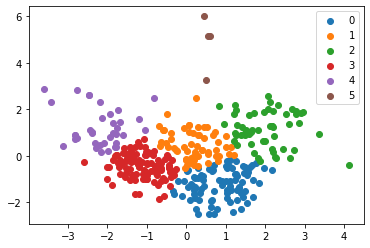

In [85]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

df1 = rds[['Track Name','danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]
clustering_df = df1.loc[:, df1.columns != 'Track Name']
scaler = StandardScaler()
X_std = scaler.fit_transform(clustering_df)

pca = PCA(2)
df = pca.fit_transform(X_std) 
 
kmeans = KMeans(n_clusters= 6)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
clustering_df.insert(8, 'Cluster', label, True)

#Getting unique labels
u_labels = np.unique(label)

#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

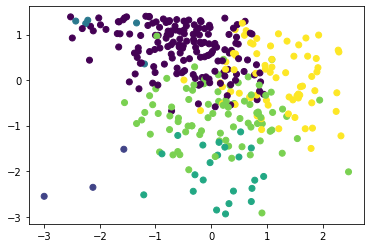

In [86]:
from sklearn.cluster import AffinityPropagation
clustering_df2 = df1.loc[:, df1.columns != 'Track Name']
pca = PCA(2)
df = pca.fit_transform(X_std)
sc = SpectralClustering(n_clusters=6).fit(df)
SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='lobpcg', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=4, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=20, random_state=1) 

labels = sc.labels_
clustering_df2.insert(8, 'Cluster', labels, True)
plt.scatter(X_std[:,0], X_std[:,1], c=labels)
plt.show()

In [87]:
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

cluster_mean = clustering_df.groupby(['Cluster']).mean()

x = cluster_mean.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
cluster_mean = pd.DataFrame(x_scaled)

categories = ['danceability','energy','speechiness','acousticness', 'instrumentalness','liveness','valence','tempo']

fig = go.Figure()

for index, row in cluster_mean.iterrows():
    fig.add_trace(go.Scatterpolar(
      r=row,
      theta=categories,
      fill='toself',
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show()
#fig.write_image("radar.png")

In [88]:
cluster_mean = clustering_df2.groupby(['Cluster']).mean()

x = cluster_mean.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
cluster_mean = pd.DataFrame(x_scaled)

categories = ['danceability','energy','speechiness','acousticness', 'instrumentalness','liveness','valence','tempo']

fig = go.Figure()

for index, row in cluster_mean.iterrows():
    fig.add_trace(go.Scatterpolar(
      r=row,
      theta=categories,
      fill='toself',
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show()

## Decision Tree Classifier

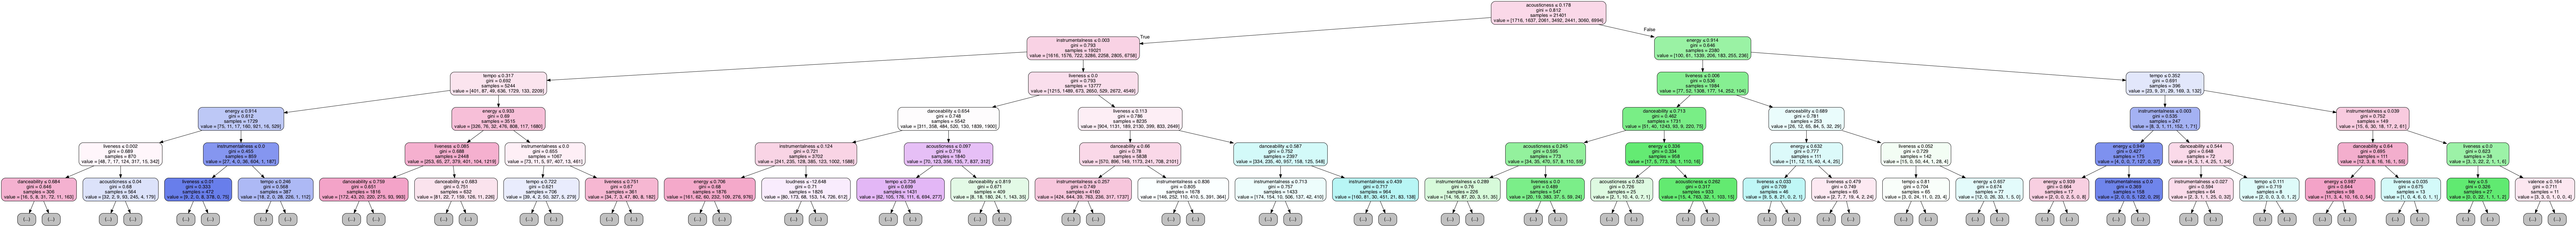

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

feature=['danceability','energy','key','loudness','speechiness','acousticness','instrumentalness','liveness'
                 ,'valence','tempo']


x = dataset.iloc[:,4:14]
y = dataset.iloc[:, 17]

x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.2)

clf=DecisionTreeClassifier()

clf=clf.fit(x_train,y_train)

y_pred=clf.predict(x_test)

dot_data=StringIO()
export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,max_depth=5,special_characters=True,
                    feature_names=feature)
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('tree.png')
display(Image(graph.create_png()))

In [45]:
import numpy as np

n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]
while len(stack) > 0:
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    is_split_node = children_left[node_id] != children_right[node_id]
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        display(
            "node={node} is a leaf node.".format(
                 node=i
            )
        )
    else:
        display(
            "node={node} is a split node: "
            "go to node {left} if x[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                #space=node_depth[i] ,
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 14443 nodes:



'node=0 is a split node: go to node 1 if x[:, 5] <= 0.17750000208616257 else to node 13228.'

'node=1 is a split node: go to node 2 if x[:, 6] <= 0.0029250000370666385 else to node 3363.'

'node=2 is a split node: go to node 3 if x[:, 9] <= 0.3174999952316284 else to node 974.'

'node=3 is a split node: go to node 4 if x[:, 1] <= 0.9144999980926514 else to node 585.'

'node=4 is a split node: go to node 5 if x[:, 7] <= 0.0023949999595060945 else to node 190.'

'node=5 is a split node: go to node 6 if x[:, 0] <= 0.6840000152587891 else to node 185.'

'node=6 is a split node: go to node 7 if x[:, 1] <= 0.7924999892711639 else to node 82.'

'node=7 is a split node: go to node 8 if x[:, 5] <= 0.03065000008791685 else to node 15.'

'node=8 is a split node: go to node 9 if x[:, 6] <= 0.0020800000056624413 else to node 10.'

'node=9 is a leaf node.'

'node=10 is a split node: go to node 11 if x[:, 0] <= 0.44749999046325684 else to node 12.'

'node=11 is a leaf node.'

'node=12 is a split node: go to node 13 if x[:, 6] <= 0.002530000056140125 else to node 14.'

'node=13 is a leaf node.'

'node=14 is a leaf node.'

'node=15 is a split node: go to node 16 if x[:, 4] <= 0.5 else to node 33.'

'node=16 is a split node: go to node 17 if x[:, 5] <= 0.0328999999910593 else to node 24.'

'node=17 is a split node: go to node 18 if x[:, 6] <= 0.0020200000144541264 else to node 21.'

'node=18 is a split node: go to node 19 if x[:, 1] <= 0.761000007390976 else to node 20.'

'node=19 is a leaf node.'

'node=20 is a leaf node.'

'node=21 is a split node: go to node 22 if x[:, 1] <= 0.7324999868869781 else to node 23.'

'node=22 is a leaf node.'

'node=23 is a leaf node.'

'node=24 is a split node: go to node 25 if x[:, 0] <= 0.4325000047683716 else to node 28.'

'node=25 is a split node: go to node 26 if x[:, 5] <= 0.07634999975562096 else to node 27.'

'node=26 is a leaf node.'

'node=27 is a leaf node.'

'node=28 is a split node: go to node 29 if x[:, 6] <= 0.0019500000053085387 else to node 32.'

'node=29 is a split node: go to node 30 if x[:, 0] <= 0.4650000035762787 else to node 31.'

'node=30 is a leaf node.'

'node=31 is a leaf node.'

'node=32 is a leaf node.'

'node=33 is a split node: go to node 34 if x[:, 3] <= -6.493499994277954 else to node 45.'

'node=34 is a split node: go to node 35 if x[:, 6] <= 0.0004530000005615875 else to node 36.'

'node=35 is a leaf node.'

'node=36 is a split node: go to node 37 if x[:, 7] <= 0.0013014999858569354 else to node 42.'

'node=37 is a split node: go to node 38 if x[:, 9] <= 0.28999999165534973 else to node 39.'

'node=38 is a leaf node.'

'node=39 is a split node: go to node 40 if x[:, 3] <= -7.783000230789185 else to node 41.'

'node=40 is a leaf node.'

'node=41 is a leaf node.'

'node=42 is a split node: go to node 43 if x[:, 2] <= 5.0 else to node 44.'

'node=43 is a leaf node.'

'node=44 is a leaf node.'

'node=45 is a split node: go to node 46 if x[:, 7] <= 1.5350000239777728e-06 else to node 53.'

'node=46 is a split node: go to node 47 if x[:, 0] <= 0.5844999849796295 else to node 52.'

'node=47 is a split node: go to node 48 if x[:, 2] <= 0.5 else to node 51.'

'node=48 is a split node: go to node 49 if x[:, 6] <= 0.0012710000155493617 else to node 50.'

'node=49 is a leaf node.'

'node=50 is a leaf node.'

'node=51 is a leaf node.'

'node=52 is a leaf node.'

'node=53 is a split node: go to node 54 if x[:, 2] <= 8.5 else to node 79.'

'node=54 is a split node: go to node 55 if x[:, 7] <= 2.890000018851424e-06 else to node 56.'

'node=55 is a leaf node.'

'node=56 is a split node: go to node 57 if x[:, 6] <= 5.50499989913078e-05 else to node 58.'

'node=57 is a leaf node.'

'node=58 is a split node: go to node 59 if x[:, 6] <= 0.00012150000111432746 else to node 62.'

'node=59 is a split node: go to node 60 if x[:, 2] <= 0.5 else to node 61.'

'node=60 is a leaf node.'

'node=61 is a leaf node.'

'node=62 is a split node: go to node 63 if x[:, 9] <= 0.1979999989271164 else to node 72.'

'node=63 is a split node: go to node 64 if x[:, 9] <= 0.17600000649690628 else to node 69.'

'node=64 is a split node: go to node 65 if x[:, 2] <= 3.5 else to node 66.'

'node=65 is a leaf node.'

'node=66 is a split node: go to node 67 if x[:, 3] <= -5.006500005722046 else to node 68.'

'node=67 is a leaf node.'

'node=68 is a leaf node.'

'node=69 is a split node: go to node 70 if x[:, 3] <= -5.46399998664856 else to node 71.'

'node=70 is a leaf node.'

'node=71 is a leaf node.'

'node=72 is a split node: go to node 73 if x[:, 7] <= 2.3799999326001853e-05 else to node 76.'

'node=73 is a split node: go to node 74 if x[:, 6] <= 0.0006814999724156223 else to node 75.'

'node=74 is a leaf node.'

'node=75 is a leaf node.'

'node=76 is a split node: go to node 77 if x[:, 7] <= 0.00215000007301569 else to node 78.'

'node=77 is a leaf node.'

'node=78 is a leaf node.'

'node=79 is a split node: go to node 80 if x[:, 8] <= 0.12650000303983688 else to node 81.'

'node=80 is a leaf node.'

'node=81 is a leaf node.'

'node=82 is a split node: go to node 83 if x[:, 3] <= -5.431999921798706 else to node 126.'

'node=83 is a split node: go to node 84 if x[:, 7] <= 0.0020749999675899744 else to node 121.'

'node=84 is a split node: go to node 85 if x[:, 1] <= 0.9090000092983246 else to node 118.'

'node=85 is a split node: go to node 86 if x[:, 9] <= 0.19249999523162842 else to node 87.'

'node=86 is a leaf node.'

'node=87 is a split node: go to node 88 if x[:, 9] <= 0.28300000727176666 else to node 109.'

'node=88 is a split node: go to node 89 if x[:, 5] <= 0.05530000105500221 else to node 100.'

'node=89 is a split node: go to node 90 if x[:, 5] <= 0.0426000002771616 else to node 95.'

'node=90 is a split node: go to node 91 if x[:, 8] <= 0.14300000667572021 else to node 92.'

'node=91 is a leaf node.'

'node=92 is a split node: go to node 93 if x[:, 5] <= 0.03464999981224537 else to node 94.'

'node=93 is a leaf node.'

'node=94 is a leaf node.'

'node=95 is a split node: go to node 96 if x[:, 2] <= 1.5 else to node 97.'

'node=96 is a leaf node.'

'node=97 is a split node: go to node 98 if x[:, 8] <= 0.31050000339746475 else to node 99.'

'node=98 is a leaf node.'

'node=99 is a leaf node.'

'node=100 is a split node: go to node 101 if x[:, 5] <= 0.1600000038743019 else to node 108.'

'node=101 is a split node: go to node 102 if x[:, 6] <= 0.0003775000077439472 else to node 107.'

'node=102 is a split node: go to node 103 if x[:, 6] <= 7.145000017771963e-05 else to node 106.'

'node=103 is a split node: go to node 104 if x[:, 3] <= -5.869499921798706 else to node 105.'

'node=104 is a leaf node.'

'node=105 is a leaf node.'

'node=106 is a leaf node.'

'node=107 is a leaf node.'

'node=108 is a leaf node.'

'node=109 is a split node: go to node 110 if x[:, 9] <= 0.31200000643730164 else to node 117.'

'node=110 is a split node: go to node 111 if x[:, 7] <= 0.0003615000023273751 else to node 112.'

'node=111 is a leaf node.'

'node=112 is a split node: go to node 113 if x[:, 6] <= 0.00013099999341648072 else to node 116.'

'node=113 is a split node: go to node 114 if x[:, 7] <= 0.0008215000270865858 else to node 115.'

'node=114 is a leaf node.'

'node=115 is a leaf node.'

'node=116 is a leaf node.'

'node=117 is a leaf node.'

'node=118 is a split node: go to node 119 if x[:, 0] <= 0.341499999165535 else to node 120.'

'node=119 is a leaf node.'

'node=120 is a leaf node.'

'node=121 is a split node: go to node 122 if x[:, 4] <= 0.5 else to node 125.'

'node=122 is a split node: go to node 123 if x[:, 2] <= 2.0 else to node 124.'

'node=123 is a leaf node.'

'node=124 is a leaf node.'

'node=125 is a leaf node.'

'node=126 is a split node: go to node 127 if x[:, 0] <= 0.44099999964237213 else to node 158.'

'node=127 is a split node: go to node 128 if x[:, 3] <= -2.1884999871253967 else to node 155.'

'node=128 is a split node: go to node 129 if x[:, 0] <= 0.341499999165535 else to node 132.'

'node=129 is a split node: go to node 130 if x[:, 9] <= 0.12700000405311584 else to node 131.'

'node=130 is a leaf node.'

'node=131 is a leaf node.'

'node=132 is a split node: go to node 133 if x[:, 7] <= 0.00025350000214530155 else to node 154.'

'node=133 is a split node: go to node 134 if x[:, 2] <= 2.5 else to node 139.'

'node=134 is a split node: go to node 135 if x[:, 9] <= 0.18950000405311584 else to node 136.'

'node=135 is a leaf node.'

'node=136 is a split node: go to node 137 if x[:, 5] <= 0.05689999833703041 else to node 138.'

'node=137 is a leaf node.'

'node=138 is a leaf node.'

'node=139 is a split node: go to node 140 if x[:, 6] <= 1.3949999811302405e-05 else to node 141.'

'node=140 is a leaf node.'

'node=141 is a split node: go to node 142 if x[:, 0] <= 0.3789999932050705 else to node 149.'

'node=142 is a split node: go to node 143 if x[:, 6] <= 0.0006339999963529408 else to node 148.'

'node=143 is a split node: go to node 144 if x[:, 7] <= 2.2750000425730832e-05 else to node 145.'

'node=144 is a leaf node.'

'node=145 is a split node: go to node 146 if x[:, 7] <= 0.00010325000221200753 else to node 147.'

'node=146 is a leaf node.'

'node=147 is a leaf node.'

'node=148 is a leaf node.'

'node=149 is a split node: go to node 150 if x[:, 1] <= 0.8364999890327454 else to node 153.'

'node=150 is a split node: go to node 151 if x[:, 3] <= -3.886500120162964 else to node 152.'

'node=151 is a leaf node.'

'node=152 is a leaf node.'

'node=153 is a leaf node.'

'node=154 is a leaf node.'

'node=155 is a split node: go to node 156 if x[:, 2] <= 9.5 else to node 157.'

'node=156 is a leaf node.'

'node=157 is a leaf node.'

'node=158 is a split node: go to node 159 if x[:, 7] <= 4.015000013168901e-05 else to node 178.'

'node=159 is a split node: go to node 160 if x[:, 7] <= 4.844999921260751e-06 else to node 177.'

'node=160 is a split node: go to node 161 if x[:, 3] <= -4.7799999713897705 else to node 162.'

'node=161 is a leaf node.'

'node=162 is a split node: go to node 163 if x[:, 8] <= 0.29749999940395355 else to node 176.'

'node=163 is a split node: go to node 164 if x[:, 1] <= 0.8585000038146973 else to node 165.'

'node=164 is a leaf node.'

'node=165 is a split node: go to node 166 if x[:, 8] <= 0.09640000015497208 else to node 169.'

'node=166 is a split node: go to node 167 if x[:, 3] <= -4.0950000286102295 else to node 168.'

'node=167 is a leaf node.'

'node=168 is a leaf node.'

'node=169 is a split node: go to node 170 if x[:, 4] <= 0.5 else to node 175.'

'node=170 is a split node: go to node 171 if x[:, 3] <= -4.463000059127808 else to node 172.'

'node=171 is a leaf node.'

'node=172 is a split node: go to node 173 if x[:, 3] <= -3.790000081062317 else to node 174.'

'node=173 is a leaf node.'

'node=174 is a leaf node.'

'node=175 is a leaf node.'

'node=176 is a leaf node.'

'node=177 is a leaf node.'

'node=178 is a split node: go to node 179 if x[:, 9] <= 0.16700000315904617 else to node 182.'

'node=179 is a split node: go to node 180 if x[:, 7] <= 0.0008400000224355608 else to node 181.'

'node=180 is a leaf node.'

'node=181 is a leaf node.'

'node=182 is a split node: go to node 183 if x[:, 3] <= -3.7929999828338623 else to node 184.'

'node=183 is a leaf node.'

'node=184 is a leaf node.'

'node=185 is a split node: go to node 186 if x[:, 3] <= -6.5345001220703125 else to node 189.'

'node=186 is a split node: go to node 187 if x[:, 8] <= 0.1529499962925911 else to node 188.'

'node=187 is a leaf node.'

'node=188 is a leaf node.'

'node=189 is a leaf node.'

'node=190 is a split node: go to node 191 if x[:, 5] <= 0.039650000631809235 else to node 346.'

'node=191 is a split node: go to node 192 if x[:, 9] <= 0.10649999976158142 else to node 225.'

'node=192 is a split node: go to node 193 if x[:, 6] <= 0.00014999999984866008 else to node 194.'

'node=193 is a leaf node.'

'node=194 is a split node: go to node 195 if x[:, 9] <= 0.05694999918341637 else to node 210.'

'node=195 is a split node: go to node 196 if x[:, 3] <= -8.499499797821045 else to node 203.'

'node=196 is a split node: go to node 197 if x[:, 7] <= 0.8824999928474426 else to node 200.'

'node=197 is a split node: go to node 198 if x[:, 3] <= -8.934000015258789 else to node 199.'

'node=198 is a leaf node.'

'node=199 is a leaf node.'

'node=200 is a split node: go to node 201 if x[:, 2] <= 2.5 else to node 202.'

'node=201 is a leaf node.'

'node=202 is a leaf node.'

'node=203 is a split node: go to node 204 if x[:, 2] <= 8.5 else to node 209.'

'node=204 is a split node: go to node 205 if x[:, 4] <= 0.5 else to node 206.'

'node=205 is a leaf node.'

'node=206 is a split node: go to node 207 if x[:, 8] <= 0.09205000102519989 else to node 208.'

'node=207 is a leaf node.'

'node=208 is a leaf node.'

'node=209 is a leaf node.'

'node=210 is a split node: go to node 211 if x[:, 6] <= 0.00030950001382734627 else to node 214.'

'node=211 is a split node: go to node 212 if x[:, 0] <= 0.5740000009536743 else to node 213.'

'node=212 is a leaf node.'

'node=213 is a leaf node.'

'node=214 is a split node: go to node 215 if x[:, 3] <= -6.835000038146973 else to node 224.'

'node=215 is a split node: go to node 216 if x[:, 8] <= 0.20250000059604645 else to node 223.'

'node=216 is a split node: go to node 217 if x[:, 6] <= 0.0010689999617170542 else to node 218.'

'node=217 is a leaf node.'

'node=218 is a split node: go to node 219 if x[:, 5] <= 0.03160000033676624 else to node 222.'

'node=219 is a split node: go to node 220 if x[:, 3] <= -8.088500261306763 else to node 221.'

'node=220 is a leaf node.'

'node=221 is a leaf node.'

'node=222 is a leaf node.'

'node=223 is a leaf node.'

'node=224 is a leaf node.'

'node=225 is a split node: go to node 226 if x[:, 7] <= 0.012899999972432852 else to node 245.'

'node=226 is a split node: go to node 227 if x[:, 7] <= 0.0063950002659112215 else to node 238.'

'node=227 is a split node: go to node 228 if x[:, 2] <= 7.5 else to node 235.'

'node=228 is a split node: go to node 229 if x[:, 9] <= 0.14149999618530273 else to node 230.'

'node=229 is a leaf node.'

'node=230 is a split node: go to node 231 if x[:, 5] <= 0.03645000047981739 else to node 232.'

'node=231 is a leaf node.'

'node=232 is a split node: go to node 233 if x[:, 5] <= 0.038750000298023224 else to node 234.'

'node=233 is a leaf node.'

'node=234 is a leaf node.'

'node=235 is a split node: go to node 236 if x[:, 9] <= 0.24899999797344208 else to node 237.'

'node=236 is a leaf node.'

'node=237 is a leaf node.'

'node=238 is a split node: go to node 239 if x[:, 6] <= 0.0007259999838424847 else to node 240.'

'node=239 is a leaf node.'

'node=240 is a split node: go to node 241 if x[:, 7] <= 0.00828499998897314 else to node 242.'

'node=241 is a leaf node.'

'node=242 is a split node: go to node 243 if x[:, 5] <= 0.03015000093728304 else to node 244.'

'node=243 is a leaf node.'

'node=244 is a leaf node.'

'node=245 is a split node: go to node 246 if x[:, 7] <= 0.7820000052452087 else to node 311.'

'node=246 is a split node: go to node 247 if x[:, 3] <= -5.490000009536743 else to node 298.'

'node=247 is a split node: go to node 248 if x[:, 1] <= 0.7205000221729279 else to node 283.'

'node=248 is a split node: go to node 249 if x[:, 1] <= 0.5705000162124634 else to node 262.'

'node=249 is a split node: go to node 250 if x[:, 0] <= 0.5160000175237656 else to node 261.'

'node=250 is a split node: go to node 251 if x[:, 5] <= 0.03374999947845936 else to node 258.'

'node=251 is a split node: go to node 252 if x[:, 8] <= 0.22599999979138374 else to node 255.'

'node=252 is a split node: go to node 253 if x[:, 0] <= 0.3720000088214874 else to node 254.'

'node=253 is a leaf node.'

'node=254 is a leaf node.'

'node=255 is a split node: go to node 256 if x[:, 8] <= 0.34450000524520874 else to node 257.'

'node=256 is a leaf node.'

'node=257 is a leaf node.'

'node=258 is a split node: go to node 259 if x[:, 4] <= 0.5 else to node 260.'

'node=259 is a leaf node.'

'node=260 is a leaf node.'

'node=261 is a leaf node.'

'node=262 is a split node: go to node 263 if x[:, 9] <= 0.19250000268220901 else to node 278.'

'node=263 is a split node: go to node 264 if x[:, 3] <= -7.857000112533569 else to node 273.'

'node=264 is a split node: go to node 265 if x[:, 5] <= 0.033900000154972076 else to node 272.'

'node=265 is a split node: go to node 266 if x[:, 2] <= 1.5 else to node 267.'

'node=266 is a leaf node.'

'node=267 is a split node: go to node 268 if x[:, 8] <= 0.12905000150203705 else to node 269.'

'node=268 is a leaf node.'

'node=269 is a split node: go to node 270 if x[:, 0] <= 0.49299998581409454 else to node 271.'

'node=270 is a leaf node.'

'node=271 is a leaf node.'

'node=272 is a leaf node.'

'node=273 is a split node: go to node 274 if x[:, 7] <= 0.2244499996304512 else to node 277.'

'node=274 is a split node: go to node 275 if x[:, 6] <= 0.0010264999873470515 else to node 276.'

'node=275 is a leaf node.'

'node=276 is a leaf node.'

'node=277 is a leaf node.'

'node=278 is a split node: go to node 279 if x[:, 8] <= 0.08504999801516533 else to node 280.'

'node=279 is a leaf node.'

'node=280 is a split node: go to node 281 if x[:, 6] <= 0.002574999933131039 else to node 282.'

'node=281 is a leaf node.'

'node=282 is a leaf node.'

'node=283 is a split node: go to node 284 if x[:, 2] <= 1.5 else to node 287.'

'node=284 is a split node: go to node 285 if x[:, 6] <= 7.965000077092554e-05 else to node 286.'

'node=285 is a leaf node.'

'node=286 is a leaf node.'

'node=287 is a split node: go to node 288 if x[:, 8] <= 0.3344999998807907 else to node 297.'

'node=288 is a split node: go to node 289 if x[:, 7] <= 0.13850000128149986 else to node 292.'

'node=289 is a split node: go to node 290 if x[:, 0] <= 0.3994999974966049 else to node 291.'

'node=290 is a leaf node.'

'node=291 is a leaf node.'

'node=292 is a split node: go to node 293 if x[:, 7] <= 0.24149999767541885 else to node 294.'

'node=293 is a leaf node.'

'node=294 is a split node: go to node 295 if x[:, 0] <= 0.48999999463558197 else to node 296.'

'node=295 is a leaf node.'

'node=296 is a leaf node.'

'node=297 is a leaf node.'

'node=298 is a split node: go to node 299 if x[:, 2] <= 10.0 else to node 308.'

'node=299 is a split node: go to node 300 if x[:, 8] <= 0.13899999856948853 else to node 301.'

'node=300 is a leaf node.'

'node=301 is a split node: go to node 302 if x[:, 6] <= 0.00012650000280700624 else to node 305.'

'node=302 is a split node: go to node 303 if x[:, 5] <= 0.033150000497698784 else to node 304.'

'node=303 is a leaf node.'

'node=304 is a leaf node.'

'node=305 is a split node: go to node 306 if x[:, 8] <= 0.2579999938607216 else to node 307.'

'node=306 is a leaf node.'

'node=307 is a leaf node.'

'node=308 is a split node: go to node 309 if x[:, 7] <= 0.5304999947547913 else to node 310.'

'node=309 is a leaf node.'

'node=310 is a leaf node.'

'node=311 is a split node: go to node 312 if x[:, 3] <= -9.940000057220459 else to node 313.'

'node=312 is a leaf node.'

'node=313 is a split node: go to node 314 if x[:, 1] <= 0.7685000002384186 else to node 341.'

'node=314 is a split node: go to node 315 if x[:, 8] <= 0.17899999767541885 else to node 332.'

'node=315 is a split node: go to node 316 if x[:, 8] <= 0.12299999967217445 else to node 331.'

'node=316 is a split node: go to node 317 if x[:, 0] <= 0.46400001645088196 else to node 330.'

'node=317 is a split node: go to node 318 if x[:, 5] <= 0.033250000327825546 else to node 319.'

'node=318 is a leaf node.'

'node=319 is a split node: go to node 320 if x[:, 0] <= 0.22999999672174454 else to node 321.'

'node=320 is a leaf node.'

'node=321 is a split node: go to node 322 if x[:, 2] <= 5.0 else to node 323.'

'node=322 is a leaf node.'

'node=323 is a split node: go to node 324 if x[:, 2] <= 8.5 else to node 327.'

'node=324 is a split node: go to node 325 if x[:, 8] <= 0.09954999759793282 else to node 326.'

'node=325 is a leaf node.'

'node=326 is a leaf node.'

'node=327 is a split node: go to node 328 if x[:, 1] <= 0.5215000063180923 else to node 329.'

'node=328 is a leaf node.'

'node=329 is a leaf node.'

'node=330 is a leaf node.'

'node=331 is a leaf node.'

'node=332 is a split node: go to node 333 if x[:, 2] <= 6.0 else to node 340.'

'node=333 is a split node: go to node 334 if x[:, 8] <= 0.2094999998807907 else to node 335.'

'node=334 is a leaf node.'

'node=335 is a split node: go to node 336 if x[:, 6] <= 0.0006065500110707944 else to node 339.'

'node=336 is a split node: go to node 337 if x[:, 6] <= 2.5200000891345553e-05 else to node 338.'

'node=337 is a leaf node.'

'node=338 is a leaf node.'

'node=339 is a leaf node.'

'node=340 is a leaf node.'

'node=341 is a split node: go to node 342 if x[:, 7] <= 0.8939999938011169 else to node 343.'

'node=342 is a leaf node.'

'node=343 is a split node: go to node 344 if x[:, 1] <= 0.8569999933242798 else to node 345.'

'node=344 is a leaf node.'

'node=345 is a leaf node.'

'node=346 is a split node: go to node 347 if x[:, 0] <= 0.6459999978542328 else to node 576.'

'node=347 is a split node: go to node 348 if x[:, 3] <= -5.835000038146973 else to node 479.'

'node=348 is a split node: go to node 349 if x[:, 7] <= 0.3935000002384186 else to node 422.'

'node=349 is a split node: go to node 350 if x[:, 9] <= 0.29899999499320984 else to node 417.'

'node=350 is a split node: go to node 351 if x[:, 3] <= -9.101500034332275 else to node 360.'

'node=351 is a split node: go to node 352 if x[:, 5] <= 0.12950000166893005 else to node 359.'

'node=352 is a split node: go to node 353 if x[:, 0] <= 0.18049999326467514 else to node 356.'

'node=353 is a split node: go to node 354 if x[:, 5] <= 0.07109999842941761 else to node 355.'

'node=354 is a leaf node.'

'node=355 is a leaf node.'

'node=356 is a split node: go to node 357 if x[:, 8] <= 0.10305000096559525 else to node 358.'

'node=357 is a leaf node.'

'node=358 is a leaf node.'

'node=359 is a leaf node.'

'node=360 is a split node: go to node 361 if x[:, 3] <= -8.912999629974365 else to node 364.'

'node=361 is a split node: go to node 362 if x[:, 0] <= 0.30150000005960464 else to node 363.'

'node=362 is a leaf node.'

'node=363 is a leaf node.'

'node=364 is a split node: go to node 365 if x[:, 9] <= 0.11699999868869781 else to node 368.'

'node=365 is a split node: go to node 366 if x[:, 7] <= 0.01850000023841858 else to node 367.'

'node=366 is a leaf node.'

'node=367 is a leaf node.'

'node=368 is a split node: go to node 369 if x[:, 7] <= 0.013150000013411045 else to node 382.'

'node=369 is a split node: go to node 370 if x[:, 5] <= 0.09184999763965607 else to node 379.'

'node=370 is a split node: go to node 371 if x[:, 9] <= 0.19249999523162842 else to node 376.'

'node=371 is a split node: go to node 372 if x[:, 9] <= 0.16199999302625656 else to node 375.'

'node=372 is a split node: go to node 373 if x[:, 2] <= 7.0 else to node 374.'

'node=373 is a leaf node.'

'node=374 is a leaf node.'

'node=375 is a leaf node.'

'node=376 is a split node: go to node 377 if x[:, 9] <= 0.28450000286102295 else to node 378.'

'node=377 is a leaf node.'

'node=378 is a leaf node.'

'node=379 is a split node: go to node 380 if x[:, 9] <= 0.26899999380111694 else to node 381.'

'node=380 is a leaf node.'

'node=381 is a leaf node.'

'node=382 is a split node: go to node 383 if x[:, 1] <= 0.8980000019073486 else to node 416.'

'node=383 is a split node: go to node 384 if x[:, 0] <= 0.44099999964237213 else to node 401.'

'node=384 is a split node: go to node 385 if x[:, 6] <= 1.920000067912042e-05 else to node 388.'

'node=385 is a split node: go to node 386 if x[:, 3] <= -6.865999937057495 else to node 387.'

'node=386 is a leaf node.'

'node=387 is a leaf node.'

'node=388 is a split node: go to node 389 if x[:, 8] <= 0.24549999833106995 else to node 392.'

'node=389 is a split node: go to node 390 if x[:, 8] <= 0.06354999914765358 else to node 391.'

'node=390 is a leaf node.'

'node=391 is a leaf node.'

'node=392 is a split node: go to node 393 if x[:, 2] <= 3.0 else to node 394.'

'node=393 is a leaf node.'

'node=394 is a split node: go to node 395 if x[:, 3] <= -7.026000022888184 else to node 396.'

'node=395 is a leaf node.'

'node=396 is a split node: go to node 397 if x[:, 6] <= 0.001158999977633357 else to node 400.'

'node=397 is a split node: go to node 398 if x[:, 6] <= 0.0002249000026495196 else to node 399.'

'node=398 is a leaf node.'

'node=399 is a leaf node.'

'node=400 is a leaf node.'

'node=401 is a split node: go to node 402 if x[:, 5] <= 0.042750000953674316 else to node 403.'

'node=402 is a leaf node.'

'node=403 is a split node: go to node 404 if x[:, 7] <= 0.034049998968839645 else to node 409.'

'node=404 is a split node: go to node 405 if x[:, 4] <= 0.5 else to node 406.'

'node=405 is a leaf node.'

'node=406 is a split node: go to node 407 if x[:, 3] <= -7.226000070571899 else to node 408.'

'node=407 is a leaf node.'

'node=408 is a leaf node.'

'node=409 is a split node: go to node 410 if x[:, 0] <= 0.48750001192092896 else to node 415.'

'node=410 is a split node: go to node 411 if x[:, 3] <= -6.69599986076355 else to node 414.'

'node=411 is a split node: go to node 412 if x[:, 3] <= -8.161999702453613 else to node 413.'

'node=412 is a leaf node.'

'node=413 is a leaf node.'

'node=414 is a leaf node.'

'node=415 is a leaf node.'

'node=416 is a leaf node.'

'node=417 is a split node: go to node 418 if x[:, 6] <= 0.0018350000027567148 else to node 419.'

'node=418 is a leaf node.'

'node=419 is a split node: go to node 420 if x[:, 5] <= 0.07695000246167183 else to node 421.'

'node=420 is a leaf node.'

'node=421 is a leaf node.'

'node=422 is a split node: go to node 423 if x[:, 3] <= -9.447500228881836 else to node 450.'

'node=423 is a split node: go to node 424 if x[:, 5] <= 0.046799998730421066 else to node 427.'

'node=424 is a split node: go to node 425 if x[:, 9] <= 0.05195000022649765 else to node 426.'

'node=425 is a leaf node.'

'node=426 is a leaf node.'

'node=427 is a split node: go to node 428 if x[:, 9] <= 0.07760000228881836 else to node 429.'

'node=428 is a leaf node.'

'node=429 is a split node: go to node 430 if x[:, 0] <= 0.4960000067949295 else to node 445.'

'node=430 is a split node: go to node 431 if x[:, 6] <= 4.55999997939216e-05 else to node 436.'

'node=431 is a split node: go to node 432 if x[:, 0] <= 0.2590000033378601 else to node 433.'

'node=432 is a leaf node.'

'node=433 is a split node: go to node 434 if x[:, 7] <= 0.80799999833107 else to node 435.'

'node=434 is a leaf node.'

'node=435 is a leaf node.'

'node=436 is a split node: go to node 437 if x[:, 3] <= -12.235000133514404 else to node 438.'

'node=437 is a leaf node.'

'node=438 is a split node: go to node 439 if x[:, 2] <= 5.5 else to node 444.'

'node=439 is a split node: go to node 440 if x[:, 9] <= 0.2280000001192093 else to node 443.'

'node=440 is a split node: go to node 441 if x[:, 5] <= 0.11454999819397926 else to node 442.'

'node=441 is a leaf node.'

'node=442 is a leaf node.'

'node=443 is a leaf node.'

'node=444 is a leaf node.'

'node=445 is a split node: go to node 446 if x[:, 7] <= 0.5195000022649765 else to node 447.'

'node=446 is a leaf node.'

'node=447 is a split node: go to node 448 if x[:, 4] <= 0.5 else to node 449.'

'node=448 is a leaf node.'

'node=449 is a leaf node.'

'node=450 is a split node: go to node 451 if x[:, 6] <= 0.0005854999762959778 else to node 462.'

'node=451 is a split node: go to node 452 if x[:, 1] <= 0.7405000030994415 else to node 457.'

'node=452 is a split node: go to node 453 if x[:, 2] <= 2.0 else to node 454.'

'node=453 is a leaf node.'

'node=454 is a split node: go to node 455 if x[:, 6] <= 9.944999874278437e-06 else to node 456.'

'node=455 is a leaf node.'

'node=456 is a leaf node.'

'node=457 is a split node: go to node 458 if x[:, 8] <= 0.56700000166893 else to node 459.'

'node=458 is a leaf node.'

'node=459 is a split node: go to node 460 if x[:, 1] <= 0.8849999904632568 else to node 461.'

'node=460 is a leaf node.'

'node=461 is a leaf node.'

'node=462 is a split node: go to node 463 if x[:, 8] <= 0.08465000241994858 else to node 466.'

'node=463 is a split node: go to node 464 if x[:, 9] <= 0.05274999886751175 else to node 465.'

'node=464 is a leaf node.'

'node=465 is a leaf node.'

'node=466 is a split node: go to node 467 if x[:, 8] <= 0.1524999961256981 else to node 468.'

'node=467 is a leaf node.'

'node=468 is a split node: go to node 469 if x[:, 7] <= 0.835999995470047 else to node 478.'

'node=469 is a split node: go to node 470 if x[:, 6] <= 0.0006204999808687717 else to node 471.'

'node=470 is a leaf node.'

'node=471 is a split node: go to node 472 if x[:, 2] <= 3.5 else to node 477.'

'node=472 is a split node: go to node 473 if x[:, 0] <= 0.36800000071525574 else to node 476.'

'node=473 is a split node: go to node 474 if x[:, 6] <= 0.0024549999507144094 else to node 475.'

'node=474 is a leaf node.'

'node=475 is a leaf node.'

'node=476 is a leaf node.'

'node=477 is a leaf node.'

'node=478 is a leaf node.'

'node=479 is a split node: go to node 480 if x[:, 1] <= 0.7930000126361847 else to node 499.'

'node=480 is a split node: go to node 481 if x[:, 4] <= 0.5 else to node 482.'

'node=481 is a leaf node.'

'node=482 is a split node: go to node 483 if x[:, 9] <= 0.14299999922513962 else to node 486.'

'node=483 is a split node: go to node 484 if x[:, 7] <= 0.46950001269578934 else to node 485.'

'node=484 is a leaf node.'

'node=485 is a leaf node.'

'node=486 is a split node: go to node 487 if x[:, 8] <= 0.148499995470047 else to node 496.'

'node=487 is a split node: go to node 488 if x[:, 1] <= 0.6660000085830688 else to node 489.'

'node=488 is a leaf node.'

'node=489 is a split node: go to node 490 if x[:, 7] <= 0.0030750000150874257 else to node 491.'

'node=490 is a leaf node.'

'node=491 is a split node: go to node 492 if x[:, 8] <= 0.10530000180006027 else to node 493.'

'node=492 is a leaf node.'

'node=493 is a split node: go to node 494 if x[:, 1] <= 0.7260000109672546 else to node 495.'

'node=494 is a leaf node.'

'node=495 is a leaf node.'

'node=496 is a split node: go to node 497 if x[:, 2] <= 3.5 else to node 498.'

'node=497 is a leaf node.'

'node=498 is a leaf node.'

'node=499 is a split node: go to node 500 if x[:, 5] <= 0.04150000028312206 else to node 505.'

'node=500 is a split node: go to node 501 if x[:, 2] <= 10.0 else to node 504.'

'node=501 is a split node: go to node 502 if x[:, 9] <= 0.13100000098347664 else to node 503.'

'node=502 is a leaf node.'

'node=503 is a leaf node.'

'node=504 is a leaf node.'

'node=505 is a split node: go to node 506 if x[:, 5] <= 0.05140000022947788 else to node 535.'

'node=506 is a split node: go to node 507 if x[:, 0] <= 0.4739999920129776 else to node 526.'

'node=507 is a split node: go to node 508 if x[:, 8] <= 0.10250000283122063 else to node 515.'

'node=508 is a split node: go to node 509 if x[:, 8] <= 0.07669999822974205 else to node 510.'

'node=509 is a leaf node.'

'node=510 is a split node: go to node 511 if x[:, 9] <= 0.21899999678134918 else to node 512.'

'node=511 is a leaf node.'

'node=512 is a split node: go to node 513 if x[:, 2] <= 4.5 else to node 514.'

'node=513 is a leaf node.'

'node=514 is a leaf node.'

'node=515 is a split node: go to node 516 if x[:, 6] <= 3.980000087722146e-06 else to node 517.'

'node=516 is a leaf node.'

'node=517 is a split node: go to node 518 if x[:, 3] <= -3.4269999265670776 else to node 525.'

'node=518 is a split node: go to node 519 if x[:, 5] <= 0.04869999922811985 else to node 520.'

'node=519 is a leaf node.'

'node=520 is a split node: go to node 521 if x[:, 5] <= 0.05030000023543835 else to node 522.'

'node=521 is a leaf node.'

'node=522 is a split node: go to node 523 if x[:, 6] <= 0.00045199999294709414 else to node 524.'

'node=523 is a leaf node.'

'node=524 is a leaf node.'

'node=525 is a leaf node.'

'node=526 is a split node: go to node 527 if x[:, 0] <= 0.5254999995231628 else to node 530.'

'node=527 is a split node: go to node 528 if x[:, 7] <= 0.4479999989271164 else to node 529.'

'node=528 is a leaf node.'

'node=529 is a leaf node.'

'node=530 is a split node: go to node 531 if x[:, 2] <= 2.5 else to node 532.'

'node=531 is a leaf node.'

'node=532 is a split node: go to node 533 if x[:, 1] <= 0.9044999778270721 else to node 534.'

'node=533 is a leaf node.'

'node=534 is a leaf node.'

'node=535 is a split node: go to node 536 if x[:, 8] <= 0.07455000281333923 else to node 539.'

'node=536 is a split node: go to node 537 if x[:, 7] <= 0.0053250000346452 else to node 538.'

'node=537 is a leaf node.'

'node=538 is a leaf node.'

'node=539 is a split node: go to node 540 if x[:, 3] <= -4.856499910354614 else to node 555.'

'node=540 is a split node: go to node 541 if x[:, 5] <= 0.10999999940395355 else to node 552.'

'node=541 is a split node: go to node 542 if x[:, 6] <= 3.4550001146271825e-05 else to node 543.'

'node=542 is a leaf node.'

'node=543 is a split node: go to node 544 if x[:, 6] <= 4.000000080850441e-05 else to node 545.'

'node=544 is a leaf node.'

'node=545 is a split node: go to node 546 if x[:, 0] <= 0.19200000166893005 else to node 547.'

'node=546 is a leaf node.'

'node=547 is a split node: go to node 548 if x[:, 7] <= 0.024249999783933163 else to node 551.'

'node=548 is a split node: go to node 549 if x[:, 7] <= 0.018149999901652336 else to node 550.'

'node=549 is a leaf node.'

'node=550 is a leaf node.'

'node=551 is a leaf node.'

'node=552 is a split node: go to node 553 if x[:, 8] <= 0.21550000458955765 else to node 554.'

'node=553 is a leaf node.'

'node=554 is a leaf node.'

'node=555 is a split node: go to node 556 if x[:, 7] <= 0.7364999949932098 else to node 575.'

'node=556 is a split node: go to node 557 if x[:, 7] <= 0.2970000058412552 else to node 570.'

'node=557 is a split node: go to node 558 if x[:, 2] <= 4.0 else to node 561.'

'node=558 is a split node: go to node 559 if x[:, 6] <= 1.095000015993719e-05 else to node 560.'

'node=559 is a leaf node.'

'node=560 is a leaf node.'

'node=561 is a split node: go to node 562 if x[:, 6] <= 9.785000293049961e-05 else to node 569.'

'node=562 is a split node: go to node 563 if x[:, 7] <= 0.014699999708682299 else to node 564.'

'node=563 is a leaf node.'

'node=564 is a split node: go to node 565 if x[:, 8] <= 0.1954999938607216 else to node 566.'

'node=565 is a leaf node.'

'node=566 is a split node: go to node 567 if x[:, 9] <= 0.30299998819828033 else to node 568.'

'node=567 is a leaf node.'

'node=568 is a leaf node.'

'node=569 is a leaf node.'

'node=570 is a split node: go to node 571 if x[:, 9] <= 0.24050000309944153 else to node 574.'

'node=571 is a split node: go to node 572 if x[:, 7] <= 0.6134999990463257 else to node 573.'

'node=572 is a leaf node.'

'node=573 is a leaf node.'

'node=574 is a leaf node.'

'node=575 is a leaf node.'

'node=576 is a split node: go to node 577 if x[:, 0] <= 0.7985000014305115 else to node 582.'

'node=577 is a split node: go to node 578 if x[:, 7] <= 0.8474999964237213 else to node 581.'

'node=578 is a split node: go to node 579 if x[:, 6] <= 0.001720000000204891 else to node 580.'

'node=579 is a leaf node.'

'node=580 is a leaf node.'

'node=581 is a leaf node.'

'node=582 is a split node: go to node 583 if x[:, 3] <= -4.287499904632568 else to node 584.'

'node=583 is a leaf node.'

'node=584 is a leaf node.'

'node=585 is a split node: go to node 586 if x[:, 6] <= 0.00012450000212993473 else to node 751.'

'node=586 is a split node: go to node 587 if x[:, 7] <= 0.009769999887794256 else to node 676.'

'node=587 is a split node: go to node 588 if x[:, 8] <= 0.31949999928474426 else to node 633.'

'node=588 is a split node: go to node 589 if x[:, 3] <= -3.4259999990463257 else to node 616.'

'node=589 is a split node: go to node 590 if x[:, 9] <= 0.255500003695488 else to node 605.'

'node=590 is a split node: go to node 591 if x[:, 5] <= 0.0499000009149313 else to node 592.'

'node=591 is a leaf node.'

'node=592 is a split node: go to node 593 if x[:, 5] <= 0.16950000077486038 else to node 604.'

'node=593 is a split node: go to node 594 if x[:, 0] <= 0.24249999970197678 else to node 599.'

'node=594 is a split node: go to node 595 if x[:, 3] <= -4.808500051498413 else to node 598.'

'node=595 is a split node: go to node 596 if x[:, 3] <= -5.2184998989105225 else to node 597.'

'node=596 is a leaf node.'

'node=597 is a leaf node.'

'node=598 is a leaf node.'

'node=599 is a split node: go to node 600 if x[:, 5] <= 0.15450000017881393 else to node 601.'

'node=600 is a leaf node.'

'node=601 is a split node: go to node 602 if x[:, 9] <= 0.1915000006556511 else to node 603.'

'node=602 is a leaf node.'

'node=603 is a leaf node.'

'node=604 is a leaf node.'

'node=605 is a split node: go to node 606 if x[:, 8] <= 0.14100000262260437 else to node 613.'

'node=606 is a split node: go to node 607 if x[:, 8] <= 0.13099999725818634 else to node 612.'

'node=607 is a split node: go to node 608 if x[:, 1] <= 0.9389999806880951 else to node 609.'

'node=608 is a leaf node.'

'node=609 is a split node: go to node 610 if x[:, 3] <= -5.211999893188477 else to node 611.'

'node=610 is a leaf node.'

'node=611 is a leaf node.'

'node=612 is a leaf node.'

'node=613 is a split node: go to node 614 if x[:, 6] <= 0.00011749999976018444 else to node 615.'

'node=614 is a leaf node.'

'node=615 is a leaf node.'

'node=616 is a split node: go to node 617 if x[:, 8] <= 0.22999999672174454 else to node 630.'

'node=617 is a split node: go to node 618 if x[:, 5] <= 0.09619999676942825 else to node 621.'

'node=618 is a split node: go to node 619 if x[:, 5] <= 0.07075000181794167 else to node 620.'

'node=619 is a leaf node.'

'node=620 is a leaf node.'

'node=621 is a split node: go to node 622 if x[:, 7] <= 0.0008300000226881821 else to node 629.'

'node=622 is a split node: go to node 623 if x[:, 0] <= 0.408500000834465 else to node 626.'

'node=623 is a split node: go to node 624 if x[:, 6] <= 5.0499998906161636e-05 else to node 625.'

'node=624 is a leaf node.'

'node=625 is a leaf node.'

'node=626 is a split node: go to node 627 if x[:, 9] <= 0.1875000074505806 else to node 628.'

'node=627 is a leaf node.'

'node=628 is a leaf node.'

'node=629 is a leaf node.'

'node=630 is a split node: go to node 631 if x[:, 7] <= 2.2950000584387453e-06 else to node 632.'

'node=631 is a leaf node.'

'node=632 is a leaf node.'

'node=633 is a split node: go to node 634 if x[:, 7] <= 0.005689999787136912 else to node 669.'

'node=634 is a split node: go to node 635 if x[:, 7] <= 9.699999736767495e-07 else to node 640.'

'node=635 is a split node: go to node 636 if x[:, 6] <= 7.434999861288816e-05 else to node 637.'

'node=636 is a leaf node.'

'node=637 is a split node: go to node 638 if x[:, 3] <= -3.7044999599456787 else to node 639.'

'node=638 is a leaf node.'

'node=639 is a leaf node.'

'node=640 is a split node: go to node 641 if x[:, 2] <= 0.5 else to node 642.'

'node=641 is a leaf node.'

'node=642 is a split node: go to node 643 if x[:, 0] <= 0.49949999153614044 else to node 662.'

'node=643 is a split node: go to node 644 if x[:, 3] <= -3.1875 else to node 659.'

'node=644 is a split node: go to node 645 if x[:, 1] <= 0.9764999747276306 else to node 658.'

'node=645 is a split node: go to node 646 if x[:, 8] <= 0.828000009059906 else to node 657.'

'node=646 is a split node: go to node 647 if x[:, 1] <= 0.9724999964237213 else to node 656.'

'node=647 is a split node: go to node 648 if x[:, 5] <= 0.11049999669194221 else to node 649.'

'node=648 is a leaf node.'

'node=649 is a split node: go to node 650 if x[:, 7] <= 6.455000129790278e-05 else to node 651.'

'node=650 is a leaf node.'

'node=651 is a split node: go to node 652 if x[:, 2] <= 5.0 else to node 653.'

'node=652 is a leaf node.'

'node=653 is a split node: go to node 654 if x[:, 0] <= 0.35249999165534973 else to node 655.'

'node=654 is a leaf node.'

'node=655 is a leaf node.'

'node=656 is a leaf node.'

'node=657 is a leaf node.'

'node=658 is a leaf node.'

'node=659 is a split node: go to node 660 if x[:, 0] <= 0.45399999618530273 else to node 661.'

'node=660 is a leaf node.'

'node=661 is a leaf node.'

'node=662 is a split node: go to node 663 if x[:, 7] <= 1.2349999906291487e-05 else to node 664.'

'node=663 is a leaf node.'

'node=664 is a split node: go to node 665 if x[:, 5] <= 0.11699999868869781 else to node 666.'

'node=665 is a leaf node.'

'node=666 is a split node: go to node 667 if x[:, 8] <= 0.4544999897480011 else to node 668.'

'node=667 is a leaf node.'

'node=668 is a leaf node.'

'node=669 is a split node: go to node 670 if x[:, 0] <= 0.23499999195337296 else to node 671.'

'node=670 is a leaf node.'

'node=671 is a split node: go to node 672 if x[:, 6] <= 2.1699999706470408e-05 else to node 673.'

'node=672 is a leaf node.'

'node=673 is a split node: go to node 674 if x[:, 1] <= 0.9730000197887421 else to node 675.'

'node=674 is a leaf node.'

'node=675 is a leaf node.'

'node=676 is a split node: go to node 677 if x[:, 9] <= 0.16350000351667404 else to node 694.'

'node=677 is a split node: go to node 678 if x[:, 3] <= -3.3554999828338623 else to node 689.'

'node=678 is a split node: go to node 679 if x[:, 3] <= -7.20550012588501 else to node 684.'

'node=679 is a split node: go to node 680 if x[:, 3] <= -7.2215001583099365 else to node 683.'

'node=680 is a split node: go to node 681 if x[:, 8] <= 0.07454999908804893 else to node 682.'

'node=681 is a leaf node.'

'node=682 is a leaf node.'

'node=683 is a leaf node.'

'node=684 is a split node: go to node 685 if x[:, 7] <= 0.04790000058710575 else to node 688.'

'node=685 is a split node: go to node 686 if x[:, 7] <= 0.04325000010430813 else to node 687.'

'node=686 is a leaf node.'

'node=687 is a leaf node.'

'node=688 is a leaf node.'

'node=689 is a split node: go to node 690 if x[:, 6] <= 9.764999776962213e-05 else to node 693.'

'node=690 is a split node: go to node 691 if x[:, 9] <= 0.038599999621510506 else to node 692.'

'node=691 is a leaf node.'

'node=692 is a leaf node.'

'node=693 is a leaf node.'

'node=694 is a split node: go to node 695 if x[:, 9] <= 0.16899999976158142 else to node 708.'

'node=695 is a split node: go to node 696 if x[:, 0] <= 0.3955000042915344 else to node 705.'

'node=696 is a split node: go to node 697 if x[:, 1] <= 0.929500013589859 else to node 698.'

'node=697 is a leaf node.'

'node=698 is a split node: go to node 699 if x[:, 9] <= 0.16499999910593033 else to node 700.'

'node=699 is a leaf node.'

'node=700 is a split node: go to node 701 if x[:, 4] <= 0.5 else to node 704.'

'node=701 is a split node: go to node 702 if x[:, 9] <= 0.16649999469518661 else to node 703.'

'node=702 is a leaf node.'

'node=703 is a leaf node.'

'node=704 is a leaf node.'

'node=705 is a split node: go to node 706 if x[:, 1] <= 0.9269999861717224 else to node 707.'

'node=706 is a leaf node.'

'node=707 is a leaf node.'

'node=708 is a split node: go to node 709 if x[:, 3] <= -1.7509999871253967 else to node 750.'

'node=709 is a split node: go to node 710 if x[:, 2] <= 4.5 else to node 733.'

'node=710 is a split node: go to node 711 if x[:, 3] <= -3.558500051498413 else to node 728.'

'node=711 is a split node: go to node 712 if x[:, 0] <= 0.1010500006377697 else to node 713.'

'node=712 is a leaf node.'

'node=713 is a split node: go to node 714 if x[:, 5] <= 0.09050000086426735 else to node 715.'

'node=714 is a leaf node.'

'node=715 is a split node: go to node 716 if x[:, 5] <= 0.09679999947547913 else to node 719.'

'node=716 is a split node: go to node 717 if x[:, 8] <= 0.3115000054240227 else to node 718.'

'node=717 is a leaf node.'

'node=718 is a leaf node.'

'node=719 is a split node: go to node 720 if x[:, 8] <= 0.06804999709129333 else to node 721.'

'node=720 is a leaf node.'

'node=721 is a split node: go to node 722 if x[:, 7] <= 0.8614999949932098 else to node 725.'

'node=722 is a split node: go to node 723 if x[:, 3] <= -3.756500005722046 else to node 724.'

'node=723 is a leaf node.'

'node=724 is a leaf node.'

'node=725 is a split node: go to node 726 if x[:, 2] <= 1.5 else to node 727.'

'node=726 is a leaf node.'

'node=727 is a leaf node.'

'node=728 is a split node: go to node 729 if x[:, 3] <= -2.4795000553131104 else to node 732.'

'node=729 is a split node: go to node 730 if x[:, 8] <= 0.3724999874830246 else to node 731.'

'node=730 is a leaf node.'

'node=731 is a leaf node.'

'node=732 is a leaf node.'

'node=733 is a split node: go to node 734 if x[:, 1] <= 0.9165000021457672 else to node 735.'

'node=734 is a leaf node.'

'node=735 is a split node: go to node 736 if x[:, 0] <= 0.48649999499320984 else to node 745.'

'node=736 is a split node: go to node 737 if x[:, 6] <= 1.6999999843392288e-06 else to node 740.'

'node=737 is a split node: go to node 738 if x[:, 5] <= 0.15299999713897705 else to node 739.'

'node=738 is a leaf node.'

'node=739 is a leaf node.'

'node=740 is a split node: go to node 741 if x[:, 5] <= 0.0653499998152256 else to node 744.'

'node=741 is a split node: go to node 742 if x[:, 5] <= 0.0641000010073185 else to node 743.'

'node=742 is a leaf node.'

'node=743 is a leaf node.'

'node=744 is a leaf node.'

'node=745 is a split node: go to node 746 if x[:, 5] <= 0.07165000215172768 else to node 749.'

'node=746 is a split node: go to node 747 if x[:, 1] <= 0.960999995470047 else to node 748.'

'node=747 is a leaf node.'

'node=748 is a leaf node.'

'node=749 is a leaf node.'

'node=750 is a leaf node.'

'node=751 is a split node: go to node 752 if x[:, 9] <= 0.2459999993443489 else to node 881.'

'node=752 is a split node: go to node 753 if x[:, 5] <= 0.06390000134706497 else to node 780.'

'node=753 is a split node: go to node 754 if x[:, 0] <= 0.3920000046491623 else to node 761.'

'node=754 is a split node: go to node 755 if x[:, 7] <= 3.034999963347218e-06 else to node 756.'

'node=755 is a leaf node.'

'node=756 is a split node: go to node 757 if x[:, 3] <= -5.462000012397766 else to node 760.'

'node=757 is a split node: go to node 758 if x[:, 7] <= 0.4475000128149986 else to node 759.'

'node=758 is a leaf node.'

'node=759 is a leaf node.'

'node=760 is a leaf node.'

'node=761 is a split node: go to node 762 if x[:, 7] <= 0.18450000137090683 else to node 771.'

'node=762 is a split node: go to node 763 if x[:, 3] <= -4.682499885559082 else to node 764.'

'node=763 is a leaf node.'

'node=764 is a split node: go to node 765 if x[:, 0] <= 0.4479999989271164 else to node 770.'

'node=765 is a split node: go to node 766 if x[:, 9] <= 0.22499999403953552 else to node 769.'

'node=766 is a split node: go to node 767 if x[:, 8] <= 0.40950000286102295 else to node 768.'

'node=767 is a leaf node.'

'node=768 is a leaf node.'

'node=769 is a leaf node.'

'node=770 is a leaf node.'

'node=771 is a split node: go to node 772 if x[:, 6] <= 0.0010689999908208847 else to node 779.'

'node=772 is a split node: go to node 773 if x[:, 0] <= 0.6599999964237213 else to node 778.'

'node=773 is a split node: go to node 774 if x[:, 9] <= 0.10015000030398369 else to node 775.'

'node=774 is a leaf node.'

'node=775 is a split node: go to node 776 if x[:, 2] <= 6.5 else to node 777.'

'node=776 is a leaf node.'

'node=777 is a leaf node.'

'node=778 is a leaf node.'

'node=779 is a leaf node.'

'node=780 is a split node: go to node 781 if x[:, 8] <= 0.37849999964237213 else to node 856.'

'node=781 is a split node: go to node 782 if x[:, 0] <= 0.44750000536441803 else to node 841.'

'node=782 is a split node: go to node 783 if x[:, 2] <= 9.5 else to node 840.'

'node=783 is a split node: go to node 784 if x[:, 6] <= 0.00025749999622348696 else to node 793.'

'node=784 is a split node: go to node 785 if x[:, 8] <= 0.1419999971985817 else to node 790.'

'node=785 is a split node: go to node 786 if x[:, 2] <= 5.5 else to node 787.'

'node=786 is a leaf node.'

'node=787 is a split node: go to node 788 if x[:, 0] <= 0.29749999940395355 else to node 789.'

'node=788 is a leaf node.'

'node=789 is a leaf node.'

'node=790 is a split node: go to node 791 if x[:, 9] <= 0.2239999994635582 else to node 792.'

'node=791 is a leaf node.'

'node=792 is a leaf node.'

'node=793 is a split node: go to node 794 if x[:, 8] <= 0.2880000025033951 else to node 837.'

'node=794 is a split node: go to node 795 if x[:, 3] <= -7.147500038146973 else to node 800.'

'node=795 is a split node: go to node 796 if x[:, 2] <= 4.5 else to node 799.'

'node=796 is a split node: go to node 797 if x[:, 8] <= 0.09720000252127647 else to node 798.'

'node=797 is a leaf node.'

'node=798 is a leaf node.'

'node=799 is a leaf node.'

'node=800 is a split node: go to node 801 if x[:, 9] <= 0.17549999803304672 else to node 816.'

'node=801 is a split node: go to node 802 if x[:, 9] <= 0.09335000067949295 else to node 813.'

'node=802 is a split node: go to node 803 if x[:, 9] <= 0.07939999923110008 else to node 810.'

'node=803 is a split node: go to node 804 if x[:, 0] <= 0.4385000020265579 else to node 809.'

'node=804 is a split node: go to node 805 if x[:, 5] <= 0.10179999843239784 else to node 806.'

'node=805 is a leaf node.'

'node=806 is a split node: go to node 807 if x[:, 7] <= 0.001376679992517893 else to node 808.'

'node=807 is a leaf node.'

'node=808 is a leaf node.'

'node=809 is a leaf node.'

'node=810 is a split node: go to node 811 if x[:, 3] <= -3.98799991607666 else to node 812.'

'node=811 is a leaf node.'

'node=812 is a leaf node.'

'node=813 is a split node: go to node 814 if x[:, 6] <= 0.0002769999991869554 else to node 815.'

'node=814 is a leaf node.'

'node=815 is a leaf node.'

'node=816 is a split node: go to node 817 if x[:, 8] <= 0.2135000005364418 else to node 836.'

'node=817 is a split node: go to node 818 if x[:, 9] <= 0.1915000006556511 else to node 825.'

'node=818 is a split node: go to node 819 if x[:, 1] <= 0.9180000126361847 else to node 820.'

'node=819 is a leaf node.'

'node=820 is a split node: go to node 821 if x[:, 1] <= 0.9440000057220459 else to node 822.'

'node=821 is a leaf node.'

'node=822 is a split node: go to node 823 if x[:, 0] <= 0.35249999165534973 else to node 824.'

'node=823 is a leaf node.'

'node=824 is a leaf node.'

'node=825 is a split node: go to node 826 if x[:, 8] <= 0.19449999928474426 else to node 835.'

'node=826 is a split node: go to node 827 if x[:, 7] <= 0.002049999951850623 else to node 830.'

'node=827 is a split node: go to node 828 if x[:, 2] <= 6.5 else to node 829.'

'node=828 is a leaf node.'

'node=829 is a leaf node.'

'node=830 is a split node: go to node 831 if x[:, 1] <= 0.9465000033378601 else to node 834.'

'node=831 is a split node: go to node 832 if x[:, 3] <= -5.349499940872192 else to node 833.'

'node=832 is a leaf node.'

'node=833 is a leaf node.'

'node=834 is a leaf node.'

'node=835 is a leaf node.'

'node=836 is a leaf node.'

'node=837 is a split node: go to node 838 if x[:, 0] <= 0.18699999898672104 else to node 839.'

'node=838 is a leaf node.'

'node=839 is a leaf node.'

'node=840 is a leaf node.'

'node=841 is a split node: go to node 842 if x[:, 7] <= 0.028749999590218067 else to node 847.'

'node=842 is a split node: go to node 843 if x[:, 8] <= 0.3375000059604645 else to node 844.'

'node=843 is a leaf node.'

'node=844 is a split node: go to node 845 if x[:, 4] <= 0.5 else to node 846.'

'node=845 is a leaf node.'

'node=846 is a leaf node.'

'node=847 is a split node: go to node 848 if x[:, 5] <= 0.08374999836087227 else to node 849.'

'node=848 is a leaf node.'

'node=849 is a split node: go to node 850 if x[:, 9] <= 0.2135000005364418 else to node 853.'

'node=850 is a split node: go to node 851 if x[:, 6] <= 0.0014949999749660492 else to node 852.'

'node=851 is a leaf node.'

'node=852 is a leaf node.'

'node=853 is a split node: go to node 854 if x[:, 3] <= -4.304000020027161 else to node 855.'

'node=854 is a leaf node.'

'node=855 is a leaf node.'

'node=856 is a split node: go to node 857 if x[:, 2] <= 6.5 else to node 868.'

'node=857 is a split node: go to node 858 if x[:, 7] <= 0.001344999996945262 else to node 867.'

'node=858 is a split node: go to node 859 if x[:, 5] <= 0.14350000023841858 else to node 866.'

'node=859 is a split node: go to node 860 if x[:, 8] <= 0.3959999978542328 else to node 865.'

'node=860 is a split node: go to node 861 if x[:, 6] <= 0.0005539999910979532 else to node 864.'

'node=861 is a split node: go to node 862 if x[:, 9] <= 0.16350000351667404 else to node 863.'

'node=862 is a leaf node.'

'node=863 is a leaf node.'

'node=864 is a leaf node.'

'node=865 is a leaf node.'

'node=866 is a leaf node.'

'node=867 is a leaf node.'

'node=868 is a split node: go to node 869 if x[:, 3] <= -4.684499979019165 else to node 878.'

'node=869 is a split node: go to node 870 if x[:, 1] <= 0.9794999957084656 else to node 877.'

'node=870 is a split node: go to node 871 if x[:, 7] <= 8.550000347895548e-05 else to node 872.'

'node=871 is a leaf node.'

'node=872 is a split node: go to node 873 if x[:, 6] <= 0.0011629999644355848 else to node 876.'

'node=873 is a split node: go to node 874 if x[:, 6] <= 0.0002364999963901937 else to node 875.'

'node=874 is a leaf node.'

'node=875 is a leaf node.'

'node=876 is a leaf node.'

'node=877 is a leaf node.'

'node=878 is a split node: go to node 879 if x[:, 1] <= 0.9904999732971191 else to node 880.'

'node=879 is a leaf node.'

'node=880 is a leaf node.'

'node=881 is a split node: go to node 882 if x[:, 3] <= -4.274499893188477 else to node 917.'

'node=882 is a split node: go to node 883 if x[:, 7] <= 4.180000087217195e-05 else to node 894.'

'node=883 is a split node: go to node 884 if x[:, 7] <= 1.764999979059212e-06 else to node 887.'

'node=884 is a split node: go to node 885 if x[:, 0] <= 0.31199999898672104 else to node 886.'

'node=885 is a leaf node.'

'node=886 is a leaf node.'

'node=887 is a split node: go to node 888 if x[:, 5] <= 0.1445000022649765 else to node 893.'

'node=888 is a split node: go to node 889 if x[:, 1] <= 0.9180000126361847 else to node 890.'

'node=889 is a leaf node.'

'node=890 is a split node: go to node 891 if x[:, 2] <= 8.5 else to node 892.'

'node=891 is a leaf node.'

'node=892 is a leaf node.'

'node=893 is a leaf node.'

'node=894 is a split node: go to node 895 if x[:, 0] <= 0.22500000149011612 else to node 900.'

'node=895 is a split node: go to node 896 if x[:, 3] <= -4.946500062942505 else to node 899.'

'node=896 is a split node: go to node 897 if x[:, 6] <= 0.0006259999936446548 else to node 898.'

'node=897 is a leaf node.'

'node=898 is a leaf node.'

'node=899 is a leaf node.'

'node=900 is a split node: go to node 901 if x[:, 5] <= 0.16849999874830246 else to node 916.'

'node=901 is a split node: go to node 902 if x[:, 7] <= 0.8305000066757202 else to node 911.'

'node=902 is a split node: go to node 903 if x[:, 8] <= 0.34449999034404755 else to node 906.'

'node=903 is a split node: go to node 904 if x[:, 9] <= 0.2499999925494194 else to node 905.'

'node=904 is a leaf node.'

'node=905 is a leaf node.'

'node=906 is a split node: go to node 907 if x[:, 0] <= 0.4294999986886978 else to node 908.'

'node=907 is a leaf node.'

'node=908 is a split node: go to node 909 if x[:, 0] <= 0.5645000040531158 else to node 910.'

'node=909 is a leaf node.'

'node=910 is a leaf node.'

'node=911 is a split node: go to node 912 if x[:, 7] <= 0.8734999895095825 else to node 915.'

'node=912 is a split node: go to node 913 if x[:, 5] <= 0.08260000124573708 else to node 914.'

'node=913 is a leaf node.'

'node=914 is a leaf node.'

'node=915 is a leaf node.'

'node=916 is a leaf node.'

'node=917 is a split node: go to node 918 if x[:, 5] <= 0.12350000068545341 else to node 957.'

'node=918 is a split node: go to node 919 if x[:, 9] <= 0.24799999594688416 else to node 922.'

'node=919 is a split node: go to node 920 if x[:, 5] <= 0.10924999788403511 else to node 921.'

'node=920 is a leaf node.'

'node=921 is a leaf node.'

'node=922 is a split node: go to node 923 if x[:, 8] <= 0.3034999966621399 else to node 954.'

'node=923 is a split node: go to node 924 if x[:, 7] <= 5.6650001170055475e-06 else to node 935.'

'node=924 is a split node: go to node 925 if x[:, 2] <= 1.5 else to node 926.'

'node=925 is a leaf node.'

'node=926 is a split node: go to node 927 if x[:, 0] <= 0.4974999874830246 else to node 934.'

'node=927 is a split node: go to node 928 if x[:, 6] <= 0.0004954999967594631 else to node 931.'

'node=928 is a split node: go to node 929 if x[:, 1] <= 0.9395000040531158 else to node 930.'

'node=929 is a leaf node.'

'node=930 is a leaf node.'

'node=931 is a split node: go to node 932 if x[:, 8] <= 0.2900000065565109 else to node 933.'

'node=932 is a leaf node.'

'node=933 is a leaf node.'

'node=934 is a leaf node.'

'node=935 is a split node: go to node 936 if x[:, 0] <= 0.4689999967813492 else to node 949.'

'node=936 is a split node: go to node 937 if x[:, 0] <= 0.2669999897480011 else to node 940.'

'node=937 is a split node: go to node 938 if x[:, 6] <= 0.0016720000421628356 else to node 939.'

'node=938 is a leaf node.'

'node=939 is a leaf node.'

'node=940 is a split node: go to node 941 if x[:, 7] <= 0.09930499643087387 else to node 948.'

'node=941 is a split node: go to node 942 if x[:, 7] <= 0.0008180000077118166 else to node 943.'

'node=942 is a leaf node.'

'node=943 is a split node: go to node 944 if x[:, 3] <= -3.740499973297119 else to node 947.'

'node=944 is a split node: go to node 945 if x[:, 0] <= 0.42249999940395355 else to node 946.'

'node=945 is a leaf node.'

'node=946 is a leaf node.'

'node=947 is a leaf node.'

'node=948 is a leaf node.'

'node=949 is a split node: go to node 950 if x[:, 9] <= 0.2735000103712082 else to node 951.'

'node=950 is a leaf node.'

'node=951 is a split node: go to node 952 if x[:, 7] <= 0.07459499780088663 else to node 953.'

'node=952 is a leaf node.'

'node=953 is a leaf node.'

'node=954 is a split node: go to node 955 if x[:, 9] <= 0.2554999962449074 else to node 956.'

'node=955 is a leaf node.'

'node=956 is a leaf node.'

'node=957 is a split node: go to node 958 if x[:, 2] <= 9.0 else to node 971.'

'node=958 is a split node: go to node 959 if x[:, 6] <= 0.00032199999259319156 else to node 960.'

'node=959 is a leaf node.'

'node=960 is a split node: go to node 961 if x[:, 5] <= 0.15450000017881393 else to node 968.'

'node=961 is a split node: go to node 962 if x[:, 0] <= 0.46550001204013824 else to node 967.'

'node=962 is a split node: go to node 963 if x[:, 6] <= 0.0016000000177882612 else to node 966.'

'node=963 is a split node: go to node 964 if x[:, 5] <= 0.15049999952316284 else to node 965.'

'node=964 is a leaf node.'

'node=965 is a leaf node.'

'node=966 is a leaf node.'

'node=967 is a leaf node.'

'node=968 is a split node: go to node 969 if x[:, 5] <= 0.16350000351667404 else to node 970.'

'node=969 is a leaf node.'

'node=970 is a leaf node.'

'node=971 is a split node: go to node 972 if x[:, 2] <= 10.5 else to node 973.'

'node=972 is a leaf node.'

'node=973 is a leaf node.'

'node=974 is a split node: go to node 975 if x[:, 1] <= 0.9325000047683716 else to node 2686.'

'node=975 is a split node: go to node 976 if x[:, 7] <= 0.08499999716877937 else to node 2193.'

'node=976 is a split node: go to node 977 if x[:, 0] <= 0.7585000097751617 else to node 2172.'

'node=977 is a split node: go to node 978 if x[:, 3] <= -4.756500005722046 else to node 1763.'

'node=978 is a split node: go to node 979 if x[:, 1] <= 0.8179999887943268 else to node 1350.'

'node=979 is a split node: go to node 980 if x[:, 5] <= 0.07090000063180923 else to node 1299.'

'node=980 is a split node: go to node 981 if x[:, 9] <= 0.34800000488758087 else to node 1002.'

'node=981 is a split node: go to node 982 if x[:, 9] <= 0.3439999967813492 else to node 1001.'

'node=982 is a split node: go to node 983 if x[:, 8] <= 0.0916999988257885 else to node 984.'

'node=983 is a leaf node.'

'node=984 is a split node: go to node 985 if x[:, 4] <= 0.5 else to node 988.'

'node=985 is a split node: go to node 986 if x[:, 0] <= 0.4345000088214874 else to node 987.'

'node=986 is a leaf node.'

'node=987 is a leaf node.'

'node=988 is a split node: go to node 989 if x[:, 7] <= 0.0007630000036442652 else to node 994.'

'node=989 is a split node: go to node 990 if x[:, 6] <= 0.0019650000613182783 else to node 993.'

'node=990 is a split node: go to node 991 if x[:, 5] <= 0.028250000439584255 else to node 992.'

'node=991 is a leaf node.'

'node=992 is a leaf node.'

'node=993 is a leaf node.'

'node=994 is a split node: go to node 995 if x[:, 0] <= 0.43799999356269836 else to node 996.'

'node=995 is a leaf node.'

'node=996 is a split node: go to node 997 if x[:, 0] <= 0.5135000050067902 else to node 1000.'

'node=997 is a split node: go to node 998 if x[:, 5] <= 0.046299999579787254 else to node 999.'

'node=998 is a leaf node.'

'node=999 is a leaf node.'

'node=1000 is a leaf node.'

'node=1001 is a leaf node.'

'node=1002 is a split node: go to node 1003 if x[:, 7] <= 0.00035400000342633575 else to node 1136.'

'node=1003 is a split node: go to node 1004 if x[:, 0] <= 0.5415000021457672 else to node 1071.'

'node=1004 is a split node: go to node 1005 if x[:, 0] <= 0.2915000021457672 else to node 1010.'

'node=1005 is a split node: go to node 1006 if x[:, 4] <= 0.5 else to node 1007.'

'node=1006 is a leaf node.'

'node=1007 is a split node: go to node 1008 if x[:, 0] <= 0.26100000739097595 else to node 1009.'

'node=1008 is a leaf node.'

'node=1009 is a leaf node.'

'node=1010 is a split node: go to node 1011 if x[:, 8] <= 0.5869999825954437 else to node 1070.'

'node=1011 is a split node: go to node 1012 if x[:, 1] <= 0.8134999871253967 else to node 1063.'

'node=1012 is a split node: go to node 1013 if x[:, 9] <= 0.5065000057220459 else to node 1026.'

'node=1013 is a split node: go to node 1014 if x[:, 8] <= 0.33400000631809235 else to node 1025.'

'node=1014 is a split node: go to node 1015 if x[:, 3] <= -8.689500331878662 else to node 1020.'

'node=1015 is a split node: go to node 1016 if x[:, 1] <= 0.6889999806880951 else to node 1019.'

'node=1016 is a split node: go to node 1017 if x[:, 4] <= 0.5 else to node 1018.'

'node=1017 is a leaf node.'

'node=1018 is a leaf node.'

'node=1019 is a leaf node.'

'node=1020 is a split node: go to node 1021 if x[:, 2] <= 9.5 else to node 1022.'

'node=1021 is a leaf node.'

'node=1022 is a split node: go to node 1023 if x[:, 5] <= 0.03335000015795231 else to node 1024.'

'node=1023 is a leaf node.'

'node=1024 is a leaf node.'

'node=1025 is a leaf node.'

'node=1026 is a split node: go to node 1027 if x[:, 3] <= -5.081499814987183 else to node 1062.'

'node=1027 is a split node: go to node 1028 if x[:, 9] <= 0.511000007390976 else to node 1029.'

'node=1028 is a leaf node.'

'node=1029 is a split node: go to node 1030 if x[:, 7] <= 0.00028300000121816993 else to node 1061.'

'node=1030 is a split node: go to node 1031 if x[:, 3] <= -6.792500019073486 else to node 1038.'

'node=1031 is a split node: go to node 1032 if x[:, 8] <= 0.10649999976158142 else to node 1037.'

'node=1032 is a split node: go to node 1033 if x[:, 2] <= 7.5 else to node 1036.'

'node=1033 is a split node: go to node 1034 if x[:, 5] <= 0.038999998942017555 else to node 1035.'

'node=1034 is a leaf node.'

'node=1035 is a leaf node.'

'node=1036 is a leaf node.'

'node=1037 is a leaf node.'

'node=1038 is a split node: go to node 1039 if x[:, 3] <= -6.705499887466431 else to node 1040.'

'node=1039 is a leaf node.'

'node=1040 is a split node: go to node 1041 if x[:, 2] <= 9.5 else to node 1060.'

'node=1041 is a split node: go to node 1042 if x[:, 0] <= 0.5244999825954437 else to node 1059.'

'node=1042 is a split node: go to node 1043 if x[:, 8] <= 0.06599999964237213 else to node 1046.'

'node=1043 is a split node: go to node 1044 if x[:, 1] <= 0.776500016450882 else to node 1045.'

'node=1044 is a leaf node.'

'node=1045 is a leaf node.'

'node=1046 is a split node: go to node 1047 if x[:, 5] <= 0.03099999949336052 else to node 1050.'

'node=1047 is a split node: go to node 1048 if x[:, 3] <= -5.8480000495910645 else to node 1049.'

'node=1048 is a leaf node.'

'node=1049 is a leaf node.'

'node=1050 is a split node: go to node 1051 if x[:, 0] <= 0.4294999986886978 else to node 1052.'

'node=1051 is a leaf node.'

'node=1052 is a split node: go to node 1053 if x[:, 7] <= 2.8450000172597356e-05 else to node 1054.'

'node=1053 is a leaf node.'

'node=1054 is a split node: go to node 1055 if x[:, 7] <= 0.00016650000179652125 else to node 1058.'

'node=1055 is a split node: go to node 1056 if x[:, 5] <= 0.061799999326467514 else to node 1057.'

'node=1056 is a leaf node.'

'node=1057 is a leaf node.'

'node=1058 is a leaf node.'

'node=1059 is a leaf node.'

'node=1060 is a leaf node.'

'node=1061 is a leaf node.'

'node=1062 is a leaf node.'

'node=1063 is a split node: go to node 1064 if x[:, 6] <= 0.00048299999616574496 else to node 1067.'

'node=1064 is a split node: go to node 1065 if x[:, 8] <= 0.12684999778866768 else to node 1066.'

'node=1065 is a leaf node.'

'node=1066 is a leaf node.'

'node=1067 is a split node: go to node 1068 if x[:, 3] <= -5.121500015258789 else to node 1069.'

'node=1068 is a leaf node.'

'node=1069 is a leaf node.'

'node=1070 is a leaf node.'

'node=1071 is a split node: go to node 1072 if x[:, 0] <= 0.5505000054836273 else to node 1075.'

'node=1072 is a split node: go to node 1073 if x[:, 4] <= 0.5 else to node 1074.'

'node=1073 is a leaf node.'

'node=1074 is a leaf node.'

'node=1075 is a split node: go to node 1076 if x[:, 8] <= 0.10094999894499779 else to node 1103.'

'node=1076 is a split node: go to node 1077 if x[:, 6] <= 0.0019600000232458115 else to node 1092.'

'node=1077 is a split node: go to node 1078 if x[:, 3] <= -11.239999771118164 else to node 1079.'

'node=1078 is a leaf node.'

'node=1079 is a split node: go to node 1080 if x[:, 1] <= 0.8025000095367432 else to node 1091.'

'node=1080 is a split node: go to node 1081 if x[:, 5] <= 0.039799999445676804 else to node 1082.'

'node=1081 is a leaf node.'

'node=1082 is a split node: go to node 1083 if x[:, 6] <= 0.0017400000360794365 else to node 1090.'

'node=1083 is a split node: go to node 1084 if x[:, 0] <= 0.6615000069141388 else to node 1089.'

'node=1084 is a split node: go to node 1085 if x[:, 3] <= -5.126000165939331 else to node 1088.'

'node=1085 is a split node: go to node 1086 if x[:, 3] <= -6.129500150680542 else to node 1087.'

'node=1086 is a leaf node.'

'node=1087 is a leaf node.'

'node=1088 is a leaf node.'

'node=1089 is a leaf node.'

'node=1090 is a leaf node.'

'node=1091 is a leaf node.'

'node=1092 is a split node: go to node 1093 if x[:, 9] <= 0.47300000488758087 else to node 1098.'

'node=1093 is a split node: go to node 1094 if x[:, 7] <= 3.820000074483687e-06 else to node 1095.'

'node=1094 is a leaf node.'

'node=1095 is a split node: go to node 1096 if x[:, 6] <= 0.002574999933131039 else to node 1097.'

'node=1096 is a leaf node.'

'node=1097 is a leaf node.'

'node=1098 is a split node: go to node 1099 if x[:, 6] <= 0.0022350000217556953 else to node 1100.'

'node=1099 is a leaf node.'

'node=1100 is a split node: go to node 1101 if x[:, 2] <= 6.5 else to node 1102.'

'node=1101 is a leaf node.'

'node=1102 is a leaf node.'

'node=1103 is a split node: go to node 1104 if x[:, 6] <= 0.0013150000013411045 else to node 1123.'

'node=1104 is a split node: go to node 1105 if x[:, 6] <= 0.00013639999815495685 else to node 1110.'

'node=1105 is a split node: go to node 1106 if x[:, 4] <= 0.5 else to node 1107.'

'node=1106 is a leaf node.'

'node=1107 is a split node: go to node 1108 if x[:, 1] <= 0.6854999959468842 else to node 1109.'

'node=1108 is a leaf node.'

'node=1109 is a leaf node.'

'node=1110 is a split node: go to node 1111 if x[:, 5] <= 0.045250000432133675 else to node 1118.'

'node=1111 is a split node: go to node 1112 if x[:, 1] <= 0.7985000014305115 else to node 1117.'

'node=1112 is a split node: go to node 1113 if x[:, 9] <= 0.42749999463558197 else to node 1116.'

'node=1113 is a split node: go to node 1114 if x[:, 1] <= 0.6729999780654907 else to node 1115.'

'node=1114 is a leaf node.'

'node=1115 is a leaf node.'

'node=1116 is a leaf node.'

'node=1117 is a leaf node.'

'node=1118 is a split node: go to node 1119 if x[:, 3] <= -6.865999937057495 else to node 1120.'

'node=1119 is a leaf node.'

'node=1120 is a split node: go to node 1121 if x[:, 1] <= 0.6815000176429749 else to node 1122.'

'node=1121 is a leaf node.'

'node=1122 is a leaf node.'

'node=1123 is a split node: go to node 1124 if x[:, 0] <= 0.6315000057220459 else to node 1133.'

'node=1124 is a split node: go to node 1125 if x[:, 0] <= 0.5849999785423279 else to node 1130.'

'node=1125 is a split node: go to node 1126 if x[:, 8] <= 0.13450000435113907 else to node 1129.'

'node=1126 is a split node: go to node 1127 if x[:, 3] <= -6.902500152587891 else to node 1128.'

'node=1127 is a leaf node.'

'node=1128 is a leaf node.'

'node=1129 is a leaf node.'

'node=1130 is a split node: go to node 1131 if x[:, 9] <= 0.3879999965429306 else to node 1132.'

'node=1131 is a leaf node.'

'node=1132 is a leaf node.'

'node=1133 is a split node: go to node 1134 if x[:, 7] <= 2.8005000103803468e-05 else to node 1135.'

'node=1134 is a leaf node.'

'node=1135 is a leaf node.'

'node=1136 is a split node: go to node 1137 if x[:, 5] <= 0.039650000631809235 else to node 1248.'

'node=1137 is a split node: go to node 1138 if x[:, 5] <= 0.02565000019967556 else to node 1139.'

'node=1138 is a leaf node.'

'node=1139 is a split node: go to node 1140 if x[:, 2] <= 10.5 else to node 1241.'

'node=1140 is a split node: go to node 1141 if x[:, 1] <= 0.8064999878406525 else to node 1238.'

'node=1141 is a split node: go to node 1142 if x[:, 1] <= 0.5449999868869781 else to node 1145.'

'node=1142 is a split node: go to node 1143 if x[:, 7] <= 0.0005469999887282029 else to node 1144.'

'node=1143 is a leaf node.'

'node=1144 is a leaf node.'

'node=1145 is a split node: go to node 1146 if x[:, 3] <= -12.735000133514404 else to node 1149.'

'node=1146 is a split node: go to node 1147 if x[:, 0] <= 0.4829999953508377 else to node 1148.'

'node=1147 is a leaf node.'

'node=1148 is a leaf node.'

'node=1149 is a split node: go to node 1150 if x[:, 7] <= 0.0010445000370964408 else to node 1167.'

'node=1150 is a split node: go to node 1151 if x[:, 8] <= 0.2004999965429306 else to node 1162.'

'node=1151 is a split node: go to node 1152 if x[:, 2] <= 5.5 else to node 1159.'

'node=1152 is a split node: go to node 1153 if x[:, 7] <= 0.0008065000001806766 else to node 1158.'

'node=1153 is a split node: go to node 1154 if x[:, 5] <= 0.03020000085234642 else to node 1155.'

'node=1154 is a leaf node.'

'node=1155 is a split node: go to node 1156 if x[:, 6] <= 0.001429500014637597 else to node 1157.'

'node=1156 is a leaf node.'

'node=1157 is a leaf node.'

'node=1158 is a leaf node.'

'node=1159 is a split node: go to node 1160 if x[:, 8] <= 0.16950000077486038 else to node 1161.'

'node=1160 is a leaf node.'

'node=1161 is a leaf node.'

'node=1162 is a split node: go to node 1163 if x[:, 8] <= 0.7750000059604645 else to node 1166.'

'node=1163 is a split node: go to node 1164 if x[:, 8] <= 0.4845000058412552 else to node 1165.'

'node=1164 is a leaf node.'

'node=1165 is a leaf node.'

'node=1166 is a leaf node.'

'node=1167 is a split node: go to node 1168 if x[:, 8] <= 0.05674999952316284 else to node 1169.'

'node=1168 is a leaf node.'

'node=1169 is a split node: go to node 1170 if x[:, 8] <= 0.08790000155568123 else to node 1181.'

'node=1170 is a split node: go to node 1171 if x[:, 3] <= -5.361000061035156 else to node 1180.'

'node=1171 is a split node: go to node 1172 if x[:, 0] <= 0.5180000066757202 else to node 1173.'

'node=1172 is a leaf node.'

'node=1173 is a split node: go to node 1174 if x[:, 7] <= 0.004440000047907233 else to node 1175.'

'node=1174 is a leaf node.'

'node=1175 is a split node: go to node 1176 if x[:, 1] <= 0.6229999959468842 else to node 1177.'

'node=1176 is a leaf node.'

'node=1177 is a split node: go to node 1178 if x[:, 2] <= 9.5 else to node 1179.'

'node=1178 is a leaf node.'

'node=1179 is a leaf node.'

'node=1180 is a leaf node.'

'node=1181 is a split node: go to node 1182 if x[:, 9] <= 0.6309999823570251 else to node 1209.'

'node=1182 is a split node: go to node 1183 if x[:, 6] <= 0.0009420000424142927 else to node 1190.'

'node=1183 is a split node: go to node 1184 if x[:, 5] <= 0.034849999472498894 else to node 1187.'

'node=1184 is a split node: go to node 1185 if x[:, 8] <= 0.10349999740719795 else to node 1186.'

'node=1185 is a leaf node.'

'node=1186 is a leaf node.'

'node=1187 is a split node: go to node 1188 if x[:, 2] <= 7.5 else to node 1189.'

'node=1188 is a leaf node.'

'node=1189 is a leaf node.'

'node=1190 is a split node: go to node 1191 if x[:, 7] <= 0.02630000002682209 else to node 1204.'

'node=1191 is a split node: go to node 1192 if x[:, 0] <= 0.6149999797344208 else to node 1203.'

'node=1192 is a split node: go to node 1193 if x[:, 9] <= 0.4150000065565109 else to node 1194.'

'node=1193 is a leaf node.'

'node=1194 is a split node: go to node 1195 if x[:, 5] <= 0.027999999932944775 else to node 1196.'

'node=1195 is a leaf node.'

'node=1196 is a split node: go to node 1197 if x[:, 5] <= 0.029349999502301216 else to node 1198.'

'node=1197 is a leaf node.'

'node=1198 is a split node: go to node 1199 if x[:, 2] <= 9.5 else to node 1202.'

'node=1199 is a split node: go to node 1200 if x[:, 5] <= 0.03524999879300594 else to node 1201.'

'node=1200 is a leaf node.'

'node=1201 is a leaf node.'

'node=1202 is a leaf node.'

'node=1203 is a leaf node.'

'node=1204 is a split node: go to node 1205 if x[:, 1] <= 0.7339999973773956 else to node 1208.'

'node=1205 is a split node: go to node 1206 if x[:, 8] <= 0.14000000059604645 else to node 1207.'

'node=1206 is a leaf node.'

'node=1207 is a leaf node.'

'node=1208 is a leaf node.'

'node=1209 is a split node: go to node 1210 if x[:, 4] <= 0.5 else to node 1213.'

'node=1210 is a split node: go to node 1211 if x[:, 1] <= 0.7224999964237213 else to node 1212.'

'node=1211 is a leaf node.'

'node=1212 is a leaf node.'

'node=1213 is a split node: go to node 1214 if x[:, 1] <= 0.7705000042915344 else to node 1235.'

'node=1214 is a split node: go to node 1215 if x[:, 1] <= 0.6574999988079071 else to node 1218.'

'node=1215 is a split node: go to node 1216 if x[:, 3] <= -7.0954999923706055 else to node 1217.'

'node=1216 is a leaf node.'

'node=1217 is a leaf node.'

'node=1218 is a split node: go to node 1219 if x[:, 8] <= 0.10900000110268593 else to node 1220.'

'node=1219 is a leaf node.'

'node=1220 is a split node: go to node 1221 if x[:, 1] <= 0.7524999976158142 else to node 1234.'

'node=1221 is a split node: go to node 1222 if x[:, 1] <= 0.7115000188350677 else to node 1229.'

'node=1222 is a split node: go to node 1223 if x[:, 7] <= 0.03632000111974776 else to node 1228.'

'node=1223 is a split node: go to node 1224 if x[:, 1] <= 0.676499992609024 else to node 1225.'

'node=1224 is a leaf node.'

'node=1225 is a split node: go to node 1226 if x[:, 1] <= 0.7010000050067902 else to node 1227.'

'node=1226 is a leaf node.'

'node=1227 is a leaf node.'

'node=1228 is a leaf node.'

'node=1229 is a split node: go to node 1230 if x[:, 1] <= 0.718500018119812 else to node 1231.'

'node=1230 is a leaf node.'

'node=1231 is a split node: go to node 1232 if x[:, 1] <= 0.7305000126361847 else to node 1233.'

'node=1232 is a leaf node.'

'node=1233 is a leaf node.'

'node=1234 is a leaf node.'

'node=1235 is a split node: go to node 1236 if x[:, 3] <= -8.276000261306763 else to node 1237.'

'node=1236 is a leaf node.'

'node=1237 is a leaf node.'

'node=1238 is a split node: go to node 1239 if x[:, 5] <= 0.028099999763071537 else to node 1240.'

'node=1239 is a leaf node.'

'node=1240 is a leaf node.'

'node=1241 is a split node: go to node 1242 if x[:, 5] <= 0.03869999945163727 else to node 1247.'

'node=1242 is a split node: go to node 1243 if x[:, 0] <= 0.5275000035762787 else to node 1246.'

'node=1243 is a split node: go to node 1244 if x[:, 3] <= -7.347499847412109 else to node 1245.'

'node=1244 is a leaf node.'

'node=1245 is a leaf node.'

'node=1246 is a leaf node.'

'node=1247 is a leaf node.'

'node=1248 is a split node: go to node 1249 if x[:, 0] <= 0.7064999938011169 else to node 1298.'

'node=1249 is a split node: go to node 1250 if x[:, 0] <= 0.4895000010728836 else to node 1279.'

'node=1250 is a split node: go to node 1251 if x[:, 9] <= 0.5900000035762787 else to node 1264.'

'node=1251 is a split node: go to node 1252 if x[:, 7] <= 0.006799999857321382 else to node 1259.'

'node=1252 is a split node: go to node 1253 if x[:, 1] <= 0.5335000157356262 else to node 1254.'

'node=1253 is a leaf node.'

'node=1254 is a split node: go to node 1255 if x[:, 8] <= 0.22850000113248825 else to node 1256.'

'node=1255 is a leaf node.'

'node=1256 is a split node: go to node 1257 if x[:, 7] <= 0.0026100000250153244 else to node 1258.'

'node=1257 is a leaf node.'

'node=1258 is a leaf node.'

'node=1259 is a split node: go to node 1260 if x[:, 4] <= 0.5 else to node 1263.'

'node=1260 is a split node: go to node 1261 if x[:, 2] <= 3.5 else to node 1262.'

'node=1261 is a leaf node.'

'node=1262 is a leaf node.'

'node=1263 is a leaf node.'

'node=1264 is a split node: go to node 1265 if x[:, 0] <= 0.3070000112056732 else to node 1268.'

'node=1265 is a split node: go to node 1266 if x[:, 8] <= 0.4664999842643738 else to node 1267.'

'node=1266 is a leaf node.'

'node=1267 is a leaf node.'

'node=1268 is a split node: go to node 1269 if x[:, 8] <= 0.17650000005960464 else to node 1278.'

'node=1269 is a split node: go to node 1270 if x[:, 9] <= 0.6615000069141388 else to node 1273.'

'node=1270 is a split node: go to node 1271 if x[:, 3] <= -8.621000289916992 else to node 1272.'

'node=1271 is a leaf node.'

'node=1272 is a leaf node.'

'node=1273 is a split node: go to node 1274 if x[:, 1] <= 0.6155000030994415 else to node 1275.'

'node=1274 is a leaf node.'

'node=1275 is a split node: go to node 1276 if x[:, 6] <= 0.0022400000016205013 else to node 1277.'

'node=1276 is a leaf node.'

'node=1277 is a leaf node.'

'node=1278 is a leaf node.'

'node=1279 is a split node: go to node 1280 if x[:, 3] <= -5.049999952316284 else to node 1297.'

'node=1280 is a split node: go to node 1281 if x[:, 8] <= 0.6064999997615814 else to node 1296.'

'node=1281 is a split node: go to node 1282 if x[:, 1] <= 0.7600000202655792 else to node 1283.'

'node=1282 is a leaf node.'

'node=1283 is a split node: go to node 1284 if x[:, 3] <= -5.429499864578247 else to node 1293.'

'node=1284 is a split node: go to node 1285 if x[:, 9] <= 0.4830000102519989 else to node 1286.'

'node=1285 is a leaf node.'

'node=1286 is a split node: go to node 1287 if x[:, 7] <= 0.005885000107809901 else to node 1290.'

'node=1287 is a split node: go to node 1288 if x[:, 8] <= 0.2744999900460243 else to node 1289.'

'node=1288 is a leaf node.'

'node=1289 is a leaf node.'

'node=1290 is a split node: go to node 1291 if x[:, 7] <= 0.011449999641627073 else to node 1292.'

'node=1291 is a leaf node.'

'node=1292 is a leaf node.'

'node=1293 is a split node: go to node 1294 if x[:, 8] <= 0.3349999934434891 else to node 1295.'

'node=1294 is a leaf node.'

'node=1295 is a leaf node.'

'node=1296 is a leaf node.'

'node=1297 is a leaf node.'

'node=1298 is a leaf node.'

'node=1299 is a split node: go to node 1300 if x[:, 6] <= 0.0002099999983329326 else to node 1313.'

'node=1300 is a split node: go to node 1301 if x[:, 7] <= 0.0026550000766292214 else to node 1304.'

'node=1301 is a split node: go to node 1302 if x[:, 1] <= 0.7970000207424164 else to node 1303.'

'node=1302 is a leaf node.'

'node=1303 is a leaf node.'

'node=1304 is a split node: go to node 1305 if x[:, 0] <= 0.27149999886751175 else to node 1306.'

'node=1305 is a leaf node.'

'node=1306 is a split node: go to node 1307 if x[:, 1] <= 0.7775000035762787 else to node 1312.'

'node=1307 is a split node: go to node 1308 if x[:, 7] <= 0.0036800000816583633 else to node 1309.'

'node=1308 is a leaf node.'

'node=1309 is a split node: go to node 1310 if x[:, 9] <= 0.47999998927116394 else to node 1311.'

'node=1310 is a leaf node.'

'node=1311 is a leaf node.'

'node=1312 is a leaf node.'

'node=1313 is a split node: go to node 1314 if x[:, 8] <= 0.13300000131130219 else to node 1337.'

'node=1314 is a split node: go to node 1315 if x[:, 7] <= 1.4360000022861641e-05 else to node 1316.'

'node=1315 is a leaf node.'

'node=1316 is a split node: go to node 1317 if x[:, 6] <= 0.0018900000141002238 else to node 1334.'

'node=1317 is a split node: go to node 1318 if x[:, 5] <= 0.0731000006198883 else to node 1319.'

'node=1318 is a leaf node.'

'node=1319 is a split node: go to node 1320 if x[:, 9] <= 0.3505000025033951 else to node 1321.'

'node=1320 is a leaf node.'

'node=1321 is a split node: go to node 1322 if x[:, 5] <= 0.07485000044107437 else to node 1323.'

'node=1322 is a leaf node.'

'node=1323 is a split node: go to node 1324 if x[:, 1] <= 0.7894999980926514 else to node 1333.'

'node=1324 is a split node: go to node 1325 if x[:, 9] <= 0.408500000834465 else to node 1328.'

'node=1325 is a split node: go to node 1326 if x[:, 1] <= 0.714000016450882 else to node 1327.'

'node=1326 is a leaf node.'

'node=1327 is a leaf node.'

'node=1328 is a split node: go to node 1329 if x[:, 5] <= 0.09515000134706497 else to node 1330.'

'node=1329 is a leaf node.'

'node=1330 is a split node: go to node 1331 if x[:, 3] <= -6.16349983215332 else to node 1332.'

'node=1331 is a leaf node.'

'node=1332 is a leaf node.'

'node=1333 is a leaf node.'

'node=1334 is a split node: go to node 1335 if x[:, 1] <= 0.6054999828338623 else to node 1336.'

'node=1335 is a leaf node.'

'node=1336 is a leaf node.'

'node=1337 is a split node: go to node 1338 if x[:, 8] <= 0.2905000001192093 else to node 1341.'

'node=1338 is a split node: go to node 1339 if x[:, 1] <= 0.7979999780654907 else to node 1340.'

'node=1339 is a leaf node.'

'node=1340 is a leaf node.'

'node=1341 is a split node: go to node 1342 if x[:, 1] <= 0.7650000154972076 else to node 1343.'

'node=1342 is a leaf node.'

'node=1343 is a split node: go to node 1344 if x[:, 5] <= 0.0880500003695488 else to node 1347.'

'node=1344 is a split node: go to node 1345 if x[:, 8] <= 0.45399998128414154 else to node 1346.'

'node=1345 is a leaf node.'

'node=1346 is a leaf node.'

'node=1347 is a split node: go to node 1348 if x[:, 0] <= 0.419500008225441 else to node 1349.'

'node=1348 is a leaf node.'

'node=1349 is a leaf node.'

'node=1350 is a split node: go to node 1351 if x[:, 9] <= 0.5855000019073486 else to node 1602.'

'node=1351 is a split node: go to node 1352 if x[:, 6] <= 5.355000030249357e-05 else to node 1395.'

'node=1352 is a split node: go to node 1353 if x[:, 9] <= 0.4229999929666519 else to node 1364.'

'node=1353 is a split node: go to node 1354 if x[:, 5] <= 0.09265000000596046 else to node 1363.'

'node=1354 is a split node: go to node 1355 if x[:, 8] <= 0.40150000154972076 else to node 1360.'

'node=1355 is a split node: go to node 1356 if x[:, 1] <= 0.9195000231266022 else to node 1357.'

'node=1356 is a leaf node.'

'node=1357 is a split node: go to node 1358 if x[:, 0] <= 0.3790000081062317 else to node 1359.'

'node=1358 is a leaf node.'

'node=1359 is a leaf node.'

'node=1360 is a split node: go to node 1361 if x[:, 2] <= 9.0 else to node 1362.'

'node=1361 is a leaf node.'

'node=1362 is a leaf node.'

'node=1363 is a leaf node.'

'node=1364 is a split node: go to node 1365 if x[:, 7] <= 0.00026049999723909423 else to node 1378.'

'node=1365 is a split node: go to node 1366 if x[:, 9] <= 0.44749999046325684 else to node 1367.'

'node=1366 is a leaf node.'

'node=1367 is a split node: go to node 1368 if x[:, 1] <= 0.8375000059604645 else to node 1369.'

'node=1368 is a leaf node.'

'node=1369 is a split node: go to node 1370 if x[:, 3] <= -6.5269999504089355 else to node 1371.'

'node=1370 is a leaf node.'

'node=1371 is a split node: go to node 1372 if x[:, 5] <= 0.03954999893903732 else to node 1373.'

'node=1372 is a leaf node.'

'node=1373 is a split node: go to node 1374 if x[:, 1] <= 0.8619999885559082 else to node 1375.'

'node=1374 is a leaf node.'

'node=1375 is a split node: go to node 1376 if x[:, 6] <= 3.239999932702631e-05 else to node 1377.'

'node=1376 is a leaf node.'

'node=1377 is a leaf node.'

'node=1378 is a split node: go to node 1379 if x[:, 1] <= 0.8739999830722809 else to node 1386.'

'node=1379 is a split node: go to node 1380 if x[:, 7] <= 0.0005880000098841265 else to node 1381.'

'node=1380 is a leaf node.'

'node=1381 is a split node: go to node 1382 if x[:, 5] <= 0.03404999990016222 else to node 1383.'

'node=1382 is a leaf node.'

'node=1383 is a split node: go to node 1384 if x[:, 9] <= 0.4599999934434891 else to node 1385.'

'node=1384 is a leaf node.'

'node=1385 is a leaf node.'

'node=1386 is a split node: go to node 1387 if x[:, 6] <= 2.814999970723875e-05 else to node 1390.'

'node=1387 is a split node: go to node 1388 if x[:, 2] <= 7.0 else to node 1389.'

'node=1388 is a leaf node.'

'node=1389 is a leaf node.'

'node=1390 is a split node: go to node 1391 if x[:, 5] <= 0.12250000238418579 else to node 1394.'

'node=1391 is a split node: go to node 1392 if x[:, 4] <= 0.5 else to node 1393.'

'node=1392 is a leaf node.'

'node=1393 is a leaf node.'

'node=1394 is a leaf node.'

'node=1395 is a split node: go to node 1396 if x[:, 3] <= -6.040499925613403 else to node 1487.'

'node=1396 is a split node: go to node 1397 if x[:, 8] <= 0.6749999821186066 else to node 1480.'

'node=1397 is a split node: go to node 1398 if x[:, 0] <= 0.22550000250339508 else to node 1401.'

'node=1398 is a split node: go to node 1399 if x[:, 8] <= 0.10975000262260437 else to node 1400.'

'node=1399 is a leaf node.'

'node=1400 is a leaf node.'

'node=1401 is a split node: go to node 1402 if x[:, 0] <= 0.3100000023841858 else to node 1405.'

'node=1402 is a split node: go to node 1403 if x[:, 1] <= 0.9274999797344208 else to node 1404.'

'node=1403 is a leaf node.'

'node=1404 is a leaf node.'

'node=1405 is a split node: go to node 1406 if x[:, 2] <= 8.5 else to node 1469.'

'node=1406 is a split node: go to node 1407 if x[:, 9] <= 0.5715000033378601 else to node 1468.'

'node=1407 is a split node: go to node 1408 if x[:, 2] <= 5.5 else to node 1443.'

'node=1408 is a split node: go to node 1409 if x[:, 1] <= 0.8269999921321869 else to node 1410.'

'node=1409 is a leaf node.'

'node=1410 is a split node: go to node 1411 if x[:, 0] <= 0.6080000102519989 else to node 1438.'

'node=1411 is a split node: go to node 1412 if x[:, 7] <= 1.2000000424450263e-06 else to node 1413.'

'node=1412 is a leaf node.'

'node=1413 is a split node: go to node 1414 if x[:, 6] <= 0.0004124999977648258 else to node 1423.'

'node=1414 is a split node: go to node 1415 if x[:, 8] <= 0.09174999967217445 else to node 1422.'

'node=1415 is a split node: go to node 1416 if x[:, 5] <= 0.05599999986588955 else to node 1417.'

'node=1416 is a leaf node.'

'node=1417 is a split node: go to node 1418 if x[:, 8] <= 0.062950000166893 else to node 1421.'

'node=1418 is a split node: go to node 1419 if x[:, 8] <= 0.054499998688697815 else to node 1420.'

'node=1419 is a leaf node.'

'node=1420 is a leaf node.'

'node=1421 is a leaf node.'

'node=1422 is a leaf node.'

'node=1423 is a split node: go to node 1424 if x[:, 2] <= 2.5 else to node 1429.'

'node=1424 is a split node: go to node 1425 if x[:, 1] <= 0.9200000166893005 else to node 1426.'

'node=1425 is a leaf node.'

'node=1426 is a split node: go to node 1427 if x[:, 8] <= 0.2082499973475933 else to node 1428.'

'node=1427 is a leaf node.'

'node=1428 is a leaf node.'

'node=1429 is a split node: go to node 1430 if x[:, 9] <= 0.4335000067949295 else to node 1435.'

'node=1430 is a split node: go to node 1431 if x[:, 2] <= 4.5 else to node 1434.'

'node=1431 is a split node: go to node 1432 if x[:, 5] <= 0.057350002229213715 else to node 1433.'

'node=1432 is a leaf node.'

'node=1433 is a leaf node.'

'node=1434 is a leaf node.'

'node=1435 is a split node: go to node 1436 if x[:, 2] <= 4.5 else to node 1437.'

'node=1436 is a leaf node.'

'node=1437 is a leaf node.'

'node=1438 is a split node: go to node 1439 if x[:, 3] <= -7.0980000495910645 else to node 1440.'

'node=1439 is a leaf node.'

'node=1440 is a split node: go to node 1441 if x[:, 8] <= 0.21000000089406967 else to node 1442.'

'node=1441 is a leaf node.'

'node=1442 is a leaf node.'

'node=1443 is a split node: go to node 1444 if x[:, 2] <= 7.5 else to node 1453.'

'node=1444 is a split node: go to node 1445 if x[:, 3] <= -6.836999893188477 else to node 1446.'

'node=1445 is a leaf node.'

'node=1446 is a split node: go to node 1447 if x[:, 9] <= 0.3959999978542328 else to node 1450.'

'node=1447 is a split node: go to node 1448 if x[:, 9] <= 0.36800000071525574 else to node 1449.'

'node=1448 is a leaf node.'

'node=1449 is a leaf node.'

'node=1450 is a split node: go to node 1451 if x[:, 6] <= 0.0004990000015823171 else to node 1452.'

'node=1451 is a leaf node.'

'node=1452 is a leaf node.'

'node=1453 is a split node: go to node 1454 if x[:, 3] <= -7.631999969482422 else to node 1461.'

'node=1454 is a split node: go to node 1455 if x[:, 7] <= 2.3314999566537153e-05 else to node 1456.'

'node=1455 is a leaf node.'

'node=1456 is a split node: go to node 1457 if x[:, 5] <= 0.048250000923871994 else to node 1458.'

'node=1457 is a leaf node.'

'node=1458 is a split node: go to node 1459 if x[:, 8] <= 0.08544999733567238 else to node 1460.'

'node=1459 is a leaf node.'

'node=1460 is a leaf node.'

'node=1461 is a split node: go to node 1462 if x[:, 9] <= 0.4229999929666519 else to node 1465.'

'node=1462 is a split node: go to node 1463 if x[:, 9] <= 0.3330000042915344 else to node 1464.'

'node=1463 is a leaf node.'

'node=1464 is a leaf node.'

'node=1465 is a split node: go to node 1466 if x[:, 0] <= 0.5370000153779984 else to node 1467.'

'node=1466 is a leaf node.'

'node=1467 is a leaf node.'

'node=1468 is a leaf node.'

'node=1469 is a split node: go to node 1470 if x[:, 6] <= 0.0006944999913685024 else to node 1473.'

'node=1470 is a split node: go to node 1471 if x[:, 7] <= 9.504999979981221e-05 else to node 1472.'

'node=1471 is a leaf node.'

'node=1472 is a leaf node.'

'node=1473 is a split node: go to node 1474 if x[:, 1] <= 0.8714999854564667 else to node 1479.'

'node=1474 is a split node: go to node 1475 if x[:, 8] <= 0.21469999104738235 else to node 1476.'

'node=1475 is a leaf node.'

'node=1476 is a split node: go to node 1477 if x[:, 8] <= 0.3554999977350235 else to node 1478.'

'node=1477 is a leaf node.'

'node=1478 is a leaf node.'

'node=1479 is a leaf node.'

'node=1480 is a split node: go to node 1481 if x[:, 0] <= 0.3439999967813492 else to node 1482.'

'node=1481 is a leaf node.'

'node=1482 is a split node: go to node 1483 if x[:, 6] <= 0.001053499996487517 else to node 1486.'

'node=1483 is a split node: go to node 1484 if x[:, 7] <= 5.089999956453539e-05 else to node 1485.'

'node=1484 is a leaf node.'

'node=1485 is a leaf node.'

'node=1486 is a leaf node.'

'node=1487 is a split node: go to node 1488 if x[:, 1] <= 0.901500016450882 else to node 1569.'

'node=1488 is a split node: go to node 1489 if x[:, 0] <= 0.21399999409914017 else to node 1492.'

'node=1489 is a split node: go to node 1490 if x[:, 3] <= -5.911499977111816 else to node 1491.'

'node=1490 is a leaf node.'

'node=1491 is a leaf node.'

'node=1492 is a split node: go to node 1493 if x[:, 6] <= 0.0015249999705702066 else to node 1552.'

'node=1493 is a split node: go to node 1494 if x[:, 8] <= 0.3360000103712082 else to node 1535.'

'node=1494 is a split node: go to node 1495 if x[:, 3] <= -4.838500022888184 else to node 1534.'

'node=1495 is a split node: go to node 1496 if x[:, 0] <= 0.6130000054836273 else to node 1529.'

'node=1496 is a split node: go to node 1497 if x[:, 1] <= 0.8619999885559082 else to node 1508.'

'node=1497 is a split node: go to node 1498 if x[:, 1] <= 0.8495000004768372 else to node 1505.'

'node=1498 is a split node: go to node 1499 if x[:, 3] <= -4.885999917984009 else to node 1504.'

'node=1499 is a split node: go to node 1500 if x[:, 2] <= 3.0 else to node 1501.'

'node=1500 is a leaf node.'

'node=1501 is a split node: go to node 1502 if x[:, 1] <= 0.8465000092983246 else to node 1503.'

'node=1502 is a leaf node.'

'node=1503 is a leaf node.'

'node=1504 is a leaf node.'

'node=1505 is a split node: go to node 1506 if x[:, 3] <= -5.274499893188477 else to node 1507.'

'node=1506 is a leaf node.'

'node=1507 is a leaf node.'

'node=1508 is a split node: go to node 1509 if x[:, 9] <= 0.4925000071525574 else to node 1518.'

'node=1509 is a split node: go to node 1510 if x[:, 0] <= 0.30550000071525574 else to node 1513.'

'node=1510 is a split node: go to node 1511 if x[:, 0] <= 0.28200000524520874 else to node 1512.'

'node=1511 is a leaf node.'

'node=1512 is a leaf node.'

'node=1513 is a split node: go to node 1514 if x[:, 6] <= 7.994999941729475e-05 else to node 1517.'

'node=1514 is a split node: go to node 1515 if x[:, 7] <= 0.0001539999939268455 else to node 1516.'

'node=1515 is a leaf node.'

'node=1516 is a leaf node.'

'node=1517 is a leaf node.'

'node=1518 is a split node: go to node 1519 if x[:, 6] <= 7.295000068552326e-05 else to node 1520.'

'node=1519 is a leaf node.'

'node=1520 is a split node: go to node 1521 if x[:, 2] <= 2.5 else to node 1528.'

'node=1521 is a split node: go to node 1522 if x[:, 4] <= 0.5 else to node 1525.'

'node=1522 is a split node: go to node 1523 if x[:, 7] <= 0.008214999979827553 else to node 1524.'

'node=1523 is a leaf node.'

'node=1524 is a leaf node.'

'node=1525 is a split node: go to node 1526 if x[:, 7] <= 0.00133500003721565 else to node 1527.'

'node=1526 is a leaf node.'

'node=1527 is a leaf node.'

'node=1528 is a leaf node.'

'node=1529 is a split node: go to node 1530 if x[:, 9] <= 0.4650000035762787 else to node 1531.'

'node=1530 is a leaf node.'

'node=1531 is a split node: go to node 1532 if x[:, 5] <= 0.06350000016391277 else to node 1533.'

'node=1532 is a leaf node.'

'node=1533 is a leaf node.'

'node=1534 is a leaf node.'

'node=1535 is a split node: go to node 1536 if x[:, 0] <= 0.5460000038146973 else to node 1549.'

'node=1536 is a split node: go to node 1537 if x[:, 6] <= 0.00046400001156143844 else to node 1548.'

'node=1537 is a split node: go to node 1538 if x[:, 4] <= 0.5 else to node 1539.'

'node=1538 is a leaf node.'

'node=1539 is a split node: go to node 1540 if x[:, 7] <= 3.285000047981157e-06 else to node 1541.'

'node=1540 is a leaf node.'

'node=1541 is a split node: go to node 1542 if x[:, 9] <= 0.5000000149011612 else to node 1545.'

'node=1542 is a split node: go to node 1543 if x[:, 5] <= 0.04670000076293945 else to node 1544.'

'node=1543 is a leaf node.'

'node=1544 is a leaf node.'

'node=1545 is a split node: go to node 1546 if x[:, 1] <= 0.8330000042915344 else to node 1547.'

'node=1546 is a leaf node.'

'node=1547 is a leaf node.'

'node=1548 is a leaf node.'

'node=1549 is a split node: go to node 1550 if x[:, 7] <= 7.2274997819477e-05 else to node 1551.'

'node=1550 is a leaf node.'

'node=1551 is a leaf node.'

'node=1552 is a split node: go to node 1553 if x[:, 3] <= -5.8125 else to node 1558.'

'node=1553 is a split node: go to node 1554 if x[:, 1] <= 0.8495000004768372 else to node 1555.'

'node=1554 is a leaf node.'

'node=1555 is a split node: go to node 1556 if x[:, 9] <= 0.5575000047683716 else to node 1557.'

'node=1556 is a leaf node.'

'node=1557 is a leaf node.'

'node=1558 is a split node: go to node 1559 if x[:, 8] <= 0.08415000140666962 else to node 1562.'

'node=1559 is a split node: go to node 1560 if x[:, 3] <= -5.313499927520752 else to node 1561.'

'node=1560 is a leaf node.'

'node=1561 is a leaf node.'

'node=1562 is a split node: go to node 1563 if x[:, 0] <= 0.3735000044107437 else to node 1564.'

'node=1563 is a leaf node.'

'node=1564 is a split node: go to node 1565 if x[:, 7] <= 0.0005555000025196932 else to node 1566.'

'node=1565 is a leaf node.'

'node=1566 is a split node: go to node 1567 if x[:, 1] <= 0.8560000061988831 else to node 1568.'

'node=1567 is a leaf node.'

'node=1568 is a leaf node.'

'node=1569 is a split node: go to node 1570 if x[:, 3] <= -4.84850001335144 else to node 1601.'

'node=1570 is a split node: go to node 1571 if x[:, 6] <= 0.00030450000485870987 else to node 1584.'

'node=1571 is a split node: go to node 1572 if x[:, 7] <= 5.230000169831328e-05 else to node 1575.'

'node=1572 is a split node: go to node 1573 if x[:, 0] <= 0.39000000059604645 else to node 1574.'

'node=1573 is a leaf node.'

'node=1574 is a leaf node.'

'node=1575 is a split node: go to node 1576 if x[:, 0] <= 0.4519999921321869 else to node 1583.'

'node=1576 is a split node: go to node 1577 if x[:, 6] <= 0.0001314999972237274 else to node 1582.'

'node=1577 is a split node: go to node 1578 if x[:, 2] <= 4.0 else to node 1579.'

'node=1578 is a leaf node.'

'node=1579 is a split node: go to node 1580 if x[:, 2] <= 6.0 else to node 1581.'

'node=1580 is a leaf node.'

'node=1581 is a leaf node.'

'node=1582 is a leaf node.'

'node=1583 is a leaf node.'

'node=1584 is a split node: go to node 1585 if x[:, 9] <= 0.3634999990463257 else to node 1586.'

'node=1585 is a leaf node.'

'node=1586 is a split node: go to node 1587 if x[:, 5] <= 0.05584999918937683 else to node 1592.'

'node=1587 is a split node: go to node 1588 if x[:, 0] <= 0.49699999392032623 else to node 1589.'

'node=1588 is a leaf node.'

'node=1589 is a split node: go to node 1590 if x[:, 6] <= 0.0010264999727951363 else to node 1591.'

'node=1590 is a leaf node.'

'node=1591 is a leaf node.'

'node=1592 is a split node: go to node 1593 if x[:, 0] <= 0.4689999967813492 else to node 1598.'

'node=1593 is a split node: go to node 1594 if x[:, 7] <= 0.02685499982908368 else to node 1597.'

'node=1594 is a split node: go to node 1595 if x[:, 7] <= 0.005704999784938991 else to node 1596.'

'node=1595 is a leaf node.'

'node=1596 is a leaf node.'

'node=1597 is a leaf node.'

'node=1598 is a split node: go to node 1599 if x[:, 0] <= 0.5550000071525574 else to node 1600.'

'node=1599 is a leaf node.'

'node=1600 is a leaf node.'

'node=1601 is a leaf node.'

'node=1602 is a split node: go to node 1603 if x[:, 2] <= 4.5 else to node 1686.'

'node=1603 is a split node: go to node 1604 if x[:, 3] <= -5.319000005722046 else to node 1665.'

'node=1604 is a split node: go to node 1605 if x[:, 9] <= 0.6929999887943268 else to node 1632.'

'node=1605 is a split node: go to node 1606 if x[:, 8] <= 0.10399999842047691 else to node 1611.'

'node=1606 is a split node: go to node 1607 if x[:, 8] <= 0.06630000099539757 else to node 1610.'

'node=1607 is a split node: go to node 1608 if x[:, 0] <= 0.4790000021457672 else to node 1609.'

'node=1608 is a leaf node.'

'node=1609 is a leaf node.'

'node=1610 is a leaf node.'

'node=1611 is a split node: go to node 1612 if x[:, 8] <= 0.11100000143051147 else to node 1613.'

'node=1612 is a leaf node.'

'node=1613 is a split node: go to node 1614 if x[:, 1] <= 0.8889999985694885 else to node 1623.'

'node=1614 is a split node: go to node 1615 if x[:, 8] <= 0.4124999940395355 else to node 1618.'

'node=1615 is a split node: go to node 1616 if x[:, 0] <= 0.6464999914169312 else to node 1617.'

'node=1616 is a leaf node.'

'node=1617 is a leaf node.'

'node=1618 is a split node: go to node 1619 if x[:, 3] <= -6.3414998054504395 else to node 1622.'

'node=1619 is a split node: go to node 1620 if x[:, 8] <= 0.5949999988079071 else to node 1621.'

'node=1620 is a leaf node.'

'node=1621 is a leaf node.'

'node=1622 is a leaf node.'

'node=1623 is a split node: go to node 1624 if x[:, 0] <= 0.3140000030398369 else to node 1625.'

'node=1624 is a leaf node.'

'node=1625 is a split node: go to node 1626 if x[:, 8] <= 0.5855000019073486 else to node 1631.'

'node=1626 is a split node: go to node 1627 if x[:, 7] <= 0.0006649999995715916 else to node 1628.'

'node=1627 is a leaf node.'

'node=1628 is a split node: go to node 1629 if x[:, 4] <= 0.5 else to node 1630.'

'node=1629 is a leaf node.'

'node=1630 is a leaf node.'

'node=1631 is a leaf node.'

'node=1632 is a split node: go to node 1633 if x[:, 8] <= 0.1380000039935112 else to node 1652.'

'node=1633 is a split node: go to node 1634 if x[:, 7] <= 0.007280000019818544 else to node 1649.'

'node=1634 is a split node: go to node 1635 if x[:, 0] <= 0.5879999995231628 else to node 1646.'

'node=1635 is a split node: go to node 1636 if x[:, 6] <= 0.0020199999562464654 else to node 1645.'

'node=1636 is a split node: go to node 1637 if x[:, 7] <= 0.0013680000556632876 else to node 1644.'

'node=1637 is a split node: go to node 1638 if x[:, 2] <= 1.0 else to node 1639.'

'node=1638 is a leaf node.'

'node=1639 is a split node: go to node 1640 if x[:, 1] <= 0.8354999721050262 else to node 1641.'

'node=1640 is a leaf node.'

'node=1641 is a split node: go to node 1642 if x[:, 0] <= 0.5040000081062317 else to node 1643.'

'node=1642 is a leaf node.'

'node=1643 is a leaf node.'

'node=1644 is a leaf node.'

'node=1645 is a leaf node.'

'node=1646 is a split node: go to node 1647 if x[:, 4] <= 0.5 else to node 1648.'

'node=1647 is a leaf node.'

'node=1648 is a leaf node.'

'node=1649 is a split node: go to node 1650 if x[:, 0] <= 0.4065000042319298 else to node 1651.'

'node=1650 is a leaf node.'

'node=1651 is a leaf node.'

'node=1652 is a split node: go to node 1653 if x[:, 1] <= 0.8269999921321869 else to node 1654.'

'node=1653 is a leaf node.'

'node=1654 is a split node: go to node 1655 if x[:, 6] <= 0.001500000013038516 else to node 1660.'

'node=1655 is a split node: go to node 1656 if x[:, 0] <= 0.42800000309944153 else to node 1659.'

'node=1656 is a split node: go to node 1657 if x[:, 8] <= 0.4544999897480011 else to node 1658.'

'node=1657 is a leaf node.'

'node=1658 is a leaf node.'

'node=1659 is a leaf node.'

'node=1660 is a split node: go to node 1661 if x[:, 8] <= 0.2680000066757202 else to node 1664.'

'node=1661 is a split node: go to node 1662 if x[:, 5] <= 0.03384999930858612 else to node 1663.'

'node=1662 is a leaf node.'

'node=1663 is a leaf node.'

'node=1664 is a leaf node.'

'node=1665 is a split node: go to node 1666 if x[:, 5] <= 0.0324499998241663 else to node 1671.'

'node=1666 is a split node: go to node 1667 if x[:, 3] <= -5.081500053405762 else to node 1668.'

'node=1667 is a leaf node.'

'node=1668 is a split node: go to node 1669 if x[:, 9] <= 0.8274999856948853 else to node 1670.'

'node=1669 is a leaf node.'

'node=1670 is a leaf node.'

'node=1671 is a split node: go to node 1672 if x[:, 3] <= -4.896500110626221 else to node 1679.'

'node=1672 is a split node: go to node 1673 if x[:, 0] <= 0.5150000154972076 else to node 1678.'

'node=1673 is a split node: go to node 1674 if x[:, 9] <= 0.6724999845027924 else to node 1675.'

'node=1674 is a leaf node.'

'node=1675 is a split node: go to node 1676 if x[:, 7] <= 0.006750000175088644 else to node 1677.'

'node=1676 is a leaf node.'

'node=1677 is a leaf node.'

'node=1678 is a leaf node.'

'node=1679 is a split node: go to node 1680 if x[:, 0] <= 0.5 else to node 1685.'

'node=1680 is a split node: go to node 1681 if x[:, 1] <= 0.9055000245571136 else to node 1682.'

'node=1681 is a leaf node.'

'node=1682 is a split node: go to node 1683 if x[:, 3] <= -4.86650013923645 else to node 1684.'

'node=1683 is a leaf node.'

'node=1684 is a leaf node.'

'node=1685 is a leaf node.'

'node=1686 is a split node: go to node 1687 if x[:, 1] <= 0.8889999985694885 else to node 1724.'

'node=1687 is a split node: go to node 1688 if x[:, 0] <= 0.5239999890327454 else to node 1701.'

'node=1688 is a split node: go to node 1689 if x[:, 3] <= -4.871999979019165 else to node 1700.'

'node=1689 is a split node: go to node 1690 if x[:, 8] <= 0.07369999960064888 else to node 1695.'

'node=1690 is a split node: go to node 1691 if x[:, 5] <= 0.04844999872148037 else to node 1692.'

'node=1691 is a leaf node.'

'node=1692 is a split node: go to node 1693 if x[:, 1] <= 0.8550000190734863 else to node 1694.'

'node=1693 is a leaf node.'

'node=1694 is a leaf node.'

'node=1695 is a split node: go to node 1696 if x[:, 3] <= -7.493000030517578 else to node 1699.'

'node=1696 is a split node: go to node 1697 if x[:, 3] <= -7.636999845504761 else to node 1698.'

'node=1697 is a leaf node.'

'node=1698 is a leaf node.'

'node=1699 is a leaf node.'

'node=1700 is a leaf node.'

'node=1701 is a split node: go to node 1702 if x[:, 6] <= 0.00015300000086426735 else to node 1707.'

'node=1702 is a split node: go to node 1703 if x[:, 7] <= 0.006319000094663352 else to node 1704.'

'node=1703 is a leaf node.'

'node=1704 is a split node: go to node 1705 if x[:, 0] <= 0.5680000185966492 else to node 1706.'

'node=1705 is a leaf node.'

'node=1706 is a leaf node.'

'node=1707 is a split node: go to node 1708 if x[:, 9] <= 0.8529999852180481 else to node 1723.'

'node=1708 is a split node: go to node 1709 if x[:, 1] <= 0.835999995470047 else to node 1712.'

'node=1709 is a split node: go to node 1710 if x[:, 8] <= 0.09905000030994415 else to node 1711.'

'node=1710 is a leaf node.'

'node=1711 is a leaf node.'

'node=1712 is a split node: go to node 1713 if x[:, 7] <= 0.0033599999733269215 else to node 1718.'

'node=1713 is a split node: go to node 1714 if x[:, 4] <= 0.5 else to node 1715.'

'node=1714 is a leaf node.'

'node=1715 is a split node: go to node 1716 if x[:, 3] <= -8.058000087738037 else to node 1717.'

'node=1716 is a leaf node.'

'node=1717 is a leaf node.'

'node=1718 is a split node: go to node 1719 if x[:, 9] <= 0.6365000009536743 else to node 1720.'

'node=1719 is a leaf node.'

'node=1720 is a split node: go to node 1721 if x[:, 8] <= 0.21050000190734863 else to node 1722.'

'node=1721 is a leaf node.'

'node=1722 is a leaf node.'

'node=1723 is a leaf node.'

'node=1724 is a split node: go to node 1725 if x[:, 6] <= 0.0004729999927803874 else to node 1746.'

'node=1725 is a split node: go to node 1726 if x[:, 4] <= 0.5 else to node 1731.'

'node=1726 is a split node: go to node 1727 if x[:, 1] <= 0.8980000019073486 else to node 1728.'

'node=1727 is a leaf node.'

'node=1728 is a split node: go to node 1729 if x[:, 9] <= 0.7860000133514404 else to node 1730.'

'node=1729 is a leaf node.'

'node=1730 is a leaf node.'

'node=1731 is a split node: go to node 1732 if x[:, 7] <= 0.003910000086762011 else to node 1743.'

'node=1732 is a split node: go to node 1733 if x[:, 3] <= -5.5 else to node 1742.'

'node=1733 is a split node: go to node 1734 if x[:, 9] <= 0.7709999978542328 else to node 1741.'

'node=1734 is a split node: go to node 1735 if x[:, 5] <= 0.060999998822808266 else to node 1740.'

'node=1735 is a split node: go to node 1736 if x[:, 9] <= 0.7314999997615814 else to node 1739.'

'node=1736 is a split node: go to node 1737 if x[:, 8] <= 0.23650000244379044 else to node 1738.'

'node=1737 is a leaf node.'

'node=1738 is a leaf node.'

'node=1739 is a leaf node.'

'node=1740 is a leaf node.'

'node=1741 is a leaf node.'

'node=1742 is a leaf node.'

'node=1743 is a split node: go to node 1744 if x[:, 0] <= 0.5480000078678131 else to node 1745.'

'node=1744 is a leaf node.'

'node=1745 is a leaf node.'

'node=1746 is a split node: go to node 1747 if x[:, 6] <= 0.001989999960642308 else to node 1758.'

'node=1747 is a split node: go to node 1748 if x[:, 9] <= 0.6029999852180481 else to node 1749.'

'node=1748 is a leaf node.'

'node=1749 is a split node: go to node 1750 if x[:, 3] <= -9.988500118255615 else to node 1751.'

'node=1750 is a leaf node.'

'node=1751 is a split node: go to node 1752 if x[:, 0] <= 0.4860000014305115 else to node 1757.'

'node=1752 is a split node: go to node 1753 if x[:, 0] <= 0.419500008225441 else to node 1754.'

'node=1753 is a leaf node.'

'node=1754 is a split node: go to node 1755 if x[:, 1] <= 0.9129999876022339 else to node 1756.'

'node=1755 is a leaf node.'

'node=1756 is a leaf node.'

'node=1757 is a leaf node.'

'node=1758 is a split node: go to node 1759 if x[:, 1] <= 0.9000000059604645 else to node 1760.'

'node=1759 is a leaf node.'

'node=1760 is a split node: go to node 1761 if x[:, 1] <= 0.9210000038146973 else to node 1762.'

'node=1761 is a leaf node.'

'node=1762 is a leaf node.'

'node=1763 is a split node: go to node 1764 if x[:, 7] <= 1.7899999988912896e-06 else to node 1839.'

'node=1764 is a split node: go to node 1765 if x[:, 9] <= 0.3774999976158142 else to node 1776.'

'node=1765 is a split node: go to node 1766 if x[:, 9] <= 0.3610000014305115 else to node 1771.'

'node=1766 is a split node: go to node 1767 if x[:, 0] <= 0.6004999876022339 else to node 1770.'

'node=1767 is a split node: go to node 1768 if x[:, 0] <= 0.5370000004768372 else to node 1769.'

'node=1768 is a leaf node.'

'node=1769 is a leaf node.'

'node=1770 is a leaf node.'

'node=1771 is a split node: go to node 1772 if x[:, 9] <= 0.37150000035762787 else to node 1775.'

'node=1772 is a split node: go to node 1773 if x[:, 9] <= 0.36550000309944153 else to node 1774.'

'node=1773 is a leaf node.'

'node=1774 is a leaf node.'

'node=1775 is a leaf node.'

'node=1776 is a split node: go to node 1777 if x[:, 5] <= 0.05835000053048134 else to node 1804.'

'node=1777 is a split node: go to node 1778 if x[:, 9] <= 0.8495000004768372 else to node 1801.'

'node=1778 is a split node: go to node 1779 if x[:, 0] <= 0.25599999725818634 else to node 1780.'

'node=1779 is a leaf node.'

'node=1780 is a split node: go to node 1781 if x[:, 1] <= 0.8050000071525574 else to node 1788.'

'node=1781 is a split node: go to node 1782 if x[:, 2] <= 10.5 else to node 1787.'

'node=1782 is a split node: go to node 1783 if x[:, 1] <= 0.7775000035762787 else to node 1784.'

'node=1783 is a leaf node.'

'node=1784 is a split node: go to node 1785 if x[:, 0] <= 0.6075000017881393 else to node 1786.'

'node=1785 is a leaf node.'

'node=1786 is a leaf node.'

'node=1787 is a leaf node.'

'node=1788 is a split node: go to node 1789 if x[:, 8] <= 0.06679999828338623 else to node 1792.'

'node=1789 is a split node: go to node 1790 if x[:, 2] <= 5.0 else to node 1791.'

'node=1790 is a leaf node.'

'node=1791 is a leaf node.'

'node=1792 is a split node: go to node 1793 if x[:, 0] <= 0.6330000162124634 else to node 1798.'

'node=1793 is a split node: go to node 1794 if x[:, 5] <= 0.03564999997615814 else to node 1797.'

'node=1794 is a split node: go to node 1795 if x[:, 8] <= 0.1574999988079071 else to node 1796.'

'node=1795 is a leaf node.'

'node=1796 is a leaf node.'

'node=1797 is a leaf node.'

'node=1798 is a split node: go to node 1799 if x[:, 0] <= 0.6600000262260437 else to node 1800.'

'node=1799 is a leaf node.'

'node=1800 is a leaf node.'

'node=1801 is a split node: go to node 1802 if x[:, 6] <= 0.0008974999655038118 else to node 1803.'

'node=1802 is a leaf node.'

'node=1803 is a leaf node.'

'node=1804 is a split node: go to node 1805 if x[:, 5] <= 0.05960000120103359 else to node 1808.'

'node=1805 is a split node: go to node 1806 if x[:, 5] <= 0.05915000103414059 else to node 1807.'

'node=1806 is a leaf node.'

'node=1807 is a leaf node.'

'node=1808 is a split node: go to node 1809 if x[:, 1] <= 0.8834999799728394 else to node 1814.'

'node=1809 is a split node: go to node 1810 if x[:, 5] <= 0.1485000029206276 else to node 1813.'

'node=1810 is a split node: go to node 1811 if x[:, 9] <= 0.4165000021457672 else to node 1812.'

'node=1811 is a leaf node.'

'node=1812 is a leaf node.'

'node=1813 is a leaf node.'

'node=1814 is a split node: go to node 1815 if x[:, 1] <= 0.8875000178813934 else to node 1816.'

'node=1815 is a leaf node.'

'node=1816 is a split node: go to node 1817 if x[:, 1] <= 0.9149999916553497 else to node 1822.'

'node=1817 is a split node: go to node 1818 if x[:, 8] <= 0.36500000953674316 else to node 1819.'

'node=1818 is a leaf node.'

'node=1819 is a split node: go to node 1820 if x[:, 9] <= 0.6910000145435333 else to node 1821.'

'node=1820 is a leaf node.'

'node=1821 is a leaf node.'

'node=1822 is a split node: go to node 1823 if x[:, 5] <= 0.06434999778866768 else to node 1824.'

'node=1823 is a leaf node.'

'node=1824 is a split node: go to node 1825 if x[:, 5] <= 0.06494999676942825 else to node 1826.'

'node=1825 is a leaf node.'

'node=1826 is a split node: go to node 1827 if x[:, 7] <= 6.700000199089118e-07 else to node 1838.'

'node=1827 is a split node: go to node 1828 if x[:, 5] <= 0.13200000301003456 else to node 1837.'

'node=1828 is a split node: go to node 1829 if x[:, 6] <= 0.0014649999793618917 else to node 1834.'

'node=1829 is a split node: go to node 1830 if x[:, 8] <= 0.289000004529953 else to node 1831.'

'node=1830 is a leaf node.'

'node=1831 is a split node: go to node 1832 if x[:, 4] <= 0.5 else to node 1833.'

'node=1832 is a leaf node.'

'node=1833 is a leaf node.'

'node=1834 is a split node: go to node 1835 if x[:, 9] <= 0.50450000166893 else to node 1836.'

'node=1835 is a leaf node.'

'node=1836 is a leaf node.'

'node=1837 is a leaf node.'

'node=1838 is a leaf node.'

'node=1839 is a split node: go to node 1840 if x[:, 5] <= 0.13000000268220901 else to node 2171.'

'node=1840 is a split node: go to node 1841 if x[:, 9] <= 0.8090000152587891 else to node 2140.'

'node=1841 is a split node: go to node 1842 if x[:, 6] <= 0.00010449999899719842 else to node 1901.'

'node=1842 is a split node: go to node 1843 if x[:, 8] <= 0.09155000001192093 else to node 1854.'

'node=1843 is a split node: go to node 1844 if x[:, 1] <= 0.8994999825954437 else to node 1851.'

'node=1844 is a split node: go to node 1845 if x[:, 9] <= 0.5199999809265137 else to node 1850.'

'node=1845 is a split node: go to node 1846 if x[:, 0] <= 0.5034999996423721 else to node 1849.'

'node=1846 is a split node: go to node 1847 if x[:, 1] <= 0.8645000159740448 else to node 1848.'

'node=1847 is a leaf node.'

'node=1848 is a leaf node.'

'node=1849 is a leaf node.'

'node=1850 is a leaf node.'

'node=1851 is a split node: go to node 1852 if x[:, 2] <= 9.0 else to node 1853.'

'node=1852 is a leaf node.'

'node=1853 is a leaf node.'

'node=1854 is a split node: go to node 1855 if x[:, 6] <= 3.319999996165279e-05 else to node 1886.'

'node=1855 is a split node: go to node 1856 if x[:, 3] <= -3.3389999866485596 else to node 1885.'

'node=1856 is a split node: go to node 1857 if x[:, 8] <= 0.35749998688697815 else to node 1882.'

'node=1857 is a split node: go to node 1858 if x[:, 3] <= -4.5960001945495605 else to node 1863.'

'node=1858 is a split node: go to node 1859 if x[:, 5] <= 0.0584500003606081 else to node 1860.'

'node=1859 is a leaf node.'

'node=1860 is a split node: go to node 1861 if x[:, 5] <= 0.06915000081062317 else to node 1862.'

'node=1861 is a leaf node.'

'node=1862 is a leaf node.'

'node=1863 is a split node: go to node 1864 if x[:, 5] <= 0.05055000074207783 else to node 1873.'

'node=1864 is a split node: go to node 1865 if x[:, 1] <= 0.925000011920929 else to node 1872.'

'node=1865 is a split node: go to node 1866 if x[:, 1] <= 0.8230000138282776 else to node 1871.'

'node=1866 is a split node: go to node 1867 if x[:, 6] <= 3.074999949603807e-05 else to node 1870.'

'node=1867 is a split node: go to node 1868 if x[:, 7] <= 0.004427559933674274 else to node 1869.'

'node=1868 is a leaf node.'

'node=1869 is a leaf node.'

'node=1870 is a leaf node.'

'node=1871 is a leaf node.'

'node=1872 is a leaf node.'

'node=1873 is a split node: go to node 1874 if x[:, 6] <= 1.0634999853209592e-05 else to node 1875.'

'node=1874 is a leaf node.'

'node=1875 is a split node: go to node 1876 if x[:, 7] <= 0.003489499940769747 else to node 1879.'

'node=1876 is a split node: go to node 1877 if x[:, 3] <= -4.541500091552734 else to node 1878.'

'node=1877 is a leaf node.'

'node=1878 is a leaf node.'

'node=1879 is a split node: go to node 1880 if x[:, 6] <= 1.5899999652901897e-05 else to node 1881.'

'node=1880 is a leaf node.'

'node=1881 is a leaf node.'

'node=1882 is a split node: go to node 1883 if x[:, 6] <= 1.2949999927514e-05 else to node 1884.'

'node=1883 is a leaf node.'

'node=1884 is a leaf node.'

'node=1885 is a leaf node.'

'node=1886 is a split node: go to node 1887 if x[:, 7] <= 0.0004380000027595088 else to node 1896.'

'node=1887 is a split node: go to node 1888 if x[:, 7] <= 0.00011690000246744603 else to node 1895.'

'node=1888 is a split node: go to node 1889 if x[:, 1] <= 0.9225000143051147 else to node 1892.'

'node=1889 is a split node: go to node 1890 if x[:, 3] <= -3.9375 else to node 1891.'

'node=1890 is a leaf node.'

'node=1891 is a leaf node.'

'node=1892 is a split node: go to node 1893 if x[:, 1] <= 0.926499992609024 else to node 1894.'

'node=1893 is a leaf node.'

'node=1894 is a leaf node.'

'node=1895 is a leaf node.'

'node=1896 is a split node: go to node 1897 if x[:, 8] <= 0.2540000006556511 else to node 1898.'

'node=1897 is a leaf node.'

'node=1898 is a split node: go to node 1899 if x[:, 9] <= 0.5724999904632568 else to node 1900.'

'node=1899 is a leaf node.'

'node=1900 is a leaf node.'

'node=1901 is a split node: go to node 1902 if x[:, 0] <= 0.55799999833107 else to node 2063.'

'node=1902 is a split node: go to node 1903 if x[:, 1] <= 0.8440000116825104 else to node 1958.'

'node=1903 is a split node: go to node 1904 if x[:, 7] <= 0.00013700000272365287 else to node 1921.'

'node=1904 is a split node: go to node 1905 if x[:, 1] <= 0.8025000095367432 else to node 1912.'

'node=1905 is a split node: go to node 1906 if x[:, 9] <= 0.3959999978542328 else to node 1907.'

'node=1906 is a leaf node.'

'node=1907 is a split node: go to node 1908 if x[:, 5] <= 0.06979999877512455 else to node 1911.'

'node=1908 is a split node: go to node 1909 if x[:, 3] <= -3.844499945640564 else to node 1910.'

'node=1909 is a leaf node.'

'node=1910 is a leaf node.'

'node=1911 is a leaf node.'

'node=1912 is a split node: go to node 1913 if x[:, 1] <= 0.8244999945163727 else to node 1916.'

'node=1913 is a split node: go to node 1914 if x[:, 0] <= 0.5235000103712082 else to node 1915.'

'node=1914 is a leaf node.'

'node=1915 is a leaf node.'

'node=1916 is a split node: go to node 1917 if x[:, 5] <= 0.04884999990463257 else to node 1920.'

'node=1917 is a split node: go to node 1918 if x[:, 3] <= -3.6519999504089355 else to node 1919.'

'node=1918 is a leaf node.'

'node=1919 is a leaf node.'

'node=1920 is a leaf node.'

'node=1921 is a split node: go to node 1922 if x[:, 1] <= 0.8275000154972076 else to node 1953.'

'node=1922 is a split node: go to node 1923 if x[:, 6] <= 0.0004099999932805076 else to node 1932.'

'node=1923 is a split node: go to node 1924 if x[:, 8] <= 0.23499999195337296 else to node 1927.'

'node=1924 is a split node: go to node 1925 if x[:, 5] <= 0.05674999952316284 else to node 1926.'

'node=1925 is a leaf node.'

'node=1926 is a leaf node.'

'node=1927 is a split node: go to node 1928 if x[:, 0] <= 0.5324999988079071 else to node 1931.'

'node=1928 is a split node: go to node 1929 if x[:, 6] <= 0.00031099999614525586 else to node 1930.'

'node=1929 is a leaf node.'

'node=1930 is a leaf node.'

'node=1931 is a leaf node.'

'node=1932 is a split node: go to node 1933 if x[:, 3] <= -3.930999994277954 else to node 1950.'

'node=1933 is a split node: go to node 1934 if x[:, 7] <= 0.0029899999499320984 else to node 1941.'

'node=1934 is a split node: go to node 1935 if x[:, 8] <= 0.1765500046312809 else to node 1940.'

'node=1935 is a split node: go to node 1936 if x[:, 6] <= 0.0015350000467151403 else to node 1939.'

'node=1936 is a split node: go to node 1937 if x[:, 3] <= -4.240000009536743 else to node 1938.'

'node=1937 is a leaf node.'

'node=1938 is a leaf node.'

'node=1939 is a leaf node.'

'node=1940 is a leaf node.'

'node=1941 is a split node: go to node 1942 if x[:, 3] <= -4.1600000858306885 else to node 1949.'

'node=1942 is a split node: go to node 1943 if x[:, 8] <= 0.10529999807476997 else to node 1944.'

'node=1943 is a leaf node.'

'node=1944 is a split node: go to node 1945 if x[:, 3] <= -4.33899998664856 else to node 1948.'

'node=1945 is a split node: go to node 1946 if x[:, 3] <= -4.599999904632568 else to node 1947.'

'node=1946 is a leaf node.'

'node=1947 is a leaf node.'

'node=1948 is a leaf node.'

'node=1949 is a leaf node.'

'node=1950 is a split node: go to node 1951 if x[:, 0] <= 0.41449999809265137 else to node 1952.'

'node=1951 is a leaf node.'

'node=1952 is a leaf node.'

'node=1953 is a split node: go to node 1954 if x[:, 8] <= 0.05334999971091747 else to node 1955.'

'node=1954 is a leaf node.'

'node=1955 is a split node: go to node 1956 if x[:, 1] <= 0.8289999961853027 else to node 1957.'

'node=1956 is a leaf node.'

'node=1957 is a leaf node.'

'node=1958 is a split node: go to node 1959 if x[:, 3] <= -2.9040000438690186 else to node 2058.'

'node=1959 is a split node: go to node 1960 if x[:, 8] <= 0.42400000989437103 else to node 2055.'

'node=1960 is a split node: go to node 1961 if x[:, 8] <= 0.41850000619888306 else to node 2052.'

'node=1961 is a split node: go to node 1962 if x[:, 6] <= 0.00025549999554641545 else to node 1979.'

'node=1962 is a split node: go to node 1963 if x[:, 2] <= 8.5 else to node 1972.'

'node=1963 is a split node: go to node 1964 if x[:, 9] <= 0.3645000010728836 else to node 1967.'

'node=1964 is a split node: go to node 1965 if x[:, 1] <= 0.8869999945163727 else to node 1966.'

'node=1965 is a leaf node.'

'node=1966 is a leaf node.'

'node=1967 is a split node: go to node 1968 if x[:, 8] <= 0.0791500024497509 else to node 1971.'

'node=1968 is a split node: go to node 1969 if x[:, 5] <= 0.04450000077486038 else to node 1970.'

'node=1969 is a leaf node.'

'node=1970 is a leaf node.'

'node=1971 is a leaf node.'

'node=1972 is a split node: go to node 1973 if x[:, 3] <= -3.4975000619888306 else to node 1978.'

'node=1973 is a split node: go to node 1974 if x[:, 9] <= 0.36499999463558197 else to node 1975.'

'node=1974 is a leaf node.'

'node=1975 is a split node: go to node 1976 if x[:, 3] <= -3.911500096321106 else to node 1977.'

'node=1976 is a leaf node.'

'node=1977 is a leaf node.'

'node=1978 is a leaf node.'

'node=1979 is a split node: go to node 1980 if x[:, 8] <= 0.06119999848306179 else to node 1983.'

'node=1980 is a split node: go to node 1981 if x[:, 9] <= 0.5024999976158142 else to node 1982.'

'node=1981 is a leaf node.'

'node=1982 is a leaf node.'

'node=1983 is a split node: go to node 1984 if x[:, 6] <= 0.0002680000034160912 else to node 1985.'

'node=1984 is a leaf node.'

'node=1985 is a split node: go to node 1986 if x[:, 3] <= -2.9544999599456787 else to node 2051.'

'node=1986 is a split node: go to node 1987 if x[:, 6] <= 0.00030649999098386616 else to node 1994.'

'node=1987 is a split node: go to node 1988 if x[:, 6] <= 0.00028649999876506627 else to node 1991.'

'node=1988 is a split node: go to node 1989 if x[:, 7] <= 0.0032450000289827585 else to node 1990.'

'node=1989 is a leaf node.'

'node=1990 is a leaf node.'

'node=1991 is a split node: go to node 1992 if x[:, 6] <= 0.00029799999902024865 else to node 1993.'

'node=1992 is a leaf node.'

'node=1993 is a leaf node.'

'node=1994 is a split node: go to node 1995 if x[:, 8] <= 0.12099999934434891 else to node 2006.'

'node=1995 is a split node: go to node 1996 if x[:, 5] <= 0.033399999141693115 else to node 1997.'

'node=1996 is a leaf node.'

'node=1997 is a split node: go to node 1998 if x[:, 9] <= 0.6430000066757202 else to node 1999.'

'node=1998 is a leaf node.'

'node=1999 is a split node: go to node 2000 if x[:, 5] <= 0.07919999957084656 else to node 2005.'

'node=2000 is a split node: go to node 2001 if x[:, 6] <= 0.0027149999514222145 else to node 2004.'

'node=2001 is a split node: go to node 2002 if x[:, 7] <= 0.0017799999477574602 else to node 2003.'

'node=2002 is a leaf node.'

'node=2003 is a leaf node.'

'node=2004 is a leaf node.'

'node=2005 is a leaf node.'

'node=2006 is a split node: go to node 2007 if x[:, 8] <= 0.12950000166893005 else to node 2008.'

'node=2007 is a leaf node.'

'node=2008 is a split node: go to node 2009 if x[:, 8] <= 0.15549999475479126 else to node 2020.'

'node=2009 is a split node: go to node 2010 if x[:, 6] <= 0.0014799999771639705 else to node 2013.'

'node=2010 is a split node: go to node 2011 if x[:, 7] <= 0.00012799999967683107 else to node 2012.'

'node=2011 is a leaf node.'

'node=2012 is a leaf node.'

'node=2013 is a split node: go to node 2014 if x[:, 2] <= 8.5 else to node 2019.'

'node=2014 is a split node: go to node 2015 if x[:, 9] <= 0.48099999129772186 else to node 2016.'

'node=2015 is a leaf node.'

'node=2016 is a split node: go to node 2017 if x[:, 5] <= 0.047599999234080315 else to node 2018.'

'node=2017 is a leaf node.'

'node=2018 is a leaf node.'

'node=2019 is a leaf node.'

'node=2020 is a split node: go to node 2021 if x[:, 6] <= 0.0008985000022221357 else to node 2046.'

'node=2021 is a split node: go to node 2022 if x[:, 2] <= 0.5 else to node 2023.'

'node=2022 is a leaf node.'

'node=2023 is a split node: go to node 2024 if x[:, 8] <= 0.35599999129772186 else to node 2045.'

'node=2024 is a split node: go to node 2025 if x[:, 8] <= 0.18050000071525574 else to node 2028.'

'node=2025 is a split node: go to node 2026 if x[:, 3] <= -3.996999979019165 else to node 2027.'

'node=2026 is a leaf node.'

'node=2027 is a leaf node.'

'node=2028 is a split node: go to node 2029 if x[:, 8] <= 0.21899999678134918 else to node 2034.'

'node=2029 is a split node: go to node 2030 if x[:, 1] <= 0.8745000064373016 else to node 2033.'

'node=2030 is a split node: go to node 2031 if x[:, 7] <= 2.0050000330229523e-05 else to node 2032.'

'node=2031 is a leaf node.'

'node=2032 is a leaf node.'

'node=2033 is a leaf node.'

'node=2034 is a split node: go to node 2035 if x[:, 0] <= 0.48000000417232513 else to node 2044.'

'node=2035 is a split node: go to node 2036 if x[:, 9] <= 0.5750000178813934 else to node 2043.'

'node=2036 is a split node: go to node 2037 if x[:, 8] <= 0.27950000762939453 else to node 2038.'

'node=2037 is a leaf node.'

'node=2038 is a split node: go to node 2039 if x[:, 2] <= 4.5 else to node 2040.'

'node=2039 is a leaf node.'

'node=2040 is a split node: go to node 2041 if x[:, 7] <= 0.017651535751042502 else to node 2042.'

'node=2041 is a leaf node.'

'node=2042 is a leaf node.'

'node=2043 is a leaf node.'

'node=2044 is a leaf node.'

'node=2045 is a leaf node.'

'node=2046 is a split node: go to node 2047 if x[:, 9] <= 0.3544999957084656 else to node 2048.'

'node=2047 is a leaf node.'

'node=2048 is a split node: go to node 2049 if x[:, 7] <= 1.340000017080456e-05 else to node 2050.'

'node=2049 is a leaf node.'

'node=2050 is a leaf node.'

'node=2051 is a leaf node.'

'node=2052 is a split node: go to node 2053 if x[:, 1] <= 0.9075000286102295 else to node 2054.'

'node=2053 is a leaf node.'

'node=2054 is a leaf node.'

'node=2055 is a split node: go to node 2056 if x[:, 7] <= 1.0449999990669312e-05 else to node 2057.'

'node=2056 is a leaf node.'

'node=2057 is a leaf node.'

'node=2058 is a split node: go to node 2059 if x[:, 0] <= 0.507999986410141 else to node 2062.'

'node=2059 is a split node: go to node 2060 if x[:, 3] <= -2.4954999685287476 else to node 2061.'

'node=2060 is a leaf node.'

'node=2061 is a leaf node.'

'node=2062 is a leaf node.'

'node=2063 is a split node: go to node 2064 if x[:, 6] <= 0.0010800000163726509 else to node 2101.'

'node=2064 is a split node: go to node 2065 if x[:, 1] <= 0.8429999947547913 else to node 2072.'

'node=2065 is a split node: go to node 2066 if x[:, 5] <= 0.04904999956488609 else to node 2069.'

'node=2066 is a split node: go to node 2067 if x[:, 1] <= 0.757999986410141 else to node 2068.'

'node=2067 is a leaf node.'

'node=2068 is a leaf node.'

'node=2069 is a split node: go to node 2070 if x[:, 7] <= 0.02830990035454306 else to node 2071.'

'node=2070 is a leaf node.'

'node=2071 is a leaf node.'

'node=2072 is a split node: go to node 2073 if x[:, 8] <= 0.12450000271201134 else to node 2086.'

'node=2073 is a split node: go to node 2074 if x[:, 7] <= 0.0008839999791234732 else to node 2079.'

'node=2074 is a split node: go to node 2075 if x[:, 1] <= 0.8925000131130219 else to node 2078.'

'node=2075 is a split node: go to node 2076 if x[:, 8] <= 0.08700000122189522 else to node 2077.'

'node=2076 is a leaf node.'

'node=2077 is a leaf node.'

'node=2078 is a leaf node.'

'node=2079 is a split node: go to node 2080 if x[:, 9] <= 0.5954999923706055 else to node 2083.'

'node=2080 is a split node: go to node 2081 if x[:, 9] <= 0.47850000858306885 else to node 2082.'

'node=2081 is a leaf node.'

'node=2082 is a leaf node.'

'node=2083 is a split node: go to node 2084 if x[:, 6] <= 0.0007575000054202974 else to node 2085.'

'node=2084 is a leaf node.'

'node=2085 is a leaf node.'

'node=2086 is a split node: go to node 2087 if x[:, 9] <= 0.46400000154972076 else to node 2090.'

'node=2087 is a split node: go to node 2088 if x[:, 0] <= 0.6110000014305115 else to node 2089.'

'node=2088 is a leaf node.'

'node=2089 is a leaf node.'

'node=2090 is a split node: go to node 2091 if x[:, 8] <= 0.5270000100135803 else to node 2100.'

'node=2091 is a split node: go to node 2092 if x[:, 3] <= -3.9245001077651978 else to node 2095.'

'node=2092 is a split node: go to node 2093 if x[:, 8] <= 0.13750000298023224 else to node 2094.'

'node=2093 is a leaf node.'

'node=2094 is a leaf node.'

'node=2095 is a split node: go to node 2096 if x[:, 0] <= 0.5764999985694885 else to node 2097.'

'node=2096 is a leaf node.'

'node=2097 is a split node: go to node 2098 if x[:, 3] <= -3.3310000896453857 else to node 2099.'

'node=2098 is a leaf node.'

'node=2099 is a leaf node.'

'node=2100 is a leaf node.'

'node=2101 is a split node: go to node 2102 if x[:, 0] <= 0.722000002861023 else to node 2131.'

'node=2102 is a split node: go to node 2103 if x[:, 6] <= 0.0015400000265799463 else to node 2106.'

'node=2103 is a split node: go to node 2104 if x[:, 9] <= 0.7540000081062317 else to node 2105.'

'node=2104 is a leaf node.'

'node=2105 is a leaf node.'

'node=2106 is a split node: go to node 2107 if x[:, 0] <= 0.5769999921321869 else to node 2114.'

'node=2107 is a split node: go to node 2108 if x[:, 8] <= 0.13749999925494194 else to node 2111.'

'node=2108 is a split node: go to node 2109 if x[:, 5] <= 0.050699999555945396 else to node 2110.'

'node=2109 is a leaf node.'

'node=2110 is a leaf node.'

'node=2111 is a split node: go to node 2112 if x[:, 4] <= 0.5 else to node 2113.'

'node=2112 is a leaf node.'

'node=2113 is a leaf node.'

'node=2114 is a split node: go to node 2115 if x[:, 5] <= 0.08385000005364418 else to node 2130.'

'node=2115 is a split node: go to node 2116 if x[:, 9] <= 0.7775000035762787 else to node 2129.'

'node=2116 is a split node: go to node 2117 if x[:, 9] <= 0.6150000095367432 else to node 2128.'

'node=2117 is a split node: go to node 2118 if x[:, 5] <= 0.032049999572336674 else to node 2119.'

'node=2118 is a leaf node.'

'node=2119 is a split node: go to node 2120 if x[:, 9] <= 0.3865000009536743 else to node 2121.'

'node=2120 is a leaf node.'

'node=2121 is a split node: go to node 2122 if x[:, 3] <= -4.228500127792358 else to node 2127.'

'node=2122 is a split node: go to node 2123 if x[:, 4] <= 0.5 else to node 2124.'

'node=2123 is a leaf node.'

'node=2124 is a split node: go to node 2125 if x[:, 6] <= 0.0022150000440888107 else to node 2126.'

'node=2125 is a leaf node.'

'node=2126 is a leaf node.'

'node=2127 is a leaf node.'

'node=2128 is a leaf node.'

'node=2129 is a leaf node.'

'node=2130 is a leaf node.'

'node=2131 is a split node: go to node 2132 if x[:, 2] <= 9.5 else to node 2139.'

'node=2132 is a split node: go to node 2133 if x[:, 5] <= 0.030549999326467514 else to node 2134.'

'node=2133 is a leaf node.'

'node=2134 is a split node: go to node 2135 if x[:, 8] <= 0.093299999833107 else to node 2136.'

'node=2135 is a leaf node.'

'node=2136 is a split node: go to node 2137 if x[:, 8] <= 0.11100000143051147 else to node 2138.'

'node=2137 is a leaf node.'

'node=2138 is a leaf node.'

'node=2139 is a leaf node.'

'node=2140 is a split node: go to node 2141 if x[:, 6] <= 0.00014700000247103162 else to node 2142.'

'node=2141 is a leaf node.'

'node=2142 is a split node: go to node 2143 if x[:, 0] <= 0.5744999945163727 else to node 2152.'

'node=2143 is a split node: go to node 2144 if x[:, 0] <= 0.5430000126361847 else to node 2151.'

'node=2144 is a split node: go to node 2145 if x[:, 2] <= 4.0 else to node 2148.'

'node=2145 is a split node: go to node 2146 if x[:, 1] <= 0.8140000104904175 else to node 2147.'

'node=2146 is a leaf node.'

'node=2147 is a leaf node.'

'node=2148 is a split node: go to node 2149 if x[:, 4] <= 0.5 else to node 2150.'

'node=2149 is a leaf node.'

'node=2150 is a leaf node.'

'node=2151 is a leaf node.'

'node=2152 is a split node: go to node 2153 if x[:, 1] <= 0.9130000174045563 else to node 2166.'

'node=2153 is a split node: go to node 2154 if x[:, 2] <= 5.0 else to node 2159.'

'node=2154 is a split node: go to node 2155 if x[:, 7] <= 1.3995000244904077e-05 else to node 2156.'

'node=2155 is a leaf node.'

'node=2156 is a split node: go to node 2157 if x[:, 9] <= 0.8310000002384186 else to node 2158.'

'node=2157 is a leaf node.'

'node=2158 is a leaf node.'

'node=2159 is a split node: go to node 2160 if x[:, 9] <= 0.8420000076293945 else to node 2163.'

'node=2160 is a split node: go to node 2161 if x[:, 6] <= 0.0015750000020489097 else to node 2162.'

'node=2161 is a leaf node.'

'node=2162 is a leaf node.'

'node=2163 is a split node: go to node 2164 if x[:, 6] <= 0.0009834999655140564 else to node 2165.'

'node=2164 is a leaf node.'

'node=2165 is a leaf node.'

'node=2166 is a split node: go to node 2167 if x[:, 9] <= 0.87049999833107 else to node 2170.'

'node=2167 is a split node: go to node 2168 if x[:, 8] <= 0.2705000042915344 else to node 2169.'

'node=2168 is a leaf node.'

'node=2169 is a leaf node.'

'node=2170 is a leaf node.'

'node=2171 is a leaf node.'

'node=2172 is a split node: go to node 2173 if x[:, 1] <= 0.5129999816417694 else to node 2178.'

'node=2173 is a split node: go to node 2174 if x[:, 2] <= 10.0 else to node 2175.'

'node=2174 is a leaf node.'

'node=2175 is a split node: go to node 2176 if x[:, 9] <= 0.48100000619888306 else to node 2177.'

'node=2176 is a leaf node.'

'node=2177 is a leaf node.'

'node=2178 is a split node: go to node 2179 if x[:, 1] <= 0.8269999921321869 else to node 2186.'

'node=2179 is a split node: go to node 2180 if x[:, 5] <= 0.14900000393390656 else to node 2181.'

'node=2180 is a leaf node.'

'node=2181 is a split node: go to node 2182 if x[:, 8] <= 0.18699999153614044 else to node 2185.'

'node=2182 is a split node: go to node 2183 if x[:, 8] <= 0.10444999858736992 else to node 2184.'

'node=2183 is a leaf node.'

'node=2184 is a leaf node.'

'node=2185 is a leaf node.'

'node=2186 is a split node: go to node 2187 if x[:, 5] <= 0.045499999076128006 else to node 2190.'

'node=2187 is a split node: go to node 2188 if x[:, 9] <= 0.8009999990463257 else to node 2189.'

'node=2188 is a leaf node.'

'node=2189 is a leaf node.'

'node=2190 is a split node: go to node 2191 if x[:, 1] <= 0.8804999887943268 else to node 2192.'

'node=2191 is a leaf node.'

'node=2192 is a leaf node.'

'node=2193 is a split node: go to node 2194 if x[:, 0] <= 0.6825000047683716 else to node 2651.'

'node=2194 is a split node: go to node 2195 if x[:, 6] <= 7.750000077066943e-05 else to node 2354.'

'node=2195 is a split node: go to node 2196 if x[:, 5] <= 0.04105000011622906 else to node 2275.'

'node=2196 is a split node: go to node 2197 if x[:, 0] <= 0.5699999928474426 else to node 2262.'

'node=2197 is a split node: go to node 2198 if x[:, 5] <= 0.03580000065267086 else to node 2235.'

'node=2198 is a split node: go to node 2199 if x[:, 7] <= 0.1119999997317791 else to node 2202.'

'node=2199 is a split node: go to node 2200 if x[:, 4] <= 0.5 else to node 2201.'

'node=2200 is a leaf node.'

'node=2201 is a leaf node.'

'node=2202 is a split node: go to node 2203 if x[:, 8] <= 0.4389999955892563 else to node 2232.'

'node=2203 is a split node: go to node 2204 if x[:, 8] <= 0.12799999862909317 else to node 2213.'

'node=2204 is a split node: go to node 2205 if x[:, 7] <= 0.6100000143051147 else to node 2208.'

'node=2205 is a split node: go to node 2206 if x[:, 7] <= 0.1550000011920929 else to node 2207.'

'node=2206 is a leaf node.'

'node=2207 is a leaf node.'

'node=2208 is a split node: go to node 2209 if x[:, 2] <= 3.0 else to node 2212.'

'node=2209 is a split node: go to node 2210 if x[:, 4] <= 0.5 else to node 2211.'

'node=2210 is a leaf node.'

'node=2211 is a leaf node.'

'node=2212 is a leaf node.'

'node=2213 is a split node: go to node 2214 if x[:, 2] <= 1.0 else to node 2215.'

'node=2214 is a leaf node.'

'node=2215 is a split node: go to node 2216 if x[:, 1] <= 0.8880000114440918 else to node 2229.'

'node=2216 is a split node: go to node 2217 if x[:, 9] <= 0.37699998915195465 else to node 2218.'

'node=2217 is a leaf node.'

'node=2218 is a split node: go to node 2219 if x[:, 6] <= 4.40500007243827e-05 else to node 2228.'

'node=2219 is a split node: go to node 2220 if x[:, 9] <= 0.41349999606609344 else to node 2221.'

'node=2220 is a leaf node.'

'node=2221 is a split node: go to node 2222 if x[:, 7] <= 0.8634999990463257 else to node 2227.'

'node=2222 is a split node: go to node 2223 if x[:, 4] <= 0.5 else to node 2226.'

'node=2223 is a split node: go to node 2224 if x[:, 0] <= 0.37199999392032623 else to node 2225.'

'node=2224 is a leaf node.'

'node=2225 is a leaf node.'

'node=2226 is a leaf node.'

'node=2227 is a leaf node.'

'node=2228 is a leaf node.'

'node=2229 is a split node: go to node 2230 if x[:, 3] <= -5.492500066757202 else to node 2231.'

'node=2230 is a leaf node.'

'node=2231 is a leaf node.'

'node=2232 is a split node: go to node 2233 if x[:, 0] <= 0.3865000009536743 else to node 2234.'

'node=2233 is a leaf node.'

'node=2234 is a leaf node.'

'node=2235 is a split node: go to node 2236 if x[:, 6] <= 4.285000068193767e-05 else to node 2255.'

'node=2236 is a split node: go to node 2237 if x[:, 3] <= -4.791000127792358 else to node 2244.'

'node=2237 is a split node: go to node 2238 if x[:, 6] <= 2.609999967262411e-06 else to node 2239.'

'node=2238 is a leaf node.'

'node=2239 is a split node: go to node 2240 if x[:, 6] <= 2.3399999918183312e-05 else to node 2241.'

'node=2240 is a leaf node.'

'node=2241 is a split node: go to node 2242 if x[:, 3] <= -5.9100000858306885 else to node 2243.'

'node=2242 is a leaf node.'

'node=2243 is a leaf node.'

'node=2244 is a split node: go to node 2245 if x[:, 1] <= 0.8215000033378601 else to node 2246.'

'node=2245 is a leaf node.'

'node=2246 is a split node: go to node 2247 if x[:, 4] <= 0.5 else to node 2250.'

'node=2247 is a split node: go to node 2248 if x[:, 8] <= 0.2329999953508377 else to node 2249.'

'node=2248 is a leaf node.'

'node=2249 is a leaf node.'

'node=2250 is a split node: go to node 2251 if x[:, 1] <= 0.8684999942779541 else to node 2252.'

'node=2251 is a leaf node.'

'node=2252 is a split node: go to node 2253 if x[:, 1] <= 0.8910000026226044 else to node 2254.'

'node=2253 is a leaf node.'

'node=2254 is a leaf node.'

'node=2255 is a split node: go to node 2256 if x[:, 8] <= 0.10964999720454216 else to node 2259.'

'node=2256 is a split node: go to node 2257 if x[:, 9] <= 0.4364999979734421 else to node 2258.'

'node=2257 is a leaf node.'

'node=2258 is a leaf node.'

'node=2259 is a split node: go to node 2260 if x[:, 0] <= 0.4860000014305115 else to node 2261.'

'node=2260 is a leaf node.'

'node=2261 is a leaf node.'

'node=2262 is a split node: go to node 2263 if x[:, 1] <= 0.7879999876022339 else to node 2270.'

'node=2263 is a split node: go to node 2264 if x[:, 9] <= 0.43949998915195465 else to node 2265.'

'node=2264 is a leaf node.'

'node=2265 is a split node: go to node 2266 if x[:, 8] <= 0.153499998152256 else to node 2269.'

'node=2266 is a split node: go to node 2267 if x[:, 8] <= 0.05694999918341637 else to node 2268.'

'node=2267 is a leaf node.'

'node=2268 is a leaf node.'

'node=2269 is a leaf node.'

'node=2270 is a split node: go to node 2271 if x[:, 6] <= 5.745000089518726e-05 else to node 2274.'

'node=2271 is a split node: go to node 2272 if x[:, 3] <= -6.700000047683716 else to node 2273.'

'node=2272 is a leaf node.'

'node=2273 is a leaf node.'

'node=2274 is a leaf node.'

'node=2275 is a split node: go to node 2276 if x[:, 0] <= 0.4099999964237213 else to node 2327.'

'node=2276 is a split node: go to node 2277 if x[:, 6] <= 3.1749999607200152e-06 else to node 2278.'

'node=2277 is a leaf node.'

'node=2278 is a split node: go to node 2279 if x[:, 8] <= 0.08989999815821648 else to node 2290.'

'node=2279 is a split node: go to node 2280 if x[:, 5] <= 0.05224999971687794 else to node 2283.'

'node=2280 is a split node: go to node 2281 if x[:, 1] <= 0.7964999973773956 else to node 2282.'

'node=2281 is a leaf node.'

'node=2282 is a leaf node.'

'node=2283 is a split node: go to node 2284 if x[:, 2] <= 5.5 else to node 2285.'

'node=2284 is a leaf node.'

'node=2285 is a split node: go to node 2286 if x[:, 3] <= -7.532500267028809 else to node 2287.'

'node=2286 is a leaf node.'

'node=2287 is a split node: go to node 2288 if x[:, 4] <= 0.5 else to node 2289.'

'node=2288 is a leaf node.'

'node=2289 is a leaf node.'

'node=2290 is a split node: go to node 2291 if x[:, 8] <= 0.10449999943375587 else to node 2292.'

'node=2291 is a leaf node.'

'node=2292 is a split node: go to node 2293 if x[:, 2] <= 6.5 else to node 2312.'

'node=2293 is a split node: go to node 2294 if x[:, 0] <= 0.19699999690055847 else to node 2299.'

'node=2294 is a split node: go to node 2295 if x[:, 8] <= 0.19200000166893005 else to node 2296.'

'node=2295 is a leaf node.'

'node=2296 is a split node: go to node 2297 if x[:, 7] <= 0.49459999427199364 else to node 2298.'

'node=2297 is a leaf node.'

'node=2298 is a leaf node.'

'node=2299 is a split node: go to node 2300 if x[:, 0] <= 0.36549998819828033 else to node 2309.'

'node=2300 is a split node: go to node 2301 if x[:, 5] <= 0.11550000309944153 else to node 2306.'

'node=2301 is a split node: go to node 2302 if x[:, 0] <= 0.3504999876022339 else to node 2305.'

'node=2302 is a split node: go to node 2303 if x[:, 8] <= 0.11549999937415123 else to node 2304.'

'node=2303 is a leaf node.'

'node=2304 is a leaf node.'

'node=2305 is a leaf node.'

'node=2306 is a split node: go to node 2307 if x[:, 0] <= 0.29899999499320984 else to node 2308.'

'node=2307 is a leaf node.'

'node=2308 is a leaf node.'

'node=2309 is a split node: go to node 2310 if x[:, 0] <= 0.3830000013113022 else to node 2311.'

'node=2310 is a leaf node.'

'node=2311 is a leaf node.'

'node=2312 is a split node: go to node 2313 if x[:, 3] <= -8.47950005531311 else to node 2316.'

'node=2313 is a split node: go to node 2314 if x[:, 5] <= 0.05385000258684158 else to node 2315.'

'node=2314 is a leaf node.'

'node=2315 is a leaf node.'

'node=2316 is a split node: go to node 2317 if x[:, 9] <= 0.5090000033378601 else to node 2326.'

'node=2317 is a split node: go to node 2318 if x[:, 0] <= 0.31949999928474426 else to node 2325.'

'node=2318 is a split node: go to node 2319 if x[:, 6] <= 3.0100000003585592e-05 else to node 2324.'

'node=2319 is a split node: go to node 2320 if x[:, 9] <= 0.38600000739097595 else to node 2321.'

'node=2320 is a leaf node.'

'node=2321 is a split node: go to node 2322 if x[:, 5] <= 0.05780000053346157 else to node 2323.'

'node=2322 is a leaf node.'

'node=2323 is a leaf node.'

'node=2324 is a leaf node.'

'node=2325 is a leaf node.'

'node=2326 is a leaf node.'

'node=2327 is a split node: go to node 2328 if x[:, 7] <= 0.7949999868869781 else to node 2345.'

'node=2328 is a split node: go to node 2329 if x[:, 5] <= 0.05134999938309193 else to node 2330.'

'node=2329 is a leaf node.'

'node=2330 is a split node: go to node 2331 if x[:, 7] <= 0.32349999248981476 else to node 2340.'

'node=2331 is a split node: go to node 2332 if x[:, 8] <= 0.07784999907016754 else to node 2333.'

'node=2332 is a leaf node.'

'node=2333 is a split node: go to node 2334 if x[:, 6] <= 5.77000009798212e-05 else to node 2337.'

'node=2334 is a split node: go to node 2335 if x[:, 9] <= 0.3609999865293503 else to node 2336.'

'node=2335 is a leaf node.'

'node=2336 is a leaf node.'

'node=2337 is a split node: go to node 2338 if x[:, 5] <= 0.058399999514222145 else to node 2339.'

'node=2338 is a leaf node.'

'node=2339 is a leaf node.'

'node=2340 is a split node: go to node 2341 if x[:, 5] <= 0.0877000018954277 else to node 2344.'

'node=2341 is a split node: go to node 2342 if x[:, 9] <= 0.6480000019073486 else to node 2343.'

'node=2342 is a leaf node.'

'node=2343 is a leaf node.'

'node=2344 is a leaf node.'

'node=2345 is a split node: go to node 2346 if x[:, 0] <= 0.539000004529953 else to node 2351.'

'node=2346 is a split node: go to node 2347 if x[:, 5] <= 0.0677499994635582 else to node 2350.'

'node=2347 is a split node: go to node 2348 if x[:, 6] <= 7.734999826425337e-06 else to node 2349.'

'node=2348 is a leaf node.'

'node=2349 is a leaf node.'

'node=2350 is a leaf node.'

'node=2351 is a split node: go to node 2352 if x[:, 3] <= -5.375500202178955 else to node 2353.'

'node=2352 is a leaf node.'

'node=2353 is a leaf node.'

'node=2354 is a split node: go to node 2355 if x[:, 5] <= 0.047999998554587364 else to node 2554.'

'node=2355 is a split node: go to node 2356 if x[:, 5] <= 0.034450000151991844 else to node 2427.'

'node=2356 is a split node: go to node 2357 if x[:, 0] <= 0.45399999618530273 else to node 2368.'

'node=2357 is a split node: go to node 2358 if x[:, 8] <= 0.06314999982714653 else to node 2359.'

'node=2358 is a leaf node.'

'node=2359 is a split node: go to node 2360 if x[:, 5] <= 0.027400000020861626 else to node 2363.'

'node=2360 is a split node: go to node 2361 if x[:, 5] <= 0.02625000011175871 else to node 2362.'

'node=2361 is a leaf node.'

'node=2362 is a leaf node.'

'node=2363 is a split node: go to node 2364 if x[:, 2] <= 6.0 else to node 2367.'

'node=2364 is a split node: go to node 2365 if x[:, 3] <= -5.625499963760376 else to node 2366.'

'node=2365 is a leaf node.'

'node=2366 is a leaf node.'

'node=2367 is a leaf node.'

'node=2368 is a split node: go to node 2369 if x[:, 8] <= 0.1185000017285347 else to node 2388.'

'node=2369 is a split node: go to node 2370 if x[:, 7] <= 0.8104999959468842 else to node 2387.'

'node=2370 is a split node: go to node 2371 if x[:, 3] <= -5.466000080108643 else to node 2382.'

'node=2371 is a split node: go to node 2372 if x[:, 5] <= 0.03229999914765358 else to node 2379.'

'node=2372 is a split node: go to node 2373 if x[:, 9] <= 0.9134999811649323 else to node 2378.'

'node=2373 is a split node: go to node 2374 if x[:, 7] <= 0.7650000154972076 else to node 2375.'

'node=2374 is a leaf node.'

'node=2375 is a split node: go to node 2376 if x[:, 4] <= 0.5 else to node 2377.'

'node=2376 is a leaf node.'

'node=2377 is a leaf node.'

'node=2378 is a leaf node.'

'node=2379 is a split node: go to node 2380 if x[:, 2] <= 5.5 else to node 2381.'

'node=2380 is a leaf node.'

'node=2381 is a leaf node.'

'node=2382 is a split node: go to node 2383 if x[:, 3] <= -4.992000102996826 else to node 2386.'

'node=2383 is a split node: go to node 2384 if x[:, 6] <= 0.0006784999859519303 else to node 2385.'

'node=2384 is a leaf node.'

'node=2385 is a leaf node.'

'node=2386 is a leaf node.'

'node=2387 is a leaf node.'

'node=2388 is a split node: go to node 2389 if x[:, 2] <= 4.5 else to node 2410.'

'node=2389 is a split node: go to node 2390 if x[:, 5] <= 0.030100000090897083 else to node 2395.'

'node=2390 is a split node: go to node 2391 if x[:, 3] <= -6.325999975204468 else to node 2394.'

'node=2391 is a split node: go to node 2392 if x[:, 1] <= 0.7929999828338623 else to node 2393.'

'node=2392 is a leaf node.'

'node=2393 is a leaf node.'

'node=2394 is a leaf node.'

'node=2395 is a split node: go to node 2396 if x[:, 0] <= 0.6414999961853027 else to node 2409.'

'node=2396 is a split node: go to node 2397 if x[:, 7] <= 0.5724999904632568 else to node 2398.'

'node=2397 is a leaf node.'

'node=2398 is a split node: go to node 2399 if x[:, 3] <= -4.569499969482422 else to node 2408.'

'node=2399 is a split node: go to node 2400 if x[:, 7] <= 0.839000016450882 else to node 2407.'

'node=2400 is a split node: go to node 2401 if x[:, 5] <= 0.030749999918043613 else to node 2402.'

'node=2401 is a leaf node.'

'node=2402 is a split node: go to node 2403 if x[:, 1] <= 0.6960000097751617 else to node 2404.'

'node=2403 is a leaf node.'

'node=2404 is a split node: go to node 2405 if x[:, 5] <= 0.032099999487400055 else to node 2406.'

'node=2405 is a leaf node.'

'node=2406 is a leaf node.'

'node=2407 is a leaf node.'

'node=2408 is a leaf node.'

'node=2409 is a leaf node.'

'node=2410 is a split node: go to node 2411 if x[:, 7] <= 0.7490000128746033 else to node 2422.'

'node=2411 is a split node: go to node 2412 if x[:, 8] <= 0.30799999833106995 else to node 2421.'

'node=2412 is a split node: go to node 2413 if x[:, 0] <= 0.4975000023841858 else to node 2414.'

'node=2413 is a leaf node.'

'node=2414 is a split node: go to node 2415 if x[:, 9] <= 0.505500003695488 else to node 2416.'

'node=2415 is a leaf node.'

'node=2416 is a split node: go to node 2417 if x[:, 1] <= 0.8300000131130219 else to node 2418.'

'node=2417 is a leaf node.'

'node=2418 is a split node: go to node 2419 if x[:, 7] <= 0.11395000293850899 else to node 2420.'

'node=2419 is a leaf node.'

'node=2420 is a leaf node.'

'node=2421 is a leaf node.'

'node=2422 is a split node: go to node 2423 if x[:, 7] <= 0.820499986410141 else to node 2424.'

'node=2423 is a leaf node.'

'node=2424 is a split node: go to node 2425 if x[:, 3] <= -7.499500036239624 else to node 2426.'

'node=2425 is a leaf node.'

'node=2426 is a leaf node.'

'node=2427 is a split node: go to node 2428 if x[:, 9] <= 0.5920000076293945 else to node 2505.'

'node=2428 is a split node: go to node 2429 if x[:, 5] <= 0.035599999129772186 else to node 2432.'

'node=2429 is a split node: go to node 2430 if x[:, 7] <= 0.4165000021457672 else to node 2431.'

'node=2430 is a leaf node.'

'node=2431 is a leaf node.'

'node=2432 is a split node: go to node 2433 if x[:, 4] <= 0.5 else to node 2450.'

'node=2433 is a split node: go to node 2434 if x[:, 6] <= 0.00031999999191612005 else to node 2443.'

'node=2434 is a split node: go to node 2435 if x[:, 5] <= 0.03869999945163727 else to node 2436.'

'node=2435 is a leaf node.'

'node=2436 is a split node: go to node 2437 if x[:, 1] <= 0.8069999814033508 else to node 2438.'

'node=2437 is a leaf node.'

'node=2438 is a split node: go to node 2439 if x[:, 1] <= 0.9210000038146973 else to node 2442.'

'node=2439 is a split node: go to node 2440 if x[:, 3] <= -7.625500202178955 else to node 2441.'

'node=2440 is a leaf node.'

'node=2441 is a leaf node.'

'node=2442 is a leaf node.'

'node=2443 is a split node: go to node 2444 if x[:, 3] <= -6.9019999504089355 else to node 2447.'

'node=2444 is a split node: go to node 2445 if x[:, 3] <= -11.197499752044678 else to node 2446.'

'node=2445 is a leaf node.'

'node=2446 is a leaf node.'

'node=2447 is a split node: go to node 2448 if x[:, 5] <= 0.03630000166594982 else to node 2449.'

'node=2448 is a leaf node.'

'node=2449 is a leaf node.'

'node=2450 is a split node: go to node 2451 if x[:, 9] <= 0.4985000044107437 else to node 2490.'

'node=2451 is a split node: go to node 2452 if x[:, 2] <= 1.5 else to node 2459.'

'node=2452 is a split node: go to node 2453 if x[:, 5] <= 0.040699999779462814 else to node 2454.'

'node=2453 is a leaf node.'

'node=2454 is a split node: go to node 2455 if x[:, 3] <= -9.041000127792358 else to node 2456.'

'node=2455 is a leaf node.'

'node=2456 is a split node: go to node 2457 if x[:, 8] <= 0.11180000379681587 else to node 2458.'

'node=2457 is a leaf node.'

'node=2458 is a leaf node.'

'node=2459 is a split node: go to node 2460 if x[:, 7] <= 0.8774999976158142 else to node 2489.'

'node=2460 is a split node: go to node 2461 if x[:, 1] <= 0.8605000078678131 else to node 2486.'

'node=2461 is a split node: go to node 2462 if x[:, 3] <= -12.711999893188477 else to node 2463.'

'node=2462 is a leaf node.'

'node=2463 is a split node: go to node 2464 if x[:, 5] <= 0.04085000045597553 else to node 2471.'

'node=2464 is a split node: go to node 2465 if x[:, 3] <= -7.068000078201294 else to node 2470.'

'node=2465 is a split node: go to node 2466 if x[:, 1] <= 0.6884999871253967 else to node 2467.'

'node=2466 is a leaf node.'

'node=2467 is a split node: go to node 2468 if x[:, 6] <= 0.0005219999875407666 else to node 2469.'

'node=2468 is a leaf node.'

'node=2469 is a leaf node.'

'node=2470 is a leaf node.'

'node=2471 is a split node: go to node 2472 if x[:, 5] <= 0.04334999993443489 else to node 2483.'

'node=2472 is a split node: go to node 2473 if x[:, 0] <= 0.4675000011920929 else to node 2476.'

'node=2473 is a split node: go to node 2474 if x[:, 1] <= 0.6934999823570251 else to node 2475.'

'node=2474 is a leaf node.'

'node=2475 is a leaf node.'

'node=2476 is a split node: go to node 2477 if x[:, 9] <= 0.3254999965429306 else to node 2478.'

'node=2477 is a leaf node.'

'node=2478 is a split node: go to node 2479 if x[:, 3] <= -5.434499979019165 else to node 2480.'

'node=2479 is a leaf node.'

'node=2480 is a split node: go to node 2481 if x[:, 9] <= 0.3959999978542328 else to node 2482.'

'node=2481 is a leaf node.'

'node=2482 is a leaf node.'

'node=2483 is a split node: go to node 2484 if x[:, 2] <= 5.5 else to node 2485.'

'node=2484 is a leaf node.'

'node=2485 is a leaf node.'

'node=2486 is a split node: go to node 2487 if x[:, 5] <= 0.03879999928176403 else to node 2488.'

'node=2487 is a leaf node.'

'node=2488 is a leaf node.'

'node=2489 is a leaf node.'

'node=2490 is a split node: go to node 2491 if x[:, 3] <= -3.6744998693466187 else to node 2502.'

'node=2491 is a split node: go to node 2492 if x[:, 9] <= 0.5135000050067902 else to node 2493.'

'node=2492 is a leaf node.'

'node=2493 is a split node: go to node 2494 if x[:, 6] <= 0.0007165000133682042 else to node 2501.'

'node=2494 is a split node: go to node 2495 if x[:, 3] <= -6.019000053405762 else to node 2498.'

'node=2495 is a split node: go to node 2496 if x[:, 6] <= 0.0001790000023902394 else to node 2497.'

'node=2496 is a leaf node.'

'node=2497 is a leaf node.'

'node=2498 is a split node: go to node 2499 if x[:, 7] <= 0.6120000183582306 else to node 2500.'

'node=2499 is a leaf node.'

'node=2500 is a leaf node.'

'node=2501 is a leaf node.'

'node=2502 is a split node: go to node 2503 if x[:, 0] <= 0.3240000009536743 else to node 2504.'

'node=2503 is a leaf node.'

'node=2504 is a leaf node.'

'node=2505 is a split node: go to node 2506 if x[:, 1] <= 0.7594999969005585 else to node 2517.'

'node=2506 is a split node: go to node 2507 if x[:, 7] <= 0.6895000040531158 else to node 2516.'

'node=2507 is a split node: go to node 2508 if x[:, 1] <= 0.7540000081062317 else to node 2515.'

'node=2508 is a split node: go to node 2509 if x[:, 1] <= 0.5819999873638153 else to node 2510.'

'node=2509 is a leaf node.'

'node=2510 is a split node: go to node 2511 if x[:, 0] <= 0.6035000085830688 else to node 2514.'

'node=2511 is a split node: go to node 2512 if x[:, 0] <= 0.37300000339746475 else to node 2513.'

'node=2512 is a leaf node.'

'node=2513 is a leaf node.'

'node=2514 is a leaf node.'

'node=2515 is a leaf node.'

'node=2516 is a leaf node.'

'node=2517 is a split node: go to node 2518 if x[:, 7] <= 0.2135000005364418 else to node 2529.'

'node=2518 is a split node: go to node 2519 if x[:, 9] <= 0.7335000038146973 else to node 2522.'

'node=2519 is a split node: go to node 2520 if x[:, 8] <= 0.0828000009059906 else to node 2521.'

'node=2520 is a leaf node.'

'node=2521 is a leaf node.'

'node=2522 is a split node: go to node 2523 if x[:, 8] <= 0.10684999823570251 else to node 2524.'

'node=2523 is a leaf node.'

'node=2524 is a split node: go to node 2525 if x[:, 4] <= 0.5 else to node 2526.'

'node=2525 is a leaf node.'

'node=2526 is a split node: go to node 2527 if x[:, 9] <= 0.7934999763965607 else to node 2528.'

'node=2527 is a leaf node.'

'node=2528 is a leaf node.'

'node=2529 is a split node: go to node 2530 if x[:, 0] <= 0.5900000035762787 else to node 2551.'

'node=2530 is a split node: go to node 2531 if x[:, 6] <= 0.0013550000148825347 else to node 2548.'

'node=2531 is a split node: go to node 2532 if x[:, 3] <= -9.39799976348877 else to node 2533.'

'node=2532 is a leaf node.'

'node=2533 is a split node: go to node 2534 if x[:, 0] <= 0.551499992609024 else to node 2547.'

'node=2534 is a split node: go to node 2535 if x[:, 6] <= 0.00011100000119768083 else to node 2538.'

'node=2535 is a split node: go to node 2536 if x[:, 1] <= 0.8819999992847443 else to node 2537.'

'node=2536 is a leaf node.'

'node=2537 is a leaf node.'

'node=2538 is a split node: go to node 2539 if x[:, 3] <= -6.375 else to node 2544.'

'node=2539 is a split node: go to node 2540 if x[:, 7] <= 0.5964999794960022 else to node 2541.'

'node=2540 is a leaf node.'

'node=2541 is a split node: go to node 2542 if x[:, 4] <= 0.5 else to node 2543.'

'node=2542 is a leaf node.'

'node=2543 is a leaf node.'

'node=2544 is a split node: go to node 2545 if x[:, 3] <= -4.131499886512756 else to node 2546.'

'node=2545 is a leaf node.'

'node=2546 is a leaf node.'

'node=2547 is a leaf node.'

'node=2548 is a split node: go to node 2549 if x[:, 7] <= 0.859499990940094 else to node 2550.'

'node=2549 is a leaf node.'

'node=2550 is a leaf node.'

'node=2551 is a split node: go to node 2552 if x[:, 7] <= 0.9230000078678131 else to node 2553.'

'node=2552 is a leaf node.'

'node=2553 is a leaf node.'

'node=2554 is a split node: go to node 2555 if x[:, 0] <= 0.5925000011920929 else to node 2642.'

'node=2555 is a split node: go to node 2556 if x[:, 0] <= 0.31200000643730164 else to node 2575.'

'node=2556 is a split node: go to node 2557 if x[:, 1] <= 0.902999997138977 else to node 2572.'

'node=2557 is a split node: go to node 2558 if x[:, 8] <= 0.4529999941587448 else to node 2569.'

'node=2558 is a split node: go to node 2559 if x[:, 3] <= -7.013499975204468 else to node 2566.'

'node=2559 is a split node: go to node 2560 if x[:, 9] <= 0.44749999046325684 else to node 2563.'

'node=2560 is a split node: go to node 2561 if x[:, 6] <= 0.0012800000258721411 else to node 2562.'

'node=2561 is a leaf node.'

'node=2562 is a leaf node.'

'node=2563 is a split node: go to node 2564 if x[:, 7] <= 0.3199999928474426 else to node 2565.'

'node=2564 is a leaf node.'

'node=2565 is a leaf node.'

'node=2566 is a split node: go to node 2567 if x[:, 5] <= 0.05225000157952309 else to node 2568.'

'node=2567 is a leaf node.'

'node=2568 is a leaf node.'

'node=2569 is a split node: go to node 2570 if x[:, 9] <= 0.38849999010562897 else to node 2571.'

'node=2570 is a leaf node.'

'node=2571 is a leaf node.'

'node=2572 is a split node: go to node 2573 if x[:, 8] <= 0.3869999945163727 else to node 2574.'

'node=2573 is a leaf node.'

'node=2574 is a leaf node.'

'node=2575 is a split node: go to node 2576 if x[:, 7] <= 0.7550000250339508 else to node 2623.'

'node=2576 is a split node: go to node 2577 if x[:, 0] <= 0.40150000154972076 else to node 2598.'

'node=2577 is a split node: go to node 2578 if x[:, 6] <= 0.000118500003736699 else to node 2579.'

'node=2578 is a leaf node.'

'node=2579 is a split node: go to node 2580 if x[:, 1] <= 0.7769999802112579 else to node 2581.'

'node=2580 is a leaf node.'

'node=2581 is a split node: go to node 2582 if x[:, 2] <= 9.5 else to node 2595.'

'node=2582 is a split node: go to node 2583 if x[:, 9] <= 0.5875000059604645 else to node 2594.'

'node=2583 is a split node: go to node 2584 if x[:, 6] <= 0.00022650000028079376 else to node 2585.'

'node=2584 is a leaf node.'

'node=2585 is a split node: go to node 2586 if x[:, 3] <= -3.8269999027252197 else to node 2593.'

'node=2586 is a split node: go to node 2587 if x[:, 0] <= 0.37550000846385956 else to node 2588.'

'node=2587 is a leaf node.'

'node=2588 is a split node: go to node 2589 if x[:, 3] <= -5.178999900817871 else to node 2592.'

'node=2589 is a split node: go to node 2590 if x[:, 2] <= 5.5 else to node 2591.'

'node=2590 is a leaf node.'

'node=2591 is a leaf node.'

'node=2592 is a leaf node.'

'node=2593 is a leaf node.'

'node=2594 is a leaf node.'

'node=2595 is a split node: go to node 2596 if x[:, 1] <= 0.863999992609024 else to node 2597.'

'node=2596 is a leaf node.'

'node=2597 is a leaf node.'

'node=2598 is a split node: go to node 2599 if x[:, 5] <= 0.05780000053346157 else to node 2612.'

'node=2599 is a split node: go to node 2600 if x[:, 5] <= 0.05544999986886978 else to node 2609.'

'node=2600 is a split node: go to node 2601 if x[:, 2] <= 3.0 else to node 2604.'

'node=2601 is a split node: go to node 2602 if x[:, 5] <= 0.05360000021755695 else to node 2603.'

'node=2602 is a leaf node.'

'node=2603 is a leaf node.'

'node=2604 is a split node: go to node 2605 if x[:, 7] <= 0.11410000175237656 else to node 2606.'

'node=2605 is a leaf node.'

'node=2606 is a split node: go to node 2607 if x[:, 4] <= 0.5 else to node 2608.'

'node=2607 is a leaf node.'

'node=2608 is a leaf node.'

'node=2609 is a split node: go to node 2610 if x[:, 1] <= 0.8354999721050262 else to node 2611.'

'node=2610 is a leaf node.'

'node=2611 is a leaf node.'

'node=2612 is a split node: go to node 2613 if x[:, 8] <= 0.040949998423457146 else to node 2614.'

'node=2613 is a leaf node.'

'node=2614 is a split node: go to node 2615 if x[:, 7] <= 0.6259999871253967 else to node 2616.'

'node=2615 is a leaf node.'

'node=2616 is a split node: go to node 2617 if x[:, 6] <= 0.0010990000155288726 else to node 2620.'

'node=2617 is a split node: go to node 2618 if x[:, 6] <= 0.0005844999905093573 else to node 2619.'

'node=2618 is a leaf node.'

'node=2619 is a leaf node.'

'node=2620 is a split node: go to node 2621 if x[:, 0] <= 0.414000004529953 else to node 2622.'

'node=2621 is a leaf node.'

'node=2622 is a leaf node.'

'node=2623 is a split node: go to node 2624 if x[:, 7] <= 0.8419999778270721 else to node 2633.'

'node=2624 is a split node: go to node 2625 if x[:, 4] <= 0.5 else to node 2630.'

'node=2625 is a split node: go to node 2626 if x[:, 8] <= 0.1189500018954277 else to node 2627.'

'node=2626 is a leaf node.'

'node=2627 is a split node: go to node 2628 if x[:, 1] <= 0.8605000078678131 else to node 2629.'

'node=2628 is a leaf node.'

'node=2629 is a leaf node.'

'node=2630 is a split node: go to node 2631 if x[:, 5] <= 0.09870000183582306 else to node 2632.'

'node=2631 is a leaf node.'

'node=2632 is a leaf node.'

'node=2633 is a split node: go to node 2634 if x[:, 8] <= 0.294500008225441 else to node 2641.'

'node=2634 is a split node: go to node 2635 if x[:, 1] <= 0.7254999876022339 else to node 2636.'

'node=2635 is a leaf node.'

'node=2636 is a split node: go to node 2637 if x[:, 3] <= -8.02649974822998 else to node 2638.'

'node=2637 is a leaf node.'

'node=2638 is a split node: go to node 2639 if x[:, 7] <= 0.8910000026226044 else to node 2640.'

'node=2639 is a leaf node.'

'node=2640 is a leaf node.'

'node=2641 is a leaf node.'

'node=2642 is a split node: go to node 2643 if x[:, 6] <= 0.0003555000002961606 else to node 2648.'

'node=2643 is a split node: go to node 2644 if x[:, 3] <= -6.200500011444092 else to node 2647.'

'node=2644 is a split node: go to node 2645 if x[:, 5] <= 0.06545000150799751 else to node 2646.'

'node=2645 is a leaf node.'

'node=2646 is a leaf node.'

'node=2647 is a leaf node.'

'node=2648 is a split node: go to node 2649 if x[:, 8] <= 0.306999996304512 else to node 2650.'

'node=2649 is a leaf node.'

'node=2650 is a leaf node.'

'node=2651 is a split node: go to node 2652 if x[:, 2] <= 10.5 else to node 2679.'

'node=2652 is a split node: go to node 2653 if x[:, 5] <= 0.08179999887943268 else to node 2676.'

'node=2653 is a split node: go to node 2654 if x[:, 6] <= 0.00029550000181188807 else to node 2657.'

'node=2654 is a split node: go to node 2655 if x[:, 8] <= 0.057099999859929085 else to node 2656.'

'node=2655 is a leaf node.'

'node=2656 is a leaf node.'

'node=2657 is a split node: go to node 2658 if x[:, 2] <= 2.5 else to node 2667.'

'node=2658 is a split node: go to node 2659 if x[:, 3] <= -7.257500171661377 else to node 2666.'

'node=2659 is a split node: go to node 2660 if x[:, 6] <= 0.0005660000024363399 else to node 2661.'

'node=2660 is a leaf node.'

'node=2661 is a split node: go to node 2662 if x[:, 3] <= -12.077000141143799 else to node 2663.'

'node=2662 is a leaf node.'

'node=2663 is a split node: go to node 2664 if x[:, 7] <= 0.4875499978661537 else to node 2665.'

'node=2664 is a leaf node.'

'node=2665 is a leaf node.'

'node=2666 is a leaf node.'

'node=2667 is a split node: go to node 2668 if x[:, 3] <= -8.3364999294281 else to node 2673.'

'node=2668 is a split node: go to node 2669 if x[:, 5] <= 0.058900000527501106 else to node 2672.'

'node=2669 is a split node: go to node 2670 if x[:, 0] <= 0.7100000083446503 else to node 2671.'

'node=2670 is a leaf node.'

'node=2671 is a leaf node.'

'node=2672 is a leaf node.'

'node=2673 is a split node: go to node 2674 if x[:, 9] <= 0.7650000154972076 else to node 2675.'

'node=2674 is a leaf node.'

'node=2675 is a leaf node.'

'node=2676 is a split node: go to node 2677 if x[:, 9] <= 0.7625000178813934 else to node 2678.'

'node=2677 is a leaf node.'

'node=2678 is a leaf node.'

'node=2679 is a split node: go to node 2680 if x[:, 3] <= -6.245000123977661 else to node 2681.'

'node=2680 is a leaf node.'

'node=2681 is a split node: go to node 2682 if x[:, 9] <= 0.8514999747276306 else to node 2683.'

'node=2682 is a leaf node.'

'node=2683 is a split node: go to node 2684 if x[:, 5] <= 0.0705999992787838 else to node 2685.'

'node=2684 is a leaf node.'

'node=2685 is a leaf node.'

'node=2686 is a split node: go to node 2687 if x[:, 6] <= 0.0004685000021709129 else to node 3120.'

'node=2687 is a split node: go to node 2688 if x[:, 9] <= 0.722000002861023 else to node 3081.'

'node=2688 is a split node: go to node 2689 if x[:, 7] <= 1.8200000340584666e-05 else to node 2780.'

'node=2689 is a split node: go to node 2690 if x[:, 7] <= 9.63000002229819e-06 else to node 2771.'

'node=2690 is a split node: go to node 2691 if x[:, 9] <= 0.5455000102519989 else to node 2752.'

'node=2691 is a split node: go to node 2692 if x[:, 7] <= 4.085000000486616e-06 else to node 2743.'

'node=2692 is a split node: go to node 2693 if x[:, 3] <= -4.05400013923645 else to node 2720.'

'node=2693 is a split node: go to node 2694 if x[:, 1] <= 0.9774999916553497 else to node 2719.'

'node=2694 is a split node: go to node 2695 if x[:, 9] <= 0.40800000727176666 else to node 2698.'

'node=2695 is a split node: go to node 2696 if x[:, 6] <= 6.845000143584912e-06 else to node 2697.'

'node=2696 is a leaf node.'

'node=2697 is a leaf node.'

'node=2698 is a split node: go to node 2699 if x[:, 5] <= 0.11799999698996544 else to node 2718.'

'node=2699 is a split node: go to node 2700 if x[:, 3] <= -4.343000173568726 else to node 2715.'

'node=2700 is a split node: go to node 2701 if x[:, 8] <= 0.32850000262260437 else to node 2712.'

'node=2701 is a split node: go to node 2702 if x[:, 8] <= 0.11275000125169754 else to node 2705.'

'node=2702 is a split node: go to node 2703 if x[:, 8] <= 0.08669999986886978 else to node 2704.'

'node=2703 is a leaf node.'

'node=2704 is a leaf node.'

'node=2705 is a split node: go to node 2706 if x[:, 6] <= 3.879999894706998e-05 else to node 2707.'

'node=2706 is a leaf node.'

'node=2707 is a split node: go to node 2708 if x[:, 9] <= 0.48000000417232513 else to node 2709.'

'node=2708 is a leaf node.'

'node=2709 is a split node: go to node 2710 if x[:, 8] <= 0.22450000047683716 else to node 2711.'

'node=2710 is a leaf node.'

'node=2711 is a leaf node.'

'node=2712 is a split node: go to node 2713 if x[:, 2] <= 3.0 else to node 2714.'

'node=2713 is a leaf node.'

'node=2714 is a leaf node.'

'node=2715 is a split node: go to node 2716 if x[:, 1] <= 0.9584999978542328 else to node 2717.'

'node=2716 is a leaf node.'

'node=2717 is a leaf node.'

'node=2718 is a leaf node.'

'node=2719 is a leaf node.'

'node=2720 is a split node: go to node 2721 if x[:, 1] <= 0.9695000052452087 else to node 2728.'

'node=2721 is a split node: go to node 2722 if x[:, 0] <= 0.3619999885559082 else to node 2727.'

'node=2722 is a split node: go to node 2723 if x[:, 2] <= 4.5 else to node 2724.'

'node=2723 is a leaf node.'

'node=2724 is a split node: go to node 2725 if x[:, 1] <= 0.953499972820282 else to node 2726.'

'node=2725 is a leaf node.'

'node=2726 is a leaf node.'

'node=2727 is a leaf node.'

'node=2728 is a split node: go to node 2729 if x[:, 2] <= 4.5 else to node 2736.'

'node=2729 is a split node: go to node 2730 if x[:, 0] <= 0.33250001072883606 else to node 2733.'

'node=2730 is a split node: go to node 2731 if x[:, 6] <= 0.0003434999962337315 else to node 2732.'

'node=2731 is a leaf node.'

'node=2732 is a leaf node.'

'node=2733 is a split node: go to node 2734 if x[:, 0] <= 0.48399999737739563 else to node 2735.'

'node=2734 is a leaf node.'

'node=2735 is a leaf node.'

'node=2736 is a split node: go to node 2737 if x[:, 1] <= 0.9820000231266022 else to node 2740.'

'node=2737 is a split node: go to node 2738 if x[:, 3] <= -2.247999906539917 else to node 2739.'

'node=2738 is a leaf node.'

'node=2739 is a leaf node.'

'node=2740 is a split node: go to node 2741 if x[:, 5] <= 0.12649999931454659 else to node 2742.'

'node=2741 is a leaf node.'

'node=2742 is a leaf node.'

'node=2743 is a split node: go to node 2744 if x[:, 0] <= 0.3410000056028366 else to node 2745.'

'node=2744 is a leaf node.'

'node=2745 is a split node: go to node 2746 if x[:, 1] <= 0.9729999899864197 else to node 2751.'

'node=2746 is a split node: go to node 2747 if x[:, 0] <= 0.5214999914169312 else to node 2748.'

'node=2747 is a leaf node.'

'node=2748 is a split node: go to node 2749 if x[:, 0] <= 0.539000004529953 else to node 2750.'

'node=2749 is a leaf node.'

'node=2750 is a leaf node.'

'node=2751 is a leaf node.'

'node=2752 is a split node: go to node 2753 if x[:, 5] <= 0.12950000539422035 else to node 2770.'

'node=2753 is a split node: go to node 2754 if x[:, 5] <= 0.06555000320076942 else to node 2769.'

'node=2754 is a split node: go to node 2755 if x[:, 0] <= 0.6225000023841858 else to node 2768.'

'node=2755 is a split node: go to node 2756 if x[:, 9] <= 0.5999999940395355 else to node 2761.'

'node=2756 is a split node: go to node 2757 if x[:, 1] <= 0.9469999969005585 else to node 2758.'

'node=2757 is a leaf node.'

'node=2758 is a split node: go to node 2759 if x[:, 5] <= 0.05364999920129776 else to node 2760.'

'node=2759 is a leaf node.'

'node=2760 is a leaf node.'

'node=2761 is a split node: go to node 2762 if x[:, 8] <= 0.30650000274181366 else to node 2767.'

'node=2762 is a split node: go to node 2763 if x[:, 1] <= 0.9539999961853027 else to node 2764.'

'node=2763 is a leaf node.'

'node=2764 is a split node: go to node 2765 if x[:, 1] <= 0.9709999859333038 else to node 2766.'

'node=2765 is a leaf node.'

'node=2766 is a leaf node.'

'node=2767 is a leaf node.'

'node=2768 is a leaf node.'

'node=2769 is a leaf node.'

'node=2770 is a leaf node.'

'node=2771 is a split node: go to node 2772 if x[:, 3] <= -3.527999997138977 else to node 2773.'

'node=2772 is a leaf node.'

'node=2773 is a split node: go to node 2774 if x[:, 6] <= 6.134999966889154e-05 else to node 2777.'

'node=2774 is a split node: go to node 2775 if x[:, 7] <= 1.275000022360473e-05 else to node 2776.'

'node=2775 is a leaf node.'

'node=2776 is a leaf node.'

'node=2777 is a split node: go to node 2778 if x[:, 3] <= -2.8265000581741333 else to node 2779.'

'node=2778 is a leaf node.'

'node=2779 is a leaf node.'

'node=2780 is a split node: go to node 2781 if x[:, 3] <= -2.652500033378601 else to node 3058.'

'node=2781 is a split node: go to node 2782 if x[:, 8] <= 0.4204999953508377 else to node 3049.'

'node=2782 is a split node: go to node 2783 if x[:, 7] <= 0.8644999861717224 else to node 3036.'

'node=2783 is a split node: go to node 2784 if x[:, 8] <= 0.3864999860525131 else to node 3021.'

'node=2784 is a split node: go to node 2785 if x[:, 8] <= 0.33249999582767487 else to node 2994.'

'node=2785 is a split node: go to node 2786 if x[:, 8] <= 0.29500000178813934 else to node 2965.'

'node=2786 is a split node: go to node 2787 if x[:, 9] <= 0.6865000128746033 else to node 2956.'

'node=2787 is a split node: go to node 2788 if x[:, 8] <= 0.21049999445676804 else to node 2925.'

'node=2788 is a split node: go to node 2789 if x[:, 8] <= 0.06830000132322311 else to node 2806.'

'node=2789 is a split node: go to node 2790 if x[:, 3] <= -9.01099967956543 else to node 2793.'

'node=2790 is a split node: go to node 2791 if x[:, 5] <= 0.04645000025629997 else to node 2792.'

'node=2791 is a leaf node.'

'node=2792 is a leaf node.'

'node=2793 is a split node: go to node 2794 if x[:, 3] <= -3.7654999494552612 else to node 2799.'

'node=2794 is a split node: go to node 2795 if x[:, 5] <= 0.037550000473856926 else to node 2796.'

'node=2795 is a leaf node.'

'node=2796 is a split node: go to node 2797 if x[:, 6] <= 0.00028300000121816993 else to node 2798.'

'node=2797 is a leaf node.'

'node=2798 is a leaf node.'

'node=2799 is a split node: go to node 2800 if x[:, 8] <= 0.058399999514222145 else to node 2805.'

'node=2800 is a split node: go to node 2801 if x[:, 0] <= 0.41750000417232513 else to node 2802.'

'node=2801 is a leaf node.'

'node=2802 is a split node: go to node 2803 if x[:, 5] <= 0.09185000136494637 else to node 2804.'

'node=2803 is a leaf node.'

'node=2804 is a leaf node.'

'node=2805 is a leaf node.'

'node=2806 is a split node: go to node 2807 if x[:, 8] <= 0.07090000063180923 else to node 2810.'

'node=2807 is a split node: go to node 2808 if x[:, 3] <= -6.707499980926514 else to node 2809.'

'node=2808 is a leaf node.'

'node=2809 is a leaf node.'

'node=2810 is a split node: go to node 2811 if x[:, 9] <= 0.32750000059604645 else to node 2816.'

'node=2811 is a split node: go to node 2812 if x[:, 3] <= -4.7820000648498535 else to node 2815.'

'node=2812 is a split node: go to node 2813 if x[:, 8] <= 0.13699999824166298 else to node 2814.'

'node=2813 is a leaf node.'

'node=2814 is a leaf node.'

'node=2815 is a leaf node.'

'node=2816 is a split node: go to node 2817 if x[:, 1] <= 0.9535000026226044 else to node 2866.'

'node=2817 is a split node: go to node 2818 if x[:, 9] <= 0.5330000221729279 else to node 2849.'

'node=2818 is a split node: go to node 2819 if x[:, 9] <= 0.4749999940395355 else to node 2844.'

'node=2819 is a split node: go to node 2820 if x[:, 7] <= 0.7114999890327454 else to node 2843.'

'node=2820 is a split node: go to node 2821 if x[:, 9] <= 0.3920000046491623 else to node 2832.'

'node=2821 is a split node: go to node 2822 if x[:, 2] <= 1.5 else to node 2823.'

'node=2822 is a leaf node.'

'node=2823 is a split node: go to node 2824 if x[:, 7] <= 0.34850000590085983 else to node 2829.'

'node=2824 is a split node: go to node 2825 if x[:, 7] <= 0.0031500000040978193 else to node 2828.'

'node=2825 is a split node: go to node 2826 if x[:, 5] <= 0.0693999994546175 else to node 2827.'

'node=2826 is a leaf node.'

'node=2827 is a leaf node.'

'node=2828 is a leaf node.'

'node=2829 is a split node: go to node 2830 if x[:, 6] <= 3.742500030057272e-05 else to node 2831.'

'node=2830 is a leaf node.'

'node=2831 is a leaf node.'

'node=2832 is a split node: go to node 2833 if x[:, 9] <= 0.4165000021457672 else to node 2834.'

'node=2833 is a leaf node.'

'node=2834 is a split node: go to node 2835 if x[:, 2] <= 9.0 else to node 2842.'

'node=2835 is a split node: go to node 2836 if x[:, 6] <= 1.113500002247747e-05 else to node 2837.'

'node=2836 is a leaf node.'

'node=2837 is a split node: go to node 2838 if x[:, 6] <= 0.0004149999876972288 else to node 2841.'

'node=2838 is a split node: go to node 2839 if x[:, 8] <= 0.09165000170469284 else to node 2840.'

'node=2839 is a leaf node.'

'node=2840 is a leaf node.'

'node=2841 is a leaf node.'

'node=2842 is a leaf node.'

'node=2843 is a leaf node.'

'node=2844 is a split node: go to node 2845 if x[:, 7] <= 0.06154999881982803 else to node 2846.'

'node=2845 is a leaf node.'

'node=2846 is a split node: go to node 2847 if x[:, 5] <= 0.10119999945163727 else to node 2848.'

'node=2847 is a leaf node.'

'node=2848 is a leaf node.'

'node=2849 is a split node: go to node 2850 if x[:, 6] <= 0.0002894999925047159 else to node 2865.'

'node=2850 is a split node: go to node 2851 if x[:, 3] <= -4.835000038146973 else to node 2854.'

'node=2851 is a split node: go to node 2852 if x[:, 2] <= 0.5 else to node 2853.'

'node=2852 is a leaf node.'

'node=2853 is a leaf node.'

'node=2854 is a split node: go to node 2855 if x[:, 9] <= 0.5834999978542328 else to node 2856.'

'node=2855 is a leaf node.'

'node=2856 is a split node: go to node 2857 if x[:, 2] <= 10.5 else to node 2864.'

'node=2857 is a split node: go to node 2858 if x[:, 6] <= 0.00019299999985378236 else to node 2863.'

'node=2858 is a split node: go to node 2859 if x[:, 9] <= 0.6110000014305115 else to node 2862.'

'node=2859 is a split node: go to node 2860 if x[:, 0] <= 0.49300000071525574 else to node 2861.'

'node=2860 is a leaf node.'

'node=2861 is a leaf node.'

'node=2862 is a leaf node.'

'node=2863 is a leaf node.'

'node=2864 is a leaf node.'

'node=2865 is a leaf node.'

'node=2866 is a split node: go to node 2867 if x[:, 7] <= 0.0010849999962374568 else to node 2892.'

'node=2867 is a split node: go to node 2868 if x[:, 6] <= 0.00020600000425474718 else to node 2885.'

'node=2868 is a split node: go to node 2869 if x[:, 1] <= 0.9600000083446503 else to node 2874.'

'node=2869 is a split node: go to node 2870 if x[:, 3] <= -6.073500156402588 else to node 2873.'

'node=2870 is a split node: go to node 2871 if x[:, 0] <= 0.44599999487400055 else to node 2872.'

'node=2871 is a leaf node.'

'node=2872 is a leaf node.'

'node=2873 is a leaf node.'

'node=2874 is a split node: go to node 2875 if x[:, 3] <= -5.695000171661377 else to node 2880.'

'node=2875 is a split node: go to node 2876 if x[:, 0] <= 0.3824999928474426 else to node 2877.'

'node=2876 is a leaf node.'

'node=2877 is a split node: go to node 2878 if x[:, 6] <= 8.65500005602371e-05 else to node 2879.'

'node=2878 is a leaf node.'

'node=2879 is a leaf node.'

'node=2880 is a split node: go to node 2881 if x[:, 0] <= 0.5104999989271164 else to node 2882.'

'node=2881 is a leaf node.'

'node=2882 is a split node: go to node 2883 if x[:, 7] <= 0.0003690000157803297 else to node 2884.'

'node=2883 is a leaf node.'

'node=2884 is a leaf node.'

'node=2885 is a split node: go to node 2886 if x[:, 8] <= 0.19899999350309372 else to node 2891.'

'node=2886 is a split node: go to node 2887 if x[:, 0] <= 0.5259999930858612 else to node 2890.'

'node=2887 is a split node: go to node 2888 if x[:, 2] <= 7.5 else to node 2889.'

'node=2888 is a leaf node.'

'node=2889 is a leaf node.'

'node=2890 is a leaf node.'

'node=2891 is a leaf node.'

'node=2892 is a split node: go to node 2893 if x[:, 0] <= 0.39149999618530273 else to node 2896.'

'node=2893 is a split node: go to node 2894 if x[:, 3] <= -2.8830000162124634 else to node 2895.'

'node=2894 is a leaf node.'

'node=2895 is a leaf node.'

'node=2896 is a split node: go to node 2897 if x[:, 0] <= 0.3959999978542328 else to node 2898.'

'node=2897 is a leaf node.'

'node=2898 is a split node: go to node 2899 if x[:, 9] <= 0.6460000276565552 else to node 2920.'

'node=2899 is a split node: go to node 2900 if x[:, 8] <= 0.10700000077486038 else to node 2909.'

'node=2900 is a split node: go to node 2901 if x[:, 9] <= 0.35750000178813934 else to node 2904.'

'node=2901 is a split node: go to node 2902 if x[:, 9] <= 0.351500004529953 else to node 2903.'

'node=2902 is a leaf node.'

'node=2903 is a leaf node.'

'node=2904 is a split node: go to node 2905 if x[:, 3] <= -5.913000106811523 else to node 2908.'

'node=2905 is a split node: go to node 2906 if x[:, 4] <= 0.5 else to node 2907.'

'node=2906 is a leaf node.'

'node=2907 is a leaf node.'

'node=2908 is a leaf node.'

'node=2909 is a split node: go to node 2910 if x[:, 0] <= 0.5254999995231628 else to node 2919.'

'node=2910 is a split node: go to node 2911 if x[:, 8] <= 0.10850000008940697 else to node 2912.'

'node=2911 is a leaf node.'

'node=2912 is a split node: go to node 2913 if x[:, 3] <= -2.791000008583069 else to node 2918.'

'node=2913 is a split node: go to node 2914 if x[:, 5] <= 0.11600000038743019 else to node 2915.'

'node=2914 is a leaf node.'

'node=2915 is a split node: go to node 2916 if x[:, 4] <= 0.5 else to node 2917.'

'node=2916 is a leaf node.'

'node=2917 is a leaf node.'

'node=2918 is a leaf node.'

'node=2919 is a leaf node.'

'node=2920 is a split node: go to node 2921 if x[:, 0] <= 0.44200000166893005 else to node 2924.'

'node=2921 is a split node: go to node 2922 if x[:, 7] <= 0.5494999885559082 else to node 2923.'

'node=2922 is a leaf node.'

'node=2923 is a leaf node.'

'node=2924 is a leaf node.'

'node=2925 is a split node: go to node 2926 if x[:, 7] <= 0.62049999833107 else to node 2955.'

'node=2926 is a split node: go to node 2927 if x[:, 5] <= 0.06830000132322311 else to node 2946.'

'node=2927 is a split node: go to node 2928 if x[:, 5] <= 0.06020000018179417 else to node 2935.'

'node=2928 is a split node: go to node 2929 if x[:, 3] <= -3.2339999675750732 else to node 2934.'

'node=2929 is a split node: go to node 2930 if x[:, 0] <= 0.5379999876022339 else to node 2933.'

'node=2930 is a split node: go to node 2931 if x[:, 5] <= 0.0588500015437603 else to node 2932.'

'node=2931 is a leaf node.'

'node=2932 is a leaf node.'

'node=2933 is a leaf node.'

'node=2934 is a leaf node.'

'node=2935 is a split node: go to node 2936 if x[:, 6] <= 1.4675000102215563e-05 else to node 2939.'

'node=2936 is a split node: go to node 2937 if x[:, 7] <= 0.08253180327665177 else to node 2938.'

'node=2937 is a leaf node.'

'node=2938 is a leaf node.'

'node=2939 is a split node: go to node 2940 if x[:, 7] <= 0.0004950000111421105 else to node 2941.'

'node=2940 is a leaf node.'

'node=2941 is a split node: go to node 2942 if x[:, 2] <= 2.5 else to node 2943.'

'node=2942 is a leaf node.'

'node=2943 is a split node: go to node 2944 if x[:, 0] <= 0.3725000098347664 else to node 2945.'

'node=2944 is a leaf node.'

'node=2945 is a leaf node.'

'node=2946 is a split node: go to node 2947 if x[:, 0] <= 0.20099999755620956 else to node 2948.'

'node=2947 is a leaf node.'

'node=2948 is a split node: go to node 2949 if x[:, 7] <= 5.080000119050965e-05 else to node 2954.'

'node=2949 is a split node: go to node 2950 if x[:, 8] <= 0.2510000020265579 else to node 2951.'

'node=2950 is a leaf node.'

'node=2951 is a split node: go to node 2952 if x[:, 1] <= 0.9735000133514404 else to node 2953.'

'node=2952 is a leaf node.'

'node=2953 is a leaf node.'

'node=2954 is a leaf node.'

'node=2955 is a leaf node.'

'node=2956 is a split node: go to node 2957 if x[:, 5] <= 0.05379999987781048 else to node 2958.'

'node=2957 is a leaf node.'

'node=2958 is a split node: go to node 2959 if x[:, 6] <= 8.139999772538431e-05 else to node 2960.'

'node=2959 is a leaf node.'

'node=2960 is a split node: go to node 2961 if x[:, 1] <= 0.9710000157356262 else to node 2964.'

'node=2961 is a split node: go to node 2962 if x[:, 4] <= 0.5 else to node 2963.'

'node=2962 is a leaf node.'

'node=2963 is a leaf node.'

'node=2964 is a leaf node.'

'node=2965 is a split node: go to node 2966 if x[:, 2] <= 7.5 else to node 2991.'

'node=2966 is a split node: go to node 2967 if x[:, 3] <= -5.25600004196167 else to node 2968.'

'node=2967 is a leaf node.'

'node=2968 is a split node: go to node 2969 if x[:, 1] <= 0.979500025510788 else to node 2990.'

'node=2969 is a split node: go to node 2970 if x[:, 1] <= 0.948500007390976 else to node 2981.'

'node=2970 is a split node: go to node 2971 if x[:, 6] <= 9.305000276071951e-05 else to node 2978.'

'node=2971 is a split node: go to node 2972 if x[:, 0] <= 0.3685000091791153 else to node 2973.'

'node=2972 is a leaf node.'

'node=2973 is a split node: go to node 2974 if x[:, 8] <= 0.3005000054836273 else to node 2975.'

'node=2974 is a leaf node.'

'node=2975 is a split node: go to node 2976 if x[:, 8] <= 0.3149999976158142 else to node 2977.'

'node=2976 is a leaf node.'

'node=2977 is a leaf node.'

'node=2978 is a split node: go to node 2979 if x[:, 2] <= 4.5 else to node 2980.'

'node=2979 is a leaf node.'

'node=2980 is a leaf node.'

'node=2981 is a split node: go to node 2982 if x[:, 0] <= 0.4114999920129776 else to node 2989.'

'node=2982 is a split node: go to node 2983 if x[:, 2] <= 6.0 else to node 2988.'

'node=2983 is a split node: go to node 2984 if x[:, 6] <= 0.0001849999971454963 else to node 2987.'

'node=2984 is a split node: go to node 2985 if x[:, 7] <= 0.2619150073733181 else to node 2986.'

'node=2985 is a leaf node.'

'node=2986 is a leaf node.'

'node=2987 is a leaf node.'

'node=2988 is a leaf node.'

'node=2989 is a leaf node.'

'node=2990 is a leaf node.'

'node=2991 is a split node: go to node 2992 if x[:, 8] <= 0.30650000274181366 else to node 2993.'

'node=2992 is a leaf node.'

'node=2993 is a leaf node.'

'node=2994 is a split node: go to node 2995 if x[:, 1] <= 0.9375 else to node 3000.'

'node=2995 is a split node: go to node 2996 if x[:, 6] <= 0.0001604999997653067 else to node 2999.'

'node=2996 is a split node: go to node 2997 if x[:, 7] <= 0.21900000050663948 else to node 2998.'

'node=2997 is a leaf node.'

'node=2998 is a leaf node.'

'node=2999 is a leaf node.'

'node=3000 is a split node: go to node 3001 if x[:, 6] <= 0.00029850000282749534 else to node 3020.'

'node=3001 is a split node: go to node 3002 if x[:, 6] <= 0.00022250000620260835 else to node 3011.'

'node=3002 is a split node: go to node 3003 if x[:, 8] <= 0.36650000512599945 else to node 3006.'

'node=3003 is a split node: go to node 3004 if x[:, 7] <= 0.6710000038146973 else to node 3005.'

'node=3004 is a leaf node.'

'node=3005 is a leaf node.'

'node=3006 is a split node: go to node 3007 if x[:, 3] <= -3.659500002861023 else to node 3008.'

'node=3007 is a leaf node.'

'node=3008 is a split node: go to node 3009 if x[:, 1] <= 0.9679999947547913 else to node 3010.'

'node=3009 is a leaf node.'

'node=3010 is a leaf node.'

'node=3011 is a split node: go to node 3012 if x[:, 6] <= 0.0002884999994421378 else to node 3019.'

'node=3012 is a split node: go to node 3013 if x[:, 7] <= 0.00047259998882509535 else to node 3014.'

'node=3013 is a leaf node.'

'node=3014 is a split node: go to node 3015 if x[:, 3] <= -3.6445001363754272 else to node 3018.'

'node=3015 is a split node: go to node 3016 if x[:, 4] <= 0.5 else to node 3017.'

'node=3016 is a leaf node.'

'node=3017 is a leaf node.'

'node=3018 is a leaf node.'

'node=3019 is a leaf node.'

'node=3020 is a leaf node.'

'node=3021 is a split node: go to node 3022 if x[:, 0] <= 0.5085000097751617 else to node 3027.'

'node=3022 is a split node: go to node 3023 if x[:, 5] <= 0.10300000011920929 else to node 3024.'

'node=3023 is a leaf node.'

'node=3024 is a split node: go to node 3025 if x[:, 4] <= 0.5 else to node 3026.'

'node=3025 is a leaf node.'

'node=3026 is a leaf node.'

'node=3027 is a split node: go to node 3028 if x[:, 8] <= 0.392999991774559 else to node 3031.'

'node=3028 is a split node: go to node 3029 if x[:, 3] <= -5.611500144004822 else to node 3030.'

'node=3029 is a leaf node.'

'node=3030 is a leaf node.'

'node=3031 is a split node: go to node 3032 if x[:, 6] <= 0.000417499992181547 else to node 3035.'

'node=3032 is a split node: go to node 3033 if x[:, 9] <= 0.5674999803304672 else to node 3034.'

'node=3033 is a leaf node.'

'node=3034 is a leaf node.'

'node=3035 is a leaf node.'

'node=3036 is a split node: go to node 3037 if x[:, 2] <= 8.0 else to node 3044.'

'node=3037 is a split node: go to node 3038 if x[:, 8] <= 0.125 else to node 3043.'

'node=3038 is a split node: go to node 3039 if x[:, 2] <= 3.0 else to node 3042.'

'node=3039 is a split node: go to node 3040 if x[:, 3] <= -4.210500001907349 else to node 3041.'

'node=3040 is a leaf node.'

'node=3041 is a leaf node.'

'node=3042 is a leaf node.'

'node=3043 is a leaf node.'

'node=3044 is a split node: go to node 3045 if x[:, 9] <= 0.4729999899864197 else to node 3048.'

'node=3045 is a split node: go to node 3046 if x[:, 7] <= 0.9124999940395355 else to node 3047.'

'node=3046 is a leaf node.'

'node=3047 is a leaf node.'

'node=3048 is a leaf node.'

'node=3049 is a split node: go to node 3050 if x[:, 1] <= 0.9345000088214874 else to node 3051.'

'node=3050 is a leaf node.'

'node=3051 is a split node: go to node 3052 if x[:, 1] <= 0.9899999797344208 else to node 3057.'

'node=3052 is a split node: go to node 3053 if x[:, 9] <= 0.32249999046325684 else to node 3054.'

'node=3053 is a leaf node.'

'node=3054 is a split node: go to node 3055 if x[:, 9] <= 0.6754999756813049 else to node 3056.'

'node=3055 is a leaf node.'

'node=3056 is a leaf node.'

'node=3057 is a leaf node.'

'node=3058 is a split node: go to node 3059 if x[:, 8] <= 0.08170000091195107 else to node 3060.'

'node=3059 is a leaf node.'

'node=3060 is a split node: go to node 3061 if x[:, 2] <= 2.5 else to node 3068.'

'node=3061 is a split node: go to node 3062 if x[:, 7] <= 0.0035980000102426857 else to node 3067.'

'node=3062 is a split node: go to node 3063 if x[:, 7] <= 0.00017099999968195334 else to node 3064.'

'node=3063 is a leaf node.'

'node=3064 is a split node: go to node 3065 if x[:, 9] <= 0.403999999165535 else to node 3066.'

'node=3065 is a leaf node.'

'node=3066 is a leaf node.'

'node=3067 is a leaf node.'

'node=3068 is a split node: go to node 3069 if x[:, 0] <= 0.341499999165535 else to node 3080.'

'node=3069 is a split node: go to node 3070 if x[:, 5] <= 0.06485000066459179 else to node 3073.'

'node=3070 is a split node: go to node 3071 if x[:, 8] <= 0.3564999960362911 else to node 3072.'

'node=3071 is a leaf node.'

'node=3072 is a leaf node.'

'node=3073 is a split node: go to node 3074 if x[:, 0] <= 0.10210000351071358 else to node 3075.'

'node=3074 is a leaf node.'

'node=3075 is a split node: go to node 3076 if x[:, 5] <= 0.14149999618530273 else to node 3079.'

'node=3076 is a split node: go to node 3077 if x[:, 1] <= 0.9704999923706055 else to node 3078.'

'node=3077 is a leaf node.'

'node=3078 is a leaf node.'

'node=3079 is a leaf node.'

'node=3080 is a leaf node.'

'node=3081 is a split node: go to node 3082 if x[:, 7] <= 0.00965000013820827 else to node 3093.'

'node=3082 is a split node: go to node 3083 if x[:, 1] <= 0.9514999985694885 else to node 3090.'

'node=3083 is a split node: go to node 3084 if x[:, 3] <= -4.528499960899353 else to node 3085.'

'node=3084 is a leaf node.'

'node=3085 is a split node: go to node 3086 if x[:, 2] <= 8.5 else to node 3089.'

'node=3086 is a split node: go to node 3087 if x[:, 1] <= 0.9364999830722809 else to node 3088.'

'node=3087 is a leaf node.'

'node=3088 is a leaf node.'

'node=3089 is a leaf node.'

'node=3090 is a split node: go to node 3091 if x[:, 9] <= 0.9390000104904175 else to node 3092.'

'node=3091 is a leaf node.'

'node=3092 is a leaf node.'

'node=3093 is a split node: go to node 3094 if x[:, 6] <= 4.154999987804331e-05 else to node 3101.'

'node=3094 is a split node: go to node 3095 if x[:, 9] <= 0.8270000219345093 else to node 3100.'

'node=3095 is a split node: go to node 3096 if x[:, 7] <= 0.043500001542270184 else to node 3097.'

'node=3096 is a leaf node.'

'node=3097 is a split node: go to node 3098 if x[:, 2] <= 5.5 else to node 3099.'

'node=3098 is a leaf node.'

'node=3099 is a leaf node.'

'node=3100 is a leaf node.'

'node=3101 is a split node: go to node 3102 if x[:, 3] <= -7.584500074386597 else to node 3103.'

'node=3102 is a leaf node.'

'node=3103 is a split node: go to node 3104 if x[:, 5] <= 0.050699999555945396 else to node 3109.'

'node=3104 is a split node: go to node 3105 if x[:, 2] <= 7.5 else to node 3106.'

'node=3105 is a leaf node.'

'node=3106 is a split node: go to node 3107 if x[:, 5] <= 0.047349998727440834 else to node 3108.'

'node=3107 is a leaf node.'

'node=3108 is a leaf node.'

'node=3109 is a split node: go to node 3110 if x[:, 3] <= -6.740499973297119 else to node 3111.'

'node=3110 is a leaf node.'

'node=3111 is a split node: go to node 3112 if x[:, 6] <= 5.6849999964470044e-05 else to node 3115.'

'node=3112 is a split node: go to node 3113 if x[:, 3] <= -4.66949999332428 else to node 3114.'

'node=3113 is a leaf node.'

'node=3114 is a leaf node.'

'node=3115 is a split node: go to node 3116 if x[:, 9] <= 0.8034999966621399 else to node 3117.'

'node=3116 is a leaf node.'

'node=3117 is a split node: go to node 3118 if x[:, 9] <= 0.8634999990463257 else to node 3119.'

'node=3118 is a leaf node.'

'node=3119 is a leaf node.'

'node=3120 is a split node: go to node 3121 if x[:, 7] <= 0.7510000169277191 else to node 3350.'

'node=3121 is a split node: go to node 3122 if x[:, 1] <= 0.9939999878406525 else to node 3349.'

'node=3122 is a split node: go to node 3123 if x[:, 8] <= 0.11749999970197678 else to node 3194.'

'node=3123 is a split node: go to node 3124 if x[:, 7] <= 6.600000119760807e-07 else to node 3135.'

'node=3124 is a split node: go to node 3125 if x[:, 0] <= 0.5674999952316284 else to node 3134.'

'node=3125 is a split node: go to node 3126 if x[:, 4] <= 0.5 else to node 3131.'

'node=3126 is a split node: go to node 3127 if x[:, 3] <= -3.75 else to node 3128.'

'node=3127 is a leaf node.'

'node=3128 is a split node: go to node 3129 if x[:, 9] <= 0.5385000109672546 else to node 3130.'

'node=3129 is a leaf node.'

'node=3130 is a leaf node.'

'node=3131 is a split node: go to node 3132 if x[:, 8] <= 0.03350000083446503 else to node 3133.'

'node=3132 is a leaf node.'

'node=3133 is a leaf node.'

'node=3134 is a leaf node.'

'node=3135 is a split node: go to node 3136 if x[:, 9] <= 0.5845000147819519 else to node 3175.'

'node=3136 is a split node: go to node 3137 if x[:, 6] <= 0.0016749999485909939 else to node 3174.'

'node=3137 is a split node: go to node 3138 if x[:, 2] <= 1.5 else to node 3145.'

'node=3138 is a split node: go to node 3139 if x[:, 2] <= 0.5 else to node 3140.'

'node=3139 is a leaf node.'

'node=3140 is a split node: go to node 3141 if x[:, 1] <= 0.9745000004768372 else to node 3144.'

'node=3141 is a split node: go to node 3142 if x[:, 1] <= 0.9555000066757202 else to node 3143.'

'node=3142 is a leaf node.'

'node=3143 is a leaf node.'

'node=3144 is a leaf node.'

'node=3145 is a split node: go to node 3146 if x[:, 9] <= 0.4555000066757202 else to node 3161.'

'node=3146 is a split node: go to node 3147 if x[:, 4] <= 0.5 else to node 3150.'

'node=3147 is a split node: go to node 3148 if x[:, 7] <= 0.0008169849775185867 else to node 3149.'

'node=3148 is a leaf node.'

'node=3149 is a leaf node.'

'node=3150 is a split node: go to node 3151 if x[:, 3] <= -3.2545000314712524 else to node 3158.'

'node=3151 is a split node: go to node 3152 if x[:, 7] <= 0.0001172499996755505 else to node 3157.'

'node=3152 is a split node: go to node 3153 if x[:, 9] <= 0.38599999248981476 else to node 3154.'

'node=3153 is a leaf node.'

'node=3154 is a split node: go to node 3155 if x[:, 0] <= 0.39250001311302185 else to node 3156.'

'node=3155 is a leaf node.'

'node=3156 is a leaf node.'

'node=3157 is a leaf node.'

'node=3158 is a split node: go to node 3159 if x[:, 0] <= 0.18650000169873238 else to node 3160.'

'node=3159 is a leaf node.'

'node=3160 is a leaf node.'

'node=3161 is a split node: go to node 3162 if x[:, 7] <= 1.5109999992546364e-05 else to node 3163.'

'node=3162 is a leaf node.'

'node=3163 is a split node: go to node 3164 if x[:, 0] <= 0.6119999885559082 else to node 3173.'

'node=3164 is a split node: go to node 3165 if x[:, 0] <= 0.48399999737739563 else to node 3172.'

'node=3165 is a split node: go to node 3166 if x[:, 9] <= 0.49300001561641693 else to node 3169.'

'node=3166 is a split node: go to node 3167 if x[:, 6] <= 0.0007205000147223473 else to node 3168.'

'node=3167 is a leaf node.'

'node=3168 is a leaf node.'

'node=3169 is a split node: go to node 3170 if x[:, 7] <= 0.004484450043491961 else to node 3171.'

'node=3170 is a leaf node.'

'node=3171 is a leaf node.'

'node=3172 is a leaf node.'

'node=3173 is a leaf node.'

'node=3174 is a leaf node.'

'node=3175 is a split node: go to node 3176 if x[:, 0] <= 0.5464999973773956 else to node 3183.'

'node=3176 is a split node: go to node 3177 if x[:, 2] <= 1.5 else to node 3178.'

'node=3177 is a leaf node.'

'node=3178 is a split node: go to node 3179 if x[:, 3] <= -5.131500005722046 else to node 3180.'

'node=3179 is a leaf node.'

'node=3180 is a split node: go to node 3181 if x[:, 3] <= -3.921999931335449 else to node 3182.'

'node=3181 is a leaf node.'

'node=3182 is a leaf node.'

'node=3183 is a split node: go to node 3184 if x[:, 9] <= 0.6119999885559082 else to node 3185.'

'node=3184 is a leaf node.'

'node=3185 is a split node: go to node 3186 if x[:, 6] <= 0.0008024999988265336 else to node 3187.'

'node=3186 is a leaf node.'

'node=3187 is a split node: go to node 3188 if x[:, 9] <= 0.6369999945163727 else to node 3189.'

'node=3188 is a leaf node.'

'node=3189 is a split node: go to node 3190 if x[:, 9] <= 0.8044999837875366 else to node 3193.'

'node=3190 is a split node: go to node 3191 if x[:, 6] <= 0.0013809999800287187 else to node 3192.'

'node=3191 is a leaf node.'

'node=3192 is a leaf node.'

'node=3193 is a leaf node.'

'node=3194 is a split node: go to node 3195 if x[:, 2] <= 1.5 else to node 3226.'

'node=3195 is a split node: go to node 3196 if x[:, 7] <= 0.00012079999942216091 else to node 3211.'

'node=3196 is a split node: go to node 3197 if x[:, 5] <= 0.03799999877810478 else to node 3198.'

'node=3197 is a leaf node.'

'node=3198 is a split node: go to node 3199 if x[:, 6] <= 0.002310000010766089 else to node 3210.'

'node=3199 is a split node: go to node 3200 if x[:, 0] <= 0.656000018119812 else to node 3209.'

'node=3200 is a split node: go to node 3201 if x[:, 6] <= 0.0009094999695662409 else to node 3208.'

'node=3201 is a split node: go to node 3202 if x[:, 9] <= 0.38449999690055847 else to node 3203.'

'node=3202 is a leaf node.'

'node=3203 is a split node: go to node 3204 if x[:, 9] <= 0.40700000524520874 else to node 3205.'

'node=3204 is a leaf node.'

'node=3205 is a split node: go to node 3206 if x[:, 4] <= 0.5 else to node 3207.'

'node=3206 is a leaf node.'

'node=3207 is a leaf node.'

'node=3208 is a leaf node.'

'node=3209 is a leaf node.'

'node=3210 is a leaf node.'

'node=3211 is a split node: go to node 3212 if x[:, 3] <= -2.990499973297119 else to node 3225.'

'node=3212 is a split node: go to node 3213 if x[:, 8] <= 0.12250000238418579 else to node 3214.'

'node=3213 is a leaf node.'

'node=3214 is a split node: go to node 3215 if x[:, 0] <= 0.5595000088214874 else to node 3220.'

'node=3215 is a split node: go to node 3216 if x[:, 1] <= 0.987500011920929 else to node 3219.'

'node=3216 is a split node: go to node 3217 if x[:, 5] <= 0.043300000950694084 else to node 3218.'

'node=3217 is a leaf node.'

'node=3218 is a leaf node.'

'node=3219 is a leaf node.'

'node=3220 is a split node: go to node 3221 if x[:, 1] <= 0.9444999992847443 else to node 3224.'

'node=3221 is a split node: go to node 3222 if x[:, 7] <= 0.0037195000040810555 else to node 3223.'

'node=3222 is a leaf node.'

'node=3223 is a leaf node.'

'node=3224 is a leaf node.'

'node=3225 is a leaf node.'

'node=3226 is a split node: go to node 3227 if x[:, 7] <= 1.0900000120273035e-06 else to node 3258.'

'node=3227 is a split node: go to node 3228 if x[:, 8] <= 0.4729999899864197 else to node 3257.'

'node=3228 is a split node: go to node 3229 if x[:, 6] <= 0.0006144999933894724 else to node 3232.'

'node=3229 is a split node: go to node 3230 if x[:, 6] <= 0.0004814999847440049 else to node 3231.'

'node=3230 is a leaf node.'

'node=3231 is a leaf node.'

'node=3232 is a split node: go to node 3233 if x[:, 2] <= 6.5 else to node 3248.'

'node=3233 is a split node: go to node 3234 if x[:, 8] <= 0.36399999260902405 else to node 3243.'

'node=3234 is a split node: go to node 3235 if x[:, 0] <= 0.36899998784065247 else to node 3236.'

'node=3235 is a leaf node.'

'node=3236 is a split node: go to node 3237 if x[:, 2] <= 3.0 else to node 3238.'

'node=3237 is a leaf node.'

'node=3238 is a split node: go to node 3239 if x[:, 1] <= 0.9679999947547913 else to node 3240.'

'node=3239 is a leaf node.'

'node=3240 is a split node: go to node 3241 if x[:, 5] <= 0.12690000236034393 else to node 3242.'

'node=3241 is a leaf node.'

'node=3242 is a leaf node.'

'node=3243 is a split node: go to node 3244 if x[:, 3] <= -3.4735000133514404 else to node 3245.'

'node=3244 is a leaf node.'

'node=3245 is a split node: go to node 3246 if x[:, 4] <= 0.5 else to node 3247.'

'node=3246 is a leaf node.'

'node=3247 is a leaf node.'

'node=3248 is a split node: go to node 3249 if x[:, 0] <= 0.4749999940395355 else to node 3256.'

'node=3249 is a split node: go to node 3250 if x[:, 5] <= 0.05225000157952309 else to node 3253.'

'node=3250 is a split node: go to node 3251 if x[:, 8] <= 0.17350000143051147 else to node 3252.'

'node=3251 is a leaf node.'

'node=3252 is a leaf node.'

'node=3253 is a split node: go to node 3254 if x[:, 8] <= 0.15799999982118607 else to node 3255.'

'node=3254 is a leaf node.'

'node=3255 is a leaf node.'

'node=3256 is a leaf node.'

'node=3257 is a leaf node.'

'node=3258 is a split node: go to node 3259 if x[:, 0] <= 0.6895000040531158 else to node 3346.'

'node=3259 is a split node: go to node 3260 if x[:, 4] <= 0.5 else to node 3299.'

'node=3260 is a split node: go to node 3261 if x[:, 6] <= 0.001765000051818788 else to node 3286.'

'node=3261 is a split node: go to node 3262 if x[:, 9] <= 0.35749998688697815 else to node 3263.'

'node=3262 is a leaf node.'

'node=3263 is a split node: go to node 3264 if x[:, 6] <= 0.0006834999949205667 else to node 3271.'

'node=3264 is a split node: go to node 3265 if x[:, 1] <= 0.9620000123977661 else to node 3270.'

'node=3265 is a split node: go to node 3266 if x[:, 5] <= 0.05960000120103359 else to node 3267.'

'node=3266 is a leaf node.'

'node=3267 is a split node: go to node 3268 if x[:, 1] <= 0.9535000026226044 else to node 3269.'

'node=3268 is a leaf node.'

'node=3269 is a leaf node.'

'node=3270 is a leaf node.'

'node=3271 is a split node: go to node 3272 if x[:, 1] <= 0.9810000061988831 else to node 3285.'

'node=3272 is a split node: go to node 3273 if x[:, 5] <= 0.06444999948143959 else to node 3274.'

'node=3273 is a leaf node.'

'node=3274 is a split node: go to node 3275 if x[:, 8] <= 0.28700000792741776 else to node 3280.'

'node=3275 is a split node: go to node 3276 if x[:, 9] <= 0.4494999945163727 else to node 3277.'

'node=3276 is a leaf node.'

'node=3277 is a split node: go to node 3278 if x[:, 0] <= 0.41099999845027924 else to node 3279.'

'node=3278 is a leaf node.'

'node=3279 is a leaf node.'

'node=3280 is a split node: go to node 3281 if x[:, 0] <= 0.42099998891353607 else to node 3282.'

'node=3281 is a leaf node.'

'node=3282 is a split node: go to node 3283 if x[:, 3] <= -4.978499889373779 else to node 3284.'

'node=3283 is a leaf node.'

'node=3284 is a leaf node.'

'node=3285 is a leaf node.'

'node=3286 is a split node: go to node 3287 if x[:, 5] <= 0.043949998915195465 else to node 3288.'

'node=3287 is a leaf node.'

'node=3288 is a split node: go to node 3289 if x[:, 5] <= 0.07654999941587448 else to node 3290.'

'node=3289 is a leaf node.'

'node=3290 is a split node: go to node 3291 if x[:, 3] <= -5.458499908447266 else to node 3292.'

'node=3291 is a leaf node.'

'node=3292 is a split node: go to node 3293 if x[:, 9] <= 0.4870000034570694 else to node 3296.'

'node=3293 is a split node: go to node 3294 if x[:, 6] <= 0.0023799999617040157 else to node 3295.'

'node=3294 is a leaf node.'

'node=3295 is a leaf node.'

'node=3296 is a split node: go to node 3297 if x[:, 8] <= 0.2004999965429306 else to node 3298.'

'node=3297 is a leaf node.'

'node=3298 is a leaf node.'

'node=3299 is a split node: go to node 3300 if x[:, 7] <= 0.6854999959468842 else to node 3345.'

'node=3300 is a split node: go to node 3301 if x[:, 8] <= 0.29100000858306885 else to node 3312.'

'node=3301 is a split node: go to node 3302 if x[:, 8] <= 0.1275000013411045 else to node 3303.'

'node=3302 is a leaf node.'

'node=3303 is a split node: go to node 3304 if x[:, 7] <= 0.0008159999852068722 else to node 3311.'

'node=3304 is a split node: go to node 3305 if x[:, 2] <= 5.5 else to node 3310.'

'node=3305 is a split node: go to node 3306 if x[:, 0] <= 0.4649999886751175 else to node 3307.'

'node=3306 is a leaf node.'

'node=3307 is a split node: go to node 3308 if x[:, 0] <= 0.5639999806880951 else to node 3309.'

'node=3308 is a leaf node.'

'node=3309 is a leaf node.'

'node=3310 is a leaf node.'

'node=3311 is a leaf node.'

'node=3312 is a split node: go to node 3313 if x[:, 8] <= 0.3334999978542328 else to node 3322.'

'node=3313 is a split node: go to node 3314 if x[:, 7] <= 0.03355300033581443 else to node 3321.'

'node=3314 is a split node: go to node 3315 if x[:, 0] <= 0.6024999916553497 else to node 3320.'

'node=3315 is a split node: go to node 3316 if x[:, 3] <= -4.789999902248383 else to node 3319.'

'node=3316 is a split node: go to node 3317 if x[:, 9] <= 0.5975000113248825 else to node 3318.'

'node=3317 is a leaf node.'

'node=3318 is a leaf node.'

'node=3319 is a leaf node.'

'node=3320 is a leaf node.'

'node=3321 is a leaf node.'

'node=3322 is a split node: go to node 3323 if x[:, 2] <= 4.5 else to node 3332.'

'node=3323 is a split node: go to node 3324 if x[:, 2] <= 3.5 else to node 3329.'

'node=3324 is a split node: go to node 3325 if x[:, 8] <= 0.37150000035762787 else to node 3328.'

'node=3325 is a split node: go to node 3326 if x[:, 6] <= 0.0006020000000717118 else to node 3327.'

'node=3326 is a leaf node.'

'node=3327 is a leaf node.'

'node=3328 is a leaf node.'

'node=3329 is a split node: go to node 3330 if x[:, 6] <= 0.000918999983696267 else to node 3331.'

'node=3330 is a leaf node.'

'node=3331 is a leaf node.'

'node=3332 is a split node: go to node 3333 if x[:, 9] <= 0.5810000002384186 else to node 3340.'

'node=3333 is a split node: go to node 3334 if x[:, 0] <= 0.34199999272823334 else to node 3335.'

'node=3334 is a leaf node.'

'node=3335 is a split node: go to node 3336 if x[:, 9] <= 0.35849998891353607 else to node 3337.'

'node=3336 is a leaf node.'

'node=3337 is a split node: go to node 3338 if x[:, 0] <= 0.3684999942779541 else to node 3339.'

'node=3338 is a leaf node.'

'node=3339 is a leaf node.'

'node=3340 is a split node: go to node 3341 if x[:, 8] <= 0.38449999690055847 else to node 3344.'

'node=3341 is a split node: go to node 3342 if x[:, 0] <= 0.4910000115633011 else to node 3343.'

'node=3342 is a leaf node.'

'node=3343 is a leaf node.'

'node=3344 is a leaf node.'

'node=3345 is a leaf node.'

'node=3346 is a split node: go to node 3347 if x[:, 9] <= 0.6274999976158142 else to node 3348.'

'node=3347 is a leaf node.'

'node=3348 is a leaf node.'

'node=3349 is a leaf node.'

'node=3350 is a split node: go to node 3351 if x[:, 3] <= -4.355499982833862 else to node 3360.'

'node=3351 is a split node: go to node 3352 if x[:, 9] <= 0.431999996304512 else to node 3353.'

'node=3352 is a leaf node.'

'node=3353 is a split node: go to node 3354 if x[:, 5] <= 0.06590000167489052 else to node 3359.'

'node=3354 is a split node: go to node 3355 if x[:, 6] <= 0.0020699999877251685 else to node 3358.'

'node=3355 is a split node: go to node 3356 if x[:, 2] <= 3.5 else to node 3357.'

'node=3356 is a leaf node.'

'node=3357 is a leaf node.'

'node=3358 is a leaf node.'

'node=3359 is a leaf node.'

'node=3360 is a split node: go to node 3361 if x[:, 7] <= 0.8495000004768372 else to node 3362.'

'node=3361 is a leaf node.'

'node=3362 is a leaf node.'

'node=3363 is a split node: go to node 3364 if x[:, 7] <= 2.5999999706982635e-05 else to node 6941.'

'node=3364 is a split node: go to node 3365 if x[:, 0] <= 0.6544999778270721 else to node 5764.'

'node=3365 is a split node: go to node 3366 if x[:, 6] <= 0.12350000068545341 else to node 4597.'

'node=3366 is a split node: go to node 3367 if x[:, 1] <= 0.7060000002384186 else to node 3738.'

'node=3367 is a split node: go to node 3368 if x[:, 5] <= 0.039750000461936 else to node 3595.'

'node=3368 is a split node: go to node 3369 if x[:, 0] <= 0.5085000097751617 else to node 3444.'

'node=3369 is a split node: go to node 3370 if x[:, 5] <= 0.028749999590218067 else to node 3385.'

'node=3370 is a split node: go to node 3371 if x[:, 6] <= 0.004819999914616346 else to node 3374.'

'node=3371 is a split node: go to node 3372 if x[:, 5] <= 0.025200000032782555 else to node 3373.'

'node=3372 is a leaf node.'

'node=3373 is a leaf node.'

'node=3374 is a split node: go to node 3375 if x[:, 9] <= 0.74549999833107 else to node 3382.'

'node=3375 is a split node: go to node 3376 if x[:, 8] <= 0.09655000269412994 else to node 3381.'

'node=3376 is a split node: go to node 3377 if x[:, 7] <= 8.144999810610898e-06 else to node 3378.'

'node=3377 is a leaf node.'

'node=3378 is a split node: go to node 3379 if x[:, 3] <= -5.951499938964844 else to node 3380.'

'node=3379 is a leaf node.'

'node=3380 is a leaf node.'

'node=3381 is a leaf node.'

'node=3382 is a split node: go to node 3383 if x[:, 8] <= 0.335999995470047 else to node 3384.'

'node=3383 is a leaf node.'

'node=3384 is a leaf node.'

'node=3385 is a split node: go to node 3386 if x[:, 1] <= 0.6319999992847443 else to node 3425.'

'node=3386 is a split node: go to node 3387 if x[:, 8] <= 0.09860000014305115 else to node 3390.'

'node=3387 is a split node: go to node 3388 if x[:, 8] <= 0.055549999698996544 else to node 3389.'

'node=3388 is a leaf node.'

'node=3389 is a leaf node.'

'node=3390 is a split node: go to node 3391 if x[:, 3] <= -5.677500009536743 else to node 3422.'

'node=3391 is a split node: go to node 3392 if x[:, 8] <= 0.14350000023841858 else to node 3415.'

'node=3392 is a split node: go to node 3393 if x[:, 6] <= 0.09994999691843987 else to node 3414.'

'node=3393 is a split node: go to node 3394 if x[:, 5] <= 0.03945000097155571 else to node 3413.'

'node=3394 is a split node: go to node 3395 if x[:, 4] <= 0.5 else to node 3396.'

'node=3395 is a leaf node.'

'node=3396 is a split node: go to node 3397 if x[:, 7] <= 1.0449999763295637e-06 else to node 3402.'

'node=3397 is a split node: go to node 3398 if x[:, 8] <= 0.12649999931454659 else to node 3399.'

'node=3398 is a leaf node.'

'node=3399 is a split node: go to node 3400 if x[:, 5] <= 0.031950000673532486 else to node 3401.'

'node=3400 is a leaf node.'

'node=3401 is a leaf node.'

'node=3402 is a split node: go to node 3403 if x[:, 5] <= 0.029450000263750553 else to node 3404.'

'node=3403 is a leaf node.'

'node=3404 is a split node: go to node 3405 if x[:, 0] <= 0.4780000001192093 else to node 3412.'

'node=3405 is a split node: go to node 3406 if x[:, 3] <= -9.225000381469727 else to node 3407.'

'node=3406 is a leaf node.'

'node=3407 is a split node: go to node 3408 if x[:, 1] <= 0.36800000071525574 else to node 3409.'

'node=3408 is a leaf node.'

'node=3409 is a split node: go to node 3410 if x[:, 9] <= 0.221500001847744 else to node 3411.'

'node=3410 is a leaf node.'

'node=3411 is a leaf node.'

'node=3412 is a leaf node.'

'node=3413 is a leaf node.'

'node=3414 is a leaf node.'

'node=3415 is a split node: go to node 3416 if x[:, 9] <= 0.2705000042915344 else to node 3421.'

'node=3416 is a split node: go to node 3417 if x[:, 5] <= 0.030849999748170376 else to node 3418.'

'node=3417 is a leaf node.'

'node=3418 is a split node: go to node 3419 if x[:, 0] <= 0.4064999967813492 else to node 3420.'

'node=3419 is a leaf node.'

'node=3420 is a leaf node.'

'node=3421 is a leaf node.'

'node=3422 is a split node: go to node 3423 if x[:, 9] <= 0.341499999165535 else to node 3424.'

'node=3423 is a leaf node.'

'node=3424 is a leaf node.'

'node=3425 is a split node: go to node 3426 if x[:, 2] <= 7.0 else to node 3433.'

'node=3426 is a split node: go to node 3427 if x[:, 1] <= 0.6700000166893005 else to node 3428.'

'node=3427 is a leaf node.'

'node=3428 is a split node: go to node 3429 if x[:, 0] <= 0.4150000065565109 else to node 3430.'

'node=3429 is a leaf node.'

'node=3430 is a split node: go to node 3431 if x[:, 3] <= -5.050000190734863 else to node 3432.'

'node=3431 is a leaf node.'

'node=3432 is a leaf node.'

'node=3433 is a split node: go to node 3434 if x[:, 9] <= 0.5415000021457672 else to node 3439.'

'node=3434 is a split node: go to node 3435 if x[:, 3] <= -5.789999961853027 else to node 3438.'

'node=3435 is a split node: go to node 3436 if x[:, 9] <= 0.3854999914765358 else to node 3437.'

'node=3436 is a leaf node.'

'node=3437 is a leaf node.'

'node=3438 is a leaf node.'

'node=3439 is a split node: go to node 3440 if x[:, 2] <= 8.5 else to node 3441.'

'node=3440 is a leaf node.'

'node=3441 is a split node: go to node 3442 if x[:, 8] <= 0.2175000011920929 else to node 3443.'

'node=3442 is a leaf node.'

'node=3443 is a leaf node.'

'node=3444 is a split node: go to node 3445 if x[:, 9] <= 0.4050000011920929 else to node 3508.'

'node=3445 is a split node: go to node 3446 if x[:, 6] <= 0.01674999948590994 else to node 3459.'

'node=3446 is a split node: go to node 3447 if x[:, 2] <= 3.0 else to node 3450.'

'node=3447 is a split node: go to node 3448 if x[:, 8] <= 0.11050000041723251 else to node 3449.'

'node=3448 is a leaf node.'

'node=3449 is a leaf node.'

'node=3450 is a split node: go to node 3451 if x[:, 9] <= 0.18400000035762787 else to node 3454.'

'node=3451 is a split node: go to node 3452 if x[:, 2] <= 10.0 else to node 3453.'

'node=3452 is a leaf node.'

'node=3453 is a leaf node.'

'node=3454 is a split node: go to node 3455 if x[:, 1] <= 0.6620000004768372 else to node 3458.'

'node=3455 is a split node: go to node 3456 if x[:, 1] <= 0.6200000047683716 else to node 3457.'

'node=3456 is a leaf node.'

'node=3457 is a leaf node.'

'node=3458 is a leaf node.'

'node=3459 is a split node: go to node 3460 if x[:, 3] <= -11.00950002670288 else to node 3465.'

'node=3460 is a split node: go to node 3461 if x[:, 7] <= 3.0050000532355625e-06 else to node 3462.'

'node=3461 is a leaf node.'

'node=3462 is a split node: go to node 3463 if x[:, 3] <= -11.925500392913818 else to node 3464.'

'node=3463 is a leaf node.'

'node=3464 is a leaf node.'

'node=3465 is a split node: go to node 3466 if x[:, 5] <= 0.03179999999701977 else to node 3493.'

'node=3466 is a split node: go to node 3467 if x[:, 8] <= 0.20749999582767487 else to node 3486.'

'node=3467 is a split node: go to node 3468 if x[:, 8] <= 0.107999999076128 else to node 3477.'

'node=3468 is a split node: go to node 3469 if x[:, 4] <= 0.5 else to node 3470.'

'node=3469 is a leaf node.'

'node=3470 is a split node: go to node 3471 if x[:, 9] <= 0.18249999731779099 else to node 3472.'

'node=3471 is a leaf node.'

'node=3472 is a split node: go to node 3473 if x[:, 8] <= 0.07849999889731407 else to node 3474.'

'node=3473 is a leaf node.'

'node=3474 is a split node: go to node 3475 if x[:, 8] <= 0.09504999965429306 else to node 3476.'

'node=3475 is a leaf node.'

'node=3476 is a leaf node.'

'node=3477 is a split node: go to node 3478 if x[:, 6] <= 0.08785000070929527 else to node 3483.'

'node=3478 is a split node: go to node 3479 if x[:, 6] <= 0.03399999998509884 else to node 3482.'

'node=3479 is a split node: go to node 3480 if x[:, 7] <= 4.425000042829197e-06 else to node 3481.'

'node=3480 is a leaf node.'

'node=3481 is a leaf node.'

'node=3482 is a leaf node.'

'node=3483 is a split node: go to node 3484 if x[:, 9] <= 0.32099999487400055 else to node 3485.'

'node=3484 is a leaf node.'

'node=3485 is a leaf node.'

'node=3486 is a split node: go to node 3487 if x[:, 3] <= -7.778500080108643 else to node 3488.'

'node=3487 is a leaf node.'

'node=3488 is a split node: go to node 3489 if x[:, 3] <= -6.602499961853027 else to node 3492.'

'node=3489 is a split node: go to node 3490 if x[:, 1] <= 0.47999998927116394 else to node 3491.'

'node=3490 is a leaf node.'

'node=3491 is a leaf node.'

'node=3492 is a leaf node.'

'node=3493 is a split node: go to node 3494 if x[:, 1] <= 0.6785000264644623 else to node 3505.'

'node=3494 is a split node: go to node 3495 if x[:, 0] <= 0.5135000050067902 else to node 3496.'

'node=3495 is a leaf node.'

'node=3496 is a split node: go to node 3497 if x[:, 8] <= 0.08285000175237656 else to node 3498.'

'node=3497 is a leaf node.'

'node=3498 is a split node: go to node 3499 if x[:, 7] <= 3.069999934268708e-06 else to node 3500.'

'node=3499 is a leaf node.'

'node=3500 is a split node: go to node 3501 if x[:, 2] <= 4.0 else to node 3502.'

'node=3501 is a leaf node.'

'node=3502 is a split node: go to node 3503 if x[:, 7] <= 7.55999985813105e-06 else to node 3504.'

'node=3503 is a leaf node.'

'node=3504 is a leaf node.'

'node=3505 is a split node: go to node 3506 if x[:, 1] <= 0.690500020980835 else to node 3507.'

'node=3506 is a leaf node.'

'node=3507 is a leaf node.'

'node=3508 is a split node: go to node 3509 if x[:, 8] <= 0.16049999743700027 else to node 3546.'

'node=3509 is a split node: go to node 3510 if x[:, 6] <= 0.005680000176653266 else to node 3511.'

'node=3510 is a leaf node.'

'node=3511 is a split node: go to node 3512 if x[:, 9] <= 0.4115000069141388 else to node 3513.'

'node=3512 is a leaf node.'

'node=3513 is a split node: go to node 3514 if x[:, 7] <= 3.2250000003841706e-06 else to node 3531.'

'node=3514 is a split node: go to node 3515 if x[:, 0] <= 0.6365000009536743 else to node 3526.'

'node=3515 is a split node: go to node 3516 if x[:, 1] <= 0.44599999487400055 else to node 3521.'

'node=3516 is a split node: go to node 3517 if x[:, 9] <= 0.42499999701976776 else to node 3518.'

'node=3517 is a leaf node.'

'node=3518 is a split node: go to node 3519 if x[:, 0] <= 0.5480000078678131 else to node 3520.'

'node=3519 is a leaf node.'

'node=3520 is a leaf node.'

'node=3521 is a split node: go to node 3522 if x[:, 6] <= 0.08354999870061874 else to node 3523.'

'node=3522 is a leaf node.'

'node=3523 is a split node: go to node 3524 if x[:, 3] <= -7.2769999504089355 else to node 3525.'

'node=3524 is a leaf node.'

'node=3525 is a leaf node.'

'node=3526 is a split node: go to node 3527 if x[:, 8] <= 0.11095000058412552 else to node 3530.'

'node=3527 is a split node: go to node 3528 if x[:, 0] <= 0.6414999961853027 else to node 3529.'

'node=3528 is a leaf node.'

'node=3529 is a leaf node.'

'node=3530 is a leaf node.'

'node=3531 is a split node: go to node 3532 if x[:, 5] <= 0.02969999983906746 else to node 3539.'

'node=3532 is a split node: go to node 3533 if x[:, 1] <= 0.5875000059604645 else to node 3536.'

'node=3533 is a split node: go to node 3534 if x[:, 1] <= 0.5489999949932098 else to node 3535.'

'node=3534 is a leaf node.'

'node=3535 is a leaf node.'

'node=3536 is a split node: go to node 3537 if x[:, 9] <= 0.765999972820282 else to node 3538.'

'node=3537 is a leaf node.'

'node=3538 is a leaf node.'

'node=3539 is a split node: go to node 3540 if x[:, 1] <= 0.546999990940094 else to node 3541.'

'node=3540 is a leaf node.'

'node=3541 is a split node: go to node 3542 if x[:, 9] <= 0.81700000166893 else to node 3545.'

'node=3542 is a split node: go to node 3543 if x[:, 1] <= 0.5884999930858612 else to node 3544.'

'node=3543 is a leaf node.'

'node=3544 is a leaf node.'

'node=3545 is a leaf node.'

'node=3546 is a split node: go to node 3547 if x[:, 3] <= -6.555500030517578 else to node 3576.'

'node=3547 is a split node: go to node 3548 if x[:, 9] <= 0.7084999978542328 else to node 3571.'

'node=3548 is a split node: go to node 3549 if x[:, 7] <= 1.0494999742149957e-05 else to node 3570.'

'node=3549 is a split node: go to node 3550 if x[:, 9] <= 0.6489999890327454 else to node 3567.'

'node=3550 is a split node: go to node 3551 if x[:, 7] <= 2.5249999566767656e-06 else to node 3558.'

'node=3551 is a split node: go to node 3552 if x[:, 0] <= 0.5534999966621399 else to node 3555.'

'node=3552 is a split node: go to node 3553 if x[:, 0] <= 0.5344999730587006 else to node 3554.'

'node=3553 is a leaf node.'

'node=3554 is a leaf node.'

'node=3555 is a split node: go to node 3556 if x[:, 9] <= 0.5405000001192093 else to node 3557.'

'node=3556 is a leaf node.'

'node=3557 is a leaf node.'

'node=3558 is a split node: go to node 3559 if x[:, 9] <= 0.6104999780654907 else to node 3566.'

'node=3559 is a split node: go to node 3560 if x[:, 0] <= 0.546999990940094 else to node 3561.'

'node=3560 is a leaf node.'

'node=3561 is a split node: go to node 3562 if x[:, 2] <= 3.5 else to node 3563.'

'node=3562 is a leaf node.'

'node=3563 is a split node: go to node 3564 if x[:, 3] <= -8.351499795913696 else to node 3565.'

'node=3564 is a leaf node.'

'node=3565 is a leaf node.'

'node=3566 is a leaf node.'

'node=3567 is a split node: go to node 3568 if x[:, 6] <= 0.009099999908357859 else to node 3569.'

'node=3568 is a leaf node.'

'node=3569 is a leaf node.'

'node=3570 is a leaf node.'

'node=3571 is a split node: go to node 3572 if x[:, 2] <= 3.5 else to node 3573.'

'node=3572 is a leaf node.'

'node=3573 is a split node: go to node 3574 if x[:, 7] <= 5.8049997733178316e-06 else to node 3575.'

'node=3574 is a leaf node.'

'node=3575 is a leaf node.'

'node=3576 is a split node: go to node 3577 if x[:, 3] <= -5.406499862670898 else to node 3584.'

'node=3577 is a split node: go to node 3578 if x[:, 6] <= 0.03374999947845936 else to node 3581.'

'node=3578 is a split node: go to node 3579 if x[:, 8] <= 0.21950000524520874 else to node 3580.'

'node=3579 is a leaf node.'

'node=3580 is a leaf node.'

'node=3581 is a split node: go to node 3582 if x[:, 9] <= 0.6570000052452087 else to node 3583.'

'node=3582 is a leaf node.'

'node=3583 is a leaf node.'

'node=3584 is a split node: go to node 3585 if x[:, 5] <= 0.03065000008791685 else to node 3594.'

'node=3585 is a split node: go to node 3586 if x[:, 3] <= -5.266999959945679 else to node 3587.'

'node=3586 is a leaf node.'

'node=3587 is a split node: go to node 3588 if x[:, 2] <= 0.5 else to node 3589.'

'node=3588 is a leaf node.'

'node=3589 is a split node: go to node 3590 if x[:, 9] <= 0.6215000152587891 else to node 3591.'

'node=3590 is a leaf node.'

'node=3591 is a split node: go to node 3592 if x[:, 9] <= 0.6635000109672546 else to node 3593.'

'node=3592 is a leaf node.'

'node=3593 is a leaf node.'

'node=3594 is a leaf node.'

'node=3595 is a split node: go to node 3596 if x[:, 0] <= 0.613999992609024 else to node 3723.'

'node=3596 is a split node: go to node 3597 if x[:, 9] <= 0.19950000196695328 else to node 3616.'

'node=3597 is a split node: go to node 3598 if x[:, 0] <= 0.23149999976158142 else to node 3601.'

'node=3598 is a split node: go to node 3599 if x[:, 1] <= 0.6550000011920929 else to node 3600.'

'node=3599 is a leaf node.'

'node=3600 is a leaf node.'

'node=3601 is a split node: go to node 3602 if x[:, 6] <= 0.0734500028192997 else to node 3613.'

'node=3602 is a split node: go to node 3603 if x[:, 1] <= 0.6880000233650208 else to node 3612.'

'node=3603 is a split node: go to node 3604 if x[:, 8] <= 0.08879999816417694 else to node 3605.'

'node=3604 is a leaf node.'

'node=3605 is a split node: go to node 3606 if x[:, 8] <= 0.42649999260902405 else to node 3611.'

'node=3606 is a split node: go to node 3607 if x[:, 3] <= -8.216500043869019 else to node 3608.'

'node=3607 is a leaf node.'

'node=3608 is a split node: go to node 3609 if x[:, 5] <= 0.10199999809265137 else to node 3610.'

'node=3609 is a leaf node.'

'node=3610 is a leaf node.'

'node=3611 is a leaf node.'

'node=3612 is a leaf node.'

'node=3613 is a split node: go to node 3614 if x[:, 7] <= 2.800000117986201e-06 else to node 3615.'

'node=3614 is a leaf node.'

'node=3615 is a leaf node.'

'node=3616 is a split node: go to node 3617 if x[:, 6] <= 0.01924999989569187 else to node 3648.'

'node=3617 is a split node: go to node 3618 if x[:, 2] <= 1.5 else to node 3621.'

'node=3618 is a split node: go to node 3619 if x[:, 0] <= 0.5294999927282333 else to node 3620.'

'node=3619 is a leaf node.'

'node=3620 is a leaf node.'

'node=3621 is a split node: go to node 3622 if x[:, 0] <= 0.32600000500679016 else to node 3625.'

'node=3622 is a split node: go to node 3623 if x[:, 3] <= -10.485499858856201 else to node 3624.'

'node=3623 is a leaf node.'

'node=3624 is a leaf node.'

'node=3625 is a split node: go to node 3626 if x[:, 5] <= 0.12050000205636024 else to node 3645.'

'node=3626 is a split node: go to node 3627 if x[:, 2] <= 7.5 else to node 3640.'

'node=3627 is a split node: go to node 3628 if x[:, 0] <= 0.609499990940094 else to node 3639.'

'node=3628 is a split node: go to node 3629 if x[:, 2] <= 2.5 else to node 3632.'

'node=3629 is a split node: go to node 3630 if x[:, 6] <= 0.01489999983459711 else to node 3631.'

'node=3630 is a leaf node.'

'node=3631 is a leaf node.'

'node=3632 is a split node: go to node 3633 if x[:, 9] <= 0.7939999997615814 else to node 3638.'

'node=3633 is a split node: go to node 3634 if x[:, 5] <= 0.06809999793767929 else to node 3635.'

'node=3634 is a leaf node.'

'node=3635 is a split node: go to node 3636 if x[:, 6] <= 0.004584999987855554 else to node 3637.'

'node=3636 is a leaf node.'

'node=3637 is a leaf node.'

'node=3638 is a leaf node.'

'node=3639 is a leaf node.'

'node=3640 is a split node: go to node 3641 if x[:, 5] <= 0.054750001057982445 else to node 3644.'

'node=3641 is a split node: go to node 3642 if x[:, 6] <= 0.011309999972581863 else to node 3643.'

'node=3642 is a leaf node.'

'node=3643 is a leaf node.'

'node=3644 is a leaf node.'

'node=3645 is a split node: go to node 3646 if x[:, 1] <= 0.6350000202655792 else to node 3647.'

'node=3646 is a leaf node.'

'node=3647 is a leaf node.'

'node=3648 is a split node: go to node 3649 if x[:, 5] <= 0.09385000169277191 else to node 3716.'

'node=3649 is a split node: go to node 3650 if x[:, 1] <= 0.6520000100135803 else to node 3687.'

'node=3650 is a split node: go to node 3651 if x[:, 3] <= -4.5635000467300415 else to node 3686.'

'node=3651 is a split node: go to node 3652 if x[:, 3] <= -10.391000270843506 else to node 3663.'

'node=3652 is a split node: go to node 3653 if x[:, 8] <= 0.1119999997317791 else to node 3654.'

'node=3653 is a leaf node.'

'node=3654 is a split node: go to node 3655 if x[:, 8] <= 0.2639999985694885 else to node 3662.'

'node=3655 is a split node: go to node 3656 if x[:, 7] <= 1.3000000080864993e-06 else to node 3659.'

'node=3656 is a split node: go to node 3657 if x[:, 1] <= 0.6180000007152557 else to node 3658.'

'node=3657 is a leaf node.'

'node=3658 is a leaf node.'

'node=3659 is a split node: go to node 3660 if x[:, 0] <= 0.5085000097751617 else to node 3661.'

'node=3660 is a leaf node.'

'node=3661 is a leaf node.'

'node=3662 is a leaf node.'

'node=3663 is a split node: go to node 3664 if x[:, 0] <= 0.43700000643730164 else to node 3671.'

'node=3664 is a split node: go to node 3665 if x[:, 0] <= 0.4270000010728836 else to node 3670.'

'node=3665 is a split node: go to node 3666 if x[:, 5] <= 0.04740000143647194 else to node 3667.'

'node=3666 is a leaf node.'

'node=3667 is a split node: go to node 3668 if x[:, 5] <= 0.051900001242756844 else to node 3669.'

'node=3668 is a leaf node.'

'node=3669 is a leaf node.'

'node=3670 is a leaf node.'

'node=3671 is a split node: go to node 3672 if x[:, 2] <= 1.5 else to node 3675.'

'node=3672 is a split node: go to node 3673 if x[:, 8] <= 0.30649999529123306 else to node 3674.'

'node=3673 is a leaf node.'

'node=3674 is a leaf node.'

'node=3675 is a split node: go to node 3676 if x[:, 7] <= 4.764999857798102e-06 else to node 3685.'

'node=3676 is a split node: go to node 3677 if x[:, 6] <= 0.07815000042319298 else to node 3684.'

'node=3677 is a split node: go to node 3678 if x[:, 0] <= 0.5774999856948853 else to node 3683.'

'node=3678 is a split node: go to node 3679 if x[:, 9] <= 0.4230000078678131 else to node 3680.'

'node=3679 is a leaf node.'

'node=3680 is a split node: go to node 3681 if x[:, 3] <= -7.754500150680542 else to node 3682.'

'node=3681 is a leaf node.'

'node=3682 is a leaf node.'

'node=3683 is a leaf node.'

'node=3684 is a leaf node.'

'node=3685 is a leaf node.'

'node=3686 is a leaf node.'

'node=3687 is a split node: go to node 3688 if x[:, 7] <= 1.565000047776266e-06 else to node 3707.'

'node=3688 is a split node: go to node 3689 if x[:, 9] <= 0.6875 else to node 3704.'

'node=3689 is a split node: go to node 3690 if x[:, 9] <= 0.5244999825954437 else to node 3703.'

'node=3690 is a split node: go to node 3691 if x[:, 3] <= -6.197999954223633 else to node 3698.'

'node=3691 is a split node: go to node 3692 if x[:, 6] <= 0.035950000397861004 else to node 3695.'

'node=3692 is a split node: go to node 3693 if x[:, 2] <= 6.0 else to node 3694.'

'node=3693 is a leaf node.'

'node=3694 is a leaf node.'

'node=3695 is a split node: go to node 3696 if x[:, 6] <= 0.06680000014603138 else to node 3697.'

'node=3696 is a leaf node.'

'node=3697 is a leaf node.'

'node=3698 is a split node: go to node 3699 if x[:, 6] <= 0.07430000230669975 else to node 3702.'

'node=3699 is a split node: go to node 3700 if x[:, 9] <= 0.45350000262260437 else to node 3701.'

'node=3700 is a leaf node.'

'node=3701 is a leaf node.'

'node=3702 is a leaf node.'

'node=3703 is a leaf node.'

'node=3704 is a split node: go to node 3705 if x[:, 0] <= 0.5540000200271606 else to node 3706.'

'node=3705 is a leaf node.'

'node=3706 is a leaf node.'

'node=3707 is a split node: go to node 3708 if x[:, 2] <= 8.5 else to node 3715.'

'node=3708 is a split node: go to node 3709 if x[:, 5] <= 0.04684999957680702 else to node 3710.'

'node=3709 is a leaf node.'

'node=3710 is a split node: go to node 3711 if x[:, 6] <= 0.025150000117719173 else to node 3712.'

'node=3711 is a leaf node.'

'node=3712 is a split node: go to node 3713 if x[:, 1] <= 0.6990000009536743 else to node 3714.'

'node=3713 is a leaf node.'

'node=3714 is a leaf node.'

'node=3715 is a leaf node.'

'node=3716 is a split node: go to node 3717 if x[:, 8] <= 0.09309999644756317 else to node 3720.'

'node=3717 is a split node: go to node 3718 if x[:, 8] <= 0.05055000074207783 else to node 3719.'

'node=3718 is a leaf node.'

'node=3719 is a leaf node.'

'node=3720 is a split node: go to node 3721 if x[:, 3] <= -5.628000020980835 else to node 3722.'

'node=3721 is a leaf node.'

'node=3722 is a leaf node.'

'node=3723 is a split node: go to node 3724 if x[:, 6] <= 0.0328999999910593 else to node 3725.'

'node=3724 is a leaf node.'

'node=3725 is a split node: go to node 3726 if x[:, 8] <= 0.20099999755620956 else to node 3733.'

'node=3726 is a split node: go to node 3727 if x[:, 1] <= 0.6455000042915344 else to node 3728.'

'node=3727 is a leaf node.'

'node=3728 is a split node: go to node 3729 if x[:, 9] <= 0.7520000040531158 else to node 3732.'

'node=3729 is a split node: go to node 3730 if x[:, 6] <= 0.04819999821484089 else to node 3731.'

'node=3730 is a leaf node.'

'node=3731 is a leaf node.'

'node=3732 is a leaf node.'

'node=3733 is a split node: go to node 3734 if x[:, 1] <= 0.651500016450882 else to node 3735.'

'node=3734 is a leaf node.'

'node=3735 is a split node: go to node 3736 if x[:, 1] <= 0.6870000064373016 else to node 3737.'

'node=3736 is a leaf node.'

'node=3737 is a leaf node.'

'node=3738 is a split node: go to node 3739 if x[:, 1] <= 0.9705000221729279 else to node 4558.'

'node=3739 is a split node: go to node 3740 if x[:, 0] <= 0.5474999845027924 else to node 4237.'

'node=3740 is a split node: go to node 3741 if x[:, 3] <= -2.4290000200271606 else to node 4236.'

'node=3741 is a split node: go to node 3742 if x[:, 1] <= 0.9134999811649323 else to node 4107.'

'node=3742 is a split node: go to node 3743 if x[:, 3] <= -5.127000093460083 else to node 3946.'

'node=3743 is a split node: go to node 3744 if x[:, 3] <= -5.147000074386597 else to node 3939.'

'node=3744 is a split node: go to node 3745 if x[:, 9] <= 0.6130000054836273 else to node 3866.'

'node=3745 is a split node: go to node 3746 if x[:, 1] <= 0.8700000047683716 else to node 3849.'

'node=3746 is a split node: go to node 3747 if x[:, 7] <= 2.3499999770137947e-05 else to node 3844.'

'node=3747 is a split node: go to node 3748 if x[:, 3] <= -5.355499982833862 else to node 3827.'

'node=3748 is a split node: go to node 3749 if x[:, 9] <= 0.0945500023663044 else to node 3750.'

'node=3749 is a leaf node.'

'node=3750 is a split node: go to node 3751 if x[:, 0] <= 0.39250001311302185 else to node 3774.'

'node=3751 is a split node: go to node 3752 if x[:, 9] <= 0.4235000014305115 else to node 3755.'

'node=3752 is a split node: go to node 3753 if x[:, 3] <= -5.764999866485596 else to node 3754.'

'node=3753 is a leaf node.'

'node=3754 is a leaf node.'

'node=3755 is a split node: go to node 3756 if x[:, 1] <= 0.8544999957084656 else to node 3773.'

'node=3756 is a split node: go to node 3757 if x[:, 1] <= 0.809499979019165 else to node 3770.'

'node=3757 is a split node: go to node 3758 if x[:, 0] <= 0.375 else to node 3767.'

'node=3758 is a split node: go to node 3759 if x[:, 3] <= -5.875499963760376 else to node 3766.'

'node=3759 is a split node: go to node 3760 if x[:, 8] <= 0.10624999925494194 else to node 3761.'

'node=3760 is a leaf node.'

'node=3761 is a split node: go to node 3762 if x[:, 2] <= 5.0 else to node 3763.'

'node=3762 is a leaf node.'

'node=3763 is a split node: go to node 3764 if x[:, 2] <= 8.5 else to node 3765.'

'node=3764 is a leaf node.'

'node=3765 is a leaf node.'

'node=3766 is a leaf node.'

'node=3767 is a split node: go to node 3768 if x[:, 6] <= 0.025500000454485416 else to node 3769.'

'node=3768 is a leaf node.'

'node=3769 is a leaf node.'

'node=3770 is a split node: go to node 3771 if x[:, 0] <= 0.31699998676776886 else to node 3772.'

'node=3771 is a leaf node.'

'node=3772 is a leaf node.'

'node=3773 is a leaf node.'

'node=3774 is a split node: go to node 3775 if x[:, 3] <= -9.269999980926514 else to node 3778.'

'node=3775 is a split node: go to node 3776 if x[:, 6] <= 0.030950000509619713 else to node 3777.'

'node=3776 is a leaf node.'

'node=3777 is a leaf node.'

'node=3778 is a split node: go to node 3779 if x[:, 5] <= 0.10495000332593918 else to node 3824.'

'node=3779 is a split node: go to node 3780 if x[:, 9] <= 0.45749999582767487 else to node 3809.'

'node=3780 is a split node: go to node 3781 if x[:, 5] <= 0.04964999854564667 else to node 3804.'

'node=3781 is a split node: go to node 3782 if x[:, 3] <= -6.198499917984009 else to node 3797.'

'node=3782 is a split node: go to node 3783 if x[:, 5] <= 0.032099999487400055 else to node 3784.'

'node=3783 is a leaf node.'

'node=3784 is a split node: go to node 3785 if x[:, 7] <= 4.2550000216579065e-06 else to node 3792.'

'node=3785 is a split node: go to node 3786 if x[:, 0] <= 0.48350000381469727 else to node 3791.'

'node=3786 is a split node: go to node 3787 if x[:, 2] <= 2.5 else to node 3788.'

'node=3787 is a leaf node.'

'node=3788 is a split node: go to node 3789 if x[:, 0] <= 0.42649999260902405 else to node 3790.'

'node=3789 is a leaf node.'

'node=3790 is a leaf node.'

'node=3791 is a leaf node.'

'node=3792 is a split node: go to node 3793 if x[:, 0] <= 0.5284999907016754 else to node 3794.'

'node=3793 is a leaf node.'

'node=3794 is a split node: go to node 3795 if x[:, 3] <= -7.249500036239624 else to node 3796.'

'node=3795 is a leaf node.'

'node=3796 is a leaf node.'

'node=3797 is a split node: go to node 3798 if x[:, 9] <= 0.38749998807907104 else to node 3801.'

'node=3798 is a split node: go to node 3799 if x[:, 1] <= 0.824999988079071 else to node 3800.'

'node=3799 is a leaf node.'

'node=3800 is a leaf node.'

'node=3801 is a split node: go to node 3802 if x[:, 7] <= 9.654999644226336e-06 else to node 3803.'

'node=3802 is a leaf node.'

'node=3803 is a leaf node.'

'node=3804 is a split node: go to node 3805 if x[:, 0] <= 0.5259999930858612 else to node 3806.'

'node=3805 is a leaf node.'

'node=3806 is a split node: go to node 3807 if x[:, 1] <= 0.7680000066757202 else to node 3808.'

'node=3807 is a leaf node.'

'node=3808 is a leaf node.'

'node=3809 is a split node: go to node 3810 if x[:, 1] <= 0.761000007390976 else to node 3811.'

'node=3810 is a leaf node.'

'node=3811 is a split node: go to node 3812 if x[:, 1] <= 0.7635000050067902 else to node 3813.'

'node=3812 is a leaf node.'

'node=3813 is a split node: go to node 3814 if x[:, 7] <= 1.6799999684735667e-05 else to node 3823.'

'node=3814 is a split node: go to node 3815 if x[:, 1] <= 0.8420000076293945 else to node 3818.'

'node=3815 is a split node: go to node 3816 if x[:, 1] <= 0.765500009059906 else to node 3817.'

'node=3816 is a leaf node.'

'node=3817 is a leaf node.'

'node=3818 is a split node: go to node 3819 if x[:, 0] <= 0.5040000081062317 else to node 3820.'

'node=3819 is a leaf node.'

'node=3820 is a split node: go to node 3821 if x[:, 3] <= -5.736500024795532 else to node 3822.'

'node=3821 is a leaf node.'

'node=3822 is a leaf node.'

'node=3823 is a leaf node.'

'node=3824 is a split node: go to node 3825 if x[:, 3] <= -5.808500051498413 else to node 3826.'

'node=3825 is a leaf node.'

'node=3826 is a leaf node.'

'node=3827 is a split node: go to node 3828 if x[:, 9] <= 0.45400001108646393 else to node 3837.'

'node=3828 is a split node: go to node 3829 if x[:, 6] <= 0.015350000001490116 else to node 3834.'

'node=3829 is a split node: go to node 3830 if x[:, 5] <= 0.04600000008940697 else to node 3833.'

'node=3830 is a split node: go to node 3831 if x[:, 9] <= 0.29500000178813934 else to node 3832.'

'node=3831 is a leaf node.'

'node=3832 is a leaf node.'

'node=3833 is a leaf node.'

'node=3834 is a split node: go to node 3835 if x[:, 0] <= 0.4494999945163727 else to node 3836.'

'node=3835 is a leaf node.'

'node=3836 is a leaf node.'

'node=3837 is a split node: go to node 3838 if x[:, 8] <= 0.13875000178813934 else to node 3839.'

'node=3838 is a leaf node.'

'node=3839 is a split node: go to node 3840 if x[:, 0] <= 0.5189999938011169 else to node 3843.'

'node=3840 is a split node: go to node 3841 if x[:, 1] <= 0.7299999892711639 else to node 3842.'

'node=3841 is a leaf node.'

'node=3842 is a leaf node.'

'node=3843 is a leaf node.'

'node=3844 is a split node: go to node 3845 if x[:, 0] <= 0.49900001287460327 else to node 3846.'

'node=3845 is a leaf node.'

'node=3846 is a split node: go to node 3847 if x[:, 4] <= 0.5 else to node 3848.'

'node=3847 is a leaf node.'

'node=3848 is a leaf node.'

'node=3849 is a split node: go to node 3850 if x[:, 6] <= 0.01209999993443489 else to node 3857.'

'node=3850 is a split node: go to node 3851 if x[:, 5] <= 0.06210000067949295 else to node 3852.'

'node=3851 is a leaf node.'

'node=3852 is a split node: go to node 3853 if x[:, 1] <= 0.8810000121593475 else to node 3856.'

'node=3853 is a split node: go to node 3854 if x[:, 3] <= -6.039000034332275 else to node 3855.'

'node=3854 is a leaf node.'

'node=3855 is a leaf node.'

'node=3856 is a leaf node.'

'node=3857 is a split node: go to node 3858 if x[:, 6] <= 0.03849999979138374 else to node 3863.'

'node=3858 is a split node: go to node 3859 if x[:, 4] <= 0.5 else to node 3860.'

'node=3859 is a leaf node.'

'node=3860 is a split node: go to node 3861 if x[:, 2] <= 5.5 else to node 3862.'

'node=3861 is a leaf node.'

'node=3862 is a leaf node.'

'node=3863 is a split node: go to node 3864 if x[:, 1] <= 0.909500002861023 else to node 3865.'

'node=3864 is a leaf node.'

'node=3865 is a leaf node.'

'node=3866 is a split node: go to node 3867 if x[:, 7] <= 5.860000101165497e-06 else to node 3934.'

'node=3867 is a split node: go to node 3868 if x[:, 8] <= 0.3855000138282776 else to node 3917.'

'node=3868 is a split node: go to node 3869 if x[:, 6] <= 0.0035299999872222543 else to node 3870.'

'node=3869 is a leaf node.'

'node=3870 is a split node: go to node 3871 if x[:, 8] <= 0.34049999713897705 else to node 3914.'

'node=3871 is a split node: go to node 3872 if x[:, 1] <= 0.8400000035762787 else to node 3901.'

'node=3872 is a split node: go to node 3873 if x[:, 0] <= 0.5225000083446503 else to node 3892.'

'node=3873 is a split node: go to node 3874 if x[:, 0] <= 0.5035000145435333 else to node 3891.'

'node=3874 is a split node: go to node 3875 if x[:, 9] <= 0.8384999930858612 else to node 3886.'

'node=3875 is a split node: go to node 3876 if x[:, 0] <= 0.4165000021457672 else to node 3879.'

'node=3876 is a split node: go to node 3877 if x[:, 5] <= 0.06314999796450138 else to node 3878.'

'node=3877 is a leaf node.'

'node=3878 is a leaf node.'

'node=3879 is a split node: go to node 3880 if x[:, 3] <= -5.671000003814697 else to node 3883.'

'node=3880 is a split node: go to node 3881 if x[:, 6] <= 0.04920000024139881 else to node 3882.'

'node=3881 is a leaf node.'

'node=3882 is a leaf node.'

'node=3883 is a split node: go to node 3884 if x[:, 1] <= 0.80799999833107 else to node 3885.'

'node=3884 is a leaf node.'

'node=3885 is a leaf node.'

'node=3886 is a split node: go to node 3887 if x[:, 6] <= 0.006765000056475401 else to node 3888.'

'node=3887 is a leaf node.'

'node=3888 is a split node: go to node 3889 if x[:, 2] <= 3.5 else to node 3890.'

'node=3889 is a leaf node.'

'node=3890 is a leaf node.'

'node=3891 is a leaf node.'

'node=3892 is a split node: go to node 3893 if x[:, 2] <= 2.5 else to node 3896.'

'node=3893 is a split node: go to node 3894 if x[:, 6] <= 0.014440000057220459 else to node 3895.'

'node=3894 is a leaf node.'

'node=3895 is a leaf node.'

'node=3896 is a split node: go to node 3897 if x[:, 6] <= 0.02087000012397766 else to node 3898.'

'node=3897 is a leaf node.'

'node=3898 is a split node: go to node 3899 if x[:, 9] <= 0.7664999961853027 else to node 3900.'

'node=3899 is a leaf node.'

'node=3900 is a leaf node.'

'node=3901 is a split node: go to node 3902 if x[:, 9] <= 0.6910000145435333 else to node 3907.'

'node=3902 is a split node: go to node 3903 if x[:, 1] <= 0.9079999923706055 else to node 3906.'

'node=3903 is a split node: go to node 3904 if x[:, 3] <= -5.355500221252441 else to node 3905.'

'node=3904 is a leaf node.'

'node=3905 is a leaf node.'

'node=3906 is a leaf node.'

'node=3907 is a split node: go to node 3908 if x[:, 1] <= 0.8799999952316284 else to node 3913.'

'node=3908 is a split node: go to node 3909 if x[:, 9] <= 0.7164999842643738 else to node 3910.'

'node=3909 is a leaf node.'

'node=3910 is a split node: go to node 3911 if x[:, 0] <= 0.5254999995231628 else to node 3912.'

'node=3911 is a leaf node.'

'node=3912 is a leaf node.'

'node=3913 is a leaf node.'

'node=3914 is a split node: go to node 3915 if x[:, 0] <= 0.4375 else to node 3916.'

'node=3915 is a leaf node.'

'node=3916 is a leaf node.'

'node=3917 is a split node: go to node 3918 if x[:, 0] <= 0.3490000069141388 else to node 3919.'

'node=3918 is a leaf node.'

'node=3919 is a split node: go to node 3920 if x[:, 8] <= 0.7834999859333038 else to node 3933.'

'node=3920 is a split node: go to node 3921 if x[:, 1] <= 0.7370000183582306 else to node 3924.'

'node=3921 is a split node: go to node 3922 if x[:, 7] <= 1.5699999948992627e-06 else to node 3923.'

'node=3922 is a leaf node.'

'node=3923 is a leaf node.'

'node=3924 is a split node: go to node 3925 if x[:, 1] <= 0.8935000002384186 else to node 3932.'

'node=3925 is a split node: go to node 3926 if x[:, 9] <= 0.652999997138977 else to node 3927.'

'node=3926 is a leaf node.'

'node=3927 is a split node: go to node 3928 if x[:, 3] <= -7.510999917984009 else to node 3929.'

'node=3928 is a leaf node.'

'node=3929 is a split node: go to node 3930 if x[:, 7] <= 8.10000017281709e-07 else to node 3931.'

'node=3930 is a leaf node.'

'node=3931 is a leaf node.'

'node=3932 is a leaf node.'

'node=3933 is a leaf node.'

'node=3934 is a split node: go to node 3935 if x[:, 5] <= 0.06879999861121178 else to node 3936.'

'node=3935 is a leaf node.'

'node=3936 is a split node: go to node 3937 if x[:, 9] <= 0.7354999780654907 else to node 3938.'

'node=3937 is a leaf node.'

'node=3938 is a leaf node.'

'node=3939 is a split node: go to node 3940 if x[:, 6] <= 0.010604999959468842 else to node 3943.'

'node=3940 is a split node: go to node 3941 if x[:, 0] <= 0.47700001299381256 else to node 3942.'

'node=3941 is a leaf node.'

'node=3942 is a leaf node.'

'node=3943 is a split node: go to node 3944 if x[:, 0] <= 0.5040000081062317 else to node 3945.'

'node=3944 is a leaf node.'

'node=3945 is a leaf node.'

'node=3946 is a split node: go to node 3947 if x[:, 7] <= 7.144999926822493e-06 else to node 4084.'

'node=3947 is a split node: go to node 3948 if x[:, 2] <= 4.5 else to node 3995.'

'node=3948 is a split node: go to node 3949 if x[:, 1] <= 0.7279999852180481 else to node 3954.'

'node=3949 is a split node: go to node 3950 if x[:, 9] <= 0.5214999914169312 else to node 3953.'

'node=3950 is a split node: go to node 3951 if x[:, 8] <= 0.20000000298023224 else to node 3952.'

'node=3951 is a leaf node.'

'node=3952 is a leaf node.'

'node=3953 is a leaf node.'

'node=3954 is a split node: go to node 3955 if x[:, 9] <= 0.09644999727606773 else to node 3956.'

'node=3955 is a leaf node.'

'node=3956 is a split node: go to node 3957 if x[:, 6] <= 0.003069999977014959 else to node 3958.'

'node=3957 is a leaf node.'

'node=3958 is a split node: go to node 3959 if x[:, 5] <= 0.14750000089406967 else to node 3994.'

'node=3959 is a split node: go to node 3960 if x[:, 3] <= -4.493000030517578 else to node 3977.'

'node=3960 is a split node: go to node 3961 if x[:, 3] <= -4.548500061035156 else to node 3976.'

'node=3961 is a split node: go to node 3962 if x[:, 5] <= 0.1002500019967556 else to node 3975.'

'node=3962 is a split node: go to node 3963 if x[:, 8] <= 0.20000000298023224 else to node 3964.'

'node=3963 is a leaf node.'

'node=3964 is a split node: go to node 3965 if x[:, 8] <= 0.3009999990463257 else to node 3968.'

'node=3965 is a split node: go to node 3966 if x[:, 9] <= 0.36650000512599945 else to node 3967.'

'node=3966 is a leaf node.'

'node=3967 is a leaf node.'

'node=3968 is a split node: go to node 3969 if x[:, 3] <= -4.661499977111816 else to node 3972.'

'node=3969 is a split node: go to node 3970 if x[:, 1] <= 0.8819999992847443 else to node 3971.'

'node=3970 is a leaf node.'

'node=3971 is a leaf node.'

'node=3972 is a split node: go to node 3973 if x[:, 8] <= 0.3569999933242798 else to node 3974.'

'node=3973 is a leaf node.'

'node=3974 is a leaf node.'

'node=3975 is a leaf node.'

'node=3976 is a leaf node.'

'node=3977 is a split node: go to node 3978 if x[:, 8] <= 0.34299999475479126 else to node 3989.'

'node=3978 is a split node: go to node 3979 if x[:, 6] <= 0.007354999892413616 else to node 3984.'

'node=3979 is a split node: go to node 3980 if x[:, 5] <= 0.04034999944269657 else to node 3981.'

'node=3980 is a leaf node.'

'node=3981 is a split node: go to node 3982 if x[:, 8] <= 0.15399999916553497 else to node 3983.'

'node=3982 is a leaf node.'

'node=3983 is a leaf node.'

'node=3984 is a split node: go to node 3985 if x[:, 7] <= 2.670000014859397e-06 else to node 3986.'

'node=3985 is a leaf node.'

'node=3986 is a split node: go to node 3987 if x[:, 3] <= -4.1244999170303345 else to node 3988.'

'node=3987 is a leaf node.'

'node=3988 is a leaf node.'

'node=3989 is a split node: go to node 3990 if x[:, 1] <= 0.8160000145435333 else to node 3991.'

'node=3990 is a leaf node.'

'node=3991 is a split node: go to node 3992 if x[:, 9] <= 0.4364999979734421 else to node 3993.'

'node=3992 is a leaf node.'

'node=3993 is a leaf node.'

'node=3994 is a leaf node.'

'node=3995 is a split node: go to node 3996 if x[:, 3] <= -3.5779999494552612 else to node 4057.'

'node=3996 is a split node: go to node 3997 if x[:, 8] <= 0.09674999862909317 else to node 4014.'

'node=3997 is a split node: go to node 3998 if x[:, 3] <= -4.962500095367432 else to node 3999.'

'node=3998 is a leaf node.'

'node=3999 is a split node: go to node 4000 if x[:, 9] <= 0.6924999952316284 else to node 4011.'

'node=4000 is a split node: go to node 4001 if x[:, 9] <= 0.48000000417232513 else to node 4010.'

'node=4001 is a split node: go to node 4002 if x[:, 3] <= -4.72350001335144 else to node 4005.'

'node=4002 is a split node: go to node 4003 if x[:, 6] <= 0.033250000327825546 else to node 4004.'

'node=4003 is a leaf node.'

'node=4004 is a leaf node.'

'node=4005 is a split node: go to node 4006 if x[:, 6] <= 0.03175000101327896 else to node 4009.'

'node=4006 is a split node: go to node 4007 if x[:, 3] <= -4.166500091552734 else to node 4008.'

'node=4007 is a leaf node.'

'node=4008 is a leaf node.'

'node=4009 is a leaf node.'

'node=4010 is a leaf node.'

'node=4011 is a split node: go to node 4012 if x[:, 0] <= 0.4749999940395355 else to node 4013.'

'node=4012 is a leaf node.'

'node=4013 is a leaf node.'

'node=4014 is a split node: go to node 4015 if x[:, 5] <= 0.13100000098347664 else to node 4056.'

'node=4015 is a split node: go to node 4016 if x[:, 6] <= 0.004414999857544899 else to node 4021.'

'node=4016 is a split node: go to node 4017 if x[:, 2] <= 6.5 else to node 4020.'

'node=4017 is a split node: go to node 4018 if x[:, 0] <= 0.3799999952316284 else to node 4019.'

'node=4018 is a leaf node.'

'node=4019 is a leaf node.'

'node=4020 is a leaf node.'

'node=4021 is a split node: go to node 4022 if x[:, 0] <= 0.49699999392032623 else to node 4037.'

'node=4022 is a split node: go to node 4023 if x[:, 1] <= 0.8310000002384186 else to node 4034.'

'node=4023 is a split node: go to node 4024 if x[:, 7] <= 5.649999934576044e-07 else to node 4033.'

'node=4024 is a split node: go to node 4025 if x[:, 5] <= 0.037699999287724495 else to node 4026.'

'node=4025 is a leaf node.'

'node=4026 is a split node: go to node 4027 if x[:, 1] <= 0.7744999825954437 else to node 4030.'

'node=4027 is a split node: go to node 4028 if x[:, 0] <= 0.3815000057220459 else to node 4029.'

'node=4028 is a leaf node.'

'node=4029 is a leaf node.'

'node=4030 is a split node: go to node 4031 if x[:, 1] <= 0.8019999861717224 else to node 4032.'

'node=4031 is a leaf node.'

'node=4032 is a leaf node.'

'node=4033 is a leaf node.'

'node=4034 is a split node: go to node 4035 if x[:, 1] <= 0.9070000052452087 else to node 4036.'

'node=4035 is a leaf node.'

'node=4036 is a leaf node.'

'node=4037 is a split node: go to node 4038 if x[:, 5] <= 0.08980000019073486 else to node 4055.'

'node=4038 is a split node: go to node 4039 if x[:, 3] <= -4.97350001335144 else to node 4042.'

'node=4039 is a split node: go to node 4040 if x[:, 0] <= 0.5259999930858612 else to node 4041.'

'node=4040 is a leaf node.'

'node=4041 is a leaf node.'

'node=4042 is a split node: go to node 4043 if x[:, 0] <= 0.5269999802112579 else to node 4054.'

'node=4043 is a split node: go to node 4044 if x[:, 0] <= 0.511000007390976 else to node 4051.'

'node=4044 is a split node: go to node 4045 if x[:, 8] <= 0.1469999998807907 else to node 4048.'

'node=4045 is a split node: go to node 4046 if x[:, 6] <= 0.031085000606253743 else to node 4047.'

'node=4046 is a leaf node.'

'node=4047 is a leaf node.'

'node=4048 is a split node: go to node 4049 if x[:, 2] <= 8.5 else to node 4050.'

'node=4049 is a leaf node.'

'node=4050 is a leaf node.'

'node=4051 is a split node: go to node 4052 if x[:, 0] <= 0.5209999978542328 else to node 4053.'

'node=4052 is a leaf node.'

'node=4053 is a leaf node.'

'node=4054 is a leaf node.'

'node=4055 is a leaf node.'

'node=4056 is a leaf node.'

'node=4057 is a split node: go to node 4058 if x[:, 1] <= 0.7465000152587891 else to node 4059.'

'node=4058 is a leaf node.'

'node=4059 is a split node: go to node 4060 if x[:, 3] <= -3.239500045776367 else to node 4073.'

'node=4060 is a split node: go to node 4061 if x[:, 1] <= 0.8530000150203705 else to node 4066.'

'node=4061 is a split node: go to node 4062 if x[:, 8] <= 0.16950000077486038 else to node 4065.'

'node=4062 is a split node: go to node 4063 if x[:, 3] <= -3.447499990463257 else to node 4064.'

'node=4063 is a leaf node.'

'node=4064 is a leaf node.'

'node=4065 is a leaf node.'

'node=4066 is a split node: go to node 4067 if x[:, 0] <= 0.48350001871585846 else to node 4070.'

'node=4067 is a split node: go to node 4068 if x[:, 9] <= 0.4584999978542328 else to node 4069.'

'node=4068 is a leaf node.'

'node=4069 is a leaf node.'

'node=4070 is a split node: go to node 4071 if x[:, 8] <= 0.09395000338554382 else to node 4072.'

'node=4071 is a leaf node.'

'node=4072 is a leaf node.'

'node=4073 is a split node: go to node 4074 if x[:, 7] <= 2.444999950057536e-06 else to node 4083.'

'node=4074 is a split node: go to node 4075 if x[:, 0] <= 0.5399999916553497 else to node 4082.'

'node=4075 is a split node: go to node 4076 if x[:, 6] <= 0.028549998998641968 else to node 4077.'

'node=4076 is a leaf node.'

'node=4077 is a split node: go to node 4078 if x[:, 6] <= 0.040950000286102295 else to node 4079.'

'node=4078 is a leaf node.'

'node=4079 is a split node: go to node 4080 if x[:, 5] <= 0.11460000276565552 else to node 4081.'

'node=4080 is a leaf node.'

'node=4081 is a leaf node.'

'node=4082 is a leaf node.'

'node=4083 is a leaf node.'

'node=4084 is a split node: go to node 4085 if x[:, 3] <= -4.926500082015991 else to node 4086.'

'node=4085 is a leaf node.'

'node=4086 is a split node: go to node 4087 if x[:, 0] <= 0.36149999499320984 else to node 4096.'

'node=4087 is a split node: go to node 4088 if x[:, 3] <= -4.072999954223633 else to node 4091.'

'node=4088 is a split node: go to node 4089 if x[:, 5] <= 0.060750000178813934 else to node 4090.'

'node=4089 is a leaf node.'

'node=4090 is a leaf node.'

'node=4091 is a split node: go to node 4092 if x[:, 3] <= -3.8000000715255737 else to node 4093.'

'node=4092 is a leaf node.'

'node=4093 is a split node: go to node 4094 if x[:, 1] <= 0.8369999825954437 else to node 4095.'

'node=4094 is a leaf node.'

'node=4095 is a leaf node.'

'node=4096 is a split node: go to node 4097 if x[:, 5] <= 0.09109999984502792 else to node 4104.'

'node=4097 is a split node: go to node 4098 if x[:, 2] <= 10.5 else to node 4103.'

'node=4098 is a split node: go to node 4099 if x[:, 7] <= 7.794999874022324e-06 else to node 4100.'

'node=4099 is a leaf node.'

'node=4100 is a split node: go to node 4101 if x[:, 0] <= 0.3645000010728836 else to node 4102.'

'node=4101 is a leaf node.'

'node=4102 is a leaf node.'

'node=4103 is a leaf node.'

'node=4104 is a split node: go to node 4105 if x[:, 1] <= 0.8400000035762787 else to node 4106.'

'node=4105 is a leaf node.'

'node=4106 is a leaf node.'

'node=4107 is a split node: go to node 4108 if x[:, 5] <= 0.15650000423192978 else to node 4227.'

'node=4108 is a split node: go to node 4109 if x[:, 6] <= 0.004480000119656324 else to node 4126.'

'node=4109 is a split node: go to node 4110 if x[:, 2] <= 2.0 else to node 4111.'

'node=4110 is a leaf node.'

'node=4111 is a split node: go to node 4112 if x[:, 8] <= 0.15550000220537186 else to node 4117.'

'node=4112 is a split node: go to node 4113 if x[:, 8] <= 0.10449999943375587 else to node 4114.'

'node=4113 is a leaf node.'

'node=4114 is a split node: go to node 4115 if x[:, 1] <= 0.9625000059604645 else to node 4116.'

'node=4115 is a leaf node.'

'node=4116 is a leaf node.'

'node=4117 is a split node: go to node 4118 if x[:, 3] <= -3.1725000143051147 else to node 4125.'

'node=4118 is a split node: go to node 4119 if x[:, 0] <= 0.4650000035762787 else to node 4120.'

'node=4119 is a leaf node.'

'node=4120 is a split node: go to node 4121 if x[:, 8] <= 0.2094999924302101 else to node 4122.'

'node=4121 is a leaf node.'

'node=4122 is a split node: go to node 4123 if x[:, 5] <= 0.09474999830126762 else to node 4124.'

'node=4123 is a leaf node.'

'node=4124 is a leaf node.'

'node=4125 is a leaf node.'

'node=4126 is a split node: go to node 4127 if x[:, 6] <= 0.008679999969899654 else to node 4156.'

'node=4127 is a split node: go to node 4128 if x[:, 0] <= 0.48650000989437103 else to node 4151.'

'node=4128 is a split node: go to node 4129 if x[:, 5] <= 0.05315000005066395 else to node 4140.'

'node=4129 is a split node: go to node 4130 if x[:, 0] <= 0.3555000126361847 else to node 4131.'

'node=4130 is a leaf node.'

'node=4131 is a split node: go to node 4132 if x[:, 7] <= 1.0649999921952258e-06 else to node 4133.'

'node=4132 is a leaf node.'

'node=4133 is a split node: go to node 4134 if x[:, 2] <= 7.5 else to node 4139.'

'node=4134 is a split node: go to node 4135 if x[:, 0] <= 0.4619999974966049 else to node 4138.'

'node=4135 is a split node: go to node 4136 if x[:, 2] <= 6.0 else to node 4137.'

'node=4136 is a leaf node.'

'node=4137 is a leaf node.'

'node=4138 is a leaf node.'

'node=4139 is a leaf node.'

'node=4140 is a split node: go to node 4141 if x[:, 9] <= 0.804500013589859 else to node 4150.'

'node=4141 is a split node: go to node 4142 if x[:, 2] <= 0.5 else to node 4143.'

'node=4142 is a leaf node.'

'node=4143 is a split node: go to node 4144 if x[:, 1] <= 0.9529999792575836 else to node 4149.'

'node=4144 is a split node: go to node 4145 if x[:, 5] <= 0.11549999937415123 else to node 4148.'

'node=4145 is a split node: go to node 4146 if x[:, 1] <= 0.9205000102519989 else to node 4147.'

'node=4146 is a leaf node.'

'node=4147 is a leaf node.'

'node=4148 is a leaf node.'

'node=4149 is a leaf node.'

'node=4150 is a leaf node.'

'node=4151 is a split node: go to node 4152 if x[:, 9] <= 0.8869999945163727 else to node 4155.'

'node=4152 is a split node: go to node 4153 if x[:, 8] <= 0.07805000245571136 else to node 4154.'

'node=4153 is a leaf node.'

'node=4154 is a leaf node.'

'node=4155 is a leaf node.'

'node=4156 is a split node: go to node 4157 if x[:, 6] <= 0.011249999981373549 else to node 4168.'

'node=4157 is a split node: go to node 4158 if x[:, 6] <= 0.00929499976336956 else to node 4163.'

'node=4158 is a split node: go to node 4159 if x[:, 6] <= 0.009164999704807997 else to node 4162.'

'node=4159 is a split node: go to node 4160 if x[:, 6] <= 0.008974999655038118 else to node 4161.'

'node=4160 is a leaf node.'

'node=4161 is a leaf node.'

'node=4162 is a leaf node.'

'node=4163 is a split node: go to node 4164 if x[:, 0] <= 0.3269999921321869 else to node 4165.'

'node=4164 is a leaf node.'

'node=4165 is a split node: go to node 4166 if x[:, 0] <= 0.5065000057220459 else to node 4167.'

'node=4166 is a leaf node.'

'node=4167 is a leaf node.'

'node=4168 is a split node: go to node 4169 if x[:, 6] <= 0.011600000318139791 else to node 4172.'

'node=4169 is a split node: go to node 4170 if x[:, 8] <= 0.3005000054836273 else to node 4171.'

'node=4170 is a leaf node.'

'node=4171 is a leaf node.'

'node=4172 is a split node: go to node 4173 if x[:, 6] <= 0.0637499988079071 else to node 4222.'

'node=4173 is a split node: go to node 4174 if x[:, 1] <= 0.9620000123977661 else to node 4219.'

'node=4174 is a split node: go to node 4175 if x[:, 5] <= 0.07099999859929085 else to node 4198.'

'node=4175 is a split node: go to node 4176 if x[:, 0] <= 0.4870000034570694 else to node 4185.'

'node=4176 is a split node: go to node 4177 if x[:, 0] <= 0.2939999997615814 else to node 4180.'

'node=4177 is a split node: go to node 4178 if x[:, 6] <= 0.029700000770390034 else to node 4179.'

'node=4178 is a leaf node.'

'node=4179 is a leaf node.'

'node=4180 is a split node: go to node 4181 if x[:, 0] <= 0.46449999511241913 else to node 4184.'

'node=4181 is a split node: go to node 4182 if x[:, 8] <= 0.2789999917149544 else to node 4183.'

'node=4182 is a leaf node.'

'node=4183 is a leaf node.'

'node=4184 is a leaf node.'

'node=4185 is a split node: go to node 4186 if x[:, 1] <= 0.9410000145435333 else to node 4193.'

'node=4186 is a split node: go to node 4187 if x[:, 3] <= -4.210000038146973 else to node 4190.'

'node=4187 is a split node: go to node 4188 if x[:, 9] <= 0.4594999998807907 else to node 4189.'

'node=4188 is a leaf node.'

'node=4189 is a leaf node.'

'node=4190 is a split node: go to node 4191 if x[:, 8] <= 0.10500000044703484 else to node 4192.'

'node=4191 is a leaf node.'

'node=4192 is a leaf node.'

'node=4193 is a split node: go to node 4194 if x[:, 6] <= 0.02220000047236681 else to node 4195.'

'node=4194 is a leaf node.'

'node=4195 is a split node: go to node 4196 if x[:, 0] <= 0.4975000023841858 else to node 4197.'

'node=4196 is a leaf node.'

'node=4197 is a leaf node.'

'node=4198 is a split node: go to node 4199 if x[:, 5] <= 0.08999999985098839 else to node 4202.'

'node=4199 is a split node: go to node 4200 if x[:, 7] <= 1.6075000530690886e-05 else to node 4201.'

'node=4200 is a leaf node.'

'node=4201 is a leaf node.'

'node=4202 is a split node: go to node 4203 if x[:, 3] <= -5.230999946594238 else to node 4206.'

'node=4203 is a split node: go to node 4204 if x[:, 2] <= 2.0 else to node 4205.'

'node=4204 is a leaf node.'

'node=4205 is a leaf node.'

'node=4206 is a split node: go to node 4207 if x[:, 6] <= 0.022450000047683716 else to node 4212.'

'node=4207 is a split node: go to node 4208 if x[:, 3] <= -4.175500154495239 else to node 4211.'

'node=4208 is a split node: go to node 4209 if x[:, 4] <= 0.5 else to node 4210.'

'node=4209 is a leaf node.'

'node=4210 is a leaf node.'

'node=4211 is a leaf node.'

'node=4212 is a split node: go to node 4213 if x[:, 5] <= 0.12549999728798866 else to node 4214.'

'node=4213 is a leaf node.'

'node=4214 is a split node: go to node 4215 if x[:, 9] <= 0.32750000059604645 else to node 4216.'

'node=4215 is a leaf node.'

'node=4216 is a split node: go to node 4217 if x[:, 6] <= 0.03055000025779009 else to node 4218.'

'node=4217 is a leaf node.'

'node=4218 is a leaf node.'

'node=4219 is a split node: go to node 4220 if x[:, 5] <= 0.0961499996483326 else to node 4221.'

'node=4220 is a leaf node.'

'node=4221 is a leaf node.'

'node=4222 is a split node: go to node 4223 if x[:, 8] <= 0.746999979019165 else to node 4226.'

'node=4223 is a split node: go to node 4224 if x[:, 9] <= 0.8579999804496765 else to node 4225.'

'node=4224 is a leaf node.'

'node=4225 is a leaf node.'

'node=4226 is a leaf node.'

'node=4227 is a split node: go to node 4228 if x[:, 9] <= 0.3685000091791153 else to node 4231.'

'node=4228 is a split node: go to node 4229 if x[:, 1] <= 0.94200000166893 else to node 4230.'

'node=4229 is a leaf node.'

'node=4230 is a leaf node.'

'node=4231 is a split node: go to node 4232 if x[:, 1] <= 0.9429999887943268 else to node 4233.'

'node=4232 is a leaf node.'

'node=4233 is a split node: go to node 4234 if x[:, 0] <= 0.3895000070333481 else to node 4235.'

'node=4234 is a leaf node.'

'node=4235 is a leaf node.'

'node=4236 is a leaf node.'

'node=4237 is a split node: go to node 4238 if x[:, 9] <= 0.23149999976158142 else to node 4245.'

'node=4238 is a split node: go to node 4239 if x[:, 8] <= 0.2344999983906746 else to node 4242.'

'node=4239 is a split node: go to node 4240 if x[:, 3] <= -5.230499982833862 else to node 4241.'

'node=4240 is a leaf node.'

'node=4241 is a leaf node.'

'node=4242 is a split node: go to node 4243 if x[:, 0] <= 0.6069999933242798 else to node 4244.'

'node=4243 is a leaf node.'

'node=4244 is a leaf node.'

'node=4245 is a split node: go to node 4246 if x[:, 9] <= 0.7245000004768372 else to node 4481.'

'node=4246 is a split node: go to node 4247 if x[:, 0] <= 0.6525000035762787 else to node 4480.'

'node=4247 is a split node: go to node 4248 if x[:, 6] <= 0.013850000221282244 else to node 4323.'

'node=4248 is a split node: go to node 4249 if x[:, 9] <= 0.2540000006556511 else to node 4250.'

'node=4249 is a leaf node.'

'node=4250 is a split node: go to node 4251 if x[:, 8] <= 0.12150000035762787 else to node 4270.'

'node=4251 is a split node: go to node 4252 if x[:, 0] <= 0.6469999849796295 else to node 4269.'

'node=4252 is a split node: go to node 4253 if x[:, 9] <= 0.6939999759197235 else to node 4268.'

'node=4253 is a split node: go to node 4254 if x[:, 0] <= 0.6304999887943268 else to node 4261.'

'node=4254 is a split node: go to node 4255 if x[:, 0] <= 0.5830000042915344 else to node 4260.'

'node=4255 is a split node: go to node 4256 if x[:, 6] <= 0.01107999961823225 else to node 4259.'

'node=4256 is a split node: go to node 4257 if x[:, 0] <= 0.5705000162124634 else to node 4258.'

'node=4257 is a leaf node.'

'node=4258 is a leaf node.'

'node=4259 is a leaf node.'

'node=4260 is a leaf node.'

'node=4261 is a split node: go to node 4262 if x[:, 6] <= 0.0053900000639259815 else to node 4263.'

'node=4262 is a leaf node.'

'node=4263 is a split node: go to node 4264 if x[:, 9] <= 0.5314999967813492 else to node 4267.'

'node=4264 is a split node: go to node 4265 if x[:, 5] <= 0.10320000350475311 else to node 4266.'

'node=4265 is a leaf node.'

'node=4266 is a leaf node.'

'node=4267 is a leaf node.'

'node=4268 is a leaf node.'

'node=4269 is a leaf node.'

'node=4270 is a split node: go to node 4271 if x[:, 9] <= 0.36800000071525574 else to node 4272.'

'node=4271 is a leaf node.'

'node=4272 is a split node: go to node 4273 if x[:, 8] <= 0.17599999904632568 else to node 4294.'

'node=4273 is a split node: go to node 4274 if x[:, 7] <= 7.149999987632327e-07 else to node 4285.'

'node=4274 is a split node: go to node 4275 if x[:, 9] <= 0.5244999974966049 else to node 4276.'

'node=4275 is a leaf node.'

'node=4276 is a split node: go to node 4277 if x[:, 1] <= 0.789000004529953 else to node 4278.'

'node=4277 is a leaf node.'

'node=4278 is a split node: go to node 4279 if x[:, 0] <= 0.609499990940094 else to node 4284.'

'node=4279 is a split node: go to node 4280 if x[:, 0] <= 0.5785000026226044 else to node 4283.'

'node=4280 is a split node: go to node 4281 if x[:, 2] <= 5.5 else to node 4282.'

'node=4281 is a leaf node.'

'node=4282 is a leaf node.'

'node=4283 is a leaf node.'

'node=4284 is a leaf node.'

'node=4285 is a split node: go to node 4286 if x[:, 9] <= 0.4235000014305115 else to node 4287.'

'node=4286 is a leaf node.'

'node=4287 is a split node: go to node 4288 if x[:, 1] <= 0.87049999833107 else to node 4291.'

'node=4288 is a split node: go to node 4289 if x[:, 8] <= 0.14750000089406967 else to node 4290.'

'node=4289 is a leaf node.'

'node=4290 is a leaf node.'

'node=4291 is a split node: go to node 4292 if x[:, 8] <= 0.1510000005364418 else to node 4293.'

'node=4292 is a leaf node.'

'node=4293 is a leaf node.'

'node=4294 is a split node: go to node 4295 if x[:, 1] <= 0.909500002861023 else to node 4322.'

'node=4295 is a split node: go to node 4296 if x[:, 5] <= 0.09370000287890434 else to node 4317.'

'node=4296 is a split node: go to node 4297 if x[:, 1] <= 0.8899999856948853 else to node 4316.'

'node=4297 is a split node: go to node 4298 if x[:, 0] <= 0.6430000066757202 else to node 4315.'

'node=4298 is a split node: go to node 4299 if x[:, 9] <= 0.5900000035762787 else to node 4304.'

'node=4299 is a split node: go to node 4300 if x[:, 6] <= 0.013050000183284283 else to node 4303.'

'node=4300 is a split node: go to node 4301 if x[:, 9] <= 0.42650000751018524 else to node 4302.'

'node=4301 is a leaf node.'

'node=4302 is a leaf node.'

'node=4303 is a leaf node.'

'node=4304 is a split node: go to node 4305 if x[:, 5] <= 0.0328500010073185 else to node 4306.'

'node=4305 is a leaf node.'

'node=4306 is a split node: go to node 4307 if x[:, 0] <= 0.5485000014305115 else to node 4308.'

'node=4307 is a leaf node.'

'node=4308 is a split node: go to node 4309 if x[:, 3] <= -6.645500183105469 else to node 4310.'

'node=4309 is a leaf node.'

'node=4310 is a split node: go to node 4311 if x[:, 3] <= -4.4700000286102295 else to node 4312.'

'node=4311 is a leaf node.'

'node=4312 is a split node: go to node 4313 if x[:, 6] <= 0.009504999965429306 else to node 4314.'

'node=4313 is a leaf node.'

'node=4314 is a leaf node.'

'node=4315 is a leaf node.'

'node=4316 is a leaf node.'

'node=4317 is a split node: go to node 4318 if x[:, 9] <= 0.4910000115633011 else to node 4319.'

'node=4318 is a leaf node.'

'node=4319 is a split node: go to node 4320 if x[:, 8] <= 0.2580000013113022 else to node 4321.'

'node=4320 is a leaf node.'

'node=4321 is a leaf node.'

'node=4322 is a leaf node.'

'node=4323 is a split node: go to node 4324 if x[:, 6] <= 0.023800000548362732 else to node 4371.'

'node=4324 is a split node: go to node 4325 if x[:, 8] <= 0.09929999709129333 else to node 4328.'

'node=4325 is a split node: go to node 4326 if x[:, 8] <= 0.06589999794960022 else to node 4327.'

'node=4326 is a leaf node.'

'node=4327 is a leaf node.'

'node=4328 is a split node: go to node 4329 if x[:, 2] <= 0.5 else to node 4332.'

'node=4329 is a split node: go to node 4330 if x[:, 6] <= 0.01635000016540289 else to node 4331.'

'node=4330 is a leaf node.'

'node=4331 is a leaf node.'

'node=4332 is a split node: go to node 4333 if x[:, 5] <= 0.08779999986290932 else to node 4362.'

'node=4333 is a split node: go to node 4334 if x[:, 5] <= 0.05300000123679638 else to node 4355.'

'node=4334 is a split node: go to node 4335 if x[:, 7] <= 5.449999775919423e-07 else to node 4346.'

'node=4335 is a split node: go to node 4336 if x[:, 6] <= 0.019349999725818634 else to node 4345.'

'node=4336 is a split node: go to node 4337 if x[:, 6] <= 0.018199999816715717 else to node 4342.'

'node=4337 is a split node: go to node 4338 if x[:, 6] <= 0.016499999910593033 else to node 4341.'

'node=4338 is a split node: go to node 4339 if x[:, 2] <= 7.0 else to node 4340.'

'node=4339 is a leaf node.'

'node=4340 is a leaf node.'

'node=4341 is a leaf node.'

'node=4342 is a split node: go to node 4343 if x[:, 3] <= -4.430000066757202 else to node 4344.'

'node=4343 is a leaf node.'

'node=4344 is a leaf node.'

'node=4345 is a leaf node.'

'node=4346 is a split node: go to node 4347 if x[:, 7] <= 7.334999963859445e-06 else to node 4352.'

'node=4347 is a split node: go to node 4348 if x[:, 8] <= 0.5730000138282776 else to node 4351.'

'node=4348 is a split node: go to node 4349 if x[:, 5] <= 0.045500000938773155 else to node 4350.'

'node=4349 is a leaf node.'

'node=4350 is a leaf node.'

'node=4351 is a leaf node.'

'node=4352 is a split node: go to node 4353 if x[:, 7] <= 9.689999842521502e-06 else to node 4354.'

'node=4353 is a leaf node.'

'node=4354 is a leaf node.'

'node=4355 is a split node: go to node 4356 if x[:, 2] <= 8.5 else to node 4361.'

'node=4356 is a split node: go to node 4357 if x[:, 6] <= 0.0170499999076128 else to node 4358.'

'node=4357 is a leaf node.'

'node=4358 is a split node: go to node 4359 if x[:, 0] <= 0.5909999907016754 else to node 4360.'

'node=4359 is a leaf node.'

'node=4360 is a leaf node.'

'node=4361 is a leaf node.'

'node=4362 is a split node: go to node 4363 if x[:, 7] <= 3.079999942201539e-06 else to node 4370.'

'node=4363 is a split node: go to node 4364 if x[:, 3] <= -5.522500038146973 else to node 4367.'

'node=4364 is a split node: go to node 4365 if x[:, 5] <= 0.10934999957680702 else to node 4366.'

'node=4365 is a leaf node.'

'node=4366 is a leaf node.'

'node=4367 is a split node: go to node 4368 if x[:, 9] <= 0.35750000178813934 else to node 4369.'

'node=4368 is a leaf node.'

'node=4369 is a leaf node.'

'node=4370 is a leaf node.'

'node=4371 is a split node: go to node 4372 if x[:, 6] <= 0.0986500009894371 else to node 4455.'

'node=4372 is a split node: go to node 4373 if x[:, 0] <= 0.551499992609024 else to node 4382.'

'node=4373 is a split node: go to node 4374 if x[:, 8] <= 0.15649999678134918 else to node 4379.'

'node=4374 is a split node: go to node 4375 if x[:, 2] <= 4.5 else to node 4376.'

'node=4375 is a leaf node.'

'node=4376 is a split node: go to node 4377 if x[:, 8] <= 0.14549999684095383 else to node 4378.'

'node=4377 is a leaf node.'

'node=4378 is a leaf node.'

'node=4379 is a split node: go to node 4380 if x[:, 2] <= 7.0 else to node 4381.'

'node=4380 is a leaf node.'

'node=4381 is a leaf node.'

'node=4382 is a split node: go to node 4383 if x[:, 8] <= 0.09034999832510948 else to node 4400.'

'node=4383 is a split node: go to node 4384 if x[:, 5] <= 0.04335000179708004 else to node 4389.'

'node=4384 is a split node: go to node 4385 if x[:, 5] <= 0.039000000804662704 else to node 4386.'

'node=4385 is a leaf node.'

'node=4386 is a split node: go to node 4387 if x[:, 2] <= 3.5 else to node 4388.'

'node=4387 is a leaf node.'

'node=4388 is a leaf node.'

'node=4389 is a split node: go to node 4390 if x[:, 9] <= 0.48099999129772186 else to node 4393.'

'node=4390 is a split node: go to node 4391 if x[:, 9] <= 0.42100000381469727 else to node 4392.'

'node=4391 is a leaf node.'

'node=4392 is a leaf node.'

'node=4393 is a split node: go to node 4394 if x[:, 2] <= 1.5 else to node 4399.'

'node=4394 is a split node: go to node 4395 if x[:, 1] <= 0.8190000057220459 else to node 4396.'

'node=4395 is a leaf node.'

'node=4396 is a split node: go to node 4397 if x[:, 3] <= -5.2829999923706055 else to node 4398.'

'node=4397 is a leaf node.'

'node=4398 is a leaf node.'

'node=4399 is a leaf node.'

'node=4400 is a split node: go to node 4401 if x[:, 9] <= 0.46699999272823334 else to node 4420.'

'node=4401 is a split node: go to node 4402 if x[:, 9] <= 0.33249999582767487 else to node 4405.'

'node=4402 is a split node: go to node 4403 if x[:, 5] <= 0.1164500042796135 else to node 4404.'

'node=4403 is a leaf node.'

'node=4404 is a leaf node.'

'node=4405 is a split node: go to node 4406 if x[:, 8] <= 0.2515000030398369 else to node 4413.'

'node=4406 is a split node: go to node 4407 if x[:, 1] <= 0.7725000083446503 else to node 4410.'

'node=4407 is a split node: go to node 4408 if x[:, 8] <= 0.12299999967217445 else to node 4409.'

'node=4408 is a leaf node.'

'node=4409 is a leaf node.'

'node=4410 is a split node: go to node 4411 if x[:, 3] <= -2.9804999828338623 else to node 4412.'

'node=4411 is a leaf node.'

'node=4412 is a leaf node.'

'node=4413 is a split node: go to node 4414 if x[:, 8] <= 0.3075000047683716 else to node 4415.'

'node=4414 is a leaf node.'

'node=4415 is a split node: go to node 4416 if x[:, 5] <= 0.03760000132024288 else to node 4417.'

'node=4416 is a leaf node.'

'node=4417 is a split node: go to node 4418 if x[:, 6] <= 0.044400000013411045 else to node 4419.'

'node=4418 is a leaf node.'

'node=4419 is a leaf node.'

'node=4420 is a split node: go to node 4421 if x[:, 3] <= -3.0239999294281006 else to node 4452.'

'node=4421 is a split node: go to node 4422 if x[:, 5] <= 0.03399999998509884 else to node 4431.'

'node=4422 is a split node: go to node 4423 if x[:, 1] <= 0.7849999964237213 else to node 4428.'

'node=4423 is a split node: go to node 4424 if x[:, 9] <= 0.664000004529953 else to node 4425.'

'node=4424 is a leaf node.'

'node=4425 is a split node: go to node 4426 if x[:, 9] <= 0.68299999833107 else to node 4427.'

'node=4426 is a leaf node.'

'node=4427 is a leaf node.'

'node=4428 is a split node: go to node 4429 if x[:, 9] <= 0.6500000059604645 else to node 4430.'

'node=4429 is a leaf node.'

'node=4430 is a leaf node.'

'node=4431 is a split node: go to node 4432 if x[:, 2] <= 3.0 else to node 4451.'

'node=4432 is a split node: go to node 4433 if x[:, 1] <= 0.8339999914169312 else to node 4444.'

'node=4433 is a split node: go to node 4434 if x[:, 7] <= 5.100000180391362e-06 else to node 4443.'

'node=4434 is a split node: go to node 4435 if x[:, 8] <= 0.3920000046491623 else to node 4440.'

'node=4435 is a split node: go to node 4436 if x[:, 9] <= 0.5304999947547913 else to node 4437.'

'node=4436 is a leaf node.'

'node=4437 is a split node: go to node 4438 if x[:, 1] <= 0.7875000238418579 else to node 4439.'

'node=4438 is a leaf node.'

'node=4439 is a leaf node.'

'node=4440 is a split node: go to node 4441 if x[:, 9] <= 0.6145000159740448 else to node 4442.'

'node=4441 is a leaf node.'

'node=4442 is a leaf node.'

'node=4443 is a leaf node.'

'node=4444 is a split node: go to node 4445 if x[:, 3] <= -7.003499984741211 else to node 4446.'

'node=4445 is a leaf node.'

'node=4446 is a split node: go to node 4447 if x[:, 1] <= 0.8549999892711639 else to node 4448.'

'node=4447 is a leaf node.'

'node=4448 is a split node: go to node 4449 if x[:, 9] <= 0.551499992609024 else to node 4450.'

'node=4449 is a leaf node.'

'node=4450 is a leaf node.'

'node=4451 is a leaf node.'

'node=4452 is a split node: go to node 4453 if x[:, 7] <= 4.065000211994629e-06 else to node 4454.'

'node=4453 is a leaf node.'

'node=4454 is a leaf node.'

'node=4455 is a split node: go to node 4456 if x[:, 9] <= 0.6190000176429749 else to node 4475.'

'node=4456 is a split node: go to node 4457 if x[:, 0] <= 0.5509999990463257 else to node 4458.'

'node=4457 is a leaf node.'

'node=4458 is a split node: go to node 4459 if x[:, 1] <= 0.8499999940395355 else to node 4474.'

'node=4459 is a split node: go to node 4460 if x[:, 1] <= 0.7349999845027924 else to node 4465.'

'node=4460 is a split node: go to node 4461 if x[:, 2] <= 2.0 else to node 4462.'

'node=4461 is a leaf node.'

'node=4462 is a split node: go to node 4463 if x[:, 8] <= 0.20399999618530273 else to node 4464.'

'node=4463 is a leaf node.'

'node=4464 is a leaf node.'

'node=4465 is a split node: go to node 4466 if x[:, 5] <= 0.06874999962747097 else to node 4473.'

'node=4466 is a split node: go to node 4467 if x[:, 0] <= 0.6099999845027924 else to node 4470.'

'node=4467 is a split node: go to node 4468 if x[:, 8] <= 0.6044999957084656 else to node 4469.'

'node=4468 is a leaf node.'

'node=4469 is a leaf node.'

'node=4470 is a split node: go to node 4471 if x[:, 5] <= 0.038750000298023224 else to node 4472.'

'node=4471 is a leaf node.'

'node=4472 is a leaf node.'

'node=4473 is a leaf node.'

'node=4474 is a leaf node.'

'node=4475 is a split node: go to node 4476 if x[:, 4] <= 0.5 else to node 4477.'

'node=4476 is a leaf node.'

'node=4477 is a split node: go to node 4478 if x[:, 6] <= 0.10985000059008598 else to node 4479.'

'node=4478 is a leaf node.'

'node=4479 is a leaf node.'

'node=4480 is a leaf node.'

'node=4481 is a split node: go to node 4482 if x[:, 5] <= 0.06459999829530716 else to node 4549.'

'node=4482 is a split node: go to node 4483 if x[:, 5] <= 0.06065000034868717 else to node 4540.'

'node=4483 is a split node: go to node 4484 if x[:, 6] <= 0.06299999915063381 else to node 4521.'

'node=4484 is a split node: go to node 4485 if x[:, 0] <= 0.6274999976158142 else to node 4512.'

'node=4485 is a split node: go to node 4486 if x[:, 0] <= 0.590499997138977 else to node 4495.'

'node=4486 is a split node: go to node 4487 if x[:, 6] <= 0.014050000347197056 else to node 4492.'

'node=4487 is a split node: go to node 4488 if x[:, 6] <= 0.008695000084117055 else to node 4489.'

'node=4488 is a leaf node.'

'node=4489 is a split node: go to node 4490 if x[:, 9] <= 0.8030000030994415 else to node 4491.'

'node=4490 is a leaf node.'

'node=4491 is a leaf node.'

'node=4492 is a split node: go to node 4493 if x[:, 7] <= 2.074999974865932e-05 else to node 4494.'

'node=4493 is a leaf node.'

'node=4494 is a leaf node.'

'node=4495 is a split node: go to node 4496 if x[:, 5] <= 0.04405000060796738 else to node 4501.'

'node=4496 is a split node: go to node 4497 if x[:, 3] <= -5.4070000648498535 else to node 4500.'

'node=4497 is a split node: go to node 4498 if x[:, 1] <= 0.7915000021457672 else to node 4499.'

'node=4498 is a leaf node.'

'node=4499 is a leaf node.'

'node=4500 is a leaf node.'

'node=4501 is a split node: go to node 4502 if x[:, 0] <= 0.5954999923706055 else to node 4503.'

'node=4502 is a leaf node.'

'node=4503 is a split node: go to node 4504 if x[:, 9] <= 0.862500011920929 else to node 4509.'

'node=4504 is a split node: go to node 4505 if x[:, 3] <= -5.989500045776367 else to node 4508.'

'node=4505 is a split node: go to node 4506 if x[:, 0] <= 0.6150000095367432 else to node 4507.'

'node=4506 is a leaf node.'

'node=4507 is a leaf node.'

'node=4508 is a leaf node.'

'node=4509 is a split node: go to node 4510 if x[:, 3] <= -2.615000009536743 else to node 4511.'

'node=4510 is a leaf node.'

'node=4511 is a leaf node.'

'node=4512 is a split node: go to node 4513 if x[:, 8] <= 0.035549999214708805 else to node 4514.'

'node=4513 is a leaf node.'

'node=4514 is a split node: go to node 4515 if x[:, 3] <= -2.5959999561309814 else to node 4520.'

'node=4515 is a split node: go to node 4516 if x[:, 8] <= 0.06109999865293503 else to node 4519.'

'node=4516 is a split node: go to node 4517 if x[:, 1] <= 0.8129999935626984 else to node 4518.'

'node=4517 is a leaf node.'

'node=4518 is a leaf node.'

'node=4519 is a leaf node.'

'node=4520 is a leaf node.'

'node=4521 is a split node: go to node 4522 if x[:, 6] <= 0.09910000115633011 else to node 4527.'

'node=4522 is a split node: go to node 4523 if x[:, 3] <= -7.663500070571899 else to node 4524.'

'node=4523 is a leaf node.'

'node=4524 is a split node: go to node 4525 if x[:, 8] <= 0.3645000010728836 else to node 4526.'

'node=4525 is a leaf node.'

'node=4526 is a leaf node.'

'node=4527 is a split node: go to node 4528 if x[:, 1] <= 0.7635000050067902 else to node 4529.'

'node=4528 is a leaf node.'

'node=4529 is a split node: go to node 4530 if x[:, 7] <= 1.3150000086170621e-05 else to node 4539.'

'node=4530 is a split node: go to node 4531 if x[:, 9] <= 0.7754999995231628 else to node 4534.'

'node=4531 is a split node: go to node 4532 if x[:, 0] <= 0.6214999854564667 else to node 4533.'

'node=4532 is a leaf node.'

'node=4533 is a leaf node.'

'node=4534 is a split node: go to node 4535 if x[:, 8] <= 0.09675000235438347 else to node 4538.'

'node=4535 is a split node: go to node 4536 if x[:, 9] <= 0.8690000176429749 else to node 4537.'

'node=4536 is a leaf node.'

'node=4537 is a leaf node.'

'node=4538 is a leaf node.'

'node=4539 is a leaf node.'

'node=4540 is a split node: go to node 4541 if x[:, 4] <= 0.5 else to node 4546.'

'node=4541 is a split node: go to node 4542 if x[:, 5] <= 0.06275000236928463 else to node 4543.'

'node=4542 is a leaf node.'

'node=4543 is a split node: go to node 4544 if x[:, 0] <= 0.593500018119812 else to node 4545.'

'node=4544 is a leaf node.'

'node=4545 is a leaf node.'

'node=4546 is a split node: go to node 4547 if x[:, 8] <= 0.15150000154972076 else to node 4548.'

'node=4547 is a leaf node.'

'node=4548 is a leaf node.'

'node=4549 is a split node: go to node 4550 if x[:, 8] <= 0.3344999998807907 else to node 4553.'

'node=4550 is a split node: go to node 4551 if x[:, 0] <= 0.6474999785423279 else to node 4552.'

'node=4551 is a leaf node.'

'node=4552 is a leaf node.'

'node=4553 is a split node: go to node 4554 if x[:, 3] <= -4.861000061035156 else to node 4557.'

'node=4554 is a split node: go to node 4555 if x[:, 5] <= 0.0783500000834465 else to node 4556.'

'node=4555 is a leaf node.'

'node=4556 is a leaf node.'

'node=4557 is a leaf node.'

'node=4558 is a split node: go to node 4559 if x[:, 8] <= 0.10649999976158142 else to node 4564.'

'node=4559 is a split node: go to node 4560 if x[:, 1] <= 0.9715000092983246 else to node 4561.'

'node=4560 is a leaf node.'

'node=4561 is a split node: go to node 4562 if x[:, 8] <= 0.10034999996423721 else to node 4563.'

'node=4562 is a leaf node.'

'node=4563 is a leaf node.'

'node=4564 is a split node: go to node 4565 if x[:, 9] <= 0.4440000057220459 else to node 4574.'

'node=4565 is a split node: go to node 4566 if x[:, 5] <= 0.17400000244379044 else to node 4573.'

'node=4566 is a split node: go to node 4567 if x[:, 6] <= 0.04045000113546848 else to node 4572.'

'node=4567 is a split node: go to node 4568 if x[:, 2] <= 10.5 else to node 4569.'

'node=4568 is a leaf node.'

'node=4569 is a split node: go to node 4570 if x[:, 3] <= -4.730499982833862 else to node 4571.'

'node=4570 is a leaf node.'

'node=4571 is a leaf node.'

'node=4572 is a leaf node.'

'node=4573 is a leaf node.'

'node=4574 is a split node: go to node 4575 if x[:, 8] <= 0.37849999964237213 else to node 4592.'

'node=4575 is a split node: go to node 4576 if x[:, 4] <= 0.5 else to node 4579.'

'node=4576 is a split node: go to node 4577 if x[:, 9] <= 0.7685000002384186 else to node 4578.'

'node=4577 is a leaf node.'

'node=4578 is a leaf node.'

'node=4579 is a split node: go to node 4580 if x[:, 8] <= 0.3349999934434891 else to node 4591.'

'node=4580 is a split node: go to node 4581 if x[:, 5] <= 0.04985000006854534 else to node 4582.'

'node=4581 is a leaf node.'

'node=4582 is a split node: go to node 4583 if x[:, 3] <= -3.1554999351501465 else to node 4590.'

'node=4583 is a split node: go to node 4584 if x[:, 8] <= 0.14950000122189522 else to node 4585.'

'node=4584 is a leaf node.'

'node=4585 is a split node: go to node 4586 if x[:, 7] <= 9.049999789567664e-07 else to node 4587.'

'node=4586 is a leaf node.'

'node=4587 is a split node: go to node 4588 if x[:, 8] <= 0.3034999966621399 else to node 4589.'

'node=4588 is a leaf node.'

'node=4589 is a leaf node.'

'node=4590 is a leaf node.'

'node=4591 is a leaf node.'

'node=4592 is a split node: go to node 4593 if x[:, 3] <= -2.6064999103546143 else to node 4594.'

'node=4593 is a leaf node.'

'node=4594 is a split node: go to node 4595 if x[:, 8] <= 0.5995000153779984 else to node 4596.'

'node=4595 is a leaf node.'

'node=4596 is a leaf node.'

'node=4597 is a split node: go to node 4598 if x[:, 3] <= -12.647500038146973 else to node 4693.'

'node=4598 is a split node: go to node 4599 if x[:, 5] <= 0.03610000014305115 else to node 4640.'

'node=4599 is a split node: go to node 4600 if x[:, 6] <= 0.871999979019165 else to node 4631.'

'node=4600 is a split node: go to node 4601 if x[:, 3] <= -14.323000431060791 else to node 4606.'

'node=4601 is a split node: go to node 4602 if x[:, 9] <= 0.671999990940094 else to node 4603.'

'node=4602 is a leaf node.'

'node=4603 is a split node: go to node 4604 if x[:, 3] <= -15.950500011444092 else to node 4605.'

'node=4604 is a leaf node.'

'node=4605 is a leaf node.'

'node=4606 is a split node: go to node 4607 if x[:, 3] <= -14.276999950408936 else to node 4612.'

'node=4607 is a split node: go to node 4608 if x[:, 4] <= 0.5 else to node 4609.'

'node=4608 is a leaf node.'

'node=4609 is a split node: go to node 4610 if x[:, 5] <= 0.03239999990910292 else to node 4611.'

'node=4610 is a leaf node.'

'node=4611 is a leaf node.'

'node=4612 is a split node: go to node 4613 if x[:, 1] <= 0.34550000727176666 else to node 4626.'

'node=4613 is a split node: go to node 4614 if x[:, 3] <= -13.483999729156494 else to node 4617.'

'node=4614 is a split node: go to node 4615 if x[:, 3] <= -14.013000011444092 else to node 4616.'

'node=4615 is a leaf node.'

'node=4616 is a leaf node.'

'node=4617 is a split node: go to node 4618 if x[:, 2] <= 3.0 else to node 4621.'

'node=4618 is a split node: go to node 4619 if x[:, 3] <= -12.93149995803833 else to node 4620.'

'node=4619 is a leaf node.'

'node=4620 is a leaf node.'

'node=4621 is a split node: go to node 4622 if x[:, 1] <= 0.2564999908208847 else to node 4623.'

'node=4622 is a leaf node.'

'node=4623 is a split node: go to node 4624 if x[:, 9] <= 0.19299999624490738 else to node 4625.'

'node=4624 is a leaf node.'

'node=4625 is a leaf node.'

'node=4626 is a split node: go to node 4627 if x[:, 3] <= -12.842000007629395 else to node 4628.'

'node=4627 is a leaf node.'

'node=4628 is a split node: go to node 4629 if x[:, 1] <= 0.43449999392032623 else to node 4630.'

'node=4629 is a leaf node.'

'node=4630 is a leaf node.'

'node=4631 is a split node: go to node 4632 if x[:, 5] <= 0.031300000846385956 else to node 4633.'

'node=4632 is a leaf node.'

'node=4633 is a split node: go to node 4634 if x[:, 2] <= 6.0 else to node 4637.'

'node=4634 is a split node: go to node 4635 if x[:, 9] <= 0.614999994635582 else to node 4636.'

'node=4635 is a leaf node.'

'node=4636 is a leaf node.'

'node=4637 is a split node: go to node 4638 if x[:, 3] <= -13.299999713897705 else to node 4639.'

'node=4638 is a leaf node.'

'node=4639 is a leaf node.'

'node=4640 is a split node: go to node 4641 if x[:, 0] <= 0.5260000228881836 else to node 4666.'

'node=4641 is a split node: go to node 4642 if x[:, 6] <= 0.593999981880188 else to node 4647.'

'node=4642 is a split node: go to node 4643 if x[:, 1] <= 0.7179999947547913 else to node 4646.'

'node=4643 is a split node: go to node 4644 if x[:, 6] <= 0.1314999982714653 else to node 4645.'

'node=4644 is a leaf node.'

'node=4645 is a leaf node.'

'node=4646 is a leaf node.'

'node=4647 is a split node: go to node 4648 if x[:, 9] <= 0.39400000870227814 else to node 4659.'

'node=4648 is a split node: go to node 4649 if x[:, 3] <= -13.558499813079834 else to node 4652.'

'node=4649 is a split node: go to node 4650 if x[:, 5] <= 0.056199999526143074 else to node 4651.'

'node=4650 is a leaf node.'

'node=4651 is a leaf node.'

'node=4652 is a split node: go to node 4653 if x[:, 0] <= 0.369499996304512 else to node 4654.'

'node=4653 is a leaf node.'

'node=4654 is a split node: go to node 4655 if x[:, 8] <= 0.13650000095367432 else to node 4656.'

'node=4655 is a leaf node.'

'node=4656 is a split node: go to node 4657 if x[:, 4] <= 0.5 else to node 4658.'

'node=4657 is a leaf node.'

'node=4658 is a leaf node.'

'node=4659 is a split node: go to node 4660 if x[:, 7] <= 2.3399999918183312e-05 else to node 4665.'

'node=4660 is a split node: go to node 4661 if x[:, 9] <= 0.6055000126361847 else to node 4664.'

'node=4661 is a split node: go to node 4662 if x[:, 5] <= 0.05480000004172325 else to node 4663.'

'node=4662 is a leaf node.'

'node=4663 is a leaf node.'

'node=4664 is a leaf node.'

'node=4665 is a leaf node.'

'node=4666 is a split node: go to node 4667 if x[:, 7] <= 4.685000021709129e-06 else to node 4690.'

'node=4667 is a split node: go to node 4668 if x[:, 9] <= 0.7150000035762787 else to node 4687.'

'node=4668 is a split node: go to node 4669 if x[:, 0] <= 0.5619999766349792 else to node 4674.'

'node=4669 is a split node: go to node 4670 if x[:, 0] <= 0.546500027179718 else to node 4671.'

'node=4670 is a leaf node.'

'node=4671 is a split node: go to node 4672 if x[:, 2] <= 9.5 else to node 4673.'

'node=4672 is a leaf node.'

'node=4673 is a leaf node.'

'node=4674 is a split node: go to node 4675 if x[:, 0] <= 0.5979999899864197 else to node 4678.'

'node=4675 is a split node: go to node 4676 if x[:, 5] <= 0.061650000512599945 else to node 4677.'

'node=4676 is a leaf node.'

'node=4677 is a leaf node.'

'node=4678 is a split node: go to node 4679 if x[:, 3] <= -13.6875 else to node 4686.'

'node=4679 is a split node: go to node 4680 if x[:, 0] <= 0.6145000159740448 else to node 4681.'

'node=4680 is a leaf node.'

'node=4681 is a split node: go to node 4682 if x[:, 6] <= 0.5410000011324883 else to node 4683.'

'node=4682 is a leaf node.'

'node=4683 is a split node: go to node 4684 if x[:, 8] <= 0.510000005364418 else to node 4685.'

'node=4684 is a leaf node.'

'node=4685 is a leaf node.'

'node=4686 is a leaf node.'

'node=4687 is a split node: go to node 4688 if x[:, 9] <= 0.9650000035762787 else to node 4689.'

'node=4688 is a leaf node.'

'node=4689 is a leaf node.'

'node=4690 is a split node: go to node 4691 if x[:, 8] <= 0.5094999969005585 else to node 4692.'

'node=4691 is a leaf node.'

'node=4692 is a leaf node.'

'node=4693 is a split node: go to node 4694 if x[:, 9] <= 0.6155000030994415 else to node 5457.'

'node=4694 is a split node: go to node 4695 if x[:, 7] <= 5.15000010636868e-07 else to node 5132.'

'node=4695 is a split node: go to node 4696 if x[:, 1] <= 0.4755000025033951 else to node 4901.'

'node=4696 is a split node: go to node 4697 if x[:, 8] <= 0.6324999928474426 else to node 4896.'

'node=4697 is a split node: go to node 4698 if x[:, 5] <= 0.02925000060349703 else to node 4743.'

'node=4698 is a split node: go to node 4699 if x[:, 6] <= 0.37050001323223114 else to node 4706.'

'node=4699 is a split node: go to node 4700 if x[:, 8] <= 0.1469999998807907 else to node 4701.'

'node=4700 is a leaf node.'

'node=4701 is a split node: go to node 4702 if x[:, 3] <= -6.386999845504761 else to node 4703.'

'node=4702 is a leaf node.'

'node=4703 is a split node: go to node 4704 if x[:, 0] <= 0.5480000078678131 else to node 4705.'

'node=4704 is a leaf node.'

'node=4705 is a leaf node.'

'node=4706 is a split node: go to node 4707 if x[:, 9] <= 0.14249999821186066 else to node 4710.'

'node=4707 is a split node: go to node 4708 if x[:, 0] <= 0.5839999914169312 else to node 4709.'

'node=4708 is a leaf node.'

'node=4709 is a leaf node.'

'node=4710 is a split node: go to node 4711 if x[:, 3] <= -10.475500106811523 else to node 4716.'

'node=4711 is a split node: go to node 4712 if x[:, 1] <= 0.2880000025033951 else to node 4715.'

'node=4712 is a split node: go to node 4713 if x[:, 6] <= 0.8194999992847443 else to node 4714.'

'node=4713 is a leaf node.'

'node=4714 is a leaf node.'

'node=4715 is a leaf node.'

'node=4716 is a split node: go to node 4717 if x[:, 5] <= 0.02590000070631504 else to node 4720.'

'node=4717 is a split node: go to node 4718 if x[:, 8] <= 0.21299999952316284 else to node 4719.'

'node=4718 is a leaf node.'

'node=4719 is a leaf node.'

'node=4720 is a split node: go to node 4721 if x[:, 8] <= 0.32200001180171967 else to node 4740.'

'node=4721 is a split node: go to node 4722 if x[:, 0] <= 0.6289999783039093 else to node 4739.'

'node=4722 is a split node: go to node 4723 if x[:, 9] <= 0.3815000057220459 else to node 4728.'

'node=4723 is a split node: go to node 4724 if x[:, 0] <= 0.4189999997615814 else to node 4727.'

'node=4724 is a split node: go to node 4725 if x[:, 3] <= -7.5295000076293945 else to node 4726.'

'node=4725 is a leaf node.'

'node=4726 is a leaf node.'

'node=4727 is a leaf node.'

'node=4728 is a split node: go to node 4729 if x[:, 5] <= 0.027900000102818012 else to node 4734.'

'node=4729 is a split node: go to node 4730 if x[:, 0] <= 0.5600000023841858 else to node 4731.'

'node=4730 is a leaf node.'

'node=4731 is a split node: go to node 4732 if x[:, 9] <= 0.5199999958276749 else to node 4733.'

'node=4732 is a leaf node.'

'node=4733 is a leaf node.'

'node=4734 is a split node: go to node 4735 if x[:, 2] <= 6.0 else to node 4736.'

'node=4735 is a leaf node.'

'node=4736 is a split node: go to node 4737 if x[:, 8] <= 0.1018499992787838 else to node 4738.'

'node=4737 is a leaf node.'

'node=4738 is a leaf node.'

'node=4739 is a leaf node.'

'node=4740 is a split node: go to node 4741 if x[:, 5] <= 0.028049999848008156 else to node 4742.'

'node=4741 is a leaf node.'

'node=4742 is a leaf node.'

'node=4743 is a split node: go to node 4744 if x[:, 3] <= -8.147500038146973 else to node 4847.'

'node=4744 is a split node: go to node 4745 if x[:, 5] <= 0.050200000405311584 else to node 4834.'

'node=4745 is a split node: go to node 4746 if x[:, 8] <= 0.12150000035762787 else to node 4797.'

'node=4746 is a split node: go to node 4747 if x[:, 5] <= 0.03790000081062317 else to node 4792.'

'node=4747 is a split node: go to node 4748 if x[:, 2] <= 0.5 else to node 4753.'

'node=4748 is a split node: go to node 4749 if x[:, 8] <= 0.11250000074505806 else to node 4750.'

'node=4749 is a leaf node.'

'node=4750 is a split node: go to node 4751 if x[:, 9] <= 0.24149999767541885 else to node 4752.'

'node=4751 is a leaf node.'

'node=4752 is a leaf node.'

'node=4753 is a split node: go to node 4754 if x[:, 0] <= 0.5584999918937683 else to node 4775.'

'node=4754 is a split node: go to node 4755 if x[:, 1] <= 0.18150000274181366 else to node 4758.'

'node=4755 is a split node: go to node 4756 if x[:, 1] <= 0.13180000334978104 else to node 4757.'

'node=4756 is a leaf node.'

'node=4757 is a leaf node.'

'node=4758 is a split node: go to node 4759 if x[:, 9] <= 0.10699999704957008 else to node 4760.'

'node=4759 is a leaf node.'

'node=4760 is a split node: go to node 4761 if x[:, 2] <= 8.5 else to node 4770.'

'node=4761 is a split node: go to node 4762 if x[:, 6] <= 0.4619999974966049 else to node 4763.'

'node=4762 is a leaf node.'

'node=4763 is a split node: go to node 4764 if x[:, 1] <= 0.42500001192092896 else to node 4769.'

'node=4764 is a split node: go to node 4765 if x[:, 5] <= 0.03149999864399433 else to node 4768.'

'node=4765 is a split node: go to node 4766 if x[:, 4] <= 0.5 else to node 4767.'

'node=4766 is a leaf node.'

'node=4767 is a leaf node.'

'node=4768 is a leaf node.'

'node=4769 is a leaf node.'

'node=4770 is a split node: go to node 4771 if x[:, 3] <= -9.792999744415283 else to node 4774.'

'node=4771 is a split node: go to node 4772 if x[:, 0] <= 0.5329999923706055 else to node 4773.'

'node=4772 is a leaf node.'

'node=4773 is a leaf node.'

'node=4774 is a leaf node.'

'node=4775 is a split node: go to node 4776 if x[:, 8] <= 0.10850000008940697 else to node 4789.'

'node=4776 is a split node: go to node 4777 if x[:, 5] <= 0.030049999244511127 else to node 4778.'

'node=4777 is a leaf node.'

'node=4778 is a split node: go to node 4779 if x[:, 8] <= 0.09730000048875809 else to node 4788.'

'node=4779 is a split node: go to node 4780 if x[:, 5] <= 0.031399999745190144 else to node 4781.'

'node=4780 is a leaf node.'

'node=4781 is a split node: go to node 4782 if x[:, 2] <= 5.0 else to node 4783.'

'node=4782 is a leaf node.'

'node=4783 is a split node: go to node 4784 if x[:, 1] <= 0.25849999487400055 else to node 4785.'

'node=4784 is a leaf node.'

'node=4785 is a split node: go to node 4786 if x[:, 3] <= -9.371999740600586 else to node 4787.'

'node=4786 is a leaf node.'

'node=4787 is a leaf node.'

'node=4788 is a leaf node.'

'node=4789 is a split node: go to node 4790 if x[:, 9] <= 0.1809999942779541 else to node 4791.'

'node=4790 is a leaf node.'

'node=4791 is a leaf node.'

'node=4792 is a split node: go to node 4793 if x[:, 9] <= 0.5185000002384186 else to node 4794.'

'node=4793 is a leaf node.'

'node=4794 is a split node: go to node 4795 if x[:, 9] <= 0.5410000085830688 else to node 4796.'

'node=4795 is a leaf node.'

'node=4796 is a leaf node.'

'node=4797 is a split node: go to node 4798 if x[:, 3] <= -9.278499603271484 else to node 4825.'

'node=4798 is a split node: go to node 4799 if x[:, 0] <= 0.47300000488758087 else to node 4812.'

'node=4799 is a split node: go to node 4800 if x[:, 0] <= 0.33249999582767487 else to node 4803.'

'node=4800 is a split node: go to node 4801 if x[:, 8] <= 0.23200000077486038 else to node 4802.'

'node=4801 is a leaf node.'

'node=4802 is a leaf node.'

'node=4803 is a split node: go to node 4804 if x[:, 1] <= 0.2850000113248825 else to node 4809.'

'node=4804 is a split node: go to node 4805 if x[:, 8] <= 0.17750000208616257 else to node 4806.'

'node=4805 is a leaf node.'

'node=4806 is a split node: go to node 4807 if x[:, 6] <= 0.8675000071525574 else to node 4808.'

'node=4807 is a leaf node.'

'node=4808 is a leaf node.'

'node=4809 is a split node: go to node 4810 if x[:, 9] <= 0.18649999797344208 else to node 4811.'

'node=4810 is a leaf node.'

'node=4811 is a leaf node.'

'node=4812 is a split node: go to node 4813 if x[:, 3] <= -10.339499950408936 else to node 4824.'

'node=4813 is a split node: go to node 4814 if x[:, 3] <= -12.38450002670288 else to node 4815.'

'node=4814 is a leaf node.'

'node=4815 is a split node: go to node 4816 if x[:, 6] <= 0.4204999953508377 else to node 4817.'

'node=4816 is a leaf node.'

'node=4817 is a split node: go to node 4818 if x[:, 8] <= 0.13499999791383743 else to node 4819.'

'node=4818 is a leaf node.'

'node=4819 is a split node: go to node 4820 if x[:, 2] <= 6.0 else to node 4821.'

'node=4820 is a leaf node.'

'node=4821 is a split node: go to node 4822 if x[:, 6] <= 0.695000022649765 else to node 4823.'

'node=4822 is a leaf node.'

'node=4823 is a leaf node.'

'node=4824 is a leaf node.'

'node=4825 is a split node: go to node 4826 if x[:, 6] <= 0.4350000023841858 else to node 4827.'

'node=4826 is a leaf node.'

'node=4827 is a split node: go to node 4828 if x[:, 6] <= 0.7865000069141388 else to node 4829.'

'node=4828 is a leaf node.'

'node=4829 is a split node: go to node 4830 if x[:, 0] <= 0.4519999921321869 else to node 4831.'

'node=4830 is a leaf node.'

'node=4831 is a split node: go to node 4832 if x[:, 0] <= 0.5869999825954437 else to node 4833.'

'node=4832 is a leaf node.'

'node=4833 is a leaf node.'

'node=4834 is a split node: go to node 4835 if x[:, 1] <= 0.17399999499320984 else to node 4836.'

'node=4835 is a leaf node.'

'node=4836 is a split node: go to node 4837 if x[:, 8] <= 0.09259999915957451 else to node 4838.'

'node=4837 is a leaf node.'

'node=4838 is a split node: go to node 4839 if x[:, 6] <= 0.3110000044107437 else to node 4840.'

'node=4839 is a leaf node.'

'node=4840 is a split node: go to node 4841 if x[:, 0] <= 0.48499999940395355 else to node 4846.'

'node=4841 is a split node: go to node 4842 if x[:, 0] <= 0.47599999606609344 else to node 4843.'

'node=4842 is a leaf node.'

'node=4843 is a split node: go to node 4844 if x[:, 8] <= 0.16750000044703484 else to node 4845.'

'node=4844 is a leaf node.'

'node=4845 is a leaf node.'

'node=4846 is a leaf node.'

'node=4847 is a split node: go to node 4848 if x[:, 0] <= 0.2719999998807907 else to node 4849.'

'node=4848 is a leaf node.'

'node=4849 is a split node: go to node 4850 if x[:, 9] <= 0.6105000078678131 else to node 4895.'

'node=4850 is a split node: go to node 4851 if x[:, 8] <= 0.08700000122189522 else to node 4862.'

'node=4851 is a split node: go to node 4852 if x[:, 9] <= 0.5315000116825104 else to node 4857.'

'node=4852 is a split node: go to node 4853 if x[:, 3] <= -7.138000011444092 else to node 4856.'

'node=4853 is a split node: go to node 4854 if x[:, 5] <= 0.04735000059008598 else to node 4855.'

'node=4854 is a leaf node.'

'node=4855 is a leaf node.'

'node=4856 is a leaf node.'

'node=4857 is a split node: go to node 4858 if x[:, 8] <= 0.08480000123381615 else to node 4861.'

'node=4858 is a split node: go to node 4859 if x[:, 0] <= 0.5065000057220459 else to node 4860.'

'node=4859 is a leaf node.'

'node=4860 is a leaf node.'

'node=4861 is a leaf node.'

'node=4862 is a split node: go to node 4863 if x[:, 1] <= 0.3165000081062317 else to node 4874.'

'node=4863 is a split node: go to node 4864 if x[:, 6] <= 0.820499986410141 else to node 4873.'

'node=4864 is a split node: go to node 4865 if x[:, 0] <= 0.5539999902248383 else to node 4872.'

'node=4865 is a split node: go to node 4866 if x[:, 6] <= 0.7215000092983246 else to node 4871.'

'node=4866 is a split node: go to node 4867 if x[:, 1] <= 0.296999990940094 else to node 4868.'

'node=4867 is a leaf node.'

'node=4868 is a split node: go to node 4869 if x[:, 5] <= 0.04205000028014183 else to node 4870.'

'node=4869 is a leaf node.'

'node=4870 is a leaf node.'

'node=4871 is a leaf node.'

'node=4872 is a leaf node.'

'node=4873 is a leaf node.'

'node=4874 is a split node: go to node 4875 if x[:, 9] <= 0.12249999865889549 else to node 4876.'

'node=4875 is a leaf node.'

'node=4876 is a split node: go to node 4877 if x[:, 6] <= 0.6369999945163727 else to node 4894.'

'node=4877 is a split node: go to node 4878 if x[:, 1] <= 0.3270000070333481 else to node 4879.'

'node=4878 is a leaf node.'

'node=4879 is a split node: go to node 4880 if x[:, 3] <= -5.960999965667725 else to node 4891.'

'node=4880 is a split node: go to node 4881 if x[:, 9] <= 0.39499999582767487 else to node 4886.'

'node=4881 is a split node: go to node 4882 if x[:, 6] <= 0.30550000071525574 else to node 4885.'

'node=4882 is a split node: go to node 4883 if x[:, 0] <= 0.6284999847412109 else to node 4884.'

'node=4883 is a leaf node.'

'node=4884 is a leaf node.'

'node=4885 is a leaf node.'

'node=4886 is a split node: go to node 4887 if x[:, 9] <= 0.45750001072883606 else to node 4890.'

'node=4887 is a split node: go to node 4888 if x[:, 2] <= 10.5 else to node 4889.'

'node=4888 is a leaf node.'

'node=4889 is a leaf node.'

'node=4890 is a leaf node.'

'node=4891 is a split node: go to node 4892 if x[:, 9] <= 0.35600000619888306 else to node 4893.'

'node=4892 is a leaf node.'

'node=4893 is a leaf node.'

'node=4894 is a leaf node.'

'node=4895 is a leaf node.'

'node=4896 is a split node: go to node 4897 if x[:, 2] <= 3.5 else to node 4900.'

'node=4897 is a split node: go to node 4898 if x[:, 5] <= 0.030549999326467514 else to node 4899.'

'node=4898 is a leaf node.'

'node=4899 is a leaf node.'

'node=4900 is a leaf node.'

'node=4901 is a split node: go to node 4902 if x[:, 5] <= 0.035499999299645424 else to node 4989.'

'node=4902 is a split node: go to node 4903 if x[:, 3] <= -7.346999883651733 else to node 4928.'

'node=4903 is a split node: go to node 4904 if x[:, 1] <= 0.482000008225441 else to node 4905.'

'node=4904 is a leaf node.'

'node=4905 is a split node: go to node 4906 if x[:, 0] <= 0.5674999952316284 else to node 4917.'

'node=4906 is a split node: go to node 4907 if x[:, 5] <= 0.025950000621378422 else to node 4910.'

'node=4907 is a split node: go to node 4908 if x[:, 0] <= 0.4464999884366989 else to node 4909.'

'node=4908 is a leaf node.'

'node=4909 is a leaf node.'

'node=4910 is a split node: go to node 4911 if x[:, 2] <= 10.5 else to node 4912.'

'node=4911 is a leaf node.'

'node=4912 is a split node: go to node 4913 if x[:, 8] <= 0.17400000244379044 else to node 4916.'

'node=4913 is a split node: go to node 4914 if x[:, 3] <= -8.008999824523926 else to node 4915.'

'node=4914 is a leaf node.'

'node=4915 is a leaf node.'

'node=4916 is a leaf node.'

'node=4917 is a split node: go to node 4918 if x[:, 0] <= 0.5960000157356262 else to node 4923.'

'node=4918 is a split node: go to node 4919 if x[:, 6] <= 0.2409999966621399 else to node 4920.'

'node=4919 is a leaf node.'

'node=4920 is a split node: go to node 4921 if x[:, 8] <= 0.07880000025033951 else to node 4922.'

'node=4921 is a leaf node.'

'node=4922 is a leaf node.'

'node=4923 is a split node: go to node 4924 if x[:, 6] <= 0.7434999942779541 else to node 4927.'

'node=4924 is a split node: go to node 4925 if x[:, 5] <= 0.034450000151991844 else to node 4926.'

'node=4925 is a leaf node.'

'node=4926 is a leaf node.'

'node=4927 is a leaf node.'

'node=4928 is a split node: go to node 4929 if x[:, 4] <= 0.5 else to node 4942.'

'node=4929 is a split node: go to node 4930 if x[:, 5] <= 0.027999999932944775 else to node 4933.'

'node=4930 is a split node: go to node 4931 if x[:, 5] <= 0.026700000278651714 else to node 4932.'

'node=4931 is a leaf node.'

'node=4932 is a leaf node.'

'node=4933 is a split node: go to node 4934 if x[:, 0] <= 0.45750001072883606 else to node 4937.'

'node=4934 is a split node: go to node 4935 if x[:, 9] <= 0.41100001335144043 else to node 4936.'

'node=4935 is a leaf node.'

'node=4936 is a leaf node.'

'node=4937 is a split node: go to node 4938 if x[:, 2] <= 9.5 else to node 4941.'

'node=4938 is a split node: go to node 4939 if x[:, 0] <= 0.6314999759197235 else to node 4940.'

'node=4939 is a leaf node.'

'node=4940 is a leaf node.'

'node=4941 is a leaf node.'

'node=4942 is a split node: go to node 4943 if x[:, 9] <= 0.2485000044107437 else to node 4952.'

'node=4943 is a split node: go to node 4944 if x[:, 9] <= 0.08495000004768372 else to node 4945.'

'node=4944 is a leaf node.'

'node=4945 is a split node: go to node 4946 if x[:, 2] <= 1.0 else to node 4947.'

'node=4946 is a leaf node.'

'node=4947 is a split node: go to node 4948 if x[:, 3] <= -3.997499942779541 else to node 4951.'

'node=4948 is a split node: go to node 4949 if x[:, 9] <= 0.11409999802708626 else to node 4950.'

'node=4949 is a leaf node.'

'node=4950 is a leaf node.'

'node=4951 is a leaf node.'

'node=4952 is a split node: go to node 4953 if x[:, 9] <= 0.3554999977350235 else to node 4960.'

'node=4953 is a split node: go to node 4954 if x[:, 0] <= 0.6335000097751617 else to node 4957.'

'node=4954 is a split node: go to node 4955 if x[:, 8] <= 0.07705000042915344 else to node 4956.'

'node=4955 is a leaf node.'

'node=4956 is a leaf node.'

'node=4957 is a split node: go to node 4958 if x[:, 5] <= 0.028350000269711018 else to node 4959.'

'node=4958 is a leaf node.'

'node=4959 is a leaf node.'

'node=4960 is a split node: go to node 4961 if x[:, 1] <= 0.49699999392032623 else to node 4962.'

'node=4961 is a leaf node.'

'node=4962 is a split node: go to node 4963 if x[:, 3] <= -5.477499961853027 else to node 4976.'

'node=4963 is a split node: go to node 4964 if x[:, 0] <= 0.5934999883174896 else to node 4971.'

'node=4964 is a split node: go to node 4965 if x[:, 0] <= 0.41499999165534973 else to node 4968.'

'node=4965 is a split node: go to node 4966 if x[:, 9] <= 0.47349998354911804 else to node 4967.'

'node=4966 is a leaf node.'

'node=4967 is a leaf node.'

'node=4968 is a split node: go to node 4969 if x[:, 1] <= 0.507999986410141 else to node 4970.'

'node=4969 is a leaf node.'

'node=4970 is a leaf node.'

'node=4971 is a split node: go to node 4972 if x[:, 5] <= 0.026750000193715096 else to node 4973.'

'node=4972 is a leaf node.'

'node=4973 is a split node: go to node 4974 if x[:, 2] <= 0.5 else to node 4975.'

'node=4974 is a leaf node.'

'node=4975 is a leaf node.'

'node=4976 is a split node: go to node 4977 if x[:, 5] <= 0.02949999924749136 else to node 4982.'

'node=4977 is a split node: go to node 4978 if x[:, 5] <= 0.0272000003606081 else to node 4981.'

'node=4978 is a split node: go to node 4979 if x[:, 8] <= 0.15200000256299973 else to node 4980.'

'node=4979 is a leaf node.'

'node=4980 is a leaf node.'

'node=4981 is a leaf node.'

'node=4982 is a split node: go to node 4983 if x[:, 8] <= 0.14650000259280205 else to node 4986.'

'node=4983 is a split node: go to node 4984 if x[:, 1] <= 0.6165000200271606 else to node 4985.'

'node=4984 is a leaf node.'

'node=4985 is a leaf node.'

'node=4986 is a split node: go to node 4987 if x[:, 3] <= -5.076500177383423 else to node 4988.'

'node=4987 is a leaf node.'

'node=4988 is a leaf node.'

'node=4989 is a split node: go to node 4990 if x[:, 1] <= 0.7864999771118164 else to node 5107.'

'node=4990 is a split node: go to node 4991 if x[:, 3] <= -7.022500038146973 else to node 5046.'

'node=4991 is a split node: go to node 4992 if x[:, 5] <= 0.06585000082850456 else to node 5027.'

'node=4992 is a split node: go to node 4993 if x[:, 0] <= 0.5324999988079071 else to node 5012.'

'node=4993 is a split node: go to node 4994 if x[:, 9] <= 0.35750000178813934 else to node 5001.'

'node=4994 is a split node: go to node 4995 if x[:, 0] <= 0.3240000009536743 else to node 4998.'

'node=4995 is a split node: go to node 4996 if x[:, 0] <= 0.2564999908208847 else to node 4997.'

'node=4996 is a leaf node.'

'node=4997 is a leaf node.'

'node=4998 is a split node: go to node 4999 if x[:, 1] <= 0.503000020980835 else to node 5000.'

'node=4999 is a leaf node.'

'node=5000 is a leaf node.'

'node=5001 is a split node: go to node 5002 if x[:, 9] <= 0.5645000040531158 else to node 5011.'

'node=5002 is a split node: go to node 5003 if x[:, 8] <= 0.28049999475479126 else to node 5008.'

'node=5003 is a split node: go to node 5004 if x[:, 3] <= -7.605499982833862 else to node 5005.'

'node=5004 is a leaf node.'

'node=5005 is a split node: go to node 5006 if x[:, 2] <= 6.0 else to node 5007.'

'node=5006 is a leaf node.'

'node=5007 is a leaf node.'

'node=5008 is a split node: go to node 5009 if x[:, 6] <= 0.2810000032186508 else to node 5010.'

'node=5009 is a leaf node.'

'node=5010 is a leaf node.'

'node=5011 is a leaf node.'

'node=5012 is a split node: go to node 5013 if x[:, 5] <= 0.04519999958574772 else to node 5014.'

'node=5013 is a leaf node.'

'node=5014 is a split node: go to node 5015 if x[:, 6] <= 0.41499999165534973 else to node 5018.'

'node=5015 is a split node: go to node 5016 if x[:, 3] <= -9.320500373840332 else to node 5017.'

'node=5016 is a leaf node.'

'node=5017 is a leaf node.'

'node=5018 is a split node: go to node 5019 if x[:, 9] <= 0.2744999974966049 else to node 5024.'

'node=5019 is a split node: go to node 5020 if x[:, 6] <= 0.5509999841451645 else to node 5021.'

'node=5020 is a leaf node.'

'node=5021 is a split node: go to node 5022 if x[:, 1] <= 0.48900000751018524 else to node 5023.'

'node=5022 is a leaf node.'

'node=5023 is a leaf node.'

'node=5024 is a split node: go to node 5025 if x[:, 8] <= 0.09895000234246254 else to node 5026.'

'node=5025 is a leaf node.'

'node=5026 is a leaf node.'

'node=5027 is a split node: go to node 5028 if x[:, 0] <= 0.38849999010562897 else to node 5029.'

'node=5028 is a leaf node.'

'node=5029 is a split node: go to node 5030 if x[:, 3] <= -9.263499736785889 else to node 5031.'

'node=5030 is a leaf node.'

'node=5031 is a split node: go to node 5032 if x[:, 0] <= 0.5550000071525574 else to node 5043.'

'node=5032 is a split node: go to node 5033 if x[:, 6] <= 0.2330000028014183 else to node 5034.'

'node=5033 is a leaf node.'

'node=5034 is a split node: go to node 5035 if x[:, 1] <= 0.5300000011920929 else to node 5038.'

'node=5035 is a split node: go to node 5036 if x[:, 2] <= 8.5 else to node 5037.'

'node=5036 is a leaf node.'

'node=5037 is a leaf node.'

'node=5038 is a split node: go to node 5039 if x[:, 6] <= 0.3449999988079071 else to node 5042.'

'node=5039 is a split node: go to node 5040 if x[:, 8] <= 0.13050000369548798 else to node 5041.'

'node=5040 is a leaf node.'

'node=5041 is a leaf node.'

'node=5042 is a leaf node.'

'node=5043 is a split node: go to node 5044 if x[:, 9] <= 0.5225000083446503 else to node 5045.'

'node=5044 is a leaf node.'

'node=5045 is a leaf node.'

'node=5046 is a split node: go to node 5047 if x[:, 5] <= 0.11549999937415123 else to node 5100.'

'node=5047 is a split node: go to node 5048 if x[:, 8] <= 0.30249999463558197 else to node 5091.'

'node=5048 is a split node: go to node 5049 if x[:, 2] <= 0.5 else to node 5058.'

'node=5049 is a split node: go to node 5050 if x[:, 6] <= 0.3554999977350235 else to node 5057.'

'node=5050 is a split node: go to node 5051 if x[:, 3] <= -5.579999923706055 else to node 5052.'

'node=5051 is a leaf node.'

'node=5052 is a split node: go to node 5053 if x[:, 6] <= 0.28849999606609344 else to node 5054.'

'node=5053 is a leaf node.'

'node=5054 is a split node: go to node 5055 if x[:, 0] <= 0.5499999970197678 else to node 5056.'

'node=5055 is a leaf node.'

'node=5056 is a leaf node.'

'node=5057 is a leaf node.'

'node=5058 is a split node: go to node 5059 if x[:, 9] <= 0.6055000126361847 else to node 5090.'

'node=5059 is a split node: go to node 5060 if x[:, 3] <= -2.915500044822693 else to node 5089.'

'node=5060 is a split node: go to node 5061 if x[:, 0] <= 0.30550000071525574 else to node 5064.'

'node=5061 is a split node: go to node 5062 if x[:, 3] <= -5.743499994277954 else to node 5063.'

'node=5062 is a leaf node.'

'node=5063 is a leaf node.'

'node=5064 is a split node: go to node 5065 if x[:, 0] <= 0.5960000157356262 else to node 5080.'

'node=5065 is a split node: go to node 5066 if x[:, 3] <= -4.001500129699707 else to node 5077.'

'node=5066 is a split node: go to node 5067 if x[:, 2] <= 9.5 else to node 5068.'

'node=5067 is a leaf node.'

'node=5068 is a split node: go to node 5069 if x[:, 5] <= 0.05394999869167805 else to node 5070.'

'node=5069 is a leaf node.'

'node=5070 is a split node: go to node 5071 if x[:, 9] <= 0.32999999821186066 else to node 5072.'

'node=5071 is a leaf node.'

'node=5072 is a split node: go to node 5073 if x[:, 0] <= 0.5295000076293945 else to node 5074.'

'node=5073 is a leaf node.'

'node=5074 is a split node: go to node 5075 if x[:, 0] <= 0.5705000162124634 else to node 5076.'

'node=5075 is a leaf node.'

'node=5076 is a leaf node.'

'node=5077 is a split node: go to node 5078 if x[:, 3] <= -3.85699999332428 else to node 5079.'

'node=5078 is a leaf node.'

'node=5079 is a leaf node.'

'node=5080 is a split node: go to node 5081 if x[:, 1] <= 0.5690000057220459 else to node 5086.'

'node=5081 is a split node: go to node 5082 if x[:, 1] <= 0.534500002861023 else to node 5083.'

'node=5082 is a leaf node.'

'node=5083 is a split node: go to node 5084 if x[:, 9] <= 0.43800000846385956 else to node 5085.'

'node=5084 is a leaf node.'

'node=5085 is a leaf node.'

'node=5086 is a split node: go to node 5087 if x[:, 5] <= 0.037550000473856926 else to node 5088.'

'node=5087 is a leaf node.'

'node=5088 is a leaf node.'

'node=5089 is a leaf node.'

'node=5090 is a leaf node.'

'node=5091 is a split node: go to node 5092 if x[:, 0] <= 0.6299999952316284 else to node 5099.'

'node=5092 is a split node: go to node 5093 if x[:, 5] <= 0.06890000030398369 else to node 5096.'

'node=5093 is a split node: go to node 5094 if x[:, 3] <= -6.478999853134155 else to node 5095.'

'node=5094 is a leaf node.'

'node=5095 is a leaf node.'

'node=5096 is a split node: go to node 5097 if x[:, 0] <= 0.4390000104904175 else to node 5098.'

'node=5097 is a leaf node.'

'node=5098 is a leaf node.'

'node=5099 is a leaf node.'

'node=5100 is a split node: go to node 5101 if x[:, 3] <= -6.090500116348267 else to node 5104.'

'node=5101 is a split node: go to node 5102 if x[:, 4] <= 0.5 else to node 5103.'

'node=5102 is a leaf node.'

'node=5103 is a leaf node.'

'node=5104 is a split node: go to node 5105 if x[:, 1] <= 0.7029999792575836 else to node 5106.'

'node=5105 is a leaf node.'

'node=5106 is a leaf node.'

'node=5107 is a split node: go to node 5108 if x[:, 9] <= 0.3959999978542328 else to node 5113.'

'node=5108 is a split node: go to node 5109 if x[:, 3] <= -2.6440000534057617 else to node 5112.'

'node=5109 is a split node: go to node 5110 if x[:, 6] <= 0.5059999972581863 else to node 5111.'

'node=5110 is a leaf node.'

'node=5111 is a leaf node.'

'node=5112 is a leaf node.'

'node=5113 is a split node: go to node 5114 if x[:, 6] <= 0.25200000405311584 else to node 5125.'

'node=5114 is a split node: go to node 5115 if x[:, 9] <= 0.460999995470047 else to node 5116.'

'node=5115 is a leaf node.'

'node=5116 is a split node: go to node 5117 if x[:, 2] <= 5.5 else to node 5118.'

'node=5117 is a leaf node.'

'node=5118 is a split node: go to node 5119 if x[:, 3] <= -4.802000045776367 else to node 5124.'

'node=5119 is a split node: go to node 5120 if x[:, 9] <= 0.48499999940395355 else to node 5121.'

'node=5120 is a leaf node.'

'node=5121 is a split node: go to node 5122 if x[:, 8] <= 0.1145000010728836 else to node 5123.'

'node=5122 is a leaf node.'

'node=5123 is a leaf node.'

'node=5124 is a leaf node.'

'node=5125 is a split node: go to node 5126 if x[:, 0] <= 0.443000003695488 else to node 5127.'

'node=5126 is a leaf node.'

'node=5127 is a split node: go to node 5128 if x[:, 0] <= 0.5824999809265137 else to node 5129.'

'node=5128 is a leaf node.'

'node=5129 is a split node: go to node 5130 if x[:, 6] <= 0.3099999874830246 else to node 5131.'

'node=5130 is a leaf node.'

'node=5131 is a leaf node.'

'node=5132 is a split node: go to node 5133 if x[:, 6] <= 0.5189999938011169 else to node 5300.'

'node=5133 is a split node: go to node 5134 if x[:, 5] <= 0.05780000053346157 else to node 5271.'

'node=5134 is a split node: go to node 5135 if x[:, 3] <= -4.471499919891357 else to node 5260.'

'node=5135 is a split node: go to node 5136 if x[:, 6] <= 0.3739999979734421 else to node 5215.'

'node=5136 is a split node: go to node 5137 if x[:, 1] <= 0.3789999932050705 else to node 5140.'

'node=5137 is a split node: go to node 5138 if x[:, 9] <= 0.3490000069141388 else to node 5139.'

'node=5138 is a leaf node.'

'node=5139 is a leaf node.'

'node=5140 is a split node: go to node 5141 if x[:, 0] <= 0.47050000727176666 else to node 5172.'

'node=5141 is a split node: go to node 5142 if x[:, 2] <= 4.0 else to node 5163.'

'node=5142 is a split node: go to node 5143 if x[:, 5] <= 0.0454500000923872 else to node 5158.'

'node=5143 is a split node: go to node 5144 if x[:, 8] <= 0.1745000034570694 else to node 5155.'

'node=5144 is a split node: go to node 5145 if x[:, 4] <= 0.5 else to node 5154.'

'node=5145 is a split node: go to node 5146 if x[:, 6] <= 0.20499999821186066 else to node 5151.'

'node=5146 is a split node: go to node 5147 if x[:, 8] <= 0.09795000031590462 else to node 5148.'

'node=5147 is a leaf node.'

'node=5148 is a split node: go to node 5149 if x[:, 9] <= 0.2870500050485134 else to node 5150.'

'node=5149 is a leaf node.'

'node=5150 is a leaf node.'

'node=5151 is a split node: go to node 5152 if x[:, 0] <= 0.42799998819828033 else to node 5153.'

'node=5152 is a leaf node.'

'node=5153 is a leaf node.'

'node=5154 is a leaf node.'

'node=5155 is a split node: go to node 5156 if x[:, 0] <= 0.4194999933242798 else to node 5157.'

'node=5156 is a leaf node.'

'node=5157 is a leaf node.'

'node=5158 is a split node: go to node 5159 if x[:, 1] <= 0.5664999783039093 else to node 5162.'

'node=5159 is a split node: go to node 5160 if x[:, 5] <= 0.049949999898672104 else to node 5161.'

'node=5160 is a leaf node.'

'node=5161 is a leaf node.'

'node=5162 is a leaf node.'

'node=5163 is a split node: go to node 5164 if x[:, 9] <= 0.5814999938011169 else to node 5171.'

'node=5164 is a split node: go to node 5165 if x[:, 5] <= 0.028649999760091305 else to node 5166.'

'node=5165 is a leaf node.'

'node=5166 is a split node: go to node 5167 if x[:, 9] <= 0.24849999696016312 else to node 5170.'

'node=5167 is a split node: go to node 5168 if x[:, 0] <= 0.3969999998807907 else to node 5169.'

'node=5168 is a leaf node.'

'node=5169 is a leaf node.'

'node=5170 is a leaf node.'

'node=5171 is a leaf node.'

'node=5172 is a split node: go to node 5173 if x[:, 2] <= 10.0 else to node 5212.'

'node=5173 is a split node: go to node 5174 if x[:, 0] <= 0.531499981880188 else to node 5187.'

'node=5174 is a split node: go to node 5175 if x[:, 2] <= 3.5 else to node 5182.'

'node=5175 is a split node: go to node 5176 if x[:, 0] <= 0.5209999978542328 else to node 5177.'

'node=5176 is a leaf node.'

'node=5177 is a split node: go to node 5178 if x[:, 6] <= 0.3374999910593033 else to node 5179.'

'node=5178 is a leaf node.'

'node=5179 is a split node: go to node 5180 if x[:, 5] <= 0.04064999893307686 else to node 5181.'

'node=5180 is a leaf node.'

'node=5181 is a leaf node.'

'node=5182 is a split node: go to node 5183 if x[:, 0] <= 0.5105000138282776 else to node 5186.'

'node=5183 is a split node: go to node 5184 if x[:, 3] <= -9.23449993133545 else to node 5185.'

'node=5184 is a leaf node.'

'node=5185 is a leaf node.'

'node=5186 is a leaf node.'

'node=5187 is a split node: go to node 5188 if x[:, 6] <= 0.1314999982714653 else to node 5189.'

'node=5188 is a leaf node.'

'node=5189 is a split node: go to node 5190 if x[:, 7] <= 2.0149999727436807e-05 else to node 5211.'

'node=5190 is a split node: go to node 5191 if x[:, 3] <= -7.0320000648498535 else to node 5198.'

'node=5191 is a split node: go to node 5192 if x[:, 0] <= 0.5585000216960907 else to node 5193.'

'node=5192 is a leaf node.'

'node=5193 is a split node: go to node 5194 if x[:, 2] <= 6.5 else to node 5195.'

'node=5194 is a leaf node.'

'node=5195 is a split node: go to node 5196 if x[:, 6] <= 0.27149999141693115 else to node 5197.'

'node=5196 is a leaf node.'

'node=5197 is a leaf node.'

'node=5198 is a split node: go to node 5199 if x[:, 1] <= 0.6305000185966492 else to node 5206.'

'node=5199 is a split node: go to node 5200 if x[:, 7] <= 5.949999831500463e-06 else to node 5201.'

'node=5200 is a leaf node.'

'node=5201 is a split node: go to node 5202 if x[:, 6] <= 0.16849999874830246 else to node 5203.'

'node=5202 is a leaf node.'

'node=5203 is a split node: go to node 5204 if x[:, 1] <= 0.4924999922513962 else to node 5205.'

'node=5204 is a leaf node.'

'node=5205 is a leaf node.'

'node=5206 is a split node: go to node 5207 if x[:, 2] <= 5.5 else to node 5210.'

'node=5207 is a split node: go to node 5208 if x[:, 2] <= 3.5 else to node 5209.'

'node=5208 is a leaf node.'

'node=5209 is a leaf node.'

'node=5210 is a leaf node.'

'node=5211 is a leaf node.'

'node=5212 is a split node: go to node 5213 if x[:, 8] <= 0.11549999937415123 else to node 5214.'

'node=5213 is a leaf node.'

'node=5214 is a leaf node.'

'node=5215 is a split node: go to node 5216 if x[:, 5] <= 0.029450000263750553 else to node 5235.'

'node=5216 is a split node: go to node 5217 if x[:, 6] <= 0.38500000536441803 else to node 5218.'

'node=5217 is a leaf node.'

'node=5218 is a split node: go to node 5219 if x[:, 1] <= 0.26349999755620956 else to node 5220.'

'node=5219 is a leaf node.'

'node=5220 is a split node: go to node 5221 if x[:, 8] <= 0.07454999908804893 else to node 5222.'

'node=5221 is a leaf node.'

'node=5222 is a split node: go to node 5223 if x[:, 6] <= 0.5169999897480011 else to node 5234.'

'node=5223 is a split node: go to node 5224 if x[:, 0] <= 0.6299999952316284 else to node 5233.'

'node=5224 is a split node: go to node 5225 if x[:, 0] <= 0.4450000077486038 else to node 5230.'

'node=5225 is a split node: go to node 5226 if x[:, 0] <= 0.37700000405311584 else to node 5229.'

'node=5226 is a split node: go to node 5227 if x[:, 8] <= 0.13000000268220901 else to node 5228.'

'node=5227 is a leaf node.'

'node=5228 is a leaf node.'

'node=5229 is a leaf node.'

'node=5230 is a split node: go to node 5231 if x[:, 6] <= 0.3969999998807907 else to node 5232.'

'node=5231 is a leaf node.'

'node=5232 is a leaf node.'

'node=5233 is a leaf node.'

'node=5234 is a leaf node.'

'node=5235 is a split node: go to node 5236 if x[:, 6] <= 0.4294999986886978 else to node 5245.'

'node=5236 is a split node: go to node 5237 if x[:, 0] <= 0.37299999594688416 else to node 5238.'

'node=5237 is a leaf node.'

'node=5238 is a split node: go to node 5239 if x[:, 8] <= 0.17600000649690628 else to node 5242.'

'node=5239 is a split node: go to node 5240 if x[:, 2] <= 9.5 else to node 5241.'

'node=5240 is a leaf node.'

'node=5241 is a leaf node.'

'node=5242 is a split node: go to node 5243 if x[:, 8] <= 0.2460000067949295 else to node 5244.'

'node=5243 is a leaf node.'

'node=5244 is a leaf node.'

'node=5245 is a split node: go to node 5246 if x[:, 7] <= 1.5299999631679384e-05 else to node 5259.'

'node=5246 is a split node: go to node 5247 if x[:, 5] <= 0.030500000342726707 else to node 5248.'

'node=5247 is a leaf node.'

'node=5248 is a split node: go to node 5249 if x[:, 2] <= 0.5 else to node 5254.'

'node=5249 is a split node: go to node 5250 if x[:, 9] <= 0.44349998235702515 else to node 5251.'

'node=5250 is a leaf node.'

'node=5251 is a split node: go to node 5252 if x[:, 4] <= 0.5 else to node 5253.'

'node=5252 is a leaf node.'

'node=5253 is a leaf node.'

'node=5254 is a split node: go to node 5255 if x[:, 3] <= -9.063499927520752 else to node 5258.'

'node=5255 is a split node: go to node 5256 if x[:, 7] <= 9.164999710264965e-06 else to node 5257.'

'node=5256 is a leaf node.'

'node=5257 is a leaf node.'

'node=5258 is a leaf node.'

'node=5259 is a leaf node.'

'node=5260 is a split node: go to node 5261 if x[:, 3] <= -3.370500087738037 else to node 5268.'

'node=5261 is a split node: go to node 5262 if x[:, 6] <= 0.20800000429153442 else to node 5263.'

'node=5262 is a leaf node.'

'node=5263 is a split node: go to node 5264 if x[:, 7] <= 6.0549998579517705e-06 else to node 5267.'

'node=5264 is a split node: go to node 5265 if x[:, 6] <= 0.4124999940395355 else to node 5266.'

'node=5265 is a leaf node.'

'node=5266 is a leaf node.'

'node=5267 is a leaf node.'

'node=5268 is a split node: go to node 5269 if x[:, 1] <= 0.7744999825954437 else to node 5270.'

'node=5269 is a leaf node.'

'node=5270 is a leaf node.'

'node=5271 is a split node: go to node 5272 if x[:, 5] <= 0.0734499990940094 else to node 5279.'

'node=5272 is a split node: go to node 5273 if x[:, 3] <= -4.2779998779296875 else to node 5276.'

'node=5273 is a split node: go to node 5274 if x[:, 0] <= 0.6334999799728394 else to node 5275.'

'node=5274 is a leaf node.'

'node=5275 is a leaf node.'

'node=5276 is a split node: go to node 5277 if x[:, 9] <= 0.3869999945163727 else to node 5278.'

'node=5277 is a leaf node.'

'node=5278 is a leaf node.'

'node=5279 is a split node: go to node 5280 if x[:, 0] <= 0.5544999837875366 else to node 5295.'

'node=5280 is a split node: go to node 5281 if x[:, 8] <= 0.12849999964237213 else to node 5290.'

'node=5281 is a split node: go to node 5282 if x[:, 2] <= 3.5 else to node 5283.'

'node=5282 is a leaf node.'

'node=5283 is a split node: go to node 5284 if x[:, 2] <= 6.0 else to node 5285.'

'node=5284 is a leaf node.'

'node=5285 is a split node: go to node 5286 if x[:, 1] <= 0.517999991774559 else to node 5287.'

'node=5286 is a leaf node.'

'node=5287 is a split node: go to node 5288 if x[:, 2] <= 9.0 else to node 5289.'

'node=5288 is a leaf node.'

'node=5289 is a leaf node.'

'node=5290 is a split node: go to node 5291 if x[:, 7] <= 3.979999974035309e-06 else to node 5294.'

'node=5291 is a split node: go to node 5292 if x[:, 7] <= 2.170000016121776e-06 else to node 5293.'

'node=5292 is a leaf node.'

'node=5293 is a leaf node.'

'node=5294 is a leaf node.'

'node=5295 is a split node: go to node 5296 if x[:, 3] <= -6.006500005722046 else to node 5297.'

'node=5296 is a leaf node.'

'node=5297 is a split node: go to node 5298 if x[:, 3] <= -4.2820000648498535 else to node 5299.'

'node=5298 is a leaf node.'

'node=5299 is a leaf node.'

'node=5300 is a split node: go to node 5301 if x[:, 8] <= 0.5020000040531158 else to node 5450.'

'node=5301 is a split node: go to node 5302 if x[:, 5] <= 0.027050000615417957 else to node 5311.'

'node=5302 is a split node: go to node 5303 if x[:, 0] <= 0.5855000019073486 else to node 5308.'

'node=5303 is a split node: go to node 5304 if x[:, 3] <= -7.421999931335449 else to node 5305.'

'node=5304 is a leaf node.'

'node=5305 is a split node: go to node 5306 if x[:, 8] <= 0.12449999898672104 else to node 5307.'

'node=5306 is a leaf node.'

'node=5307 is a leaf node.'

'node=5308 is a split node: go to node 5309 if x[:, 6] <= 0.7329999804496765 else to node 5310.'

'node=5309 is a leaf node.'

'node=5310 is a leaf node.'

'node=5311 is a split node: go to node 5312 if x[:, 8] <= 0.24399999529123306 else to node 5441.'

'node=5312 is a split node: go to node 5313 if x[:, 6] <= 0.6914999783039093 else to node 5366.'

'node=5313 is a split node: go to node 5314 if x[:, 6] <= 0.5635000169277191 else to node 5323.'

'node=5314 is a split node: go to node 5315 if x[:, 0] <= 0.5895000100135803 else to node 5316.'

'node=5315 is a leaf node.'

'node=5316 is a split node: go to node 5317 if x[:, 1] <= 0.5754999816417694 else to node 5322.'

'node=5317 is a split node: go to node 5318 if x[:, 9] <= 0.3790000081062317 else to node 5321.'

'node=5318 is a split node: go to node 5319 if x[:, 9] <= 0.3165000081062317 else to node 5320.'

'node=5319 is a leaf node.'

'node=5320 is a leaf node.'

'node=5321 is a leaf node.'

'node=5322 is a leaf node.'

'node=5323 is a split node: go to node 5324 if x[:, 5] <= 0.04334999993443489 else to node 5347.'

'node=5324 is a split node: go to node 5325 if x[:, 8] <= 0.11149999871850014 else to node 5336.'

'node=5325 is a split node: go to node 5326 if x[:, 6] <= 0.6465000212192535 else to node 5335.'

'node=5326 is a split node: go to node 5327 if x[:, 2] <= 2.5 else to node 5330.'

'node=5327 is a split node: go to node 5328 if x[:, 0] <= 0.5330000072717667 else to node 5329.'

'node=5328 is a leaf node.'

'node=5329 is a leaf node.'

'node=5330 is a split node: go to node 5331 if x[:, 5] <= 0.031149999238550663 else to node 5332.'

'node=5331 is a leaf node.'

'node=5332 is a split node: go to node 5333 if x[:, 5] <= 0.038750000298023224 else to node 5334.'

'node=5333 is a leaf node.'

'node=5334 is a leaf node.'

'node=5335 is a leaf node.'

'node=5336 is a split node: go to node 5337 if x[:, 3] <= -6.56850004196167 else to node 5344.'

'node=5337 is a split node: go to node 5338 if x[:, 7] <= 1.9699999938893598e-05 else to node 5343.'

'node=5338 is a split node: go to node 5339 if x[:, 0] <= 0.392999991774559 else to node 5342.'

'node=5339 is a split node: go to node 5340 if x[:, 0] <= 0.31449998915195465 else to node 5341.'

'node=5340 is a leaf node.'

'node=5341 is a leaf node.'

'node=5342 is a leaf node.'

'node=5343 is a leaf node.'

'node=5344 is a split node: go to node 5345 if x[:, 1] <= 0.4675000011920929 else to node 5346.'

'node=5345 is a leaf node.'

'node=5346 is a leaf node.'

'node=5347 is a split node: go to node 5348 if x[:, 5] <= 0.052149999886751175 else to node 5351.'

'node=5348 is a split node: go to node 5349 if x[:, 5] <= 0.05095000006258488 else to node 5350.'

'node=5349 is a leaf node.'

'node=5350 is a leaf node.'

'node=5351 is a split node: go to node 5352 if x[:, 8] <= 0.14749999344348907 else to node 5363.'

'node=5352 is a split node: go to node 5353 if x[:, 0] <= 0.3935000002384186 else to node 5354.'

'node=5353 is a leaf node.'

'node=5354 is a split node: go to node 5355 if x[:, 3] <= -7.138000011444092 else to node 5362.'

'node=5355 is a split node: go to node 5356 if x[:, 4] <= 0.5 else to node 5357.'

'node=5356 is a leaf node.'

'node=5357 is a split node: go to node 5358 if x[:, 9] <= 0.13090000301599503 else to node 5359.'

'node=5358 is a leaf node.'

'node=5359 is a split node: go to node 5360 if x[:, 9] <= 0.3709999993443489 else to node 5361.'

'node=5360 is a leaf node.'

'node=5361 is a leaf node.'

'node=5362 is a leaf node.'

'node=5363 is a split node: go to node 5364 if x[:, 8] <= 0.215999998152256 else to node 5365.'

'node=5364 is a leaf node.'

'node=5365 is a leaf node.'

'node=5366 is a split node: go to node 5367 if x[:, 1] <= 0.31550000607967377 else to node 5406.'

'node=5367 is a split node: go to node 5368 if x[:, 9] <= 0.1770000010728836 else to node 5377.'

'node=5368 is a split node: go to node 5369 if x[:, 0] <= 0.47049999237060547 else to node 5374.'

'node=5369 is a split node: go to node 5370 if x[:, 5] <= 0.03645000047981739 else to node 5371.'

'node=5370 is a leaf node.'

'node=5371 is a split node: go to node 5372 if x[:, 1] <= 0.19849999994039536 else to node 5373.'

'node=5372 is a leaf node.'

'node=5373 is a leaf node.'

'node=5374 is a split node: go to node 5375 if x[:, 0] <= 0.5334999859333038 else to node 5376.'

'node=5375 is a leaf node.'

'node=5376 is a leaf node.'

'node=5377 is a split node: go to node 5378 if x[:, 7] <= 1.4350000583362998e-05 else to node 5397.'

'node=5378 is a split node: go to node 5379 if x[:, 2] <= 8.5 else to node 5392.'

'node=5379 is a split node: go to node 5380 if x[:, 6] <= 0.9560000002384186 else to node 5389.'

'node=5380 is a split node: go to node 5381 if x[:, 8] <= 0.16749999672174454 else to node 5384.'

'node=5381 is a split node: go to node 5382 if x[:, 5] <= 0.0471000000834465 else to node 5383.'

'node=5382 is a leaf node.'

'node=5383 is a leaf node.'

'node=5384 is a split node: go to node 5385 if x[:, 8] <= 0.20099999755620956 else to node 5386.'

'node=5385 is a leaf node.'

'node=5386 is a split node: go to node 5387 if x[:, 1] <= 0.28199999034404755 else to node 5388.'

'node=5387 is a leaf node.'

'node=5388 is a leaf node.'

'node=5389 is a split node: go to node 5390 if x[:, 7] <= 6.09500011705677e-06 else to node 5391.'

'node=5390 is a leaf node.'

'node=5391 is a leaf node.'

'node=5392 is a split node: go to node 5393 if x[:, 0] <= 0.3994999974966049 else to node 5396.'

'node=5393 is a split node: go to node 5394 if x[:, 2] <= 9.5 else to node 5395.'

'node=5394 is a leaf node.'

'node=5395 is a leaf node.'

'node=5396 is a leaf node.'

'node=5397 is a split node: go to node 5398 if x[:, 3] <= -10.28499984741211 else to node 5401.'

'node=5398 is a split node: go to node 5399 if x[:, 1] <= 0.30399999022483826 else to node 5400.'

'node=5399 is a leaf node.'

'node=5400 is a leaf node.'

'node=5401 is a split node: go to node 5402 if x[:, 9] <= 0.21400000154972076 else to node 5403.'

'node=5402 is a leaf node.'

'node=5403 is a split node: go to node 5404 if x[:, 0] <= 0.6420000195503235 else to node 5405.'

'node=5404 is a leaf node.'

'node=5405 is a leaf node.'

'node=5406 is a split node: go to node 5407 if x[:, 3] <= -9.105499744415283 else to node 5414.'

'node=5407 is a split node: go to node 5408 if x[:, 0] <= 0.6365000009536743 else to node 5413.'

'node=5408 is a split node: go to node 5409 if x[:, 5] <= 0.029649999924004078 else to node 5412.'

'node=5409 is a split node: go to node 5410 if x[:, 2] <= 3.5 else to node 5411.'

'node=5410 is a leaf node.'

'node=5411 is a leaf node.'

'node=5412 is a leaf node.'

'node=5413 is a leaf node.'

'node=5414 is a split node: go to node 5415 if x[:, 5] <= 0.06920000165700912 else to node 5440.'

'node=5415 is a split node: go to node 5416 if x[:, 5] <= 0.03619999997317791 else to node 5435.'

'node=5416 is a split node: go to node 5417 if x[:, 3] <= -7.991000175476074 else to node 5428.'

'node=5417 is a split node: go to node 5418 if x[:, 0] <= 0.4819999933242798 else to node 5425.'

'node=5418 is a split node: go to node 5419 if x[:, 8] <= 0.10170000046491623 else to node 5420.'

'node=5419 is a leaf node.'

'node=5420 is a split node: go to node 5421 if x[:, 8] <= 0.1339999996125698 else to node 5422.'

'node=5421 is a leaf node.'

'node=5422 is a split node: go to node 5423 if x[:, 7] <= 2.7300000056129647e-06 else to node 5424.'

'node=5423 is a leaf node.'

'node=5424 is a leaf node.'

'node=5425 is a split node: go to node 5426 if x[:, 7] <= 3.35000004270114e-06 else to node 5427.'

'node=5426 is a leaf node.'

'node=5427 is a leaf node.'

'node=5428 is a split node: go to node 5429 if x[:, 5] <= 0.033649999648332596 else to node 5430.'

'node=5429 is a leaf node.'

'node=5430 is a split node: go to node 5431 if x[:, 2] <= 7.5 else to node 5434.'

'node=5431 is a split node: go to node 5432 if x[:, 9] <= 0.3100000023841858 else to node 5433.'

'node=5432 is a leaf node.'

'node=5433 is a leaf node.'

'node=5434 is a leaf node.'

'node=5435 is a split node: go to node 5436 if x[:, 9] <= 0.55799999833107 else to node 5439.'

'node=5436 is a split node: go to node 5437 if x[:, 0] <= 0.3865000009536743 else to node 5438.'

'node=5437 is a leaf node.'

'node=5438 is a leaf node.'

'node=5439 is a leaf node.'

'node=5440 is a leaf node.'

'node=5441 is a split node: go to node 5442 if x[:, 0] <= 0.4985000044107437 else to node 5447.'

'node=5442 is a split node: go to node 5443 if x[:, 3] <= -6.640500068664551 else to node 5444.'

'node=5443 is a leaf node.'

'node=5444 is a split node: go to node 5445 if x[:, 2] <= 5.5 else to node 5446.'

'node=5445 is a leaf node.'

'node=5446 is a leaf node.'

'node=5447 is a split node: go to node 5448 if x[:, 6] <= 0.6644999980926514 else to node 5449.'

'node=5448 is a leaf node.'

'node=5449 is a leaf node.'

'node=5450 is a split node: go to node 5451 if x[:, 3] <= -7.745500087738037 else to node 5452.'

'node=5451 is a leaf node.'

'node=5452 is a split node: go to node 5453 if x[:, 3] <= -7.251500129699707 else to node 5454.'

'node=5453 is a leaf node.'

'node=5454 is a split node: go to node 5455 if x[:, 3] <= -6.854000091552734 else to node 5456.'

'node=5455 is a leaf node.'

'node=5456 is a leaf node.'

'node=5457 is a split node: go to node 5458 if x[:, 5] <= 0.08305000141263008 else to node 5717.'

'node=5458 is a split node: go to node 5459 if x[:, 3] <= -12.31850004196167 else to node 5460.'

'node=5459 is a leaf node.'

'node=5460 is a split node: go to node 5461 if x[:, 3] <= -3.3259999752044678 else to node 5706.'

'node=5461 is a split node: go to node 5462 if x[:, 6] <= 0.29749999940395355 else to node 5577.'

'node=5462 is a split node: go to node 5463 if x[:, 0] <= 0.5394999980926514 else to node 5496.'

'node=5463 is a split node: go to node 5464 if x[:, 5] <= 0.05615000054240227 else to node 5485.'

'node=5464 is a split node: go to node 5465 if x[:, 2] <= 7.5 else to node 5480.'

'node=5465 is a split node: go to node 5466 if x[:, 2] <= 0.5 else to node 5471.'

'node=5466 is a split node: go to node 5467 if x[:, 8] <= 0.20649999380111694 else to node 5470.'

'node=5467 is a split node: go to node 5468 if x[:, 8] <= 0.14354999735951424 else to node 5469.'

'node=5468 is a leaf node.'

'node=5469 is a leaf node.'

'node=5470 is a leaf node.'

'node=5471 is a split node: go to node 5472 if x[:, 2] <= 4.5 else to node 5473.'

'node=5472 is a leaf node.'

'node=5473 is a split node: go to node 5474 if x[:, 8] <= 0.1339999996125698 else to node 5475.'

'node=5474 is a leaf node.'

'node=5475 is a split node: go to node 5476 if x[:, 2] <= 5.5 else to node 5477.'

'node=5476 is a leaf node.'

'node=5477 is a split node: go to node 5478 if x[:, 5] <= 0.033900000154972076 else to node 5479.'

'node=5478 is a leaf node.'

'node=5479 is a leaf node.'

'node=5480 is a split node: go to node 5481 if x[:, 6] <= 0.20399999618530273 else to node 5484.'

'node=5481 is a split node: go to node 5482 if x[:, 8] <= 0.08415000140666962 else to node 5483.'

'node=5482 is a leaf node.'

'node=5483 is a leaf node.'

'node=5484 is a leaf node.'

'node=5485 is a split node: go to node 5486 if x[:, 8] <= 0.25050000846385956 else to node 5495.'

'node=5486 is a split node: go to node 5487 if x[:, 6] <= 0.2029999941587448 else to node 5492.'

'node=5487 is a split node: go to node 5488 if x[:, 4] <= 0.5 else to node 5491.'

'node=5488 is a split node: go to node 5489 if x[:, 2] <= 6.0 else to node 5490.'

'node=5489 is a leaf node.'

'node=5490 is a leaf node.'

'node=5491 is a leaf node.'

'node=5492 is a split node: go to node 5493 if x[:, 6] <= 0.24799999594688416 else to node 5494.'

'node=5493 is a leaf node.'

'node=5494 is a leaf node.'

'node=5495 is a leaf node.'

'node=5496 is a split node: go to node 5497 if x[:, 2] <= 5.5 else to node 5530.'

'node=5497 is a split node: go to node 5498 if x[:, 2] <= 4.5 else to node 5527.'

'node=5498 is a split node: go to node 5499 if x[:, 6] <= 0.23149999976158142 else to node 5520.'

'node=5499 is a split node: go to node 5500 if x[:, 6] <= 0.2110000029206276 else to node 5513.'

'node=5500 is a split node: go to node 5501 if x[:, 2] <= 0.5 else to node 5504.'

'node=5501 is a split node: go to node 5502 if x[:, 7] <= 2.399999971203215e-06 else to node 5503.'

'node=5502 is a leaf node.'

'node=5503 is a leaf node.'

'node=5504 is a split node: go to node 5505 if x[:, 5] <= 0.05989999882876873 else to node 5508.'

'node=5505 is a split node: go to node 5506 if x[:, 1] <= 0.8634999990463257 else to node 5507.'

'node=5506 is a leaf node.'

'node=5507 is a leaf node.'

'node=5508 is a split node: go to node 5509 if x[:, 7] <= 1.665000013417739e-06 else to node 5512.'

'node=5509 is a split node: go to node 5510 if x[:, 8] <= 0.14500000327825546 else to node 5511.'

'node=5510 is a leaf node.'

'node=5511 is a leaf node.'

'node=5512 is a leaf node.'

'node=5513 is a split node: go to node 5514 if x[:, 3] <= -4.988999843597412 else to node 5519.'

'node=5514 is a split node: go to node 5515 if x[:, 3] <= -5.818499803543091 else to node 5518.'

'node=5515 is a split node: go to node 5516 if x[:, 9] <= 0.7050000131130219 else to node 5517.'

'node=5516 is a leaf node.'

'node=5517 is a leaf node.'

'node=5518 is a leaf node.'

'node=5519 is a leaf node.'

'node=5520 is a split node: go to node 5521 if x[:, 1] <= 0.9124999940395355 else to node 5526.'

'node=5521 is a split node: go to node 5522 if x[:, 7] <= 1.9300000531075057e-06 else to node 5523.'

'node=5522 is a leaf node.'

'node=5523 is a split node: go to node 5524 if x[:, 8] <= 0.07264999859035015 else to node 5525.'

'node=5524 is a leaf node.'

'node=5525 is a leaf node.'

'node=5526 is a leaf node.'

'node=5527 is a split node: go to node 5528 if x[:, 0] <= 0.5960000157356262 else to node 5529.'

'node=5528 is a leaf node.'

'node=5529 is a leaf node.'

'node=5530 is a split node: go to node 5531 if x[:, 0] <= 0.6490000188350677 else to node 5576.'

'node=5531 is a split node: go to node 5532 if x[:, 0] <= 0.6239999830722809 else to node 5565.'

'node=5532 is a split node: go to node 5533 if x[:, 5] <= 0.06434999965131283 else to node 5560.'

'node=5533 is a split node: go to node 5534 if x[:, 9] <= 0.9570000171661377 else to node 5559.'

'node=5534 is a split node: go to node 5535 if x[:, 7] <= 1.051500021276297e-05 else to node 5556.'

'node=5535 is a split node: go to node 5536 if x[:, 9] <= 0.7335000038146973 else to node 5543.'

'node=5536 is a split node: go to node 5537 if x[:, 9] <= 0.6805000007152557 else to node 5542.'

'node=5537 is a split node: go to node 5538 if x[:, 3] <= -7.102999925613403 else to node 5541.'

'node=5538 is a split node: go to node 5539 if x[:, 4] <= 0.5 else to node 5540.'

'node=5539 is a leaf node.'

'node=5540 is a leaf node.'

'node=5541 is a leaf node.'

'node=5542 is a leaf node.'

'node=5543 is a split node: go to node 5544 if x[:, 7] <= 6.029999894963112e-06 else to node 5553.'

'node=5544 is a split node: go to node 5545 if x[:, 3] <= -9.075000286102295 else to node 5546.'

'node=5545 is a leaf node.'

'node=5546 is a split node: go to node 5547 if x[:, 5] <= 0.0314500005915761 else to node 5548.'

'node=5547 is a leaf node.'

'node=5548 is a split node: go to node 5549 if x[:, 8] <= 0.13910000398755074 else to node 5550.'

'node=5549 is a leaf node.'

'node=5550 is a split node: go to node 5551 if x[:, 5] <= 0.04470000043511391 else to node 5552.'

'node=5551 is a leaf node.'

'node=5552 is a leaf node.'

'node=5553 is a split node: go to node 5554 if x[:, 9] <= 0.8584999740123749 else to node 5555.'

'node=5554 is a leaf node.'

'node=5555 is a leaf node.'

'node=5556 is a split node: go to node 5557 if x[:, 1] <= 0.7574999928474426 else to node 5558.'

'node=5557 is a leaf node.'

'node=5558 is a leaf node.'

'node=5559 is a leaf node.'

'node=5560 is a split node: go to node 5561 if x[:, 6] <= 0.2615000009536743 else to node 5564.'

'node=5561 is a split node: go to node 5562 if x[:, 3] <= -6.074000120162964 else to node 5563.'

'node=5562 is a leaf node.'

'node=5563 is a leaf node.'

'node=5564 is a leaf node.'

'node=5565 is a split node: go to node 5566 if x[:, 4] <= 0.5 else to node 5571.'

'node=5566 is a split node: go to node 5567 if x[:, 8] <= 0.5224999934434891 else to node 5570.'

'node=5567 is a split node: go to node 5568 if x[:, 0] <= 0.6450000107288361 else to node 5569.'

'node=5568 is a leaf node.'

'node=5569 is a leaf node.'

'node=5570 is a leaf node.'

'node=5571 is a split node: go to node 5572 if x[:, 3] <= -6.131999969482422 else to node 5575.'

'node=5572 is a split node: go to node 5573 if x[:, 6] <= 0.19349999725818634 else to node 5574.'

'node=5573 is a leaf node.'

'node=5574 is a leaf node.'

'node=5575 is a leaf node.'

'node=5576 is a leaf node.'

'node=5577 is a split node: go to node 5578 if x[:, 6] <= 0.4255000054836273 else to node 5619.'

'node=5578 is a split node: go to node 5579 if x[:, 0] <= 0.4455000013113022 else to node 5584.'

'node=5579 is a split node: go to node 5580 if x[:, 6] <= 0.3579999953508377 else to node 5581.'

'node=5580 is a leaf node.'

'node=5581 is a split node: go to node 5582 if x[:, 9] <= 0.6775000095367432 else to node 5583.'

'node=5582 is a leaf node.'

'node=5583 is a leaf node.'

'node=5584 is a split node: go to node 5585 if x[:, 5] <= 0.026750000193715096 else to node 5592.'

'node=5585 is a split node: go to node 5586 if x[:, 8] <= 0.09800000116229057 else to node 5587.'

'node=5586 is a leaf node.'

'node=5587 is a split node: go to node 5588 if x[:, 6] <= 0.3264999985694885 else to node 5589.'

'node=5588 is a leaf node.'

'node=5589 is a split node: go to node 5590 if x[:, 8] <= 0.4294999986886978 else to node 5591.'

'node=5590 is a leaf node.'

'node=5591 is a leaf node.'

'node=5592 is a split node: go to node 5593 if x[:, 1] <= 0.3675000071525574 else to node 5594.'

'node=5593 is a leaf node.'

'node=5594 is a split node: go to node 5595 if x[:, 1] <= 0.5744999945163727 else to node 5606.'

'node=5595 is a split node: go to node 5596 if x[:, 3] <= -9.366000175476074 else to node 5599.'

'node=5596 is a split node: go to node 5597 if x[:, 8] <= 0.1282999999821186 else to node 5598.'

'node=5597 is a leaf node.'

'node=5598 is a leaf node.'

'node=5599 is a split node: go to node 5600 if x[:, 0] <= 0.5509999990463257 else to node 5601.'

'node=5600 is a leaf node.'

'node=5601 is a split node: go to node 5602 if x[:, 6] <= 0.35249999165534973 else to node 5603.'

'node=5602 is a leaf node.'

'node=5603 is a split node: go to node 5604 if x[:, 6] <= 0.39249999821186066 else to node 5605.'

'node=5604 is a leaf node.'

'node=5605 is a leaf node.'

'node=5606 is a split node: go to node 5607 if x[:, 7] <= 1.4194999948813347e-05 else to node 5618.'

'node=5607 is a split node: go to node 5608 if x[:, 9] <= 0.6330000162124634 else to node 5609.'

'node=5608 is a leaf node.'

'node=5609 is a split node: go to node 5610 if x[:, 0] <= 0.4725000113248825 else to node 5613.'

'node=5610 is a split node: go to node 5611 if x[:, 3] <= -7.982000112533569 else to node 5612.'

'node=5611 is a leaf node.'

'node=5612 is a leaf node.'

'node=5613 is a split node: go to node 5614 if x[:, 9] <= 0.6519999802112579 else to node 5617.'

'node=5614 is a split node: go to node 5615 if x[:, 6] <= 0.3684999942779541 else to node 5616.'

'node=5615 is a leaf node.'

'node=5616 is a leaf node.'

'node=5617 is a leaf node.'

'node=5618 is a leaf node.'

'node=5619 is a split node: go to node 5620 if x[:, 2] <= 9.5 else to node 5693.'

'node=5620 is a split node: go to node 5621 if x[:, 6] <= 0.4560000002384186 else to node 5636.'

'node=5621 is a split node: go to node 5622 if x[:, 8] <= 0.22049999982118607 else to node 5627.'

'node=5622 is a split node: go to node 5623 if x[:, 1] <= 0.7680000066757202 else to node 5626.'

'node=5623 is a split node: go to node 5624 if x[:, 1] <= 0.632999986410141 else to node 5625.'

'node=5624 is a leaf node.'

'node=5625 is a leaf node.'

'node=5626 is a leaf node.'

'node=5627 is a split node: go to node 5628 if x[:, 7] <= 1.5099999473022763e-06 else to node 5633.'

'node=5628 is a split node: go to node 5629 if x[:, 0] <= 0.5285000056028366 else to node 5630.'

'node=5629 is a leaf node.'

'node=5630 is a split node: go to node 5631 if x[:, 3] <= -6.927500009536743 else to node 5632.'

'node=5631 is a leaf node.'

'node=5632 is a leaf node.'

'node=5633 is a split node: go to node 5634 if x[:, 9] <= 0.6704999804496765 else to node 5635.'

'node=5634 is a leaf node.'

'node=5635 is a leaf node.'

'node=5636 is a split node: go to node 5637 if x[:, 0] <= 0.44849999248981476 else to node 5646.'

'node=5637 is a split node: go to node 5638 if x[:, 3] <= -7.4679999351501465 else to node 5643.'

'node=5638 is a split node: go to node 5639 if x[:, 5] <= 0.040549999102950096 else to node 5640.'

'node=5639 is a leaf node.'

'node=5640 is a split node: go to node 5641 if x[:, 6] <= 0.5855000019073486 else to node 5642.'

'node=5641 is a leaf node.'

'node=5642 is a leaf node.'

'node=5643 is a split node: go to node 5644 if x[:, 5] <= 0.0669500008225441 else to node 5645.'

'node=5644 is a leaf node.'

'node=5645 is a leaf node.'

'node=5646 is a split node: go to node 5647 if x[:, 3] <= -6.430500030517578 else to node 5680.'

'node=5647 is a split node: go to node 5648 if x[:, 1] <= 0.32600000500679016 else to node 5653.'

'node=5648 is a split node: go to node 5649 if x[:, 3] <= -9.995500087738037 else to node 5652.'

'node=5649 is a split node: go to node 5650 if x[:, 8] <= 0.15799999609589577 else to node 5651.'

'node=5650 is a leaf node.'

'node=5651 is a leaf node.'

'node=5652 is a leaf node.'

'node=5653 is a split node: go to node 5654 if x[:, 4] <= 0.5 else to node 5665.'

'node=5654 is a split node: go to node 5655 if x[:, 9] <= 0.8330000042915344 else to node 5664.'

'node=5655 is a split node: go to node 5656 if x[:, 1] <= 0.4780000001192093 else to node 5659.'

'node=5656 is a split node: go to node 5657 if x[:, 2] <= 4.5 else to node 5658.'

'node=5657 is a leaf node.'

'node=5658 is a leaf node.'

'node=5659 is a split node: go to node 5660 if x[:, 5] <= 0.03604999929666519 else to node 5663.'

'node=5660 is a split node: go to node 5661 if x[:, 2] <= 1.5 else to node 5662.'

'node=5661 is a leaf node.'

'node=5662 is a leaf node.'

'node=5663 is a leaf node.'

'node=5664 is a leaf node.'

'node=5665 is a split node: go to node 5666 if x[:, 3] <= -9.777499675750732 else to node 5673.'

'node=5666 is a split node: go to node 5667 if x[:, 3] <= -10.368500232696533 else to node 5668.'

'node=5667 is a leaf node.'

'node=5668 is a split node: go to node 5669 if x[:, 1] <= 0.4814999997615814 else to node 5670.'

'node=5669 is a leaf node.'

'node=5670 is a split node: go to node 5671 if x[:, 1] <= 0.6444999873638153 else to node 5672.'

'node=5671 is a leaf node.'

'node=5672 is a leaf node.'

'node=5673 is a split node: go to node 5674 if x[:, 5] <= 0.04124999977648258 else to node 5675.'

'node=5674 is a leaf node.'

'node=5675 is a split node: go to node 5676 if x[:, 5] <= 0.04595000110566616 else to node 5679.'

'node=5676 is a split node: go to node 5677 if x[:, 3] <= -9.565000057220459 else to node 5678.'

'node=5677 is a leaf node.'

'node=5678 is a leaf node.'

'node=5679 is a leaf node.'

'node=5680 is a split node: go to node 5681 if x[:, 1] <= 0.5330000221729279 else to node 5682.'

'node=5681 is a leaf node.'

'node=5682 is a split node: go to node 5683 if x[:, 3] <= -6.038500070571899 else to node 5684.'

'node=5683 is a leaf node.'

'node=5684 is a split node: go to node 5685 if x[:, 0] <= 0.5259999930858612 else to node 5688.'

'node=5685 is a split node: go to node 5686 if x[:, 0] <= 0.5004999935626984 else to node 5687.'

'node=5686 is a leaf node.'

'node=5687 is a leaf node.'

'node=5688 is a split node: go to node 5689 if x[:, 7] <= 8.249999723375367e-07 else to node 5690.'

'node=5689 is a leaf node.'

'node=5690 is a split node: go to node 5691 if x[:, 8] <= 0.08814999833703041 else to node 5692.'

'node=5691 is a leaf node.'

'node=5692 is a leaf node.'

'node=5693 is a split node: go to node 5694 if x[:, 6] <= 0.7459999918937683 else to node 5705.'

'node=5694 is a split node: go to node 5695 if x[:, 3] <= -8.904500007629395 else to node 5698.'

'node=5695 is a split node: go to node 5696 if x[:, 8] <= 0.11749999970197678 else to node 5697.'

'node=5696 is a leaf node.'

'node=5697 is a leaf node.'

'node=5698 is a split node: go to node 5699 if x[:, 2] <= 10.5 else to node 5704.'

'node=5699 is a split node: go to node 5700 if x[:, 9] <= 0.7175000011920929 else to node 5701.'

'node=5700 is a leaf node.'

'node=5701 is a split node: go to node 5702 if x[:, 3] <= -7.002500295639038 else to node 5703.'

'node=5702 is a leaf node.'

'node=5703 is a leaf node.'

'node=5704 is a leaf node.'

'node=5705 is a leaf node.'

'node=5706 is a split node: go to node 5707 if x[:, 8] <= 0.2889999896287918 else to node 5716.'

'node=5707 is a split node: go to node 5708 if x[:, 2] <= 7.0 else to node 5713.'

'node=5708 is a split node: go to node 5709 if x[:, 4] <= 0.5 else to node 5710.'

'node=5709 is a leaf node.'

'node=5710 is a split node: go to node 5711 if x[:, 0] <= 0.5979999899864197 else to node 5712.'

'node=5711 is a leaf node.'

'node=5712 is a leaf node.'

'node=5713 is a split node: go to node 5714 if x[:, 1] <= 0.7590000033378601 else to node 5715.'

'node=5714 is a leaf node.'

'node=5715 is a leaf node.'

'node=5716 is a leaf node.'

'node=5717 is a split node: go to node 5718 if x[:, 0] <= 0.6085000038146973 else to node 5747.'

'node=5718 is a split node: go to node 5719 if x[:, 1] <= 0.8875000178813934 else to node 5742.'

'node=5719 is a split node: go to node 5720 if x[:, 9] <= 0.796999990940094 else to node 5737.'

'node=5720 is a split node: go to node 5721 if x[:, 8] <= 0.1043500006198883 else to node 5722.'

'node=5721 is a leaf node.'

'node=5722 is a split node: go to node 5723 if x[:, 1] <= 0.49149999022483826 else to node 5726.'

'node=5723 is a split node: go to node 5724 if x[:, 7] <= 7.749999895168003e-07 else to node 5725.'

'node=5724 is a leaf node.'

'node=5725 is a leaf node.'

'node=5726 is a split node: go to node 5727 if x[:, 7] <= 3.849999870908505e-06 else to node 5730.'

'node=5727 is a split node: go to node 5728 if x[:, 6] <= 0.14899999648332596 else to node 5729.'

'node=5728 is a leaf node.'

'node=5729 is a leaf node.'

'node=5730 is a split node: go to node 5731 if x[:, 7] <= 1.1085000096500153e-05 else to node 5734.'

'node=5731 is a split node: go to node 5732 if x[:, 6] <= 0.38099999725818634 else to node 5733.'

'node=5732 is a leaf node.'

'node=5733 is a leaf node.'

'node=5734 is a split node: go to node 5735 if x[:, 0] <= 0.46950000524520874 else to node 5736.'

'node=5735 is a leaf node.'

'node=5736 is a leaf node.'

'node=5737 is a split node: go to node 5738 if x[:, 1] <= 0.5649999976158142 else to node 5739.'

'node=5738 is a leaf node.'

'node=5739 is a split node: go to node 5740 if x[:, 5] <= 0.15699999779462814 else to node 5741.'

'node=5740 is a leaf node.'

'node=5741 is a leaf node.'

'node=5742 is a split node: go to node 5743 if x[:, 5] <= 0.08745000138878822 else to node 5744.'

'node=5743 is a leaf node.'

'node=5744 is a split node: go to node 5745 if x[:, 2] <= 9.5 else to node 5746.'

'node=5745 is a leaf node.'

'node=5746 is a leaf node.'

'node=5747 is a split node: go to node 5748 if x[:, 6] <= 0.380500003695488 else to node 5757.'

'node=5748 is a split node: go to node 5749 if x[:, 1] <= 0.8765000104904175 else to node 5754.'

'node=5749 is a split node: go to node 5750 if x[:, 3] <= -9.625999927520752 else to node 5751.'

'node=5750 is a leaf node.'

'node=5751 is a split node: go to node 5752 if x[:, 5] <= 0.14999999850988388 else to node 5753.'

'node=5752 is a leaf node.'

'node=5753 is a leaf node.'

'node=5754 is a split node: go to node 5755 if x[:, 4] <= 0.5 else to node 5756.'

'node=5755 is a leaf node.'

'node=5756 is a leaf node.'

'node=5757 is a split node: go to node 5758 if x[:, 4] <= 0.5 else to node 5761.'

'node=5758 is a split node: go to node 5759 if x[:, 8] <= 0.07049999944865704 else to node 5760.'

'node=5759 is a leaf node.'

'node=5760 is a leaf node.'

'node=5761 is a split node: go to node 5762 if x[:, 8] <= 0.21649999916553497 else to node 5763.'

'node=5762 is a leaf node.'

'node=5763 is a leaf node.'

'node=5764 is a split node: go to node 5765 if x[:, 5] <= 0.09670000150799751 else to node 6704.'

'node=5765 is a split node: go to node 5766 if x[:, 9] <= 0.7364999949932098 else to node 6345.'

'node=5766 is a split node: go to node 5767 if x[:, 9] <= 0.20799999684095383 else to node 5792.'

'node=5767 is a split node: go to node 5768 if x[:, 3] <= -8.02049994468689 else to node 5779.'

'node=5768 is a split node: go to node 5769 if x[:, 5] <= 0.06825000047683716 else to node 5772.'

'node=5769 is a split node: go to node 5770 if x[:, 0] <= 0.7849999964237213 else to node 5771.'

'node=5770 is a leaf node.'

'node=5771 is a leaf node.'

'node=5772 is a split node: go to node 5773 if x[:, 3] <= -9.451500415802002 else to node 5774.'

'node=5773 is a leaf node.'

'node=5774 is a split node: go to node 5775 if x[:, 2] <= 2.5 else to node 5776.'

'node=5775 is a leaf node.'

'node=5776 is a split node: go to node 5777 if x[:, 9] <= 0.12859999760985374 else to node 5778.'

'node=5777 is a leaf node.'

'node=5778 is a leaf node.'

'node=5779 is a split node: go to node 5780 if x[:, 8] <= 0.09685000032186508 else to node 5783.'

'node=5780 is a split node: go to node 5781 if x[:, 5] <= 0.08415000140666962 else to node 5782.'

'node=5781 is a leaf node.'

'node=5782 is a leaf node.'

'node=5783 is a split node: go to node 5784 if x[:, 3] <= -4.253499984741211 else to node 5791.'

'node=5784 is a split node: go to node 5785 if x[:, 5] <= 0.039900001138448715 else to node 5788.'

'node=5785 is a split node: go to node 5786 if x[:, 8] <= 0.24500000849366188 else to node 5787.'

'node=5786 is a leaf node.'

'node=5787 is a leaf node.'

'node=5788 is a split node: go to node 5789 if x[:, 6] <= 0.4010000079870224 else to node 5790.'

'node=5789 is a leaf node.'

'node=5790 is a leaf node.'

'node=5791 is a leaf node.'

'node=5792 is a split node: go to node 5793 if x[:, 0] <= 0.7475000023841858 else to node 6188.'

'node=5793 is a split node: go to node 5794 if x[:, 7] <= 1.8999999724655936e-06 else to node 6081.'

'node=5794 is a split node: go to node 5795 if x[:, 5] <= 0.05219999887049198 else to node 5986.'

'node=5795 is a split node: go to node 5796 if x[:, 6] <= 0.05350000038743019 else to node 5847.'

'node=5796 is a split node: go to node 5797 if x[:, 9] <= 0.7190000116825104 else to node 5846.'

'node=5797 is a split node: go to node 5798 if x[:, 9] <= 0.2905000001192093 else to node 5799.'

'node=5798 is a leaf node.'

'node=5799 is a split node: go to node 5800 if x[:, 0] <= 0.6694999933242798 else to node 5803.'

'node=5800 is a split node: go to node 5801 if x[:, 1] <= 0.6759999990463257 else to node 5802.'

'node=5801 is a leaf node.'

'node=5802 is a leaf node.'

'node=5803 is a split node: go to node 5804 if x[:, 1] <= 0.781499981880188 else to node 5845.'

'node=5804 is a split node: go to node 5805 if x[:, 9] <= 0.5639999806880951 else to node 5830.'

'node=5805 is a split node: go to node 5806 if x[:, 9] <= 0.4179999977350235 else to node 5821.'

'node=5806 is a split node: go to node 5807 if x[:, 2] <= 4.5 else to node 5810.'

'node=5807 is a split node: go to node 5808 if x[:, 0] <= 0.6930000185966492 else to node 5809.'

'node=5808 is a leaf node.'

'node=5809 is a leaf node.'

'node=5810 is a split node: go to node 5811 if x[:, 3] <= -8.138000011444092 else to node 5812.'

'node=5811 is a leaf node.'

'node=5812 is a split node: go to node 5813 if x[:, 5] <= 0.04440000094473362 else to node 5820.'

'node=5813 is a split node: go to node 5814 if x[:, 5] <= 0.0352999996393919 else to node 5815.'

'node=5814 is a leaf node.'

'node=5815 is a split node: go to node 5816 if x[:, 8] <= 0.2629999965429306 else to node 5819.'

'node=5816 is a split node: go to node 5817 if x[:, 1] <= 0.6520000100135803 else to node 5818.'

'node=5817 is a leaf node.'

'node=5818 is a leaf node.'

'node=5819 is a leaf node.'

'node=5820 is a leaf node.'

'node=5821 is a split node: go to node 5822 if x[:, 2] <= 5.5 else to node 5829.'

'node=5822 is a split node: go to node 5823 if x[:, 3] <= -8.15250015258789 else to node 5824.'

'node=5823 is a leaf node.'

'node=5824 is a split node: go to node 5825 if x[:, 8] <= 0.07135000079870224 else to node 5826.'

'node=5825 is a leaf node.'

'node=5826 is a split node: go to node 5827 if x[:, 4] <= 0.5 else to node 5828.'

'node=5827 is a leaf node.'

'node=5828 is a leaf node.'

'node=5829 is a leaf node.'

'node=5830 is a split node: go to node 5831 if x[:, 9] <= 0.6430000066757202 else to node 5836.'

'node=5831 is a split node: go to node 5832 if x[:, 6] <= 0.03375000040978193 else to node 5833.'

'node=5832 is a leaf node.'

'node=5833 is a split node: go to node 5834 if x[:, 1] <= 0.5995000004768372 else to node 5835.'

'node=5834 is a leaf node.'

'node=5835 is a leaf node.'

'node=5836 is a split node: go to node 5837 if x[:, 6] <= 0.030299999751150608 else to node 5840.'

'node=5837 is a split node: go to node 5838 if x[:, 0] <= 0.7395000159740448 else to node 5839.'

'node=5838 is a leaf node.'

'node=5839 is a leaf node.'

'node=5840 is a split node: go to node 5841 if x[:, 8] <= 0.1730000004172325 else to node 5844.'

'node=5841 is a split node: go to node 5842 if x[:, 1] <= 0.6180000007152557 else to node 5843.'

'node=5842 is a leaf node.'

'node=5843 is a leaf node.'

'node=5844 is a leaf node.'

'node=5845 is a leaf node.'

'node=5846 is a leaf node.'

'node=5847 is a split node: go to node 5848 if x[:, 3] <= -9.383500099182129 else to node 5869.'

'node=5848 is a split node: go to node 5849 if x[:, 6] <= 0.6885000169277191 else to node 5864.'

'node=5849 is a split node: go to node 5850 if x[:, 5] <= 0.04529999941587448 else to node 5861.'

'node=5850 is a split node: go to node 5851 if x[:, 9] <= 0.6245000064373016 else to node 5852.'

'node=5851 is a leaf node.'

'node=5852 is a split node: go to node 5853 if x[:, 8] <= 0.29749999940395355 else to node 5860.'

'node=5853 is a split node: go to node 5854 if x[:, 4] <= 0.5 else to node 5857.'

'node=5854 is a split node: go to node 5855 if x[:, 1] <= 0.5199999958276749 else to node 5856.'

'node=5855 is a leaf node.'

'node=5856 is a leaf node.'

'node=5857 is a split node: go to node 5858 if x[:, 1] <= 0.396000012755394 else to node 5859.'

'node=5858 is a leaf node.'

'node=5859 is a leaf node.'

'node=5860 is a leaf node.'

'node=5861 is a split node: go to node 5862 if x[:, 0] <= 0.6835000216960907 else to node 5863.'

'node=5862 is a leaf node.'

'node=5863 is a leaf node.'

'node=5864 is a split node: go to node 5865 if x[:, 5] <= 0.030499999411404133 else to node 5866.'

'node=5865 is a leaf node.'

'node=5866 is a split node: go to node 5867 if x[:, 8] <= 0.3095000088214874 else to node 5868.'

'node=5867 is a leaf node.'

'node=5868 is a leaf node.'

'node=5869 is a split node: go to node 5870 if x[:, 7] <= 1.4000000305713911e-06 else to node 5975.'

'node=5870 is a split node: go to node 5871 if x[:, 5] <= 0.028749999590218067 else to node 5886.'

'node=5871 is a split node: go to node 5872 if x[:, 2] <= 10.5 else to node 5885.'

'node=5872 is a split node: go to node 5873 if x[:, 9] <= 0.4189999997615814 else to node 5874.'

'node=5873 is a leaf node.'

'node=5874 is a split node: go to node 5875 if x[:, 5] <= 0.027950000017881393 else to node 5884.'

'node=5875 is a split node: go to node 5876 if x[:, 2] <= 3.0 else to node 5879.'

'node=5876 is a split node: go to node 5877 if x[:, 9] <= 0.6665000021457672 else to node 5878.'

'node=5877 is a leaf node.'

'node=5878 is a leaf node.'

'node=5879 is a split node: go to node 5880 if x[:, 2] <= 5.0 else to node 5881.'

'node=5880 is a leaf node.'

'node=5881 is a split node: go to node 5882 if x[:, 8] <= 0.10295000299811363 else to node 5883.'

'node=5882 is a leaf node.'

'node=5883 is a leaf node.'

'node=5884 is a leaf node.'

'node=5885 is a leaf node.'

'node=5886 is a split node: go to node 5887 if x[:, 3] <= -2.7540000677108765 else to node 5974.'

'node=5887 is a split node: go to node 5888 if x[:, 1] <= 0.6324999928474426 else to node 5943.'

'node=5888 is a split node: go to node 5889 if x[:, 1] <= 0.5559999942779541 else to node 5922.'

'node=5889 is a split node: go to node 5890 if x[:, 2] <= 2.5 else to node 5905.'

'node=5890 is a split node: go to node 5891 if x[:, 2] <= 1.5 else to node 5904.'

'node=5891 is a split node: go to node 5892 if x[:, 1] <= 0.380500003695488 else to node 5895.'

'node=5892 is a split node: go to node 5893 if x[:, 2] <= 0.5 else to node 5894.'

'node=5893 is a leaf node.'

'node=5894 is a leaf node.'

'node=5895 is a split node: go to node 5896 if x[:, 7] <= 6.450000000768341e-07 else to node 5903.'

'node=5896 is a split node: go to node 5897 if x[:, 9] <= 0.32199999690055847 else to node 5898.'

'node=5897 is a leaf node.'

'node=5898 is a split node: go to node 5899 if x[:, 6] <= 0.7105000019073486 else to node 5902.'

'node=5899 is a split node: go to node 5900 if x[:, 5] <= 0.029550000093877316 else to node 5901.'

'node=5900 is a leaf node.'

'node=5901 is a leaf node.'

'node=5902 is a leaf node.'

'node=5903 is a leaf node.'

'node=5904 is a leaf node.'

'node=5905 is a split node: go to node 5906 if x[:, 0] <= 0.7414999902248383 else to node 5919.'

'node=5906 is a split node: go to node 5907 if x[:, 2] <= 3.5 else to node 5910.'

'node=5907 is a split node: go to node 5908 if x[:, 8] <= 0.19449999928474426 else to node 5909.'

'node=5908 is a leaf node.'

'node=5909 is a leaf node.'

'node=5910 is a split node: go to node 5911 if x[:, 3] <= -6.753499984741211 else to node 5912.'

'node=5911 is a leaf node.'

'node=5912 is a split node: go to node 5913 if x[:, 0] <= 0.7054999768733978 else to node 5918.'

'node=5913 is a split node: go to node 5914 if x[:, 8] <= 0.14400000125169754 else to node 5915.'

'node=5914 is a leaf node.'

'node=5915 is a split node: go to node 5916 if x[:, 5] <= 0.03174999915063381 else to node 5917.'

'node=5916 is a leaf node.'

'node=5917 is a leaf node.'

'node=5918 is a leaf node.'

'node=5919 is a split node: go to node 5920 if x[:, 0] <= 0.7439999878406525 else to node 5921.'

'node=5920 is a leaf node.'

'node=5921 is a leaf node.'

'node=5922 is a split node: go to node 5923 if x[:, 9] <= 0.5334999859333038 else to node 5934.'

'node=5923 is a split node: go to node 5924 if x[:, 3] <= -7.27049994468689 else to node 5931.'

'node=5924 is a split node: go to node 5925 if x[:, 1] <= 0.5945000052452087 else to node 5930.'

'node=5925 is a split node: go to node 5926 if x[:, 0] <= 0.7264999747276306 else to node 5929.'

'node=5926 is a split node: go to node 5927 if x[:, 6] <= 0.11499999836087227 else to node 5928.'

'node=5927 is a leaf node.'

'node=5928 is a leaf node.'

'node=5929 is a leaf node.'

'node=5930 is a leaf node.'

'node=5931 is a split node: go to node 5932 if x[:, 9] <= 0.27150000631809235 else to node 5933.'

'node=5932 is a leaf node.'

'node=5933 is a leaf node.'

'node=5934 is a split node: go to node 5935 if x[:, 6] <= 0.6209999918937683 else to node 5942.'

'node=5935 is a split node: go to node 5936 if x[:, 5] <= 0.03034999966621399 else to node 5937.'

'node=5936 is a leaf node.'

'node=5937 is a split node: go to node 5938 if x[:, 1] <= 0.5900000035762787 else to node 5939.'

'node=5938 is a leaf node.'

'node=5939 is a split node: go to node 5940 if x[:, 2] <= 5.5 else to node 5941.'

'node=5940 is a leaf node.'

'node=5941 is a leaf node.'

'node=5942 is a leaf node.'

'node=5943 is a split node: go to node 5944 if x[:, 3] <= -8.272000312805176 else to node 5947.'

'node=5944 is a split node: go to node 5945 if x[:, 9] <= 0.6105000078678131 else to node 5946.'

'node=5945 is a leaf node.'

'node=5946 is a leaf node.'

'node=5947 is a split node: go to node 5948 if x[:, 3] <= -3.666499972343445 else to node 5969.'

'node=5948 is a split node: go to node 5949 if x[:, 0] <= 0.6885000169277191 else to node 5968.'

'node=5949 is a split node: go to node 5950 if x[:, 6] <= 0.08089999854564667 else to node 5953.'

'node=5950 is a split node: go to node 5951 if x[:, 8] <= 0.1939999982714653 else to node 5952.'

'node=5951 is a leaf node.'

'node=5952 is a leaf node.'

'node=5953 is a split node: go to node 5954 if x[:, 6] <= 0.215999998152256 else to node 5965.'

'node=5954 is a split node: go to node 5955 if x[:, 0] <= 0.6744999885559082 else to node 5958.'

'node=5955 is a split node: go to node 5956 if x[:, 0] <= 0.6579999923706055 else to node 5957.'

'node=5956 is a leaf node.'

'node=5957 is a leaf node.'

'node=5958 is a split node: go to node 5959 if x[:, 9] <= 0.37700000405311584 else to node 5960.'

'node=5959 is a leaf node.'

'node=5960 is a split node: go to node 5961 if x[:, 1] <= 0.7094999849796295 else to node 5962.'

'node=5961 is a leaf node.'

'node=5962 is a split node: go to node 5963 if x[:, 1] <= 0.7554999887943268 else to node 5964.'

'node=5963 is a leaf node.'

'node=5964 is a leaf node.'

'node=5965 is a split node: go to node 5966 if x[:, 5] <= 0.046800000593066216 else to node 5967.'

'node=5966 is a leaf node.'

'node=5967 is a leaf node.'

'node=5968 is a leaf node.'

'node=5969 is a split node: go to node 5970 if x[:, 0] <= 0.7145000100135803 else to node 5973.'

'node=5970 is a split node: go to node 5971 if x[:, 7] <= 6.050000251889287e-07 else to node 5972.'

'node=5971 is a leaf node.'

'node=5972 is a leaf node.'

'node=5973 is a leaf node.'

'node=5974 is a leaf node.'

'node=5975 is a split node: go to node 5976 if x[:, 2] <= 4.5 else to node 5977.'

'node=5976 is a leaf node.'

'node=5977 is a split node: go to node 5978 if x[:, 6] <= 0.10745000094175339 else to node 5979.'

'node=5978 is a leaf node.'

'node=5979 is a split node: go to node 5980 if x[:, 0] <= 0.6649999916553497 else to node 5981.'

'node=5980 is a leaf node.'

'node=5981 is a split node: go to node 5982 if x[:, 1] <= 0.7960000038146973 else to node 5983.'

'node=5982 is a leaf node.'

'node=5983 is a split node: go to node 5984 if x[:, 7] <= 1.6550000054849079e-06 else to node 5985.'

'node=5984 is a leaf node.'

'node=5985 is a leaf node.'

'node=5986 is a split node: go to node 5987 if x[:, 3] <= -5.256999969482422 else to node 6058.'

'node=5987 is a split node: go to node 5988 if x[:, 1] <= 0.6514999866485596 else to node 6031.'

'node=5988 is a split node: go to node 5989 if x[:, 9] <= 0.6610000133514404 else to node 6026.'

'node=5989 is a split node: go to node 5990 if x[:, 6] <= 0.34550000727176666 else to node 6013.'

'node=5990 is a split node: go to node 5991 if x[:, 6] <= 0.29200001060962677 else to node 6012.'

'node=5991 is a split node: go to node 5992 if x[:, 8] <= 0.08854999765753746 else to node 5993.'

'node=5992 is a leaf node.'

'node=5993 is a split node: go to node 5994 if x[:, 5] <= 0.056849999353289604 else to node 6001.'

'node=5994 is a split node: go to node 5995 if x[:, 6] <= 0.1067500039935112 else to node 5998.'

'node=5995 is a split node: go to node 5996 if x[:, 9] <= 0.5120000094175339 else to node 5997.'

'node=5996 is a leaf node.'

'node=5997 is a leaf node.'

'node=5998 is a split node: go to node 5999 if x[:, 3] <= -9.586499691009521 else to node 6000.'

'node=5999 is a leaf node.'

'node=6000 is a leaf node.'

'node=6001 is a split node: go to node 6002 if x[:, 9] <= 0.2744999974966049 else to node 6003.'

'node=6002 is a leaf node.'

'node=6003 is a split node: go to node 6004 if x[:, 7] <= 1.4499999565487087e-06 else to node 6009.'

'node=6004 is a split node: go to node 6005 if x[:, 3] <= -6.3500001430511475 else to node 6006.'

'node=6005 is a leaf node.'

'node=6006 is a split node: go to node 6007 if x[:, 8] <= 0.1185000017285347 else to node 6008.'

'node=6007 is a leaf node.'

'node=6008 is a leaf node.'

'node=6009 is a split node: go to node 6010 if x[:, 4] <= 0.5 else to node 6011.'

'node=6010 is a leaf node.'

'node=6011 is a leaf node.'

'node=6012 is a leaf node.'

'node=6013 is a split node: go to node 6014 if x[:, 3] <= -11.668499946594238 else to node 6017.'

'node=6014 is a split node: go to node 6015 if x[:, 9] <= 0.3500000089406967 else to node 6016.'

'node=6015 is a leaf node.'

'node=6016 is a leaf node.'

'node=6017 is a split node: go to node 6018 if x[:, 0] <= 0.726500004529953 else to node 6023.'

'node=6018 is a split node: go to node 6019 if x[:, 8] <= 0.30900000035762787 else to node 6020.'

'node=6019 is a leaf node.'

'node=6020 is a split node: go to node 6021 if x[:, 6] <= 0.6120000034570694 else to node 6022.'

'node=6021 is a leaf node.'

'node=6022 is a leaf node.'

'node=6023 is a split node: go to node 6024 if x[:, 8] <= 0.26099999994039536 else to node 6025.'

'node=6024 is a leaf node.'

'node=6025 is a leaf node.'

'node=6026 is a split node: go to node 6027 if x[:, 0] <= 0.7290000021457672 else to node 6030.'

'node=6027 is a split node: go to node 6028 if x[:, 6] <= 0.7924999892711639 else to node 6029.'

'node=6028 is a leaf node.'

'node=6029 is a leaf node.'

'node=6030 is a leaf node.'

'node=6031 is a split node: go to node 6032 if x[:, 5] <= 0.059300001710653305 else to node 6037.'

'node=6032 is a split node: go to node 6033 if x[:, 5] <= 0.05790000036358833 else to node 6036.'

'node=6033 is a split node: go to node 6034 if x[:, 3] <= -7.754499912261963 else to node 6035.'

'node=6034 is a leaf node.'

'node=6035 is a leaf node.'

'node=6036 is a leaf node.'

'node=6037 is a split node: go to node 6038 if x[:, 1] <= 0.6935000121593475 else to node 6041.'

'node=6038 is a split node: go to node 6039 if x[:, 1] <= 0.6534999907016754 else to node 6040.'

'node=6039 is a leaf node.'

'node=6040 is a leaf node.'

'node=6041 is a split node: go to node 6042 if x[:, 0] <= 0.6910000145435333 else to node 6055.'

'node=6042 is a split node: go to node 6043 if x[:, 8] <= 0.210999995470047 else to node 6050.'

'node=6043 is a split node: go to node 6044 if x[:, 3] <= -5.504000186920166 else to node 6049.'

'node=6044 is a split node: go to node 6045 if x[:, 5] <= 0.0802999995648861 else to node 6048.'

'node=6045 is a split node: go to node 6046 if x[:, 3] <= -6.082499980926514 else to node 6047.'

'node=6046 is a leaf node.'

'node=6047 is a leaf node.'

'node=6048 is a leaf node.'

'node=6049 is a leaf node.'

'node=6050 is a split node: go to node 6051 if x[:, 5] <= 0.07650000229477882 else to node 6054.'

'node=6051 is a split node: go to node 6052 if x[:, 8] <= 0.2979999929666519 else to node 6053.'

'node=6052 is a leaf node.'

'node=6053 is a leaf node.'

'node=6054 is a leaf node.'

'node=6055 is a split node: go to node 6056 if x[:, 4] <= 0.5 else to node 6057.'

'node=6056 is a leaf node.'

'node=6057 is a leaf node.'

'node=6058 is a split node: go to node 6059 if x[:, 2] <= 2.5 else to node 6068.'

'node=6059 is a split node: go to node 6060 if x[:, 3] <= -3.9499999284744263 else to node 6065.'

'node=6060 is a split node: go to node 6061 if x[:, 1] <= 0.8089999854564667 else to node 6062.'

'node=6061 is a leaf node.'

'node=6062 is a split node: go to node 6063 if x[:, 8] <= 0.3215000033378601 else to node 6064.'

'node=6063 is a leaf node.'

'node=6064 is a leaf node.'

'node=6065 is a split node: go to node 6066 if x[:, 2] <= 1.0 else to node 6067.'

'node=6066 is a leaf node.'

'node=6067 is a leaf node.'

'node=6068 is a split node: go to node 6069 if x[:, 6] <= 0.007750000339001417 else to node 6070.'

'node=6069 is a leaf node.'

'node=6070 is a split node: go to node 6071 if x[:, 9] <= 0.7299999892711639 else to node 6080.'

'node=6071 is a split node: go to node 6072 if x[:, 9] <= 0.4034999907016754 else to node 6075.'

'node=6072 is a split node: go to node 6073 if x[:, 9] <= 0.3474999964237213 else to node 6074.'

'node=6073 is a leaf node.'

'node=6074 is a leaf node.'

'node=6075 is a split node: go to node 6076 if x[:, 5] <= 0.05535000003874302 else to node 6079.'

'node=6076 is a split node: go to node 6077 if x[:, 4] <= 0.5 else to node 6078.'

'node=6077 is a leaf node.'

'node=6078 is a leaf node.'

'node=6079 is a leaf node.'

'node=6080 is a leaf node.'

'node=6081 is a split node: go to node 6082 if x[:, 9] <= 0.37049999833106995 else to node 6099.'

'node=6082 is a split node: go to node 6083 if x[:, 5] <= 0.03320000134408474 else to node 6090.'

'node=6083 is a split node: go to node 6084 if x[:, 6] <= 0.33550000190734863 else to node 6089.'

'node=6084 is a split node: go to node 6085 if x[:, 1] <= 0.4334999918937683 else to node 6086.'

'node=6085 is a leaf node.'

'node=6086 is a split node: go to node 6087 if x[:, 3] <= -5.459499835968018 else to node 6088.'

'node=6087 is a leaf node.'

'node=6088 is a leaf node.'

'node=6089 is a leaf node.'

'node=6090 is a split node: go to node 6091 if x[:, 0] <= 0.7384999990463257 else to node 6098.'

'node=6091 is a split node: go to node 6092 if x[:, 8] <= 0.097850002348423 else to node 6097.'

'node=6092 is a split node: go to node 6093 if x[:, 4] <= 0.5 else to node 6094.'

'node=6093 is a leaf node.'

'node=6094 is a split node: go to node 6095 if x[:, 8] <= 0.09265000000596046 else to node 6096.'

'node=6095 is a leaf node.'

'node=6096 is a leaf node.'

'node=6097 is a leaf node.'

'node=6098 is a leaf node.'

'node=6099 is a split node: go to node 6100 if x[:, 5] <= 0.03065000008791685 else to node 6113.'

'node=6100 is a split node: go to node 6101 if x[:, 9] <= 0.5160000026226044 else to node 6106.'

'node=6101 is a split node: go to node 6102 if x[:, 6] <= 0.3479999899864197 else to node 6103.'

'node=6102 is a leaf node.'

'node=6103 is a split node: go to node 6104 if x[:, 1] <= 0.502499982714653 else to node 6105.'

'node=6104 is a leaf node.'

'node=6105 is a leaf node.'

'node=6106 is a split node: go to node 6107 if x[:, 7] <= 1.0835000011866214e-05 else to node 6110.'

'node=6107 is a split node: go to node 6108 if x[:, 3] <= -8.64650011062622 else to node 6109.'

'node=6108 is a leaf node.'

'node=6109 is a leaf node.'

'node=6110 is a split node: go to node 6111 if x[:, 6] <= 0.07459999993443489 else to node 6112.'

'node=6111 is a leaf node.'

'node=6112 is a leaf node.'

'node=6113 is a split node: go to node 6114 if x[:, 9] <= 0.39650000631809235 else to node 6117.'

'node=6114 is a split node: go to node 6115 if x[:, 6] <= 0.04855000041425228 else to node 6116.'

'node=6115 is a leaf node.'

'node=6116 is a leaf node.'

'node=6117 is a split node: go to node 6118 if x[:, 9] <= 0.5250000059604645 else to node 6133.'

'node=6118 is a split node: go to node 6119 if x[:, 3] <= -10.216500282287598 else to node 6124.'

'node=6119 is a split node: go to node 6120 if x[:, 5] <= 0.048499999567866325 else to node 6121.'

'node=6120 is a leaf node.'

'node=6121 is a split node: go to node 6122 if x[:, 2] <= 7.5 else to node 6123.'

'node=6122 is a leaf node.'

'node=6123 is a leaf node.'

'node=6124 is a split node: go to node 6125 if x[:, 3] <= -3.4635000228881836 else to node 6132.'

'node=6125 is a split node: go to node 6126 if x[:, 8] <= 0.1405000016093254 else to node 6131.'

'node=6126 is a split node: go to node 6127 if x[:, 7] <= 1.1930000027859933e-05 else to node 6130.'

'node=6127 is a split node: go to node 6128 if x[:, 8] <= 0.12199999764561653 else to node 6129.'

'node=6128 is a leaf node.'

'node=6129 is a leaf node.'

'node=6130 is a leaf node.'

'node=6131 is a leaf node.'

'node=6132 is a leaf node.'

'node=6133 is a split node: go to node 6134 if x[:, 1] <= 0.6809999942779541 else to node 6165.'

'node=6134 is a split node: go to node 6135 if x[:, 6] <= 0.4010000079870224 else to node 6152.'

'node=6135 is a split node: go to node 6136 if x[:, 7] <= 1.6700000287528383e-05 else to node 6151.'

'node=6136 is a split node: go to node 6137 if x[:, 2] <= 10.0 else to node 6150.'

'node=6137 is a split node: go to node 6138 if x[:, 0] <= 0.7224999964237213 else to node 6147.'

'node=6138 is a split node: go to node 6139 if x[:, 8] <= 0.10649999976158142 else to node 6140.'

'node=6139 is a leaf node.'

'node=6140 is a split node: go to node 6141 if x[:, 2] <= 3.5 else to node 6144.'

'node=6141 is a split node: go to node 6142 if x[:, 7] <= 1.1300000096525764e-05 else to node 6143.'

'node=6142 is a leaf node.'

'node=6143 is a leaf node.'

'node=6144 is a split node: go to node 6145 if x[:, 6] <= 0.14339999621734023 else to node 6146.'

'node=6145 is a leaf node.'

'node=6146 is a leaf node.'

'node=6147 is a split node: go to node 6148 if x[:, 1] <= 0.5245000123977661 else to node 6149.'

'node=6148 is a leaf node.'

'node=6149 is a leaf node.'

'node=6150 is a leaf node.'

'node=6151 is a leaf node.'

'node=6152 is a split node: go to node 6153 if x[:, 6] <= 0.6274999976158142 else to node 6154.'

'node=6153 is a leaf node.'

'node=6154 is a split node: go to node 6155 if x[:, 7] <= 3.570000103536586e-06 else to node 6156.'

'node=6155 is a leaf node.'

'node=6156 is a split node: go to node 6157 if x[:, 0] <= 0.6824999749660492 else to node 6158.'

'node=6157 is a leaf node.'

'node=6158 is a split node: go to node 6159 if x[:, 6] <= 0.8314999938011169 else to node 6162.'

'node=6159 is a split node: go to node 6160 if x[:, 9] <= 0.5824999809265137 else to node 6161.'

'node=6160 is a leaf node.'

'node=6161 is a leaf node.'

'node=6162 is a split node: go to node 6163 if x[:, 3] <= -12.281000137329102 else to node 6164.'

'node=6163 is a leaf node.'

'node=6164 is a leaf node.'

'node=6165 is a split node: go to node 6166 if x[:, 5] <= 0.06780000030994415 else to node 6183.'

'node=6166 is a split node: go to node 6167 if x[:, 0] <= 0.679500013589859 else to node 6176.'

'node=6167 is a split node: go to node 6168 if x[:, 3] <= -3.7804999351501465 else to node 6175.'

'node=6168 is a split node: go to node 6169 if x[:, 9] <= 0.6514999866485596 else to node 6172.'

'node=6169 is a split node: go to node 6170 if x[:, 1] <= 0.7964999973773956 else to node 6171.'

'node=6170 is a leaf node.'

'node=6171 is a leaf node.'

'node=6172 is a split node: go to node 6173 if x[:, 8] <= 0.05595000088214874 else to node 6174.'

'node=6173 is a leaf node.'

'node=6174 is a leaf node.'

'node=6175 is a leaf node.'

'node=6176 is a split node: go to node 6177 if x[:, 9] <= 0.5555000007152557 else to node 6178.'

'node=6177 is a leaf node.'

'node=6178 is a split node: go to node 6179 if x[:, 0] <= 0.7255000174045563 else to node 6182.'

'node=6179 is a split node: go to node 6180 if x[:, 7] <= 1.5749999874969944e-05 else to node 6181.'

'node=6180 is a leaf node.'

'node=6181 is a leaf node.'

'node=6182 is a leaf node.'

'node=6183 is a split node: go to node 6184 if x[:, 6] <= 0.19100000336766243 else to node 6187.'

'node=6184 is a split node: go to node 6185 if x[:, 3] <= -7.179999828338623 else to node 6186.'

'node=6185 is a leaf node.'

'node=6186 is a leaf node.'

'node=6187 is a leaf node.'

'node=6188 is a split node: go to node 6189 if x[:, 9] <= 0.4845000058412552 else to node 6234.'

'node=6189 is a split node: go to node 6190 if x[:, 1] <= 0.2955000102519989 else to node 6199.'

'node=6190 is a split node: go to node 6191 if x[:, 9] <= 0.3514999896287918 else to node 6192.'

'node=6191 is a leaf node.'

'node=6192 is a split node: go to node 6193 if x[:, 1] <= 0.1965000033378601 else to node 6196.'

'node=6193 is a split node: go to node 6194 if x[:, 1] <= 0.16750000417232513 else to node 6195.'

'node=6194 is a leaf node.'

'node=6195 is a leaf node.'

'node=6196 is a split node: go to node 6197 if x[:, 0] <= 0.7664999961853027 else to node 6198.'

'node=6197 is a leaf node.'

'node=6198 is a leaf node.'

'node=6199 is a split node: go to node 6200 if x[:, 3] <= -8.530499935150146 else to node 6201.'

'node=6200 is a leaf node.'

'node=6201 is a split node: go to node 6202 if x[:, 6] <= 0.03074999898672104 else to node 6203.'

'node=6202 is a leaf node.'

'node=6203 is a split node: go to node 6204 if x[:, 9] <= 0.4234999865293503 else to node 6227.'

'node=6204 is a split node: go to node 6205 if x[:, 1] <= 0.5209999978542328 else to node 6212.'

'node=6205 is a split node: go to node 6206 if x[:, 0] <= 0.824999988079071 else to node 6209.'

'node=6206 is a split node: go to node 6207 if x[:, 5] <= 0.06835000030696392 else to node 6208.'

'node=6207 is a leaf node.'

'node=6208 is a leaf node.'

'node=6209 is a split node: go to node 6210 if x[:, 0] <= 0.8979999721050262 else to node 6211.'

'node=6210 is a leaf node.'

'node=6211 is a leaf node.'

'node=6212 is a split node: go to node 6213 if x[:, 8] <= 0.30400000512599945 else to node 6226.'

'node=6213 is a split node: go to node 6214 if x[:, 2] <= 9.5 else to node 6225.'

'node=6214 is a split node: go to node 6215 if x[:, 8] <= 0.13250000029802322 else to node 6224.'

'node=6215 is a split node: go to node 6216 if x[:, 8] <= 0.07725000008940697 else to node 6217.'

'node=6216 is a leaf node.'

'node=6217 is a split node: go to node 6218 if x[:, 9] <= 0.3739999979734421 else to node 6219.'

'node=6218 is a leaf node.'

'node=6219 is a split node: go to node 6220 if x[:, 3] <= -6.825999975204468 else to node 6221.'

'node=6220 is a leaf node.'

'node=6221 is a split node: go to node 6222 if x[:, 8] <= 0.12199999764561653 else to node 6223.'

'node=6222 is a leaf node.'

'node=6223 is a leaf node.'

'node=6224 is a leaf node.'

'node=6225 is a leaf node.'

'node=6226 is a leaf node.'

'node=6227 is a split node: go to node 6228 if x[:, 6] <= 0.29350000619888306 else to node 6231.'

'node=6228 is a split node: go to node 6229 if x[:, 5] <= 0.08900000154972076 else to node 6230.'

'node=6229 is a leaf node.'

'node=6230 is a leaf node.'

'node=6231 is a split node: go to node 6232 if x[:, 3] <= -4.914000034332275 else to node 6233.'

'node=6232 is a leaf node.'

'node=6233 is a leaf node.'

'node=6234 is a split node: go to node 6235 if x[:, 7] <= 6.484999858002993e-06 else to node 6326.'

'node=6235 is a split node: go to node 6236 if x[:, 0] <= 0.8445000052452087 else to node 6301.'

'node=6236 is a split node: go to node 6237 if x[:, 3] <= -9.312000274658203 else to node 6248.'

'node=6237 is a split node: go to node 6238 if x[:, 6] <= 0.17149999737739563 else to node 6239.'

'node=6238 is a leaf node.'

'node=6239 is a split node: go to node 6240 if x[:, 6] <= 0.7269999980926514 else to node 6245.'

'node=6240 is a split node: go to node 6241 if x[:, 2] <= 2.5 else to node 6242.'

'node=6241 is a leaf node.'

'node=6242 is a split node: go to node 6243 if x[:, 9] <= 0.6244999766349792 else to node 6244.'

'node=6243 is a leaf node.'

'node=6244 is a leaf node.'

'node=6245 is a split node: go to node 6246 if x[:, 0] <= 0.824999988079071 else to node 6247.'

'node=6246 is a leaf node.'

'node=6247 is a leaf node.'

'node=6248 is a split node: go to node 6249 if x[:, 9] <= 0.7229999899864197 else to node 6296.'

'node=6249 is a split node: go to node 6250 if x[:, 9] <= 0.5979999899864197 else to node 6269.'

'node=6250 is a split node: go to node 6251 if x[:, 5] <= 0.029199999757111073 else to node 6252.'

'node=6251 is a leaf node.'

'node=6252 is a split node: go to node 6253 if x[:, 7] <= 3.6700000691780588e-06 else to node 6268.'

'node=6253 is a split node: go to node 6254 if x[:, 0] <= 0.7495000064373016 else to node 6257.'

'node=6254 is a split node: go to node 6255 if x[:, 6] <= 0.07050000131130219 else to node 6256.'

'node=6255 is a leaf node.'

'node=6256 is a leaf node.'

'node=6257 is a split node: go to node 6258 if x[:, 5] <= 0.059550000354647636 else to node 6259.'

'node=6258 is a leaf node.'

'node=6259 is a split node: go to node 6260 if x[:, 5] <= 0.061899999156594276 else to node 6261.'

'node=6260 is a leaf node.'

'node=6261 is a split node: go to node 6262 if x[:, 6] <= 0.5139999836683273 else to node 6267.'

'node=6262 is a split node: go to node 6263 if x[:, 6] <= 0.13000000268220901 else to node 6266.'

'node=6263 is a split node: go to node 6264 if x[:, 4] <= 0.5 else to node 6265.'

'node=6264 is a leaf node.'

'node=6265 is a leaf node.'

'node=6266 is a leaf node.'

'node=6267 is a leaf node.'

'node=6268 is a leaf node.'

'node=6269 is a split node: go to node 6270 if x[:, 3] <= -7.762500047683716 else to node 6277.'

'node=6270 is a split node: go to node 6271 if x[:, 3] <= -8.04449987411499 else to node 6274.'

'node=6271 is a split node: go to node 6272 if x[:, 2] <= 9.0 else to node 6273.'

'node=6272 is a leaf node.'

'node=6273 is a leaf node.'

'node=6274 is a split node: go to node 6275 if x[:, 8] <= 0.1550000011920929 else to node 6276.'

'node=6275 is a leaf node.'

'node=6276 is a leaf node.'

'node=6277 is a split node: go to node 6278 if x[:, 9] <= 0.6304999887943268 else to node 6287.'

'node=6278 is a split node: go to node 6279 if x[:, 9] <= 0.6209999918937683 else to node 6286.'

'node=6279 is a split node: go to node 6280 if x[:, 5] <= 0.08220000192523003 else to node 6285.'

'node=6280 is a split node: go to node 6281 if x[:, 0] <= 0.8184999823570251 else to node 6282.'

'node=6281 is a leaf node.'

'node=6282 is a split node: go to node 6283 if x[:, 2] <= 5.0 else to node 6284.'

'node=6283 is a leaf node.'

'node=6284 is a leaf node.'

'node=6285 is a leaf node.'

'node=6286 is a leaf node.'

'node=6287 is a split node: go to node 6288 if x[:, 9] <= 0.7170000076293945 else to node 6295.'

'node=6288 is a split node: go to node 6289 if x[:, 5] <= 0.04190000146627426 else to node 6294.'

'node=6289 is a split node: go to node 6290 if x[:, 3] <= -5.509999990463257 else to node 6293.'

'node=6290 is a split node: go to node 6291 if x[:, 3] <= -6.698499917984009 else to node 6292.'

'node=6291 is a leaf node.'

'node=6292 is a leaf node.'

'node=6293 is a leaf node.'

'node=6294 is a leaf node.'

'node=6295 is a leaf node.'

'node=6296 is a split node: go to node 6297 if x[:, 1] <= 0.5934999883174896 else to node 6298.'

'node=6297 is a leaf node.'

'node=6298 is a split node: go to node 6299 if x[:, 2] <= 1.0 else to node 6300.'

'node=6299 is a leaf node.'

'node=6300 is a leaf node.'

'node=6301 is a split node: go to node 6302 if x[:, 9] <= 0.62950000166893 else to node 6319.'

'node=6302 is a split node: go to node 6303 if x[:, 6] <= 0.37450000643730164 else to node 6316.'

'node=6303 is a split node: go to node 6304 if x[:, 5] <= 0.053700000047683716 else to node 6309.'

'node=6304 is a split node: go to node 6305 if x[:, 6] <= 0.27800001204013824 else to node 6306.'

'node=6305 is a leaf node.'

'node=6306 is a split node: go to node 6307 if x[:, 4] <= 0.5 else to node 6308.'

'node=6307 is a leaf node.'

'node=6308 is a leaf node.'

'node=6309 is a split node: go to node 6310 if x[:, 7] <= 3.3449999818913057e-06 else to node 6315.'

'node=6310 is a split node: go to node 6311 if x[:, 9] <= 0.5565000176429749 else to node 6314.'

'node=6311 is a split node: go to node 6312 if x[:, 6] <= 0.21299999952316284 else to node 6313.'

'node=6312 is a leaf node.'

'node=6313 is a leaf node.'

'node=6314 is a leaf node.'

'node=6315 is a leaf node.'

'node=6316 is a split node: go to node 6317 if x[:, 1] <= 0.24650000035762787 else to node 6318.'

'node=6317 is a leaf node.'

'node=6318 is a leaf node.'

'node=6319 is a split node: go to node 6320 if x[:, 5] <= 0.06724999845027924 else to node 6321.'

'node=6320 is a leaf node.'

'node=6321 is a split node: go to node 6322 if x[:, 5] <= 0.07239999994635582 else to node 6323.'

'node=6322 is a leaf node.'

'node=6323 is a split node: go to node 6324 if x[:, 5] <= 0.07850000262260437 else to node 6325.'

'node=6324 is a leaf node.'

'node=6325 is a leaf node.'

'node=6326 is a split node: go to node 6327 if x[:, 3] <= -5.28600001335144 else to node 6344.'

'node=6327 is a split node: go to node 6328 if x[:, 6] <= 0.04735000059008598 else to node 6329.'

'node=6328 is a leaf node.'

'node=6329 is a split node: go to node 6330 if x[:, 5] <= 0.08810000121593475 else to node 6343.'

'node=6330 is a split node: go to node 6331 if x[:, 7] <= 1.5700000403739978e-05 else to node 6340.'

'node=6331 is a split node: go to node 6332 if x[:, 1] <= 0.43949998915195465 else to node 6333.'

'node=6332 is a leaf node.'

'node=6333 is a split node: go to node 6334 if x[:, 2] <= 6.0 else to node 6339.'

'node=6334 is a split node: go to node 6335 if x[:, 0] <= 0.7719999849796295 else to node 6336.'

'node=6335 is a leaf node.'

'node=6336 is a split node: go to node 6337 if x[:, 7] <= 1.0210000027655042e-05 else to node 6338.'

'node=6337 is a leaf node.'

'node=6338 is a leaf node.'

'node=6339 is a leaf node.'

'node=6340 is a split node: go to node 6341 if x[:, 4] <= 0.5 else to node 6342.'

'node=6341 is a leaf node.'

'node=6342 is a leaf node.'

'node=6343 is a leaf node.'

'node=6344 is a leaf node.'

'node=6345 is a split node: go to node 6346 if x[:, 3] <= -4.406000137329102 else to node 6643.'

'node=6346 is a split node: go to node 6347 if x[:, 0] <= 0.7105000019073486 else to node 6442.'

'node=6347 is a split node: go to node 6348 if x[:, 6] <= 0.3619999885559082 else to node 6415.'

'node=6348 is a split node: go to node 6349 if x[:, 3] <= -6.608500003814697 else to node 6378.'

'node=6349 is a split node: go to node 6350 if x[:, 4] <= 0.5 else to node 6357.'

'node=6350 is a split node: go to node 6351 if x[:, 6] <= 0.03585499944165349 else to node 6352.'

'node=6351 is a leaf node.'

'node=6352 is a split node: go to node 6353 if x[:, 8] <= 0.03655000030994415 else to node 6354.'

'node=6353 is a leaf node.'

'node=6354 is a split node: go to node 6355 if x[:, 1] <= 0.4580000042915344 else to node 6356.'

'node=6355 is a leaf node.'

'node=6356 is a leaf node.'

'node=6357 is a split node: go to node 6358 if x[:, 6] <= 0.034700000658631325 else to node 6363.'

'node=6358 is a split node: go to node 6359 if x[:, 5] <= 0.043549999594688416 else to node 6360.'

'node=6359 is a leaf node.'

'node=6360 is a split node: go to node 6361 if x[:, 9] <= 0.8885000050067902 else to node 6362.'

'node=6361 is a leaf node.'

'node=6362 is a leaf node.'

'node=6363 is a split node: go to node 6364 if x[:, 1] <= 0.8460000157356262 else to node 6375.'

'node=6364 is a split node: go to node 6365 if x[:, 1] <= 0.5509999990463257 else to node 6370.'

'node=6365 is a split node: go to node 6366 if x[:, 5] <= 0.030700000934302807 else to node 6367.'

'node=6366 is a leaf node.'

'node=6367 is a split node: go to node 6368 if x[:, 8] <= 0.061899999156594276 else to node 6369.'

'node=6368 is a leaf node.'

'node=6369 is a leaf node.'

'node=6370 is a split node: go to node 6371 if x[:, 7] <= 1.9699999711519922e-06 else to node 6372.'

'node=6371 is a leaf node.'

'node=6372 is a split node: go to node 6373 if x[:, 8] <= 0.08480000123381615 else to node 6374.'

'node=6373 is a leaf node.'

'node=6374 is a leaf node.'

'node=6375 is a split node: go to node 6376 if x[:, 5] <= 0.03805000148713589 else to node 6377.'

'node=6376 is a leaf node.'

'node=6377 is a leaf node.'

'node=6378 is a split node: go to node 6379 if x[:, 3] <= -5.027500152587891 else to node 6402.'

'node=6379 is a split node: go to node 6380 if x[:, 9] <= 0.7924999892711639 else to node 6387.'

'node=6380 is a split node: go to node 6381 if x[:, 0] <= 0.6730000078678131 else to node 6382.'

'node=6381 is a leaf node.'

'node=6382 is a split node: go to node 6383 if x[:, 2] <= 3.5 else to node 6386.'

'node=6383 is a split node: go to node 6384 if x[:, 7] <= 2.8449999831536843e-06 else to node 6385.'

'node=6384 is a leaf node.'

'node=6385 is a leaf node.'

'node=6386 is a leaf node.'

'node=6387 is a split node: go to node 6388 if x[:, 0] <= 0.6649999916553497 else to node 6395.'

'node=6388 is a split node: go to node 6389 if x[:, 2] <= 2.5 else to node 6392.'

'node=6389 is a split node: go to node 6390 if x[:, 8] <= 0.3525000065565109 else to node 6391.'

'node=6390 is a leaf node.'

'node=6391 is a leaf node.'

'node=6392 is a split node: go to node 6393 if x[:, 3] <= -6.01800012588501 else to node 6394.'

'node=6393 is a leaf node.'

'node=6394 is a leaf node.'

'node=6395 is a split node: go to node 6396 if x[:, 1] <= 0.9210000038146973 else to node 6401.'

'node=6396 is a split node: go to node 6397 if x[:, 6] <= 0.3009999990463257 else to node 6398.'

'node=6397 is a leaf node.'

'node=6398 is a split node: go to node 6399 if x[:, 1] <= 0.7460000216960907 else to node 6400.'

'node=6399 is a leaf node.'

'node=6400 is a leaf node.'

'node=6401 is a leaf node.'

'node=6402 is a split node: go to node 6403 if x[:, 8] <= 0.12050000205636024 else to node 6404.'

'node=6403 is a leaf node.'

'node=6404 is a split node: go to node 6405 if x[:, 1] <= 0.7164999842643738 else to node 6408.'

'node=6405 is a split node: go to node 6406 if x[:, 3] <= -4.728999853134155 else to node 6407.'

'node=6406 is a leaf node.'

'node=6407 is a leaf node.'

'node=6408 is a split node: go to node 6409 if x[:, 8] <= 0.32349999248981476 else to node 6414.'

'node=6409 is a split node: go to node 6410 if x[:, 9] <= 0.7870000004768372 else to node 6413.'

'node=6410 is a split node: go to node 6411 if x[:, 2] <= 5.5 else to node 6412.'

'node=6411 is a leaf node.'

'node=6412 is a leaf node.'

'node=6413 is a leaf node.'

'node=6414 is a leaf node.'

'node=6415 is a split node: go to node 6416 if x[:, 5] <= 0.03784999996423721 else to node 6429.'

'node=6416 is a split node: go to node 6417 if x[:, 3] <= -9.735000133514404 else to node 6418.'

'node=6417 is a leaf node.'

'node=6418 is a split node: go to node 6419 if x[:, 3] <= -9.148000240325928 else to node 6420.'

'node=6419 is a leaf node.'

'node=6420 is a split node: go to node 6421 if x[:, 2] <= 6.0 else to node 6422.'

'node=6421 is a leaf node.'

'node=6422 is a split node: go to node 6423 if x[:, 0] <= 0.6834999918937683 else to node 6428.'

'node=6423 is a split node: go to node 6424 if x[:, 8] <= 0.16099999845027924 else to node 6425.'

'node=6424 is a leaf node.'

'node=6425 is a split node: go to node 6426 if x[:, 2] <= 10.5 else to node 6427.'

'node=6426 is a leaf node.'

'node=6427 is a leaf node.'

'node=6428 is a leaf node.'

'node=6429 is a split node: go to node 6430 if x[:, 6] <= 0.5284999907016754 else to node 6439.'

'node=6430 is a split node: go to node 6431 if x[:, 7] <= 4.654999997910636e-06 else to node 6438.'

'node=6431 is a split node: go to node 6432 if x[:, 4] <= 0.5 else to node 6435.'

'node=6432 is a split node: go to node 6433 if x[:, 1] <= 0.49550001323223114 else to node 6434.'

'node=6433 is a leaf node.'

'node=6434 is a leaf node.'

'node=6435 is a split node: go to node 6436 if x[:, 9] <= 0.8990000188350677 else to node 6437.'

'node=6436 is a leaf node.'

'node=6437 is a leaf node.'

'node=6438 is a leaf node.'

'node=6439 is a split node: go to node 6440 if x[:, 5] <= 0.08210000023245811 else to node 6441.'

'node=6440 is a leaf node.'

'node=6441 is a leaf node.'

'node=6442 is a split node: go to node 6443 if x[:, 3] <= -7.898499965667725 else to node 6506.'

'node=6443 is a split node: go to node 6444 if x[:, 9] <= 0.7504999935626984 else to node 6445.'

'node=6444 is a leaf node.'

'node=6445 is a split node: go to node 6446 if x[:, 0] <= 0.7464999854564667 else to node 6459.'

'node=6446 is a split node: go to node 6447 if x[:, 2] <= 4.5 else to node 6456.'

'node=6447 is a split node: go to node 6448 if x[:, 0] <= 0.7139999866485596 else to node 6449.'

'node=6448 is a leaf node.'

'node=6449 is a split node: go to node 6450 if x[:, 1] <= 0.7094999849796295 else to node 6453.'

'node=6450 is a split node: go to node 6451 if x[:, 1] <= 0.3760000020265579 else to node 6452.'

'node=6451 is a leaf node.'

'node=6452 is a leaf node.'

'node=6453 is a split node: go to node 6454 if x[:, 0] <= 0.7335000038146973 else to node 6455.'

'node=6454 is a leaf node.'

'node=6455 is a leaf node.'

'node=6456 is a split node: go to node 6457 if x[:, 1] <= 0.3465000092983246 else to node 6458.'

'node=6457 is a leaf node.'

'node=6458 is a leaf node.'

'node=6459 is a split node: go to node 6460 if x[:, 8] <= 0.07704999670386314 else to node 6467.'

'node=6460 is a split node: go to node 6461 if x[:, 6] <= 0.35599999129772186 else to node 6464.'

'node=6461 is a split node: go to node 6462 if x[:, 5] <= 0.05959999933838844 else to node 6463.'

'node=6462 is a leaf node.'

'node=6463 is a leaf node.'

'node=6464 is a split node: go to node 6465 if x[:, 2] <= 4.5 else to node 6466.'

'node=6465 is a leaf node.'

'node=6466 is a leaf node.'

'node=6467 is a split node: go to node 6468 if x[:, 2] <= 6.5 else to node 6487.'

'node=6468 is a split node: go to node 6469 if x[:, 0] <= 0.8075000047683716 else to node 6478.'

'node=6469 is a split node: go to node 6470 if x[:, 1] <= 0.8434999883174896 else to node 6477.'

'node=6470 is a split node: go to node 6471 if x[:, 8] <= 0.10300000011920929 else to node 6476.'

'node=6471 is a split node: go to node 6472 if x[:, 2] <= 5.5 else to node 6473.'

'node=6472 is a leaf node.'

'node=6473 is a split node: go to node 6474 if x[:, 6] <= 0.3317999951541424 else to node 6475.'

'node=6474 is a leaf node.'

'node=6475 is a leaf node.'

'node=6476 is a leaf node.'

'node=6477 is a leaf node.'

'node=6478 is a split node: go to node 6479 if x[:, 6] <= 0.14760000258684158 else to node 6480.'

'node=6479 is a leaf node.'

'node=6480 is a split node: go to node 6481 if x[:, 0] <= 0.8474999964237213 else to node 6482.'

'node=6481 is a leaf node.'

'node=6482 is a split node: go to node 6483 if x[:, 5] <= 0.03725000098347664 else to node 6486.'

'node=6483 is a split node: go to node 6484 if x[:, 1] <= 0.44050000607967377 else to node 6485.'

'node=6484 is a leaf node.'

'node=6485 is a leaf node.'

'node=6486 is a leaf node.'

'node=6487 is a split node: go to node 6488 if x[:, 6] <= 0.16250000149011612 else to node 6497.'

'node=6488 is a split node: go to node 6489 if x[:, 0] <= 0.7894999980926514 else to node 6494.'

'node=6489 is a split node: go to node 6490 if x[:, 0] <= 0.7795000076293945 else to node 6493.'

'node=6490 is a split node: go to node 6491 if x[:, 8] <= 0.3023499995470047 else to node 6492.'

'node=6491 is a leaf node.'

'node=6492 is a leaf node.'

'node=6493 is a leaf node.'

'node=6494 is a split node: go to node 6495 if x[:, 2] <= 10.0 else to node 6496.'

'node=6495 is a leaf node.'

'node=6496 is a leaf node.'

'node=6497 is a split node: go to node 6498 if x[:, 7] <= 5.25000018569699e-07 else to node 6501.'

'node=6498 is a split node: go to node 6499 if x[:, 6] <= 0.3310000002384186 else to node 6500.'

'node=6499 is a leaf node.'

'node=6500 is a leaf node.'

'node=6501 is a split node: go to node 6502 if x[:, 5] <= 0.04364999942481518 else to node 6503.'

'node=6502 is a leaf node.'

'node=6503 is a split node: go to node 6504 if x[:, 0] <= 0.784500002861023 else to node 6505.'

'node=6504 is a leaf node.'

'node=6505 is a leaf node.'

'node=6506 is a split node: go to node 6507 if x[:, 0] <= 0.7725000083446503 else to node 6590.'

'node=6507 is a split node: go to node 6508 if x[:, 0] <= 0.765500009059906 else to node 6587.'

'node=6508 is a split node: go to node 6509 if x[:, 8] <= 0.07925000041723251 else to node 6522.'

'node=6509 is a split node: go to node 6510 if x[:, 4] <= 0.5 else to node 6515.'

'node=6510 is a split node: go to node 6511 if x[:, 0] <= 0.7475000023841858 else to node 6512.'

'node=6511 is a leaf node.'

'node=6512 is a split node: go to node 6513 if x[:, 5] <= 0.04169999994337559 else to node 6514.'

'node=6513 is a leaf node.'

'node=6514 is a leaf node.'

'node=6515 is a split node: go to node 6516 if x[:, 3] <= -7.151000022888184 else to node 6519.'

'node=6516 is a split node: go to node 6517 if x[:, 9] <= 0.8950000107288361 else to node 6518.'

'node=6517 is a leaf node.'

'node=6518 is a leaf node.'

'node=6519 is a split node: go to node 6520 if x[:, 2] <= 8.0 else to node 6521.'

'node=6520 is a leaf node.'

'node=6521 is a leaf node.'

'node=6522 is a split node: go to node 6523 if x[:, 5] <= 0.03154999949038029 else to node 6536.'

'node=6523 is a split node: go to node 6524 if x[:, 7] <= 2.0500000346146408e-06 else to node 6531.'

'node=6524 is a split node: go to node 6525 if x[:, 3] <= -5.250500202178955 else to node 6530.'

'node=6525 is a split node: go to node 6526 if x[:, 9] <= 0.7660000026226044 else to node 6527.'

'node=6526 is a leaf node.'

'node=6527 is a split node: go to node 6528 if x[:, 6] <= 0.05566500104032457 else to node 6529.'

'node=6528 is a leaf node.'

'node=6529 is a leaf node.'

'node=6530 is a leaf node.'

'node=6531 is a split node: go to node 6532 if x[:, 8] <= 0.13199999928474426 else to node 6533.'

'node=6532 is a leaf node.'

'node=6533 is a split node: go to node 6534 if x[:, 6] <= 0.14299999922513962 else to node 6535.'

'node=6534 is a leaf node.'

'node=6535 is a leaf node.'

'node=6536 is a split node: go to node 6537 if x[:, 6] <= 0.18900000303983688 else to node 6556.'

'node=6537 is a split node: go to node 6538 if x[:, 8] <= 0.2084999978542328 else to node 6551.'

'node=6538 is a split node: go to node 6539 if x[:, 3] <= -4.546499967575073 else to node 6550.'

'node=6539 is a split node: go to node 6540 if x[:, 1] <= 0.7450000047683716 else to node 6543.'

'node=6540 is a split node: go to node 6541 if x[:, 2] <= 10.0 else to node 6542.'

'node=6541 is a leaf node.'

'node=6542 is a leaf node.'

'node=6543 is a split node: go to node 6544 if x[:, 2] <= 7.5 else to node 6545.'

'node=6544 is a leaf node.'

'node=6545 is a split node: go to node 6546 if x[:, 0] <= 0.75 else to node 6549.'

'node=6546 is a split node: go to node 6547 if x[:, 3] <= -5.457499980926514 else to node 6548.'

'node=6547 is a leaf node.'

'node=6548 is a leaf node.'

'node=6549 is a leaf node.'

'node=6550 is a leaf node.'

'node=6551 is a split node: go to node 6552 if x[:, 1] <= 0.8310000002384186 else to node 6555.'

'node=6552 is a split node: go to node 6553 if x[:, 0] <= 0.7489999830722809 else to node 6554.'

'node=6553 is a leaf node.'

'node=6554 is a leaf node.'

'node=6555 is a leaf node.'

'node=6556 is a split node: go to node 6557 if x[:, 6] <= 0.2499999925494194 else to node 6566.'

'node=6557 is a split node: go to node 6558 if x[:, 8] <= 0.2919999957084656 else to node 6565.'

'node=6558 is a split node: go to node 6559 if x[:, 2] <= 5.5 else to node 6562.'

'node=6559 is a split node: go to node 6560 if x[:, 2] <= 3.0 else to node 6561.'

'node=6560 is a leaf node.'

'node=6561 is a leaf node.'

'node=6562 is a split node: go to node 6563 if x[:, 5] <= 0.06454999931156635 else to node 6564.'

'node=6563 is a leaf node.'

'node=6564 is a leaf node.'

'node=6565 is a leaf node.'

'node=6566 is a split node: go to node 6567 if x[:, 6] <= 0.5179999768733978 else to node 6580.'

'node=6567 is a split node: go to node 6568 if x[:, 7] <= 1.1700000186465331e-06 else to node 6579.'

'node=6568 is a split node: go to node 6569 if x[:, 9] <= 0.7820000052452087 else to node 6570.'

'node=6569 is a leaf node.'

'node=6570 is a split node: go to node 6571 if x[:, 1] <= 0.6814999878406525 else to node 6574.'

'node=6571 is a split node: go to node 6572 if x[:, 2] <= 4.5 else to node 6573.'

'node=6572 is a leaf node.'

'node=6573 is a leaf node.'

'node=6574 is a split node: go to node 6575 if x[:, 0] <= 0.7209999859333038 else to node 6578.'

'node=6575 is a split node: go to node 6576 if x[:, 8] <= 0.216350007802248 else to node 6577.'

'node=6576 is a leaf node.'

'node=6577 is a leaf node.'

'node=6578 is a leaf node.'

'node=6579 is a leaf node.'

'node=6580 is a split node: go to node 6581 if x[:, 0] <= 0.746999979019165 else to node 6586.'

'node=6581 is a split node: go to node 6582 if x[:, 8] <= 0.23400000482797623 else to node 6585.'

'node=6582 is a split node: go to node 6583 if x[:, 0] <= 0.7195000052452087 else to node 6584.'

'node=6583 is a leaf node.'

'node=6584 is a leaf node.'

'node=6585 is a leaf node.'

'node=6586 is a leaf node.'

'node=6587 is a split node: go to node 6588 if x[:, 0] <= 0.7700000107288361 else to node 6589.'

'node=6588 is a leaf node.'

'node=6589 is a leaf node.'

'node=6590 is a split node: go to node 6591 if x[:, 1] <= 0.8185000121593475 else to node 6636.'

'node=6591 is a split node: go to node 6592 if x[:, 1] <= 0.4625000059604645 else to node 6599.'

'node=6592 is a split node: go to node 6593 if x[:, 5] <= 0.0600500013679266 else to node 6596.'

'node=6593 is a split node: go to node 6594 if x[:, 7] <= 1.0174999715673039e-05 else to node 6595.'

'node=6594 is a leaf node.'

'node=6595 is a leaf node.'

'node=6596 is a split node: go to node 6597 if x[:, 5] <= 0.06810000166296959 else to node 6598.'

'node=6597 is a leaf node.'

'node=6598 is a leaf node.'

'node=6599 is a split node: go to node 6600 if x[:, 0] <= 0.8555000126361847 else to node 6627.'

'node=6600 is a split node: go to node 6601 if x[:, 9] <= 0.9580000042915344 else to node 6624.'

'node=6601 is a split node: go to node 6602 if x[:, 6] <= 0.10649999976158142 else to node 6617.'

'node=6602 is a split node: go to node 6603 if x[:, 3] <= -4.982000112533569 else to node 6610.'

'node=6603 is a split node: go to node 6604 if x[:, 8] <= 0.0544000007212162 else to node 6605.'

'node=6604 is a leaf node.'

'node=6605 is a split node: go to node 6606 if x[:, 6] <= 0.10350000113248825 else to node 6609.'

'node=6606 is a split node: go to node 6607 if x[:, 5] <= 0.07295000180602074 else to node 6608.'

'node=6607 is a leaf node.'

'node=6608 is a leaf node.'

'node=6609 is a leaf node.'

'node=6610 is a split node: go to node 6611 if x[:, 8] <= 0.10294999927282333 else to node 6614.'

'node=6611 is a split node: go to node 6612 if x[:, 8] <= 0.08239999786019325 else to node 6613.'

'node=6612 is a leaf node.'

'node=6613 is a leaf node.'

'node=6614 is a split node: go to node 6615 if x[:, 9] <= 0.8050000071525574 else to node 6616.'

'node=6615 is a leaf node.'

'node=6616 is a leaf node.'

'node=6617 is a split node: go to node 6618 if x[:, 7] <= 1.965000046766363e-05 else to node 6623.'

'node=6618 is a split node: go to node 6619 if x[:, 2] <= 8.0 else to node 6620.'

'node=6619 is a leaf node.'

'node=6620 is a split node: go to node 6621 if x[:, 3] <= -5.83050012588501 else to node 6622.'

'node=6621 is a leaf node.'

'node=6622 is a leaf node.'

'node=6623 is a leaf node.'

'node=6624 is a split node: go to node 6625 if x[:, 5] <= 0.06859999895095825 else to node 6626.'

'node=6625 is a leaf node.'

'node=6626 is a leaf node.'

'node=6627 is a split node: go to node 6628 if x[:, 8] <= 0.08535000309348106 else to node 6629.'

'node=6628 is a leaf node.'

'node=6629 is a split node: go to node 6630 if x[:, 0] <= 0.8810000121593475 else to node 6635.'

'node=6630 is a split node: go to node 6631 if x[:, 9] <= 0.8145000040531158 else to node 6632.'

'node=6631 is a leaf node.'

'node=6632 is a split node: go to node 6633 if x[:, 6] <= 0.051450001541525126 else to node 6634.'

'node=6633 is a leaf node.'

'node=6634 is a leaf node.'

'node=6635 is a leaf node.'

'node=6636 is a split node: go to node 6637 if x[:, 3] <= -5.38100004196167 else to node 6640.'

'node=6637 is a split node: go to node 6638 if x[:, 6] <= 0.19700000435113907 else to node 6639.'

'node=6638 is a leaf node.'

'node=6639 is a leaf node.'

'node=6640 is a split node: go to node 6641 if x[:, 3] <= -4.6499998569488525 else to node 6642.'

'node=6641 is a leaf node.'

'node=6642 is a leaf node.'

'node=6643 is a split node: go to node 6644 if x[:, 6] <= 0.025949999690055847 else to node 6663.'

'node=6644 is a split node: go to node 6645 if x[:, 5] <= 0.05609999969601631 else to node 6660.'

'node=6645 is a split node: go to node 6646 if x[:, 4] <= 0.5 else to node 6653.'

'node=6646 is a split node: go to node 6647 if x[:, 9] <= 0.9059999883174896 else to node 6650.'

'node=6647 is a split node: go to node 6648 if x[:, 2] <= 3.5 else to node 6649.'

'node=6648 is a leaf node.'

'node=6649 is a leaf node.'

'node=6650 is a split node: go to node 6651 if x[:, 5] <= 0.04309999942779541 else to node 6652.'

'node=6651 is a leaf node.'

'node=6652 is a leaf node.'

'node=6653 is a split node: go to node 6654 if x[:, 5] <= 0.029849999584257603 else to node 6655.'

'node=6654 is a leaf node.'

'node=6655 is a split node: go to node 6656 if x[:, 7] <= 1.249999968422344e-06 else to node 6657.'

'node=6656 is a leaf node.'

'node=6657 is a split node: go to node 6658 if x[:, 9] <= 0.8199999928474426 else to node 6659.'

'node=6658 is a leaf node.'

'node=6659 is a leaf node.'

'node=6660 is a split node: go to node 6661 if x[:, 9] <= 0.800000011920929 else to node 6662.'

'node=6661 is a leaf node.'

'node=6662 is a leaf node.'

'node=6663 is a split node: go to node 6664 if x[:, 0] <= 0.6615000069141388 else to node 6667.'

'node=6664 is a split node: go to node 6665 if x[:, 9] <= 0.7745000123977661 else to node 6666.'

'node=6665 is a leaf node.'

'node=6666 is a leaf node.'

'node=6667 is a split node: go to node 6668 if x[:, 5] <= 0.09194999933242798 else to node 6703.'

'node=6668 is a split node: go to node 6669 if x[:, 1] <= 0.8530000150203705 else to node 6694.'

'node=6669 is a split node: go to node 6670 if x[:, 1] <= 0.8084999918937683 else to node 6687.'

'node=6670 is a split node: go to node 6671 if x[:, 5] <= 0.03085000067949295 else to node 6674.'

'node=6671 is a split node: go to node 6672 if x[:, 6] <= 0.27900000661611557 else to node 6673.'

'node=6672 is a leaf node.'

'node=6673 is a leaf node.'

'node=6674 is a split node: go to node 6675 if x[:, 8] <= 0.07414999976754189 else to node 6676.'

'node=6675 is a leaf node.'

'node=6676 is a split node: go to node 6677 if x[:, 5] <= 0.08819999918341637 else to node 6684.'

'node=6677 is a split node: go to node 6678 if x[:, 3] <= -3.740499973297119 else to node 6679.'

'node=6678 is a leaf node.'

'node=6679 is a split node: go to node 6680 if x[:, 3] <= -3.6484999656677246 else to node 6681.'

'node=6680 is a leaf node.'

'node=6681 is a split node: go to node 6682 if x[:, 5] <= 0.08105000108480453 else to node 6683.'

'node=6682 is a leaf node.'

'node=6683 is a leaf node.'

'node=6684 is a split node: go to node 6685 if x[:, 4] <= 0.5 else to node 6686.'

'node=6685 is a leaf node.'

'node=6686 is a leaf node.'

'node=6687 is a split node: go to node 6688 if x[:, 7] <= 1.8200000226897828e-06 else to node 6691.'

'node=6688 is a split node: go to node 6689 if x[:, 5] <= 0.076749999076128 else to node 6690.'

'node=6689 is a leaf node.'

'node=6690 is a leaf node.'

'node=6691 is a split node: go to node 6692 if x[:, 5] <= 0.07074999995529652 else to node 6693.'

'node=6692 is a leaf node.'

'node=6693 is a leaf node.'

'node=6694 is a split node: go to node 6695 if x[:, 9] <= 0.7694999873638153 else to node 6698.'

'node=6695 is a split node: go to node 6696 if x[:, 3] <= -3.2510000467300415 else to node 6697.'

'node=6696 is a leaf node.'

'node=6697 is a leaf node.'

'node=6698 is a split node: go to node 6699 if x[:, 5] <= 0.08399999886751175 else to node 6700.'

'node=6699 is a leaf node.'

'node=6700 is a split node: go to node 6701 if x[:, 8] <= 0.2639999985694885 else to node 6702.'

'node=6701 is a leaf node.'

'node=6702 is a leaf node.'

'node=6703 is a leaf node.'

'node=6704 is a split node: go to node 6705 if x[:, 0] <= 0.8190000057220459 else to node 6878.'

'node=6705 is a split node: go to node 6706 if x[:, 1] <= 0.8189999759197235 else to node 6845.'

'node=6706 is a split node: go to node 6707 if x[:, 6] <= 0.016150000505149364 else to node 6716.'

'node=6707 is a split node: go to node 6708 if x[:, 9] <= 0.5365000069141388 else to node 6709.'

'node=6708 is a leaf node.'

'node=6709 is a split node: go to node 6710 if x[:, 6] <= 0.01006499957293272 else to node 6711.'

'node=6710 is a leaf node.'

'node=6711 is a split node: go to node 6712 if x[:, 2] <= 1.5 else to node 6713.'

'node=6712 is a leaf node.'

'node=6713 is a split node: go to node 6714 if x[:, 8] <= 0.20980000123381615 else to node 6715.'

'node=6714 is a leaf node.'

'node=6715 is a leaf node.'

'node=6716 is a split node: go to node 6717 if x[:, 3] <= -12.948000431060791 else to node 6718.'

'node=6717 is a leaf node.'

'node=6718 is a split node: go to node 6719 if x[:, 9] <= 0.8199999928474426 else to node 6824.'

'node=6719 is a split node: go to node 6720 if x[:, 5] <= 0.14950000494718552 else to node 6795.'

'node=6720 is a split node: go to node 6721 if x[:, 3] <= -6.505500078201294 else to node 6768.'

'node=6721 is a split node: go to node 6722 if x[:, 0] <= 0.6770000159740448 else to node 6725.'

'node=6722 is a split node: go to node 6723 if x[:, 5] <= 0.10500000044703484 else to node 6724.'

'node=6723 is a leaf node.'

'node=6724 is a leaf node.'

'node=6725 is a split node: go to node 6726 if x[:, 6] <= 0.07129999808967113 else to node 6731.'

'node=6726 is a split node: go to node 6727 if x[:, 1] <= 0.640500009059906 else to node 6730.'

'node=6727 is a split node: go to node 6728 if x[:, 6] <= 0.025499999523162842 else to node 6729.'

'node=6728 is a leaf node.'

'node=6729 is a leaf node.'

'node=6730 is a leaf node.'

'node=6731 is a split node: go to node 6732 if x[:, 6] <= 0.6674999892711639 else to node 6761.'

'node=6732 is a split node: go to node 6733 if x[:, 8] <= 0.09449999779462814 else to node 6736.'

'node=6733 is a split node: go to node 6734 if x[:, 2] <= 10.0 else to node 6735.'

'node=6734 is a leaf node.'

'node=6735 is a leaf node.'

'node=6736 is a split node: go to node 6737 if x[:, 5] <= 0.1145000010728836 else to node 6740.'

'node=6737 is a split node: go to node 6738 if x[:, 6] <= 0.10680000111460686 else to node 6739.'

'node=6738 is a leaf node.'

'node=6739 is a leaf node.'

'node=6740 is a split node: go to node 6741 if x[:, 8] <= 0.2509999945759773 else to node 6756.'

'node=6741 is a split node: go to node 6742 if x[:, 0] <= 0.7134999930858612 else to node 6743.'

'node=6742 is a leaf node.'

'node=6743 is a split node: go to node 6744 if x[:, 3] <= -8.13100004196167 else to node 6753.'

'node=6744 is a split node: go to node 6745 if x[:, 9] <= 0.28850001096725464 else to node 6746.'

'node=6745 is a leaf node.'

'node=6746 is a split node: go to node 6747 if x[:, 8] <= 0.18850000202655792 else to node 6752.'

'node=6747 is a split node: go to node 6748 if x[:, 7] <= 3.6449999925025622e-06 else to node 6751.'

'node=6748 is a split node: go to node 6749 if x[:, 1] <= 0.4325000047683716 else to node 6750.'

'node=6749 is a leaf node.'

'node=6750 is a leaf node.'

'node=6751 is a leaf node.'

'node=6752 is a leaf node.'

'node=6753 is a split node: go to node 6754 if x[:, 0] <= 0.7329999804496765 else to node 6755.'

'node=6754 is a leaf node.'

'node=6755 is a leaf node.'

'node=6756 is a split node: go to node 6757 if x[:, 3] <= -9.118000030517578 else to node 6760.'

'node=6757 is a split node: go to node 6758 if x[:, 0] <= 0.7010000050067902 else to node 6759.'

'node=6758 is a leaf node.'

'node=6759 is a leaf node.'

'node=6760 is a leaf node.'

'node=6761 is a split node: go to node 6762 if x[:, 6] <= 0.7035000026226044 else to node 6763.'

'node=6762 is a leaf node.'

'node=6763 is a split node: go to node 6764 if x[:, 9] <= 0.40949998795986176 else to node 6765.'

'node=6764 is a leaf node.'

'node=6765 is a split node: go to node 6766 if x[:, 3] <= -10.378000259399414 else to node 6767.'

'node=6766 is a leaf node.'

'node=6767 is a leaf node.'

'node=6768 is a split node: go to node 6769 if x[:, 1] <= 0.6130000054836273 else to node 6776.'

'node=6769 is a split node: go to node 6770 if x[:, 0] <= 0.7380000054836273 else to node 6771.'

'node=6770 is a leaf node.'

'node=6771 is a split node: go to node 6772 if x[:, 9] <= 0.6134999990463257 else to node 6775.'

'node=6772 is a split node: go to node 6773 if x[:, 5] <= 0.1275000013411045 else to node 6774.'

'node=6773 is a leaf node.'

'node=6774 is a leaf node.'

'node=6775 is a leaf node.'

'node=6776 is a split node: go to node 6777 if x[:, 8] <= 0.08379999920725822 else to node 6782.'

'node=6777 is a split node: go to node 6778 if x[:, 7] <= 1.9600000086938962e-05 else to node 6781.'

'node=6778 is a split node: go to node 6779 if x[:, 4] <= 0.5 else to node 6780.'

'node=6779 is a leaf node.'

'node=6780 is a leaf node.'

'node=6781 is a leaf node.'

'node=6782 is a split node: go to node 6783 if x[:, 9] <= 0.36650000512599945 else to node 6786.'

'node=6783 is a split node: go to node 6784 if x[:, 8] <= 0.1679999977350235 else to node 6785.'

'node=6784 is a leaf node.'

'node=6785 is a leaf node.'

'node=6786 is a split node: go to node 6787 if x[:, 5] <= 0.1419999971985817 else to node 6792.'

'node=6787 is a split node: go to node 6788 if x[:, 6] <= 0.5645000040531158 else to node 6789.'

'node=6788 is a leaf node.'

'node=6789 is a split node: go to node 6790 if x[:, 0] <= 0.7360000014305115 else to node 6791.'

'node=6790 is a leaf node.'

'node=6791 is a leaf node.'

'node=6792 is a split node: go to node 6793 if x[:, 2] <= 5.0 else to node 6794.'

'node=6793 is a leaf node.'

'node=6794 is a leaf node.'

'node=6795 is a split node: go to node 6796 if x[:, 6] <= 0.25699999928474426 else to node 6819.'

'node=6796 is a split node: go to node 6797 if x[:, 8] <= 0.5045000165700912 else to node 6818.'

'node=6797 is a split node: go to node 6798 if x[:, 3] <= -7.983000040054321 else to node 6799.'

'node=6798 is a leaf node.'

'node=6799 is a split node: go to node 6800 if x[:, 9] <= 0.34849999845027924 else to node 6803.'

'node=6800 is a split node: go to node 6801 if x[:, 9] <= 0.23349999636411667 else to node 6802.'

'node=6801 is a leaf node.'

'node=6802 is a leaf node.'

'node=6803 is a split node: go to node 6804 if x[:, 5] <= 0.16300000250339508 else to node 6815.'

'node=6804 is a split node: go to node 6805 if x[:, 6] <= 0.12390000000596046 else to node 6808.'

'node=6805 is a split node: go to node 6806 if x[:, 6] <= 0.025400000624358654 else to node 6807.'

'node=6806 is a leaf node.'

'node=6807 is a leaf node.'

'node=6808 is a split node: go to node 6809 if x[:, 1] <= 0.676499992609024 else to node 6812.'

'node=6809 is a split node: go to node 6810 if x[:, 5] <= 0.15450000017881393 else to node 6811.'

'node=6810 is a leaf node.'

'node=6811 is a leaf node.'

'node=6812 is a split node: go to node 6813 if x[:, 7] <= 8.349999916390516e-06 else to node 6814.'

'node=6813 is a leaf node.'

'node=6814 is a leaf node.'

'node=6815 is a split node: go to node 6816 if x[:, 8] <= 0.07044999860227108 else to node 6817.'

'node=6816 is a leaf node.'

'node=6817 is a leaf node.'

'node=6818 is a leaf node.'

'node=6819 is a split node: go to node 6820 if x[:, 0] <= 0.7114999890327454 else to node 6823.'

'node=6820 is a split node: go to node 6821 if x[:, 0] <= 0.6779999732971191 else to node 6822.'

'node=6821 is a leaf node.'

'node=6822 is a leaf node.'

'node=6823 is a leaf node.'

'node=6824 is a split node: go to node 6825 if x[:, 6] <= 0.6049999892711639 else to node 6844.'

'node=6825 is a split node: go to node 6826 if x[:, 2] <= 2.5 else to node 6829.'

'node=6826 is a split node: go to node 6827 if x[:, 5] <= 0.10749999806284904 else to node 6828.'

'node=6827 is a leaf node.'

'node=6828 is a leaf node.'

'node=6829 is a split node: go to node 6830 if x[:, 6] <= 0.0713999979197979 else to node 6837.'

'node=6830 is a split node: go to node 6831 if x[:, 3] <= -6.0950000286102295 else to node 6834.'

'node=6831 is a split node: go to node 6832 if x[:, 1] <= 0.6504999995231628 else to node 6833.'

'node=6832 is a leaf node.'

'node=6833 is a leaf node.'

'node=6834 is a split node: go to node 6835 if x[:, 9] <= 0.828000009059906 else to node 6836.'

'node=6835 is a leaf node.'

'node=6836 is a leaf node.'

'node=6837 is a split node: go to node 6838 if x[:, 9] <= 0.9099999964237213 else to node 6843.'

'node=6838 is a split node: go to node 6839 if x[:, 8] <= 0.07964999973773956 else to node 6842.'

'node=6839 is a split node: go to node 6840 if x[:, 5] <= 0.15200000256299973 else to node 6841.'

'node=6840 is a leaf node.'

'node=6841 is a leaf node.'

'node=6842 is a leaf node.'

'node=6843 is a leaf node.'

'node=6844 is a leaf node.'

'node=6845 is a split node: go to node 6846 if x[:, 3] <= -7.021500110626221 else to node 6847.'

'node=6846 is a leaf node.'

'node=6847 is a split node: go to node 6848 if x[:, 9] <= 0.4949999898672104 else to node 6855.'

'node=6848 is a split node: go to node 6849 if x[:, 5] <= 0.11050000041723251 else to node 6852.'

'node=6849 is a split node: go to node 6850 if x[:, 7] <= 3.594999952838407e-06 else to node 6851.'

'node=6850 is a leaf node.'

'node=6851 is a leaf node.'

'node=6852 is a split node: go to node 6853 if x[:, 5] <= 0.17099999636411667 else to node 6854.'

'node=6853 is a leaf node.'

'node=6854 is a leaf node.'

'node=6855 is a split node: go to node 6856 if x[:, 6] <= 0.037550000473856926 else to node 6857.'

'node=6856 is a leaf node.'

'node=6857 is a split node: go to node 6858 if x[:, 9] <= 0.9149999916553497 else to node 6873.'

'node=6858 is a split node: go to node 6859 if x[:, 0] <= 0.6554999947547913 else to node 6860.'

'node=6859 is a leaf node.'

'node=6860 is a split node: go to node 6861 if x[:, 0] <= 0.785999983549118 else to node 6872.'

'node=6861 is a split node: go to node 6862 if x[:, 3] <= -2.287999987602234 else to node 6871.'

'node=6862 is a split node: go to node 6863 if x[:, 0] <= 0.7614999711513519 else to node 6870.'

'node=6863 is a split node: go to node 6864 if x[:, 9] <= 0.5750000178813934 else to node 6867.'

'node=6864 is a split node: go to node 6865 if x[:, 0] <= 0.6980000138282776 else to node 6866.'

'node=6865 is a leaf node.'

'node=6866 is a leaf node.'

'node=6867 is a split node: go to node 6868 if x[:, 1] <= 0.8330000042915344 else to node 6869.'

'node=6868 is a leaf node.'

'node=6869 is a leaf node.'

'node=6870 is a leaf node.'

'node=6871 is a leaf node.'

'node=6872 is a leaf node.'

'node=6873 is a split node: go to node 6874 if x[:, 6] <= 0.42100000381469727 else to node 6877.'

'node=6874 is a split node: go to node 6875 if x[:, 0] <= 0.7369999885559082 else to node 6876.'

'node=6875 is a leaf node.'

'node=6876 is a leaf node.'

'node=6877 is a leaf node.'

'node=6878 is a split node: go to node 6879 if x[:, 6] <= 0.12250000238418579 else to node 6898.'

'node=6879 is a split node: go to node 6880 if x[:, 3] <= -5.9059998989105225 else to node 6881.'

'node=6880 is a leaf node.'

'node=6881 is a split node: go to node 6882 if x[:, 0] <= 0.8729999959468842 else to node 6895.'

'node=6882 is a split node: go to node 6883 if x[:, 3] <= -3.628499984741211 else to node 6894.'

'node=6883 is a split node: go to node 6884 if x[:, 5] <= 0.13650000095367432 else to node 6893.'

'node=6884 is a split node: go to node 6885 if x[:, 9] <= 0.8739999830722809 else to node 6892.'

'node=6885 is a split node: go to node 6886 if x[:, 1] <= 0.6270000040531158 else to node 6887.'

'node=6886 is a leaf node.'

'node=6887 is a split node: go to node 6888 if x[:, 9] <= 0.6349999904632568 else to node 6891.'

'node=6888 is a split node: go to node 6889 if x[:, 9] <= 0.255500003695488 else to node 6890.'

'node=6889 is a leaf node.'

'node=6890 is a leaf node.'

'node=6891 is a leaf node.'

'node=6892 is a leaf node.'

'node=6893 is a leaf node.'

'node=6894 is a leaf node.'

'node=6895 is a split node: go to node 6896 if x[:, 9] <= 0.8314999938011169 else to node 6897.'

'node=6896 is a leaf node.'

'node=6897 is a leaf node.'

'node=6898 is a split node: go to node 6899 if x[:, 7] <= 1.4400000054592965e-06 else to node 6932.'

'node=6899 is a split node: go to node 6900 if x[:, 8] <= 0.26999999582767487 else to node 6925.'

'node=6900 is a split node: go to node 6901 if x[:, 0] <= 0.9149999916553497 else to node 6922.'

'node=6901 is a split node: go to node 6902 if x[:, 6] <= 0.12449999898672104 else to node 6903.'

'node=6902 is a leaf node.'

'node=6903 is a split node: go to node 6904 if x[:, 1] <= 0.4490000009536743 else to node 6907.'

'node=6904 is a split node: go to node 6905 if x[:, 8] <= 0.21150000393390656 else to node 6906.'

'node=6905 is a leaf node.'

'node=6906 is a leaf node.'

'node=6907 is a split node: go to node 6908 if x[:, 8] <= 0.06064999848604202 else to node 6909.'

'node=6908 is a leaf node.'

'node=6909 is a split node: go to node 6910 if x[:, 9] <= 0.18299999833106995 else to node 6911.'

'node=6910 is a leaf node.'

'node=6911 is a split node: go to node 6912 if x[:, 5] <= 0.10449999943375587 else to node 6915.'

'node=6912 is a split node: go to node 6913 if x[:, 0] <= 0.8724999725818634 else to node 6914.'

'node=6913 is a leaf node.'

'node=6914 is a leaf node.'

'node=6915 is a split node: go to node 6916 if x[:, 9] <= 0.7014999985694885 else to node 6917.'

'node=6916 is a leaf node.'

'node=6917 is a split node: go to node 6918 if x[:, 0] <= 0.863999992609024 else to node 6921.'

'node=6918 is a split node: go to node 6919 if x[:, 6] <= 0.351500004529953 else to node 6920.'

'node=6919 is a leaf node.'

'node=6920 is a leaf node.'

'node=6921 is a leaf node.'

'node=6922 is a split node: go to node 6923 if x[:, 3] <= -6.974999904632568 else to node 6924.'

'node=6923 is a leaf node.'

'node=6924 is a leaf node.'

'node=6925 is a split node: go to node 6926 if x[:, 2] <= 7.5 else to node 6931.'

'node=6926 is a split node: go to node 6927 if x[:, 4] <= 0.5 else to node 6930.'

'node=6927 is a split node: go to node 6928 if x[:, 8] <= 0.5650000125169754 else to node 6929.'

'node=6928 is a leaf node.'

'node=6929 is a leaf node.'

'node=6930 is a leaf node.'

'node=6931 is a leaf node.'

'node=6932 is a split node: go to node 6933 if x[:, 0] <= 0.8244999945163727 else to node 6934.'

'node=6933 is a leaf node.'

'node=6934 is a split node: go to node 6935 if x[:, 5] <= 0.10599999874830246 else to node 6938.'

'node=6935 is a split node: go to node 6936 if x[:, 9] <= 0.4710000082850456 else to node 6937.'

'node=6936 is a leaf node.'

'node=6937 is a leaf node.'

'node=6938 is a split node: go to node 6939 if x[:, 7] <= 2.0599999515980016e-05 else to node 6940.'

'node=6939 is a leaf node.'

'node=6940 is a leaf node.'

'node=6941 is a split node: go to node 6942 if x[:, 7] <= 0.11349999904632568 else to node 11309.'

'node=6942 is a split node: go to node 6943 if x[:, 0] <= 0.659500002861023 else to node 10030.'

'node=6943 is a split node: go to node 6944 if x[:, 6] <= 0.2574999928474426 else to node 8953.'

'node=6944 is a split node: go to node 6945 if x[:, 9] <= 0.4625000059604645 else to node 7802.'

'node=6945 is a split node: go to node 6946 if x[:, 7] <= 0.01764999981969595 else to node 7589.'

'node=6946 is a split node: go to node 6947 if x[:, 1] <= 0.9359999895095825 else to node 7546.'

'node=6947 is a split node: go to node 6948 if x[:, 4] <= 0.5 else to node 7159.'

'node=6948 is a split node: go to node 6949 if x[:, 6] <= 0.15550000220537186 else to node 7118.'

'node=6949 is a split node: go to node 6950 if x[:, 8] <= 0.11349999904632568 else to node 7009.'

'node=6950 is a split node: go to node 6951 if x[:, 9] <= 0.3830000013113022 else to node 6998.'

'node=6951 is a split node: go to node 6952 if x[:, 1] <= 0.6845000088214874 else to node 6971.'

'node=6952 is a split node: go to node 6953 if x[:, 3] <= -10.528500080108643 else to node 6958.'

'node=6953 is a split node: go to node 6954 if x[:, 7] <= 0.0005535000091185793 else to node 6957.'

'node=6954 is a split node: go to node 6955 if x[:, 7] <= 0.00020849999418715015 else to node 6956.'

'node=6955 is a leaf node.'

'node=6956 is a leaf node.'

'node=6957 is a leaf node.'

'node=6958 is a split node: go to node 6959 if x[:, 3] <= -4.632999897003174 else to node 6970.'

'node=6959 is a split node: go to node 6960 if x[:, 0] <= 0.28450000286102295 else to node 6961.'

'node=6960 is a leaf node.'

'node=6961 is a split node: go to node 6962 if x[:, 0] <= 0.4189999997615814 else to node 6969.'

'node=6962 is a split node: go to node 6963 if x[:, 0] <= 0.3779999911785126 else to node 6964.'

'node=6963 is a leaf node.'

'node=6964 is a split node: go to node 6965 if x[:, 3] <= -6.313500165939331 else to node 6966.'

'node=6965 is a leaf node.'

'node=6966 is a split node: go to node 6967 if x[:, 1] <= 0.5180000066757202 else to node 6968.'

'node=6967 is a leaf node.'

'node=6968 is a leaf node.'

'node=6969 is a leaf node.'

'node=6970 is a leaf node.'

'node=6971 is a split node: go to node 6972 if x[:, 7] <= 5.410000085248612e-05 else to node 6975.'

'node=6972 is a split node: go to node 6973 if x[:, 5] <= 0.03539999946951866 else to node 6974.'

'node=6973 is a leaf node.'

'node=6974 is a leaf node.'

'node=6975 is a split node: go to node 6976 if x[:, 1] <= 0.8179999887943268 else to node 6985.'

'node=6976 is a split node: go to node 6977 if x[:, 0] <= 0.5099999904632568 else to node 6978.'

'node=6977 is a leaf node.'

'node=6978 is a split node: go to node 6979 if x[:, 6] <= 0.03280000016093254 else to node 6980.'

'node=6979 is a leaf node.'

'node=6980 is a split node: go to node 6981 if x[:, 8] <= 0.08175000175833702 else to node 6984.'

'node=6981 is a split node: go to node 6982 if x[:, 2] <= 2.5 else to node 6983.'

'node=6982 is a leaf node.'

'node=6983 is a leaf node.'

'node=6984 is a leaf node.'

'node=6985 is a split node: go to node 6986 if x[:, 5] <= 0.10684999823570251 else to node 6997.'

'node=6986 is a split node: go to node 6987 if x[:, 2] <= 5.0 else to node 6990.'

'node=6987 is a split node: go to node 6988 if x[:, 8] <= 0.10750000178813934 else to node 6989.'

'node=6988 is a leaf node.'

'node=6989 is a leaf node.'

'node=6990 is a split node: go to node 6991 if x[:, 7] <= 0.0004444499900273513 else to node 6994.'

'node=6991 is a split node: go to node 6992 if x[:, 5] <= 0.0771500002592802 else to node 6993.'

'node=6992 is a leaf node.'

'node=6993 is a leaf node.'

'node=6994 is a split node: go to node 6995 if x[:, 1] <= 0.8459999859333038 else to node 6996.'

'node=6995 is a leaf node.'

'node=6996 is a leaf node.'

'node=6997 is a leaf node.'

'node=6998 is a split node: go to node 6999 if x[:, 7] <= 2.9800000447721686e-05 else to node 7000.'

'node=6999 is a leaf node.'

'node=7000 is a split node: go to node 7001 if x[:, 6] <= 0.09035000205039978 else to node 7006.'

'node=7001 is a split node: go to node 7002 if x[:, 7] <= 5.2800000048591755e-05 else to node 7005.'

'node=7002 is a split node: go to node 7003 if x[:, 0] <= 0.5160000026226044 else to node 7004.'

'node=7003 is a leaf node.'

'node=7004 is a leaf node.'

'node=7005 is a leaf node.'

'node=7006 is a split node: go to node 7007 if x[:, 3] <= -11.219500064849854 else to node 7008.'

'node=7007 is a leaf node.'

'node=7008 is a leaf node.'

'node=7009 is a split node: go to node 7010 if x[:, 6] <= 0.08779999986290932 else to node 7109.'

'node=7010 is a split node: go to node 7011 if x[:, 1] <= 0.9039999842643738 else to node 7098.'

'node=7011 is a split node: go to node 7012 if x[:, 3] <= -5.248499870300293 else to node 7075.'

'node=7012 is a split node: go to node 7013 if x[:, 0] <= 0.4685000032186508 else to node 7044.'

'node=7013 is a split node: go to node 7014 if x[:, 7] <= 0.010925000067800283 else to node 7043.'

'node=7014 is a split node: go to node 7015 if x[:, 6] <= 0.003329999977722764 else to node 7016.'

'node=7015 is a leaf node.'

'node=7016 is a split node: go to node 7017 if x[:, 7] <= 6.10999995842576e-05 else to node 7018.'

'node=7017 is a leaf node.'

'node=7018 is a split node: go to node 7019 if x[:, 5] <= 0.10199999809265137 else to node 7038.'

'node=7019 is a split node: go to node 7020 if x[:, 7] <= 0.0018150000250898302 else to node 7027.'

'node=7020 is a split node: go to node 7021 if x[:, 7] <= 0.0004864999937126413 else to node 7026.'

'node=7021 is a split node: go to node 7022 if x[:, 0] <= 0.4229999929666519 else to node 7025.'

'node=7022 is a split node: go to node 7023 if x[:, 5] <= 0.04834999889135361 else to node 7024.'

'node=7023 is a leaf node.'

'node=7024 is a leaf node.'

'node=7025 is a leaf node.'

'node=7026 is a leaf node.'

'node=7027 is a split node: go to node 7028 if x[:, 6] <= 0.005450000055134296 else to node 7029.'

'node=7028 is a leaf node.'

'node=7029 is a split node: go to node 7030 if x[:, 0] <= 0.30150000751018524 else to node 7031.'

'node=7030 is a leaf node.'

'node=7031 is a split node: go to node 7032 if x[:, 9] <= 0.12449999898672104 else to node 7033.'

'node=7032 is a leaf node.'

'node=7033 is a split node: go to node 7034 if x[:, 8] <= 0.2824999988079071 else to node 7035.'

'node=7034 is a leaf node.'

'node=7035 is a split node: go to node 7036 if x[:, 8] <= 0.3409999907016754 else to node 7037.'

'node=7036 is a leaf node.'

'node=7037 is a leaf node.'

'node=7038 is a split node: go to node 7039 if x[:, 0] <= 0.346000000834465 else to node 7042.'

'node=7039 is a split node: go to node 7040 if x[:, 0] <= 0.306999996304512 else to node 7041.'

'node=7040 is a leaf node.'

'node=7041 is a leaf node.'

'node=7042 is a leaf node.'

'node=7043 is a leaf node.'

'node=7044 is a split node: go to node 7045 if x[:, 9] <= 0.05429999902844429 else to node 7046.'

'node=7045 is a leaf node.'

'node=7046 is a split node: go to node 7047 if x[:, 9] <= 0.26000000536441803 else to node 7054.'

'node=7047 is a split node: go to node 7048 if x[:, 7] <= 0.003750000149011612 else to node 7053.'

'node=7048 is a split node: go to node 7049 if x[:, 3] <= -8.158499956130981 else to node 7050.'

'node=7049 is a leaf node.'

'node=7050 is a split node: go to node 7051 if x[:, 3] <= -6.180500030517578 else to node 7052.'

'node=7051 is a leaf node.'

'node=7052 is a leaf node.'

'node=7053 is a leaf node.'

'node=7054 is a split node: go to node 7055 if x[:, 8] <= 0.1379999965429306 else to node 7062.'

'node=7055 is a split node: go to node 7056 if x[:, 6] <= 0.005050000036135316 else to node 7057.'

'node=7056 is a leaf node.'

'node=7057 is a split node: go to node 7058 if x[:, 0] <= 0.49150000512599945 else to node 7059.'

'node=7058 is a leaf node.'

'node=7059 is a split node: go to node 7060 if x[:, 6] <= 0.010820000199601054 else to node 7061.'

'node=7060 is a leaf node.'

'node=7061 is a leaf node.'

'node=7062 is a split node: go to node 7063 if x[:, 6] <= 0.006440000142902136 else to node 7070.'

'node=7063 is a split node: go to node 7064 if x[:, 3] <= -8.560500144958496 else to node 7065.'

'node=7064 is a leaf node.'

'node=7065 is a split node: go to node 7066 if x[:, 3] <= -5.428999900817871 else to node 7069.'

'node=7066 is a split node: go to node 7067 if x[:, 9] <= 0.34850001335144043 else to node 7068.'

'node=7067 is a leaf node.'

'node=7068 is a leaf node.'

'node=7069 is a leaf node.'

'node=7070 is a split node: go to node 7071 if x[:, 1] <= 0.7019999921321869 else to node 7074.'

'node=7071 is a split node: go to node 7072 if x[:, 0] <= 0.5955000221729279 else to node 7073.'

'node=7072 is a leaf node.'

'node=7073 is a leaf node.'

'node=7074 is a leaf node.'

'node=7075 is a split node: go to node 7076 if x[:, 9] <= 0.20149999856948853 else to node 7081.'

'node=7076 is a split node: go to node 7077 if x[:, 0] <= 0.31050001084804535 else to node 7078.'

'node=7077 is a leaf node.'

'node=7078 is a split node: go to node 7079 if x[:, 6] <= 0.015599999576807022 else to node 7080.'

'node=7079 is a leaf node.'

'node=7080 is a leaf node.'

'node=7081 is a split node: go to node 7082 if x[:, 1] <= 0.8475000262260437 else to node 7093.'

'node=7082 is a split node: go to node 7083 if x[:, 3] <= -4.690500020980835 else to node 7086.'

'node=7083 is a split node: go to node 7084 if x[:, 8] <= 0.14150000363588333 else to node 7085.'

'node=7084 is a leaf node.'

'node=7085 is a leaf node.'

'node=7086 is a split node: go to node 7087 if x[:, 3] <= -2.587000012397766 else to node 7092.'

'node=7087 is a split node: go to node 7088 if x[:, 8] <= 0.1250000037252903 else to node 7089.'

'node=7088 is a leaf node.'

'node=7089 is a split node: go to node 7090 if x[:, 2] <= 1.0 else to node 7091.'

'node=7090 is a leaf node.'

'node=7091 is a leaf node.'

'node=7092 is a leaf node.'

'node=7093 is a split node: go to node 7094 if x[:, 1] <= 0.8540000021457672 else to node 7095.'

'node=7094 is a leaf node.'

'node=7095 is a split node: go to node 7096 if x[:, 8] <= 0.306999996304512 else to node 7097.'

'node=7096 is a leaf node.'

'node=7097 is a leaf node.'

'node=7098 is a split node: go to node 7099 if x[:, 8] <= 0.14550000429153442 else to node 7100.'

'node=7099 is a leaf node.'

'node=7100 is a split node: go to node 7101 if x[:, 0] <= 0.5550000071525574 else to node 7104.'

'node=7101 is a split node: go to node 7102 if x[:, 3] <= -3.2419999837875366 else to node 7103.'

'node=7102 is a leaf node.'

'node=7103 is a leaf node.'

'node=7104 is a split node: go to node 7105 if x[:, 6] <= 0.035280000418424606 else to node 7108.'

'node=7105 is a split node: go to node 7106 if x[:, 3] <= -4.28249990940094 else to node 7107.'

'node=7106 is a leaf node.'

'node=7107 is a leaf node.'

'node=7108 is a leaf node.'

'node=7109 is a split node: go to node 7110 if x[:, 1] <= 0.8059999942779541 else to node 7115.'

'node=7110 is a split node: go to node 7111 if x[:, 7] <= 2.8000000384054147e-05 else to node 7112.'

'node=7111 is a leaf node.'

'node=7112 is a split node: go to node 7113 if x[:, 9] <= 0.43050000071525574 else to node 7114.'

'node=7113 is a leaf node.'

'node=7114 is a leaf node.'

'node=7115 is a split node: go to node 7116 if x[:, 5] <= 0.08159999921917915 else to node 7117.'

'node=7116 is a leaf node.'

'node=7117 is a leaf node.'

'node=7118 is a split node: go to node 7119 if x[:, 9] <= 0.23600000143051147 else to node 7132.'

'node=7119 is a split node: go to node 7120 if x[:, 0] <= 0.5839999914169312 else to node 7131.'

'node=7120 is a split node: go to node 7121 if x[:, 2] <= 3.5 else to node 7122.'

'node=7121 is a leaf node.'

'node=7122 is a split node: go to node 7123 if x[:, 6] <= 0.1809999942779541 else to node 7126.'

'node=7123 is a split node: go to node 7124 if x[:, 1] <= 0.726500004529953 else to node 7125.'

'node=7124 is a leaf node.'

'node=7125 is a leaf node.'

'node=7126 is a split node: go to node 7127 if x[:, 5] <= 0.0352999996393919 else to node 7128.'

'node=7127 is a leaf node.'

'node=7128 is a split node: go to node 7129 if x[:, 1] <= 0.3789999932050705 else to node 7130.'

'node=7129 is a leaf node.'

'node=7130 is a leaf node.'

'node=7131 is a leaf node.'

'node=7132 is a split node: go to node 7133 if x[:, 7] <= 0.0011999999987892807 else to node 7152.'

'node=7133 is a split node: go to node 7134 if x[:, 9] <= 0.45000000298023224 else to node 7147.'

'node=7134 is a split node: go to node 7135 if x[:, 8] <= 0.3659999966621399 else to node 7146.'

'node=7135 is a split node: go to node 7136 if x[:, 5] <= 0.028350000269711018 else to node 7137.'

'node=7136 is a leaf node.'

'node=7137 is a split node: go to node 7138 if x[:, 8] <= 0.30299999564886093 else to node 7145.'

'node=7138 is a split node: go to node 7139 if x[:, 7] <= 0.00023999999393709004 else to node 7140.'

'node=7139 is a leaf node.'

'node=7140 is a split node: go to node 7141 if x[:, 9] <= 0.36900000274181366 else to node 7142.'

'node=7141 is a leaf node.'

'node=7142 is a split node: go to node 7143 if x[:, 2] <= 9.5 else to node 7144.'

'node=7143 is a leaf node.'

'node=7144 is a leaf node.'

'node=7145 is a leaf node.'

'node=7146 is a leaf node.'

'node=7147 is a split node: go to node 7148 if x[:, 2] <= 4.5 else to node 7149.'

'node=7148 is a leaf node.'

'node=7149 is a split node: go to node 7150 if x[:, 6] <= 0.24800000339746475 else to node 7151.'

'node=7150 is a leaf node.'

'node=7151 is a leaf node.'

'node=7152 is a split node: go to node 7153 if x[:, 9] <= 0.27000000327825546 else to node 7154.'

'node=7153 is a leaf node.'

'node=7154 is a split node: go to node 7155 if x[:, 8] <= 0.12700000405311584 else to node 7158.'

'node=7155 is a split node: go to node 7156 if x[:, 6] <= 0.21549999713897705 else to node 7157.'

'node=7156 is a leaf node.'

'node=7157 is a leaf node.'

'node=7158 is a leaf node.'

'node=7159 is a split node: go to node 7160 if x[:, 0] <= 0.24799999594688416 else to node 7185.'

'node=7160 is a split node: go to node 7161 if x[:, 8] <= 0.10649999976158142 else to node 7166.'

'node=7161 is a split node: go to node 7162 if x[:, 3] <= -5.318000078201294 else to node 7163.'

'node=7162 is a leaf node.'

'node=7163 is a split node: go to node 7164 if x[:, 2] <= 6.5 else to node 7165.'

'node=7164 is a leaf node.'

'node=7165 is a leaf node.'

'node=7166 is a split node: go to node 7167 if x[:, 9] <= 0.3955000042915344 else to node 7182.'

'node=7167 is a split node: go to node 7168 if x[:, 8] <= 0.2355000004172325 else to node 7177.'

'node=7168 is a split node: go to node 7169 if x[:, 8] <= 0.11400000005960464 else to node 7170.'

'node=7169 is a leaf node.'

'node=7170 is a split node: go to node 7171 if x[:, 7] <= 3.549999928509351e-05 else to node 7172.'

'node=7171 is a leaf node.'

'node=7172 is a split node: go to node 7173 if x[:, 1] <= 0.8880000114440918 else to node 7176.'

'node=7173 is a split node: go to node 7174 if x[:, 9] <= 0.36499999463558197 else to node 7175.'

'node=7174 is a leaf node.'

'node=7175 is a leaf node.'

'node=7176 is a leaf node.'

'node=7177 is a split node: go to node 7178 if x[:, 5] <= 0.037050001323223114 else to node 7179.'

'node=7178 is a leaf node.'

'node=7179 is a split node: go to node 7180 if x[:, 5] <= 0.05634999834001064 else to node 7181.'

'node=7180 is a leaf node.'

'node=7181 is a leaf node.'

'node=7182 is a split node: go to node 7183 if x[:, 5] <= 0.09564999863505363 else to node 7184.'

'node=7183 is a leaf node.'

'node=7184 is a leaf node.'

'node=7185 is a split node: go to node 7186 if x[:, 7] <= 0.00010850000035134144 else to node 7251.'

'node=7186 is a split node: go to node 7187 if x[:, 6] <= 0.014349999837577343 else to node 7210.'

'node=7187 is a split node: go to node 7188 if x[:, 9] <= 0.23499999940395355 else to node 7191.'

'node=7188 is a split node: go to node 7189 if x[:, 6] <= 0.0072700000600889325 else to node 7190.'

'node=7189 is a leaf node.'

'node=7190 is a leaf node.'

'node=7191 is a split node: go to node 7192 if x[:, 3] <= -6.492000102996826 else to node 7193.'

'node=7192 is a leaf node.'

'node=7193 is a split node: go to node 7194 if x[:, 5] <= 0.05599999986588955 else to node 7199.'

'node=7194 is a split node: go to node 7195 if x[:, 1] <= 0.7874999940395355 else to node 7198.'

'node=7195 is a split node: go to node 7196 if x[:, 8] <= 0.37049999833106995 else to node 7197.'

'node=7196 is a leaf node.'

'node=7197 is a leaf node.'

'node=7198 is a leaf node.'

'node=7199 is a split node: go to node 7200 if x[:, 2] <= 3.5 else to node 7201.'

'node=7200 is a leaf node.'

'node=7201 is a split node: go to node 7202 if x[:, 6] <= 0.01045499974861741 else to node 7209.'

'node=7202 is a split node: go to node 7203 if x[:, 6] <= 0.004060000064782798 else to node 7204.'

'node=7203 is a leaf node.'

'node=7204 is a split node: go to node 7205 if x[:, 0] <= 0.4895000010728836 else to node 7208.'

'node=7205 is a split node: go to node 7206 if x[:, 0] <= 0.4650000035762787 else to node 7207.'

'node=7206 is a leaf node.'

'node=7207 is a leaf node.'

'node=7208 is a leaf node.'

'node=7209 is a leaf node.'

'node=7210 is a split node: go to node 7211 if x[:, 5] <= 0.07270000129938126 else to node 7244.'

'node=7211 is a split node: go to node 7212 if x[:, 5] <= 0.027300000190734863 else to node 7221.'

'node=7212 is a split node: go to node 7213 if x[:, 8] <= 0.09225000068545341 else to node 7216.'

'node=7213 is a split node: go to node 7214 if x[:, 9] <= 0.3335000053048134 else to node 7215.'

'node=7214 is a leaf node.'

'node=7215 is a leaf node.'

'node=7216 is a split node: go to node 7217 if x[:, 0] <= 0.47450000047683716 else to node 7220.'

'node=7217 is a split node: go to node 7218 if x[:, 8] <= 0.15600000321865082 else to node 7219.'

'node=7218 is a leaf node.'

'node=7219 is a leaf node.'

'node=7220 is a leaf node.'

'node=7221 is a split node: go to node 7222 if x[:, 1] <= 0.26999999582767487 else to node 7225.'

'node=7222 is a split node: go to node 7223 if x[:, 3] <= -14.226000308990479 else to node 7224.'

'node=7223 is a leaf node.'

'node=7224 is a leaf node.'

'node=7225 is a split node: go to node 7226 if x[:, 6] <= 0.2019999995827675 else to node 7241.'

'node=7226 is a split node: go to node 7227 if x[:, 3] <= -3.5415000915527344 else to node 7240.'

'node=7227 is a split node: go to node 7228 if x[:, 0] <= 0.5920000076293945 else to node 7237.'

'node=7228 is a split node: go to node 7229 if x[:, 9] <= 0.18850000202655792 else to node 7232.'

'node=7229 is a split node: go to node 7230 if x[:, 6] <= 0.08229999989271164 else to node 7231.'

'node=7230 is a leaf node.'

'node=7231 is a leaf node.'

'node=7232 is a split node: go to node 7233 if x[:, 1] <= 0.7924999892711639 else to node 7234.'

'node=7233 is a leaf node.'

'node=7234 is a split node: go to node 7235 if x[:, 1] <= 0.8084999918937683 else to node 7236.'

'node=7235 is a leaf node.'

'node=7236 is a leaf node.'

'node=7237 is a split node: go to node 7238 if x[:, 3] <= -6.653500080108643 else to node 7239.'

'node=7238 is a leaf node.'

'node=7239 is a leaf node.'

'node=7240 is a leaf node.'

'node=7241 is a split node: go to node 7242 if x[:, 1] <= 0.42899999022483826 else to node 7243.'

'node=7242 is a leaf node.'

'node=7243 is a leaf node.'

'node=7244 is a split node: go to node 7245 if x[:, 6] <= 0.14799999445676804 else to node 7250.'

'node=7245 is a split node: go to node 7246 if x[:, 1] <= 0.5629999935626984 else to node 7247.'

'node=7246 is a leaf node.'

'node=7247 is a split node: go to node 7248 if x[:, 8] <= 0.11100000143051147 else to node 7249.'

'node=7248 is a leaf node.'

'node=7249 is a leaf node.'

'node=7250 is a leaf node.'

'node=7251 is a split node: go to node 7252 if x[:, 6] <= 0.1965000033378601 else to node 7511.'

'node=7252 is a split node: go to node 7253 if x[:, 0] <= 0.4685000032186508 else to node 7360.'

'node=7253 is a split node: go to node 7254 if x[:, 3] <= -4.621000051498413 else to node 7355.'

'node=7254 is a split node: go to node 7255 if x[:, 3] <= -4.94599986076355 else to node 7350.'

'node=7255 is a split node: go to node 7256 if x[:, 3] <= -8.179999828338623 else to node 7281.'

'node=7256 is a split node: go to node 7257 if x[:, 3] <= -9.545000076293945 else to node 7278.'

'node=7257 is a split node: go to node 7258 if x[:, 1] <= 0.4594999998807907 else to node 7263.'

'node=7258 is a split node: go to node 7259 if x[:, 9] <= 0.09795000031590462 else to node 7260.'

'node=7259 is a leaf node.'

'node=7260 is a split node: go to node 7261 if x[:, 0] <= 0.2874999940395355 else to node 7262.'

'node=7261 is a leaf node.'

'node=7262 is a leaf node.'

'node=7263 is a split node: go to node 7264 if x[:, 7] <= 0.005484999855980277 else to node 7275.'

'node=7264 is a split node: go to node 7265 if x[:, 5] <= 0.036650000140070915 else to node 7266.'

'node=7265 is a leaf node.'

'node=7266 is a split node: go to node 7267 if x[:, 7] <= 0.0007449999975506216 else to node 7270.'

'node=7267 is a split node: go to node 7268 if x[:, 2] <= 3.5 else to node 7269.'

'node=7268 is a leaf node.'

'node=7269 is a leaf node.'

'node=7270 is a split node: go to node 7271 if x[:, 5] <= 0.0442500002682209 else to node 7272.'

'node=7271 is a leaf node.'

'node=7272 is a split node: go to node 7273 if x[:, 7] <= 0.004219999886117876 else to node 7274.'

'node=7273 is a leaf node.'

'node=7274 is a leaf node.'

'node=7275 is a split node: go to node 7276 if x[:, 9] <= 0.24000000208616257 else to node 7277.'

'node=7276 is a leaf node.'

'node=7277 is a leaf node.'

'node=7278 is a split node: go to node 7279 if x[:, 8] <= 0.976500004529953 else to node 7280.'

'node=7279 is a leaf node.'

'node=7280 is a leaf node.'

'node=7281 is a split node: go to node 7282 if x[:, 3] <= -8.006499767303467 else to node 7283.'

'node=7282 is a leaf node.'

'node=7283 is a split node: go to node 7284 if x[:, 9] <= 0.17249999940395355 else to node 7305.'

'node=7284 is a split node: go to node 7285 if x[:, 1] <= 0.7775000035762787 else to node 7300.'

'node=7285 is a split node: go to node 7286 if x[:, 6] <= 0.006560000125318766 else to node 7287.'

'node=7286 is a leaf node.'

'node=7287 is a split node: go to node 7288 if x[:, 6] <= 0.14649999886751175 else to node 7299.'

'node=7288 is a split node: go to node 7289 if x[:, 3] <= -5.275000095367432 else to node 7298.'

'node=7289 is a split node: go to node 7290 if x[:, 1] <= 0.7175000011920929 else to node 7295.'

'node=7290 is a split node: go to node 7291 if x[:, 6] <= 0.04535000026226044 else to node 7292.'

'node=7291 is a leaf node.'

'node=7292 is a split node: go to node 7293 if x[:, 1] <= 0.6430000066757202 else to node 7294.'

'node=7293 is a leaf node.'

'node=7294 is a leaf node.'

'node=7295 is a split node: go to node 7296 if x[:, 5] <= 0.09149999730288982 else to node 7297.'

'node=7296 is a leaf node.'

'node=7297 is a leaf node.'

'node=7298 is a leaf node.'

'node=7299 is a leaf node.'

'node=7300 is a split node: go to node 7301 if x[:, 0] <= 0.27300000190734863 else to node 7302.'

'node=7301 is a leaf node.'

'node=7302 is a split node: go to node 7303 if x[:, 2] <= 8.5 else to node 7304.'

'node=7303 is a leaf node.'

'node=7304 is a leaf node.'

'node=7305 is a split node: go to node 7306 if x[:, 1] <= 0.6365000009536743 else to node 7323.'

'node=7306 is a split node: go to node 7307 if x[:, 7] <= 0.0012550000101327896 else to node 7308.'

'node=7307 is a leaf node.'

'node=7308 is a split node: go to node 7309 if x[:, 0] <= 0.4270000010728836 else to node 7322.'

'node=7309 is a split node: go to node 7310 if x[:, 5] <= 0.02909999992698431 else to node 7313.'

'node=7310 is a split node: go to node 7311 if x[:, 3] <= -6.684999942779541 else to node 7312.'

'node=7311 is a leaf node.'

'node=7312 is a leaf node.'

'node=7313 is a split node: go to node 7314 if x[:, 8] <= 0.07579999975860119 else to node 7315.'

'node=7314 is a leaf node.'

'node=7315 is a split node: go to node 7316 if x[:, 6] <= 0.034500000067055225 else to node 7317.'

'node=7316 is a leaf node.'

'node=7317 is a split node: go to node 7318 if x[:, 5] <= 0.03955000080168247 else to node 7321.'

'node=7318 is a split node: go to node 7319 if x[:, 3] <= -6.709000110626221 else to node 7320.'

'node=7319 is a leaf node.'

'node=7320 is a leaf node.'

'node=7321 is a leaf node.'

'node=7322 is a leaf node.'

'node=7323 is a split node: go to node 7324 if x[:, 0] <= 0.4479999989271164 else to node 7343.'

'node=7324 is a split node: go to node 7325 if x[:, 8] <= 0.07175000011920929 else to node 7326.'

'node=7325 is a leaf node.'

'node=7326 is a split node: go to node 7327 if x[:, 1] <= 0.8895000219345093 else to node 7338.'

'node=7327 is a split node: go to node 7328 if x[:, 6] <= 0.028599999845027924 else to node 7329.'

'node=7328 is a leaf node.'

'node=7329 is a split node: go to node 7330 if x[:, 6] <= 0.06884999945759773 else to node 7337.'

'node=7330 is a split node: go to node 7331 if x[:, 5] <= 0.07799999788403511 else to node 7336.'

'node=7331 is a split node: go to node 7332 if x[:, 1] <= 0.800000011920929 else to node 7333.'

'node=7332 is a leaf node.'

'node=7333 is a split node: go to node 7334 if x[:, 7] <= 0.0017475000277045183 else to node 7335.'

'node=7334 is a leaf node.'

'node=7335 is a leaf node.'

'node=7336 is a leaf node.'

'node=7337 is a leaf node.'

'node=7338 is a split node: go to node 7339 if x[:, 8] <= 0.44449999928474426 else to node 7342.'

'node=7339 is a split node: go to node 7340 if x[:, 3] <= -7.170500040054321 else to node 7341.'

'node=7340 is a leaf node.'

'node=7341 is a leaf node.'

'node=7342 is a leaf node.'

'node=7343 is a split node: go to node 7344 if x[:, 3] <= -6.1595001220703125 else to node 7345.'

'node=7344 is a leaf node.'

'node=7345 is a split node: go to node 7346 if x[:, 6] <= 0.005609999760054052 else to node 7347.'

'node=7346 is a leaf node.'

'node=7347 is a split node: go to node 7348 if x[:, 3] <= -5.209500074386597 else to node 7349.'

'node=7348 is a leaf node.'

'node=7349 is a leaf node.'

'node=7350 is a split node: go to node 7351 if x[:, 2] <= 1.5 else to node 7352.'

'node=7351 is a leaf node.'

'node=7352 is a split node: go to node 7353 if x[:, 8] <= 0.1275000013411045 else to node 7354.'

'node=7353 is a leaf node.'

'node=7354 is a leaf node.'

'node=7355 is a split node: go to node 7356 if x[:, 5] <= 0.1339999996125698 else to node 7357.'

'node=7356 is a leaf node.'

'node=7357 is a split node: go to node 7358 if x[:, 8] <= 0.4529999941587448 else to node 7359.'

'node=7358 is a leaf node.'

'node=7359 is a leaf node.'

'node=7360 is a split node: go to node 7361 if x[:, 7] <= 0.001069999998435378 else to node 7450.'

'node=7361 is a split node: go to node 7362 if x[:, 7] <= 0.00020400000357767567 else to node 7385.'

'node=7362 is a split node: go to node 7363 if x[:, 8] <= 0.0978499986231327 else to node 7370.'

'node=7363 is a split node: go to node 7364 if x[:, 7] <= 0.00013949999993201345 else to node 7369.'

'node=7364 is a split node: go to node 7365 if x[:, 1] <= 0.6240000128746033 else to node 7368.'

'node=7365 is a split node: go to node 7366 if x[:, 0] <= 0.570000022649765 else to node 7367.'

'node=7366 is a leaf node.'

'node=7367 is a leaf node.'

'node=7368 is a leaf node.'

'node=7369 is a leaf node.'

'node=7370 is a split node: go to node 7371 if x[:, 5] <= 0.05034999921917915 else to node 7378.'

'node=7371 is a split node: go to node 7372 if x[:, 6] <= 0.01790000032633543 else to node 7377.'

'node=7372 is a split node: go to node 7373 if x[:, 7] <= 0.00012549999883049168 else to node 7374.'

'node=7373 is a leaf node.'

'node=7374 is a split node: go to node 7375 if x[:, 6] <= 0.008620000211521983 else to node 7376.'

'node=7375 is a leaf node.'

'node=7376 is a leaf node.'

'node=7377 is a leaf node.'

'node=7378 is a split node: go to node 7379 if x[:, 3] <= -6.674999952316284 else to node 7380.'

'node=7379 is a leaf node.'

'node=7380 is a split node: go to node 7381 if x[:, 0] <= 0.5104999989271164 else to node 7382.'

'node=7381 is a leaf node.'

'node=7382 is a split node: go to node 7383 if x[:, 6] <= 0.04470000043511391 else to node 7384.'

'node=7383 is a leaf node.'

'node=7384 is a leaf node.'

'node=7385 is a split node: go to node 7386 if x[:, 5] <= 0.06870000064373016 else to node 7443.'

'node=7386 is a split node: go to node 7387 if x[:, 5] <= 0.03945000097155571 else to node 7426.'

'node=7387 is a split node: go to node 7388 if x[:, 9] <= 0.39249999821186066 else to node 7421.'

'node=7388 is a split node: go to node 7389 if x[:, 3] <= -5.249000072479248 else to node 7420.'

'node=7389 is a split node: go to node 7390 if x[:, 7] <= 0.0002555000100983307 else to node 7393.'

'node=7390 is a split node: go to node 7391 if x[:, 2] <= 5.5 else to node 7392.'

'node=7391 is a leaf node.'

'node=7392 is a leaf node.'

'node=7393 is a split node: go to node 7394 if x[:, 5] <= 0.02664999943226576 else to node 7395.'

'node=7394 is a leaf node.'

'node=7395 is a split node: go to node 7396 if x[:, 8] <= 0.33900000154972076 else to node 7415.'

'node=7396 is a split node: go to node 7397 if x[:, 0] <= 0.4910000115633011 else to node 7398.'

'node=7397 is a leaf node.'

'node=7398 is a split node: go to node 7399 if x[:, 8] <= 0.11160000041127205 else to node 7404.'

'node=7399 is a split node: go to node 7400 if x[:, 8] <= 0.08410000056028366 else to node 7403.'

'node=7400 is a split node: go to node 7401 if x[:, 6] <= 0.01645000046119094 else to node 7402.'

'node=7401 is a leaf node.'

'node=7402 is a leaf node.'

'node=7403 is a leaf node.'

'node=7404 is a split node: go to node 7405 if x[:, 3] <= -6.605499982833862 else to node 7414.'

'node=7405 is a split node: go to node 7406 if x[:, 2] <= 3.0 else to node 7409.'

'node=7406 is a split node: go to node 7407 if x[:, 1] <= 0.6035000085830688 else to node 7408.'

'node=7407 is a leaf node.'

'node=7408 is a leaf node.'

'node=7409 is a split node: go to node 7410 if x[:, 2] <= 7.0 else to node 7413.'

'node=7410 is a split node: go to node 7411 if x[:, 6] <= 0.10785000026226044 else to node 7412.'

'node=7411 is a leaf node.'

'node=7412 is a leaf node.'

'node=7413 is a leaf node.'

'node=7414 is a leaf node.'

'node=7415 is a split node: go to node 7416 if x[:, 3] <= -6.410999774932861 else to node 7419.'

'node=7416 is a split node: go to node 7417 if x[:, 7] <= 0.00027350000164005905 else to node 7418.'

'node=7417 is a leaf node.'

'node=7418 is a leaf node.'

'node=7419 is a leaf node.'

'node=7420 is a leaf node.'

'node=7421 is a split node: go to node 7422 if x[:, 7] <= 0.00039849999302532524 else to node 7425.'

'node=7422 is a split node: go to node 7423 if x[:, 5] <= 0.03219999931752682 else to node 7424.'

'node=7423 is a leaf node.'

'node=7424 is a leaf node.'

'node=7425 is a leaf node.'

'node=7426 is a split node: go to node 7427 if x[:, 9] <= 0.3505000025033951 else to node 7430.'

'node=7427 is a split node: go to node 7428 if x[:, 0] <= 0.47450000047683716 else to node 7429.'

'node=7428 is a leaf node.'

'node=7429 is a leaf node.'

'node=7430 is a split node: go to node 7431 if x[:, 3] <= -6.537999868392944 else to node 7436.'

'node=7431 is a split node: go to node 7432 if x[:, 9] <= 0.4050000011920929 else to node 7433.'

'node=7432 is a leaf node.'

'node=7433 is a split node: go to node 7434 if x[:, 8] <= 0.08495000004768372 else to node 7435.'

'node=7434 is a leaf node.'

'node=7435 is a leaf node.'

'node=7436 is a split node: go to node 7437 if x[:, 1] <= 0.7660000026226044 else to node 7438.'

'node=7437 is a leaf node.'

'node=7438 is a split node: go to node 7439 if x[:, 5] <= 0.06450000032782555 else to node 7442.'

'node=7439 is a split node: go to node 7440 if x[:, 2] <= 2.5 else to node 7441.'

'node=7440 is a leaf node.'

'node=7441 is a leaf node.'

'node=7442 is a leaf node.'

'node=7443 is a split node: go to node 7444 if x[:, 7] <= 0.0002629999944474548 else to node 7445.'

'node=7444 is a leaf node.'

'node=7445 is a split node: go to node 7446 if x[:, 0] <= 0.5324999988079071 else to node 7447.'

'node=7446 is a leaf node.'

'node=7447 is a split node: go to node 7448 if x[:, 0] <= 0.5769999921321869 else to node 7449.'

'node=7448 is a leaf node.'

'node=7449 is a leaf node.'

'node=7450 is a split node: go to node 7451 if x[:, 6] <= 0.06639999896287918 else to node 7502.'

'node=7451 is a split node: go to node 7452 if x[:, 6] <= 0.03865000046789646 else to node 7491.'

'node=7452 is a split node: go to node 7453 if x[:, 5] <= 0.031449999660253525 else to node 7464.'

'node=7453 is a split node: go to node 7454 if x[:, 5] <= 0.029450000263750553 else to node 7463.'

'node=7454 is a split node: go to node 7455 if x[:, 3] <= -4.374500036239624 else to node 7462.'

'node=7455 is a split node: go to node 7456 if x[:, 7] <= 0.001285000005736947 else to node 7457.'

'node=7456 is a leaf node.'

'node=7457 is a split node: go to node 7458 if x[:, 1] <= 0.7830000221729279 else to node 7459.'

'node=7458 is a leaf node.'

'node=7459 is a split node: go to node 7460 if x[:, 5] <= 0.029199999757111073 else to node 7461.'

'node=7460 is a leaf node.'

'node=7461 is a leaf node.'

'node=7462 is a leaf node.'

'node=7463 is a leaf node.'

'node=7464 is a split node: go to node 7465 if x[:, 7] <= 0.004519999958574772 else to node 7482.'

'node=7465 is a split node: go to node 7466 if x[:, 6] <= 0.006070000119507313 else to node 7467.'

'node=7466 is a leaf node.'

'node=7467 is a split node: go to node 7468 if x[:, 9] <= 0.4060000032186508 else to node 7477.'

'node=7468 is a split node: go to node 7469 if x[:, 9] <= 0.1730000004172325 else to node 7472.'

'node=7469 is a split node: go to node 7470 if x[:, 5] <= 0.044199999421834946 else to node 7471.'

'node=7470 is a leaf node.'

'node=7471 is a leaf node.'

'node=7472 is a split node: go to node 7473 if x[:, 7] <= 0.00419000000692904 else to node 7476.'

'node=7473 is a split node: go to node 7474 if x[:, 6] <= 0.013155000284314156 else to node 7475.'

'node=7474 is a leaf node.'

'node=7475 is a leaf node.'

'node=7476 is a leaf node.'

'node=7477 is a split node: go to node 7478 if x[:, 5] <= 0.05490000173449516 else to node 7481.'

'node=7478 is a split node: go to node 7479 if x[:, 1] <= 0.6394999921321869 else to node 7480.'

'node=7479 is a leaf node.'

'node=7480 is a leaf node.'

'node=7481 is a leaf node.'

'node=7482 is a split node: go to node 7483 if x[:, 0] <= 0.47349999845027924 else to node 7484.'

'node=7483 is a leaf node.'

'node=7484 is a split node: go to node 7485 if x[:, 5] <= 0.03490000031888485 else to node 7488.'

'node=7485 is a split node: go to node 7486 if x[:, 1] <= 0.5645000040531158 else to node 7487.'

'node=7486 is a leaf node.'

'node=7487 is a leaf node.'

'node=7488 is a split node: go to node 7489 if x[:, 5] <= 0.0877000018954277 else to node 7490.'

'node=7489 is a leaf node.'

'node=7490 is a leaf node.'

'node=7491 is a split node: go to node 7492 if x[:, 6] <= 0.05690000019967556 else to node 7499.'

'node=7492 is a split node: go to node 7493 if x[:, 7] <= 0.001669999968726188 else to node 7494.'

'node=7493 is a leaf node.'

'node=7494 is a split node: go to node 7495 if x[:, 6] <= 0.04389999993145466 else to node 7498.'

'node=7495 is a split node: go to node 7496 if x[:, 1] <= 0.6519999951124191 else to node 7497.'

'node=7496 is a leaf node.'

'node=7497 is a leaf node.'

'node=7498 is a leaf node.'

'node=7499 is a split node: go to node 7500 if x[:, 3] <= -12.43149995803833 else to node 7501.'

'node=7500 is a leaf node.'

'node=7501 is a leaf node.'

'node=7502 is a split node: go to node 7503 if x[:, 9] <= 0.10139999911189079 else to node 7506.'

'node=7503 is a split node: go to node 7504 if x[:, 3] <= -8.387500286102295 else to node 7505.'

'node=7504 is a leaf node.'

'node=7505 is a leaf node.'

'node=7506 is a split node: go to node 7507 if x[:, 1] <= 0.8305000066757202 else to node 7508.'

'node=7507 is a leaf node.'

'node=7508 is a split node: go to node 7509 if x[:, 7] <= 0.00489499990362674 else to node 7510.'

'node=7509 is a leaf node.'

'node=7510 is a leaf node.'

'node=7511 is a split node: go to node 7512 if x[:, 3] <= -4.607500076293945 else to node 7545.'

'node=7512 is a split node: go to node 7513 if x[:, 6] <= 0.2135000005364418 else to node 7520.'

'node=7513 is a split node: go to node 7514 if x[:, 8] <= 0.10034999996423721 else to node 7515.'

'node=7514 is a leaf node.'

'node=7515 is a split node: go to node 7516 if x[:, 8] <= 0.307499997317791 else to node 7519.'

'node=7516 is a split node: go to node 7517 if x[:, 7] <= 0.008829999947920442 else to node 7518.'

'node=7517 is a leaf node.'

'node=7518 is a leaf node.'

'node=7519 is a leaf node.'

'node=7520 is a split node: go to node 7521 if x[:, 7] <= 0.0013850000104866922 else to node 7532.'

'node=7521 is a split node: go to node 7522 if x[:, 8] <= 0.0953500010073185 else to node 7529.'

'node=7522 is a split node: go to node 7523 if x[:, 1] <= 0.6254999935626984 else to node 7526.'

'node=7523 is a split node: go to node 7524 if x[:, 1] <= 0.45900000631809235 else to node 7525.'

'node=7524 is a leaf node.'

'node=7525 is a leaf node.'

'node=7526 is a split node: go to node 7527 if x[:, 7] <= 0.000743000018701423 else to node 7528.'

'node=7527 is a leaf node.'

'node=7528 is a leaf node.'

'node=7529 is a split node: go to node 7530 if x[:, 0] <= 0.3410000056028366 else to node 7531.'

'node=7530 is a leaf node.'

'node=7531 is a leaf node.'

'node=7532 is a split node: go to node 7533 if x[:, 1] <= 0.6500000059604645 else to node 7544.'

'node=7533 is a split node: go to node 7534 if x[:, 8] <= 0.12999999523162842 else to node 7543.'

'node=7534 is a split node: go to node 7535 if x[:, 0] <= 0.47699999809265137 else to node 7542.'

'node=7535 is a split node: go to node 7536 if x[:, 8] <= 0.10949999839067459 else to node 7541.'

'node=7536 is a split node: go to node 7537 if x[:, 6] <= 0.2344999983906746 else to node 7538.'

'node=7537 is a leaf node.'

'node=7538 is a split node: go to node 7539 if x[:, 5] <= 0.029849999584257603 else to node 7540.'

'node=7539 is a leaf node.'

'node=7540 is a leaf node.'

'node=7541 is a leaf node.'

'node=7542 is a leaf node.'

'node=7543 is a leaf node.'

'node=7544 is a leaf node.'

'node=7545 is a leaf node.'

'node=7546 is a split node: go to node 7547 if x[:, 9] <= 0.159000001847744 else to node 7548.'

'node=7547 is a leaf node.'

'node=7548 is a split node: go to node 7549 if x[:, 9] <= 0.392999991774559 else to node 7574.'

'node=7549 is a split node: go to node 7550 if x[:, 0] <= 0.3330000042915344 else to node 7559.'

'node=7550 is a split node: go to node 7551 if x[:, 5] <= 0.13200000673532486 else to node 7558.'

'node=7551 is a split node: go to node 7552 if x[:, 5] <= 0.11750000342726707 else to node 7557.'

'node=7552 is a split node: go to node 7553 if x[:, 9] <= 0.267999991774559 else to node 7554.'

'node=7553 is a leaf node.'

'node=7554 is a split node: go to node 7555 if x[:, 4] <= 0.5 else to node 7556.'

'node=7555 is a leaf node.'

'node=7556 is a leaf node.'

'node=7557 is a leaf node.'

'node=7558 is a leaf node.'

'node=7559 is a split node: go to node 7560 if x[:, 5] <= 0.0511499997228384 else to node 7563.'

'node=7560 is a split node: go to node 7561 if x[:, 3] <= -5.452999949455261 else to node 7562.'

'node=7561 is a leaf node.'

'node=7562 is a leaf node.'

'node=7563 is a split node: go to node 7564 if x[:, 6] <= 0.12050000205636024 else to node 7573.'

'node=7564 is a split node: go to node 7565 if x[:, 9] <= 0.22749999910593033 else to node 7572.'

'node=7565 is a split node: go to node 7566 if x[:, 0] <= 0.44999998807907104 else to node 7571.'

'node=7566 is a split node: go to node 7567 if x[:, 8] <= 0.11800000071525574 else to node 7568.'

'node=7567 is a leaf node.'

'node=7568 is a split node: go to node 7569 if x[:, 3] <= -7.177999973297119 else to node 7570.'

'node=7569 is a leaf node.'

'node=7570 is a leaf node.'

'node=7571 is a leaf node.'

'node=7572 is a leaf node.'

'node=7573 is a leaf node.'

'node=7574 is a split node: go to node 7575 if x[:, 1] <= 0.9625000059604645 else to node 7588.'

'node=7575 is a split node: go to node 7576 if x[:, 9] <= 0.45250000059604645 else to node 7585.'

'node=7576 is a split node: go to node 7577 if x[:, 0] <= 0.43950000405311584 else to node 7578.'

'node=7577 is a leaf node.'

'node=7578 is a split node: go to node 7579 if x[:, 7] <= 0.00021299999934853986 else to node 7582.'

'node=7579 is a split node: go to node 7580 if x[:, 8] <= 0.09719999879598618 else to node 7581.'

'node=7580 is a leaf node.'

'node=7581 is a leaf node.'

'node=7582 is a split node: go to node 7583 if x[:, 1] <= 0.9449999928474426 else to node 7584.'

'node=7583 is a leaf node.'

'node=7584 is a leaf node.'

'node=7585 is a split node: go to node 7586 if x[:, 8] <= 0.26250000298023224 else to node 7587.'

'node=7586 is a leaf node.'

'node=7587 is a leaf node.'

'node=7588 is a leaf node.'

'node=7589 is a split node: go to node 7590 if x[:, 0] <= 0.5694999992847443 else to node 7747.'

'node=7590 is a split node: go to node 7591 if x[:, 1] <= 0.7434999942779541 else to node 7688.'

'node=7591 is a split node: go to node 7592 if x[:, 1] <= 0.7350000143051147 else to node 7687.'

'node=7592 is a split node: go to node 7593 if x[:, 3] <= -13.59749984741211 else to node 7596.'

'node=7593 is a split node: go to node 7594 if x[:, 6] <= 0.06715000048279762 else to node 7595.'

'node=7594 is a leaf node.'

'node=7595 is a leaf node.'

'node=7596 is a split node: go to node 7597 if x[:, 3] <= -10.404500007629395 else to node 7608.'

'node=7597 is a split node: go to node 7598 if x[:, 0] <= 0.5304999947547913 else to node 7607.'

'node=7598 is a split node: go to node 7599 if x[:, 1] <= 0.598499983549118 else to node 7604.'

'node=7599 is a split node: go to node 7600 if x[:, 9] <= 0.12664999812841415 else to node 7603.'

'node=7600 is a split node: go to node 7601 if x[:, 9] <= 0.06425000168383121 else to node 7602.'

'node=7601 is a leaf node.'

'node=7602 is a leaf node.'

'node=7603 is a leaf node.'

'node=7604 is a split node: go to node 7605 if x[:, 9] <= 0.33399999141693115 else to node 7606.'

'node=7605 is a leaf node.'

'node=7606 is a leaf node.'

'node=7607 is a leaf node.'

'node=7608 is a split node: go to node 7609 if x[:, 3] <= -7.7240002155303955 else to node 7656.'

'node=7609 is a split node: go to node 7610 if x[:, 3] <= -8.258999824523926 else to node 7651.'

'node=7610 is a split node: go to node 7611 if x[:, 5] <= 0.034050000831484795 else to node 7624.'

'node=7611 is a split node: go to node 7612 if x[:, 9] <= 0.4179999977350235 else to node 7623.'

'node=7612 is a split node: go to node 7613 if x[:, 0] <= 0.5230000019073486 else to node 7622.'

'node=7613 is a split node: go to node 7614 if x[:, 5] <= 0.030299999751150608 else to node 7619.'

'node=7614 is a split node: go to node 7615 if x[:, 0] <= 0.43449999392032623 else to node 7618.'

'node=7615 is a split node: go to node 7616 if x[:, 1] <= 0.4625000059604645 else to node 7617.'

'node=7616 is a leaf node.'

'node=7617 is a leaf node.'

'node=7618 is a leaf node.'

'node=7619 is a split node: go to node 7620 if x[:, 9] <= 0.3815000057220459 else to node 7621.'

'node=7620 is a leaf node.'

'node=7621 is a leaf node.'

'node=7622 is a leaf node.'

'node=7623 is a leaf node.'

'node=7624 is a split node: go to node 7625 if x[:, 0] <= 0.3879999965429306 else to node 7636.'

'node=7625 is a split node: go to node 7626 if x[:, 9] <= 0.21399999409914017 else to node 7627.'

'node=7626 is a leaf node.'

'node=7627 is a split node: go to node 7628 if x[:, 3] <= -9.369500160217285 else to node 7635.'

'node=7628 is a split node: go to node 7629 if x[:, 1] <= 0.68299999833107 else to node 7634.'

'node=7629 is a split node: go to node 7630 if x[:, 2] <= 1.5 else to node 7633.'

'node=7630 is a split node: go to node 7631 if x[:, 9] <= 0.3034999966621399 else to node 7632.'

'node=7631 is a leaf node.'

'node=7632 is a leaf node.'

'node=7633 is a leaf node.'

'node=7634 is a leaf node.'

'node=7635 is a leaf node.'

'node=7636 is a split node: go to node 7637 if x[:, 1] <= 0.44599999487400055 else to node 7642.'

'node=7637 is a split node: go to node 7638 if x[:, 1] <= 0.4204999953508377 else to node 7641.'

'node=7638 is a split node: go to node 7639 if x[:, 3] <= -9.41349983215332 else to node 7640.'

'node=7639 is a leaf node.'

'node=7640 is a leaf node.'

'node=7641 is a leaf node.'

'node=7642 is a split node: go to node 7643 if x[:, 1] <= 0.664000004529953 else to node 7650.'

'node=7643 is a split node: go to node 7644 if x[:, 5] <= 0.062449999153614044 else to node 7649.'

'node=7644 is a split node: go to node 7645 if x[:, 1] <= 0.5229999870061874 else to node 7646.'

'node=7645 is a leaf node.'

'node=7646 is a split node: go to node 7647 if x[:, 2] <= 5.5 else to node 7648.'

'node=7647 is a leaf node.'

'node=7648 is a leaf node.'

'node=7649 is a leaf node.'

'node=7650 is a leaf node.'

'node=7651 is a split node: go to node 7652 if x[:, 8] <= 0.09630000218749046 else to node 7653.'

'node=7652 is a leaf node.'

'node=7653 is a split node: go to node 7654 if x[:, 3] <= -7.740500211715698 else to node 7655.'

'node=7654 is a leaf node.'

'node=7655 is a leaf node.'

'node=7656 is a split node: go to node 7657 if x[:, 9] <= 0.31300000846385956 else to node 7672.'

'node=7657 is a split node: go to node 7658 if x[:, 9] <= 0.07949999906122684 else to node 7661.'

'node=7658 is a split node: go to node 7659 if x[:, 1] <= 0.6380000114440918 else to node 7660.'

'node=7659 is a leaf node.'

'node=7660 is a leaf node.'

'node=7661 is a split node: go to node 7662 if x[:, 7] <= 0.024000000208616257 else to node 7665.'

'node=7662 is a split node: go to node 7663 if x[:, 7] <= 0.0201000003144145 else to node 7664.'

'node=7663 is a leaf node.'

'node=7664 is a leaf node.'

'node=7665 is a split node: go to node 7666 if x[:, 1] <= 0.7305000126361847 else to node 7671.'

'node=7666 is a split node: go to node 7667 if x[:, 8] <= 0.40800000727176666 else to node 7670.'

'node=7667 is a split node: go to node 7668 if x[:, 5] <= 0.12765000015497208 else to node 7669.'

'node=7668 is a leaf node.'

'node=7669 is a leaf node.'

'node=7670 is a leaf node.'

'node=7671 is a leaf node.'

'node=7672 is a split node: go to node 7673 if x[:, 9] <= 0.3270000070333481 else to node 7674.'

'node=7673 is a leaf node.'

'node=7674 is a split node: go to node 7675 if x[:, 1] <= 0.5139999985694885 else to node 7676.'

'node=7675 is a leaf node.'

'node=7676 is a split node: go to node 7677 if x[:, 3] <= -6.02049994468689 else to node 7684.'

'node=7677 is a split node: go to node 7678 if x[:, 2] <= 5.0 else to node 7683.'

'node=7678 is a split node: go to node 7679 if x[:, 0] <= 0.38850000500679016 else to node 7682.'

'node=7679 is a split node: go to node 7680 if x[:, 3] <= -6.482499837875366 else to node 7681.'

'node=7680 is a leaf node.'

'node=7681 is a leaf node.'

'node=7682 is a leaf node.'

'node=7683 is a leaf node.'

'node=7684 is a split node: go to node 7685 if x[:, 6] <= 0.125900000333786 else to node 7686.'

'node=7685 is a leaf node.'

'node=7686 is a leaf node.'

'node=7687 is a leaf node.'

'node=7688 is a split node: go to node 7689 if x[:, 5] <= 0.14899999648332596 else to node 7746.'

'node=7689 is a split node: go to node 7690 if x[:, 3] <= -6.697499990463257 else to node 7713.'

'node=7690 is a split node: go to node 7691 if x[:, 6] <= 0.009000000078231096 else to node 7692.'

'node=7691 is a leaf node.'

'node=7692 is a split node: go to node 7693 if x[:, 8] <= 0.1290000006556511 else to node 7702.'

'node=7693 is a split node: go to node 7694 if x[:, 1] <= 0.75450000166893 else to node 7695.'

'node=7694 is a leaf node.'

'node=7695 is a split node: go to node 7696 if x[:, 1] <= 0.9009999930858612 else to node 7701.'

'node=7696 is a split node: go to node 7697 if x[:, 7] <= 0.02234999928623438 else to node 7698.'

'node=7697 is a leaf node.'

'node=7698 is a split node: go to node 7699 if x[:, 5] <= 0.10844999924302101 else to node 7700.'

'node=7699 is a leaf node.'

'node=7700 is a leaf node.'

'node=7701 is a leaf node.'

'node=7702 is a split node: go to node 7703 if x[:, 3] <= -7.614500045776367 else to node 7708.'

'node=7703 is a split node: go to node 7704 if x[:, 3] <= -8.19350004196167 else to node 7707.'

'node=7704 is a split node: go to node 7705 if x[:, 5] <= 0.04374999925494194 else to node 7706.'

'node=7705 is a leaf node.'

'node=7706 is a leaf node.'

'node=7707 is a leaf node.'

'node=7708 is a split node: go to node 7709 if x[:, 0] <= 0.3824999928474426 else to node 7710.'

'node=7709 is a leaf node.'

'node=7710 is a split node: go to node 7711 if x[:, 9] <= 0.32349999248981476 else to node 7712.'

'node=7711 is a leaf node.'

'node=7712 is a leaf node.'

'node=7713 is a split node: go to node 7714 if x[:, 2] <= 0.5 else to node 7719.'

'node=7714 is a split node: go to node 7715 if x[:, 3] <= -4.849499940872192 else to node 7716.'

'node=7715 is a leaf node.'

'node=7716 is a split node: go to node 7717 if x[:, 8] <= 0.14500000327825546 else to node 7718.'

'node=7717 is a leaf node.'

'node=7718 is a leaf node.'

'node=7719 is a split node: go to node 7720 if x[:, 2] <= 10.0 else to node 7741.'

'node=7720 is a split node: go to node 7721 if x[:, 9] <= 0.45499999821186066 else to node 7740.'

'node=7721 is a split node: go to node 7722 if x[:, 0] <= 0.5449999868869781 else to node 7737.'

'node=7722 is a split node: go to node 7723 if x[:, 0] <= 0.5145000219345093 else to node 7728.'

'node=7723 is a split node: go to node 7724 if x[:, 8] <= 0.10249999910593033 else to node 7727.'

'node=7724 is a split node: go to node 7725 if x[:, 4] <= 0.5 else to node 7726.'

'node=7725 is a leaf node.'

'node=7726 is a leaf node.'

'node=7727 is a leaf node.'

'node=7728 is a split node: go to node 7729 if x[:, 5] <= 0.06700000166893005 else to node 7732.'

'node=7729 is a split node: go to node 7730 if x[:, 6] <= 0.03335000015795231 else to node 7731.'

'node=7730 is a leaf node.'

'node=7731 is a leaf node.'

'node=7732 is a split node: go to node 7733 if x[:, 2] <= 7.0 else to node 7734.'

'node=7733 is a leaf node.'

'node=7734 is a split node: go to node 7735 if x[:, 3] <= -6.249000072479248 else to node 7736.'

'node=7735 is a leaf node.'

'node=7736 is a leaf node.'

'node=7737 is a split node: go to node 7738 if x[:, 5] <= 0.06675000116229057 else to node 7739.'

'node=7738 is a leaf node.'

'node=7739 is a leaf node.'

'node=7740 is a leaf node.'

'node=7741 is a split node: go to node 7742 if x[:, 6] <= 0.011705000419169664 else to node 7743.'

'node=7742 is a leaf node.'

'node=7743 is a split node: go to node 7744 if x[:, 9] <= 0.33150000125169754 else to node 7745.'

'node=7744 is a leaf node.'

'node=7745 is a leaf node.'

'node=7746 is a leaf node.'

'node=7747 is a split node: go to node 7748 if x[:, 7] <= 0.017749999649822712 else to node 7749.'

'node=7748 is a leaf node.'

'node=7749 is a split node: go to node 7750 if x[:, 9] <= 0.3579999953508377 else to node 7785.'

'node=7750 is a split node: go to node 7751 if x[:, 5] <= 0.03784999996423721 else to node 7764.'

'node=7751 is a split node: go to node 7752 if x[:, 5] <= 0.03230000101029873 else to node 7759.'

'node=7752 is a split node: go to node 7753 if x[:, 3] <= -7.494500160217285 else to node 7758.'

'node=7753 is a split node: go to node 7754 if x[:, 2] <= 0.5 else to node 7755.'

'node=7754 is a leaf node.'

'node=7755 is a split node: go to node 7756 if x[:, 5] <= 0.03140000067651272 else to node 7757.'

'node=7756 is a leaf node.'

'node=7757 is a leaf node.'

'node=7758 is a leaf node.'

'node=7759 is a split node: go to node 7760 if x[:, 9] <= 0.3279999941587448 else to node 7763.'

'node=7760 is a split node: go to node 7761 if x[:, 8] <= 0.13250000029802322 else to node 7762.'

'node=7761 is a leaf node.'

'node=7762 is a leaf node.'

'node=7763 is a leaf node.'

'node=7764 is a split node: go to node 7765 if x[:, 7] <= 0.02419999986886978 else to node 7768.'

'node=7765 is a split node: go to node 7766 if x[:, 3] <= -7.085500001907349 else to node 7767.'

'node=7766 is a leaf node.'

'node=7767 is a leaf node.'

'node=7768 is a split node: go to node 7769 if x[:, 8] <= 0.34800000488758087 else to node 7782.'

'node=7769 is a split node: go to node 7770 if x[:, 2] <= 3.0 else to node 7777.'

'node=7770 is a split node: go to node 7771 if x[:, 9] <= 0.12000000104308128 else to node 7772.'

'node=7771 is a leaf node.'

'node=7772 is a split node: go to node 7773 if x[:, 7] <= 0.043100000359117985 else to node 7774.'

'node=7773 is a leaf node.'

'node=7774 is a split node: go to node 7775 if x[:, 7] <= 0.06945000030100346 else to node 7776.'

'node=7775 is a leaf node.'

'node=7776 is a leaf node.'

'node=7777 is a split node: go to node 7778 if x[:, 5] <= 0.05745000019669533 else to node 7779.'

'node=7778 is a leaf node.'

'node=7779 is a split node: go to node 7780 if x[:, 7] <= 0.04050000011920929 else to node 7781.'

'node=7780 is a leaf node.'

'node=7781 is a leaf node.'

'node=7782 is a split node: go to node 7783 if x[:, 2] <= 6.5 else to node 7784.'

'node=7783 is a leaf node.'

'node=7784 is a leaf node.'

'node=7785 is a split node: go to node 7786 if x[:, 6] <= 0.14214999601244926 else to node 7799.'

'node=7786 is a split node: go to node 7787 if x[:, 5] <= 0.03880000114440918 else to node 7790.'

'node=7787 is a split node: go to node 7788 if x[:, 8] <= 0.12449999898672104 else to node 7789.'

'node=7788 is a leaf node.'

'node=7789 is a leaf node.'

'node=7790 is a split node: go to node 7791 if x[:, 5] <= 0.041450001299381256 else to node 7792.'

'node=7791 is a leaf node.'

'node=7792 is a split node: go to node 7793 if x[:, 1] <= 0.8145000040531158 else to node 7798.'

'node=7793 is a split node: go to node 7794 if x[:, 6] <= 0.008440000005066395 else to node 7795.'

'node=7794 is a leaf node.'

'node=7795 is a split node: go to node 7796 if x[:, 8] <= 0.28539999946951866 else to node 7797.'

'node=7796 is a leaf node.'

'node=7797 is a leaf node.'

'node=7798 is a leaf node.'

'node=7799 is a split node: go to node 7800 if x[:, 5] <= 0.03785000089555979 else to node 7801.'

'node=7800 is a leaf node.'

'node=7801 is a leaf node.'

'node=7802 is a split node: go to node 7803 if x[:, 8] <= 0.9255000054836273 else to node 8948.'

'node=7803 is a split node: go to node 7804 if x[:, 3] <= -9.207000255584717 else to node 7985.'

'node=7804 is a split node: go to node 7805 if x[:, 6] <= 0.025150000117719173 else to node 7844.'

'node=7805 is a split node: go to node 7806 if x[:, 0] <= 0.33399999141693115 else to node 7809.'

'node=7806 is a split node: go to node 7807 if x[:, 7] <= 0.0020922998919559177 else to node 7808.'

'node=7807 is a leaf node.'

'node=7808 is a leaf node.'

'node=7809 is a split node: go to node 7810 if x[:, 5] <= 0.033399999141693115 else to node 7827.'

'node=7810 is a split node: go to node 7811 if x[:, 8] <= 0.11149999871850014 else to node 7812.'

'node=7811 is a leaf node.'

'node=7812 is a split node: go to node 7813 if x[:, 6] <= 0.010900000110268593 else to node 7822.'

'node=7813 is a split node: go to node 7814 if x[:, 0] <= 0.41449999809265137 else to node 7815.'

'node=7814 is a leaf node.'

'node=7815 is a split node: go to node 7816 if x[:, 3] <= -10.966000080108643 else to node 7817.'

'node=7816 is a leaf node.'

'node=7817 is a split node: go to node 7818 if x[:, 4] <= 0.5 else to node 7819.'

'node=7818 is a leaf node.'

'node=7819 is a split node: go to node 7820 if x[:, 5] <= 0.028599999845027924 else to node 7821.'

'node=7820 is a leaf node.'

'node=7821 is a leaf node.'

'node=7822 is a split node: go to node 7823 if x[:, 9] <= 0.597000002861023 else to node 7826.'

'node=7823 is a split node: go to node 7824 if x[:, 6] <= 0.016600000206381083 else to node 7825.'

'node=7824 is a leaf node.'

'node=7825 is a leaf node.'

'node=7826 is a leaf node.'

'node=7827 is a split node: go to node 7828 if x[:, 0] <= 0.36150000989437103 else to node 7831.'

'node=7828 is a split node: go to node 7829 if x[:, 1] <= 0.8429999947547913 else to node 7830.'

'node=7829 is a leaf node.'

'node=7830 is a leaf node.'

'node=7831 is a split node: go to node 7832 if x[:, 1] <= 0.8914999961853027 else to node 7843.'

'node=7832 is a split node: go to node 7833 if x[:, 3] <= -13.666999816894531 else to node 7836.'

'node=7833 is a split node: go to node 7834 if x[:, 1] <= 0.5905000269412994 else to node 7835.'

'node=7834 is a leaf node.'

'node=7835 is a leaf node.'

'node=7836 is a split node: go to node 7837 if x[:, 6] <= 0.005225000204518437 else to node 7842.'

'node=7837 is a split node: go to node 7838 if x[:, 3] <= -10.357000350952148 else to node 7839.'

'node=7838 is a leaf node.'

'node=7839 is a split node: go to node 7840 if x[:, 0] <= 0.5430000126361847 else to node 7841.'

'node=7840 is a leaf node.'

'node=7841 is a leaf node.'

'node=7842 is a leaf node.'

'node=7843 is a leaf node.'

'node=7844 is a split node: go to node 7845 if x[:, 5] <= 0.13199999928474426 else to node 7976.'

'node=7845 is a split node: go to node 7846 if x[:, 7] <= 0.00046300000394694507 else to node 7871.'

'node=7846 is a split node: go to node 7847 if x[:, 0] <= 0.3344999998807907 else to node 7850.'

'node=7847 is a split node: go to node 7848 if x[:, 0] <= 0.3200000077486038 else to node 7849.'

'node=7848 is a leaf node.'

'node=7849 is a leaf node.'

'node=7850 is a split node: go to node 7851 if x[:, 8] <= 0.1899999976158142 else to node 7870.'

'node=7851 is a split node: go to node 7852 if x[:, 8] <= 0.09849999845027924 else to node 7859.'

'node=7852 is a split node: go to node 7853 if x[:, 7] <= 3.414999991946388e-05 else to node 7856.'

'node=7853 is a split node: go to node 7854 if x[:, 3] <= -13.919000148773193 else to node 7855.'

'node=7854 is a leaf node.'

'node=7855 is a leaf node.'

'node=7856 is a split node: go to node 7857 if x[:, 7] <= 4.5200000386103056e-05 else to node 7858.'

'node=7857 is a leaf node.'

'node=7858 is a leaf node.'

'node=7859 is a split node: go to node 7860 if x[:, 8] <= 0.13750000298023224 else to node 7865.'

'node=7860 is a split node: go to node 7861 if x[:, 7] <= 0.00019699999756994657 else to node 7864.'

'node=7861 is a split node: go to node 7862 if x[:, 6] <= 0.22049999982118607 else to node 7863.'

'node=7862 is a leaf node.'

'node=7863 is a leaf node.'

'node=7864 is a leaf node.'

'node=7865 is a split node: go to node 7866 if x[:, 9] <= 0.7854999899864197 else to node 7867.'

'node=7866 is a leaf node.'

'node=7867 is a split node: go to node 7868 if x[:, 0] <= 0.5010000020265579 else to node 7869.'

'node=7868 is a leaf node.'

'node=7869 is a leaf node.'

'node=7870 is a leaf node.'

'node=7871 is a split node: go to node 7872 if x[:, 7] <= 0.0006730000022798777 else to node 7877.'

'node=7872 is a split node: go to node 7873 if x[:, 8] <= 0.24699999392032623 else to node 7874.'

'node=7873 is a leaf node.'

'node=7874 is a split node: go to node 7875 if x[:, 2] <= 1.0 else to node 7876.'

'node=7875 is a leaf node.'

'node=7876 is a leaf node.'

'node=7877 is a split node: go to node 7878 if x[:, 7] <= 0.000766999990446493 else to node 7881.'

'node=7878 is a split node: go to node 7879 if x[:, 3] <= -12.770500183105469 else to node 7880.'

'node=7879 is a leaf node.'

'node=7880 is a leaf node.'

'node=7881 is a split node: go to node 7882 if x[:, 9] <= 0.8995000123977661 else to node 7965.'

'node=7882 is a split node: go to node 7883 if x[:, 3] <= -13.934500217437744 else to node 7888.'

'node=7883 is a split node: go to node 7884 if x[:, 6] <= 0.07520000264048576 else to node 7887.'

'node=7884 is a split node: go to node 7885 if x[:, 6] <= 0.06550000235438347 else to node 7886.'

'node=7885 is a leaf node.'

'node=7886 is a leaf node.'

'node=7887 is a leaf node.'

'node=7888 is a split node: go to node 7889 if x[:, 9] <= 0.4675000011920929 else to node 7890.'

'node=7889 is a leaf node.'

'node=7890 is a split node: go to node 7891 if x[:, 1] <= 0.41499999165534973 else to node 7892.'

'node=7891 is a leaf node.'

'node=7892 is a split node: go to node 7893 if x[:, 2] <= 7.5 else to node 7932.'

'node=7893 is a split node: go to node 7894 if x[:, 5] <= 0.07099999859929085 else to node 7931.'

'node=7894 is a split node: go to node 7895 if x[:, 5] <= 0.05884999968111515 else to node 7922.'

'node=7895 is a split node: go to node 7896 if x[:, 3] <= -9.277000427246094 else to node 7921.'

'node=7896 is a split node: go to node 7897 if x[:, 8] <= 0.15949999541044235 else to node 7918.'

'node=7897 is a split node: go to node 7898 if x[:, 7] <= 0.08060000091791153 else to node 7917.'

'node=7898 is a split node: go to node 7899 if x[:, 3] <= -10.817500114440918 else to node 7904.'

'node=7899 is a split node: go to node 7900 if x[:, 6] <= 0.08795000240206718 else to node 7903.'

'node=7900 is a split node: go to node 7901 if x[:, 2] <= 6.0 else to node 7902.'

'node=7901 is a leaf node.'

'node=7902 is a leaf node.'

'node=7903 is a leaf node.'

'node=7904 is a split node: go to node 7905 if x[:, 8] <= 0.13449999690055847 else to node 7916.'

'node=7905 is a split node: go to node 7906 if x[:, 9] <= 0.7279999852180481 else to node 7913.'

'node=7906 is a split node: go to node 7907 if x[:, 9] <= 0.6150000095367432 else to node 7908.'

'node=7907 is a leaf node.'

'node=7908 is a split node: go to node 7909 if x[:, 5] <= 0.03125 else to node 7910.'

'node=7909 is a leaf node.'

'node=7910 is a split node: go to node 7911 if x[:, 2] <= 3.5 else to node 7912.'

'node=7911 is a leaf node.'

'node=7912 is a leaf node.'

'node=7913 is a split node: go to node 7914 if x[:, 6] <= 0.05959999933838844 else to node 7915.'

'node=7914 is a leaf node.'

'node=7915 is a leaf node.'

'node=7916 is a leaf node.'

'node=7917 is a leaf node.'

'node=7918 is a split node: go to node 7919 if x[:, 9] <= 0.887499988079071 else to node 7920.'

'node=7919 is a leaf node.'

'node=7920 is a leaf node.'

'node=7921 is a leaf node.'

'node=7922 is a split node: go to node 7923 if x[:, 1] <= 0.8069999814033508 else to node 7928.'

'node=7923 is a split node: go to node 7924 if x[:, 7] <= 0.013704999815672636 else to node 7927.'

'node=7924 is a split node: go to node 7925 if x[:, 9] <= 0.6069999933242798 else to node 7926.'

'node=7925 is a leaf node.'

'node=7926 is a leaf node.'

'node=7927 is a leaf node.'

'node=7928 is a split node: go to node 7929 if x[:, 0] <= 0.4179999977350235 else to node 7930.'

'node=7929 is a leaf node.'

'node=7930 is a leaf node.'

'node=7931 is a leaf node.'

'node=7932 is a split node: go to node 7933 if x[:, 9] <= 0.5654999911785126 else to node 7938.'

'node=7933 is a split node: go to node 7934 if x[:, 3] <= -11.537499904632568 else to node 7937.'

'node=7934 is a split node: go to node 7935 if x[:, 1] <= 0.5555000007152557 else to node 7936.'

'node=7935 is a leaf node.'

'node=7936 is a leaf node.'

'node=7937 is a leaf node.'

'node=7938 is a split node: go to node 7939 if x[:, 3] <= -9.55049991607666 else to node 7960.'

'node=7939 is a split node: go to node 7940 if x[:, 2] <= 10.5 else to node 7959.'

'node=7940 is a split node: go to node 7941 if x[:, 0] <= 0.5925000011920929 else to node 7952.'

'node=7941 is a split node: go to node 7942 if x[:, 1] <= 0.804500013589859 else to node 7951.'

'node=7942 is a split node: go to node 7943 if x[:, 0] <= 0.5205000042915344 else to node 7950.'

'node=7943 is a split node: go to node 7944 if x[:, 0] <= 0.5010000169277191 else to node 7949.'

'node=7944 is a split node: go to node 7945 if x[:, 8] <= 0.3084999918937683 else to node 7948.'

'node=7945 is a split node: go to node 7946 if x[:, 2] <= 8.5 else to node 7947.'

'node=7946 is a leaf node.'

'node=7947 is a leaf node.'

'node=7948 is a leaf node.'

'node=7949 is a leaf node.'

'node=7950 is a leaf node.'

'node=7951 is a leaf node.'

'node=7952 is a split node: go to node 7953 if x[:, 3] <= -13.09600019454956 else to node 7954.'

'node=7953 is a leaf node.'

'node=7954 is a split node: go to node 7955 if x[:, 0] <= 0.6119999885559082 else to node 7956.'

'node=7955 is a leaf node.'

'node=7956 is a split node: go to node 7957 if x[:, 8] <= 0.460999995470047 else to node 7958.'

'node=7957 is a leaf node.'

'node=7958 is a leaf node.'

'node=7959 is a leaf node.'

'node=7960 is a split node: go to node 7961 if x[:, 9] <= 0.6430000066757202 else to node 7962.'

'node=7961 is a leaf node.'

'node=7962 is a split node: go to node 7963 if x[:, 6] <= 0.17599999904632568 else to node 7964.'

'node=7963 is a leaf node.'

'node=7964 is a leaf node.'

'node=7965 is a split node: go to node 7966 if x[:, 5] <= 0.038850000128149986 else to node 7975.'

'node=7966 is a split node: go to node 7967 if x[:, 5] <= 0.02914999984204769 else to node 7968.'

'node=7967 is a leaf node.'

'node=7968 is a split node: go to node 7969 if x[:, 6] <= 0.06805000267922878 else to node 7970.'

'node=7969 is a leaf node.'

'node=7970 is a split node: go to node 7971 if x[:, 7] <= 0.002236000058474019 else to node 7972.'

'node=7971 is a leaf node.'

'node=7972 is a split node: go to node 7973 if x[:, 4] <= 0.5 else to node 7974.'

'node=7973 is a leaf node.'

'node=7974 is a leaf node.'

'node=7975 is a leaf node.'

'node=7976 is a split node: go to node 7977 if x[:, 5] <= 0.16250000149011612 else to node 7984.'

'node=7977 is a split node: go to node 7978 if x[:, 5] <= 0.153499998152256 else to node 7983.'

'node=7978 is a split node: go to node 7979 if x[:, 0] <= 0.62049999833107 else to node 7982.'

'node=7979 is a split node: go to node 7980 if x[:, 7] <= 0.010814500361448154 else to node 7981.'

'node=7980 is a leaf node.'

'node=7981 is a leaf node.'

'node=7982 is a leaf node.'

'node=7983 is a leaf node.'

'node=7984 is a leaf node.'

'node=7985 is a split node: go to node 7986 if x[:, 1] <= 0.8725000023841858 else to node 8671.'

'node=7986 is a split node: go to node 7987 if x[:, 1] <= 0.5764999985694885 else to node 8032.'

'node=7987 is a split node: go to node 7988 if x[:, 7] <= 0.00034050000249408185 else to node 8011.'

'node=7988 is a split node: go to node 7989 if x[:, 1] <= 0.5719999969005585 else to node 8008.'

'node=7989 is a split node: go to node 7990 if x[:, 1] <= 0.4934999942779541 else to node 7995.'

'node=7990 is a split node: go to node 7991 if x[:, 5] <= 0.04114999994635582 else to node 7992.'

'node=7991 is a leaf node.'

'node=7992 is a split node: go to node 7993 if x[:, 6] <= 0.03127499925903976 else to node 7994.'

'node=7993 is a leaf node.'

'node=7994 is a leaf node.'

'node=7995 is a split node: go to node 7996 if x[:, 0] <= 0.6330000162124634 else to node 8005.'

'node=7996 is a split node: go to node 7997 if x[:, 7] <= 7.385000208159909e-05 else to node 8000.'

'node=7997 is a split node: go to node 7998 if x[:, 5] <= 0.08904999867081642 else to node 7999.'

'node=7998 is a leaf node.'

'node=7999 is a leaf node.'

'node=8000 is a split node: go to node 8001 if x[:, 3] <= -7.853999853134155 else to node 8004.'

'node=8001 is a split node: go to node 8002 if x[:, 2] <= 7.0 else to node 8003.'

'node=8002 is a leaf node.'

'node=8003 is a leaf node.'

'node=8004 is a leaf node.'

'node=8005 is a split node: go to node 8006 if x[:, 7] <= 0.0001231499991263263 else to node 8007.'

'node=8006 is a leaf node.'

'node=8007 is a leaf node.'

'node=8008 is a split node: go to node 8009 if x[:, 3] <= -6.0259997844696045 else to node 8010.'

'node=8009 is a leaf node.'

'node=8010 is a leaf node.'

'node=8011 is a split node: go to node 8012 if x[:, 3] <= -8.145500183105469 else to node 8025.'

'node=8012 is a split node: go to node 8013 if x[:, 1] <= 0.5399999916553497 else to node 8022.'

'node=8013 is a split node: go to node 8014 if x[:, 7] <= 0.010375000070780516 else to node 8017.'

'node=8014 is a split node: go to node 8015 if x[:, 9] <= 0.5080000162124634 else to node 8016.'

'node=8015 is a leaf node.'

'node=8016 is a leaf node.'

'node=8017 is a split node: go to node 8018 if x[:, 8] <= 0.09870000183582306 else to node 8019.'

'node=8018 is a leaf node.'

'node=8019 is a split node: go to node 8020 if x[:, 7] <= 0.0583499982021749 else to node 8021.'

'node=8020 is a leaf node.'

'node=8021 is a leaf node.'

'node=8022 is a split node: go to node 8023 if x[:, 0] <= 0.6044999957084656 else to node 8024.'

'node=8023 is a leaf node.'

'node=8024 is a leaf node.'

'node=8025 is a split node: go to node 8026 if x[:, 5] <= 0.026600000448524952 else to node 8027.'

'node=8026 is a leaf node.'

'node=8027 is a split node: go to node 8028 if x[:, 3] <= -6.177999973297119 else to node 8029.'

'node=8028 is a leaf node.'

'node=8029 is a split node: go to node 8030 if x[:, 4] <= 0.5 else to node 8031.'

'node=8030 is a leaf node.'

'node=8031 is a leaf node.'

'node=8032 is a split node: go to node 8033 if x[:, 2] <= 10.5 else to node 8606.'

'node=8033 is a split node: go to node 8034 if x[:, 9] <= 0.8899999856948853 else to node 8561.'

'node=8034 is a split node: go to node 8035 if x[:, 8] <= 0.2749999910593033 else to node 8432.'

'node=8035 is a split node: go to node 8036 if x[:, 0] <= 0.6195000112056732 else to node 8361.'

'node=8036 is a split node: go to node 8037 if x[:, 0] <= 0.5664999783039093 else to node 8230.'

'node=8037 is a split node: go to node 8038 if x[:, 9] <= 0.4689999967813492 else to node 8047.'

'node=8038 is a split node: go to node 8039 if x[:, 7] <= 0.02841849985998124 else to node 8046.'

'node=8039 is a split node: go to node 8040 if x[:, 8] <= 0.26099999248981476 else to node 8045.'

'node=8040 is a split node: go to node 8041 if x[:, 5] <= 0.08190000057220459 else to node 8044.'

'node=8041 is a split node: go to node 8042 if x[:, 3] <= -4.24399995803833 else to node 8043.'

'node=8042 is a leaf node.'

'node=8043 is a leaf node.'

'node=8044 is a leaf node.'

'node=8045 is a leaf node.'

'node=8046 is a leaf node.'

'node=8047 is a split node: go to node 8048 if x[:, 8] <= 0.08275000005960464 else to node 8097.'

'node=8048 is a split node: go to node 8049 if x[:, 8] <= 0.06845000013709068 else to node 8068.'

'node=8049 is a split node: go to node 8050 if x[:, 3] <= -4.131999969482422 else to node 8065.'

'node=8050 is a split node: go to node 8051 if x[:, 0] <= 0.554500013589859 else to node 8062.'

'node=8051 is a split node: go to node 8052 if x[:, 2] <= 5.5 else to node 8061.'

'node=8052 is a split node: go to node 8053 if x[:, 0] <= 0.4724999964237213 else to node 8058.'

'node=8053 is a split node: go to node 8054 if x[:, 4] <= 0.5 else to node 8055.'

'node=8054 is a leaf node.'

'node=8055 is a split node: go to node 8056 if x[:, 5] <= 0.07345000095665455 else to node 8057.'

'node=8056 is a leaf node.'

'node=8057 is a leaf node.'

'node=8058 is a split node: go to node 8059 if x[:, 1] <= 0.738999992609024 else to node 8060.'

'node=8059 is a leaf node.'

'node=8060 is a leaf node.'

'node=8061 is a leaf node.'

'node=8062 is a split node: go to node 8063 if x[:, 8] <= 0.05505000241100788 else to node 8064.'

'node=8063 is a leaf node.'

'node=8064 is a leaf node.'

'node=8065 is a split node: go to node 8066 if x[:, 5] <= 0.039199999533593655 else to node 8067.'

'node=8066 is a leaf node.'

'node=8067 is a leaf node.'

'node=8068 is a split node: go to node 8069 if x[:, 0] <= 0.3044999986886978 else to node 8074.'

'node=8069 is a split node: go to node 8070 if x[:, 6] <= 0.013150000013411045 else to node 8071.'

'node=8070 is a leaf node.'

'node=8071 is a split node: go to node 8072 if x[:, 4] <= 0.5 else to node 8073.'

'node=8072 is a leaf node.'

'node=8073 is a leaf node.'

'node=8074 is a split node: go to node 8075 if x[:, 3] <= -4.293999910354614 else to node 8094.'

'node=8075 is a split node: go to node 8076 if x[:, 3] <= -6.703999996185303 else to node 8085.'

'node=8076 is a split node: go to node 8077 if x[:, 9] <= 0.7800000011920929 else to node 8084.'

'node=8077 is a split node: go to node 8078 if x[:, 7] <= 0.012220000018714927 else to node 8081.'

'node=8078 is a split node: go to node 8079 if x[:, 2] <= 1.0 else to node 8080.'

'node=8079 is a leaf node.'

'node=8080 is a leaf node.'

'node=8081 is a split node: go to node 8082 if x[:, 2] <= 4.0 else to node 8083.'

'node=8082 is a leaf node.'

'node=8083 is a leaf node.'

'node=8084 is a leaf node.'

'node=8085 is a split node: go to node 8086 if x[:, 3] <= -5.1519999504089355 else to node 8087.'

'node=8086 is a leaf node.'

'node=8087 is a split node: go to node 8088 if x[:, 1] <= 0.7439999878406525 else to node 8091.'

'node=8088 is a split node: go to node 8089 if x[:, 9] <= 0.517999991774559 else to node 8090.'

'node=8089 is a leaf node.'

'node=8090 is a leaf node.'

'node=8091 is a split node: go to node 8092 if x[:, 8] <= 0.07534999772906303 else to node 8093.'

'node=8092 is a leaf node.'

'node=8093 is a leaf node.'

'node=8094 is a split node: go to node 8095 if x[:, 6] <= 0.04739999957382679 else to node 8096.'

'node=8095 is a leaf node.'

'node=8096 is a leaf node.'

'node=8097 is a split node: go to node 8098 if x[:, 3] <= -5.681999921798706 else to node 8191.'

'node=8098 is a split node: go to node 8099 if x[:, 2] <= 9.5 else to node 8190.'

'node=8099 is a split node: go to node 8100 if x[:, 3] <= -8.59250020980835 else to node 8107.'

'node=8100 is a split node: go to node 8101 if x[:, 5] <= 0.05620000138878822 else to node 8106.'

'node=8101 is a split node: go to node 8102 if x[:, 8] <= 0.2019999995827675 else to node 8103.'

'node=8102 is a leaf node.'

'node=8103 is a split node: go to node 8104 if x[:, 1] <= 0.7585000097751617 else to node 8105.'

'node=8104 is a leaf node.'

'node=8105 is a leaf node.'

'node=8106 is a leaf node.'

'node=8107 is a split node: go to node 8108 if x[:, 6] <= 0.03584999963641167 else to node 8157.'

'node=8108 is a split node: go to node 8109 if x[:, 9] <= 0.6385000050067902 else to node 8140.'

'node=8109 is a split node: go to node 8110 if x[:, 9] <= 0.5270000100135803 else to node 8121.'

'node=8110 is a split node: go to node 8111 if x[:, 2] <= 6.5 else to node 8114.'

'node=8111 is a split node: go to node 8112 if x[:, 1] <= 0.6960000097751617 else to node 8113.'

'node=8112 is a leaf node.'

'node=8113 is a leaf node.'

'node=8114 is a split node: go to node 8115 if x[:, 7] <= 0.0026214999379590154 else to node 8118.'

'node=8115 is a split node: go to node 8116 if x[:, 5] <= 0.0790999997407198 else to node 8117.'

'node=8116 is a leaf node.'

'node=8117 is a leaf node.'

'node=8118 is a split node: go to node 8119 if x[:, 5] <= 0.05640000011771917 else to node 8120.'

'node=8119 is a leaf node.'

'node=8120 is a leaf node.'

'node=8121 is a split node: go to node 8122 if x[:, 6] <= 0.0340999998152256 else to node 8139.'

'node=8122 is a split node: go to node 8123 if x[:, 5] <= 0.04935000091791153 else to node 8124.'

'node=8123 is a leaf node.'

'node=8124 is a split node: go to node 8125 if x[:, 1] <= 0.715499997138977 else to node 8128.'

'node=8125 is a split node: go to node 8126 if x[:, 8] <= 0.13850000128149986 else to node 8127.'

'node=8126 is a leaf node.'

'node=8127 is a leaf node.'

'node=8128 is a split node: go to node 8129 if x[:, 8] <= 0.09474999830126762 else to node 8130.'

'node=8129 is a leaf node.'

'node=8130 is a split node: go to node 8131 if x[:, 3] <= -6.568499803543091 else to node 8138.'

'node=8131 is a split node: go to node 8132 if x[:, 9] <= 0.5569999814033508 else to node 8133.'

'node=8132 is a leaf node.'

'node=8133 is a split node: go to node 8134 if x[:, 9] <= 0.5709999799728394 else to node 8135.'

'node=8134 is a leaf node.'

'node=8135 is a split node: go to node 8136 if x[:, 8] <= 0.14434999600052834 else to node 8137.'

'node=8136 is a leaf node.'

'node=8137 is a leaf node.'

'node=8138 is a leaf node.'

'node=8139 is a leaf node.'

'node=8140 is a split node: go to node 8141 if x[:, 6] <= 0.010659999679774046 else to node 8150.'

'node=8141 is a split node: go to node 8142 if x[:, 5] <= 0.029550000093877316 else to node 8143.'

'node=8142 is a leaf node.'

'node=8143 is a split node: go to node 8144 if x[:, 5] <= 0.04674999974668026 else to node 8149.'

'node=8144 is a split node: go to node 8145 if x[:, 4] <= 0.5 else to node 8146.'

'node=8145 is a leaf node.'

'node=8146 is a split node: go to node 8147 if x[:, 8] <= 0.10045000165700912 else to node 8148.'

'node=8147 is a leaf node.'

'node=8148 is a leaf node.'

'node=8149 is a leaf node.'

'node=8150 is a split node: go to node 8151 if x[:, 7] <= 0.0012539999734144658 else to node 8152.'

'node=8151 is a leaf node.'

'node=8152 is a split node: go to node 8153 if x[:, 3] <= -8.27299976348877 else to node 8154.'

'node=8153 is a leaf node.'

'node=8154 is a split node: go to node 8155 if x[:, 8] <= 0.22349999099969864 else to node 8156.'

'node=8155 is a leaf node.'

'node=8156 is a leaf node.'

'node=8157 is a split node: go to node 8158 if x[:, 8] <= 0.15850000083446503 else to node 8177.'

'node=8158 is a split node: go to node 8159 if x[:, 6] <= 0.20850000530481339 else to node 8176.'

'node=8159 is a split node: go to node 8160 if x[:, 9] <= 0.8015000224113464 else to node 8173.'

'node=8160 is a split node: go to node 8161 if x[:, 1] <= 0.7850000262260437 else to node 8170.'

'node=8161 is a split node: go to node 8162 if x[:, 8] <= 0.10600000247359276 else to node 8163.'

'node=8162 is a leaf node.'

'node=8163 is a split node: go to node 8164 if x[:, 1] <= 0.7084999978542328 else to node 8165.'

'node=8164 is a leaf node.'

'node=8165 is a split node: go to node 8166 if x[:, 1] <= 0.7605000138282776 else to node 8169.'

'node=8166 is a split node: go to node 8167 if x[:, 7] <= 0.03160000033676624 else to node 8168.'

'node=8167 is a leaf node.'

'node=8168 is a leaf node.'

'node=8169 is a leaf node.'

'node=8170 is a split node: go to node 8171 if x[:, 3] <= -6.066999912261963 else to node 8172.'

'node=8171 is a leaf node.'

'node=8172 is a leaf node.'

'node=8173 is a split node: go to node 8174 if x[:, 4] <= 0.5 else to node 8175.'

'node=8174 is a leaf node.'

'node=8175 is a leaf node.'

'node=8176 is a leaf node.'

'node=8177 is a split node: go to node 8178 if x[:, 0] <= 0.5115000009536743 else to node 8187.'

'node=8178 is a split node: go to node 8179 if x[:, 3] <= -7.121999979019165 else to node 8180.'

'node=8179 is a leaf node.'

'node=8180 is a split node: go to node 8181 if x[:, 6] <= 0.05784999951720238 else to node 8184.'

'node=8181 is a split node: go to node 8182 if x[:, 8] <= 0.1889999955892563 else to node 8183.'

'node=8182 is a leaf node.'

'node=8183 is a leaf node.'

'node=8184 is a split node: go to node 8185 if x[:, 6] <= 0.07355000078678131 else to node 8186.'

'node=8185 is a leaf node.'

'node=8186 is a leaf node.'

'node=8187 is a split node: go to node 8188 if x[:, 6] <= 0.1964999958872795 else to node 8189.'

'node=8188 is a leaf node.'

'node=8189 is a leaf node.'

'node=8190 is a leaf node.'

'node=8191 is a split node: go to node 8192 if x[:, 3] <= -4.6025002002716064 else to node 8213.'

'node=8192 is a split node: go to node 8193 if x[:, 6] <= 0.01269999984651804 else to node 8196.'

'node=8193 is a split node: go to node 8194 if x[:, 8] <= 0.08395000174641609 else to node 8195.'

'node=8194 is a leaf node.'

'node=8195 is a leaf node.'

'node=8196 is a split node: go to node 8197 if x[:, 6] <= 0.013499999884516 else to node 8198.'

'node=8197 is a leaf node.'

'node=8198 is a split node: go to node 8199 if x[:, 5] <= 0.0369499996304512 else to node 8200.'

'node=8199 is a leaf node.'

'node=8200 is a split node: go to node 8201 if x[:, 5] <= 0.04155000112950802 else to node 8202.'

'node=8201 is a leaf node.'

'node=8202 is a split node: go to node 8203 if x[:, 6] <= 0.04474999941885471 else to node 8212.'

'node=8203 is a split node: go to node 8204 if x[:, 6] <= 0.02925000060349703 else to node 8209.'

'node=8204 is a split node: go to node 8205 if x[:, 8] <= 0.1262500025331974 else to node 8208.'

'node=8205 is a split node: go to node 8206 if x[:, 4] <= 0.5 else to node 8207.'

'node=8206 is a leaf node.'

'node=8207 is a leaf node.'

'node=8208 is a leaf node.'

'node=8209 is a split node: go to node 8210 if x[:, 1] <= 0.7855000197887421 else to node 8211.'

'node=8210 is a leaf node.'

'node=8211 is a leaf node.'

'node=8212 is a leaf node.'

'node=8213 is a split node: go to node 8214 if x[:, 9] <= 0.7459999918937683 else to node 8227.'

'node=8214 is a split node: go to node 8215 if x[:, 6] <= 0.08339999988675117 else to node 8224.'

'node=8215 is a split node: go to node 8216 if x[:, 0] <= 0.5495000183582306 else to node 8223.'

'node=8216 is a split node: go to node 8217 if x[:, 7] <= 0.009879999794065952 else to node 8222.'

'node=8217 is a split node: go to node 8218 if x[:, 6] <= 0.010049999924376607 else to node 8219.'

'node=8218 is a leaf node.'

'node=8219 is a split node: go to node 8220 if x[:, 5] <= 0.07659999839961529 else to node 8221.'

'node=8220 is a leaf node.'

'node=8221 is a leaf node.'

'node=8222 is a leaf node.'

'node=8223 is a leaf node.'

'node=8224 is a split node: go to node 8225 if x[:, 1] <= 0.835999995470047 else to node 8226.'

'node=8225 is a leaf node.'

'node=8226 is a leaf node.'

'node=8227 is a split node: go to node 8228 if x[:, 5] <= 0.04659999907016754 else to node 8229.'

'node=8228 is a leaf node.'

'node=8229 is a leaf node.'

'node=8230 is a split node: go to node 8231 if x[:, 7] <= 0.031449999660253525 else to node 8352.'

'node=8231 is a split node: go to node 8232 if x[:, 7] <= 0.0005419999943114817 else to node 8283.'

'node=8232 is a split node: go to node 8233 if x[:, 6] <= 0.005695000058040023 else to node 8242.'

'node=8233 is a split node: go to node 8234 if x[:, 2] <= 4.5 else to node 8237.'

'node=8234 is a split node: go to node 8235 if x[:, 9] <= 0.6400000154972076 else to node 8236.'

'node=8235 is a leaf node.'

'node=8236 is a leaf node.'

'node=8237 is a split node: go to node 8238 if x[:, 1] <= 0.7005000114440918 else to node 8239.'

'node=8238 is a leaf node.'

'node=8239 is a split node: go to node 8240 if x[:, 1] <= 0.7919999957084656 else to node 8241.'

'node=8240 is a leaf node.'

'node=8241 is a leaf node.'

'node=8242 is a split node: go to node 8243 if x[:, 9] <= 0.5544999837875366 else to node 8248.'

'node=8243 is a split node: go to node 8244 if x[:, 8] <= 0.08159999921917915 else to node 8245.'

'node=8244 is a leaf node.'

'node=8245 is a split node: go to node 8246 if x[:, 6] <= 0.007889999775215983 else to node 8247.'

'node=8246 is a leaf node.'

'node=8247 is a leaf node.'

'node=8248 is a split node: go to node 8249 if x[:, 1] <= 0.6914999783039093 else to node 8256.'

'node=8249 is a split node: go to node 8250 if x[:, 8] <= 0.1899999976158142 else to node 8255.'

'node=8250 is a split node: go to node 8251 if x[:, 5] <= 0.03869999945163727 else to node 8254.'

'node=8251 is a split node: go to node 8252 if x[:, 9] <= 0.7370000183582306 else to node 8253.'

'node=8252 is a leaf node.'

'node=8253 is a leaf node.'

'node=8254 is a leaf node.'

'node=8255 is a leaf node.'

'node=8256 is a split node: go to node 8257 if x[:, 1] <= 0.840499997138977 else to node 8280.'

'node=8257 is a split node: go to node 8258 if x[:, 8] <= 0.08125000074505806 else to node 8265.'

'node=8258 is a split node: go to node 8259 if x[:, 7] <= 8.499999603372999e-05 else to node 8260.'

'node=8259 is a leaf node.'

'node=8260 is a split node: go to node 8261 if x[:, 3] <= -6.330499887466431 else to node 8262.'

'node=8261 is a leaf node.'

'node=8262 is a split node: go to node 8263 if x[:, 2] <= 4.0 else to node 8264.'

'node=8263 is a leaf node.'

'node=8264 is a leaf node.'

'node=8265 is a split node: go to node 8266 if x[:, 1] <= 0.7955000102519989 else to node 8271.'

'node=8266 is a split node: go to node 8267 if x[:, 0] <= 0.5794999897480011 else to node 8268.'

'node=8267 is a leaf node.'

'node=8268 is a split node: go to node 8269 if x[:, 6] <= 0.008039999986067414 else to node 8270.'

'node=8269 is a leaf node.'

'node=8270 is a leaf node.'

'node=8271 is a split node: go to node 8272 if x[:, 1] <= 0.8310000002384186 else to node 8277.'

'node=8272 is a split node: go to node 8273 if x[:, 6] <= 0.08024999871850014 else to node 8276.'

'node=8273 is a split node: go to node 8274 if x[:, 6] <= 0.014780000550672412 else to node 8275.'

'node=8274 is a leaf node.'

'node=8275 is a leaf node.'

'node=8276 is a leaf node.'

'node=8277 is a split node: go to node 8278 if x[:, 7] <= 8.255000102508347e-05 else to node 8279.'

'node=8278 is a leaf node.'

'node=8279 is a leaf node.'

'node=8280 is a split node: go to node 8281 if x[:, 7] <= 0.0001009499974315986 else to node 8282.'

'node=8281 is a leaf node.'

'node=8282 is a leaf node.'

'node=8283 is a split node: go to node 8284 if x[:, 7] <= 0.0007960000075399876 else to node 8289.'

'node=8284 is a split node: go to node 8285 if x[:, 4] <= 0.5 else to node 8286.'

'node=8285 is a leaf node.'

'node=8286 is a split node: go to node 8287 if x[:, 9] <= 0.6500000059604645 else to node 8288.'

'node=8287 is a leaf node.'

'node=8288 is a leaf node.'

'node=8289 is a split node: go to node 8290 if x[:, 3] <= -7.006500005722046 else to node 8311.'

'node=8290 is a split node: go to node 8291 if x[:, 7] <= 0.00814500031992793 else to node 8304.'

'node=8291 is a split node: go to node 8292 if x[:, 6] <= 0.0839499980211258 else to node 8295.'

'node=8292 is a split node: go to node 8293 if x[:, 2] <= 5.5 else to node 8294.'

'node=8293 is a leaf node.'

'node=8294 is a leaf node.'

'node=8295 is a split node: go to node 8296 if x[:, 9] <= 0.5925000011920929 else to node 8299.'

'node=8296 is a split node: go to node 8297 if x[:, 1] <= 0.5999999940395355 else to node 8298.'

'node=8297 is a leaf node.'

'node=8298 is a leaf node.'

'node=8299 is a split node: go to node 8300 if x[:, 7] <= 0.004885000176727772 else to node 8303.'

'node=8300 is a split node: go to node 8301 if x[:, 9] <= 0.698500007390976 else to node 8302.'

'node=8301 is a leaf node.'

'node=8302 is a leaf node.'

'node=8303 is a leaf node.'

'node=8304 is a split node: go to node 8305 if x[:, 0] <= 0.5715000033378601 else to node 8306.'

'node=8305 is a leaf node.'

'node=8306 is a split node: go to node 8307 if x[:, 7] <= 0.016950000077486038 else to node 8308.'

'node=8307 is a leaf node.'

'node=8308 is a split node: go to node 8309 if x[:, 6] <= 0.1007000021636486 else to node 8310.'

'node=8309 is a leaf node.'

'node=8310 is a leaf node.'

'node=8311 is a split node: go to node 8312 if x[:, 1] <= 0.8499999940395355 else to node 8345.'

'node=8312 is a split node: go to node 8313 if x[:, 9] <= 0.6350000202655792 else to node 8320.'

'node=8313 is a split node: go to node 8314 if x[:, 7] <= 0.007230000104755163 else to node 8315.'

'node=8314 is a leaf node.'

'node=8315 is a split node: go to node 8316 if x[:, 8] <= 0.09119999781250954 else to node 8319.'

'node=8316 is a split node: go to node 8317 if x[:, 8] <= 0.06354999914765358 else to node 8318.'

'node=8317 is a leaf node.'

'node=8318 is a leaf node.'

'node=8319 is a leaf node.'

'node=8320 is a split node: go to node 8321 if x[:, 2] <= 1.5 else to node 8328.'

'node=8321 is a split node: go to node 8322 if x[:, 0] <= 0.5864999890327454 else to node 8327.'

'node=8322 is a split node: go to node 8323 if x[:, 7] <= 0.0015899999998509884 else to node 8326.'

'node=8323 is a split node: go to node 8324 if x[:, 0] <= 0.5754999816417694 else to node 8325.'

'node=8324 is a leaf node.'

'node=8325 is a leaf node.'

'node=8326 is a leaf node.'

'node=8327 is a leaf node.'

'node=8328 is a split node: go to node 8329 if x[:, 1] <= 0.742499977350235 else to node 8334.'

'node=8329 is a split node: go to node 8330 if x[:, 3] <= -5.707499980926514 else to node 8333.'

'node=8330 is a split node: go to node 8331 if x[:, 7] <= 0.0023564999573864043 else to node 8332.'

'node=8331 is a leaf node.'

'node=8332 is a leaf node.'

'node=8333 is a leaf node.'

'node=8334 is a split node: go to node 8335 if x[:, 5] <= 0.026700000278651714 else to node 8336.'

'node=8335 is a leaf node.'

'node=8336 is a split node: go to node 8337 if x[:, 2] <= 5.5 else to node 8340.'

'node=8337 is a split node: go to node 8338 if x[:, 7] <= 0.01388500037137419 else to node 8339.'

'node=8338 is a leaf node.'

'node=8339 is a leaf node.'

'node=8340 is a split node: go to node 8341 if x[:, 9] <= 0.7524999976158142 else to node 8344.'

'node=8341 is a split node: go to node 8342 if x[:, 2] <= 8.0 else to node 8343.'

'node=8342 is a leaf node.'

'node=8343 is a leaf node.'

'node=8344 is a leaf node.'

'node=8345 is a split node: go to node 8346 if x[:, 7] <= 0.006330000003799796 else to node 8351.'

'node=8346 is a split node: go to node 8347 if x[:, 9] <= 0.7204999923706055 else to node 8350.'

'node=8347 is a split node: go to node 8348 if x[:, 7] <= 0.003109999932348728 else to node 8349.'

'node=8348 is a leaf node.'

'node=8349 is a leaf node.'

'node=8350 is a leaf node.'

'node=8351 is a leaf node.'

'node=8352 is a split node: go to node 8353 if x[:, 3] <= -8.277000188827515 else to node 8354.'

'node=8353 is a leaf node.'

'node=8354 is a split node: go to node 8355 if x[:, 8] <= 0.06240000016987324 else to node 8356.'

'node=8355 is a leaf node.'

'node=8356 is a split node: go to node 8357 if x[:, 0] <= 0.6099999845027924 else to node 8360.'

'node=8357 is a split node: go to node 8358 if x[:, 8] <= 0.09104999899864197 else to node 8359.'

'node=8358 is a leaf node.'

'node=8359 is a leaf node.'

'node=8360 is a leaf node.'

'node=8361 is a split node: go to node 8362 if x[:, 8] <= 0.2540000006556511 else to node 8431.'

'node=8362 is a split node: go to node 8363 if x[:, 6] <= 0.08215000107884407 else to node 8396.'

'node=8363 is a split node: go to node 8364 if x[:, 3] <= -4.82450008392334 else to node 8389.'

'node=8364 is a split node: go to node 8365 if x[:, 7] <= 0.0001939999929163605 else to node 8374.'

'node=8365 is a split node: go to node 8366 if x[:, 2] <= 6.5 else to node 8371.'

'node=8366 is a split node: go to node 8367 if x[:, 2] <= 3.5 else to node 8370.'

'node=8367 is a split node: go to node 8368 if x[:, 2] <= 2.5 else to node 8369.'

'node=8368 is a leaf node.'

'node=8369 is a leaf node.'

'node=8370 is a leaf node.'

'node=8371 is a split node: go to node 8372 if x[:, 0] <= 0.6324999928474426 else to node 8373.'

'node=8372 is a leaf node.'

'node=8373 is a leaf node.'

'node=8374 is a split node: go to node 8375 if x[:, 9] <= 0.8379999995231628 else to node 8382.'

'node=8375 is a split node: go to node 8376 if x[:, 2] <= 1.5 else to node 8379.'

'node=8376 is a split node: go to node 8377 if x[:, 3] <= -5.975499868392944 else to node 8378.'

'node=8377 is a leaf node.'

'node=8378 is a leaf node.'

'node=8379 is a split node: go to node 8380 if x[:, 1] <= 0.6169999837875366 else to node 8381.'

'node=8380 is a leaf node.'

'node=8381 is a leaf node.'

'node=8382 is a split node: go to node 8383 if x[:, 0] <= 0.6245000064373016 else to node 8384.'

'node=8383 is a leaf node.'

'node=8384 is a split node: go to node 8385 if x[:, 3] <= -7.539499998092651 else to node 8386.'

'node=8385 is a leaf node.'

'node=8386 is a split node: go to node 8387 if x[:, 8] <= 0.10950000211596489 else to node 8388.'

'node=8387 is a leaf node.'

'node=8388 is a leaf node.'

'node=8389 is a split node: go to node 8390 if x[:, 7] <= 0.0003440000018599676 else to node 8391.'

'node=8390 is a leaf node.'

'node=8391 is a split node: go to node 8392 if x[:, 2] <= 6.0 else to node 8395.'

'node=8392 is a split node: go to node 8393 if x[:, 0] <= 0.6435000002384186 else to node 8394.'

'node=8393 is a leaf node.'

'node=8394 is a leaf node.'

'node=8395 is a leaf node.'

'node=8396 is a split node: go to node 8397 if x[:, 9] <= 0.6599999964237213 else to node 8414.'

'node=8397 is a split node: go to node 8398 if x[:, 8] <= 0.0823500007390976 else to node 8401.'

'node=8398 is a split node: go to node 8399 if x[:, 7] <= 4.2800000301213004e-05 else to node 8400.'

'node=8399 is a leaf node.'

'node=8400 is a leaf node.'

'node=8401 is a split node: go to node 8402 if x[:, 3] <= -6.682999849319458 else to node 8407.'

'node=8402 is a split node: go to node 8403 if x[:, 6] <= 0.16349999606609344 else to node 8404.'

'node=8403 is a leaf node.'

'node=8404 is a split node: go to node 8405 if x[:, 4] <= 0.5 else to node 8406.'

'node=8405 is a leaf node.'

'node=8406 is a leaf node.'

'node=8407 is a split node: go to node 8408 if x[:, 1] <= 0.7179999947547913 else to node 8411.'

'node=8408 is a split node: go to node 8409 if x[:, 6] <= 0.15230000019073486 else to node 8410.'

'node=8409 is a leaf node.'

'node=8410 is a leaf node.'

'node=8411 is a split node: go to node 8412 if x[:, 4] <= 0.5 else to node 8413.'

'node=8412 is a leaf node.'

'node=8413 is a leaf node.'

'node=8414 is a split node: go to node 8415 if x[:, 1] <= 0.8190000057220459 else to node 8428.'

'node=8415 is a split node: go to node 8416 if x[:, 9] <= 0.7380000054836273 else to node 8423.'

'node=8416 is a split node: go to node 8417 if x[:, 5] <= 0.02634999994188547 else to node 8418.'

'node=8417 is a leaf node.'

'node=8418 is a split node: go to node 8419 if x[:, 7] <= 0.004714999930001795 else to node 8420.'

'node=8419 is a leaf node.'

'node=8420 is a split node: go to node 8421 if x[:, 5] <= 0.04659999907016754 else to node 8422.'

'node=8421 is a leaf node.'

'node=8422 is a leaf node.'

'node=8423 is a split node: go to node 8424 if x[:, 0] <= 0.6455000042915344 else to node 8425.'

'node=8424 is a leaf node.'

'node=8425 is a split node: go to node 8426 if x[:, 0] <= 0.6500000059604645 else to node 8427.'

'node=8426 is a leaf node.'

'node=8427 is a leaf node.'

'node=8428 is a split node: go to node 8429 if x[:, 8] <= 0.12804999947547913 else to node 8430.'

'node=8429 is a leaf node.'

'node=8430 is a leaf node.'

'node=8431 is a leaf node.'

'node=8432 is a split node: go to node 8433 if x[:, 5] <= 0.04920000024139881 else to node 8524.'

'node=8433 is a split node: go to node 8434 if x[:, 0] <= 0.6385000050067902 else to node 8515.'

'node=8434 is a split node: go to node 8435 if x[:, 8] <= 0.31700000166893005 else to node 8462.'

'node=8435 is a split node: go to node 8436 if x[:, 3] <= -4.924499988555908 else to node 8459.'

'node=8436 is a split node: go to node 8437 if x[:, 1] <= 0.6875 else to node 8450.'

'node=8437 is a split node: go to node 8438 if x[:, 0] <= 0.5370000004768372 else to node 8445.'

'node=8438 is a split node: go to node 8439 if x[:, 3] <= -7.853499889373779 else to node 8440.'

'node=8439 is a leaf node.'

'node=8440 is a split node: go to node 8441 if x[:, 8] <= 0.2954999953508377 else to node 8442.'

'node=8441 is a leaf node.'

'node=8442 is a split node: go to node 8443 if x[:, 8] <= 0.3075000047683716 else to node 8444.'

'node=8443 is a leaf node.'

'node=8444 is a leaf node.'

'node=8445 is a split node: go to node 8446 if x[:, 2] <= 5.5 else to node 8449.'

'node=8446 is a split node: go to node 8447 if x[:, 5] <= 0.031700000166893005 else to node 8448.'

'node=8447 is a leaf node.'

'node=8448 is a leaf node.'

'node=8449 is a leaf node.'

'node=8450 is a split node: go to node 8451 if x[:, 8] <= 0.3074999898672104 else to node 8452.'

'node=8451 is a leaf node.'

'node=8452 is a split node: go to node 8453 if x[:, 2] <= 4.5 else to node 8454.'

'node=8453 is a leaf node.'

'node=8454 is a split node: go to node 8455 if x[:, 1] <= 0.7024999856948853 else to node 8456.'

'node=8455 is a leaf node.'

'node=8456 is a split node: go to node 8457 if x[:, 3] <= -6.694000005722046 else to node 8458.'

'node=8457 is a leaf node.'

'node=8458 is a leaf node.'

'node=8459 is a split node: go to node 8460 if x[:, 8] <= 0.27650000154972076 else to node 8461.'

'node=8460 is a leaf node.'

'node=8461 is a leaf node.'

'node=8462 is a split node: go to node 8463 if x[:, 3] <= -7.57699990272522 else to node 8472.'

'node=8463 is a split node: go to node 8464 if x[:, 8] <= 0.6229999959468842 else to node 8467.'

'node=8464 is a split node: go to node 8465 if x[:, 5] <= 0.02764999959617853 else to node 8466.'

'node=8465 is a leaf node.'

'node=8466 is a leaf node.'

'node=8467 is a split node: go to node 8468 if x[:, 0] <= 0.5719999969005585 else to node 8469.'

'node=8468 is a leaf node.'

'node=8469 is a split node: go to node 8470 if x[:, 3] <= -8.575999736785889 else to node 8471.'

'node=8470 is a leaf node.'

'node=8471 is a leaf node.'

'node=8472 is a split node: go to node 8473 if x[:, 3] <= -6.810499906539917 else to node 8478.'

'node=8473 is a split node: go to node 8474 if x[:, 7] <= 0.0017329999973298982 else to node 8477.'

'node=8474 is a split node: go to node 8475 if x[:, 9] <= 0.8224999904632568 else to node 8476.'

'node=8475 is a leaf node.'

'node=8476 is a leaf node.'

'node=8477 is a leaf node.'

'node=8478 is a split node: go to node 8479 if x[:, 2] <= 1.5 else to node 8488.'

'node=8479 is a split node: go to node 8480 if x[:, 0] <= 0.5324999988079071 else to node 8483.'

'node=8480 is a split node: go to node 8481 if x[:, 9] <= 0.8195000290870667 else to node 8482.'

'node=8481 is a leaf node.'

'node=8482 is a leaf node.'

'node=8483 is a split node: go to node 8484 if x[:, 0] <= 0.590499997138977 else to node 8487.'

'node=8484 is a split node: go to node 8485 if x[:, 0] <= 0.5589999854564667 else to node 8486.'

'node=8485 is a leaf node.'

'node=8486 is a leaf node.'

'node=8487 is a leaf node.'

'node=8488 is a split node: go to node 8489 if x[:, 3] <= -5.7195000648498535 else to node 8500.'

'node=8489 is a split node: go to node 8490 if x[:, 7] <= 8.639999941806309e-05 else to node 8493.'

'node=8490 is a split node: go to node 8491 if x[:, 6] <= 0.12604999914765358 else to node 8492.'

'node=8491 is a leaf node.'

'node=8492 is a leaf node.'

'node=8493 is a split node: go to node 8494 if x[:, 2] <= 8.0 else to node 8497.'

'node=8494 is a split node: go to node 8495 if x[:, 9] <= 0.7739999890327454 else to node 8496.'

'node=8495 is a leaf node.'

'node=8496 is a leaf node.'

'node=8497 is a split node: go to node 8498 if x[:, 8] <= 0.3620000034570694 else to node 8499.'

'node=8498 is a leaf node.'

'node=8499 is a leaf node.'

'node=8500 is a split node: go to node 8501 if x[:, 0] <= 0.6089999973773956 else to node 8514.'

'node=8501 is a split node: go to node 8502 if x[:, 7] <= 0.0002539999986765906 else to node 8503.'

'node=8502 is a leaf node.'

'node=8503 is a split node: go to node 8504 if x[:, 9] <= 0.7919999957084656 else to node 8513.'

'node=8504 is a split node: go to node 8505 if x[:, 9] <= 0.5524999797344208 else to node 8508.'

'node=8505 is a split node: go to node 8506 if x[:, 6] <= 0.07370000053197145 else to node 8507.'

'node=8506 is a leaf node.'

'node=8507 is a leaf node.'

'node=8508 is a split node: go to node 8509 if x[:, 5] <= 0.0345000009983778 else to node 8510.'

'node=8509 is a leaf node.'

'node=8510 is a split node: go to node 8511 if x[:, 0] <= 0.46299999952316284 else to node 8512.'

'node=8511 is a leaf node.'

'node=8512 is a leaf node.'

'node=8513 is a leaf node.'

'node=8514 is a leaf node.'

'node=8515 is a split node: go to node 8516 if x[:, 6] <= 0.16600000113248825 else to node 8521.'

'node=8516 is a split node: go to node 8517 if x[:, 5] <= 0.025799999944865704 else to node 8518.'

'node=8517 is a leaf node.'

'node=8518 is a split node: go to node 8519 if x[:, 8] <= 0.5565000027418137 else to node 8520.'

'node=8519 is a leaf node.'

'node=8520 is a leaf node.'

'node=8521 is a split node: go to node 8522 if x[:, 2] <= 6.5 else to node 8523.'

'node=8522 is a leaf node.'

'node=8523 is a leaf node.'

'node=8524 is a split node: go to node 8525 if x[:, 7] <= 9.330000102636404e-05 else to node 8530.'

'node=8525 is a split node: go to node 8526 if x[:, 8] <= 0.39899998903274536 else to node 8529.'

'node=8526 is a split node: go to node 8527 if x[:, 9] <= 0.7619999945163727 else to node 8528.'

'node=8527 is a leaf node.'

'node=8528 is a leaf node.'

'node=8529 is a leaf node.'

'node=8530 is a split node: go to node 8531 if x[:, 3] <= -4.992000102996826 else to node 8554.'

'node=8531 is a split node: go to node 8532 if x[:, 6] <= 0.02319999970495701 else to node 8539.'

'node=8532 is a split node: go to node 8533 if x[:, 0] <= 0.5094999969005585 else to node 8534.'

'node=8533 is a leaf node.'

'node=8534 is a split node: go to node 8535 if x[:, 3] <= -7.709000110626221 else to node 8536.'

'node=8535 is a leaf node.'

'node=8536 is a split node: go to node 8537 if x[:, 3] <= -6.2829999923706055 else to node 8538.'

'node=8537 is a leaf node.'

'node=8538 is a leaf node.'

'node=8539 is a split node: go to node 8540 if x[:, 7] <= 0.002365000080317259 else to node 8547.'

'node=8540 is a split node: go to node 8541 if x[:, 6] <= 0.054699999280273914 else to node 8546.'

'node=8541 is a split node: go to node 8542 if x[:, 9] <= 0.6000000089406967 else to node 8543.'

'node=8542 is a leaf node.'

'node=8543 is a split node: go to node 8544 if x[:, 0] <= 0.6080000102519989 else to node 8545.'

'node=8544 is a leaf node.'

'node=8545 is a leaf node.'

'node=8546 is a leaf node.'

'node=8547 is a split node: go to node 8548 if x[:, 5] <= 0.0669500008225441 else to node 8549.'

'node=8548 is a leaf node.'

'node=8549 is a split node: go to node 8550 if x[:, 0] <= 0.5794999897480011 else to node 8553.'

'node=8550 is a split node: go to node 8551 if x[:, 7] <= 0.07450000196695328 else to node 8552.'

'node=8551 is a leaf node.'

'node=8552 is a leaf node.'

'node=8553 is a leaf node.'

'node=8554 is a split node: go to node 8555 if x[:, 6] <= 0.005905000027269125 else to node 8556.'

'node=8555 is a leaf node.'

'node=8556 is a split node: go to node 8557 if x[:, 5] <= 0.058800000697374344 else to node 8560.'

'node=8557 is a split node: go to node 8558 if x[:, 9] <= 0.5750000029802322 else to node 8559.'

'node=8558 is a leaf node.'

'node=8559 is a leaf node.'

'node=8560 is a leaf node.'

'node=8561 is a split node: go to node 8562 if x[:, 8] <= 0.1915000006556511 else to node 8597.'

'node=8562 is a split node: go to node 8563 if x[:, 0] <= 0.5254999995231628 else to node 8572.'

'node=8563 is a split node: go to node 8564 if x[:, 8] <= 0.06649999879300594 else to node 8565.'

'node=8564 is a leaf node.'

'node=8565 is a split node: go to node 8566 if x[:, 1] <= 0.863999992609024 else to node 8571.'

'node=8566 is a split node: go to node 8567 if x[:, 7] <= 0.007999999914318323 else to node 8568.'

'node=8567 is a leaf node.'

'node=8568 is a split node: go to node 8569 if x[:, 1] <= 0.7740000188350677 else to node 8570.'

'node=8569 is a leaf node.'

'node=8570 is a leaf node.'

'node=8571 is a leaf node.'

'node=8572 is a split node: go to node 8573 if x[:, 2] <= 8.0 else to node 8594.'

'node=8573 is a split node: go to node 8574 if x[:, 3] <= -6.384000062942505 else to node 8587.'

'node=8574 is a split node: go to node 8575 if x[:, 9] <= 0.9244999885559082 else to node 8578.'

'node=8575 is a split node: go to node 8576 if x[:, 1] <= 0.7330000102519989 else to node 8577.'

'node=8576 is a leaf node.'

'node=8577 is a leaf node.'

'node=8578 is a split node: go to node 8579 if x[:, 1] <= 0.7725000083446503 else to node 8584.'

'node=8579 is a split node: go to node 8580 if x[:, 3] <= -7.475500106811523 else to node 8581.'

'node=8580 is a leaf node.'

'node=8581 is a split node: go to node 8582 if x[:, 2] <= 5.5 else to node 8583.'

'node=8582 is a leaf node.'

'node=8583 is a leaf node.'

'node=8584 is a split node: go to node 8585 if x[:, 2] <= 0.5 else to node 8586.'

'node=8585 is a leaf node.'

'node=8586 is a leaf node.'

'node=8587 is a split node: go to node 8588 if x[:, 0] <= 0.6404999792575836 else to node 8593.'

'node=8588 is a split node: go to node 8589 if x[:, 9] <= 0.9245000183582306 else to node 8592.'

'node=8589 is a split node: go to node 8590 if x[:, 5] <= 0.03720000013709068 else to node 8591.'

'node=8590 is a leaf node.'

'node=8591 is a leaf node.'

'node=8592 is a leaf node.'

'node=8593 is a leaf node.'

'node=8594 is a split node: go to node 8595 if x[:, 8] <= 0.10649999976158142 else to node 8596.'

'node=8595 is a leaf node.'

'node=8596 is a leaf node.'

'node=8597 is a split node: go to node 8598 if x[:, 2] <= 1.5 else to node 8601.'

'node=8598 is a split node: go to node 8599 if x[:, 9] <= 0.9144999980926514 else to node 8600.'

'node=8599 is a leaf node.'

'node=8600 is a leaf node.'

'node=8601 is a split node: go to node 8602 if x[:, 1] <= 0.715499997138977 else to node 8605.'

'node=8602 is a split node: go to node 8603 if x[:, 1] <= 0.6305000185966492 else to node 8604.'

'node=8603 is a leaf node.'

'node=8604 is a leaf node.'

'node=8605 is a leaf node.'

'node=8606 is a split node: go to node 8607 if x[:, 8] <= 0.5639999806880951 else to node 8670.'

'node=8607 is a split node: go to node 8608 if x[:, 6] <= 0.03539999946951866 else to node 8631.'

'node=8608 is a split node: go to node 8609 if x[:, 1] <= 0.859499990940094 else to node 8628.'

'node=8609 is a split node: go to node 8610 if x[:, 3] <= -6.9730000495910645 else to node 8617.'

'node=8610 is a split node: go to node 8611 if x[:, 4] <= 0.5 else to node 8616.'

'node=8611 is a split node: go to node 8612 if x[:, 0] <= 0.3525000065565109 else to node 8613.'

'node=8612 is a leaf node.'

'node=8613 is a split node: go to node 8614 if x[:, 6] <= 0.00988000025972724 else to node 8615.'

'node=8614 is a leaf node.'

'node=8615 is a leaf node.'

'node=8616 is a leaf node.'

'node=8617 is a split node: go to node 8618 if x[:, 5] <= 0.09079999849200249 else to node 8625.'

'node=8618 is a split node: go to node 8619 if x[:, 9] <= 0.8334999978542328 else to node 8624.'

'node=8619 is a split node: go to node 8620 if x[:, 9] <= 0.7635000050067902 else to node 8621.'

'node=8620 is a leaf node.'

'node=8621 is a split node: go to node 8622 if x[:, 5] <= 0.04409999959170818 else to node 8623.'

'node=8622 is a leaf node.'

'node=8623 is a leaf node.'

'node=8624 is a leaf node.'

'node=8625 is a split node: go to node 8626 if x[:, 1] <= 0.6870000064373016 else to node 8627.'

'node=8626 is a leaf node.'

'node=8627 is a leaf node.'

'node=8628 is a split node: go to node 8629 if x[:, 7] <= 0.002443700109324709 else to node 8630.'

'node=8629 is a leaf node.'

'node=8630 is a leaf node.'

'node=8631 is a split node: go to node 8632 if x[:, 0] <= 0.484499990940094 else to node 8635.'

'node=8632 is a split node: go to node 8633 if x[:, 8] <= 0.26099999248981476 else to node 8634.'

'node=8633 is a leaf node.'

'node=8634 is a leaf node.'

'node=8635 is a split node: go to node 8636 if x[:, 8] <= 0.25349999219179153 else to node 8661.'

'node=8636 is a split node: go to node 8637 if x[:, 5] <= 0.026050000451505184 else to node 8638.'

'node=8637 is a leaf node.'

'node=8638 is a split node: go to node 8639 if x[:, 0] <= 0.6279999911785126 else to node 8656.'

'node=8639 is a split node: go to node 8640 if x[:, 1] <= 0.7025000154972076 else to node 8645.'

'node=8640 is a split node: go to node 8641 if x[:, 3] <= -8.10949993133545 else to node 8644.'

'node=8641 is a split node: go to node 8642 if x[:, 7] <= 0.029969700346555328 else to node 8643.'

'node=8642 is a leaf node.'

'node=8643 is a leaf node.'

'node=8644 is a leaf node.'

'node=8645 is a split node: go to node 8646 if x[:, 9] <= 0.7490000128746033 else to node 8655.'

'node=8646 is a split node: go to node 8647 if x[:, 1] <= 0.7964999973773956 else to node 8650.'

'node=8647 is a split node: go to node 8648 if x[:, 1] <= 0.74549999833107 else to node 8649.'

'node=8648 is a leaf node.'

'node=8649 is a leaf node.'

'node=8650 is a split node: go to node 8651 if x[:, 9] <= 0.5115000009536743 else to node 8652.'

'node=8651 is a leaf node.'

'node=8652 is a split node: go to node 8653 if x[:, 0] <= 0.5769999921321869 else to node 8654.'

'node=8653 is a leaf node.'

'node=8654 is a leaf node.'

'node=8655 is a leaf node.'

'node=8656 is a split node: go to node 8657 if x[:, 5] <= 0.03669999912381172 else to node 8658.'

'node=8657 is a leaf node.'

'node=8658 is a split node: go to node 8659 if x[:, 6] <= 0.07034999877214432 else to node 8660.'

'node=8659 is a leaf node.'

'node=8660 is a leaf node.'

'node=8661 is a split node: go to node 8662 if x[:, 8] <= 0.36399999260902405 else to node 8669.'

'node=8662 is a split node: go to node 8663 if x[:, 8] <= 0.3530000001192093 else to node 8668.'

'node=8663 is a split node: go to node 8664 if x[:, 5] <= 0.031099999323487282 else to node 8665.'

'node=8664 is a leaf node.'

'node=8665 is a split node: go to node 8666 if x[:, 3] <= -5.5284998416900635 else to node 8667.'

'node=8666 is a leaf node.'

'node=8667 is a leaf node.'

'node=8668 is a leaf node.'

'node=8669 is a leaf node.'

'node=8670 is a leaf node.'

'node=8671 is a split node: go to node 8672 if x[:, 9] <= 0.7664999961853027 else to node 8849.'

'node=8672 is a split node: go to node 8673 if x[:, 6] <= 0.005295000039041042 else to node 8708.'

'node=8673 is a split node: go to node 8674 if x[:, 5] <= 0.05244999937713146 else to node 8677.'

'node=8674 is a split node: go to node 8675 if x[:, 7] <= 0.03012499981559813 else to node 8676.'

'node=8675 is a leaf node.'

'node=8676 is a leaf node.'

'node=8677 is a split node: go to node 8678 if x[:, 6] <= 0.00494000012986362 else to node 8705.'

'node=8678 is a split node: go to node 8679 if x[:, 5] <= 0.14400000125169754 else to node 8704.'

'node=8679 is a split node: go to node 8680 if x[:, 4] <= 0.5 else to node 8695.'

'node=8680 is a split node: go to node 8681 if x[:, 2] <= 3.0 else to node 8684.'

'node=8681 is a split node: go to node 8682 if x[:, 0] <= 0.5814999938011169 else to node 8683.'

'node=8682 is a leaf node.'

'node=8683 is a leaf node.'

'node=8684 is a split node: go to node 8685 if x[:, 1] <= 0.9269999861717224 else to node 8690.'

'node=8685 is a split node: go to node 8686 if x[:, 1] <= 0.9120000004768372 else to node 8689.'

'node=8686 is a split node: go to node 8687 if x[:, 5] <= 0.06650000065565109 else to node 8688.'

'node=8687 is a leaf node.'

'node=8688 is a leaf node.'

'node=8689 is a leaf node.'

'node=8690 is a split node: go to node 8691 if x[:, 8] <= 0.12999999523162842 else to node 8692.'

'node=8691 is a leaf node.'

'node=8692 is a split node: go to node 8693 if x[:, 6] <= 0.004145000129938126 else to node 8694.'

'node=8693 is a leaf node.'

'node=8694 is a leaf node.'

'node=8695 is a split node: go to node 8696 if x[:, 5] <= 0.09569999948143959 else to node 8697.'

'node=8696 is a leaf node.'

'node=8697 is a split node: go to node 8698 if x[:, 6] <= 0.003969999961555004 else to node 8703.'

'node=8698 is a split node: go to node 8699 if x[:, 1] <= 0.8985000252723694 else to node 8700.'

'node=8699 is a leaf node.'

'node=8700 is a split node: go to node 8701 if x[:, 5] <= 0.10700000077486038 else to node 8702.'

'node=8701 is a leaf node.'

'node=8702 is a leaf node.'

'node=8703 is a leaf node.'

'node=8704 is a leaf node.'

'node=8705 is a split node: go to node 8706 if x[:, 5] <= 0.0710499994456768 else to node 8707.'

'node=8706 is a leaf node.'

'node=8707 is a leaf node.'

'node=8708 is a split node: go to node 8709 if x[:, 5] <= 0.12150000035762787 else to node 8838.'

'node=8709 is a split node: go to node 8710 if x[:, 5] <= 0.0333000011742115 else to node 8715.'

'node=8710 is a split node: go to node 8711 if x[:, 3] <= -4.286999940872192 else to node 8712.'

'node=8711 is a leaf node.'

'node=8712 is a split node: go to node 8713 if x[:, 7] <= 0.000714500027243048 else to node 8714.'

'node=8713 is a leaf node.'

'node=8714 is a leaf node.'

'node=8715 is a split node: go to node 8716 if x[:, 2] <= 6.5 else to node 8781.'

'node=8716 is a split node: go to node 8717 if x[:, 7] <= 0.000291000003926456 else to node 8730.'

'node=8717 is a split node: go to node 8718 if x[:, 0] <= 0.35450001060962677 else to node 8721.'

'node=8718 is a split node: go to node 8719 if x[:, 7] <= 0.00017950000619748607 else to node 8720.'

'node=8719 is a leaf node.'

'node=8720 is a leaf node.'

'node=8721 is a split node: go to node 8722 if x[:, 9] <= 0.5750000178813934 else to node 8729.'

'node=8722 is a split node: go to node 8723 if x[:, 8] <= 0.1550000011920929 else to node 8726.'

'node=8723 is a split node: go to node 8724 if x[:, 7] <= 4.0949999856820796e-05 else to node 8725.'

'node=8724 is a leaf node.'

'node=8725 is a leaf node.'

'node=8726 is a split node: go to node 8727 if x[:, 6] <= 0.09764500241726637 else to node 8728.'

'node=8727 is a leaf node.'

'node=8728 is a leaf node.'

'node=8729 is a leaf node.'

'node=8730 is a split node: go to node 8731 if x[:, 3] <= -6.351999998092651 else to node 8742.'

'node=8731 is a split node: go to node 8732 if x[:, 1] <= 0.9594999849796295 else to node 8741.'

'node=8732 is a split node: go to node 8733 if x[:, 2] <= 0.5 else to node 8734.'

'node=8733 is a leaf node.'

'node=8734 is a split node: go to node 8735 if x[:, 5] <= 0.1002499982714653 else to node 8736.'

'node=8735 is a leaf node.'

'node=8736 is a split node: go to node 8737 if x[:, 6] <= 0.054899999871850014 else to node 8740.'

'node=8737 is a split node: go to node 8738 if x[:, 8] <= 0.210549995303154 else to node 8739.'

'node=8738 is a leaf node.'

'node=8739 is a leaf node.'

'node=8740 is a leaf node.'

'node=8741 is a leaf node.'

'node=8742 is a split node: go to node 8743 if x[:, 5] <= 0.06495000049471855 else to node 8770.'

'node=8743 is a split node: go to node 8744 if x[:, 5] <= 0.06299999915063381 else to node 8769.'

'node=8744 is a split node: go to node 8745 if x[:, 7] <= 0.07210000045597553 else to node 8768.'

'node=8745 is a split node: go to node 8746 if x[:, 6] <= 0.010600000154227018 else to node 8749.'

'node=8746 is a split node: go to node 8747 if x[:, 7] <= 0.0004850000113947317 else to node 8748.'

'node=8747 is a leaf node.'

'node=8748 is a leaf node.'

'node=8749 is a split node: go to node 8750 if x[:, 4] <= 0.5 else to node 8759.'

'node=8750 is a split node: go to node 8751 if x[:, 0] <= 0.482000008225441 else to node 8752.'

'node=8751 is a leaf node.'

'node=8752 is a split node: go to node 8753 if x[:, 1] <= 0.9629999995231628 else to node 8758.'

'node=8753 is a split node: go to node 8754 if x[:, 7] <= 0.0076500000432133675 else to node 8757.'

'node=8754 is a split node: go to node 8755 if x[:, 3] <= -2.812000036239624 else to node 8756.'

'node=8755 is a leaf node.'

'node=8756 is a leaf node.'

'node=8757 is a leaf node.'

'node=8758 is a leaf node.'

'node=8759 is a split node: go to node 8760 if x[:, 1] <= 0.9205000102519989 else to node 8761.'

'node=8760 is a leaf node.'

'node=8761 is a split node: go to node 8762 if x[:, 1] <= 0.9574999809265137 else to node 8765.'

'node=8762 is a split node: go to node 8763 if x[:, 0] <= 0.2485000044107437 else to node 8764.'

'node=8763 is a leaf node.'

'node=8764 is a leaf node.'

'node=8765 is a split node: go to node 8766 if x[:, 9] <= 0.6344999969005585 else to node 8767.'

'node=8766 is a leaf node.'

'node=8767 is a leaf node.'

'node=8768 is a leaf node.'

'node=8769 is a leaf node.'

'node=8770 is a split node: go to node 8771 if x[:, 0] <= 0.351500004529953 else to node 8774.'

'node=8771 is a split node: go to node 8772 if x[:, 0] <= 0.21199999749660492 else to node 8773.'

'node=8772 is a leaf node.'

'node=8773 is a leaf node.'

'node=8774 is a split node: go to node 8775 if x[:, 9] <= 0.5914999842643738 else to node 8776.'

'node=8775 is a leaf node.'

'node=8776 is a split node: go to node 8777 if x[:, 1] <= 0.9280000030994415 else to node 8780.'

'node=8777 is a split node: go to node 8778 if x[:, 6] <= 0.050050001591444016 else to node 8779.'

'node=8778 is a leaf node.'

'node=8779 is a leaf node.'

'node=8780 is a leaf node.'

'node=8781 is a split node: go to node 8782 if x[:, 6] <= 0.006814999971538782 else to node 8787.'

'node=8782 is a split node: go to node 8783 if x[:, 8] <= 0.45750001072883606 else to node 8786.'

'node=8783 is a split node: go to node 8784 if x[:, 7] <= 0.00023299999884329736 else to node 8785.'

'node=8784 is a leaf node.'

'node=8785 is a leaf node.'

'node=8786 is a leaf node.'

'node=8787 is a split node: go to node 8788 if x[:, 5] <= 0.04495000094175339 else to node 8811.'

'node=8788 is a split node: go to node 8789 if x[:, 5] <= 0.04309999942779541 else to node 8806.'

'node=8789 is a split node: go to node 8790 if x[:, 7] <= 0.006940000224858522 else to node 8803.'

'node=8790 is a split node: go to node 8791 if x[:, 7] <= 4.644999899028335e-05 else to node 8792.'

'node=8791 is a leaf node.'

'node=8792 is a split node: go to node 8793 if x[:, 1] <= 0.8790000081062317 else to node 8794.'

'node=8793 is a leaf node.'

'node=8794 is a split node: go to node 8795 if x[:, 5] <= 0.035350000485777855 else to node 8798.'

'node=8795 is a split node: go to node 8796 if x[:, 3] <= -4.814500093460083 else to node 8797.'

'node=8796 is a leaf node.'

'node=8797 is a leaf node.'

'node=8798 is a split node: go to node 8799 if x[:, 6] <= 0.03500000014901161 else to node 8800.'

'node=8799 is a leaf node.'

'node=8800 is a split node: go to node 8801 if x[:, 0] <= 0.46800000965595245 else to node 8802.'

'node=8801 is a leaf node.'

'node=8802 is a leaf node.'

'node=8803 is a split node: go to node 8804 if x[:, 7] <= 0.021525000222027302 else to node 8805.'

'node=8804 is a leaf node.'

'node=8805 is a leaf node.'

'node=8806 is a split node: go to node 8807 if x[:, 5] <= 0.04450000077486038 else to node 8808.'

'node=8807 is a leaf node.'

'node=8808 is a split node: go to node 8809 if x[:, 8] <= 0.1339999996125698 else to node 8810.'

'node=8809 is a leaf node.'

'node=8810 is a leaf node.'

'node=8811 is a split node: go to node 8812 if x[:, 1] <= 0.9255000054836273 else to node 8819.'

'node=8812 is a split node: go to node 8813 if x[:, 9] <= 0.6850000023841858 else to node 8816.'

'node=8813 is a split node: go to node 8814 if x[:, 0] <= 0.38199999928474426 else to node 8815.'

'node=8814 is a leaf node.'

'node=8815 is a leaf node.'

'node=8816 is a split node: go to node 8817 if x[:, 4] <= 0.5 else to node 8818.'

'node=8817 is a leaf node.'

'node=8818 is a leaf node.'

'node=8819 is a split node: go to node 8820 if x[:, 7] <= 0.00013950000356999226 else to node 8825.'

'node=8820 is a split node: go to node 8821 if x[:, 7] <= 5.4900001487112604e-05 else to node 8822.'

'node=8821 is a leaf node.'

'node=8822 is a split node: go to node 8823 if x[:, 6] <= 0.11329999845474958 else to node 8824.'

'node=8823 is a leaf node.'

'node=8824 is a leaf node.'

'node=8825 is a split node: go to node 8826 if x[:, 5] <= 0.05530000105500221 else to node 8827.'

'node=8826 is a leaf node.'

'node=8827 is a split node: go to node 8828 if x[:, 6] <= 0.036250000819563866 else to node 8835.'

'node=8828 is a split node: go to node 8829 if x[:, 2] <= 8.0 else to node 8830.'

'node=8829 is a leaf node.'

'node=8830 is a split node: go to node 8831 if x[:, 6] <= 0.017849999479949474 else to node 8832.'

'node=8831 is a leaf node.'

'node=8832 is a split node: go to node 8833 if x[:, 1] <= 0.9484999775886536 else to node 8834.'

'node=8833 is a leaf node.'

'node=8834 is a leaf node.'

'node=8835 is a split node: go to node 8836 if x[:, 0] <= 0.5480000078678131 else to node 8837.'

'node=8836 is a leaf node.'

'node=8837 is a leaf node.'

'node=8838 is a split node: go to node 8839 if x[:, 8] <= 0.14399999752640724 else to node 8842.'

'node=8839 is a split node: go to node 8840 if x[:, 2] <= 7.5 else to node 8841.'

'node=8840 is a leaf node.'

'node=8841 is a leaf node.'

'node=8842 is a split node: go to node 8843 if x[:, 3] <= -5.397500038146973 else to node 8848.'

'node=8843 is a split node: go to node 8844 if x[:, 1] <= 0.8785000145435333 else to node 8845.'

'node=8844 is a leaf node.'

'node=8845 is a split node: go to node 8846 if x[:, 1] <= 0.8910000026226044 else to node 8847.'

'node=8846 is a leaf node.'

'node=8847 is a leaf node.'

'node=8848 is a leaf node.'

'node=8849 is a split node: go to node 8850 if x[:, 6] <= 0.22599999606609344 else to node 8947.'

'node=8850 is a split node: go to node 8851 if x[:, 5] <= 0.06359999999403954 else to node 8914.'

'node=8851 is a split node: go to node 8852 if x[:, 9] <= 0.7939999997615814 else to node 8871.'

'node=8852 is a split node: go to node 8853 if x[:, 6] <= 0.03455000091344118 else to node 8858.'

'node=8853 is a split node: go to node 8854 if x[:, 0] <= 0.5475000143051147 else to node 8855.'

'node=8854 is a leaf node.'

'node=8855 is a split node: go to node 8856 if x[:, 3] <= -5.547500133514404 else to node 8857.'

'node=8856 is a leaf node.'

'node=8857 is a leaf node.'

'node=8858 is a split node: go to node 8859 if x[:, 0] <= 0.590499997138977 else to node 8870.'

'node=8859 is a split node: go to node 8860 if x[:, 2] <= 9.5 else to node 8869.'

'node=8860 is a split node: go to node 8861 if x[:, 6] <= 0.09770000353455544 else to node 8866.'

'node=8861 is a split node: go to node 8862 if x[:, 3] <= -4.417999863624573 else to node 8863.'

'node=8862 is a leaf node.'

'node=8863 is a split node: go to node 8864 if x[:, 2] <= 3.5 else to node 8865.'

'node=8864 is a leaf node.'

'node=8865 is a leaf node.'

'node=8866 is a split node: go to node 8867 if x[:, 3] <= -4.952500104904175 else to node 8868.'

'node=8867 is a leaf node.'

'node=8868 is a leaf node.'

'node=8869 is a leaf node.'

'node=8870 is a leaf node.'

'node=8871 is a split node: go to node 8872 if x[:, 5] <= 0.051100000739097595 else to node 8911.'

'node=8872 is a split node: go to node 8873 if x[:, 6] <= 0.07434999942779541 else to node 8904.'

'node=8873 is a split node: go to node 8874 if x[:, 9] <= 0.94200000166893 else to node 8901.'

'node=8874 is a split node: go to node 8875 if x[:, 3] <= -6.766499996185303 else to node 8882.'

'node=8875 is a split node: go to node 8876 if x[:, 3] <= -7.489500045776367 else to node 8879.'

'node=8876 is a split node: go to node 8877 if x[:, 2] <= 8.0 else to node 8878.'

'node=8877 is a leaf node.'

'node=8878 is a leaf node.'

'node=8879 is a split node: go to node 8880 if x[:, 6] <= 0.011500000022351742 else to node 8881.'

'node=8880 is a leaf node.'

'node=8881 is a leaf node.'

'node=8882 is a split node: go to node 8883 if x[:, 5] <= 0.043050000444054604 else to node 8888.'

'node=8883 is a split node: go to node 8884 if x[:, 3] <= -4.065999984741211 else to node 8887.'

'node=8884 is a split node: go to node 8885 if x[:, 0] <= 0.6514999866485596 else to node 8886.'

'node=8885 is a leaf node.'

'node=8886 is a leaf node.'

'node=8887 is a leaf node.'

'node=8888 is a split node: go to node 8889 if x[:, 0] <= 0.5659999847412109 else to node 8894.'

'node=8889 is a split node: go to node 8890 if x[:, 8] <= 0.11600000038743019 else to node 8893.'

'node=8890 is a split node: go to node 8891 if x[:, 4] <= 0.5 else to node 8892.'

'node=8891 is a leaf node.'

'node=8892 is a leaf node.'

'node=8893 is a leaf node.'

'node=8894 is a split node: go to node 8895 if x[:, 1] <= 0.9174999892711639 else to node 8898.'

'node=8895 is a split node: go to node 8896 if x[:, 7] <= 0.0009114999847952276 else to node 8897.'

'node=8896 is a leaf node.'

'node=8897 is a leaf node.'

'node=8898 is a split node: go to node 8899 if x[:, 1] <= 0.9399999976158142 else to node 8900.'

'node=8899 is a leaf node.'

'node=8900 is a leaf node.'

'node=8901 is a split node: go to node 8902 if x[:, 2] <= 5.0 else to node 8903.'

'node=8902 is a leaf node.'

'node=8903 is a leaf node.'

'node=8904 is a split node: go to node 8905 if x[:, 7] <= 0.00019349999638507143 else to node 8910.'

'node=8905 is a split node: go to node 8906 if x[:, 7] <= 8.745000286580762e-05 else to node 8907.'

'node=8906 is a leaf node.'

'node=8907 is a split node: go to node 8908 if x[:, 1] <= 0.9165000021457672 else to node 8909.'

'node=8908 is a leaf node.'

'node=8909 is a leaf node.'

'node=8910 is a leaf node.'

'node=8911 is a split node: go to node 8912 if x[:, 6] <= 0.08110000193119049 else to node 8913.'

'node=8912 is a leaf node.'

'node=8913 is a leaf node.'

'node=8914 is a split node: go to node 8915 if x[:, 1] <= 0.8815000057220459 else to node 8918.'

'node=8915 is a split node: go to node 8916 if x[:, 8] <= 0.096950002014637 else to node 8917.'

'node=8916 is a leaf node.'

'node=8917 is a leaf node.'

'node=8918 is a split node: go to node 8919 if x[:, 1] <= 0.914000004529953 else to node 8922.'

'node=8919 is a split node: go to node 8920 if x[:, 6] <= 0.019144999794662 else to node 8921.'

'node=8920 is a leaf node.'

'node=8921 is a leaf node.'

'node=8922 is a split node: go to node 8923 if x[:, 8] <= 0.17149999737739563 else to node 8942.'

'node=8923 is a split node: go to node 8924 if x[:, 0] <= 0.5254999995231628 else to node 8939.'

'node=8924 is a split node: go to node 8925 if x[:, 6] <= 0.07735000178217888 else to node 8936.'

'node=8925 is a split node: go to node 8926 if x[:, 9] <= 0.7849999964237213 else to node 8927.'

'node=8926 is a leaf node.'

'node=8927 is a split node: go to node 8928 if x[:, 0] <= 0.5185000002384186 else to node 8935.'

'node=8928 is a split node: go to node 8929 if x[:, 1] <= 0.9384999871253967 else to node 8930.'

'node=8929 is a leaf node.'

'node=8930 is a split node: go to node 8931 if x[:, 7] <= 0.028234150526259327 else to node 8932.'

'node=8931 is a leaf node.'

'node=8932 is a split node: go to node 8933 if x[:, 3] <= -2.783999979496002 else to node 8934.'

'node=8933 is a leaf node.'

'node=8934 is a leaf node.'

'node=8935 is a leaf node.'

'node=8936 is a split node: go to node 8937 if x[:, 7] <= 0.0011035500356229022 else to node 8938.'

'node=8937 is a leaf node.'

'node=8938 is a leaf node.'

'node=8939 is a split node: go to node 8940 if x[:, 7] <= 0.01668999996036291 else to node 8941.'

'node=8940 is a leaf node.'

'node=8941 is a leaf node.'

'node=8942 is a split node: go to node 8943 if x[:, 9] <= 0.7979999780654907 else to node 8946.'

'node=8943 is a split node: go to node 8944 if x[:, 3] <= -4.8114999532699585 else to node 8945.'

'node=8944 is a leaf node.'

'node=8945 is a leaf node.'

'node=8946 is a leaf node.'

'node=8947 is a leaf node.'

'node=8948 is a split node: go to node 8949 if x[:, 5] <= 0.04209999926388264 else to node 8952.'

'node=8949 is a split node: go to node 8950 if x[:, 5] <= 0.035149999894201756 else to node 8951.'

'node=8950 is a leaf node.'

'node=8951 is a leaf node.'

'node=8952 is a leaf node.'

'node=8953 is a split node: go to node 8954 if x[:, 9] <= 0.39750000834465027 else to node 9537.'

'node=8954 is a split node: go to node 8955 if x[:, 5] <= 0.031850000843405724 else to node 9162.'

'node=8955 is a split node: go to node 8956 if x[:, 0] <= 0.5405000150203705 else to node 9077.'

'node=8956 is a split node: go to node 8957 if x[:, 6] <= 0.43799999356269836 else to node 8990.'

'node=8957 is a split node: go to node 8958 if x[:, 3] <= -8.674499988555908 else to node 8975.'

'node=8958 is a split node: go to node 8959 if x[:, 3] <= -13.398499965667725 else to node 8962.'

'node=8959 is a split node: go to node 8960 if x[:, 2] <= 2.5 else to node 8961.'

'node=8960 is a leaf node.'

'node=8961 is a leaf node.'

'node=8962 is a split node: go to node 8963 if x[:, 8] <= 0.10000000149011612 else to node 8966.'

'node=8963 is a split node: go to node 8964 if x[:, 1] <= 0.3595000058412552 else to node 8965.'

'node=8964 is a leaf node.'

'node=8965 is a leaf node.'

'node=8966 is a split node: go to node 8967 if x[:, 5] <= 0.028049999848008156 else to node 8970.'

'node=8967 is a split node: go to node 8968 if x[:, 6] <= 0.3610000014305115 else to node 8969.'

'node=8968 is a leaf node.'

'node=8969 is a leaf node.'

'node=8970 is a split node: go to node 8971 if x[:, 6] <= 0.38750000298023224 else to node 8972.'

'node=8971 is a leaf node.'

'node=8972 is a split node: go to node 8973 if x[:, 6] <= 0.390500009059906 else to node 8974.'

'node=8973 is a leaf node.'

'node=8974 is a leaf node.'

'node=8975 is a split node: go to node 8976 if x[:, 5] <= 0.0302500007674098 else to node 8983.'

'node=8976 is a split node: go to node 8977 if x[:, 9] <= 0.2839999943971634 else to node 8980.'

'node=8977 is a split node: go to node 8978 if x[:, 1] <= 0.35849998891353607 else to node 8979.'

'node=8978 is a leaf node.'

'node=8979 is a leaf node.'

'node=8980 is a split node: go to node 8981 if x[:, 3] <= -4.668999910354614 else to node 8982.'

'node=8981 is a leaf node.'

'node=8982 is a leaf node.'

'node=8983 is a split node: go to node 8984 if x[:, 0] <= 0.4884999990463257 else to node 8989.'

'node=8984 is a split node: go to node 8985 if x[:, 4] <= 0.5 else to node 8986.'

'node=8985 is a leaf node.'

'node=8986 is a split node: go to node 8987 if x[:, 0] <= 0.34299999475479126 else to node 8988.'

'node=8987 is a leaf node.'

'node=8988 is a leaf node.'

'node=8989 is a leaf node.'

'node=8990 is a split node: go to node 8991 if x[:, 3] <= -6.527000188827515 else to node 9072.'

'node=8991 is a split node: go to node 8992 if x[:, 3] <= -10.305500030517578 else to node 9029.'

'node=8992 is a split node: go to node 8993 if x[:, 9] <= 0.21299999952316284 else to node 9012.'

'node=8993 is a split node: go to node 8994 if x[:, 2] <= 3.0 else to node 8999.'

'node=8994 is a split node: go to node 8995 if x[:, 9] <= 0.1405000016093254 else to node 8996.'

'node=8995 is a leaf node.'

'node=8996 is a split node: go to node 8997 if x[:, 5] <= 0.029000000096857548 else to node 8998.'

'node=8997 is a leaf node.'

'node=8998 is a leaf node.'

'node=8999 is a split node: go to node 9000 if x[:, 5] <= 0.02979999966919422 else to node 9009.'

'node=9000 is a split node: go to node 9001 if x[:, 3] <= -11.491499900817871 else to node 9004.'

'node=9001 is a split node: go to node 9002 if x[:, 7] <= 0.00010850000217033084 else to node 9003.'

'node=9002 is a leaf node.'

'node=9003 is a leaf node.'

'node=9004 is a split node: go to node 9005 if x[:, 2] <= 8.0 else to node 9006.'

'node=9005 is a leaf node.'

'node=9006 is a split node: go to node 9007 if x[:, 1] <= 0.25450000166893005 else to node 9008.'

'node=9007 is a leaf node.'

'node=9008 is a leaf node.'

'node=9009 is a split node: go to node 9010 if x[:, 2] <= 4.5 else to node 9011.'

'node=9010 is a leaf node.'

'node=9011 is a leaf node.'

'node=9012 is a split node: go to node 9013 if x[:, 3] <= -10.735000133514404 else to node 9026.'

'node=9013 is a split node: go to node 9014 if x[:, 7] <= 0.00016449999748147093 else to node 9019.'

'node=9014 is a split node: go to node 9015 if x[:, 1] <= 0.25949999690055847 else to node 9016.'

'node=9015 is a leaf node.'

'node=9016 is a split node: go to node 9017 if x[:, 9] <= 0.3294999897480011 else to node 9018.'

'node=9017 is a leaf node.'

'node=9018 is a leaf node.'

'node=9019 is a split node: go to node 9020 if x[:, 1] <= 0.1719999983906746 else to node 9021.'

'node=9020 is a leaf node.'

'node=9021 is a split node: go to node 9022 if x[:, 5] <= 0.031050000339746475 else to node 9023.'

'node=9022 is a leaf node.'

'node=9023 is a split node: go to node 9024 if x[:, 6] <= 0.8035000264644623 else to node 9025.'

'node=9024 is a leaf node.'

'node=9025 is a leaf node.'

'node=9026 is a split node: go to node 9027 if x[:, 6] <= 0.960999995470047 else to node 9028.'

'node=9027 is a leaf node.'

'node=9028 is a leaf node.'

'node=9029 is a split node: go to node 9030 if x[:, 0] <= 0.36650000512599945 else to node 9035.'

'node=9030 is a split node: go to node 9031 if x[:, 6] <= 0.5430000126361847 else to node 9034.'

'node=9031 is a split node: go to node 9032 if x[:, 7] <= 0.009595499694114551 else to node 9033.'

'node=9032 is a leaf node.'

'node=9033 is a leaf node.'

'node=9034 is a leaf node.'

'node=9035 is a split node: go to node 9036 if x[:, 2] <= 6.5 else to node 9059.'

'node=9036 is a split node: go to node 9037 if x[:, 0] <= 0.46150000393390656 else to node 9046.'

'node=9037 is a split node: go to node 9038 if x[:, 9] <= 0.35350000858306885 else to node 9045.'

'node=9038 is a split node: go to node 9039 if x[:, 9] <= 0.14750000461935997 else to node 9044.'

'node=9039 is a split node: go to node 9040 if x[:, 6] <= 0.7285000085830688 else to node 9041.'

'node=9040 is a leaf node.'

'node=9041 is a split node: go to node 9042 if x[:, 6] <= 0.8490000069141388 else to node 9043.'

'node=9042 is a leaf node.'

'node=9043 is a leaf node.'

'node=9044 is a leaf node.'

'node=9045 is a leaf node.'

'node=9046 is a split node: go to node 9047 if x[:, 7] <= 0.0015499999863095582 else to node 9056.'

'node=9047 is a split node: go to node 9048 if x[:, 4] <= 0.5 else to node 9051.'

'node=9048 is a split node: go to node 9049 if x[:, 8] <= 0.24249999970197678 else to node 9050.'

'node=9049 is a leaf node.'

'node=9050 is a leaf node.'

'node=9051 is a split node: go to node 9052 if x[:, 2] <= 0.5 else to node 9053.'

'node=9052 is a leaf node.'

'node=9053 is a split node: go to node 9054 if x[:, 9] <= 0.24500000476837158 else to node 9055.'

'node=9054 is a leaf node.'

'node=9055 is a leaf node.'

'node=9056 is a split node: go to node 9057 if x[:, 9] <= 0.26250000298023224 else to node 9058.'

'node=9057 is a leaf node.'

'node=9058 is a leaf node.'

'node=9059 is a split node: go to node 9060 if x[:, 0] <= 0.44099999964237213 else to node 9063.'

'node=9060 is a split node: go to node 9061 if x[:, 6] <= 0.8395000100135803 else to node 9062.'

'node=9061 is a leaf node.'

'node=9062 is a leaf node.'

'node=9063 is a split node: go to node 9064 if x[:, 6] <= 0.6654999852180481 else to node 9067.'

'node=9064 is a split node: go to node 9065 if x[:, 6] <= 0.5634999871253967 else to node 9066.'

'node=9065 is a leaf node.'

'node=9066 is a leaf node.'

'node=9067 is a split node: go to node 9068 if x[:, 3] <= -9.69700002670288 else to node 9071.'

'node=9068 is a split node: go to node 9069 if x[:, 7] <= 9.460000364924781e-05 else to node 9070.'

'node=9069 is a leaf node.'

'node=9070 is a leaf node.'

'node=9071 is a leaf node.'

'node=9072 is a split node: go to node 9073 if x[:, 1] <= 0.7089999914169312 else to node 9076.'

'node=9073 is a split node: go to node 9074 if x[:, 7] <= 6.429999939427944e-05 else to node 9075.'

'node=9074 is a leaf node.'

'node=9075 is a leaf node.'

'node=9076 is a leaf node.'

'node=9077 is a split node: go to node 9078 if x[:, 7] <= 0.043800000101327896 else to node 9159.'

'node=9078 is a split node: go to node 9079 if x[:, 8] <= 0.5145000070333481 else to node 9158.'

'node=9079 is a split node: go to node 9080 if x[:, 0] <= 0.6274999976158142 else to node 9145.'

'node=9080 is a split node: go to node 9081 if x[:, 0] <= 0.62049999833107 else to node 9136.'

'node=9081 is a split node: go to node 9082 if x[:, 3] <= -7.262500047683716 else to node 9129.'

'node=9082 is a split node: go to node 9083 if x[:, 9] <= 0.3215000033378601 else to node 9120.'

'node=9083 is a split node: go to node 9084 if x[:, 7] <= 0.025099999271333218 else to node 9119.'

'node=9084 is a split node: go to node 9085 if x[:, 0] <= 0.5685000121593475 else to node 9100.'

'node=9085 is a split node: go to node 9086 if x[:, 8] <= 0.11050000041723251 else to node 9091.'

'node=9086 is a split node: go to node 9087 if x[:, 9] <= 0.2774999886751175 else to node 9090.'

'node=9087 is a split node: go to node 9088 if x[:, 7] <= 0.0001627000001462875 else to node 9089.'

'node=9088 is a leaf node.'

'node=9089 is a leaf node.'

'node=9090 is a leaf node.'

'node=9091 is a split node: go to node 9092 if x[:, 9] <= 0.2110000029206276 else to node 9093.'

'node=9092 is a leaf node.'

'node=9093 is a split node: go to node 9094 if x[:, 6] <= 0.5990000069141388 else to node 9095.'

'node=9094 is a leaf node.'

'node=9095 is a split node: go to node 9096 if x[:, 5] <= 0.026650000363588333 else to node 9099.'

'node=9096 is a split node: go to node 9097 if x[:, 8] <= 0.14299999922513962 else to node 9098.'

'node=9097 is a leaf node.'

'node=9098 is a leaf node.'

'node=9099 is a leaf node.'

'node=9100 is a split node: go to node 9101 if x[:, 7] <= 0.00014985000234446488 else to node 9102.'

'node=9101 is a leaf node.'

'node=9102 is a split node: go to node 9103 if x[:, 0] <= 0.609499990940094 else to node 9116.'

'node=9103 is a split node: go to node 9104 if x[:, 8] <= 0.1184999980032444 else to node 9111.'

'node=9104 is a split node: go to node 9105 if x[:, 6] <= 0.5139999836683273 else to node 9110.'

'node=9105 is a split node: go to node 9106 if x[:, 2] <= 4.5 else to node 9109.'

'node=9106 is a split node: go to node 9107 if x[:, 5] <= 0.028599999845027924 else to node 9108.'

'node=9107 is a leaf node.'

'node=9108 is a leaf node.'

'node=9109 is a leaf node.'

'node=9110 is a leaf node.'

'node=9111 is a split node: go to node 9112 if x[:, 3] <= -10.380499839782715 else to node 9113.'

'node=9112 is a leaf node.'

'node=9113 is a split node: go to node 9114 if x[:, 8] <= 0.1705000028014183 else to node 9115.'

'node=9114 is a leaf node.'

'node=9115 is a leaf node.'

'node=9116 is a split node: go to node 9117 if x[:, 3] <= -8.150499820709229 else to node 9118.'

'node=9117 is a leaf node.'

'node=9118 is a leaf node.'

'node=9119 is a leaf node.'

'node=9120 is a split node: go to node 9121 if x[:, 0] <= 0.5774999856948853 else to node 9128.'

'node=9121 is a split node: go to node 9122 if x[:, 6] <= 0.4619999974966049 else to node 9123.'

'node=9122 is a leaf node.'

'node=9123 is a split node: go to node 9124 if x[:, 0] <= 0.5555000007152557 else to node 9125.'

'node=9124 is a leaf node.'

'node=9125 is a split node: go to node 9126 if x[:, 5] <= 0.028649999760091305 else to node 9127.'

'node=9126 is a leaf node.'

'node=9127 is a leaf node.'

'node=9128 is a leaf node.'

'node=9129 is a split node: go to node 9130 if x[:, 8] <= 0.11149999871850014 else to node 9135.'

'node=9130 is a split node: go to node 9131 if x[:, 8] <= 0.10300000011920929 else to node 9134.'

'node=9131 is a split node: go to node 9132 if x[:, 6] <= 0.49150000512599945 else to node 9133.'

'node=9132 is a leaf node.'

'node=9133 is a leaf node.'

'node=9134 is a leaf node.'

'node=9135 is a leaf node.'

'node=9136 is a split node: go to node 9137 if x[:, 2] <= 3.0 else to node 9138.'

'node=9137 is a leaf node.'

'node=9138 is a split node: go to node 9139 if x[:, 3] <= -5.601999998092651 else to node 9144.'

'node=9139 is a split node: go to node 9140 if x[:, 9] <= 0.21850000321865082 else to node 9141.'

'node=9140 is a leaf node.'

'node=9141 is a split node: go to node 9142 if x[:, 7] <= 0.008575750376621727 else to node 9143.'

'node=9142 is a leaf node.'

'node=9143 is a leaf node.'

'node=9144 is a leaf node.'

'node=9145 is a split node: go to node 9146 if x[:, 9] <= 0.30249999463558197 else to node 9151.'

'node=9146 is a split node: go to node 9147 if x[:, 6] <= 0.5825000107288361 else to node 9150.'

'node=9147 is a split node: go to node 9148 if x[:, 2] <= 8.0 else to node 9149.'

'node=9148 is a leaf node.'

'node=9149 is a leaf node.'

'node=9150 is a leaf node.'

'node=9151 is a split node: go to node 9152 if x[:, 7] <= 0.0037949999095872045 else to node 9155.'

'node=9152 is a split node: go to node 9153 if x[:, 1] <= 0.5349999964237213 else to node 9154.'

'node=9153 is a leaf node.'

'node=9154 is a leaf node.'

'node=9155 is a split node: go to node 9156 if x[:, 9] <= 0.31700000166893005 else to node 9157.'

'node=9156 is a leaf node.'

'node=9157 is a leaf node.'

'node=9158 is a leaf node.'

'node=9159 is a split node: go to node 9160 if x[:, 7] <= 0.09759999811649323 else to node 9161.'

'node=9160 is a leaf node.'

'node=9161 is a leaf node.'

'node=9162 is a split node: go to node 9163 if x[:, 7] <= 0.0011499999673105776 else to node 9346.'

'node=9163 is a split node: go to node 9164 if x[:, 9] <= 0.33149999380111694 else to node 9309.'

'node=9164 is a split node: go to node 9165 if x[:, 8] <= 0.10750000178813934 else to node 9220.'

'node=9165 is a split node: go to node 9166 if x[:, 1] <= 0.09620000049471855 else to node 9167.'

'node=9166 is a leaf node.'

'node=9167 is a split node: go to node 9168 if x[:, 1] <= 0.33550000190734863 else to node 9195.'

'node=9168 is a split node: go to node 9169 if x[:, 0] <= 0.621999979019165 else to node 9192.'

'node=9169 is a split node: go to node 9170 if x[:, 3] <= -13.282999992370605 else to node 9175.'

'node=9170 is a split node: go to node 9171 if x[:, 2] <= 1.0 else to node 9174.'

'node=9171 is a split node: go to node 9172 if x[:, 9] <= 0.2045000046491623 else to node 9173.'

'node=9172 is a leaf node.'

'node=9173 is a leaf node.'

'node=9174 is a leaf node.'

'node=9175 is a split node: go to node 9176 if x[:, 3] <= -11.880499839782715 else to node 9179.'

'node=9176 is a split node: go to node 9177 if x[:, 8] <= 0.09569999948143959 else to node 9178.'

'node=9177 is a leaf node.'

'node=9178 is a leaf node.'

'node=9179 is a split node: go to node 9180 if x[:, 3] <= -10.310999870300293 else to node 9183.'

'node=9180 is a split node: go to node 9181 if x[:, 7] <= 8.805000106804073e-05 else to node 9182.'

'node=9181 is a leaf node.'

'node=9182 is a leaf node.'

'node=9183 is a split node: go to node 9184 if x[:, 5] <= 0.041999999433755875 else to node 9191.'

'node=9184 is a split node: go to node 9185 if x[:, 0] <= 0.5334999859333038 else to node 9190.'

'node=9185 is a split node: go to node 9186 if x[:, 7] <= 5.6150000091292895e-05 else to node 9187.'

'node=9186 is a leaf node.'

'node=9187 is a split node: go to node 9188 if x[:, 1] <= 0.29099999368190765 else to node 9189.'

'node=9188 is a leaf node.'

'node=9189 is a leaf node.'

'node=9190 is a leaf node.'

'node=9191 is a leaf node.'

'node=9192 is a split node: go to node 9193 if x[:, 3] <= -12.207499980926514 else to node 9194.'

'node=9193 is a leaf node.'

'node=9194 is a leaf node.'

'node=9195 is a split node: go to node 9196 if x[:, 5] <= 0.05075000040233135 else to node 9219.'

'node=9196 is a split node: go to node 9197 if x[:, 0] <= 0.44449999928474426 else to node 9204.'

'node=9197 is a split node: go to node 9198 if x[:, 0] <= 0.38450001180171967 else to node 9203.'

'node=9198 is a split node: go to node 9199 if x[:, 7] <= 0.0001741499982017558 else to node 9200.'

'node=9199 is a leaf node.'

'node=9200 is a split node: go to node 9201 if x[:, 9] <= 0.20599999278783798 else to node 9202.'

'node=9201 is a leaf node.'

'node=9202 is a leaf node.'

'node=9203 is a leaf node.'

'node=9204 is a split node: go to node 9205 if x[:, 2] <= 1.0 else to node 9208.'

'node=9205 is a split node: go to node 9206 if x[:, 8] <= 0.09299999848008156 else to node 9207.'

'node=9206 is a leaf node.'

'node=9207 is a leaf node.'

'node=9208 is a split node: go to node 9209 if x[:, 1] <= 0.37449999153614044 else to node 9212.'

'node=9209 is a split node: go to node 9210 if x[:, 1] <= 0.35199999809265137 else to node 9211.'

'node=9210 is a leaf node.'

'node=9211 is a leaf node.'

'node=9212 is a split node: go to node 9213 if x[:, 6] <= 0.4970000088214874 else to node 9216.'

'node=9213 is a split node: go to node 9214 if x[:, 1] <= 0.5140000134706497 else to node 9215.'

'node=9214 is a leaf node.'

'node=9215 is a leaf node.'

'node=9216 is a split node: go to node 9217 if x[:, 5] <= 0.04410000145435333 else to node 9218.'

'node=9217 is a leaf node.'

'node=9218 is a leaf node.'

'node=9219 is a leaf node.'

'node=9220 is a split node: go to node 9221 if x[:, 8] <= 0.24049999564886093 else to node 9286.'

'node=9221 is a split node: go to node 9222 if x[:, 5] <= 0.043700000271201134 else to node 9269.'

'node=9222 is a split node: go to node 9223 if x[:, 5] <= 0.0426000002771616 else to node 9268.'

'node=9223 is a split node: go to node 9224 if x[:, 1] <= 0.6064999997615814 else to node 9267.'

'node=9224 is a split node: go to node 9225 if x[:, 0] <= 0.25950000435113907 else to node 9226.'

'node=9225 is a leaf node.'

'node=9226 is a split node: go to node 9227 if x[:, 3] <= -17.76799964904785 else to node 9228.'

'node=9227 is a leaf node.'

'node=9228 is a split node: go to node 9229 if x[:, 2] <= 10.5 else to node 9264.'

'node=9229 is a split node: go to node 9230 if x[:, 8] <= 0.11950000002980232 else to node 9243.'

'node=9230 is a split node: go to node 9231 if x[:, 2] <= 1.5 else to node 9238.'

'node=9231 is a split node: go to node 9232 if x[:, 6] <= 0.7989999949932098 else to node 9237.'

'node=9232 is a split node: go to node 9233 if x[:, 9] <= 0.19600000232458115 else to node 9236.'

'node=9233 is a split node: go to node 9234 if x[:, 0] <= 0.40049999952316284 else to node 9235.'

'node=9234 is a leaf node.'

'node=9235 is a leaf node.'

'node=9236 is a leaf node.'

'node=9237 is a leaf node.'

'node=9238 is a split node: go to node 9239 if x[:, 9] <= 0.107999999076128 else to node 9240.'

'node=9239 is a leaf node.'

'node=9240 is a split node: go to node 9241 if x[:, 1] <= 0.49699999392032623 else to node 9242.'

'node=9241 is a leaf node.'

'node=9242 is a leaf node.'

'node=9243 is a split node: go to node 9244 if x[:, 5] <= 0.03790000081062317 else to node 9259.'

'node=9244 is a split node: go to node 9245 if x[:, 3] <= -11.653500080108643 else to node 9246.'

'node=9245 is a leaf node.'

'node=9246 is a split node: go to node 9247 if x[:, 5] <= 0.03425000049173832 else to node 9254.'

'node=9247 is a split node: go to node 9248 if x[:, 9] <= 0.17749999463558197 else to node 9253.'

'node=9248 is a split node: go to node 9249 if x[:, 9] <= 0.1550000011920929 else to node 9252.'

'node=9249 is a split node: go to node 9250 if x[:, 1] <= 0.5615000128746033 else to node 9251.'

'node=9250 is a leaf node.'

'node=9251 is a leaf node.'

'node=9252 is a leaf node.'

'node=9253 is a leaf node.'

'node=9254 is a split node: go to node 9255 if x[:, 0] <= 0.4560000002384186 else to node 9258.'

'node=9255 is a split node: go to node 9256 if x[:, 1] <= 0.4949999898672104 else to node 9257.'

'node=9256 is a leaf node.'

'node=9257 is a leaf node.'

'node=9258 is a leaf node.'

'node=9259 is a split node: go to node 9260 if x[:, 8] <= 0.12350000068545341 else to node 9261.'

'node=9260 is a leaf node.'

'node=9261 is a split node: go to node 9262 if x[:, 5] <= 0.04009999893605709 else to node 9263.'

'node=9262 is a leaf node.'

'node=9263 is a leaf node.'

'node=9264 is a split node: go to node 9265 if x[:, 5] <= 0.037949999794363976 else to node 9266.'

'node=9265 is a leaf node.'

'node=9266 is a leaf node.'

'node=9267 is a leaf node.'

'node=9268 is a leaf node.'

'node=9269 is a split node: go to node 9270 if x[:, 0] <= 0.40799999237060547 else to node 9277.'

'node=9270 is a split node: go to node 9271 if x[:, 3] <= -12.449999809265137 else to node 9272.'

'node=9271 is a leaf node.'

'node=9272 is a split node: go to node 9273 if x[:, 1] <= 0.515500009059906 else to node 9276.'

'node=9273 is a split node: go to node 9274 if x[:, 8] <= 0.12099999934434891 else to node 9275.'

'node=9274 is a leaf node.'

'node=9275 is a leaf node.'

'node=9276 is a leaf node.'

'node=9277 is a split node: go to node 9278 if x[:, 9] <= 0.08509999886155128 else to node 9279.'

'node=9278 is a leaf node.'

'node=9279 is a split node: go to node 9280 if x[:, 3] <= -14.595499992370605 else to node 9281.'

'node=9280 is a leaf node.'

'node=9281 is a split node: go to node 9282 if x[:, 3] <= -7.927999973297119 else to node 9285.'

'node=9282 is a split node: go to node 9283 if x[:, 3] <= -13.304999828338623 else to node 9284.'

'node=9283 is a leaf node.'

'node=9284 is a leaf node.'

'node=9285 is a leaf node.'

'node=9286 is a split node: go to node 9287 if x[:, 5] <= 0.11449999734759331 else to node 9306.'

'node=9287 is a split node: go to node 9288 if x[:, 5] <= 0.034450000151991844 else to node 9291.'

'node=9288 is a split node: go to node 9289 if x[:, 1] <= 0.5584999918937683 else to node 9290.'

'node=9289 is a leaf node.'

'node=9290 is a leaf node.'

'node=9291 is a split node: go to node 9292 if x[:, 6] <= 0.848499983549118 else to node 9305.'

'node=9292 is a split node: go to node 9293 if x[:, 2] <= 6.5 else to node 9300.'

'node=9293 is a split node: go to node 9294 if x[:, 0] <= 0.5474999994039536 else to node 9299.'

'node=9294 is a split node: go to node 9295 if x[:, 4] <= 0.5 else to node 9296.'

'node=9295 is a leaf node.'

'node=9296 is a split node: go to node 9297 if x[:, 5] <= 0.07619999907910824 else to node 9298.'

'node=9297 is a leaf node.'

'node=9298 is a leaf node.'

'node=9299 is a leaf node.'

'node=9300 is a split node: go to node 9301 if x[:, 3] <= -9.470999956130981 else to node 9302.'

'node=9301 is a leaf node.'

'node=9302 is a split node: go to node 9303 if x[:, 6] <= 0.5584999918937683 else to node 9304.'

'node=9303 is a leaf node.'

'node=9304 is a leaf node.'

'node=9305 is a leaf node.'

'node=9306 is a split node: go to node 9307 if x[:, 9] <= 0.25949999690055847 else to node 9308.'

'node=9307 is a leaf node.'

'node=9308 is a leaf node.'

'node=9309 is a split node: go to node 9310 if x[:, 2] <= 1.5 else to node 9321.'

'node=9310 is a split node: go to node 9311 if x[:, 3] <= -10.561500072479248 else to node 9320.'

'node=9311 is a split node: go to node 9312 if x[:, 3] <= -15.582499980926514 else to node 9315.'

'node=9312 is a split node: go to node 9313 if x[:, 6] <= 0.8325000107288361 else to node 9314.'

'node=9313 is a leaf node.'

'node=9314 is a leaf node.'

'node=9315 is a split node: go to node 9316 if x[:, 0] <= 0.5589999854564667 else to node 9319.'

'node=9316 is a split node: go to node 9317 if x[:, 7] <= 0.0005599499781965278 else to node 9318.'

'node=9317 is a leaf node.'

'node=9318 is a leaf node.'

'node=9319 is a leaf node.'

'node=9320 is a leaf node.'

'node=9321 is a split node: go to node 9322 if x[:, 2] <= 8.5 else to node 9329.'

'node=9322 is a split node: go to node 9323 if x[:, 5] <= 0.034199999645352364 else to node 9324.'

'node=9323 is a leaf node.'

'node=9324 is a split node: go to node 9325 if x[:, 9] <= 0.3409999907016754 else to node 9328.'

'node=9325 is a split node: go to node 9326 if x[:, 6] <= 0.7310000061988831 else to node 9327.'

'node=9326 is a leaf node.'

'node=9327 is a leaf node.'

'node=9328 is a leaf node.'

'node=9329 is a split node: go to node 9330 if x[:, 7] <= 0.0003980000037699938 else to node 9343.'

'node=9330 is a split node: go to node 9331 if x[:, 6] <= 0.6544999778270721 else to node 9338.'

'node=9331 is a split node: go to node 9332 if x[:, 1] <= 0.5800000131130219 else to node 9333.'

'node=9332 is a leaf node.'

'node=9333 is a split node: go to node 9334 if x[:, 8] <= 0.30150000751018524 else to node 9335.'

'node=9334 is a leaf node.'

'node=9335 is a split node: go to node 9336 if x[:, 6] <= 0.5384999960660934 else to node 9337.'

'node=9336 is a leaf node.'

'node=9337 is a leaf node.'

'node=9338 is a split node: go to node 9339 if x[:, 4] <= 0.5 else to node 9342.'

'node=9339 is a split node: go to node 9340 if x[:, 9] <= 0.38100001215934753 else to node 9341.'

'node=9340 is a leaf node.'

'node=9341 is a leaf node.'

'node=9342 is a leaf node.'

'node=9343 is a split node: go to node 9344 if x[:, 6] <= 0.5889999866485596 else to node 9345.'

'node=9344 is a leaf node.'

'node=9345 is a leaf node.'

'node=9346 is a split node: go to node 9347 if x[:, 9] <= 0.2474999949336052 else to node 9446.'

'node=9347 is a split node: go to node 9348 if x[:, 6] <= 0.598499983549118 else to node 9387.'

'node=9348 is a split node: go to node 9349 if x[:, 5] <= 0.04815000109374523 else to node 9372.'

'node=9349 is a split node: go to node 9350 if x[:, 6] <= 0.3579999953508377 else to node 9359.'

'node=9350 is a split node: go to node 9351 if x[:, 0] <= 0.49399998784065247 else to node 9358.'

'node=9351 is a split node: go to node 9352 if x[:, 4] <= 0.5 else to node 9353.'

'node=9352 is a leaf node.'

'node=9353 is a split node: go to node 9354 if x[:, 1] <= 0.3240000009536743 else to node 9355.'

'node=9354 is a leaf node.'

'node=9355 is a split node: go to node 9356 if x[:, 3] <= -6.632999897003174 else to node 9357.'

'node=9356 is a leaf node.'

'node=9357 is a leaf node.'

'node=9358 is a leaf node.'

'node=9359 is a split node: go to node 9360 if x[:, 9] <= 0.06870000064373016 else to node 9363.'

'node=9360 is a split node: go to node 9361 if x[:, 0] <= 0.25949999690055847 else to node 9362.'

'node=9361 is a leaf node.'

'node=9362 is a leaf node.'

'node=9363 is a split node: go to node 9364 if x[:, 0] <= 0.5789999961853027 else to node 9369.'

'node=9364 is a split node: go to node 9365 if x[:, 5] <= 0.04215000011026859 else to node 9366.'

'node=9365 is a leaf node.'

'node=9366 is a split node: go to node 9367 if x[:, 5] <= 0.044199999421834946 else to node 9368.'

'node=9367 is a leaf node.'

'node=9368 is a leaf node.'

'node=9369 is a split node: go to node 9370 if x[:, 3] <= -9.69949984550476 else to node 9371.'

'node=9370 is a leaf node.'

'node=9371 is a leaf node.'

'node=9372 is a split node: go to node 9373 if x[:, 9] <= 0.1354999989271164 else to node 9380.'

'node=9373 is a split node: go to node 9374 if x[:, 2] <= 6.5 else to node 9379.'

'node=9374 is a split node: go to node 9375 if x[:, 9] <= 0.06949999928474426 else to node 9376.'

'node=9375 is a leaf node.'

'node=9376 is a split node: go to node 9377 if x[:, 5] <= 0.11300000175833702 else to node 9378.'

'node=9377 is a leaf node.'

'node=9378 is a leaf node.'

'node=9379 is a leaf node.'

'node=9380 is a split node: go to node 9381 if x[:, 0] <= 0.42650000751018524 else to node 9384.'

'node=9381 is a split node: go to node 9382 if x[:, 9] <= 0.21200000494718552 else to node 9383.'

'node=9382 is a leaf node.'

'node=9383 is a leaf node.'

'node=9384 is a split node: go to node 9385 if x[:, 7] <= 0.0014550000196322799 else to node 9386.'

'node=9385 is a leaf node.'

'node=9386 is a leaf node.'

'node=9387 is a split node: go to node 9388 if x[:, 1] <= 0.1965000033378601 else to node 9403.'

'node=9388 is a split node: go to node 9389 if x[:, 2] <= 6.5 else to node 9398.'

'node=9389 is a split node: go to node 9390 if x[:, 7] <= 0.004720000084489584 else to node 9397.'

'node=9390 is a split node: go to node 9391 if x[:, 8] <= 0.10660000145435333 else to node 9392.'

'node=9391 is a leaf node.'

'node=9392 is a split node: go to node 9393 if x[:, 9] <= 0.1745000034570694 else to node 9394.'

'node=9393 is a leaf node.'

'node=9394 is a split node: go to node 9395 if x[:, 7] <= 0.001610000035725534 else to node 9396.'

'node=9395 is a leaf node.'

'node=9396 is a leaf node.'

'node=9397 is a leaf node.'

'node=9398 is a split node: go to node 9399 if x[:, 0] <= 0.4299999922513962 else to node 9400.'

'node=9399 is a leaf node.'

'node=9400 is a split node: go to node 9401 if x[:, 5] <= 0.07454999908804893 else to node 9402.'

'node=9401 is a leaf node.'

'node=9402 is a leaf node.'

'node=9403 is a split node: go to node 9404 if x[:, 8] <= 0.0848500020802021 else to node 9411.'

'node=9404 is a split node: go to node 9405 if x[:, 7] <= 0.011749999597668648 else to node 9410.'

'node=9405 is a split node: go to node 9406 if x[:, 1] <= 0.3479999974370003 else to node 9407.'

'node=9406 is a leaf node.'

'node=9407 is a split node: go to node 9408 if x[:, 3] <= -10.983500003814697 else to node 9409.'

'node=9408 is a leaf node.'

'node=9409 is a leaf node.'

'node=9410 is a leaf node.'

'node=9411 is a split node: go to node 9412 if x[:, 0] <= 0.19700000435113907 else to node 9413.'

'node=9412 is a leaf node.'

'node=9413 is a split node: go to node 9414 if x[:, 7] <= 0.015050000511109829 else to node 9435.'

'node=9414 is a split node: go to node 9415 if x[:, 7] <= 0.01145000010728836 else to node 9434.'

'node=9415 is a split node: go to node 9416 if x[:, 6] <= 0.6279999911785126 else to node 9417.'

'node=9416 is a leaf node.'

'node=9417 is a split node: go to node 9418 if x[:, 9] <= 0.15799999982118607 else to node 9423.'

'node=9418 is a split node: go to node 9419 if x[:, 5] <= 0.0340999998152256 else to node 9422.'

'node=9419 is a split node: go to node 9420 if x[:, 7] <= 0.004620000021532178 else to node 9421.'

'node=9420 is a leaf node.'

'node=9421 is a leaf node.'

'node=9422 is a leaf node.'

'node=9423 is a split node: go to node 9424 if x[:, 9] <= 0.1730000004172325 else to node 9425.'

'node=9424 is a leaf node.'

'node=9425 is a split node: go to node 9426 if x[:, 3] <= -10.45300006866455 else to node 9433.'

'node=9426 is a split node: go to node 9427 if x[:, 0] <= 0.46449999511241913 else to node 9428.'

'node=9427 is a leaf node.'

'node=9428 is a split node: go to node 9429 if x[:, 6] <= 0.8154999911785126 else to node 9430.'

'node=9429 is a leaf node.'

'node=9430 is a split node: go to node 9431 if x[:, 7] <= 0.004269999917596579 else to node 9432.'

'node=9431 is a leaf node.'

'node=9432 is a leaf node.'

'node=9433 is a leaf node.'

'node=9434 is a leaf node.'

'node=9435 is a split node: go to node 9436 if x[:, 1] <= 0.44750000536441803 else to node 9443.'

'node=9436 is a split node: go to node 9437 if x[:, 3] <= -9.289000034332275 else to node 9442.'

'node=9437 is a split node: go to node 9438 if x[:, 6] <= 0.9370000064373016 else to node 9439.'

'node=9438 is a leaf node.'

'node=9439 is a split node: go to node 9440 if x[:, 1] <= 0.30900000035762787 else to node 9441.'

'node=9440 is a leaf node.'

'node=9441 is a leaf node.'

'node=9442 is a leaf node.'

'node=9443 is a split node: go to node 9444 if x[:, 7] <= 0.04114999994635582 else to node 9445.'

'node=9444 is a leaf node.'

'node=9445 is a leaf node.'

'node=9446 is a split node: go to node 9447 if x[:, 1] <= 0.20099999755620956 else to node 9458.'

'node=9447 is a split node: go to node 9448 if x[:, 0] <= 0.39149999618530273 else to node 9451.'

'node=9448 is a split node: go to node 9449 if x[:, 9] <= 0.3544999957084656 else to node 9450.'

'node=9449 is a leaf node.'

'node=9450 is a leaf node.'

'node=9451 is a split node: go to node 9452 if x[:, 5] <= 0.03335000015795231 else to node 9455.'

'node=9452 is a split node: go to node 9453 if x[:, 2] <= 4.0 else to node 9454.'

'node=9453 is a leaf node.'

'node=9454 is a leaf node.'

'node=9455 is a split node: go to node 9456 if x[:, 7] <= 0.054750001057982445 else to node 9457.'

'node=9456 is a leaf node.'

'node=9457 is a leaf node.'

'node=9458 is a split node: go to node 9459 if x[:, 1] <= 0.273499995470047 else to node 9468.'

'node=9459 is a split node: go to node 9460 if x[:, 3] <= -12.381999969482422 else to node 9465.'

'node=9460 is a split node: go to node 9461 if x[:, 5] <= 0.034049998968839645 else to node 9462.'

'node=9461 is a leaf node.'

'node=9462 is a split node: go to node 9463 if x[:, 5] <= 0.0689499992877245 else to node 9464.'

'node=9463 is a leaf node.'

'node=9464 is a leaf node.'

'node=9465 is a split node: go to node 9466 if x[:, 1] <= 0.25199999660253525 else to node 9467.'

'node=9466 is a leaf node.'

'node=9467 is a leaf node.'

'node=9468 is a split node: go to node 9469 if x[:, 1] <= 0.32099999487400055 else to node 9474.'

'node=9469 is a split node: go to node 9470 if x[:, 1] <= 0.2814999967813492 else to node 9473.'

'node=9470 is a split node: go to node 9471 if x[:, 8] <= 0.10969999805092812 else to node 9472.'

'node=9471 is a leaf node.'

'node=9472 is a leaf node.'

'node=9473 is a leaf node.'

'node=9474 is a split node: go to node 9475 if x[:, 1] <= 0.3605000078678131 else to node 9478.'

'node=9475 is a split node: go to node 9476 if x[:, 5] <= 0.1091500036418438 else to node 9477.'

'node=9476 is a leaf node.'

'node=9477 is a leaf node.'

'node=9478 is a split node: go to node 9479 if x[:, 0] <= 0.32899999618530273 else to node 9482.'

'node=9479 is a split node: go to node 9480 if x[:, 8] <= 0.1145000010728836 else to node 9481.'

'node=9480 is a leaf node.'

'node=9481 is a leaf node.'

'node=9482 is a split node: go to node 9483 if x[:, 7] <= 0.05250000022351742 else to node 9530.'

'node=9483 is a split node: go to node 9484 if x[:, 8] <= 0.12200000137090683 else to node 9505.'

'node=9484 is a split node: go to node 9485 if x[:, 7] <= 0.0022950000129640102 else to node 9488.'

'node=9485 is a split node: go to node 9486 if x[:, 7] <= 0.001984999980777502 else to node 9487.'

'node=9486 is a leaf node.'

'node=9487 is a leaf node.'

'node=9488 is a split node: go to node 9489 if x[:, 1] <= 0.5744999945163727 else to node 9500.'

'node=9489 is a split node: go to node 9490 if x[:, 3] <= -9.308500289916992 else to node 9497.'

'node=9490 is a split node: go to node 9491 if x[:, 2] <= 1.0 else to node 9492.'

'node=9491 is a leaf node.'

'node=9492 is a split node: go to node 9493 if x[:, 0] <= 0.403999999165535 else to node 9494.'

'node=9493 is a leaf node.'

'node=9494 is a split node: go to node 9495 if x[:, 0] <= 0.5039999932050705 else to node 9496.'

'node=9495 is a leaf node.'

'node=9496 is a leaf node.'

'node=9497 is a split node: go to node 9498 if x[:, 1] <= 0.5444999933242798 else to node 9499.'

'node=9498 is a leaf node.'

'node=9499 is a leaf node.'

'node=9500 is a split node: go to node 9501 if x[:, 9] <= 0.3514999896287918 else to node 9502.'

'node=9501 is a leaf node.'

'node=9502 is a split node: go to node 9503 if x[:, 3] <= -6.315500020980835 else to node 9504.'

'node=9503 is a leaf node.'

'node=9504 is a leaf node.'

'node=9505 is a split node: go to node 9506 if x[:, 9] <= 0.3270000070333481 else to node 9515.'

'node=9506 is a split node: go to node 9507 if x[:, 1] <= 0.5004999935626984 else to node 9512.'

'node=9507 is a split node: go to node 9508 if x[:, 3] <= -8.442500114440918 else to node 9509.'

'node=9508 is a leaf node.'

'node=9509 is a split node: go to node 9510 if x[:, 7] <= 0.02151000068988651 else to node 9511.'

'node=9510 is a leaf node.'

'node=9511 is a leaf node.'

'node=9512 is a split node: go to node 9513 if x[:, 8] <= 0.22699999809265137 else to node 9514.'

'node=9513 is a leaf node.'

'node=9514 is a leaf node.'

'node=9515 is a split node: go to node 9516 if x[:, 8] <= 0.13450000435113907 else to node 9521.'

'node=9516 is a split node: go to node 9517 if x[:, 3] <= -10.664499759674072 else to node 9518.'

'node=9517 is a leaf node.'

'node=9518 is a split node: go to node 9519 if x[:, 7] <= 0.025040000560693443 else to node 9520.'

'node=9519 is a leaf node.'

'node=9520 is a leaf node.'

'node=9521 is a split node: go to node 9522 if x[:, 7] <= 0.03409999888390303 else to node 9529.'

'node=9522 is a split node: go to node 9523 if x[:, 8] <= 0.2395000010728836 else to node 9526.'

'node=9523 is a split node: go to node 9524 if x[:, 5] <= 0.09034999832510948 else to node 9525.'

'node=9524 is a leaf node.'

'node=9525 is a leaf node.'

'node=9526 is a split node: go to node 9527 if x[:, 0] <= 0.6080000102519989 else to node 9528.'

'node=9527 is a leaf node.'

'node=9528 is a leaf node.'

'node=9529 is a leaf node.'

'node=9530 is a split node: go to node 9531 if x[:, 5] <= 0.03765000030398369 else to node 9534.'

'node=9531 is a split node: go to node 9532 if x[:, 8] <= 0.18050000071525574 else to node 9533.'

'node=9532 is a leaf node.'

'node=9533 is a leaf node.'

'node=9534 is a split node: go to node 9535 if x[:, 6] <= 0.32099999487400055 else to node 9536.'

'node=9535 is a leaf node.'

'node=9536 is a leaf node.'

'node=9537 is a split node: go to node 9538 if x[:, 1] <= 0.4560000002384186 else to node 9647.'

'node=9538 is a split node: go to node 9539 if x[:, 5] <= 0.04334999993443489 else to node 9612.'

'node=9539 is a split node: go to node 9540 if x[:, 2] <= 7.5 else to node 9595.'

'node=9540 is a split node: go to node 9541 if x[:, 6] <= 0.9634999930858612 else to node 9594.'

'node=9541 is a split node: go to node 9542 if x[:, 5] <= 0.03519999980926514 else to node 9575.'

'node=9542 is a split node: go to node 9543 if x[:, 0] <= 0.55799999833107 else to node 9566.'

'node=9543 is a split node: go to node 9544 if x[:, 9] <= 0.45749999582767487 else to node 9547.'

'node=9544 is a split node: go to node 9545 if x[:, 0] <= 0.539000004529953 else to node 9546.'

'node=9545 is a leaf node.'

'node=9546 is a leaf node.'

'node=9547 is a split node: go to node 9548 if x[:, 0] <= 0.47850000858306885 else to node 9553.'

'node=9548 is a split node: go to node 9549 if x[:, 8] <= 0.08545000106096268 else to node 9550.'

'node=9549 is a leaf node.'

'node=9550 is a split node: go to node 9551 if x[:, 7] <= 0.0003614999950514175 else to node 9552.'

'node=9551 is a leaf node.'

'node=9552 is a leaf node.'

'node=9553 is a split node: go to node 9554 if x[:, 5] <= 0.03219999931752682 else to node 9561.'

'node=9554 is a split node: go to node 9555 if x[:, 3] <= -10.148000240325928 else to node 9560.'

'node=9555 is a split node: go to node 9556 if x[:, 9] <= 0.5429999828338623 else to node 9557.'

'node=9556 is a leaf node.'

'node=9557 is a split node: go to node 9558 if x[:, 0] <= 0.5475000143051147 else to node 9559.'

'node=9558 is a leaf node.'

'node=9559 is a leaf node.'

'node=9560 is a leaf node.'

'node=9561 is a split node: go to node 9562 if x[:, 6] <= 0.8330000042915344 else to node 9565.'

'node=9562 is a split node: go to node 9563 if x[:, 3] <= -11.269999980926514 else to node 9564.'

'node=9563 is a leaf node.'

'node=9564 is a leaf node.'

'node=9565 is a leaf node.'

'node=9566 is a split node: go to node 9567 if x[:, 7] <= 0.0001033000007737428 else to node 9570.'

'node=9567 is a split node: go to node 9568 if x[:, 5] <= 0.03240000084042549 else to node 9569.'

'node=9568 is a leaf node.'

'node=9569 is a leaf node.'

'node=9570 is a split node: go to node 9571 if x[:, 1] <= 0.4455000013113022 else to node 9574.'

'node=9571 is a split node: go to node 9572 if x[:, 6] <= 0.9339999854564667 else to node 9573.'

'node=9572 is a leaf node.'

'node=9573 is a leaf node.'

'node=9574 is a leaf node.'

'node=9575 is a split node: go to node 9576 if x[:, 0] <= 0.38599999248981476 else to node 9577.'

'node=9576 is a leaf node.'

'node=9577 is a split node: go to node 9578 if x[:, 8] <= 0.4909999966621399 else to node 9591.'

'node=9578 is a split node: go to node 9579 if x[:, 3] <= -17.75550079345703 else to node 9580.'

'node=9579 is a leaf node.'

'node=9580 is a split node: go to node 9581 if x[:, 5] <= 0.039899999275803566 else to node 9582.'

'node=9581 is a leaf node.'

'node=9582 is a split node: go to node 9583 if x[:, 2] <= 5.5 else to node 9590.'

'node=9583 is a split node: go to node 9584 if x[:, 1] <= 0.4385000020265579 else to node 9589.'

'node=9584 is a split node: go to node 9585 if x[:, 4] <= 0.5 else to node 9588.'

'node=9585 is a split node: go to node 9586 if x[:, 2] <= 3.0 else to node 9587.'

'node=9586 is a leaf node.'

'node=9587 is a leaf node.'

'node=9588 is a leaf node.'

'node=9589 is a leaf node.'

'node=9590 is a leaf node.'

'node=9591 is a split node: go to node 9592 if x[:, 1] <= 0.40199999511241913 else to node 9593.'

'node=9592 is a leaf node.'

'node=9593 is a leaf node.'

'node=9594 is a leaf node.'

'node=9595 is a split node: go to node 9596 if x[:, 3] <= -11.712500095367432 else to node 9605.'

'node=9596 is a split node: go to node 9597 if x[:, 6] <= 0.972000002861023 else to node 9602.'

'node=9597 is a split node: go to node 9598 if x[:, 8] <= 0.10300000011920929 else to node 9601.'

'node=9598 is a split node: go to node 9599 if x[:, 3] <= -13.15399980545044 else to node 9600.'

'node=9599 is a leaf node.'

'node=9600 is a leaf node.'

'node=9601 is a leaf node.'

'node=9602 is a split node: go to node 9603 if x[:, 6] <= 0.979500025510788 else to node 9604.'

'node=9603 is a leaf node.'

'node=9604 is a leaf node.'

'node=9605 is a split node: go to node 9606 if x[:, 6] <= 0.7409999966621399 else to node 9611.'

'node=9606 is a split node: go to node 9607 if x[:, 8] <= 0.10750000178813934 else to node 9608.'

'node=9607 is a leaf node.'

'node=9608 is a split node: go to node 9609 if x[:, 1] <= 0.3595000058412552 else to node 9610.'

'node=9609 is a leaf node.'

'node=9610 is a leaf node.'

'node=9611 is a leaf node.'

'node=9612 is a split node: go to node 9613 if x[:, 8] <= 0.3334999978542328 else to node 9642.'

'node=9613 is a split node: go to node 9614 if x[:, 3] <= -6.586999893188477 else to node 9641.'

'node=9614 is a split node: go to node 9615 if x[:, 6] <= 0.3100000023841858 else to node 9616.'

'node=9615 is a leaf node.'

'node=9616 is a split node: go to node 9617 if x[:, 9] <= 0.5030000060796738 else to node 9628.'

'node=9617 is a split node: go to node 9618 if x[:, 7] <= 0.0006469999789260328 else to node 9619.'

'node=9618 is a leaf node.'

'node=9619 is a split node: go to node 9620 if x[:, 8] <= 0.12650000303983688 else to node 9623.'

'node=9620 is a split node: go to node 9621 if x[:, 8] <= 0.09389999881386757 else to node 9622.'

'node=9621 is a leaf node.'

'node=9622 is a leaf node.'

'node=9623 is a split node: go to node 9624 if x[:, 7] <= 0.0011264999920967966 else to node 9625.'

'node=9624 is a leaf node.'

'node=9625 is a split node: go to node 9626 if x[:, 4] <= 0.5 else to node 9627.'

'node=9626 is a leaf node.'

'node=9627 is a leaf node.'

'node=9628 is a split node: go to node 9629 if x[:, 0] <= 0.6539999842643738 else to node 9640.'

'node=9629 is a split node: go to node 9630 if x[:, 7] <= 8.48500021675136e-05 else to node 9635.'

'node=9630 is a split node: go to node 9631 if x[:, 5] <= 0.05460000038146973 else to node 9634.'

'node=9631 is a split node: go to node 9632 if x[:, 2] <= 1.5 else to node 9633.'

'node=9632 is a leaf node.'

'node=9633 is a leaf node.'

'node=9634 is a leaf node.'

'node=9635 is a split node: go to node 9636 if x[:, 7] <= 0.04910000041127205 else to node 9637.'

'node=9636 is a leaf node.'

'node=9637 is a split node: go to node 9638 if x[:, 9] <= 0.7039999961853027 else to node 9639.'

'node=9638 is a leaf node.'

'node=9639 is a leaf node.'

'node=9640 is a leaf node.'

'node=9641 is a leaf node.'

'node=9642 is a split node: go to node 9643 if x[:, 6] <= 0.7879999876022339 else to node 9646.'

'node=9643 is a split node: go to node 9644 if x[:, 6] <= 0.6584999859333038 else to node 9645.'

'node=9644 is a leaf node.'

'node=9645 is a leaf node.'

'node=9646 is a leaf node.'

'node=9647 is a split node: go to node 9648 if x[:, 1] <= 0.7669999897480011 else to node 9953.'

'node=9648 is a split node: go to node 9649 if x[:, 5] <= 0.03569999895989895 else to node 9770.'

'node=9649 is a split node: go to node 9650 if x[:, 3] <= -6.419500112533569 else to node 9745.'

'node=9650 is a split node: go to node 9651 if x[:, 6] <= 0.5230000019073486 else to node 9716.'

'node=9651 is a split node: go to node 9652 if x[:, 6] <= 0.471000000834465 else to node 9703.'

'node=9652 is a split node: go to node 9653 if x[:, 7] <= 0.047600001096725464 else to node 9700.'

'node=9653 is a split node: go to node 9654 if x[:, 7] <= 0.0001365000061923638 else to node 9667.'

'node=9654 is a split node: go to node 9655 if x[:, 1] <= 0.5340000092983246 else to node 9664.'

'node=9655 is a split node: go to node 9656 if x[:, 6] <= 0.3410000056028366 else to node 9661.'

'node=9656 is a split node: go to node 9657 if x[:, 1] <= 0.4749999940395355 else to node 9658.'

'node=9657 is a leaf node.'

'node=9658 is a split node: go to node 9659 if x[:, 1] <= 0.492000013589859 else to node 9660.'

'node=9659 is a leaf node.'

'node=9660 is a leaf node.'

'node=9661 is a split node: go to node 9662 if x[:, 0] <= 0.5574999749660492 else to node 9663.'

'node=9662 is a leaf node.'

'node=9663 is a leaf node.'

'node=9664 is a split node: go to node 9665 if x[:, 9] <= 0.5770000219345093 else to node 9666.'

'node=9665 is a leaf node.'

'node=9666 is a leaf node.'

'node=9667 is a split node: go to node 9668 if x[:, 8] <= 0.11250000074505806 else to node 9683.'

'node=9668 is a split node: go to node 9669 if x[:, 8] <= 0.08860000222921371 else to node 9676.'

'node=9669 is a split node: go to node 9670 if x[:, 7] <= 0.004064999986439943 else to node 9675.'

'node=9670 is a split node: go to node 9671 if x[:, 6] <= 0.4325000047683716 else to node 9674.'

'node=9671 is a split node: go to node 9672 if x[:, 2] <= 10.5 else to node 9673.'

'node=9672 is a leaf node.'

'node=9673 is a leaf node.'

'node=9674 is a leaf node.'

'node=9675 is a leaf node.'

'node=9676 is a split node: go to node 9677 if x[:, 8] <= 0.10179999843239784 else to node 9682.'

'node=9677 is a split node: go to node 9678 if x[:, 1] <= 0.6604999899864197 else to node 9681.'

'node=9678 is a split node: go to node 9679 if x[:, 0] <= 0.5995000004768372 else to node 9680.'

'node=9679 is a leaf node.'

'node=9680 is a leaf node.'

'node=9681 is a leaf node.'

'node=9682 is a leaf node.'

'node=9683 is a split node: go to node 9684 if x[:, 8] <= 0.7630000114440918 else to node 9699.'

'node=9684 is a split node: go to node 9685 if x[:, 0] <= 0.6410000026226044 else to node 9698.'

'node=9685 is a split node: go to node 9686 if x[:, 7] <= 0.007794999750331044 else to node 9691.'

'node=9686 is a split node: go to node 9687 if x[:, 8] <= 0.5474999994039536 else to node 9688.'

'node=9687 is a leaf node.'

'node=9688 is a split node: go to node 9689 if x[:, 3] <= -9.235000133514404 else to node 9690.'

'node=9689 is a leaf node.'

'node=9690 is a leaf node.'

'node=9691 is a split node: go to node 9692 if x[:, 8] <= 0.13200000301003456 else to node 9693.'

'node=9692 is a leaf node.'

'node=9693 is a split node: go to node 9694 if x[:, 9] <= 0.5900000035762787 else to node 9697.'

'node=9694 is a split node: go to node 9695 if x[:, 1] <= 0.652999997138977 else to node 9696.'

'node=9695 is a leaf node.'

'node=9696 is a leaf node.'

'node=9697 is a leaf node.'

'node=9698 is a leaf node.'

'node=9699 is a leaf node.'

'node=9700 is a split node: go to node 9701 if x[:, 2] <= 10.5 else to node 9702.'

'node=9701 is a leaf node.'

'node=9702 is a leaf node.'

'node=9703 is a split node: go to node 9704 if x[:, 7] <= 0.013650000444613397 else to node 9715.'

'node=9704 is a split node: go to node 9705 if x[:, 1] <= 0.4895000010728836 else to node 9710.'

'node=9705 is a split node: go to node 9706 if x[:, 6] <= 0.5085000097751617 else to node 9707.'

'node=9706 is a leaf node.'

'node=9707 is a split node: go to node 9708 if x[:, 6] <= 0.515500009059906 else to node 9709.'

'node=9708 is a leaf node.'

'node=9709 is a leaf node.'

'node=9710 is a split node: go to node 9711 if x[:, 1] <= 0.5195000171661377 else to node 9712.'

'node=9711 is a leaf node.'

'node=9712 is a split node: go to node 9713 if x[:, 1] <= 0.6815000176429749 else to node 9714.'

'node=9713 is a leaf node.'

'node=9714 is a leaf node.'

'node=9715 is a leaf node.'

'node=9716 is a split node: go to node 9717 if x[:, 8] <= 0.26899999380111694 else to node 9740.'

'node=9717 is a split node: go to node 9718 if x[:, 6] <= 0.6049999892711639 else to node 9729.'

'node=9718 is a split node: go to node 9719 if x[:, 1] <= 0.6234999895095825 else to node 9726.'

'node=9719 is a split node: go to node 9720 if x[:, 2] <= 2.5 else to node 9721.'

'node=9720 is a leaf node.'

'node=9721 is a split node: go to node 9722 if x[:, 3] <= -9.549499988555908 else to node 9723.'

'node=9722 is a leaf node.'

'node=9723 is a split node: go to node 9724 if x[:, 9] <= 0.7175000011920929 else to node 9725.'

'node=9724 is a leaf node.'

'node=9725 is a leaf node.'

'node=9726 is a split node: go to node 9727 if x[:, 6] <= 0.546999990940094 else to node 9728.'

'node=9727 is a leaf node.'

'node=9728 is a leaf node.'

'node=9729 is a split node: go to node 9730 if x[:, 9] <= 0.4659999907016754 else to node 9731.'

'node=9730 is a leaf node.'

'node=9731 is a split node: go to node 9732 if x[:, 1] <= 0.7224999964237213 else to node 9739.'

'node=9732 is a split node: go to node 9733 if x[:, 6] <= 0.8330000042915344 else to node 9736.'

'node=9733 is a split node: go to node 9734 if x[:, 8] <= 0.22599999606609344 else to node 9735.'

'node=9734 is a leaf node.'

'node=9735 is a leaf node.'

'node=9736 is a split node: go to node 9737 if x[:, 1] <= 0.5109999924898148 else to node 9738.'

'node=9737 is a leaf node.'

'node=9738 is a leaf node.'

'node=9739 is a leaf node.'

'node=9740 is a split node: go to node 9741 if x[:, 0] <= 0.597000002861023 else to node 9742.'

'node=9741 is a leaf node.'

'node=9742 is a split node: go to node 9743 if x[:, 7] <= 0.010206499609921593 else to node 9744.'

'node=9743 is a leaf node.'

'node=9744 is a leaf node.'

'node=9745 is a split node: go to node 9746 if x[:, 0] <= 0.4244999885559082 else to node 9747.'

'node=9746 is a leaf node.'

'node=9747 is a split node: go to node 9748 if x[:, 1] <= 0.742499977350235 else to node 9769.'

'node=9748 is a split node: go to node 9749 if x[:, 6] <= 0.4985000044107437 else to node 9762.'

'node=9749 is a split node: go to node 9750 if x[:, 3] <= -6.201500177383423 else to node 9753.'

'node=9750 is a split node: go to node 9751 if x[:, 3] <= -6.296500205993652 else to node 9752.'

'node=9751 is a leaf node.'

'node=9752 is a leaf node.'

'node=9753 is a split node: go to node 9754 if x[:, 7] <= 9.75500006461516e-05 else to node 9755.'

'node=9754 is a leaf node.'

'node=9755 is a split node: go to node 9756 if x[:, 7] <= 0.09270000085234642 else to node 9761.'

'node=9756 is a split node: go to node 9757 if x[:, 5] <= 0.02845000009983778 else to node 9760.'

'node=9757 is a split node: go to node 9758 if x[:, 8] <= 0.16250000149011612 else to node 9759.'

'node=9758 is a leaf node.'

'node=9759 is a leaf node.'

'node=9760 is a leaf node.'

'node=9761 is a leaf node.'

'node=9762 is a split node: go to node 9763 if x[:, 3] <= -5.073500156402588 else to node 9768.'

'node=9763 is a split node: go to node 9764 if x[:, 5] <= 0.027499999850988388 else to node 9767.'

'node=9764 is a split node: go to node 9765 if x[:, 8] <= 0.1394999995827675 else to node 9766.'

'node=9765 is a leaf node.'

'node=9766 is a leaf node.'

'node=9767 is a leaf node.'

'node=9768 is a leaf node.'

'node=9769 is a leaf node.'

'node=9770 is a split node: go to node 9771 if x[:, 9] <= 0.6425000131130219 else to node 9872.'

'node=9771 is a split node: go to node 9772 if x[:, 6] <= 0.823500007390976 else to node 9865.'

'node=9772 is a split node: go to node 9773 if x[:, 6] <= 0.5855000019073486 else to node 9834.'

'node=9773 is a split node: go to node 9774 if x[:, 0] <= 0.4675000011920929 else to node 9791.'

'node=9774 is a split node: go to node 9775 if x[:, 8] <= 0.0986500009894371 else to node 9776.'

'node=9775 is a leaf node.'

'node=9776 is a split node: go to node 9777 if x[:, 9] <= 0.546999990940094 else to node 9784.'

'node=9777 is a split node: go to node 9778 if x[:, 3] <= -13.898500442504883 else to node 9779.'

'node=9778 is a leaf node.'

'node=9779 is a split node: go to node 9780 if x[:, 5] <= 0.03660000115633011 else to node 9781.'

'node=9780 is a leaf node.'

'node=9781 is a split node: go to node 9782 if x[:, 9] <= 0.5225000083446503 else to node 9783.'

'node=9782 is a leaf node.'

'node=9783 is a leaf node.'

'node=9784 is a split node: go to node 9785 if x[:, 0] <= 0.3999999910593033 else to node 9786.'

'node=9785 is a leaf node.'

'node=9786 is a split node: go to node 9787 if x[:, 5] <= 0.11350000277161598 else to node 9788.'

'node=9787 is a leaf node.'

'node=9788 is a split node: go to node 9789 if x[:, 7] <= 0.003890499981935136 else to node 9790.'

'node=9789 is a leaf node.'

'node=9790 is a leaf node.'

'node=9791 is a split node: go to node 9792 if x[:, 3] <= -9.441499710083008 else to node 9799.'

'node=9792 is a split node: go to node 9793 if x[:, 6] <= 0.44050000607967377 else to node 9796.'

'node=9793 is a split node: go to node 9794 if x[:, 2] <= 8.0 else to node 9795.'

'node=9794 is a leaf node.'

'node=9795 is a leaf node.'

'node=9796 is a split node: go to node 9797 if x[:, 8] <= 0.294500008225441 else to node 9798.'

'node=9797 is a leaf node.'

'node=9798 is a leaf node.'

'node=9799 is a split node: go to node 9800 if x[:, 7] <= 0.0005290000117383897 else to node 9813.'

'node=9800 is a split node: go to node 9801 if x[:, 7] <= 0.00011950000043725595 else to node 9806.'

'node=9801 is a split node: go to node 9802 if x[:, 6] <= 0.36650000512599945 else to node 9803.'

'node=9802 is a leaf node.'

'node=9803 is a split node: go to node 9804 if x[:, 6] <= 0.3894999921321869 else to node 9805.'

'node=9804 is a leaf node.'

'node=9805 is a leaf node.'

'node=9806 is a split node: go to node 9807 if x[:, 2] <= 2.5 else to node 9812.'

'node=9807 is a split node: go to node 9808 if x[:, 5] <= 0.06790000014007092 else to node 9809.'

'node=9808 is a leaf node.'

'node=9809 is a split node: go to node 9810 if x[:, 6] <= 0.4545000046491623 else to node 9811.'

'node=9810 is a leaf node.'

'node=9811 is a leaf node.'

'node=9812 is a leaf node.'

'node=9813 is a split node: go to node 9814 if x[:, 9] <= 0.6085000038146973 else to node 9831.'

'node=9814 is a split node: go to node 9815 if x[:, 8] <= 0.16200000047683716 else to node 9828.'

'node=9815 is a split node: go to node 9816 if x[:, 7] <= 0.003389999968931079 else to node 9821.'

'node=9816 is a split node: go to node 9817 if x[:, 2] <= 2.5 else to node 9818.'

'node=9817 is a leaf node.'

'node=9818 is a split node: go to node 9819 if x[:, 9] <= 0.42649999260902405 else to node 9820.'

'node=9819 is a leaf node.'

'node=9820 is a leaf node.'

'node=9821 is a split node: go to node 9822 if x[:, 3] <= -8.585999965667725 else to node 9825.'

'node=9822 is a split node: go to node 9823 if x[:, 1] <= 0.5925000011920929 else to node 9824.'

'node=9823 is a leaf node.'

'node=9824 is a leaf node.'

'node=9825 is a split node: go to node 9826 if x[:, 1] <= 0.5814999938011169 else to node 9827.'

'node=9826 is a leaf node.'

'node=9827 is a leaf node.'

'node=9828 is a split node: go to node 9829 if x[:, 5] <= 0.049949999898672104 else to node 9830.'

'node=9829 is a leaf node.'

'node=9830 is a leaf node.'

'node=9831 is a split node: go to node 9832 if x[:, 9] <= 0.6299999952316284 else to node 9833.'

'node=9832 is a leaf node.'

'node=9833 is a leaf node.'

'node=9834 is a split node: go to node 9835 if x[:, 0] <= 0.5230000019073486 else to node 9854.'

'node=9835 is a split node: go to node 9836 if x[:, 2] <= 0.5 else to node 9841.'

'node=9836 is a split node: go to node 9837 if x[:, 5] <= 0.07460000179708004 else to node 9840.'

'node=9837 is a split node: go to node 9838 if x[:, 4] <= 0.5 else to node 9839.'

'node=9838 is a leaf node.'

'node=9839 is a leaf node.'

'node=9840 is a leaf node.'

'node=9841 is a split node: go to node 9842 if x[:, 7] <= 0.0009279999794671312 else to node 9847.'

'node=9842 is a split node: go to node 9843 if x[:, 8] <= 0.31550000607967377 else to node 9846.'

'node=9843 is a split node: go to node 9844 if x[:, 7] <= 4.7950001317076385e-05 else to node 9845.'

'node=9844 is a leaf node.'

'node=9845 is a leaf node.'

'node=9846 is a leaf node.'

'node=9847 is a split node: go to node 9848 if x[:, 8] <= 0.09735000133514404 else to node 9849.'

'node=9848 is a leaf node.'

'node=9849 is a split node: go to node 9850 if x[:, 6] <= 0.617000013589859 else to node 9853.'

'node=9850 is a split node: go to node 9851 if x[:, 3] <= -12.236000061035156 else to node 9852.'

'node=9851 is a leaf node.'

'node=9852 is a leaf node.'

'node=9853 is a leaf node.'

'node=9854 is a split node: go to node 9855 if x[:, 6] <= 0.7524999976158142 else to node 9860.'

'node=9855 is a split node: go to node 9856 if x[:, 1] <= 0.625 else to node 9857.'

'node=9856 is a leaf node.'

'node=9857 is a split node: go to node 9858 if x[:, 3] <= -9.679999828338623 else to node 9859.'

'node=9858 is a leaf node.'

'node=9859 is a leaf node.'

'node=9860 is a split node: go to node 9861 if x[:, 6] <= 0.7699999809265137 else to node 9864.'

'node=9861 is a split node: go to node 9862 if x[:, 8] <= 0.22499999403953552 else to node 9863.'

'node=9862 is a leaf node.'

'node=9863 is a leaf node.'

'node=9864 is a leaf node.'

'node=9865 is a split node: go to node 9866 if x[:, 0] <= 0.42099998891353607 else to node 9867.'

'node=9866 is a leaf node.'

'node=9867 is a split node: go to node 9868 if x[:, 1] <= 0.48999999463558197 else to node 9869.'

'node=9868 is a leaf node.'

'node=9869 is a split node: go to node 9870 if x[:, 9] <= 0.6190000176429749 else to node 9871.'

'node=9870 is a leaf node.'

'node=9871 is a leaf node.'

'node=9872 is a split node: go to node 9873 if x[:, 5] <= 0.07099999859929085 else to node 9936.'

'node=9873 is a split node: go to node 9874 if x[:, 2] <= 1.5 else to node 9877.'

'node=9874 is a split node: go to node 9875 if x[:, 7] <= 0.00017050000496965367 else to node 9876.'

'node=9875 is a leaf node.'

'node=9876 is a leaf node.'

'node=9877 is a split node: go to node 9878 if x[:, 3] <= -13.250500202178955 else to node 9883.'

'node=9878 is a split node: go to node 9879 if x[:, 8] <= 0.1315000057220459 else to node 9880.'

'node=9879 is a leaf node.'

'node=9880 is a split node: go to node 9881 if x[:, 1] <= 0.4714999943971634 else to node 9882.'

'node=9881 is a leaf node.'

'node=9882 is a leaf node.'

'node=9883 is a split node: go to node 9884 if x[:, 0] <= 0.6005000174045563 else to node 9915.'

'node=9884 is a split node: go to node 9885 if x[:, 0] <= 0.4699999988079071 else to node 9902.'

'node=9885 is a split node: go to node 9886 if x[:, 1] <= 0.5144999921321869 else to node 9887.'

'node=9886 is a leaf node.'

'node=9887 is a split node: go to node 9888 if x[:, 0] <= 0.4220000058412552 else to node 9895.'

'node=9888 is a split node: go to node 9889 if x[:, 9] <= 0.6720000207424164 else to node 9890.'

'node=9889 is a leaf node.'

'node=9890 is a split node: go to node 9891 if x[:, 7] <= 0.00018250000721309334 else to node 9892.'

'node=9891 is a leaf node.'

'node=9892 is a split node: go to node 9893 if x[:, 5] <= 0.06030000001192093 else to node 9894.'

'node=9893 is a leaf node.'

'node=9894 is a leaf node.'

'node=9895 is a split node: go to node 9896 if x[:, 3] <= -7.3409998416900635 else to node 9901.'

'node=9896 is a split node: go to node 9897 if x[:, 2] <= 4.0 else to node 9900.'

'node=9897 is a split node: go to node 9898 if x[:, 3] <= -11.348000049591064 else to node 9899.'

'node=9898 is a leaf node.'

'node=9899 is a leaf node.'

'node=9900 is a leaf node.'

'node=9901 is a leaf node.'

'node=9902 is a split node: go to node 9903 if x[:, 7] <= 0.003695000079460442 else to node 9914.'

'node=9903 is a split node: go to node 9904 if x[:, 7] <= 0.0007239999831654131 else to node 9909.'

'node=9904 is a split node: go to node 9905 if x[:, 9] <= 0.7089999914169312 else to node 9906.'

'node=9905 is a leaf node.'

'node=9906 is a split node: go to node 9907 if x[:, 8] <= 0.4594999849796295 else to node 9908.'

'node=9907 is a leaf node.'

'node=9908 is a leaf node.'

'node=9909 is a split node: go to node 9910 if x[:, 9] <= 0.75 else to node 9913.'

'node=9910 is a split node: go to node 9911 if x[:, 6] <= 0.45250000059604645 else to node 9912.'

'node=9911 is a leaf node.'

'node=9912 is a leaf node.'

'node=9913 is a leaf node.'

'node=9914 is a leaf node.'

'node=9915 is a split node: go to node 9916 if x[:, 7] <= 0.010075000114738941 else to node 9929.'

'node=9916 is a split node: go to node 9917 if x[:, 1] <= 0.6980000138282776 else to node 9924.'

'node=9917 is a split node: go to node 9918 if x[:, 7] <= 6.865000250400044e-05 else to node 9919.'

'node=9918 is a leaf node.'

'node=9919 is a split node: go to node 9920 if x[:, 7] <= 0.002674999996088445 else to node 9921.'

'node=9920 is a leaf node.'

'node=9921 is a split node: go to node 9922 if x[:, 2] <= 10.0 else to node 9923.'

'node=9922 is a leaf node.'

'node=9923 is a leaf node.'

'node=9924 is a split node: go to node 9925 if x[:, 6] <= 0.541499987244606 else to node 9928.'

'node=9925 is a split node: go to node 9926 if x[:, 3] <= -8.14300012588501 else to node 9927.'

'node=9926 is a leaf node.'

'node=9927 is a leaf node.'

'node=9928 is a leaf node.'

'node=9929 is a split node: go to node 9930 if x[:, 3] <= -8.819499731063843 else to node 9931.'

'node=9930 is a leaf node.'

'node=9931 is a split node: go to node 9932 if x[:, 8] <= 0.13650000095367432 else to node 9933.'

'node=9932 is a leaf node.'

'node=9933 is a split node: go to node 9934 if x[:, 3] <= -7.206500053405762 else to node 9935.'

'node=9934 is a leaf node.'

'node=9935 is a leaf node.'

'node=9936 is a split node: go to node 9937 if x[:, 1] <= 0.48899999260902405 else to node 9940.'

'node=9937 is a split node: go to node 9938 if x[:, 8] <= 0.13449999690055847 else to node 9939.'

'node=9938 is a leaf node.'

'node=9939 is a leaf node.'

'node=9940 is a split node: go to node 9941 if x[:, 7] <= 3.145000027870992e-05 else to node 9942.'

'node=9941 is a leaf node.'

'node=9942 is a split node: go to node 9943 if x[:, 3] <= -5.339500188827515 else to node 9948.'

'node=9943 is a split node: go to node 9944 if x[:, 1] <= 0.535999983549118 else to node 9947.'

'node=9944 is a split node: go to node 9945 if x[:, 7] <= 0.02810000069439411 else to node 9946.'

'node=9945 is a leaf node.'

'node=9946 is a leaf node.'

'node=9947 is a leaf node.'

'node=9948 is a split node: go to node 9949 if x[:, 7] <= 0.0006104999847593717 else to node 9950.'

'node=9949 is a leaf node.'

'node=9950 is a split node: go to node 9951 if x[:, 7] <= 0.005315000133123249 else to node 9952.'

'node=9951 is a leaf node.'

'node=9952 is a leaf node.'

'node=9953 is a split node: go to node 9954 if x[:, 8] <= 0.2810000032186508 else to node 10013.'

'node=9954 is a split node: go to node 9955 if x[:, 7] <= 0.0007125000120140612 else to node 9974.'

'node=9955 is a split node: go to node 9956 if x[:, 5] <= 0.038200000301003456 else to node 9961.'

'node=9956 is a split node: go to node 9957 if x[:, 6] <= 0.39650000631809235 else to node 9958.'

'node=9957 is a leaf node.'

'node=9958 is a split node: go to node 9959 if x[:, 6] <= 0.44750000536441803 else to node 9960.'

'node=9959 is a leaf node.'

'node=9960 is a leaf node.'

'node=9961 is a split node: go to node 9962 if x[:, 2] <= 0.5 else to node 9963.'

'node=9962 is a leaf node.'

'node=9963 is a split node: go to node 9964 if x[:, 8] <= 0.20149999856948853 else to node 9969.'

'node=9964 is a split node: go to node 9965 if x[:, 8] <= 0.17249999940395355 else to node 9966.'

'node=9965 is a leaf node.'

'node=9966 is a split node: go to node 9967 if x[:, 4] <= 0.5 else to node 9968.'

'node=9967 is a leaf node.'

'node=9968 is a leaf node.'

'node=9969 is a split node: go to node 9970 if x[:, 2] <= 3.5 else to node 9971.'

'node=9970 is a leaf node.'

'node=9971 is a split node: go to node 9972 if x[:, 6] <= 0.5065000057220459 else to node 9973.'

'node=9972 is a leaf node.'

'node=9973 is a leaf node.'

'node=9974 is a split node: go to node 9975 if x[:, 7] <= 0.001169499970274046 else to node 9984.'

'node=9975 is a split node: go to node 9976 if x[:, 8] <= 0.08275000005960464 else to node 9977.'

'node=9976 is a leaf node.'

'node=9977 is a split node: go to node 9978 if x[:, 3] <= -7.7860002517700195 else to node 9979.'

'node=9978 is a leaf node.'

'node=9979 is a split node: go to node 9980 if x[:, 0] <= 0.5974999964237213 else to node 9983.'

'node=9980 is a split node: go to node 9981 if x[:, 2] <= 6.5 else to node 9982.'

'node=9981 is a leaf node.'

'node=9982 is a leaf node.'

'node=9983 is a leaf node.'

'node=9984 is a split node: go to node 9985 if x[:, 5] <= 0.05235000140964985 else to node 10004.'

'node=9985 is a split node: go to node 9986 if x[:, 0] <= 0.5135000050067902 else to node 9991.'

'node=9986 is a split node: go to node 9987 if x[:, 1] <= 0.8334999978542328 else to node 9990.'

'node=9987 is a split node: go to node 9988 if x[:, 7] <= 0.02930000051856041 else to node 9989.'

'node=9988 is a leaf node.'

'node=9989 is a leaf node.'

'node=9990 is a leaf node.'

'node=9991 is a split node: go to node 9992 if x[:, 7] <= 0.01925000036135316 else to node 10001.'

'node=9992 is a split node: go to node 9993 if x[:, 5] <= 0.044350000098347664 else to node 9998.'

'node=9993 is a split node: go to node 9994 if x[:, 7] <= 0.004034999874420464 else to node 9995.'

'node=9994 is a leaf node.'

'node=9995 is a split node: go to node 9996 if x[:, 8] <= 0.09609999880194664 else to node 9997.'

'node=9996 is a leaf node.'

'node=9997 is a leaf node.'

'node=9998 is a split node: go to node 9999 if x[:, 1] <= 0.7900000214576721 else to node 10000.'

'node=9999 is a leaf node.'

'node=10000 is a leaf node.'

'node=10001 is a split node: go to node 10002 if x[:, 2] <= 5.5 else to node 10003.'

'node=10002 is a leaf node.'

'node=10003 is a leaf node.'

'node=10004 is a split node: go to node 10005 if x[:, 5] <= 0.09225000068545341 else to node 10010.'

'node=10005 is a split node: go to node 10006 if x[:, 6] <= 0.2874999940395355 else to node 10007.'

'node=10006 is a leaf node.'

'node=10007 is a split node: go to node 10008 if x[:, 6] <= 0.47700001299381256 else to node 10009.'

'node=10008 is a leaf node.'

'node=10009 is a leaf node.'

'node=10010 is a split node: go to node 10011 if x[:, 8] <= 0.153499998152256 else to node 10012.'

'node=10011 is a leaf node.'

'node=10012 is a leaf node.'

'node=10013 is a split node: go to node 10014 if x[:, 3] <= -4.479999780654907 else to node 10027.'

'node=10014 is a split node: go to node 10015 if x[:, 8] <= 0.34550000727176666 else to node 10022.'

'node=10015 is a split node: go to node 10016 if x[:, 9] <= 0.6409999877214432 else to node 10017.'

'node=10016 is a leaf node.'

'node=10017 is a split node: go to node 10018 if x[:, 6] <= 0.5764999985694885 else to node 10021.'

'node=10018 is a split node: go to node 10019 if x[:, 8] <= 0.3150000125169754 else to node 10020.'

'node=10019 is a leaf node.'

'node=10020 is a leaf node.'

'node=10021 is a leaf node.'

'node=10022 is a split node: go to node 10023 if x[:, 8] <= 0.9705000221729279 else to node 10026.'

'node=10023 is a split node: go to node 10024 if x[:, 9] <= 0.45350000262260437 else to node 10025.'

'node=10024 is a leaf node.'

'node=10025 is a leaf node.'

'node=10026 is a leaf node.'

'node=10027 is a split node: go to node 10028 if x[:, 9] <= 0.8955000042915344 else to node 10029.'

'node=10028 is a leaf node.'

'node=10029 is a leaf node.'

'node=10030 is a split node: go to node 10031 if x[:, 6] <= 0.8355000019073486 else to node 11284.'

'node=10031 is a split node: go to node 10032 if x[:, 5] <= 0.06610000133514404 else to node 10941.'

'node=10032 is a split node: go to node 10033 if x[:, 3] <= -7.289000034332275 else to node 10478.'

'node=10033 is a split node: go to node 10034 if x[:, 9] <= 0.3955000042915344 else to node 10099.'

'node=10034 is a split node: go to node 10035 if x[:, 7] <= 0.00787500012665987 else to node 10082.'

'node=10035 is a split node: go to node 10036 if x[:, 9] <= 0.3775000125169754 else to node 10081.'

'node=10036 is a split node: go to node 10037 if x[:, 5] <= 0.030950000509619713 else to node 10044.'

'node=10037 is a split node: go to node 10038 if x[:, 2] <= 5.5 else to node 10039.'

'node=10038 is a leaf node.'

'node=10039 is a split node: go to node 10040 if x[:, 2] <= 8.0 else to node 10041.'

'node=10040 is a leaf node.'

'node=10041 is a split node: go to node 10042 if x[:, 6] <= 0.6859999895095825 else to node 10043.'

'node=10042 is a leaf node.'

'node=10043 is a leaf node.'

'node=10044 is a split node: go to node 10045 if x[:, 5] <= 0.040550000965595245 else to node 10058.'

'node=10045 is a split node: go to node 10046 if x[:, 9] <= 0.25699999928474426 else to node 10051.'

'node=10046 is a split node: go to node 10047 if x[:, 7] <= 0.00018260000069858506 else to node 10048.'

'node=10047 is a leaf node.'

'node=10048 is a split node: go to node 10049 if x[:, 3] <= -8.247000217437744 else to node 10050.'

'node=10049 is a leaf node.'

'node=10050 is a leaf node.'

'node=10051 is a split node: go to node 10052 if x[:, 4] <= 0.5 else to node 10053.'

'node=10052 is a leaf node.'

'node=10053 is a split node: go to node 10054 if x[:, 2] <= 10.0 else to node 10057.'

'node=10054 is a split node: go to node 10055 if x[:, 5] <= 0.03805000148713589 else to node 10056.'

'node=10055 is a leaf node.'

'node=10056 is a leaf node.'

'node=10057 is a leaf node.'

'node=10058 is a split node: go to node 10059 if x[:, 1] <= 0.36400000751018524 else to node 10062.'

'node=10059 is a split node: go to node 10060 if x[:, 1] <= 0.2670000046491623 else to node 10061.'

'node=10060 is a leaf node.'

'node=10061 is a leaf node.'

'node=10062 is a split node: go to node 10063 if x[:, 1] <= 0.3870000094175339 else to node 10064.'

'node=10063 is a leaf node.'

'node=10064 is a split node: go to node 10065 if x[:, 1] <= 0.6735000014305115 else to node 10078.'

'node=10065 is a split node: go to node 10066 if x[:, 4] <= 0.5 else to node 10071.'

'node=10066 is a split node: go to node 10067 if x[:, 3] <= -9.729499816894531 else to node 10068.'

'node=10067 is a leaf node.'

'node=10068 is a split node: go to node 10069 if x[:, 0] <= 0.7285000085830688 else to node 10070.'

'node=10069 is a leaf node.'

'node=10070 is a leaf node.'

'node=10071 is a split node: go to node 10072 if x[:, 9] <= 0.22899999469518661 else to node 10073.'

'node=10072 is a leaf node.'

'node=10073 is a split node: go to node 10074 if x[:, 7] <= 0.0018150000250898302 else to node 10075.'

'node=10074 is a leaf node.'

'node=10075 is a split node: go to node 10076 if x[:, 7] <= 0.0036899999249726534 else to node 10077.'

'node=10076 is a leaf node.'

'node=10077 is a leaf node.'

'node=10078 is a split node: go to node 10079 if x[:, 7] <= 8.580000212532468e-05 else to node 10080.'

'node=10079 is a leaf node.'

'node=10080 is a leaf node.'

'node=10081 is a leaf node.'

'node=10082 is a split node: go to node 10083 if x[:, 2] <= 8.5 else to node 10096.'

'node=10083 is a split node: go to node 10084 if x[:, 5] <= 0.027250000275671482 else to node 10085.'

'node=10084 is a leaf node.'

'node=10085 is a split node: go to node 10086 if x[:, 1] <= 0.31550000607967377 else to node 10087.'

'node=10086 is a leaf node.'

'node=10087 is a split node: go to node 10088 if x[:, 8] <= 0.07719999924302101 else to node 10091.'

'node=10088 is a split node: go to node 10089 if x[:, 5] <= 0.034299999475479126 else to node 10090.'

'node=10089 is a leaf node.'

'node=10090 is a leaf node.'

'node=10091 is a split node: go to node 10092 if x[:, 8] <= 0.4960000067949295 else to node 10095.'

'node=10092 is a split node: go to node 10093 if x[:, 5] <= 0.06334999948740005 else to node 10094.'

'node=10093 is a leaf node.'

'node=10094 is a leaf node.'

'node=10095 is a leaf node.'

'node=10096 is a split node: go to node 10097 if x[:, 2] <= 9.5 else to node 10098.'

'node=10097 is a leaf node.'

'node=10098 is a leaf node.'

'node=10099 is a split node: go to node 10100 if x[:, 1] <= 0.2849999964237213 else to node 10105.'

'node=10100 is a split node: go to node 10101 if x[:, 6] <= 0.3895000070333481 else to node 10104.'

'node=10101 is a split node: go to node 10102 if x[:, 4] <= 0.5 else to node 10103.'

'node=10102 is a leaf node.'

'node=10103 is a leaf node.'

'node=10104 is a leaf node.'

'node=10105 is a split node: go to node 10106 if x[:, 3] <= -9.671000003814697 else to node 10233.'

'node=10106 is a split node: go to node 10107 if x[:, 7] <= 0.011799999978393316 else to node 10190.'

'node=10107 is a split node: go to node 10108 if x[:, 1] <= 0.44450001418590546 else to node 10141.'

'node=10108 is a split node: go to node 10109 if x[:, 7] <= 0.0015300000086426735 else to node 10122.'

'node=10109 is a split node: go to node 10110 if x[:, 1] <= 0.4179999977350235 else to node 10119.'

'node=10110 is a split node: go to node 10111 if x[:, 5] <= 0.030199999921023846 else to node 10114.'

'node=10111 is a split node: go to node 10112 if x[:, 7] <= 0.00032499999724677764 else to node 10113.'

'node=10112 is a leaf node.'

'node=10113 is a leaf node.'

'node=10114 is a split node: go to node 10115 if x[:, 4] <= 0.5 else to node 10118.'

'node=10115 is a split node: go to node 10116 if x[:, 1] <= 0.37849999964237213 else to node 10117.'

'node=10116 is a leaf node.'

'node=10117 is a leaf node.'

'node=10118 is a leaf node.'

'node=10119 is a split node: go to node 10120 if x[:, 7] <= 0.00025850000383798033 else to node 10121.'

'node=10120 is a leaf node.'

'node=10121 is a leaf node.'

'node=10122 is a split node: go to node 10123 if x[:, 3] <= -9.783499717712402 else to node 10140.'

'node=10123 is a split node: go to node 10124 if x[:, 9] <= 0.8660000264644623 else to node 10133.'

'node=10124 is a split node: go to node 10125 if x[:, 9] <= 0.455499991774559 else to node 10128.'

'node=10125 is a split node: go to node 10126 if x[:, 5] <= 0.02865000069141388 else to node 10127.'

'node=10126 is a leaf node.'

'node=10127 is a leaf node.'

'node=10128 is a split node: go to node 10129 if x[:, 7] <= 0.002099999983329326 else to node 10132.'

'node=10129 is a split node: go to node 10130 if x[:, 3] <= -10.559999942779541 else to node 10131.'

'node=10130 is a leaf node.'

'node=10131 is a leaf node.'

'node=10132 is a leaf node.'

'node=10133 is a split node: go to node 10134 if x[:, 5] <= 0.04735000059008598 else to node 10139.'

'node=10134 is a split node: go to node 10135 if x[:, 1] <= 0.35999999940395355 else to node 10136.'

'node=10135 is a leaf node.'

'node=10136 is a split node: go to node 10137 if x[:, 0] <= 0.8589999973773956 else to node 10138.'

'node=10137 is a leaf node.'

'node=10138 is a leaf node.'

'node=10139 is a leaf node.'

'node=10140 is a leaf node.'

'node=10141 is a split node: go to node 10142 if x[:, 1] <= 0.7750000059604645 else to node 10185.'

'node=10142 is a split node: go to node 10143 if x[:, 7] <= 0.00209500000346452 else to node 10176.'

'node=10143 is a split node: go to node 10144 if x[:, 3] <= -10.18149995803833 else to node 10171.'

'node=10144 is a split node: go to node 10145 if x[:, 8] <= 0.14750000089406967 else to node 10164.'

'node=10145 is a split node: go to node 10146 if x[:, 8] <= 0.04519999958574772 else to node 10151.'

'node=10146 is a split node: go to node 10147 if x[:, 5] <= 0.03725000098347664 else to node 10148.'

'node=10147 is a leaf node.'

'node=10148 is a split node: go to node 10149 if x[:, 3] <= -10.77750015258789 else to node 10150.'

'node=10149 is a leaf node.'

'node=10150 is a leaf node.'

'node=10151 is a split node: go to node 10152 if x[:, 0] <= 0.7840000092983246 else to node 10161.'

'node=10152 is a split node: go to node 10153 if x[:, 0] <= 0.7309999763965607 else to node 10160.'

'node=10153 is a split node: go to node 10154 if x[:, 0] <= 0.6935000121593475 else to node 10157.'

'node=10154 is a split node: go to node 10155 if x[:, 1] <= 0.4984999895095825 else to node 10156.'

'node=10155 is a leaf node.'

'node=10156 is a leaf node.'

'node=10157 is a split node: go to node 10158 if x[:, 8] <= 0.07654999941587448 else to node 10159.'

'node=10158 is a leaf node.'

'node=10159 is a leaf node.'

'node=10160 is a leaf node.'

'node=10161 is a split node: go to node 10162 if x[:, 3] <= -11.682499885559082 else to node 10163.'

'node=10162 is a leaf node.'

'node=10163 is a leaf node.'

'node=10164 is a split node: go to node 10165 if x[:, 3] <= -11.08899974822998 else to node 10166.'

'node=10165 is a leaf node.'

'node=10166 is a split node: go to node 10167 if x[:, 7] <= 0.0010610000172164291 else to node 10170.'

'node=10167 is a split node: go to node 10168 if x[:, 2] <= 9.0 else to node 10169.'

'node=10168 is a leaf node.'

'node=10169 is a leaf node.'

'node=10170 is a leaf node.'

'node=10171 is a split node: go to node 10172 if x[:, 6] <= 0.16129999980330467 else to node 10173.'

'node=10172 is a leaf node.'

'node=10173 is a split node: go to node 10174 if x[:, 2] <= 6.0 else to node 10175.'

'node=10174 is a leaf node.'

'node=10175 is a leaf node.'

'node=10176 is a split node: go to node 10177 if x[:, 5] <= 0.055400000885128975 else to node 10184.'

'node=10177 is a split node: go to node 10178 if x[:, 3] <= -14.4375 else to node 10179.'

'node=10178 is a leaf node.'

'node=10179 is a split node: go to node 10180 if x[:, 6] <= 0.05975000187754631 else to node 10183.'

'node=10180 is a split node: go to node 10181 if x[:, 7] <= 0.0056149999145418406 else to node 10182.'

'node=10181 is a leaf node.'

'node=10182 is a leaf node.'

'node=10183 is a leaf node.'

'node=10184 is a leaf node.'

'node=10185 is a split node: go to node 10186 if x[:, 9] <= 0.664000004529953 else to node 10189.'

'node=10186 is a split node: go to node 10187 if x[:, 3] <= -12.817500114440918 else to node 10188.'

'node=10187 is a leaf node.'

'node=10188 is a leaf node.'

'node=10189 is a leaf node.'

'node=10190 is a split node: go to node 10191 if x[:, 7] <= 0.04800000041723251 else to node 10216.'

'node=10191 is a split node: go to node 10192 if x[:, 1] <= 0.6315000057220459 else to node 10213.'

'node=10192 is a split node: go to node 10193 if x[:, 9] <= 0.8869999945163727 else to node 10212.'

'node=10193 is a split node: go to node 10194 if x[:, 9] <= 0.7484999895095825 else to node 10209.'

'node=10194 is a split node: go to node 10195 if x[:, 3] <= -12.231499671936035 else to node 10198.'

'node=10195 is a split node: go to node 10196 if x[:, 6] <= 0.09884999692440033 else to node 10197.'

'node=10196 is a leaf node.'

'node=10197 is a leaf node.'

'node=10198 is a split node: go to node 10199 if x[:, 7] <= 0.030949999578297138 else to node 10208.'

'node=10199 is a split node: go to node 10200 if x[:, 9] <= 0.5465000122785568 else to node 10203.'

'node=10200 is a split node: go to node 10201 if x[:, 3] <= -10.573500156402588 else to node 10202.'

'node=10201 is a leaf node.'

'node=10202 is a leaf node.'

'node=10203 is a split node: go to node 10204 if x[:, 9] <= 0.6784999966621399 else to node 10205.'

'node=10204 is a leaf node.'

'node=10205 is a split node: go to node 10206 if x[:, 6] <= 0.45100001990795135 else to node 10207.'

'node=10206 is a leaf node.'

'node=10207 is a leaf node.'

'node=10208 is a leaf node.'

'node=10209 is a split node: go to node 10210 if x[:, 2] <= 2.0 else to node 10211.'

'node=10210 is a leaf node.'

'node=10211 is a leaf node.'

'node=10212 is a leaf node.'

'node=10213 is a split node: go to node 10214 if x[:, 2] <= 8.0 else to node 10215.'

'node=10214 is a leaf node.'

'node=10215 is a leaf node.'

'node=10216 is a split node: go to node 10217 if x[:, 7] <= 0.0904500000178814 else to node 10228.'

'node=10217 is a split node: go to node 10218 if x[:, 1] <= 0.36149999499320984 else to node 10221.'

'node=10218 is a split node: go to node 10219 if x[:, 5] <= 0.046299999579787254 else to node 10220.'

'node=10219 is a leaf node.'

'node=10220 is a leaf node.'

'node=10221 is a split node: go to node 10222 if x[:, 2] <= 7.5 else to node 10225.'

'node=10222 is a split node: go to node 10223 if x[:, 9] <= 0.628000020980835 else to node 10224.'

'node=10223 is a leaf node.'

'node=10224 is a leaf node.'

'node=10225 is a split node: go to node 10226 if x[:, 5] <= 0.03289999905973673 else to node 10227.'

'node=10226 is a leaf node.'

'node=10227 is a leaf node.'

'node=10228 is a split node: go to node 10229 if x[:, 3] <= -13.447999954223633 else to node 10230.'

'node=10229 is a leaf node.'

'node=10230 is a split node: go to node 10231 if x[:, 9] <= 0.7055000066757202 else to node 10232.'

'node=10231 is a leaf node.'

'node=10232 is a leaf node.'

'node=10233 is a split node: go to node 10234 if x[:, 6] <= 0.3659999966621399 else to node 10403.'

'node=10234 is a split node: go to node 10235 if x[:, 7] <= 0.0018350000027567148 else to node 10312.'

'node=10235 is a split node: go to node 10236 if x[:, 9] <= 0.4504999965429306 else to node 10237.'

'node=10236 is a leaf node.'

'node=10237 is a split node: go to node 10238 if x[:, 8] <= 0.05675000138580799 else to node 10245.'

'node=10238 is a split node: go to node 10239 if x[:, 6] <= 0.06149999797344208 else to node 10244.'

'node=10239 is a split node: go to node 10240 if x[:, 5] <= 0.03889999911189079 else to node 10241.'

'node=10240 is a leaf node.'

'node=10241 is a split node: go to node 10242 if x[:, 9] <= 0.7594999969005585 else to node 10243.'

'node=10242 is a leaf node.'

'node=10243 is a leaf node.'

'node=10244 is a leaf node.'

'node=10245 is a split node: go to node 10246 if x[:, 3] <= -7.334000110626221 else to node 10309.'

'node=10246 is a split node: go to node 10247 if x[:, 8] <= 0.18300000578165054 else to node 10294.'

'node=10247 is a split node: go to node 10248 if x[:, 5] <= 0.028699999675154686 else to node 10253.'

'node=10248 is a split node: go to node 10249 if x[:, 6] <= 0.10955000296235085 else to node 10250.'

'node=10249 is a leaf node.'

'node=10250 is a split node: go to node 10251 if x[:, 6] <= 0.23499999940395355 else to node 10252.'

'node=10251 is a leaf node.'

'node=10252 is a leaf node.'

'node=10253 is a split node: go to node 10254 if x[:, 5] <= 0.06285000219941139 else to node 10291.'

'node=10254 is a split node: go to node 10255 if x[:, 3] <= -9.065999984741211 else to node 10256.'

'node=10255 is a leaf node.'

'node=10256 is a split node: go to node 10257 if x[:, 2] <= 3.5 else to node 10272.'

'node=10257 is a split node: go to node 10258 if x[:, 6] <= 0.18149999529123306 else to node 10271.'

'node=10258 is a split node: go to node 10259 if x[:, 7] <= 0.0012149999965913594 else to node 10270.'

'node=10259 is a split node: go to node 10260 if x[:, 8] <= 0.14750000089406967 else to node 10269.'

'node=10260 is a split node: go to node 10261 if x[:, 3] <= -8.82200002670288 else to node 10262.'

'node=10261 is a leaf node.'

'node=10262 is a split node: go to node 10263 if x[:, 3] <= -7.4644999504089355 else to node 10268.'

'node=10263 is a split node: go to node 10264 if x[:, 5] <= 0.03085000067949295 else to node 10265.'

'node=10264 is a leaf node.'

'node=10265 is a split node: go to node 10266 if x[:, 8] <= 0.12299999967217445 else to node 10267.'

'node=10266 is a leaf node.'

'node=10267 is a leaf node.'

'node=10268 is a leaf node.'

'node=10269 is a leaf node.'

'node=10270 is a leaf node.'

'node=10271 is a leaf node.'

'node=10272 is a split node: go to node 10273 if x[:, 2] <= 9.5 else to node 10282.'

'node=10273 is a split node: go to node 10274 if x[:, 0] <= 0.8619999885559082 else to node 10281.'

'node=10274 is a split node: go to node 10275 if x[:, 9] <= 0.4935000091791153 else to node 10276.'

'node=10275 is a leaf node.'

'node=10276 is a split node: go to node 10277 if x[:, 7] <= 0.0014049999881535769 else to node 10280.'

'node=10277 is a split node: go to node 10278 if x[:, 6] <= 0.020949999801814556 else to node 10279.'

'node=10278 is a leaf node.'

'node=10279 is a leaf node.'

'node=10280 is a leaf node.'

'node=10281 is a leaf node.'

'node=10282 is a split node: go to node 10283 if x[:, 7] <= 0.00011800000356743112 else to node 10284.'

'node=10283 is a leaf node.'

'node=10284 is a split node: go to node 10285 if x[:, 9] <= 0.6615000069141388 else to node 10288.'

'node=10285 is a split node: go to node 10286 if x[:, 7] <= 0.00040950000402517617 else to node 10287.'

'node=10286 is a leaf node.'

'node=10287 is a leaf node.'

'node=10288 is a split node: go to node 10289 if x[:, 5] <= 0.04024999961256981 else to node 10290.'

'node=10289 is a leaf node.'

'node=10290 is a leaf node.'

'node=10291 is a split node: go to node 10292 if x[:, 1] <= 0.5405000150203705 else to node 10293.'

'node=10292 is a leaf node.'

'node=10293 is a leaf node.'

'node=10294 is a split node: go to node 10295 if x[:, 6] <= 0.14800000190734863 else to node 10306.'

'node=10295 is a split node: go to node 10296 if x[:, 7] <= 0.0001765000051818788 else to node 10303.'

'node=10296 is a split node: go to node 10297 if x[:, 8] <= 0.24149999767541885 else to node 10300.'

'node=10297 is a split node: go to node 10298 if x[:, 3] <= -8.563499927520752 else to node 10299.'

'node=10298 is a leaf node.'

'node=10299 is a leaf node.'

'node=10300 is a split node: go to node 10301 if x[:, 4] <= 0.5 else to node 10302.'

'node=10301 is a leaf node.'

'node=10302 is a leaf node.'

'node=10303 is a split node: go to node 10304 if x[:, 6] <= 0.03740000119432807 else to node 10305.'

'node=10304 is a leaf node.'

'node=10305 is a leaf node.'

'node=10306 is a split node: go to node 10307 if x[:, 3] <= -7.637500047683716 else to node 10308.'

'node=10307 is a leaf node.'

'node=10308 is a leaf node.'

'node=10309 is a split node: go to node 10310 if x[:, 7] <= 5.6799999583745375e-05 else to node 10311.'

'node=10310 is a leaf node.'

'node=10311 is a leaf node.'

'node=10312 is a split node: go to node 10313 if x[:, 0] <= 0.742499977350235 else to node 10362.'

'node=10313 is a split node: go to node 10314 if x[:, 3] <= -7.497999906539917 else to node 10357.'

'node=10314 is a split node: go to node 10315 if x[:, 0] <= 0.7245000004768372 else to node 10348.'

'node=10315 is a split node: go to node 10316 if x[:, 9] <= 0.4684999883174896 else to node 10317.'

'node=10316 is a leaf node.'

'node=10317 is a split node: go to node 10318 if x[:, 0] <= 0.6854999959468842 else to node 10331.'

'node=10318 is a split node: go to node 10319 if x[:, 3] <= -9.307499885559082 else to node 10320.'

'node=10319 is a leaf node.'

'node=10320 is a split node: go to node 10321 if x[:, 8] <= 0.1460000015795231 else to node 10326.'

'node=10321 is a split node: go to node 10322 if x[:, 4] <= 0.5 else to node 10325.'

'node=10322 is a split node: go to node 10323 if x[:, 3] <= -8.466000080108643 else to node 10324.'

'node=10323 is a leaf node.'

'node=10324 is a leaf node.'

'node=10325 is a leaf node.'

'node=10326 is a split node: go to node 10327 if x[:, 2] <= 5.0 else to node 10330.'

'node=10327 is a split node: go to node 10328 if x[:, 0] <= 0.6674999892711639 else to node 10329.'

'node=10328 is a leaf node.'

'node=10329 is a leaf node.'

'node=10330 is a leaf node.'

'node=10331 is a split node: go to node 10332 if x[:, 3] <= -8.985499858856201 else to node 10333.'

'node=10332 is a leaf node.'

'node=10333 is a split node: go to node 10334 if x[:, 2] <= 8.0 else to node 10345.'

'node=10334 is a split node: go to node 10335 if x[:, 1] <= 0.8434999883174896 else to node 10344.'

'node=10335 is a split node: go to node 10336 if x[:, 0] <= 0.7215000092983246 else to node 10343.'

'node=10336 is a split node: go to node 10337 if x[:, 8] <= 0.23849999904632568 else to node 10342.'

'node=10337 is a split node: go to node 10338 if x[:, 1] <= 0.75450000166893 else to node 10341.'

'node=10338 is a split node: go to node 10339 if x[:, 7] <= 0.0161249996162951 else to node 10340.'

'node=10339 is a leaf node.'

'node=10340 is a leaf node.'

'node=10341 is a leaf node.'

'node=10342 is a leaf node.'

'node=10343 is a leaf node.'

'node=10344 is a leaf node.'

'node=10345 is a split node: go to node 10346 if x[:, 1] <= 0.6599999964237213 else to node 10347.'

'node=10346 is a leaf node.'

'node=10347 is a leaf node.'

'node=10348 is a split node: go to node 10349 if x[:, 5] <= 0.04215000011026859 else to node 10352.'

'node=10349 is a split node: go to node 10350 if x[:, 9] <= 0.6604999899864197 else to node 10351.'

'node=10350 is a leaf node.'

'node=10351 is a leaf node.'

'node=10352 is a split node: go to node 10353 if x[:, 7] <= 0.02729999925941229 else to node 10356.'

'node=10353 is a split node: go to node 10354 if x[:, 9] <= 0.6789999902248383 else to node 10355.'

'node=10354 is a leaf node.'

'node=10355 is a leaf node.'

'node=10356 is a leaf node.'

'node=10357 is a split node: go to node 10358 if x[:, 6] <= 0.25450000166893005 else to node 10359.'

'node=10358 is a leaf node.'

'node=10359 is a split node: go to node 10360 if x[:, 5] <= 0.03560000006109476 else to node 10361.'

'node=10360 is a leaf node.'

'node=10361 is a leaf node.'

'node=10362 is a split node: go to node 10363 if x[:, 8] <= 0.07665000110864639 else to node 10364.'

'node=10363 is a leaf node.'

'node=10364 is a split node: go to node 10365 if x[:, 2] <= 5.5 else to node 10378.'

'node=10365 is a split node: go to node 10366 if x[:, 8] <= 0.10449999943375587 else to node 10367.'

'node=10366 is a leaf node.'

'node=10367 is a split node: go to node 10368 if x[:, 5] <= 0.03175000101327896 else to node 10369.'

'node=10368 is a leaf node.'

'node=10369 is a split node: go to node 10370 if x[:, 6] <= 0.04360000044107437 else to node 10371.'

'node=10370 is a leaf node.'

'node=10371 is a split node: go to node 10372 if x[:, 4] <= 0.5 else to node 10375.'

'node=10372 is a split node: go to node 10373 if x[:, 8] <= 0.16499999910593033 else to node 10374.'

'node=10373 is a leaf node.'

'node=10374 is a leaf node.'

'node=10375 is a split node: go to node 10376 if x[:, 5] <= 0.0494999997317791 else to node 10377.'

'node=10376 is a leaf node.'

'node=10377 is a leaf node.'

'node=10378 is a split node: go to node 10379 if x[:, 5] <= 0.04320000112056732 else to node 10392.'

'node=10379 is a split node: go to node 10380 if x[:, 4] <= 0.5 else to node 10389.'

'node=10380 is a split node: go to node 10381 if x[:, 9] <= 0.6429999768733978 else to node 10384.'

'node=10381 is a split node: go to node 10382 if x[:, 8] <= 0.24500000476837158 else to node 10383.'

'node=10382 is a leaf node.'

'node=10383 is a leaf node.'

'node=10384 is a split node: go to node 10385 if x[:, 7] <= 0.04251000168733299 else to node 10386.'

'node=10385 is a leaf node.'

'node=10386 is a split node: go to node 10387 if x[:, 6] <= 0.010454999981448054 else to node 10388.'

'node=10387 is a leaf node.'

'node=10388 is a leaf node.'

'node=10389 is a split node: go to node 10390 if x[:, 0] <= 0.74549999833107 else to node 10391.'

'node=10390 is a leaf node.'

'node=10391 is a leaf node.'

'node=10392 is a split node: go to node 10393 if x[:, 9] <= 0.8169999718666077 else to node 10398.'

'node=10393 is a split node: go to node 10394 if x[:, 1] <= 0.5660000145435333 else to node 10395.'

'node=10394 is a leaf node.'

'node=10395 is a split node: go to node 10396 if x[:, 9] <= 0.533500000834465 else to node 10397.'

'node=10396 is a leaf node.'

'node=10397 is a leaf node.'

'node=10398 is a split node: go to node 10399 if x[:, 7] <= 0.0024400000693276525 else to node 10400.'

'node=10399 is a leaf node.'

'node=10400 is a split node: go to node 10401 if x[:, 9] <= 0.9144999980926514 else to node 10402.'

'node=10401 is a leaf node.'

'node=10402 is a leaf node.'

'node=10403 is a split node: go to node 10404 if x[:, 9] <= 0.664000004529953 else to node 10443.'

'node=10404 is a split node: go to node 10405 if x[:, 1] <= 0.494499996304512 else to node 10424.'

'node=10405 is a split node: go to node 10406 if x[:, 9] <= 0.512499988079071 else to node 10409.'

'node=10406 is a split node: go to node 10407 if x[:, 5] <= 0.040550000965595245 else to node 10408.'

'node=10407 is a leaf node.'

'node=10408 is a leaf node.'

'node=10409 is a split node: go to node 10410 if x[:, 1] <= 0.45399999618530273 else to node 10419.'

'node=10410 is a split node: go to node 10411 if x[:, 8] <= 0.11899999529123306 else to node 10416.'

'node=10411 is a split node: go to node 10412 if x[:, 6] <= 0.5030000060796738 else to node 10413.'

'node=10412 is a leaf node.'

'node=10413 is a split node: go to node 10414 if x[:, 7] <= 0.00037900000461377203 else to node 10415.'

'node=10414 is a leaf node.'

'node=10415 is a leaf node.'

'node=10416 is a split node: go to node 10417 if x[:, 2] <= 6.0 else to node 10418.'

'node=10417 is a leaf node.'

'node=10418 is a leaf node.'

'node=10419 is a split node: go to node 10420 if x[:, 2] <= 1.5 else to node 10423.'

'node=10420 is a split node: go to node 10421 if x[:, 3] <= -8.97100019454956 else to node 10422.'

'node=10421 is a leaf node.'

'node=10422 is a leaf node.'

'node=10423 is a leaf node.'

'node=10424 is a split node: go to node 10425 if x[:, 2] <= 8.5 else to node 10440.'

'node=10425 is a split node: go to node 10426 if x[:, 2] <= 1.5 else to node 10433.'

'node=10426 is a split node: go to node 10427 if x[:, 1] <= 0.5184999853372574 else to node 10428.'

'node=10427 is a leaf node.'

'node=10428 is a split node: go to node 10429 if x[:, 8] <= 0.15650000423192978 else to node 10432.'

'node=10429 is a split node: go to node 10430 if x[:, 8] <= 0.12265000119805336 else to node 10431.'

'node=10430 is a leaf node.'

'node=10431 is a leaf node.'

'node=10432 is a leaf node.'

'node=10433 is a split node: go to node 10434 if x[:, 7] <= 0.0017609999922569841 else to node 10437.'

'node=10434 is a split node: go to node 10435 if x[:, 7] <= 0.00034160000905103516 else to node 10436.'

'node=10435 is a leaf node.'

'node=10436 is a leaf node.'

'node=10437 is a split node: go to node 10438 if x[:, 4] <= 0.5 else to node 10439.'

'node=10438 is a leaf node.'

'node=10439 is a leaf node.'

'node=10440 is a split node: go to node 10441 if x[:, 0] <= 0.8215000033378601 else to node 10442.'

'node=10441 is a leaf node.'

'node=10442 is a leaf node.'

'node=10443 is a split node: go to node 10444 if x[:, 6] <= 0.6080000102519989 else to node 10465.'

'node=10444 is a split node: go to node 10445 if x[:, 5] <= 0.0604499988257885 else to node 10462.'

'node=10445 is a split node: go to node 10446 if x[:, 0] <= 0.6769999861717224 else to node 10447.'

'node=10446 is a leaf node.'

'node=10447 is a split node: go to node 10448 if x[:, 2] <= 10.5 else to node 10461.'

'node=10448 is a split node: go to node 10449 if x[:, 1] <= 0.7085000276565552 else to node 10458.'

'node=10449 is a split node: go to node 10450 if x[:, 7] <= 0.021649999544024467 else to node 10455.'

'node=10450 is a split node: go to node 10451 if x[:, 9] <= 0.7299999892711639 else to node 10454.'

'node=10451 is a split node: go to node 10452 if x[:, 7] <= 0.0011985000310232863 else to node 10453.'

'node=10452 is a leaf node.'

'node=10453 is a leaf node.'

'node=10454 is a leaf node.'

'node=10455 is a split node: go to node 10456 if x[:, 1] <= 0.5544999986886978 else to node 10457.'

'node=10456 is a leaf node.'

'node=10457 is a leaf node.'

'node=10458 is a split node: go to node 10459 if x[:, 0] <= 0.7064999938011169 else to node 10460.'

'node=10459 is a leaf node.'

'node=10460 is a leaf node.'

'node=10461 is a leaf node.'

'node=10462 is a split node: go to node 10463 if x[:, 1] <= 0.7119999825954437 else to node 10464.'

'node=10463 is a leaf node.'

'node=10464 is a leaf node.'

'node=10465 is a split node: go to node 10466 if x[:, 2] <= 5.0 else to node 10473.'

'node=10466 is a split node: go to node 10467 if x[:, 2] <= 1.0 else to node 10468.'

'node=10467 is a leaf node.'

'node=10468 is a split node: go to node 10469 if x[:, 9] <= 0.6965000033378601 else to node 10470.'

'node=10469 is a leaf node.'

'node=10470 is a split node: go to node 10471 if x[:, 3] <= -8.285499811172485 else to node 10472.'

'node=10471 is a leaf node.'

'node=10472 is a leaf node.'

'node=10473 is a split node: go to node 10474 if x[:, 6] <= 0.6975000202655792 else to node 10477.'

'node=10474 is a split node: go to node 10475 if x[:, 0] <= 0.7885000109672546 else to node 10476.'

'node=10475 is a leaf node.'

'node=10476 is a leaf node.'

'node=10477 is a leaf node.'

'node=10478 is a split node: go to node 10479 if x[:, 7] <= 0.00043899999582208693 else to node 10632.'

'node=10479 is a split node: go to node 10480 if x[:, 9] <= 0.9045000076293945 else to node 10607.'

'node=10480 is a split node: go to node 10481 if x[:, 0] <= 0.7585000097751617 else to node 10576.'

'node=10481 is a split node: go to node 10482 if x[:, 7] <= 0.00035600000410340726 else to node 10573.'

'node=10482 is a split node: go to node 10483 if x[:, 5] <= 0.028250000439584255 else to node 10486.'

'node=10483 is a split node: go to node 10484 if x[:, 1] <= 0.7479999959468842 else to node 10485.'

'node=10484 is a leaf node.'

'node=10485 is a leaf node.'

'node=10486 is a split node: go to node 10487 if x[:, 6] <= 0.357000008225441 else to node 10560.'

'node=10487 is a split node: go to node 10488 if x[:, 5] <= 0.028549999929964542 else to node 10493.'

'node=10488 is a split node: go to node 10489 if x[:, 8] <= 0.27800000458955765 else to node 10492.'

'node=10489 is a split node: go to node 10490 if x[:, 8] <= 0.12150000408291817 else to node 10491.'

'node=10490 is a leaf node.'

'node=10491 is a leaf node.'

'node=10492 is a leaf node.'

'node=10493 is a split node: go to node 10494 if x[:, 6] <= 0.3505000025033951 else to node 10559.'

'node=10494 is a split node: go to node 10495 if x[:, 2] <= 10.5 else to node 10548.'

'node=10495 is a split node: go to node 10496 if x[:, 9] <= 0.5974999964237213 else to node 10515.'

'node=10496 is a split node: go to node 10497 if x[:, 2] <= 4.5 else to node 10504.'

'node=10497 is a split node: go to node 10498 if x[:, 0] <= 0.7084999978542328 else to node 10499.'

'node=10498 is a leaf node.'

'node=10499 is a split node: go to node 10500 if x[:, 3] <= -5.130999803543091 else to node 10503.'

'node=10500 is a split node: go to node 10501 if x[:, 5] <= 0.0466499999165535 else to node 10502.'

'node=10501 is a leaf node.'

'node=10502 is a leaf node.'

'node=10503 is a leaf node.'

'node=10504 is a split node: go to node 10505 if x[:, 7] <= 0.00022699999681208283 else to node 10514.'

'node=10505 is a split node: go to node 10506 if x[:, 0] <= 0.7049999833106995 else to node 10511.'

'node=10506 is a split node: go to node 10507 if x[:, 1] <= 0.8535000085830688 else to node 10510.'

'node=10507 is a split node: go to node 10508 if x[:, 7] <= 3.97000003431458e-05 else to node 10509.'

'node=10508 is a leaf node.'

'node=10509 is a leaf node.'

'node=10510 is a leaf node.'

'node=10511 is a split node: go to node 10512 if x[:, 6] <= 0.0823500007390976 else to node 10513.'

'node=10512 is a leaf node.'

'node=10513 is a leaf node.'

'node=10514 is a leaf node.'

'node=10515 is a split node: go to node 10516 if x[:, 9] <= 0.761000007390976 else to node 10527.'

'node=10516 is a split node: go to node 10517 if x[:, 3] <= -6.9690001010894775 else to node 10518.'

'node=10517 is a leaf node.'

'node=10518 is a split node: go to node 10519 if x[:, 6] <= 0.006654999917373061 else to node 10522.'

'node=10519 is a split node: go to node 10520 if x[:, 7] <= 7.130000085453503e-05 else to node 10521.'

'node=10520 is a leaf node.'

'node=10521 is a leaf node.'

'node=10522 is a split node: go to node 10523 if x[:, 8] <= 0.3490000069141388 else to node 10526.'

'node=10523 is a split node: go to node 10524 if x[:, 6] <= 0.0094200000166893 else to node 10525.'

'node=10524 is a leaf node.'

'node=10525 is a leaf node.'

'node=10526 is a leaf node.'

'node=10527 is a split node: go to node 10528 if x[:, 2] <= 8.5 else to node 10543.'

'node=10528 is a split node: go to node 10529 if x[:, 3] <= -4.901000022888184 else to node 10542.'

'node=10529 is a split node: go to node 10530 if x[:, 6] <= 0.10089999809861183 else to node 10537.'

'node=10530 is a split node: go to node 10531 if x[:, 7] <= 3.370000013092067e-05 else to node 10532.'

'node=10531 is a leaf node.'

'node=10532 is a split node: go to node 10533 if x[:, 8] <= 0.45750001072883606 else to node 10536.'

'node=10533 is a split node: go to node 10534 if x[:, 5] <= 0.03955000080168247 else to node 10535.'

'node=10534 is a leaf node.'

'node=10535 is a leaf node.'

'node=10536 is a leaf node.'

'node=10537 is a split node: go to node 10538 if x[:, 0] <= 0.7349999845027924 else to node 10541.'

'node=10538 is a split node: go to node 10539 if x[:, 1] <= 0.7985000014305115 else to node 10540.'

'node=10539 is a leaf node.'

'node=10540 is a leaf node.'

'node=10541 is a leaf node.'

'node=10542 is a leaf node.'

'node=10543 is a split node: go to node 10544 if x[:, 8] <= 0.09479999914765358 else to node 10545.'

'node=10544 is a leaf node.'

'node=10545 is a split node: go to node 10546 if x[:, 6] <= 0.1954999938607216 else to node 10547.'

'node=10546 is a leaf node.'

'node=10547 is a leaf node.'

'node=10548 is a split node: go to node 10549 if x[:, 0] <= 0.6835000216960907 else to node 10550.'

'node=10549 is a leaf node.'

'node=10550 is a split node: go to node 10551 if x[:, 9] <= 0.828000009059906 else to node 10556.'

'node=10551 is a split node: go to node 10552 if x[:, 6] <= 0.014349999837577343 else to node 10555.'

'node=10552 is a split node: go to node 10553 if x[:, 4] <= 0.5 else to node 10554.'

'node=10553 is a leaf node.'

'node=10554 is a leaf node.'

'node=10555 is a leaf node.'

'node=10556 is a split node: go to node 10557 if x[:, 3] <= -4.698500037193298 else to node 10558.'

'node=10557 is a leaf node.'

'node=10558 is a leaf node.'

'node=10559 is a leaf node.'

'node=10560 is a split node: go to node 10561 if x[:, 0] <= 0.7165000140666962 else to node 10570.'

'node=10561 is a split node: go to node 10562 if x[:, 1] <= 0.651500016450882 else to node 10563.'

'node=10562 is a leaf node.'

'node=10563 is a split node: go to node 10564 if x[:, 7] <= 0.00010699999984353781 else to node 10569.'

'node=10564 is a split node: go to node 10565 if x[:, 8] <= 0.09700000286102295 else to node 10566.'

'node=10565 is a leaf node.'

'node=10566 is a split node: go to node 10567 if x[:, 7] <= 9.605000013834797e-05 else to node 10568.'

'node=10567 is a leaf node.'

'node=10568 is a leaf node.'

'node=10569 is a leaf node.'

'node=10570 is a split node: go to node 10571 if x[:, 1] <= 0.7590000033378601 else to node 10572.'

'node=10571 is a leaf node.'

'node=10572 is a leaf node.'

'node=10573 is a split node: go to node 10574 if x[:, 0] <= 0.6634999811649323 else to node 10575.'

'node=10574 is a leaf node.'

'node=10575 is a leaf node.'

'node=10576 is a split node: go to node 10577 if x[:, 7] <= 0.0001140000022132881 else to node 10600.'

'node=10577 is a split node: go to node 10578 if x[:, 2] <= 6.5 else to node 10597.'

'node=10578 is a split node: go to node 10579 if x[:, 3] <= -6.310500144958496 else to node 10586.'

'node=10579 is a split node: go to node 10580 if x[:, 2] <= 3.5 else to node 10585.'

'node=10580 is a split node: go to node 10581 if x[:, 6] <= 0.14649999886751175 else to node 10582.'

'node=10581 is a leaf node.'

'node=10582 is a split node: go to node 10583 if x[:, 5] <= 0.04894999973475933 else to node 10584.'

'node=10583 is a leaf node.'

'node=10584 is a leaf node.'

'node=10585 is a leaf node.'

'node=10586 is a split node: go to node 10587 if x[:, 8] <= 0.07200000062584877 else to node 10588.'

'node=10587 is a leaf node.'

'node=10588 is a split node: go to node 10589 if x[:, 1] <= 0.6385000050067902 else to node 10594.'

'node=10589 is a split node: go to node 10590 if x[:, 8] <= 0.10099999979138374 else to node 10591.'

'node=10590 is a leaf node.'

'node=10591 is a split node: go to node 10592 if x[:, 3] <= -3.726999878883362 else to node 10593.'

'node=10592 is a leaf node.'

'node=10593 is a leaf node.'

'node=10594 is a split node: go to node 10595 if x[:, 3] <= -6.177999973297119 else to node 10596.'

'node=10595 is a leaf node.'

'node=10596 is a leaf node.'

'node=10597 is a split node: go to node 10598 if x[:, 3] <= -4.673500061035156 else to node 10599.'

'node=10598 is a leaf node.'

'node=10599 is a leaf node.'

'node=10600 is a split node: go to node 10601 if x[:, 8] <= 0.3824999928474426 else to node 10606.'

'node=10601 is a split node: go to node 10602 if x[:, 1] <= 0.482000008225441 else to node 10603.'

'node=10602 is a leaf node.'

'node=10603 is a split node: go to node 10604 if x[:, 5] <= 0.0324499998241663 else to node 10605.'

'node=10604 is a leaf node.'

'node=10605 is a leaf node.'

'node=10606 is a leaf node.'

'node=10607 is a split node: go to node 10608 if x[:, 5] <= 0.05024999938905239 else to node 10629.'

'node=10608 is a split node: go to node 10609 if x[:, 8] <= 0.0990000031888485 else to node 10620.'

'node=10609 is a split node: go to node 10610 if x[:, 5] <= 0.037700001150369644 else to node 10615.'

'node=10610 is a split node: go to node 10611 if x[:, 9] <= 0.9615000188350677 else to node 10612.'

'node=10611 is a leaf node.'

'node=10612 is a split node: go to node 10613 if x[:, 3] <= -4.808500051498413 else to node 10614.'

'node=10613 is a leaf node.'

'node=10614 is a leaf node.'

'node=10615 is a split node: go to node 10616 if x[:, 3] <= -5.9745001792907715 else to node 10617.'

'node=10616 is a leaf node.'

'node=10617 is a split node: go to node 10618 if x[:, 2] <= 8.5 else to node 10619.'

'node=10618 is a leaf node.'

'node=10619 is a leaf node.'

'node=10620 is a split node: go to node 10621 if x[:, 0] <= 0.7815000116825104 else to node 10624.'

'node=10621 is a split node: go to node 10622 if x[:, 3] <= -6.653000116348267 else to node 10623.'

'node=10622 is a leaf node.'

'node=10623 is a leaf node.'

'node=10624 is a split node: go to node 10625 if x[:, 7] <= 9.159999899566174e-05 else to node 10626.'

'node=10625 is a leaf node.'

'node=10626 is a split node: go to node 10627 if x[:, 0] <= 0.8605000078678131 else to node 10628.'

'node=10627 is a leaf node.'

'node=10628 is a leaf node.'

'node=10629 is a split node: go to node 10630 if x[:, 2] <= 5.5 else to node 10631.'

'node=10630 is a leaf node.'

'node=10631 is a leaf node.'

'node=10632 is a split node: go to node 10633 if x[:, 6] <= 0.45900000631809235 else to node 10924.'

'node=10633 is a split node: go to node 10634 if x[:, 0] <= 0.6825000047683716 else to node 10683.'

'node=10634 is a split node: go to node 10635 if x[:, 0] <= 0.6655000150203705 else to node 10646.'

'node=10635 is a split node: go to node 10636 if x[:, 9] <= 0.8140000104904175 else to node 10645.'

'node=10636 is a split node: go to node 10637 if x[:, 4] <= 0.5 else to node 10640.'

'node=10637 is a split node: go to node 10638 if x[:, 9] <= 0.7250000238418579 else to node 10639.'

'node=10638 is a leaf node.'

'node=10639 is a leaf node.'

'node=10640 is a split node: go to node 10641 if x[:, 9] <= 0.5925000011920929 else to node 10644.'

'node=10641 is a split node: go to node 10642 if x[:, 5] <= 0.03349999897181988 else to node 10643.'

'node=10642 is a leaf node.'

'node=10643 is a leaf node.'

'node=10644 is a leaf node.'

'node=10645 is a leaf node.'

'node=10646 is a split node: go to node 10647 if x[:, 1] <= 0.6424999833106995 else to node 10652.'

'node=10647 is a split node: go to node 10648 if x[:, 4] <= 0.5 else to node 10649.'

'node=10648 is a leaf node.'

'node=10649 is a split node: go to node 10650 if x[:, 9] <= 0.5565000027418137 else to node 10651.'

'node=10650 is a leaf node.'

'node=10651 is a leaf node.'

'node=10652 is a split node: go to node 10653 if x[:, 8] <= 0.22600000351667404 else to node 10676.'

'node=10653 is a split node: go to node 10654 if x[:, 5] <= 0.04625000059604645 else to node 10671.'

'node=10654 is a split node: go to node 10655 if x[:, 9] <= 0.3500000014901161 else to node 10656.'

'node=10655 is a leaf node.'

'node=10656 is a split node: go to node 10657 if x[:, 9] <= 0.8969999849796295 else to node 10670.'

'node=10657 is a split node: go to node 10658 if x[:, 2] <= 1.0 else to node 10659.'

'node=10658 is a leaf node.'

'node=10659 is a split node: go to node 10660 if x[:, 9] <= 0.824999988079071 else to node 10667.'

'node=10660 is a split node: go to node 10661 if x[:, 7] <= 0.0038649998605251312 else to node 10664.'

'node=10661 is a split node: go to node 10662 if x[:, 6] <= 0.051549999974668026 else to node 10663.'

'node=10662 is a leaf node.'

'node=10663 is a leaf node.'

'node=10664 is a split node: go to node 10665 if x[:, 7] <= 0.008535000029951334 else to node 10666.'

'node=10665 is a leaf node.'

'node=10666 is a leaf node.'

'node=10667 is a split node: go to node 10668 if x[:, 7] <= 0.04333499923814088 else to node 10669.'

'node=10668 is a leaf node.'

'node=10669 is a leaf node.'

'node=10670 is a leaf node.'

'node=10671 is a split node: go to node 10672 if x[:, 0] <= 0.6689999997615814 else to node 10673.'

'node=10672 is a leaf node.'

'node=10673 is a split node: go to node 10674 if x[:, 0] <= 0.6739999949932098 else to node 10675.'

'node=10674 is a leaf node.'

'node=10675 is a leaf node.'

'node=10676 is a split node: go to node 10677 if x[:, 5] <= 0.03335000015795231 else to node 10678.'

'node=10677 is a leaf node.'

'node=10678 is a split node: go to node 10679 if x[:, 6] <= 0.028599999845027924 else to node 10682.'

'node=10679 is a split node: go to node 10680 if x[:, 9] <= 0.6865000128746033 else to node 10681.'

'node=10680 is a leaf node.'

'node=10681 is a leaf node.'

'node=10682 is a leaf node.'

'node=10683 is a split node: go to node 10684 if x[:, 8] <= 0.043800000101327896 else to node 10691.'

'node=10684 is a split node: go to node 10685 if x[:, 6] <= 0.21449999324977398 else to node 10690.'

'node=10685 is a split node: go to node 10686 if x[:, 0] <= 0.8760000169277191 else to node 10689.'

'node=10686 is a split node: go to node 10687 if x[:, 8] <= 0.04299999959766865 else to node 10688.'

'node=10687 is a leaf node.'

'node=10688 is a leaf node.'

'node=10689 is a leaf node.'

'node=10690 is a leaf node.'

'node=10691 is a split node: go to node 10692 if x[:, 8] <= 0.636000007390976 else to node 10923.'

'node=10692 is a split node: go to node 10693 if x[:, 0] <= 0.8614999949932098 else to node 10920.'

'node=10693 is a split node: go to node 10694 if x[:, 8] <= 0.25699999183416367 else to node 10893.'

'node=10694 is a split node: go to node 10695 if x[:, 3] <= -4.068000078201294 else to node 10880.'

'node=10695 is a split node: go to node 10696 if x[:, 9] <= 0.49800001084804535 else to node 10723.'

'node=10696 is a split node: go to node 10697 if x[:, 0] <= 0.7240000069141388 else to node 10714.'

'node=10697 is a split node: go to node 10698 if x[:, 5] <= 0.05544999986886978 else to node 10711.'

'node=10698 is a split node: go to node 10699 if x[:, 7] <= 0.0008335000311490148 else to node 10700.'

'node=10699 is a leaf node.'

'node=10700 is a split node: go to node 10701 if x[:, 3] <= -7.05649995803833 else to node 10702.'

'node=10701 is a leaf node.'

'node=10702 is a split node: go to node 10703 if x[:, 1] <= 0.5864999890327454 else to node 10706.'

'node=10703 is a split node: go to node 10704 if x[:, 6] <= 0.02085500000976026 else to node 10705.'

'node=10704 is a leaf node.'

'node=10705 is a leaf node.'

'node=10706 is a split node: go to node 10707 if x[:, 5] <= 0.03634999878704548 else to node 10710.'

'node=10707 is a split node: go to node 10708 if x[:, 8] <= 0.12399999797344208 else to node 10709.'

'node=10708 is a leaf node.'

'node=10709 is a leaf node.'

'node=10710 is a leaf node.'

'node=10711 is a split node: go to node 10712 if x[:, 3] <= -5.667499780654907 else to node 10713.'

'node=10712 is a leaf node.'

'node=10713 is a leaf node.'

'node=10714 is a split node: go to node 10715 if x[:, 2] <= 5.5 else to node 10716.'

'node=10715 is a leaf node.'

'node=10716 is a split node: go to node 10717 if x[:, 8] <= 0.1145000010728836 else to node 10718.'

'node=10717 is a leaf node.'

'node=10718 is a split node: go to node 10719 if x[:, 0] <= 0.7590000033378601 else to node 10720.'

'node=10719 is a leaf node.'

'node=10720 is a split node: go to node 10721 if x[:, 6] <= 0.03734999941661954 else to node 10722.'

'node=10721 is a leaf node.'

'node=10722 is a leaf node.'

'node=10723 is a split node: go to node 10724 if x[:, 5] <= 0.027400000020861626 else to node 10727.'

'node=10724 is a split node: go to node 10725 if x[:, 5] <= 0.026999999769032 else to node 10726.'

'node=10725 is a leaf node.'

'node=10726 is a leaf node.'

'node=10727 is a split node: go to node 10728 if x[:, 9] <= 0.9085000157356262 else to node 10849.'

'node=10728 is a split node: go to node 10729 if x[:, 0] <= 0.7849999964237213 else to node 10822.'

'node=10729 is a split node: go to node 10730 if x[:, 6] <= 0.0037449999945238233 else to node 10731.'

'node=10730 is a leaf node.'

'node=10731 is a split node: go to node 10732 if x[:, 3] <= -4.421999931335449 else to node 10821.'

'node=10732 is a split node: go to node 10733 if x[:, 1] <= 0.863999992609024 else to node 10818.'

'node=10733 is a split node: go to node 10734 if x[:, 1] <= 0.7800000011920929 else to node 10805.'

'node=10734 is a split node: go to node 10735 if x[:, 3] <= -4.534999847412109 else to node 10804.'

'node=10735 is a split node: go to node 10736 if x[:, 5] <= 0.06424999982118607 else to node 10801.'

'node=10736 is a split node: go to node 10737 if x[:, 1] <= 0.7604999840259552 else to node 10800.'

'node=10737 is a split node: go to node 10738 if x[:, 2] <= 4.5 else to node 10761.'

'node=10738 is a split node: go to node 10739 if x[:, 2] <= 1.5 else to node 10750.'

'node=10739 is a split node: go to node 10740 if x[:, 5] <= 0.05719999969005585 else to node 10749.'

'node=10740 is a split node: go to node 10741 if x[:, 0] <= 0.7080000042915344 else to node 10744.'

'node=10741 is a split node: go to node 10742 if x[:, 0] <= 0.698500007390976 else to node 10743.'

'node=10742 is a leaf node.'

'node=10743 is a leaf node.'

'node=10744 is a split node: go to node 10745 if x[:, 1] <= 0.695499986410141 else to node 10748.'

'node=10745 is a split node: go to node 10746 if x[:, 8] <= 0.14149999991059303 else to node 10747.'

'node=10746 is a leaf node.'

'node=10747 is a leaf node.'

'node=10748 is a leaf node.'

'node=10749 is a leaf node.'

'node=10750 is a split node: go to node 10751 if x[:, 9] <= 0.6315000057220459 else to node 10756.'

'node=10751 is a split node: go to node 10752 if x[:, 8] <= 0.10984999686479568 else to node 10755.'

'node=10752 is a split node: go to node 10753 if x[:, 2] <= 2.5 else to node 10754.'

'node=10753 is a leaf node.'

'node=10754 is a leaf node.'

'node=10755 is a leaf node.'

'node=10756 is a split node: go to node 10757 if x[:, 0] <= 0.7110000252723694 else to node 10758.'

'node=10757 is a leaf node.'

'node=10758 is a split node: go to node 10759 if x[:, 8] <= 0.06285000033676624 else to node 10760.'

'node=10759 is a leaf node.'

'node=10760 is a leaf node.'

'node=10761 is a split node: go to node 10762 if x[:, 7] <= 0.003659999929368496 else to node 10789.'

'node=10762 is a split node: go to node 10763 if x[:, 7] <= 0.00149500003317371 else to node 10786.'

'node=10763 is a split node: go to node 10764 if x[:, 1] <= 0.7524999976158142 else to node 10785.'

'node=10764 is a split node: go to node 10765 if x[:, 3] <= -6.641499996185303 else to node 10766.'

'node=10765 is a leaf node.'

'node=10766 is a split node: go to node 10767 if x[:, 8] <= 0.05855000019073486 else to node 10768.'

'node=10767 is a leaf node.'

'node=10768 is a split node: go to node 10769 if x[:, 3] <= -6.071500062942505 else to node 10774.'

'node=10769 is a split node: go to node 10770 if x[:, 9] <= 0.6019999980926514 else to node 10773.'

'node=10770 is a split node: go to node 10771 if x[:, 3] <= -6.4040000438690186 else to node 10772.'

'node=10771 is a leaf node.'

'node=10772 is a leaf node.'

'node=10773 is a leaf node.'

'node=10774 is a split node: go to node 10775 if x[:, 3] <= -5.130500078201294 else to node 10784.'

'node=10775 is a split node: go to node 10776 if x[:, 6] <= 0.006324999965727329 else to node 10777.'

'node=10776 is a leaf node.'

'node=10777 is a split node: go to node 10778 if x[:, 7] <= 0.0005620000010821968 else to node 10779.'

'node=10778 is a leaf node.'

'node=10779 is a split node: go to node 10780 if x[:, 3] <= -5.836999893188477 else to node 10781.'

'node=10780 is a leaf node.'

'node=10781 is a split node: go to node 10782 if x[:, 4] <= 0.5 else to node 10783.'

'node=10782 is a leaf node.'

'node=10783 is a leaf node.'

'node=10784 is a leaf node.'

'node=10785 is a leaf node.'

'node=10786 is a split node: go to node 10787 if x[:, 3] <= -6.753999948501587 else to node 10788.'

'node=10787 is a leaf node.'

'node=10788 is a leaf node.'

'node=10789 is a split node: go to node 10790 if x[:, 8] <= 0.08754999935626984 else to node 10793.'

'node=10790 is a split node: go to node 10791 if x[:, 2] <= 8.0 else to node 10792.'

'node=10791 is a leaf node.'

'node=10792 is a leaf node.'

'node=10793 is a split node: go to node 10794 if x[:, 5] <= 0.04490000009536743 else to node 10795.'

'node=10794 is a leaf node.'

'node=10795 is a split node: go to node 10796 if x[:, 9] <= 0.62950000166893 else to node 10797.'

'node=10796 is a leaf node.'

'node=10797 is a split node: go to node 10798 if x[:, 8] <= 0.12635000050067902 else to node 10799.'

'node=10798 is a leaf node.'

'node=10799 is a leaf node.'

'node=10800 is a leaf node.'

'node=10801 is a split node: go to node 10802 if x[:, 6] <= 0.06104999780654907 else to node 10803.'

'node=10802 is a leaf node.'

'node=10803 is a leaf node.'

'node=10804 is a leaf node.'

'node=10805 is a split node: go to node 10806 if x[:, 7] <= 0.006495000096037984 else to node 10815.'

'node=10806 is a split node: go to node 10807 if x[:, 3] <= -6.245000123977661 else to node 10812.'

'node=10807 is a split node: go to node 10808 if x[:, 2] <= 3.5 else to node 10809.'

'node=10808 is a leaf node.'

'node=10809 is a split node: go to node 10810 if x[:, 5] <= 0.034450000151991844 else to node 10811.'

'node=10810 is a leaf node.'

'node=10811 is a leaf node.'

'node=10812 is a split node: go to node 10813 if x[:, 4] <= 0.5 else to node 10814.'

'node=10813 is a leaf node.'

'node=10814 is a leaf node.'

'node=10815 is a split node: go to node 10816 if x[:, 3] <= -4.889500141143799 else to node 10817.'

'node=10816 is a leaf node.'

'node=10817 is a leaf node.'

'node=10818 is a split node: go to node 10819 if x[:, 6] <= 0.32100000232458115 else to node 10820.'

'node=10819 is a leaf node.'

'node=10820 is a leaf node.'

'node=10821 is a leaf node.'

'node=10822 is a split node: go to node 10823 if x[:, 7] <= 0.0414000004529953 else to node 10846.'

'node=10823 is a split node: go to node 10824 if x[:, 9] <= 0.6444999873638153 else to node 10825.'

'node=10824 is a leaf node.'

'node=10825 is a split node: go to node 10826 if x[:, 4] <= 0.5 else to node 10833.'

'node=10826 is a split node: go to node 10827 if x[:, 7] <= 0.002570000011473894 else to node 10832.'

'node=10827 is a split node: go to node 10828 if x[:, 5] <= 0.04040000028908253 else to node 10829.'

'node=10828 is a leaf node.'

'node=10829 is a split node: go to node 10830 if x[:, 5] <= 0.053450001403689384 else to node 10831.'

'node=10830 is a leaf node.'

'node=10831 is a leaf node.'

'node=10832 is a leaf node.'

'node=10833 is a split node: go to node 10834 if x[:, 9] <= 0.8969999849796295 else to node 10843.'

'node=10834 is a split node: go to node 10835 if x[:, 1] <= 0.9339999854564667 else to node 10842.'

'node=10835 is a split node: go to node 10836 if x[:, 0] <= 0.7884999811649323 else to node 10837.'

'node=10836 is a leaf node.'

'node=10837 is a split node: go to node 10838 if x[:, 6] <= 0.021750000305473804 else to node 10839.'

'node=10838 is a leaf node.'

'node=10839 is a split node: go to node 10840 if x[:, 3] <= -6.764500141143799 else to node 10841.'

'node=10840 is a leaf node.'

'node=10841 is a leaf node.'

'node=10842 is a leaf node.'

'node=10843 is a split node: go to node 10844 if x[:, 7] <= 0.017674999544396996 else to node 10845.'

'node=10844 is a leaf node.'

'node=10845 is a leaf node.'

'node=10846 is a split node: go to node 10847 if x[:, 9] <= 0.6004999876022339 else to node 10848.'

'node=10847 is a leaf node.'

'node=10848 is a leaf node.'

'node=10849 is a split node: go to node 10850 if x[:, 2] <= 6.5 else to node 10863.'

'node=10850 is a split node: go to node 10851 if x[:, 3] <= -4.505500078201294 else to node 10862.'

'node=10851 is a split node: go to node 10852 if x[:, 6] <= 0.18850000202655792 else to node 10859.'

'node=10852 is a split node: go to node 10853 if x[:, 5] <= 0.036900000646710396 else to node 10858.'

'node=10853 is a split node: go to node 10854 if x[:, 8] <= 0.14400000125169754 else to node 10857.'

'node=10854 is a split node: go to node 10855 if x[:, 9] <= 0.949999988079071 else to node 10856.'

'node=10855 is a leaf node.'

'node=10856 is a leaf node.'

'node=10857 is a leaf node.'

'node=10858 is a leaf node.'

'node=10859 is a split node: go to node 10860 if x[:, 3] <= -6.0 else to node 10861.'

'node=10860 is a leaf node.'

'node=10861 is a leaf node.'

'node=10862 is a leaf node.'

'node=10863 is a split node: go to node 10864 if x[:, 6] <= 0.4050000011920929 else to node 10879.'

'node=10864 is a split node: go to node 10865 if x[:, 7] <= 0.004155000206083059 else to node 10870.'

'node=10865 is a split node: go to node 10866 if x[:, 7] <= 0.0015450000355485827 else to node 10867.'

'node=10866 is a leaf node.'

'node=10867 is a split node: go to node 10868 if x[:, 3] <= -4.335500001907349 else to node 10869.'

'node=10868 is a leaf node.'

'node=10869 is a leaf node.'

'node=10870 is a split node: go to node 10871 if x[:, 7] <= 0.09670000150799751 else to node 10878.'

'node=10871 is a split node: go to node 10872 if x[:, 5] <= 0.031449999660253525 else to node 10875.'

'node=10872 is a split node: go to node 10873 if x[:, 8] <= 0.13519999757409096 else to node 10874.'

'node=10873 is a leaf node.'

'node=10874 is a leaf node.'

'node=10875 is a split node: go to node 10876 if x[:, 3] <= -4.971999883651733 else to node 10877.'

'node=10876 is a leaf node.'

'node=10877 is a leaf node.'

'node=10878 is a leaf node.'

'node=10879 is a leaf node.'

'node=10880 is a split node: go to node 10881 if x[:, 5] <= 0.05454999953508377 else to node 10890.'

'node=10881 is a split node: go to node 10882 if x[:, 1] <= 0.8995000123977661 else to node 10885.'

'node=10882 is a split node: go to node 10883 if x[:, 1] <= 0.74549999833107 else to node 10884.'

'node=10883 is a leaf node.'

'node=10884 is a leaf node.'

'node=10885 is a split node: go to node 10886 if x[:, 2] <= 3.0 else to node 10887.'

'node=10886 is a leaf node.'

'node=10887 is a split node: go to node 10888 if x[:, 5] <= 0.038100000470876694 else to node 10889.'

'node=10888 is a leaf node.'

'node=10889 is a leaf node.'

'node=10890 is a split node: go to node 10891 if x[:, 7] <= 0.03104000026360154 else to node 10892.'

'node=10891 is a leaf node.'

'node=10892 is a leaf node.'

'node=10893 is a split node: go to node 10894 if x[:, 5] <= 0.04480000026524067 else to node 10913.'

'node=10894 is a split node: go to node 10895 if x[:, 0] <= 0.8050000071525574 else to node 10910.'

'node=10895 is a split node: go to node 10896 if x[:, 0] <= 0.6955000162124634 else to node 10897.'

'node=10896 is a leaf node.'

'node=10897 is a split node: go to node 10898 if x[:, 1] <= 0.8350000083446503 else to node 10905.'

'node=10898 is a split node: go to node 10899 if x[:, 7] <= 0.001720000000204891 else to node 10904.'

'node=10899 is a split node: go to node 10900 if x[:, 7] <= 0.001445000001695007 else to node 10903.'

'node=10900 is a split node: go to node 10901 if x[:, 2] <= 3.0 else to node 10902.'

'node=10901 is a leaf node.'

'node=10902 is a leaf node.'

'node=10903 is a leaf node.'

'node=10904 is a leaf node.'

'node=10905 is a split node: go to node 10906 if x[:, 4] <= 0.5 else to node 10909.'

'node=10906 is a split node: go to node 10907 if x[:, 2] <= 0.5 else to node 10908.'

'node=10907 is a leaf node.'

'node=10908 is a leaf node.'

'node=10909 is a leaf node.'

'node=10910 is a split node: go to node 10911 if x[:, 5] <= 0.04230000078678131 else to node 10912.'

'node=10911 is a leaf node.'

'node=10912 is a leaf node.'

'node=10913 is a split node: go to node 10914 if x[:, 8] <= 0.2995000034570694 else to node 10915.'

'node=10914 is a leaf node.'

'node=10915 is a split node: go to node 10916 if x[:, 5] <= 0.04650000110268593 else to node 10919.'

'node=10916 is a split node: go to node 10917 if x[:, 9] <= 0.6335000097751617 else to node 10918.'

'node=10917 is a leaf node.'

'node=10918 is a leaf node.'

'node=10919 is a leaf node.'

'node=10920 is a split node: go to node 10921 if x[:, 3] <= -6.053000211715698 else to node 10922.'

'node=10921 is a leaf node.'

'node=10922 is a leaf node.'

'node=10923 is a leaf node.'

'node=10924 is a split node: go to node 10925 if x[:, 0] <= 0.7345000207424164 else to node 10934.'

'node=10925 is a split node: go to node 10926 if x[:, 3] <= -5.425999879837036 else to node 10929.'

'node=10926 is a split node: go to node 10927 if x[:, 8] <= 0.0794999971985817 else to node 10928.'

'node=10927 is a leaf node.'

'node=10928 is a leaf node.'

'node=10929 is a split node: go to node 10930 if x[:, 0] <= 0.6725000143051147 else to node 10931.'

'node=10930 is a leaf node.'

'node=10931 is a split node: go to node 10932 if x[:, 3] <= -5.129999876022339 else to node 10933.'

'node=10932 is a leaf node.'

'node=10933 is a leaf node.'

'node=10934 is a split node: go to node 10935 if x[:, 5] <= 0.06069999933242798 else to node 10940.'

'node=10935 is a split node: go to node 10936 if x[:, 7] <= 0.06335000041872263 else to node 10939.'

'node=10936 is a split node: go to node 10937 if x[:, 6] <= 0.7559999823570251 else to node 10938.'

'node=10937 is a leaf node.'

'node=10938 is a leaf node.'

'node=10939 is a leaf node.'

'node=10940 is a leaf node.'

'node=10941 is a split node: go to node 10942 if x[:, 3] <= -5.317999839782715 else to node 11219.'

'node=10942 is a split node: go to node 10943 if x[:, 0] <= 0.8205000162124634 else to node 11152.'

'node=10943 is a split node: go to node 10944 if x[:, 1] <= 0.5915000140666962 else to node 11003.'

'node=10944 is a split node: go to node 10945 if x[:, 7] <= 3.6249999538995326e-05 else to node 10948.'

'node=10945 is a split node: go to node 10946 if x[:, 0] <= 0.7519999742507935 else to node 10947.'

'node=10946 is a leaf node.'

'node=10947 is a leaf node.'

'node=10948 is a split node: go to node 10949 if x[:, 0] <= 0.7409999966621399 else to node 10970.'

'node=10949 is a split node: go to node 10950 if x[:, 8] <= 0.06439999863505363 else to node 10953.'

'node=10950 is a split node: go to node 10951 if x[:, 0] <= 0.7019999921321869 else to node 10952.'

'node=10951 is a leaf node.'

'node=10952 is a leaf node.'

'node=10953 is a split node: go to node 10954 if x[:, 1] <= 0.4124999940395355 else to node 10967.'

'node=10954 is a split node: go to node 10955 if x[:, 3] <= -11.824999809265137 else to node 10962.'

'node=10955 is a split node: go to node 10956 if x[:, 5] <= 0.11300000175833702 else to node 10961.'

'node=10956 is a split node: go to node 10957 if x[:, 8] <= 0.11050000041723251 else to node 10960.'

'node=10957 is a split node: go to node 10958 if x[:, 1] <= 0.30250000953674316 else to node 10959.'

'node=10958 is a leaf node.'

'node=10959 is a leaf node.'

'node=10960 is a leaf node.'

'node=10961 is a leaf node.'

'node=10962 is a split node: go to node 10963 if x[:, 2] <= 10.0 else to node 10966.'

'node=10963 is a split node: go to node 10964 if x[:, 8] <= 0.21389999240636826 else to node 10965.'

'node=10964 is a leaf node.'

'node=10965 is a leaf node.'

'node=10966 is a leaf node.'

'node=10967 is a split node: go to node 10968 if x[:, 8] <= 0.2669999971985817 else to node 10969.'

'node=10968 is a leaf node.'

'node=10969 is a leaf node.'

'node=10970 is a split node: go to node 10971 if x[:, 3] <= -11.178999900817871 else to node 10978.'

'node=10971 is a split node: go to node 10972 if x[:, 6] <= 0.2965000048279762 else to node 10975.'

'node=10972 is a split node: go to node 10973 if x[:, 3] <= -12.683500289916992 else to node 10974.'

'node=10973 is a leaf node.'

'node=10974 is a leaf node.'

'node=10975 is a split node: go to node 10976 if x[:, 5] <= 0.08345000073313713 else to node 10977.'

'node=10976 is a leaf node.'

'node=10977 is a leaf node.'

'node=10978 is a split node: go to node 10979 if x[:, 6] <= 0.16449999809265137 else to node 10992.'

'node=10979 is a split node: go to node 10980 if x[:, 9] <= 0.8710000216960907 else to node 10991.'

'node=10980 is a split node: go to node 10981 if x[:, 3] <= -7.269500017166138 else to node 10986.'

'node=10981 is a split node: go to node 10982 if x[:, 5] <= 0.07395000010728836 else to node 10983.'

'node=10982 is a leaf node.'

'node=10983 is a split node: go to node 10984 if x[:, 3] <= -9.603500366210938 else to node 10985.'

'node=10984 is a leaf node.'

'node=10985 is a leaf node.'

'node=10986 is a split node: go to node 10987 if x[:, 5] <= 0.11839999631047249 else to node 10990.'

'node=10987 is a split node: go to node 10988 if x[:, 8] <= 0.1563500016927719 else to node 10989.'

'node=10988 is a leaf node.'

'node=10989 is a leaf node.'

'node=10990 is a leaf node.'

'node=10991 is a leaf node.'

'node=10992 is a split node: go to node 10993 if x[:, 2] <= 0.5 else to node 10996.'

'node=10993 is a split node: go to node 10994 if x[:, 8] <= 0.09645000100135803 else to node 10995.'

'node=10994 is a leaf node.'

'node=10995 is a leaf node.'

'node=10996 is a split node: go to node 10997 if x[:, 3] <= -8.055999755859375 else to node 11002.'

'node=10997 is a split node: go to node 10998 if x[:, 1] <= 0.2939999997615814 else to node 10999.'

'node=10998 is a leaf node.'

'node=10999 is a split node: go to node 11000 if x[:, 3] <= -8.654999732971191 else to node 11001.'

'node=11000 is a leaf node.'

'node=11001 is a leaf node.'

'node=11002 is a leaf node.'

'node=11003 is a split node: go to node 11004 if x[:, 9] <= 0.20850000530481339 else to node 11007.'

'node=11004 is a split node: go to node 11005 if x[:, 8] <= 0.11699999868869781 else to node 11006.'

'node=11005 is a leaf node.'

'node=11006 is a leaf node.'

'node=11007 is a split node: go to node 11008 if x[:, 4] <= 0.5 else to node 11061.'

'node=11008 is a split node: go to node 11009 if x[:, 1] <= 0.7689999938011169 else to node 11042.'

'node=11009 is a split node: go to node 11010 if x[:, 9] <= 0.5684999823570251 else to node 11021.'

'node=11010 is a split node: go to node 11011 if x[:, 0] <= 0.7114999890327454 else to node 11016.'

'node=11011 is a split node: go to node 11012 if x[:, 8] <= 0.14900000020861626 else to node 11013.'

'node=11012 is a leaf node.'

'node=11013 is a split node: go to node 11014 if x[:, 6] <= 0.016215000301599503 else to node 11015.'

'node=11014 is a leaf node.'

'node=11015 is a leaf node.'

'node=11016 is a split node: go to node 11017 if x[:, 3] <= -6.0254998207092285 else to node 11020.'

'node=11017 is a split node: go to node 11018 if x[:, 9] <= 0.511000007390976 else to node 11019.'

'node=11018 is a leaf node.'

'node=11019 is a leaf node.'

'node=11020 is a leaf node.'

'node=11021 is a split node: go to node 11022 if x[:, 7] <= 0.014599999878555536 else to node 11035.'

'node=11022 is a split node: go to node 11023 if x[:, 0] <= 0.7300000190734863 else to node 11024.'

'node=11023 is a leaf node.'

'node=11024 is a split node: go to node 11025 if x[:, 9] <= 0.7014999985694885 else to node 11030.'

'node=11025 is a split node: go to node 11026 if x[:, 5] <= 0.0953499972820282 else to node 11027.'

'node=11026 is a leaf node.'

'node=11027 is a split node: go to node 11028 if x[:, 6] <= 0.10984999686479568 else to node 11029.'

'node=11028 is a leaf node.'

'node=11029 is a leaf node.'

'node=11030 is a split node: go to node 11031 if x[:, 1] <= 0.7660000026226044 else to node 11034.'

'node=11031 is a split node: go to node 11032 if x[:, 8] <= 0.31450000405311584 else to node 11033.'

'node=11032 is a leaf node.'

'node=11033 is a leaf node.'

'node=11034 is a leaf node.'

'node=11035 is a split node: go to node 11036 if x[:, 9] <= 0.637499988079071 else to node 11037.'

'node=11036 is a leaf node.'

'node=11037 is a split node: go to node 11038 if x[:, 2] <= 6.0 else to node 11039.'

'node=11038 is a leaf node.'

'node=11039 is a split node: go to node 11040 if x[:, 3] <= -8.563000202178955 else to node 11041.'

'node=11040 is a leaf node.'

'node=11041 is a leaf node.'

'node=11042 is a split node: go to node 11043 if x[:, 3] <= -6.031000137329102 else to node 11054.'

'node=11043 is a split node: go to node 11044 if x[:, 7] <= 0.0019150000298395753 else to node 11047.'

'node=11044 is a split node: go to node 11045 if x[:, 9] <= 0.8755000233650208 else to node 11046.'

'node=11045 is a leaf node.'

'node=11046 is a leaf node.'

'node=11047 is a split node: go to node 11048 if x[:, 5] <= 0.11349999904632568 else to node 11051.'

'node=11048 is a split node: go to node 11049 if x[:, 6] <= 0.04515000060200691 else to node 11050.'

'node=11049 is a leaf node.'

'node=11050 is a leaf node.'

'node=11051 is a split node: go to node 11052 if x[:, 5] <= 0.12849999964237213 else to node 11053.'

'node=11052 is a leaf node.'

'node=11053 is a leaf node.'

'node=11054 is a split node: go to node 11055 if x[:, 8] <= 0.1054999977350235 else to node 11056.'

'node=11055 is a leaf node.'

'node=11056 is a split node: go to node 11057 if x[:, 2] <= 8.0 else to node 11060.'

'node=11057 is a split node: go to node 11058 if x[:, 7] <= 0.007740000146441162 else to node 11059.'

'node=11058 is a leaf node.'

'node=11059 is a leaf node.'

'node=11060 is a leaf node.'

'node=11061 is a split node: go to node 11062 if x[:, 6] <= 0.09975000098347664 else to node 11105.'

'node=11062 is a split node: go to node 11063 if x[:, 8] <= 0.03539999946951866 else to node 11064.'

'node=11063 is a leaf node.'

'node=11064 is a split node: go to node 11065 if x[:, 0] <= 0.6744999885559082 else to node 11074.'

'node=11065 is a split node: go to node 11066 if x[:, 5] <= 0.07770000025629997 else to node 11071.'

'node=11066 is a split node: go to node 11067 if x[:, 8] <= 0.11215000227093697 else to node 11068.'

'node=11067 is a leaf node.'

'node=11068 is a split node: go to node 11069 if x[:, 2] <= 3.5 else to node 11070.'

'node=11069 is a leaf node.'

'node=11070 is a leaf node.'

'node=11071 is a split node: go to node 11072 if x[:, 5] <= 0.09995000064373016 else to node 11073.'

'node=11072 is a leaf node.'

'node=11073 is a leaf node.'

'node=11074 is a split node: go to node 11075 if x[:, 3] <= -9.908999919891357 else to node 11078.'

'node=11075 is a split node: go to node 11076 if x[:, 7] <= 0.04993499908596277 else to node 11077.'

'node=11076 is a leaf node.'

'node=11077 is a leaf node.'

'node=11078 is a split node: go to node 11079 if x[:, 2] <= 5.5 else to node 11090.'

'node=11079 is a split node: go to node 11080 if x[:, 8] <= 0.1405000016093254 else to node 11085.'

'node=11080 is a split node: go to node 11081 if x[:, 9] <= 0.5349999964237213 else to node 11084.'

'node=11081 is a split node: go to node 11082 if x[:, 5] <= 0.0750500001013279 else to node 11083.'

'node=11082 is a leaf node.'

'node=11083 is a leaf node.'

'node=11084 is a leaf node.'

'node=11085 is a split node: go to node 11086 if x[:, 7] <= 0.0037142499240871985 else to node 11089.'

'node=11086 is a split node: go to node 11087 if x[:, 8] <= 0.2670000046491623 else to node 11088.'

'node=11087 is a leaf node.'

'node=11088 is a leaf node.'

'node=11089 is a leaf node.'

'node=11090 is a split node: go to node 11091 if x[:, 5] <= 0.07375000044703484 else to node 11092.'

'node=11091 is a leaf node.'

'node=11092 is a split node: go to node 11093 if x[:, 9] <= 0.9185000061988831 else to node 11104.'

'node=11093 is a split node: go to node 11094 if x[:, 3] <= -8.521999835968018 else to node 11097.'

'node=11094 is a split node: go to node 11095 if x[:, 8] <= 0.1882999949157238 else to node 11096.'

'node=11095 is a leaf node.'

'node=11096 is a leaf node.'

'node=11097 is a split node: go to node 11098 if x[:, 2] <= 10.0 else to node 11103.'

'node=11098 is a split node: go to node 11099 if x[:, 3] <= -7.074499845504761 else to node 11102.'

'node=11099 is a split node: go to node 11100 if x[:, 2] <= 8.0 else to node 11101.'

'node=11100 is a leaf node.'

'node=11101 is a leaf node.'

'node=11102 is a leaf node.'

'node=11103 is a leaf node.'

'node=11104 is a leaf node.'

'node=11105 is a split node: go to node 11106 if x[:, 3] <= -7.049499988555908 else to node 11139.'

'node=11106 is a split node: go to node 11107 if x[:, 7] <= 5.904999852646142e-05 else to node 11108.'

'node=11107 is a leaf node.'

'node=11108 is a split node: go to node 11109 if x[:, 0] <= 0.7094999849796295 else to node 11124.'

'node=11109 is a split node: go to node 11110 if x[:, 2] <= 3.0 else to node 11117.'

'node=11110 is a split node: go to node 11111 if x[:, 7] <= 0.004206499856081791 else to node 11114.'

'node=11111 is a split node: go to node 11112 if x[:, 1] <= 0.7599999904632568 else to node 11113.'

'node=11112 is a leaf node.'

'node=11113 is a leaf node.'

'node=11114 is a split node: go to node 11115 if x[:, 6] <= 0.1785000041127205 else to node 11116.'

'node=11115 is a leaf node.'

'node=11116 is a leaf node.'

'node=11117 is a split node: go to node 11118 if x[:, 7] <= 0.02135000005364418 else to node 11123.'

'node=11118 is a split node: go to node 11119 if x[:, 9] <= 0.9020000100135803 else to node 11122.'

'node=11119 is a split node: go to node 11120 if x[:, 2] <= 6.0 else to node 11121.'

'node=11120 is a leaf node.'

'node=11121 is a leaf node.'

'node=11122 is a leaf node.'

'node=11123 is a leaf node.'

'node=11124 is a split node: go to node 11125 if x[:, 6] <= 0.3695000112056732 else to node 11136.'

'node=11125 is a split node: go to node 11126 if x[:, 3] <= -12.836999893188477 else to node 11127.'

'node=11126 is a leaf node.'

'node=11127 is a split node: go to node 11128 if x[:, 7] <= 0.015299999620765448 else to node 11135.'

'node=11128 is a split node: go to node 11129 if x[:, 0] <= 0.7409999966621399 else to node 11130.'

'node=11129 is a leaf node.'

'node=11130 is a split node: go to node 11131 if x[:, 0] <= 0.7894999980926514 else to node 11132.'

'node=11131 is a leaf node.'

'node=11132 is a split node: go to node 11133 if x[:, 2] <= 2.5 else to node 11134.'

'node=11133 is a leaf node.'

'node=11134 is a leaf node.'

'node=11135 is a leaf node.'

'node=11136 is a split node: go to node 11137 if x[:, 0] <= 0.7999999821186066 else to node 11138.'

'node=11137 is a leaf node.'

'node=11138 is a leaf node.'

'node=11139 is a split node: go to node 11140 if x[:, 5] <= 0.1445000022649765 else to node 11151.'

'node=11140 is a split node: go to node 11141 if x[:, 9] <= 0.5125000029802322 else to node 11142.'

'node=11141 is a leaf node.'

'node=11142 is a split node: go to node 11143 if x[:, 6] <= 0.1290000006556511 else to node 11146.'

'node=11143 is a split node: go to node 11144 if x[:, 8] <= 0.23400000482797623 else to node 11145.'

'node=11144 is a leaf node.'

'node=11145 is a leaf node.'

'node=11146 is a split node: go to node 11147 if x[:, 0] <= 0.6944999992847443 else to node 11150.'

'node=11147 is a split node: go to node 11148 if x[:, 6] <= 0.2724999934434891 else to node 11149.'

'node=11148 is a leaf node.'

'node=11149 is a leaf node.'

'node=11150 is a leaf node.'

'node=11151 is a leaf node.'

'node=11152 is a split node: go to node 11153 if x[:, 4] <= 0.5 else to node 11186.'

'node=11153 is a split node: go to node 11154 if x[:, 3] <= -9.934000015258789 else to node 11165.'

'node=11154 is a split node: go to node 11155 if x[:, 1] <= 0.5405000150203705 else to node 11164.'

'node=11155 is a split node: go to node 11156 if x[:, 1] <= 0.4514999985694885 else to node 11163.'

'node=11156 is a split node: go to node 11157 if x[:, 7] <= 0.04530000127851963 else to node 11162.'

'node=11157 is a split node: go to node 11158 if x[:, 7] <= 0.020158500061370432 else to node 11161.'

'node=11158 is a split node: go to node 11159 if x[:, 1] <= 0.31949999183416367 else to node 11160.'

'node=11159 is a leaf node.'

'node=11160 is a leaf node.'

'node=11161 is a leaf node.'

'node=11162 is a leaf node.'

'node=11163 is a leaf node.'

'node=11164 is a leaf node.'

'node=11165 is a split node: go to node 11166 if x[:, 7] <= 8.449999950244091e-05 else to node 11167.'

'node=11166 is a leaf node.'

'node=11167 is a split node: go to node 11168 if x[:, 7] <= 0.030650001019239426 else to node 11185.'

'node=11168 is a split node: go to node 11169 if x[:, 9] <= 0.7680000066757202 else to node 11176.'

'node=11169 is a split node: go to node 11170 if x[:, 1] <= 0.4880000054836273 else to node 11175.'

'node=11170 is a split node: go to node 11171 if x[:, 5] <= 0.11250000074505806 else to node 11172.'

'node=11171 is a leaf node.'

'node=11172 is a split node: go to node 11173 if x[:, 9] <= 0.5265000015497208 else to node 11174.'

'node=11173 is a leaf node.'

'node=11174 is a leaf node.'

'node=11175 is a leaf node.'

'node=11176 is a split node: go to node 11177 if x[:, 6] <= 0.055400000885128975 else to node 11178.'

'node=11177 is a leaf node.'

'node=11178 is a split node: go to node 11179 if x[:, 1] <= 0.6675000190734863 else to node 11182.'

'node=11179 is a split node: go to node 11180 if x[:, 6] <= 0.26750000193715096 else to node 11181.'

'node=11180 is a leaf node.'

'node=11181 is a leaf node.'

'node=11182 is a split node: go to node 11183 if x[:, 9] <= 0.9489999711513519 else to node 11184.'

'node=11183 is a leaf node.'

'node=11184 is a leaf node.'

'node=11185 is a leaf node.'

'node=11186 is a split node: go to node 11187 if x[:, 9] <= 0.47599999606609344 else to node 11194.'

'node=11187 is a split node: go to node 11188 if x[:, 0] <= 0.8499999940395355 else to node 11193.'

'node=11188 is a split node: go to node 11189 if x[:, 5] <= 0.0820000022649765 else to node 11190.'

'node=11189 is a leaf node.'

'node=11190 is a split node: go to node 11191 if x[:, 5] <= 0.10694999992847443 else to node 11192.'

'node=11191 is a leaf node.'

'node=11192 is a leaf node.'

'node=11193 is a leaf node.'

'node=11194 is a split node: go to node 11195 if x[:, 7] <= 0.0007394999847747386 else to node 11204.'

'node=11195 is a split node: go to node 11196 if x[:, 0] <= 0.8319999873638153 else to node 11197.'

'node=11196 is a leaf node.'

'node=11197 is a split node: go to node 11198 if x[:, 0] <= 0.8389999866485596 else to node 11199.'

'node=11198 is a leaf node.'

'node=11199 is a split node: go to node 11200 if x[:, 6] <= 0.0868999995291233 else to node 11203.'

'node=11200 is a split node: go to node 11201 if x[:, 6] <= 0.012650000397115946 else to node 11202.'

'node=11201 is a leaf node.'

'node=11202 is a leaf node.'

'node=11203 is a leaf node.'

'node=11204 is a split node: go to node 11205 if x[:, 6] <= 0.5955000072717667 else to node 11218.'

'node=11205 is a split node: go to node 11206 if x[:, 2] <= 7.5 else to node 11217.'

'node=11206 is a split node: go to node 11207 if x[:, 5] <= 0.08819999918341637 else to node 11212.'

'node=11207 is a split node: go to node 11208 if x[:, 8] <= 0.12734999880194664 else to node 11211.'

'node=11208 is a split node: go to node 11209 if x[:, 8] <= 0.07930000126361847 else to node 11210.'

'node=11209 is a leaf node.'

'node=11210 is a leaf node.'

'node=11211 is a leaf node.'

'node=11212 is a split node: go to node 11213 if x[:, 1] <= 0.7065000236034393 else to node 11214.'

'node=11213 is a leaf node.'

'node=11214 is a split node: go to node 11215 if x[:, 6] <= 0.0885000005364418 else to node 11216.'

'node=11215 is a leaf node.'

'node=11216 is a leaf node.'

'node=11217 is a leaf node.'

'node=11218 is a leaf node.'

'node=11219 is a split node: go to node 11220 if x[:, 0] <= 0.7339999973773956 else to node 11249.'

'node=11220 is a split node: go to node 11221 if x[:, 9] <= 0.6504999995231628 else to node 11226.'

'node=11221 is a split node: go to node 11222 if x[:, 1] <= 0.7354999780654907 else to node 11223.'

'node=11222 is a leaf node.'

'node=11223 is a split node: go to node 11224 if x[:, 6] <= 0.4385000020265579 else to node 11225.'

'node=11224 is a leaf node.'

'node=11225 is a leaf node.'

'node=11226 is a split node: go to node 11227 if x[:, 8] <= 0.11540000140666962 else to node 11236.'

'node=11227 is a split node: go to node 11228 if x[:, 3] <= -3.5739998817443848 else to node 11235.'

'node=11228 is a split node: go to node 11229 if x[:, 7] <= 0.00017300000035902485 else to node 11230.'

'node=11229 is a leaf node.'

'node=11230 is a split node: go to node 11231 if x[:, 7] <= 0.00024199999461416155 else to node 11234.'

'node=11231 is a split node: go to node 11232 if x[:, 8] <= 0.08899999782443047 else to node 11233.'

'node=11232 is a leaf node.'

'node=11233 is a leaf node.'

'node=11234 is a leaf node.'

'node=11235 is a leaf node.'

'node=11236 is a split node: go to node 11237 if x[:, 0] <= 0.6659999787807465 else to node 11240.'

'node=11237 is a split node: go to node 11238 if x[:, 5] <= 0.07975000143051147 else to node 11239.'

'node=11238 is a leaf node.'

'node=11239 is a leaf node.'

'node=11240 is a split node: go to node 11241 if x[:, 0] <= 0.6889999806880951 else to node 11242.'

'node=11241 is a leaf node.'

'node=11242 is a split node: go to node 11243 if x[:, 1] <= 0.9439999759197235 else to node 11248.'

'node=11243 is a split node: go to node 11244 if x[:, 3] <= -5.1579999923706055 else to node 11245.'

'node=11244 is a leaf node.'

'node=11245 is a split node: go to node 11246 if x[:, 9] <= 0.7944999933242798 else to node 11247.'

'node=11246 is a leaf node.'

'node=11247 is a leaf node.'

'node=11248 is a leaf node.'

'node=11249 is a split node: go to node 11250 if x[:, 1] <= 0.7439999878406525 else to node 11267.'

'node=11250 is a split node: go to node 11251 if x[:, 5] <= 0.14500000327825546 else to node 11266.'

'node=11251 is a split node: go to node 11252 if x[:, 2] <= 6.5 else to node 11255.'

'node=11252 is a split node: go to node 11253 if x[:, 9] <= 0.4645000100135803 else to node 11254.'

'node=11253 is a leaf node.'

'node=11254 is a leaf node.'

'node=11255 is a split node: go to node 11256 if x[:, 7] <= 0.00020050000603077933 else to node 11259.'

'node=11256 is a split node: go to node 11257 if x[:, 0] <= 0.901500016450882 else to node 11258.'

'node=11257 is a leaf node.'

'node=11258 is a leaf node.'

'node=11259 is a split node: go to node 11260 if x[:, 1] <= 0.6705000102519989 else to node 11265.'

'node=11260 is a split node: go to node 11261 if x[:, 6] <= 0.30900000035762787 else to node 11264.'

'node=11261 is a split node: go to node 11262 if x[:, 1] <= 0.617000013589859 else to node 11263.'

'node=11262 is a leaf node.'

'node=11263 is a leaf node.'

'node=11264 is a leaf node.'

'node=11265 is a leaf node.'

'node=11266 is a leaf node.'

'node=11267 is a split node: go to node 11268 if x[:, 1] <= 0.9280000030994415 else to node 11277.'

'node=11268 is a split node: go to node 11269 if x[:, 2] <= 10.5 else to node 11272.'

'node=11269 is a split node: go to node 11270 if x[:, 8] <= 0.31700000166893005 else to node 11271.'

'node=11270 is a leaf node.'

'node=11271 is a leaf node.'

'node=11272 is a split node: go to node 11273 if x[:, 1] <= 0.8065000176429749 else to node 11274.'

'node=11273 is a leaf node.'

'node=11274 is a split node: go to node 11275 if x[:, 8] <= 0.058650000020861626 else to node 11276.'

'node=11275 is a leaf node.'

'node=11276 is a leaf node.'

'node=11277 is a split node: go to node 11278 if x[:, 6] <= 0.15599999576807022 else to node 11281.'

'node=11278 is a split node: go to node 11279 if x[:, 0] <= 0.7854999899864197 else to node 11280.'

'node=11279 is a leaf node.'

'node=11280 is a leaf node.'

'node=11281 is a split node: go to node 11282 if x[:, 6] <= 0.19999999552965164 else to node 11283.'

'node=11282 is a leaf node.'

'node=11283 is a leaf node.'

'node=11284 is a split node: go to node 11285 if x[:, 9] <= 0.3789999932050705 else to node 11294.'

'node=11285 is a split node: go to node 11286 if x[:, 8] <= 0.0958000011742115 else to node 11289.'

'node=11286 is a split node: go to node 11287 if x[:, 2] <= 5.0 else to node 11288.'

'node=11287 is a leaf node.'

'node=11288 is a leaf node.'

'node=11289 is a split node: go to node 11290 if x[:, 9] <= 0.20549999922513962 else to node 11291.'

'node=11290 is a leaf node.'

'node=11291 is a split node: go to node 11292 if x[:, 9] <= 0.3669999986886978 else to node 11293.'

'node=11292 is a leaf node.'

'node=11293 is a leaf node.'

'node=11294 is a split node: go to node 11295 if x[:, 1] <= 0.6279999911785126 else to node 11308.'

'node=11295 is a split node: go to node 11296 if x[:, 1] <= 0.35099999606609344 else to node 11301.'

'node=11296 is a split node: go to node 11297 if x[:, 8] <= 0.09834999963641167 else to node 11300.'

'node=11297 is a split node: go to node 11298 if x[:, 9] <= 0.5999999940395355 else to node 11299.'

'node=11298 is a leaf node.'

'node=11299 is a leaf node.'

'node=11300 is a leaf node.'

'node=11301 is a split node: go to node 11302 if x[:, 7] <= 0.01068500045221299 else to node 11307.'

'node=11302 is a split node: go to node 11303 if x[:, 6] <= 0.8524999916553497 else to node 11304.'

'node=11303 is a leaf node.'

'node=11304 is a split node: go to node 11305 if x[:, 7] <= 0.0028150000143796206 else to node 11306.'

'node=11305 is a leaf node.'

'node=11306 is a leaf node.'

'node=11307 is a leaf node.'

'node=11308 is a leaf node.'

'node=11309 is a split node: go to node 11310 if x[:, 0] <= 0.5865000188350677 else to node 12385.'

'node=11310 is a split node: go to node 11311 if x[:, 6] <= 0.7134999930858612 else to node 12198.'

'node=11311 is a split node: go to node 11312 if x[:, 0] <= 0.44349999725818634 else to node 11697.'

'node=11312 is a split node: go to node 11313 if x[:, 9] <= 0.3610000014305115 else to node 11548.'

'node=11313 is a split node: go to node 11314 if x[:, 9] <= 0.0373500008136034 else to node 11323.'

'node=11314 is a split node: go to node 11315 if x[:, 1] <= 0.2775000035762787 else to node 11322.'

'node=11315 is a split node: go to node 11316 if x[:, 5] <= 0.047199999913573265 else to node 11321.'

'node=11316 is a split node: go to node 11317 if x[:, 8] <= 0.10294999927282333 else to node 11320.'

'node=11317 is a split node: go to node 11318 if x[:, 8] <= 0.0880500003695488 else to node 11319.'

'node=11318 is a leaf node.'

'node=11319 is a leaf node.'

'node=11320 is a leaf node.'

'node=11321 is a leaf node.'

'node=11322 is a leaf node.'

'node=11323 is a split node: go to node 11324 if x[:, 7] <= 0.6689999997615814 else to node 11455.'

'node=11324 is a split node: go to node 11325 if x[:, 5] <= 0.15399999916553497 else to node 11454.'

'node=11325 is a split node: go to node 11326 if x[:, 3] <= -11.220499992370605 else to node 11349.'

'node=11326 is a split node: go to node 11327 if x[:, 0] <= 0.21649999916553497 else to node 11328.'

'node=11327 is a leaf node.'

'node=11328 is a split node: go to node 11329 if x[:, 7] <= 0.1314999982714653 else to node 11330.'

'node=11329 is a leaf node.'

'node=11330 is a split node: go to node 11331 if x[:, 1] <= 0.6710000038146973 else to node 11348.'

'node=11331 is a split node: go to node 11332 if x[:, 5] <= 0.03034999966621399 else to node 11337.'

'node=11332 is a split node: go to node 11333 if x[:, 5] <= 0.029249999672174454 else to node 11334.'

'node=11333 is a leaf node.'

'node=11334 is a split node: go to node 11335 if x[:, 3] <= -12.091500282287598 else to node 11336.'

'node=11335 is a leaf node.'

'node=11336 is a leaf node.'

'node=11337 is a split node: go to node 11338 if x[:, 6] <= 0.007805000292137265 else to node 11339.'

'node=11338 is a leaf node.'

'node=11339 is a split node: go to node 11340 if x[:, 8] <= 0.07474999874830246 else to node 11341.'

'node=11340 is a leaf node.'

'node=11341 is a split node: go to node 11342 if x[:, 8] <= 0.2435000017285347 else to node 11343.'

'node=11342 is a leaf node.'

'node=11343 is a split node: go to node 11344 if x[:, 7] <= 0.5180000066757202 else to node 11347.'

'node=11344 is a split node: go to node 11345 if x[:, 0] <= 0.283500000834465 else to node 11346.'

'node=11345 is a leaf node.'

'node=11346 is a leaf node.'

'node=11347 is a leaf node.'

'node=11348 is a leaf node.'

'node=11349 is a split node: go to node 11350 if x[:, 6] <= 0.4514999985694885 else to node 11443.'

'node=11350 is a split node: go to node 11351 if x[:, 0] <= 0.22300000488758087 else to node 11356.'

'node=11351 is a split node: go to node 11352 if x[:, 8] <= 0.11700000241398811 else to node 11353.'

'node=11352 is a leaf node.'

'node=11353 is a split node: go to node 11354 if x[:, 6] <= 0.016160000464878976 else to node 11355.'

'node=11354 is a leaf node.'

'node=11355 is a leaf node.'

'node=11356 is a split node: go to node 11357 if x[:, 9] <= 0.11150000244379044 else to node 11368.'

'node=11357 is a split node: go to node 11358 if x[:, 9] <= 0.1010500006377697 else to node 11365.'

'node=11358 is a split node: go to node 11359 if x[:, 5] <= 0.0324499998241663 else to node 11360.'

'node=11359 is a leaf node.'

'node=11360 is a split node: go to node 11361 if x[:, 1] <= 0.6385000050067902 else to node 11364.'

'node=11361 is a split node: go to node 11362 if x[:, 3] <= -6.903000116348267 else to node 11363.'

'node=11362 is a leaf node.'

'node=11363 is a leaf node.'

'node=11364 is a leaf node.'

'node=11365 is a split node: go to node 11366 if x[:, 6] <= 0.21150000020861626 else to node 11367.'

'node=11366 is a leaf node.'

'node=11367 is a leaf node.'

'node=11368 is a split node: go to node 11369 if x[:, 0] <= 0.29350000619888306 else to node 11388.'

'node=11369 is a split node: go to node 11370 if x[:, 6] <= 0.007794999983161688 else to node 11371.'

'node=11370 is a leaf node.'

'node=11371 is a split node: go to node 11372 if x[:, 9] <= 0.2239999994635582 else to node 11381.'

'node=11372 is a split node: go to node 11373 if x[:, 3] <= -6.996000051498413 else to node 11378.'

'node=11373 is a split node: go to node 11374 if x[:, 6] <= 0.15999999921768904 else to node 11377.'

'node=11374 is a split node: go to node 11375 if x[:, 4] <= 0.5 else to node 11376.'

'node=11375 is a leaf node.'

'node=11376 is a leaf node.'

'node=11377 is a leaf node.'

'node=11378 is a split node: go to node 11379 if x[:, 1] <= 0.7870000004768372 else to node 11380.'

'node=11379 is a leaf node.'

'node=11380 is a leaf node.'

'node=11381 is a split node: go to node 11382 if x[:, 8] <= 0.09804999828338623 else to node 11383.'

'node=11382 is a leaf node.'

'node=11383 is a split node: go to node 11384 if x[:, 1] <= 0.8055000007152557 else to node 11385.'

'node=11384 is a leaf node.'

'node=11385 is a split node: go to node 11386 if x[:, 9] <= 0.26650000363588333 else to node 11387.'

'node=11386 is a leaf node.'

'node=11387 is a leaf node.'

'node=11388 is a split node: go to node 11389 if x[:, 0] <= 0.30550000071525574 else to node 11392.'

'node=11389 is a split node: go to node 11390 if x[:, 7] <= 0.17249999940395355 else to node 11391.'

'node=11390 is a leaf node.'

'node=11391 is a leaf node.'

'node=11392 is a split node: go to node 11393 if x[:, 9] <= 0.13049999624490738 else to node 11394.'

'node=11393 is a leaf node.'

'node=11394 is a split node: go to node 11395 if x[:, 8] <= 0.07809999957680702 else to node 11400.'

'node=11395 is a split node: go to node 11396 if x[:, 3] <= -7.228000164031982 else to node 11399.'

'node=11396 is a split node: go to node 11397 if x[:, 2] <= 2.5 else to node 11398.'

'node=11397 is a leaf node.'

'node=11398 is a leaf node.'

'node=11399 is a leaf node.'

'node=11400 is a split node: go to node 11401 if x[:, 9] <= 0.19849999994039536 else to node 11410.'

'node=11401 is a split node: go to node 11402 if x[:, 6] <= 0.004589999909512699 else to node 11403.'

'node=11402 is a leaf node.'

'node=11403 is a split node: go to node 11404 if x[:, 7] <= 0.17249999940395355 else to node 11405.'

'node=11404 is a leaf node.'

'node=11405 is a split node: go to node 11406 if x[:, 7] <= 0.5240000188350677 else to node 11409.'

'node=11406 is a split node: go to node 11407 if x[:, 1] <= 0.5475000143051147 else to node 11408.'

'node=11407 is a leaf node.'

'node=11408 is a leaf node.'

'node=11409 is a leaf node.'

'node=11410 is a split node: go to node 11411 if x[:, 5] <= 0.02824999950826168 else to node 11412.'

'node=11411 is a leaf node.'

'node=11412 is a split node: go to node 11413 if x[:, 6] <= 0.3269999921321869 else to node 11442.'

'node=11413 is a split node: go to node 11414 if x[:, 2] <= 4.5 else to node 11423.'

'node=11414 is a split node: go to node 11415 if x[:, 3] <= -8.670499801635742 else to node 11416.'

'node=11415 is a leaf node.'

'node=11416 is a split node: go to node 11417 if x[:, 0] <= 0.4284999966621399 else to node 11422.'

'node=11417 is a split node: go to node 11418 if x[:, 1] <= 0.6459999978542328 else to node 11419.'

'node=11418 is a leaf node.'

'node=11419 is a split node: go to node 11420 if x[:, 7] <= 0.4689999967813492 else to node 11421.'

'node=11420 is a leaf node.'

'node=11421 is a leaf node.'

'node=11422 is a leaf node.'

'node=11423 is a split node: go to node 11424 if x[:, 5] <= 0.035749999806284904 else to node 11427.'

'node=11424 is a split node: go to node 11425 if x[:, 1] <= 0.5619999766349792 else to node 11426.'

'node=11425 is a leaf node.'

'node=11426 is a leaf node.'

'node=11427 is a split node: go to node 11428 if x[:, 0] <= 0.37299999594688416 else to node 11431.'

'node=11428 is a split node: go to node 11429 if x[:, 6] <= 0.012729999609291553 else to node 11430.'

'node=11429 is a leaf node.'

'node=11430 is a leaf node.'

'node=11431 is a split node: go to node 11432 if x[:, 9] <= 0.2839999943971634 else to node 11437.'

'node=11432 is a split node: go to node 11433 if x[:, 3] <= -7.634500026702881 else to node 11434.'

'node=11433 is a leaf node.'

'node=11434 is a split node: go to node 11435 if x[:, 6] <= 0.02204999979585409 else to node 11436.'

'node=11435 is a leaf node.'

'node=11436 is a leaf node.'

'node=11437 is a split node: go to node 11438 if x[:, 3] <= -6.843999981880188 else to node 11441.'

'node=11438 is a split node: go to node 11439 if x[:, 5] <= 0.06379999965429306 else to node 11440.'

'node=11439 is a leaf node.'

'node=11440 is a leaf node.'

'node=11441 is a leaf node.'

'node=11442 is a leaf node.'

'node=11443 is a split node: go to node 11444 if x[:, 6] <= 0.6685000061988831 else to node 11451.'

'node=11444 is a split node: go to node 11445 if x[:, 0] <= 0.37549999356269836 else to node 11446.'

'node=11445 is a leaf node.'

'node=11446 is a split node: go to node 11447 if x[:, 5] <= 0.03564999997615814 else to node 11450.'

'node=11447 is a split node: go to node 11448 if x[:, 5] <= 0.03125 else to node 11449.'

'node=11448 is a leaf node.'

'node=11449 is a leaf node.'

'node=11450 is a leaf node.'

'node=11451 is a split node: go to node 11452 if x[:, 0] <= 0.2410000041127205 else to node 11453.'

'node=11452 is a leaf node.'

'node=11453 is a leaf node.'

'node=11454 is a leaf node.'

'node=11455 is a split node: go to node 11456 if x[:, 1] <= 0.3369999974966049 else to node 11463.'

'node=11456 is a split node: go to node 11457 if x[:, 0] <= 0.25850000977516174 else to node 11462.'

'node=11457 is a split node: go to node 11458 if x[:, 3] <= -16.05049991607666 else to node 11461.'

'node=11458 is a split node: go to node 11459 if x[:, 9] <= 0.08569999784231186 else to node 11460.'

'node=11459 is a leaf node.'

'node=11460 is a leaf node.'

'node=11461 is a leaf node.'

'node=11462 is a leaf node.'

'node=11463 is a split node: go to node 11464 if x[:, 6] <= 0.05609999969601631 else to node 11505.'

'node=11464 is a split node: go to node 11465 if x[:, 6] <= 0.00786999985575676 else to node 11482.'

'node=11465 is a split node: go to node 11466 if x[:, 6] <= 0.005309999920427799 else to node 11473.'

'node=11466 is a split node: go to node 11467 if x[:, 9] <= 0.2590000033378601 else to node 11472.'

'node=11467 is a split node: go to node 11468 if x[:, 7] <= 0.8854999840259552 else to node 11469.'

'node=11468 is a leaf node.'

'node=11469 is a split node: go to node 11470 if x[:, 2] <= 6.0 else to node 11471.'

'node=11470 is a leaf node.'

'node=11471 is a leaf node.'

'node=11472 is a leaf node.'

'node=11473 is a split node: go to node 11474 if x[:, 8] <= 0.11549999937415123 else to node 11481.'

'node=11474 is a split node: go to node 11475 if x[:, 0] <= 0.2579999938607216 else to node 11476.'

'node=11475 is a leaf node.'

'node=11476 is a split node: go to node 11477 if x[:, 9] <= 0.3084999918937683 else to node 11478.'

'node=11477 is a leaf node.'

'node=11478 is a split node: go to node 11479 if x[:, 8] <= 0.10850000008940697 else to node 11480.'

'node=11479 is a leaf node.'

'node=11480 is a leaf node.'

'node=11481 is a leaf node.'

'node=11482 is a split node: go to node 11483 if x[:, 7] <= 0.8935000002384186 else to node 11504.'

'node=11483 is a split node: go to node 11484 if x[:, 9] <= 0.10135000199079514 else to node 11489.'

'node=11484 is a split node: go to node 11485 if x[:, 2] <= 4.0 else to node 11488.'

'node=11485 is a split node: go to node 11486 if x[:, 6] <= 0.019945000298321247 else to node 11487.'

'node=11486 is a leaf node.'

'node=11487 is a leaf node.'

'node=11488 is a leaf node.'

'node=11489 is a split node: go to node 11490 if x[:, 1] <= 0.4675000011920929 else to node 11491.'

'node=11490 is a leaf node.'

'node=11491 is a split node: go to node 11492 if x[:, 7] <= 0.7360000014305115 else to node 11495.'

'node=11492 is a split node: go to node 11493 if x[:, 1] <= 0.8324999809265137 else to node 11494.'

'node=11493 is a leaf node.'

'node=11494 is a leaf node.'

'node=11495 is a split node: go to node 11496 if x[:, 0] <= 0.4034999907016754 else to node 11503.'

'node=11496 is a split node: go to node 11497 if x[:, 4] <= 0.5 else to node 11502.'

'node=11497 is a split node: go to node 11498 if x[:, 9] <= 0.1419999971985817 else to node 11499.'

'node=11498 is a leaf node.'

'node=11499 is a split node: go to node 11500 if x[:, 1] <= 0.7985000014305115 else to node 11501.'

'node=11500 is a leaf node.'

'node=11501 is a leaf node.'

'node=11502 is a leaf node.'

'node=11503 is a leaf node.'

'node=11504 is a leaf node.'

'node=11505 is a split node: go to node 11506 if x[:, 7] <= 0.8710000216960907 else to node 11533.'

'node=11506 is a split node: go to node 11507 if x[:, 3] <= -8.571500301361084 else to node 11526.'

'node=11507 is a split node: go to node 11508 if x[:, 6] <= 0.30299998819828033 else to node 11517.'

'node=11508 is a split node: go to node 11509 if x[:, 7] <= 0.8264999985694885 else to node 11512.'

'node=11509 is a split node: go to node 11510 if x[:, 3] <= -14.164000034332275 else to node 11511.'

'node=11510 is a leaf node.'

'node=11511 is a leaf node.'

'node=11512 is a split node: go to node 11513 if x[:, 0] <= 0.3449999988079071 else to node 11516.'

'node=11513 is a split node: go to node 11514 if x[:, 1] <= 0.4924999922513962 else to node 11515.'

'node=11514 is a leaf node.'

'node=11515 is a leaf node.'

'node=11516 is a leaf node.'

'node=11517 is a split node: go to node 11518 if x[:, 7] <= 0.8144999742507935 else to node 11525.'

'node=11518 is a split node: go to node 11519 if x[:, 6] <= 0.5775000154972076 else to node 11524.'

'node=11519 is a split node: go to node 11520 if x[:, 8] <= 0.1010500006377697 else to node 11521.'

'node=11520 is a leaf node.'

'node=11521 is a split node: go to node 11522 if x[:, 1] <= 0.6290000081062317 else to node 11523.'

'node=11522 is a leaf node.'

'node=11523 is a leaf node.'

'node=11524 is a leaf node.'

'node=11525 is a leaf node.'

'node=11526 is a split node: go to node 11527 if x[:, 8] <= 0.2290000095963478 else to node 11530.'

'node=11527 is a split node: go to node 11528 if x[:, 5] <= 0.053599998354911804 else to node 11529.'

'node=11528 is a leaf node.'

'node=11529 is a leaf node.'

'node=11530 is a split node: go to node 11531 if x[:, 2] <= 3.0 else to node 11532.'

'node=11531 is a leaf node.'

'node=11532 is a leaf node.'

'node=11533 is a split node: go to node 11534 if x[:, 7] <= 0.9399999976158142 else to node 11543.'

'node=11534 is a split node: go to node 11535 if x[:, 6] <= 0.6710000038146973 else to node 11542.'

'node=11535 is a split node: go to node 11536 if x[:, 8] <= 0.0864500030875206 else to node 11539.'

'node=11536 is a split node: go to node 11537 if x[:, 9] <= 0.20499999821186066 else to node 11538.'

'node=11537 is a leaf node.'

'node=11538 is a leaf node.'

'node=11539 is a split node: go to node 11540 if x[:, 2] <= 10.0 else to node 11541.'

'node=11540 is a leaf node.'

'node=11541 is a leaf node.'

'node=11542 is a leaf node.'

'node=11543 is a split node: go to node 11544 if x[:, 3] <= -12.204500198364258 else to node 11545.'

'node=11544 is a leaf node.'

'node=11545 is a split node: go to node 11546 if x[:, 8] <= 0.22279999777674675 else to node 11547.'

'node=11546 is a leaf node.'

'node=11547 is a leaf node.'

'node=11548 is a split node: go to node 11549 if x[:, 5] <= 0.04344999976456165 else to node 11624.'

'node=11549 is a split node: go to node 11550 if x[:, 6] <= 0.3439999967813492 else to node 11617.'

'node=11550 is a split node: go to node 11551 if x[:, 6] <= 0.10144999995827675 else to node 11608.'

'node=11551 is a split node: go to node 11552 if x[:, 0] <= 0.3034999966621399 else to node 11563.'

'node=11552 is a split node: go to node 11553 if x[:, 2] <= 5.5 else to node 11556.'

'node=11553 is a split node: go to node 11554 if x[:, 5] <= 0.03385000117123127 else to node 11555.'

'node=11554 is a leaf node.'

'node=11555 is a leaf node.'

'node=11556 is a split node: go to node 11557 if x[:, 6] <= 0.04769999906420708 else to node 11562.'

'node=11557 is a split node: go to node 11558 if x[:, 6] <= 0.02005000039935112 else to node 11559.'

'node=11558 is a leaf node.'

'node=11559 is a split node: go to node 11560 if x[:, 1] <= 0.6209999918937683 else to node 11561.'

'node=11560 is a leaf node.'

'node=11561 is a leaf node.'

'node=11562 is a leaf node.'

'node=11563 is a split node: go to node 11564 if x[:, 2] <= 0.5 else to node 11569.'

'node=11564 is a split node: go to node 11565 if x[:, 3] <= -9.21500015258789 else to node 11566.'

'node=11565 is a leaf node.'

'node=11566 is a split node: go to node 11567 if x[:, 6] <= 0.005780000006780028 else to node 11568.'

'node=11567 is a leaf node.'

'node=11568 is a leaf node.'

'node=11569 is a split node: go to node 11570 if x[:, 8] <= 0.11050000041723251 else to node 11579.'

'node=11570 is a split node: go to node 11571 if x[:, 8] <= 0.07225000113248825 else to node 11576.'

'node=11571 is a split node: go to node 11572 if x[:, 2] <= 6.0 else to node 11573.'

'node=11572 is a leaf node.'

'node=11573 is a split node: go to node 11574 if x[:, 2] <= 10.0 else to node 11575.'

'node=11574 is a leaf node.'

'node=11575 is a leaf node.'

'node=11576 is a split node: go to node 11577 if x[:, 5] <= 0.04310000129044056 else to node 11578.'

'node=11577 is a leaf node.'

'node=11578 is a leaf node.'

'node=11579 is a split node: go to node 11580 if x[:, 2] <= 1.5 else to node 11581.'

'node=11580 is a leaf node.'

'node=11581 is a split node: go to node 11582 if x[:, 0] <= 0.3525000065565109 else to node 11587.'

'node=11582 is a split node: go to node 11583 if x[:, 8] <= 0.1925000064074993 else to node 11584.'

'node=11583 is a leaf node.'

'node=11584 is a split node: go to node 11585 if x[:, 6] <= 0.012494999915361404 else to node 11586.'

'node=11585 is a leaf node.'

'node=11586 is a leaf node.'

'node=11587 is a split node: go to node 11588 if x[:, 8] <= 0.33299998939037323 else to node 11607.'

'node=11588 is a split node: go to node 11589 if x[:, 5] <= 0.03199999965727329 else to node 11590.'

'node=11589 is a leaf node.'

'node=11590 is a split node: go to node 11591 if x[:, 1] <= 0.574999988079071 else to node 11592.'

'node=11591 is a leaf node.'

'node=11592 is a split node: go to node 11593 if x[:, 5] <= 0.04035000130534172 else to node 11602.'

'node=11593 is a split node: go to node 11594 if x[:, 5] <= 0.03354999981820583 else to node 11595.'

'node=11594 is a leaf node.'

'node=11595 is a split node: go to node 11596 if x[:, 7] <= 0.3655000105500221 else to node 11597.'

'node=11596 is a leaf node.'

'node=11597 is a split node: go to node 11598 if x[:, 4] <= 0.5 else to node 11601.'

'node=11598 is a split node: go to node 11599 if x[:, 8] <= 0.17550000548362732 else to node 11600.'

'node=11599 is a leaf node.'

'node=11600 is a leaf node.'

'node=11601 is a leaf node.'

'node=11602 is a split node: go to node 11603 if x[:, 3] <= -6.794500112533569 else to node 11604.'

'node=11603 is a leaf node.'

'node=11604 is a split node: go to node 11605 if x[:, 3] <= -4.36050009727478 else to node 11606.'

'node=11605 is a leaf node.'

'node=11606 is a leaf node.'

'node=11607 is a leaf node.'

'node=11608 is a split node: go to node 11609 if x[:, 0] <= 0.32100000977516174 else to node 11612.'

'node=11609 is a split node: go to node 11610 if x[:, 1] <= 0.5844999849796295 else to node 11611.'

'node=11610 is a leaf node.'

'node=11611 is a leaf node.'

'node=11612 is a split node: go to node 11613 if x[:, 5] <= 0.028900000266730785 else to node 11616.'

'node=11613 is a split node: go to node 11614 if x[:, 8] <= 0.21549998968839645 else to node 11615.'

'node=11614 is a leaf node.'

'node=11615 is a leaf node.'

'node=11616 is a leaf node.'

'node=11617 is a split node: go to node 11618 if x[:, 9] <= 0.5190000236034393 else to node 11621.'

'node=11618 is a split node: go to node 11619 if x[:, 9] <= 0.37550000846385956 else to node 11620.'

'node=11619 is a leaf node.'

'node=11620 is a leaf node.'

'node=11621 is a split node: go to node 11622 if x[:, 7] <= 0.6145000159740448 else to node 11623.'

'node=11622 is a leaf node.'

'node=11623 is a leaf node.'

'node=11624 is a split node: go to node 11625 if x[:, 7] <= 0.15950000286102295 else to node 11634.'

'node=11625 is a split node: go to node 11626 if x[:, 1] <= 0.9284999966621399 else to node 11633.'

'node=11626 is a split node: go to node 11627 if x[:, 8] <= 0.46550001204013824 else to node 11632.'

'node=11627 is a split node: go to node 11628 if x[:, 1] <= 0.8300000131130219 else to node 11629.'

'node=11628 is a leaf node.'

'node=11629 is a split node: go to node 11630 if x[:, 1] <= 0.8774999976158142 else to node 11631.'

'node=11630 is a leaf node.'

'node=11631 is a leaf node.'

'node=11632 is a leaf node.'

'node=11633 is a leaf node.'

'node=11634 is a split node: go to node 11635 if x[:, 7] <= 0.7150000035762787 else to node 11668.'

'node=11635 is a split node: go to node 11636 if x[:, 0] <= 0.2939999997615814 else to node 11643.'

'node=11636 is a split node: go to node 11637 if x[:, 9] <= 0.6789999902248383 else to node 11640.'

'node=11637 is a split node: go to node 11638 if x[:, 8] <= 0.3865000009536743 else to node 11639.'

'node=11638 is a leaf node.'

'node=11639 is a leaf node.'

'node=11640 is a split node: go to node 11641 if x[:, 3] <= -5.164499998092651 else to node 11642.'

'node=11641 is a leaf node.'

'node=11642 is a leaf node.'

'node=11643 is a split node: go to node 11644 if x[:, 5] <= 0.04374999925494194 else to node 11645.'

'node=11644 is a leaf node.'

'node=11645 is a split node: go to node 11646 if x[:, 1] <= 0.7824999988079071 else to node 11647.'

'node=11646 is a leaf node.'

'node=11647 is a split node: go to node 11648 if x[:, 3] <= -7.359999895095825 else to node 11657.'

'node=11648 is a split node: go to node 11649 if x[:, 2] <= 6.5 else to node 11654.'

'node=11649 is a split node: go to node 11650 if x[:, 1] <= 0.8610000014305115 else to node 11653.'

'node=11650 is a split node: go to node 11651 if x[:, 7] <= 0.3099999949336052 else to node 11652.'

'node=11651 is a leaf node.'

'node=11652 is a leaf node.'

'node=11653 is a leaf node.'

'node=11654 is a split node: go to node 11655 if x[:, 8] <= 0.23549999669194221 else to node 11656.'

'node=11655 is a leaf node.'

'node=11656 is a leaf node.'

'node=11657 is a split node: go to node 11658 if x[:, 0] <= 0.43950000405311584 else to node 11667.'

'node=11658 is a split node: go to node 11659 if x[:, 6] <= 0.07560000196099281 else to node 11662.'

'node=11659 is a split node: go to node 11660 if x[:, 8] <= 0.09430000185966492 else to node 11661.'

'node=11660 is a leaf node.'

'node=11661 is a leaf node.'

'node=11662 is a split node: go to node 11663 if x[:, 4] <= 0.5 else to node 11664.'

'node=11663 is a leaf node.'

'node=11664 is a split node: go to node 11665 if x[:, 6] <= 0.539000004529953 else to node 11666.'

'node=11665 is a leaf node.'

'node=11666 is a leaf node.'

'node=11667 is a leaf node.'

'node=11668 is a split node: go to node 11669 if x[:, 9] <= 0.8454999923706055 else to node 11696.'

'node=11669 is a split node: go to node 11670 if x[:, 0] <= 0.2604999989271164 else to node 11679.'

'node=11670 is a split node: go to node 11671 if x[:, 8] <= 0.43400001525878906 else to node 11676.'

'node=11671 is a split node: go to node 11672 if x[:, 1] <= 0.7904999852180481 else to node 11675.'

'node=11672 is a split node: go to node 11673 if x[:, 3] <= -8.160500049591064 else to node 11674.'

'node=11673 is a leaf node.'

'node=11674 is a leaf node.'

'node=11675 is a leaf node.'

'node=11676 is a split node: go to node 11677 if x[:, 0] <= 0.18549999594688416 else to node 11678.'

'node=11677 is a leaf node.'

'node=11678 is a leaf node.'

'node=11679 is a split node: go to node 11680 if x[:, 7] <= 0.7479999959468842 else to node 11683.'

'node=11680 is a split node: go to node 11681 if x[:, 1] <= 0.8904999792575836 else to node 11682.'

'node=11681 is a leaf node.'

'node=11682 is a leaf node.'

'node=11683 is a split node: go to node 11684 if x[:, 5] <= 0.05835000053048134 else to node 11689.'

'node=11684 is a split node: go to node 11685 if x[:, 6] <= 0.14145000278949738 else to node 11686.'

'node=11685 is a leaf node.'

'node=11686 is a split node: go to node 11687 if x[:, 9] <= 0.4854999929666519 else to node 11688.'

'node=11687 is a leaf node.'

'node=11688 is a leaf node.'

'node=11689 is a split node: go to node 11690 if x[:, 3] <= -7.680500030517578 else to node 11691.'

'node=11690 is a leaf node.'

'node=11691 is a split node: go to node 11692 if x[:, 9] <= 0.4895000010728836 else to node 11693.'

'node=11692 is a leaf node.'

'node=11693 is a split node: go to node 11694 if x[:, 0] <= 0.3425000011920929 else to node 11695.'

'node=11694 is a leaf node.'

'node=11695 is a leaf node.'

'node=11696 is a leaf node.'

'node=11697 is a split node: go to node 11698 if x[:, 8] <= 0.25949999690055847 else to node 12097.'

'node=11698 is a split node: go to node 11699 if x[:, 6] <= 0.00840499997138977 else to node 11750.'

'node=11699 is a split node: go to node 11700 if x[:, 7] <= 0.37299999594688416 else to node 11713.'

'node=11700 is a split node: go to node 11701 if x[:, 2] <= 10.0 else to node 11712.'

'node=11701 is a split node: go to node 11702 if x[:, 6] <= 0.007214999990537763 else to node 11711.'

'node=11702 is a split node: go to node 11703 if x[:, 5] <= 0.028600000776350498 else to node 11704.'

'node=11703 is a leaf node.'

'node=11704 is a split node: go to node 11705 if x[:, 9] <= 0.7384999990463257 else to node 11708.'

'node=11705 is a split node: go to node 11706 if x[:, 5] <= 0.03160000126808882 else to node 11707.'

'node=11706 is a leaf node.'

'node=11707 is a leaf node.'

'node=11708 is a split node: go to node 11709 if x[:, 2] <= 8.5 else to node 11710.'

'node=11709 is a leaf node.'

'node=11710 is a leaf node.'

'node=11711 is a leaf node.'

'node=11712 is a leaf node.'

'node=11713 is a split node: go to node 11714 if x[:, 7] <= 0.8120000064373016 else to node 11743.'

'node=11714 is a split node: go to node 11715 if x[:, 3] <= -6.705499887466431 else to node 11734.'

'node=11715 is a split node: go to node 11716 if x[:, 8] <= 0.10999999940395355 else to node 11723.'

'node=11716 is a split node: go to node 11717 if x[:, 9] <= 0.3710000067949295 else to node 11718.'

'node=11717 is a leaf node.'

'node=11718 is a split node: go to node 11719 if x[:, 2] <= 10.5 else to node 11720.'

'node=11719 is a leaf node.'

'node=11720 is a split node: go to node 11721 if x[:, 6] <= 0.005600000033155084 else to node 11722.'

'node=11721 is a leaf node.'

'node=11722 is a leaf node.'

'node=11723 is a split node: go to node 11724 if x[:, 0] <= 0.5365000069141388 else to node 11725.'

'node=11724 is a leaf node.'

'node=11725 is a split node: go to node 11726 if x[:, 7] <= 0.4324999898672104 else to node 11727.'

'node=11726 is a leaf node.'

'node=11727 is a split node: go to node 11728 if x[:, 3] <= -7.03849983215332 else to node 11733.'

'node=11728 is a split node: go to node 11729 if x[:, 9] <= 0.6809999942779541 else to node 11732.'

'node=11729 is a split node: go to node 11730 if x[:, 1] <= 0.6934999972581863 else to node 11731.'

'node=11730 is a leaf node.'

'node=11731 is a leaf node.'

'node=11732 is a leaf node.'

'node=11733 is a leaf node.'

'node=11734 is a split node: go to node 11735 if x[:, 5] <= 0.06210000067949295 else to node 11742.'

'node=11735 is a split node: go to node 11736 if x[:, 2] <= 10.0 else to node 11741.'

'node=11736 is a split node: go to node 11737 if x[:, 9] <= 0.7730000019073486 else to node 11740.'

'node=11737 is a split node: go to node 11738 if x[:, 0] <= 0.56700000166893 else to node 11739.'

'node=11738 is a leaf node.'

'node=11739 is a leaf node.'

'node=11740 is a leaf node.'

'node=11741 is a leaf node.'

'node=11742 is a leaf node.'

'node=11743 is a split node: go to node 11744 if x[:, 3] <= -7.79800009727478 else to node 11749.'

'node=11744 is a split node: go to node 11745 if x[:, 6] <= 0.004639999940991402 else to node 11746.'

'node=11745 is a leaf node.'

'node=11746 is a split node: go to node 11747 if x[:, 2] <= 2.5 else to node 11748.'

'node=11747 is a leaf node.'

'node=11748 is a leaf node.'

'node=11749 is a leaf node.'

'node=11750 is a split node: go to node 11751 if x[:, 3] <= -7.396499872207642 else to node 11978.'

'node=11751 is a split node: go to node 11752 if x[:, 7] <= 0.8855000138282776 else to node 11945.'

'node=11752 is a split node: go to node 11753 if x[:, 8] <= 0.05509999953210354 else to node 11756.'

'node=11753 is a split node: go to node 11754 if x[:, 9] <= 0.7840000092983246 else to node 11755.'

'node=11754 is a leaf node.'

'node=11755 is a leaf node.'

'node=11756 is a split node: go to node 11757 if x[:, 1] <= 0.22450000047683716 else to node 11758.'

'node=11757 is a leaf node.'

'node=11758 is a split node: go to node 11759 if x[:, 8] <= 0.12150000035762787 else to node 11880.'

'node=11759 is a split node: go to node 11760 if x[:, 5] <= 0.033150000497698784 else to node 11807.'

'node=11760 is a split node: go to node 11761 if x[:, 3] <= -13.567500114440918 else to node 11764.'

'node=11761 is a split node: go to node 11762 if x[:, 8] <= 0.1119999997317791 else to node 11763.'

'node=11762 is a leaf node.'

'node=11763 is a leaf node.'

'node=11764 is a split node: go to node 11765 if x[:, 8] <= 0.10249999910593033 else to node 11780.'

'node=11765 is a split node: go to node 11766 if x[:, 5] <= 0.03060000017285347 else to node 11779.'

'node=11766 is a split node: go to node 11767 if x[:, 7] <= 0.25 else to node 11768.'

'node=11767 is a leaf node.'

'node=11768 is a split node: go to node 11769 if x[:, 3] <= -8.40999984741211 else to node 11778.'

'node=11769 is a split node: go to node 11770 if x[:, 8] <= 0.08844999969005585 else to node 11773.'

'node=11770 is a split node: go to node 11771 if x[:, 8] <= 0.06955000013113022 else to node 11772.'

'node=11771 is a leaf node.'

'node=11772 is a leaf node.'

'node=11773 is a split node: go to node 11774 if x[:, 8] <= 0.09119999781250954 else to node 11775.'

'node=11774 is a leaf node.'

'node=11775 is a split node: go to node 11776 if x[:, 6] <= 0.1652499996125698 else to node 11777.'

'node=11776 is a leaf node.'

'node=11777 is a leaf node.'

'node=11778 is a leaf node.'

'node=11779 is a leaf node.'

'node=11780 is a split node: go to node 11781 if x[:, 6] <= 0.5649999976158142 else to node 11806.'

'node=11781 is a split node: go to node 11782 if x[:, 0] <= 0.5584999918937683 else to node 11799.'

'node=11782 is a split node: go to node 11783 if x[:, 9] <= 0.5234999805688858 else to node 11796.'

'node=11783 is a split node: go to node 11784 if x[:, 1] <= 0.26999999582767487 else to node 11785.'

'node=11784 is a leaf node.'

'node=11785 is a split node: go to node 11786 if x[:, 7] <= 0.8799999952316284 else to node 11795.'

'node=11786 is a split node: go to node 11787 if x[:, 3] <= -7.680000066757202 else to node 11794.'

'node=11787 is a split node: go to node 11788 if x[:, 9] <= 0.41449999809265137 else to node 11789.'

'node=11788 is a leaf node.'

'node=11789 is a split node: go to node 11790 if x[:, 2] <= 9.5 else to node 11793.'

'node=11790 is a split node: go to node 11791 if x[:, 9] <= 0.4229999929666519 else to node 11792.'

'node=11791 is a leaf node.'

'node=11792 is a leaf node.'

'node=11793 is a leaf node.'

'node=11794 is a leaf node.'

'node=11795 is a leaf node.'

'node=11796 is a split node: go to node 11797 if x[:, 1] <= 0.7084999978542328 else to node 11798.'

'node=11797 is a leaf node.'

'node=11798 is a leaf node.'

'node=11799 is a split node: go to node 11800 if x[:, 0] <= 0.5634999871253967 else to node 11801.'

'node=11800 is a leaf node.'

'node=11801 is a split node: go to node 11802 if x[:, 9] <= 0.637499988079071 else to node 11805.'

'node=11802 is a split node: go to node 11803 if x[:, 8] <= 0.11050000041723251 else to node 11804.'

'node=11803 is a leaf node.'

'node=11804 is a leaf node.'

'node=11805 is a leaf node.'

'node=11806 is a leaf node.'

'node=11807 is a split node: go to node 11808 if x[:, 9] <= 0.08799999952316284 else to node 11811.'

'node=11808 is a split node: go to node 11809 if x[:, 9] <= 0.046150000765919685 else to node 11810.'

'node=11809 is a leaf node.'

'node=11810 is a leaf node.'

'node=11811 is a split node: go to node 11812 if x[:, 8] <= 0.06160000152885914 else to node 11813.'

'node=11812 is a leaf node.'

'node=11813 is a split node: go to node 11814 if x[:, 1] <= 0.8244999945163727 else to node 11877.'

'node=11814 is a split node: go to node 11815 if x[:, 9] <= 0.28999999165534973 else to node 11840.'

'node=11815 is a split node: go to node 11816 if x[:, 8] <= 0.10350000113248825 else to node 11837.'

'node=11816 is a split node: go to node 11817 if x[:, 7] <= 0.1679999977350235 else to node 11818.'

'node=11817 is a leaf node.'

'node=11818 is a split node: go to node 11819 if x[:, 7] <= 0.8539999723434448 else to node 11832.'

'node=11819 is a split node: go to node 11820 if x[:, 3] <= -7.83299994468689 else to node 11831.'

'node=11820 is a split node: go to node 11821 if x[:, 6] <= 0.05060000158846378 else to node 11822.'

'node=11821 is a leaf node.'

'node=11822 is a split node: go to node 11823 if x[:, 6] <= 0.6040000021457672 else to node 11828.'

'node=11823 is a split node: go to node 11824 if x[:, 9] <= 0.17499999701976776 else to node 11827.'

'node=11824 is a split node: go to node 11825 if x[:, 1] <= 0.6140000075101852 else to node 11826.'

'node=11825 is a leaf node.'

'node=11826 is a leaf node.'

'node=11827 is a leaf node.'

'node=11828 is a split node: go to node 11829 if x[:, 2] <= 6.5 else to node 11830.'

'node=11829 is a leaf node.'

'node=11830 is a leaf node.'

'node=11831 is a leaf node.'

'node=11832 is a split node: go to node 11833 if x[:, 5] <= 0.04920000024139881 else to node 11834.'

'node=11833 is a leaf node.'

'node=11834 is a split node: go to node 11835 if x[:, 0] <= 0.48999999463558197 else to node 11836.'

'node=11835 is a leaf node.'

'node=11836 is a leaf node.'

'node=11837 is a split node: go to node 11838 if x[:, 2] <= 6.0 else to node 11839.'

'node=11838 is a leaf node.'

'node=11839 is a leaf node.'

'node=11840 is a split node: go to node 11841 if x[:, 7] <= 0.574999988079071 else to node 11870.'

'node=11841 is a split node: go to node 11842 if x[:, 1] <= 0.45350000262260437 else to node 11845.'

'node=11842 is a split node: go to node 11843 if x[:, 7] <= 0.2980000004172325 else to node 11844.'

'node=11843 is a leaf node.'

'node=11844 is a leaf node.'

'node=11845 is a split node: go to node 11846 if x[:, 6] <= 0.008919999934732914 else to node 11847.'

'node=11846 is a leaf node.'

'node=11847 is a split node: go to node 11848 if x[:, 9] <= 0.8210000097751617 else to node 11869.'

'node=11848 is a split node: go to node 11849 if x[:, 9] <= 0.35499998927116394 else to node 11852.'

'node=11849 is a split node: go to node 11850 if x[:, 5] <= 0.03765000030398369 else to node 11851.'

'node=11850 is a leaf node.'

'node=11851 is a leaf node.'

'node=11852 is a split node: go to node 11853 if x[:, 9] <= 0.7674999833106995 else to node 11868.'

'node=11853 is a split node: go to node 11854 if x[:, 0] <= 0.48000000417232513 else to node 11855.'

'node=11854 is a leaf node.'

'node=11855 is a split node: go to node 11856 if x[:, 7] <= 0.5555000007152557 else to node 11867.'

'node=11856 is a split node: go to node 11857 if x[:, 1] <= 0.742000013589859 else to node 11866.'

'node=11857 is a split node: go to node 11858 if x[:, 5] <= 0.0364999994635582 else to node 11859.'

'node=11858 is a leaf node.'

'node=11859 is a split node: go to node 11860 if x[:, 2] <= 2.0 else to node 11863.'

'node=11860 is a split node: go to node 11861 if x[:, 9] <= 0.48750001192092896 else to node 11862.'

'node=11861 is a leaf node.'

'node=11862 is a leaf node.'

'node=11863 is a split node: go to node 11864 if x[:, 3] <= -8.395999908447266 else to node 11865.'

'node=11864 is a leaf node.'

'node=11865 is a leaf node.'

'node=11866 is a leaf node.'

'node=11867 is a leaf node.'

'node=11868 is a leaf node.'

'node=11869 is a leaf node.'

'node=11870 is a split node: go to node 11871 if x[:, 9] <= 0.33299998939037323 else to node 11872.'

'node=11871 is a leaf node.'

'node=11872 is a split node: go to node 11873 if x[:, 9] <= 0.6890000104904175 else to node 11874.'

'node=11873 is a leaf node.'

'node=11874 is a split node: go to node 11875 if x[:, 8] <= 0.09435000270605087 else to node 11876.'

'node=11875 is a leaf node.'

'node=11876 is a leaf node.'

'node=11877 is a split node: go to node 11878 if x[:, 0] <= 0.4725000113248825 else to node 11879.'

'node=11878 is a leaf node.'

'node=11879 is a leaf node.'

'node=11880 is a split node: go to node 11881 if x[:, 5] <= 0.02630000002682209 else to node 11882.'

'node=11881 is a leaf node.'

'node=11882 is a split node: go to node 11883 if x[:, 8] <= 0.153499998152256 else to node 11906.'

'node=11883 is a split node: go to node 11884 if x[:, 2] <= 1.5 else to node 11885.'

'node=11884 is a leaf node.'

'node=11885 is a split node: go to node 11886 if x[:, 2] <= 9.5 else to node 11901.'

'node=11886 is a split node: go to node 11887 if x[:, 8] <= 0.1314999982714653 else to node 11888.'

'node=11887 is a leaf node.'

'node=11888 is a split node: go to node 11889 if x[:, 7] <= 0.7190000116825104 else to node 11898.'

'node=11889 is a split node: go to node 11890 if x[:, 7] <= 0.2330000102519989 else to node 11895.'

'node=11890 is a split node: go to node 11891 if x[:, 5] <= 0.028549999929964542 else to node 11892.'

'node=11891 is a leaf node.'

'node=11892 is a split node: go to node 11893 if x[:, 8] <= 0.14549999684095383 else to node 11894.'

'node=11893 is a leaf node.'

'node=11894 is a leaf node.'

'node=11895 is a split node: go to node 11896 if x[:, 1] <= 0.6420000195503235 else to node 11897.'

'node=11896 is a leaf node.'

'node=11897 is a leaf node.'

'node=11898 is a split node: go to node 11899 if x[:, 1] <= 0.6680000126361847 else to node 11900.'

'node=11899 is a leaf node.'

'node=11900 is a leaf node.'

'node=11901 is a split node: go to node 11902 if x[:, 1] <= 0.6685000061988831 else to node 11903.'

'node=11902 is a leaf node.'

'node=11903 is a split node: go to node 11904 if x[:, 6] <= 0.053549999371171 else to node 11905.'

'node=11904 is a leaf node.'

'node=11905 is a leaf node.'

'node=11906 is a split node: go to node 11907 if x[:, 3] <= -10.127500057220459 else to node 11922.'

'node=11907 is a split node: go to node 11908 if x[:, 7] <= 0.6509999930858612 else to node 11919.'

'node=11908 is a split node: go to node 11909 if x[:, 0] <= 0.48349998891353607 else to node 11912.'

'node=11909 is a split node: go to node 11910 if x[:, 9] <= 0.2864999920129776 else to node 11911.'

'node=11910 is a leaf node.'

'node=11911 is a leaf node.'

'node=11912 is a split node: go to node 11913 if x[:, 7] <= 0.3634999990463257 else to node 11914.'

'node=11913 is a leaf node.'

'node=11914 is a split node: go to node 11915 if x[:, 2] <= 6.5 else to node 11916.'

'node=11915 is a leaf node.'

'node=11916 is a split node: go to node 11917 if x[:, 8] <= 0.19600000232458115 else to node 11918.'

'node=11917 is a leaf node.'

'node=11918 is a leaf node.'

'node=11919 is a split node: go to node 11920 if x[:, 7] <= 0.835999995470047 else to node 11921.'

'node=11920 is a leaf node.'

'node=11921 is a leaf node.'

'node=11922 is a split node: go to node 11923 if x[:, 7] <= 0.3425000011920929 else to node 11932.'

'node=11923 is a split node: go to node 11924 if x[:, 7] <= 0.21050000190734863 else to node 11927.'

'node=11924 is a split node: go to node 11925 if x[:, 5] <= 0.04854999855160713 else to node 11926.'

'node=11925 is a leaf node.'

'node=11926 is a leaf node.'

'node=11927 is a split node: go to node 11928 if x[:, 4] <= 0.5 else to node 11931.'

'node=11928 is a split node: go to node 11929 if x[:, 9] <= 0.6809999942779541 else to node 11930.'

'node=11929 is a leaf node.'

'node=11930 is a leaf node.'

'node=11931 is a leaf node.'

'node=11932 is a split node: go to node 11933 if x[:, 1] <= 0.6765000224113464 else to node 11938.'

'node=11933 is a split node: go to node 11934 if x[:, 8] <= 0.22749999910593033 else to node 11937.'

'node=11934 is a split node: go to node 11935 if x[:, 2] <= 3.5 else to node 11936.'

'node=11935 is a leaf node.'

'node=11936 is a leaf node.'

'node=11937 is a leaf node.'

'node=11938 is a split node: go to node 11939 if x[:, 7] <= 0.8180000185966492 else to node 11944.'

'node=11939 is a split node: go to node 11940 if x[:, 5] <= 0.05179999954998493 else to node 11943.'

'node=11940 is a split node: go to node 11941 if x[:, 8] <= 0.23200000077486038 else to node 11942.'

'node=11941 is a leaf node.'

'node=11942 is a leaf node.'

'node=11943 is a leaf node.'

'node=11944 is a leaf node.'

'node=11945 is a split node: go to node 11946 if x[:, 0] <= 0.5740000009536743 else to node 11977.'

'node=11946 is a split node: go to node 11947 if x[:, 7] <= 0.976500004529953 else to node 11974.'

'node=11947 is a split node: go to node 11948 if x[:, 3] <= -17.99649953842163 else to node 11949.'

'node=11948 is a leaf node.'

'node=11949 is a split node: go to node 11950 if x[:, 6] <= 0.6410000026226044 else to node 11973.'

'node=11950 is a split node: go to node 11951 if x[:, 3] <= -7.498000144958496 else to node 11972.'

'node=11951 is a split node: go to node 11952 if x[:, 5] <= 0.030150000005960464 else to node 11959.'

'node=11952 is a split node: go to node 11953 if x[:, 2] <= 5.0 else to node 11954.'

'node=11953 is a leaf node.'

'node=11954 is a split node: go to node 11955 if x[:, 2] <= 6.5 else to node 11956.'

'node=11955 is a leaf node.'

'node=11956 is a split node: go to node 11957 if x[:, 3] <= -10.920499801635742 else to node 11958.'

'node=11957 is a leaf node.'

'node=11958 is a leaf node.'

'node=11959 is a split node: go to node 11960 if x[:, 5] <= 0.12690000236034393 else to node 11971.'

'node=11960 is a split node: go to node 11961 if x[:, 1] <= 0.8125 else to node 11966.'

'node=11961 is a split node: go to node 11962 if x[:, 2] <= 1.0 else to node 11965.'

'node=11962 is a split node: go to node 11963 if x[:, 7] <= 0.906499981880188 else to node 11964.'

'node=11963 is a leaf node.'

'node=11964 is a leaf node.'

'node=11965 is a leaf node.'

'node=11966 is a split node: go to node 11967 if x[:, 3] <= -10.332499980926514 else to node 11968.'

'node=11967 is a leaf node.'

'node=11968 is a split node: go to node 11969 if x[:, 2] <= 5.5 else to node 11970.'

'node=11969 is a leaf node.'

'node=11970 is a leaf node.'

'node=11971 is a leaf node.'

'node=11972 is a leaf node.'

'node=11973 is a leaf node.'

'node=11974 is a split node: go to node 11975 if x[:, 4] <= 0.5 else to node 11976.'

'node=11975 is a leaf node.'

'node=11976 is a leaf node.'

'node=11977 is a leaf node.'

'node=11978 is a split node: go to node 11979 if x[:, 5] <= 0.14750000089406967 else to node 12096.'

'node=11979 is a split node: go to node 11980 if x[:, 5] <= 0.029150000773370266 else to node 12001.'

'node=11980 is a split node: go to node 11981 if x[:, 7] <= 0.49150000512599945 else to node 11994.'

'node=11981 is a split node: go to node 11982 if x[:, 1] <= 0.6684999763965607 else to node 11993.'

'node=11982 is a split node: go to node 11983 if x[:, 1] <= 0.5374999940395355 else to node 11984.'

'node=11983 is a leaf node.'

'node=11984 is a split node: go to node 11985 if x[:, 8] <= 0.11300000175833702 else to node 11986.'

'node=11985 is a leaf node.'

'node=11986 is a split node: go to node 11987 if x[:, 6] <= 0.023649999871850014 else to node 11988.'

'node=11987 is a leaf node.'

'node=11988 is a split node: go to node 11989 if x[:, 0] <= 0.49799999594688416 else to node 11992.'

'node=11989 is a split node: go to node 11990 if x[:, 9] <= 0.4985000193119049 else to node 11991.'

'node=11990 is a leaf node.'

'node=11991 is a leaf node.'

'node=11992 is a leaf node.'

'node=11993 is a leaf node.'

'node=11994 is a split node: go to node 11995 if x[:, 9] <= 0.7149999737739563 else to node 11998.'

'node=11995 is a split node: go to node 11996 if x[:, 3] <= -5.646999835968018 else to node 11997.'

'node=11996 is a leaf node.'

'node=11997 is a leaf node.'

'node=11998 is a split node: go to node 11999 if x[:, 6] <= 0.13169999700039625 else to node 12000.'

'node=11999 is a leaf node.'

'node=12000 is a leaf node.'

'node=12001 is a split node: go to node 12002 if x[:, 9] <= 0.5530000030994415 else to node 12061.'

'node=12002 is a split node: go to node 12003 if x[:, 1] <= 0.7010000050067902 else to node 12012.'

'node=12003 is a split node: go to node 12004 if x[:, 1] <= 0.640500009059906 else to node 12009.'

'node=12004 is a split node: go to node 12005 if x[:, 7] <= 0.6449999958276749 else to node 12006.'

'node=12005 is a leaf node.'

'node=12006 is a split node: go to node 12007 if x[:, 8] <= 0.17550000175833702 else to node 12008.'

'node=12007 is a leaf node.'

'node=12008 is a leaf node.'

'node=12009 is a split node: go to node 12010 if x[:, 3] <= -7.23199987411499 else to node 12011.'

'node=12010 is a leaf node.'

'node=12011 is a leaf node.'

'node=12012 is a split node: go to node 12013 if x[:, 5] <= 0.07010000199079514 else to node 12056.'

'node=12013 is a split node: go to node 12014 if x[:, 5] <= 0.032749999314546585 else to node 12019.'

'node=12014 is a split node: go to node 12015 if x[:, 8] <= 0.15150000154972076 else to node 12018.'

'node=12015 is a split node: go to node 12016 if x[:, 1] <= 0.8260000050067902 else to node 12017.'

'node=12016 is a leaf node.'

'node=12017 is a leaf node.'

'node=12018 is a leaf node.'

'node=12019 is a split node: go to node 12020 if x[:, 7] <= 0.8879999816417694 else to node 12053.'

'node=12020 is a split node: go to node 12021 if x[:, 9] <= 0.49149999022483826 else to node 12048.'

'node=12021 is a split node: go to node 12022 if x[:, 7] <= 0.1485000029206276 else to node 12025.'

'node=12022 is a split node: go to node 12023 if x[:, 0] <= 0.5050000101327896 else to node 12024.'

'node=12023 is a leaf node.'

'node=12024 is a leaf node.'

'node=12025 is a split node: go to node 12026 if x[:, 8] <= 0.06689999997615814 else to node 12027.'

'node=12026 is a leaf node.'

'node=12027 is a split node: go to node 12028 if x[:, 9] <= 0.3229999989271164 else to node 12035.'

'node=12028 is a split node: go to node 12029 if x[:, 2] <= 9.5 else to node 12034.'

'node=12029 is a split node: go to node 12030 if x[:, 8] <= 0.08064999803900719 else to node 12033.'

'node=12030 is a split node: go to node 12031 if x[:, 1] <= 0.8409999907016754 else to node 12032.'

'node=12031 is a leaf node.'

'node=12032 is a leaf node.'

'node=12033 is a leaf node.'

'node=12034 is a leaf node.'

'node=12035 is a split node: go to node 12036 if x[:, 1] <= 0.9039999842643738 else to node 12047.'

'node=12036 is a split node: go to node 12037 if x[:, 5] <= 0.03854999877512455 else to node 12040.'

'node=12037 is a split node: go to node 12038 if x[:, 9] <= 0.4699999988079071 else to node 12039.'

'node=12038 is a leaf node.'

'node=12039 is a leaf node.'

'node=12040 is a split node: go to node 12041 if x[:, 5] <= 0.039400000125169754 else to node 12042.'

'node=12041 is a leaf node.'

'node=12042 is a split node: go to node 12043 if x[:, 0] <= 0.5005000084638596 else to node 12044.'

'node=12043 is a leaf node.'

'node=12044 is a split node: go to node 12045 if x[:, 3] <= -5.336000084877014 else to node 12046.'

'node=12045 is a leaf node.'

'node=12046 is a leaf node.'

'node=12047 is a leaf node.'

'node=12048 is a split node: go to node 12049 if x[:, 5] <= 0.04114999994635582 else to node 12050.'

'node=12049 is a leaf node.'

'node=12050 is a split node: go to node 12051 if x[:, 7] <= 0.19999999552965164 else to node 12052.'

'node=12051 is a leaf node.'

'node=12052 is a leaf node.'

'node=12053 is a split node: go to node 12054 if x[:, 1] <= 0.8244999945163727 else to node 12055.'

'node=12054 is a leaf node.'

'node=12055 is a leaf node.'

'node=12056 is a split node: go to node 12057 if x[:, 4] <= 0.5 else to node 12060.'

'node=12057 is a split node: go to node 12058 if x[:, 3] <= -6.463500022888184 else to node 12059.'

'node=12058 is a leaf node.'

'node=12059 is a leaf node.'

'node=12060 is a leaf node.'

'node=12061 is a split node: go to node 12062 if x[:, 8] <= 0.050200000405311584 else to node 12063.'

'node=12062 is a leaf node.'

'node=12063 is a split node: go to node 12064 if x[:, 9] <= 0.901500016450882 else to node 12087.'

'node=12064 is a split node: go to node 12065 if x[:, 3] <= -3.0084999799728394 else to node 12086.'

'node=12065 is a split node: go to node 12066 if x[:, 3] <= -6.674000024795532 else to node 12077.'

'node=12066 is a split node: go to node 12067 if x[:, 5] <= 0.03955000080168247 else to node 12076.'

'node=12067 is a split node: go to node 12068 if x[:, 9] <= 0.7055000066757202 else to node 12075.'

'node=12068 is a split node: go to node 12069 if x[:, 5] <= 0.034299999475479126 else to node 12070.'

'node=12069 is a leaf node.'

'node=12070 is a split node: go to node 12071 if x[:, 3] <= -6.986000061035156 else to node 12074.'

'node=12071 is a split node: go to node 12072 if x[:, 3] <= -7.243499994277954 else to node 12073.'

'node=12072 is a leaf node.'

'node=12073 is a leaf node.'

'node=12074 is a leaf node.'

'node=12075 is a leaf node.'

'node=12076 is a leaf node.'

'node=12077 is a split node: go to node 12078 if x[:, 1] <= 0.9835000038146973 else to node 12085.'

'node=12078 is a split node: go to node 12079 if x[:, 3] <= -4.738000154495239 else to node 12080.'

'node=12079 is a leaf node.'

'node=12080 is a split node: go to node 12081 if x[:, 1] <= 0.8589999973773956 else to node 12082.'

'node=12081 is a leaf node.'

'node=12082 is a split node: go to node 12083 if x[:, 4] <= 0.5 else to node 12084.'

'node=12083 is a leaf node.'

'node=12084 is a leaf node.'

'node=12085 is a leaf node.'

'node=12086 is a leaf node.'

'node=12087 is a split node: go to node 12088 if x[:, 7] <= 0.30249999463558197 else to node 12089.'

'node=12088 is a leaf node.'

'node=12089 is a split node: go to node 12090 if x[:, 6] <= 0.30299999564886093 else to node 12093.'

'node=12090 is a split node: go to node 12091 if x[:, 9] <= 0.9180000126361847 else to node 12092.'

'node=12091 is a leaf node.'

'node=12092 is a leaf node.'

'node=12093 is a split node: go to node 12094 if x[:, 0] <= 0.511000007390976 else to node 12095.'

'node=12094 is a leaf node.'

'node=12095 is a leaf node.'

'node=12096 is a leaf node.'

'node=12097 is a split node: go to node 12098 if x[:, 9] <= 0.48900000751018524 else to node 12147.'

'node=12098 is a split node: go to node 12099 if x[:, 0] <= 0.47349999845027924 else to node 12110.'

'node=12099 is a split node: go to node 12100 if x[:, 6] <= 0.015699999872595072 else to node 12101.'

'node=12100 is a leaf node.'

'node=12101 is a split node: go to node 12102 if x[:, 7] <= 0.25199999660253525 else to node 12105.'

'node=12102 is a split node: go to node 12103 if x[:, 8] <= 0.638499990105629 else to node 12104.'

'node=12103 is a leaf node.'

'node=12104 is a leaf node.'

'node=12105 is a split node: go to node 12106 if x[:, 5] <= 0.09754999727010727 else to node 12109.'

'node=12106 is a split node: go to node 12107 if x[:, 6] <= 0.06874999962747097 else to node 12108.'

'node=12107 is a leaf node.'

'node=12108 is a leaf node.'

'node=12109 is a leaf node.'

'node=12110 is a split node: go to node 12111 if x[:, 0] <= 0.5664999783039093 else to node 12144.'

'node=12111 is a split node: go to node 12112 if x[:, 1] <= 0.7709999978542328 else to node 12133.'

'node=12112 is a split node: go to node 12113 if x[:, 7] <= 0.25300000607967377 else to node 12118.'

'node=12113 is a split node: go to node 12114 if x[:, 2] <= 8.0 else to node 12115.'

'node=12114 is a leaf node.'

'node=12115 is a split node: go to node 12116 if x[:, 1] <= 0.6665000021457672 else to node 12117.'

'node=12116 is a leaf node.'

'node=12117 is a leaf node.'

'node=12118 is a split node: go to node 12119 if x[:, 3] <= -13.417999744415283 else to node 12120.'

'node=12119 is a leaf node.'

'node=12120 is a split node: go to node 12121 if x[:, 0] <= 0.5230000019073486 else to node 12132.'

'node=12121 is a split node: go to node 12122 if x[:, 9] <= 0.36399999260902405 else to node 12125.'

'node=12122 is a split node: go to node 12123 if x[:, 3] <= -8.14650011062622 else to node 12124.'

'node=12123 is a leaf node.'

'node=12124 is a leaf node.'

'node=12125 is a split node: go to node 12126 if x[:, 8] <= 0.6160000115633011 else to node 12131.'

'node=12126 is a split node: go to node 12127 if x[:, 9] <= 0.40299999713897705 else to node 12128.'

'node=12127 is a leaf node.'

'node=12128 is a split node: go to node 12129 if x[:, 7] <= 0.5489999949932098 else to node 12130.'

'node=12129 is a leaf node.'

'node=12130 is a leaf node.'

'node=12131 is a leaf node.'

'node=12132 is a leaf node.'

'node=12133 is a split node: go to node 12134 if x[:, 3] <= -5.898000001907349 else to node 12143.'

'node=12134 is a split node: go to node 12135 if x[:, 1] <= 0.9600000083446503 else to node 12142.'

'node=12135 is a split node: go to node 12136 if x[:, 6] <= 0.16759999841451645 else to node 12141.'

'node=12136 is a split node: go to node 12137 if x[:, 9] <= 0.22699999809265137 else to node 12140.'

'node=12137 is a split node: go to node 12138 if x[:, 5] <= 0.07569999806582928 else to node 12139.'

'node=12138 is a leaf node.'

'node=12139 is a leaf node.'

'node=12140 is a leaf node.'

'node=12141 is a leaf node.'

'node=12142 is a leaf node.'

'node=12143 is a leaf node.'

'node=12144 is a split node: go to node 12145 if x[:, 6] <= 0.04519999958574772 else to node 12146.'

'node=12145 is a leaf node.'

'node=12146 is a leaf node.'

'node=12147 is a split node: go to node 12148 if x[:, 9] <= 0.7700000107288361 else to node 12181.'

'node=12148 is a split node: go to node 12149 if x[:, 7] <= 0.796999990940094 else to node 12174.'

'node=12149 is a split node: go to node 12150 if x[:, 1] <= 0.3760000020265579 else to node 12151.'

'node=12150 is a leaf node.'

'node=12151 is a split node: go to node 12152 if x[:, 8] <= 0.8504999876022339 else to node 12169.'

'node=12152 is a split node: go to node 12153 if x[:, 7] <= 0.7669999897480011 else to node 12168.'

'node=12153 is a split node: go to node 12154 if x[:, 2] <= 5.5 else to node 12155.'

'node=12154 is a leaf node.'

'node=12155 is a split node: go to node 12156 if x[:, 3] <= -6.740499973297119 else to node 12159.'

'node=12156 is a split node: go to node 12157 if x[:, 1] <= 0.8969999849796295 else to node 12158.'

'node=12157 is a leaf node.'

'node=12158 is a leaf node.'

'node=12159 is a split node: go to node 12160 if x[:, 7] <= 0.34050001204013824 else to node 12161.'

'node=12160 is a leaf node.'

'node=12161 is a split node: go to node 12162 if x[:, 7] <= 0.429500013589859 else to node 12163.'

'node=12162 is a leaf node.'

'node=12163 is a split node: go to node 12164 if x[:, 8] <= 0.28999999165534973 else to node 12165.'

'node=12164 is a leaf node.'

'node=12165 is a split node: go to node 12166 if x[:, 4] <= 0.5 else to node 12167.'

'node=12166 is a leaf node.'

'node=12167 is a leaf node.'

'node=12168 is a leaf node.'

'node=12169 is a split node: go to node 12170 if x[:, 0] <= 0.4749999940395355 else to node 12171.'

'node=12170 is a leaf node.'

'node=12171 is a split node: go to node 12172 if x[:, 2] <= 3.0 else to node 12173.'

'node=12172 is a leaf node.'

'node=12173 is a leaf node.'

'node=12174 is a split node: go to node 12175 if x[:, 1] <= 0.7700000107288361 else to node 12176.'

'node=12175 is a leaf node.'

'node=12176 is a split node: go to node 12177 if x[:, 5] <= 0.07005000114440918 else to node 12180.'

'node=12177 is a split node: go to node 12178 if x[:, 6] <= 0.006964999949559569 else to node 12179.'

'node=12178 is a leaf node.'

'node=12179 is a leaf node.'

'node=12180 is a leaf node.'

'node=12181 is a split node: go to node 12182 if x[:, 1] <= 0.9074999988079071 else to node 12195.'

'node=12182 is a split node: go to node 12183 if x[:, 5] <= 0.02845000009983778 else to node 12186.'

'node=12183 is a split node: go to node 12184 if x[:, 6] <= 0.06029999814927578 else to node 12185.'

'node=12184 is a leaf node.'

'node=12185 is a leaf node.'

'node=12186 is a split node: go to node 12187 if x[:, 7] <= 0.18400000035762787 else to node 12188.'

'node=12187 is a leaf node.'

'node=12188 is a split node: go to node 12189 if x[:, 2] <= 8.5 else to node 12192.'

'node=12189 is a split node: go to node 12190 if x[:, 7] <= 0.29250000417232513 else to node 12191.'

'node=12190 is a leaf node.'

'node=12191 is a leaf node.'

'node=12192 is a split node: go to node 12193 if x[:, 1] <= 0.7070000171661377 else to node 12194.'

'node=12193 is a leaf node.'

'node=12194 is a leaf node.'

'node=12195 is a split node: go to node 12196 if x[:, 9] <= 0.8849999904632568 else to node 12197.'

'node=12196 is a leaf node.'

'node=12197 is a leaf node.'

'node=12198 is a split node: go to node 12199 if x[:, 9] <= 0.3190000057220459 else to node 12326.'

'node=12199 is a split node: go to node 12200 if x[:, 7] <= 0.824999988079071 else to node 12261.'

'node=12200 is a split node: go to node 12201 if x[:, 5] <= 0.029150000773370266 else to node 12218.'

'node=12201 is a split node: go to node 12202 if x[:, 3] <= -10.897500038146973 else to node 12209.'

'node=12202 is a split node: go to node 12203 if x[:, 7] <= 0.34950000047683716 else to node 12204.'

'node=12203 is a leaf node.'

'node=12204 is a split node: go to node 12205 if x[:, 2] <= 6.0 else to node 12206.'

'node=12205 is a leaf node.'

'node=12206 is a split node: go to node 12207 if x[:, 8] <= 0.11549999937415123 else to node 12208.'

'node=12207 is a leaf node.'

'node=12208 is a leaf node.'

'node=12209 is a split node: go to node 12210 if x[:, 4] <= 0.5 else to node 12213.'

'node=12210 is a split node: go to node 12211 if x[:, 7] <= 0.19200000166893005 else to node 12212.'

'node=12211 is a leaf node.'

'node=12212 is a leaf node.'

'node=12213 is a split node: go to node 12214 if x[:, 3] <= -8.629499912261963 else to node 12217.'

'node=12214 is a split node: go to node 12215 if x[:, 6] <= 0.8144999742507935 else to node 12216.'

'node=12215 is a leaf node.'

'node=12216 is a leaf node.'

'node=12217 is a leaf node.'

'node=12218 is a split node: go to node 12219 if x[:, 0] <= 0.5455000102519989 else to node 12258.'

'node=12219 is a split node: go to node 12220 if x[:, 8] <= 0.0685499981045723 else to node 12221.'

'node=12220 is a leaf node.'

'node=12221 is a split node: go to node 12222 if x[:, 4] <= 0.5 else to node 12235.'

'node=12222 is a split node: go to node 12223 if x[:, 6] <= 0.9375 else to node 12234.'

'node=12223 is a split node: go to node 12224 if x[:, 7] <= 0.5699999928474426 else to node 12231.'

'node=12224 is a split node: go to node 12225 if x[:, 7] <= 0.30649998784065247 else to node 12230.'

'node=12225 is a split node: go to node 12226 if x[:, 6] <= 0.8334999978542328 else to node 12227.'

'node=12226 is a leaf node.'

'node=12227 is a split node: go to node 12228 if x[:, 7] <= 0.2409999966621399 else to node 12229.'

'node=12228 is a leaf node.'

'node=12229 is a leaf node.'

'node=12230 is a leaf node.'

'node=12231 is a split node: go to node 12232 if x[:, 8] <= 0.2589999958872795 else to node 12233.'

'node=12232 is a leaf node.'

'node=12233 is a leaf node.'

'node=12234 is a leaf node.'

'node=12235 is a split node: go to node 12236 if x[:, 6] <= 0.7490000128746033 else to node 12239.'

'node=12236 is a split node: go to node 12237 if x[:, 1] <= 0.21850000321865082 else to node 12238.'

'node=12237 is a leaf node.'

'node=12238 is a leaf node.'

'node=12239 is a split node: go to node 12240 if x[:, 7] <= 0.15150000154972076 else to node 12241.'

'node=12240 is a leaf node.'

'node=12241 is a split node: go to node 12242 if x[:, 1] <= 0.4804999977350235 else to node 12257.'

'node=12242 is a split node: go to node 12243 if x[:, 3] <= -31.981000900268555 else to node 12244.'

'node=12243 is a leaf node.'

'node=12244 is a split node: go to node 12245 if x[:, 0] <= 0.09510000050067902 else to node 12246.'

'node=12245 is a leaf node.'

'node=12246 is a split node: go to node 12247 if x[:, 7] <= 0.7879999876022339 else to node 12254.'

'node=12247 is a split node: go to node 12248 if x[:, 9] <= 0.20650000125169754 else to node 12249.'

'node=12248 is a leaf node.'

'node=12249 is a split node: go to node 12250 if x[:, 0] <= 0.43549999594688416 else to node 12253.'

'node=12250 is a split node: go to node 12251 if x[:, 1] <= 0.2905000001192093 else to node 12252.'

'node=12251 is a leaf node.'

'node=12252 is a leaf node.'

'node=12253 is a leaf node.'

'node=12254 is a split node: go to node 12255 if x[:, 7] <= 0.7994999885559082 else to node 12256.'

'node=12255 is a leaf node.'

'node=12256 is a leaf node.'

'node=12257 is a leaf node.'

'node=12258 is a split node: go to node 12259 if x[:, 0] <= 0.5625 else to node 12260.'

'node=12259 is a leaf node.'

'node=12260 is a leaf node.'

'node=12261 is a split node: go to node 12262 if x[:, 1] <= 0.24650000035762787 else to node 12295.'

'node=12262 is a split node: go to node 12263 if x[:, 5] <= 0.061650000512599945 else to node 12294.'

'node=12263 is a split node: go to node 12264 if x[:, 6] <= 0.804999977350235 else to node 12265.'

'node=12264 is a leaf node.'

'node=12265 is a split node: go to node 12266 if x[:, 6] <= 0.9855000078678131 else to node 12285.'

'node=12266 is a split node: go to node 12267 if x[:, 6] <= 0.9755000174045563 else to node 12284.'

'node=12267 is a split node: go to node 12268 if x[:, 8] <= 0.11349999904632568 else to node 12281.'

'node=12268 is a split node: go to node 12269 if x[:, 3] <= -18.321999549865723 else to node 12278.'

'node=12269 is a split node: go to node 12270 if x[:, 0] <= 0.44599999487400055 else to node 12277.'

'node=12270 is a split node: go to node 12271 if x[:, 5] <= 0.036399999633431435 else to node 12272.'

'node=12271 is a leaf node.'

'node=12272 is a split node: go to node 12273 if x[:, 5] <= 0.04025000147521496 else to node 12276.'

'node=12273 is a split node: go to node 12274 if x[:, 3] <= -29.128000259399414 else to node 12275.'

'node=12274 is a leaf node.'

'node=12275 is a leaf node.'

'node=12276 is a leaf node.'

'node=12277 is a leaf node.'

'node=12278 is a split node: go to node 12279 if x[:, 5] <= 0.044350000098347664 else to node 12280.'

'node=12279 is a leaf node.'

'node=12280 is a leaf node.'

'node=12281 is a split node: go to node 12282 if x[:, 3] <= -16.098999977111816 else to node 12283.'

'node=12282 is a leaf node.'

'node=12283 is a leaf node.'

'node=12284 is a leaf node.'

'node=12285 is a split node: go to node 12286 if x[:, 7] <= 0.9484999775886536 else to node 12291.'

'node=12286 is a split node: go to node 12287 if x[:, 8] <= 0.1485000029206276 else to node 12290.'

'node=12287 is a split node: go to node 12288 if x[:, 9] <= 0.03590000048279762 else to node 12289.'

'node=12288 is a leaf node.'

'node=12289 is a leaf node.'

'node=12290 is a leaf node.'

'node=12291 is a split node: go to node 12292 if x[:, 8] <= 0.09140000119805336 else to node 12293.'

'node=12292 is a leaf node.'

'node=12293 is a leaf node.'

'node=12294 is a leaf node.'

'node=12295 is a split node: go to node 12296 if x[:, 0] <= 0.17749999463558197 else to node 12301.'

'node=12296 is a split node: go to node 12297 if x[:, 5] <= 0.035099999979138374 else to node 12300.'

'node=12297 is a split node: go to node 12298 if x[:, 6] <= 0.8735000193119049 else to node 12299.'

'node=12298 is a leaf node.'

'node=12299 is a leaf node.'

'node=12300 is a leaf node.'

'node=12301 is a split node: go to node 12302 if x[:, 0] <= 0.5634999871253967 else to node 12325.'

'node=12302 is a split node: go to node 12303 if x[:, 8] <= 0.06785000115633011 else to node 12304.'

'node=12303 is a leaf node.'

'node=12304 is a split node: go to node 12305 if x[:, 2] <= 2.5 else to node 12312.'

'node=12305 is a split node: go to node 12306 if x[:, 6] <= 0.9484999775886536 else to node 12311.'

'node=12306 is a split node: go to node 12307 if x[:, 7] <= 0.8605000078678131 else to node 12308.'

'node=12307 is a leaf node.'

'node=12308 is a split node: go to node 12309 if x[:, 0] <= 0.27550000697374344 else to node 12310.'

'node=12309 is a leaf node.'

'node=12310 is a leaf node.'

'node=12311 is a leaf node.'

'node=12312 is a split node: go to node 12313 if x[:, 3] <= -9.10450029373169 else to node 12320.'

'node=12313 is a split node: go to node 12314 if x[:, 1] <= 0.4150000065565109 else to node 12315.'

'node=12314 is a leaf node.'

'node=12315 is a split node: go to node 12316 if x[:, 7] <= 0.945499986410141 else to node 12319.'

'node=12316 is a split node: go to node 12317 if x[:, 7] <= 0.8664999902248383 else to node 12318.'

'node=12317 is a leaf node.'

'node=12318 is a leaf node.'

'node=12319 is a leaf node.'

'node=12320 is a split node: go to node 12321 if x[:, 6] <= 0.9564999938011169 else to node 12324.'

'node=12321 is a split node: go to node 12322 if x[:, 5] <= 0.030350000597536564 else to node 12323.'

'node=12322 is a leaf node.'

'node=12323 is a leaf node.'

'node=12324 is a leaf node.'

'node=12325 is a leaf node.'

'node=12326 is a split node: go to node 12327 if x[:, 8] <= 0.09569999948143959 else to node 12340.'

'node=12327 is a split node: go to node 12328 if x[:, 2] <= 8.0 else to node 12335.'

'node=12328 is a split node: go to node 12329 if x[:, 3] <= -21.042499542236328 else to node 12330.'

'node=12329 is a leaf node.'

'node=12330 is a split node: go to node 12331 if x[:, 2] <= 0.5 else to node 12334.'

'node=12331 is a split node: go to node 12332 if x[:, 1] <= 0.40300001204013824 else to node 12333.'

'node=12332 is a leaf node.'

'node=12333 is a leaf node.'

'node=12334 is a leaf node.'

'node=12335 is a split node: go to node 12336 if x[:, 4] <= 0.5 else to node 12339.'

'node=12336 is a split node: go to node 12337 if x[:, 7] <= 0.6844999939203262 else to node 12338.'

'node=12337 is a leaf node.'

'node=12338 is a leaf node.'

'node=12339 is a leaf node.'

'node=12340 is a split node: go to node 12341 if x[:, 3] <= -13.0455002784729 else to node 12372.'

'node=12341 is a split node: go to node 12342 if x[:, 6] <= 0.867499977350235 else to node 12353.'

'node=12342 is a split node: go to node 12343 if x[:, 6] <= 0.781499981880188 else to node 12348.'

'node=12343 is a split node: go to node 12344 if x[:, 2] <= 6.0 else to node 12345.'

'node=12344 is a leaf node.'

'node=12345 is a split node: go to node 12346 if x[:, 5] <= 0.0454500000923872 else to node 12347.'

'node=12346 is a leaf node.'

'node=12347 is a leaf node.'

'node=12348 is a split node: go to node 12349 if x[:, 0] <= 0.3440000116825104 else to node 12350.'

'node=12349 is a leaf node.'

'node=12350 is a split node: go to node 12351 if x[:, 5] <= 0.031150001101195812 else to node 12352.'

'node=12351 is a leaf node.'

'node=12352 is a leaf node.'

'node=12353 is a split node: go to node 12354 if x[:, 7] <= 0.9134999811649323 else to node 12363.'

'node=12354 is a split node: go to node 12355 if x[:, 0] <= 0.5284999907016754 else to node 12360.'

'node=12355 is a split node: go to node 12356 if x[:, 5] <= 0.04284999892115593 else to node 12357.'

'node=12356 is a leaf node.'

'node=12357 is a split node: go to node 12358 if x[:, 6] <= 0.8739999830722809 else to node 12359.'

'node=12358 is a leaf node.'

'node=12359 is a leaf node.'

'node=12360 is a split node: go to node 12361 if x[:, 1] <= 0.06149999890476465 else to node 12362.'

'node=12361 is a leaf node.'

'node=12362 is a leaf node.'

'node=12363 is a split node: go to node 12364 if x[:, 5] <= 0.055549999698996544 else to node 12367.'

'node=12364 is a split node: go to node 12365 if x[:, 7] <= 0.9644999802112579 else to node 12366.'

'node=12365 is a leaf node.'

'node=12366 is a leaf node.'

'node=12367 is a split node: go to node 12368 if x[:, 8] <= 0.10949999839067459 else to node 12369.'

'node=12368 is a leaf node.'

'node=12369 is a split node: go to node 12370 if x[:, 7] <= 0.953000009059906 else to node 12371.'

'node=12370 is a leaf node.'

'node=12371 is a leaf node.'

'node=12372 is a split node: go to node 12373 if x[:, 8] <= 0.6559999883174896 else to node 12384.'

'node=12373 is a split node: go to node 12374 if x[:, 9] <= 0.3464999943971634 else to node 12381.'

'node=12374 is a split node: go to node 12375 if x[:, 5] <= 0.038350000977516174 else to node 12380.'

'node=12375 is a split node: go to node 12376 if x[:, 9] <= 0.33650000393390656 else to node 12377.'

'node=12376 is a leaf node.'

'node=12377 is a split node: go to node 12378 if x[:, 2] <= 10.0 else to node 12379.'

'node=12378 is a leaf node.'

'node=12379 is a leaf node.'

'node=12380 is a leaf node.'

'node=12381 is a split node: go to node 12382 if x[:, 7] <= 0.1614999994635582 else to node 12383.'

'node=12382 is a leaf node.'

'node=12383 is a leaf node.'

'node=12384 is a leaf node.'

'node=12385 is a split node: go to node 12386 if x[:, 6] <= 0.4389999955892563 else to node 13051.'

'node=12386 is a split node: go to node 12387 if x[:, 3] <= -13.754499912261963 else to node 12414.'

'node=12387 is a split node: go to node 12388 if x[:, 9] <= 0.9365000128746033 else to node 12413.'

'node=12388 is a split node: go to node 12389 if x[:, 1] <= 0.3830000013113022 else to node 12392.'

'node=12389 is a split node: go to node 12390 if x[:, 5] <= 0.0592499990016222 else to node 12391.'

'node=12390 is a leaf node.'

'node=12391 is a leaf node.'

'node=12392 is a split node: go to node 12393 if x[:, 5] <= 0.04645000025629997 else to node 12404.'

'node=12393 is a split node: go to node 12394 if x[:, 3] <= -13.803999900817871 else to node 12403.'

'node=12394 is a split node: go to node 12395 if x[:, 0] <= 0.601500004529953 else to node 12396.'

'node=12395 is a leaf node.'

'node=12396 is a split node: go to node 12397 if x[:, 3] <= -14.207000255584717 else to node 12402.'

'node=12397 is a split node: go to node 12398 if x[:, 1] <= 0.4220000058412552 else to node 12399.'

'node=12398 is a leaf node.'

'node=12399 is a split node: go to node 12400 if x[:, 8] <= 0.2629999965429306 else to node 12401.'

'node=12400 is a leaf node.'

'node=12401 is a leaf node.'

'node=12402 is a leaf node.'

'node=12403 is a leaf node.'

'node=12404 is a split node: go to node 12405 if x[:, 1] <= 0.6000000238418579 else to node 12410.'

'node=12405 is a split node: go to node 12406 if x[:, 2] <= 6.0 else to node 12409.'

'node=12406 is a split node: go to node 12407 if x[:, 6] <= 0.23855000361800194 else to node 12408.'

'node=12407 is a leaf node.'

'node=12408 is a leaf node.'

'node=12409 is a leaf node.'

'node=12410 is a split node: go to node 12411 if x[:, 7] <= 0.5890000015497208 else to node 12412.'

'node=12411 is a leaf node.'

'node=12412 is a leaf node.'

'node=12413 is a leaf node.'

'node=12414 is a split node: go to node 12415 if x[:, 7] <= 0.7714999914169312 else to node 12886.'

'node=12415 is a split node: go to node 12416 if x[:, 7] <= 0.5825000107288361 else to node 12759.'

'node=12416 is a split node: go to node 12417 if x[:, 5] <= 0.05055000074207783 else to node 12634.'

'node=12417 is a split node: go to node 12418 if x[:, 0] <= 0.8389999866485596 else to node 12633.'

'node=12418 is a split node: go to node 12419 if x[:, 6] <= 0.3114999979734421 else to node 12604.'

'node=12419 is a split node: go to node 12420 if x[:, 0] <= 0.7775000035762787 else to node 12595.'

'node=12420 is a split node: go to node 12421 if x[:, 7] <= 0.46699999272823334 else to node 12574.'

'node=12421 is a split node: go to node 12422 if x[:, 1] <= 0.35599999129772186 else to node 12423.'

'node=12422 is a leaf node.'

'node=12423 is a split node: go to node 12424 if x[:, 9] <= 0.051350001245737076 else to node 12425.'

'node=12424 is a leaf node.'

'node=12425 is a split node: go to node 12426 if x[:, 1] <= 0.511000007390976 else to node 12449.'

'node=12426 is a split node: go to node 12427 if x[:, 9] <= 0.3230000138282776 else to node 12428.'

'node=12427 is a leaf node.'

'node=12428 is a split node: go to node 12429 if x[:, 8] <= 0.06984999775886536 else to node 12430.'

'node=12429 is a leaf node.'

'node=12430 is a split node: go to node 12431 if x[:, 5] <= 0.02694999985396862 else to node 12434.'

'node=12431 is a split node: go to node 12432 if x[:, 8] <= 0.23499999195337296 else to node 12433.'

'node=12432 is a leaf node.'

'node=12433 is a leaf node.'

'node=12434 is a split node: go to node 12435 if x[:, 5] <= 0.04659999907016754 else to node 12448.'

'node=12435 is a split node: go to node 12436 if x[:, 7] <= 0.39000000059604645 else to node 12447.'

'node=12436 is a split node: go to node 12437 if x[:, 6] <= 0.03670000098645687 else to node 12440.'

'node=12437 is a split node: go to node 12438 if x[:, 8] <= 0.13474999740719795 else to node 12439.'

'node=12438 is a leaf node.'

'node=12439 is a leaf node.'

'node=12440 is a split node: go to node 12441 if x[:, 7] <= 0.21149999648332596 else to node 12442.'

'node=12441 is a leaf node.'

'node=12442 is a split node: go to node 12443 if x[:, 6] <= 0.15695000067353249 else to node 12444.'

'node=12443 is a leaf node.'

'node=12444 is a split node: go to node 12445 if x[:, 2] <= 1.5 else to node 12446.'

'node=12445 is a leaf node.'

'node=12446 is a leaf node.'

'node=12447 is a leaf node.'

'node=12448 is a leaf node.'

'node=12449 is a split node: go to node 12450 if x[:, 3] <= -11.349999904632568 else to node 12453.'

'node=12450 is a split node: go to node 12451 if x[:, 1] <= 0.7349999845027924 else to node 12452.'

'node=12451 is a leaf node.'

'node=12452 is a leaf node.'

'node=12453 is a split node: go to node 12454 if x[:, 8] <= 0.07210000231862068 else to node 12467.'

'node=12454 is a split node: go to node 12455 if x[:, 5] <= 0.03969999961555004 else to node 12462.'

'node=12455 is a split node: go to node 12456 if x[:, 7] <= 0.23749999701976776 else to node 12461.'

'node=12456 is a split node: go to node 12457 if x[:, 1] <= 0.7294999957084656 else to node 12460.'

'node=12457 is a split node: go to node 12458 if x[:, 9] <= 0.46160000935196877 else to node 12459.'

'node=12458 is a leaf node.'

'node=12459 is a leaf node.'

'node=12460 is a leaf node.'

'node=12461 is a leaf node.'

'node=12462 is a split node: go to node 12463 if x[:, 8] <= 0.05169999785721302 else to node 12464.'

'node=12463 is a leaf node.'

'node=12464 is a split node: go to node 12465 if x[:, 4] <= 0.5 else to node 12466.'

'node=12465 is a leaf node.'

'node=12466 is a leaf node.'

'node=12467 is a split node: go to node 12468 if x[:, 9] <= 0.7240000069141388 else to node 12531.'

'node=12468 is a split node: go to node 12469 if x[:, 5] <= 0.023349999450147152 else to node 12470.'

'node=12469 is a leaf node.'

'node=12470 is a split node: go to node 12471 if x[:, 3] <= -3.5695000886917114 else to node 12530.'

'node=12471 is a split node: go to node 12472 if x[:, 5] <= 0.04220000095665455 else to node 12513.'

'node=12472 is a split node: go to node 12473 if x[:, 7] <= 0.18200000375509262 else to node 12480.'

'node=12473 is a split node: go to node 12474 if x[:, 6] <= 0.01444500032812357 else to node 12475.'

'node=12474 is a leaf node.'

'node=12475 is a split node: go to node 12476 if x[:, 1] <= 0.7425000071525574 else to node 12479.'

'node=12476 is a split node: go to node 12477 if x[:, 1] <= 0.5230000019073486 else to node 12478.'

'node=12477 is a leaf node.'

'node=12478 is a leaf node.'

'node=12479 is a leaf node.'

'node=12480 is a split node: go to node 12481 if x[:, 1] <= 0.695499986410141 else to node 12492.'

'node=12481 is a split node: go to node 12482 if x[:, 8] <= 0.09764999896287918 else to node 12485.'

'node=12482 is a split node: go to node 12483 if x[:, 8] <= 0.08935000002384186 else to node 12484.'

'node=12483 is a leaf node.'

'node=12484 is a leaf node.'

'node=12485 is a split node: go to node 12486 if x[:, 8] <= 0.3369999974966049 else to node 12491.'

'node=12486 is a split node: go to node 12487 if x[:, 0] <= 0.74549999833107 else to node 12488.'

'node=12487 is a leaf node.'

'node=12488 is a split node: go to node 12489 if x[:, 4] <= 0.5 else to node 12490.'

'node=12489 is a leaf node.'

'node=12490 is a leaf node.'

'node=12491 is a leaf node.'

'node=12492 is a split node: go to node 12493 if x[:, 1] <= 0.7119999825954437 else to node 12494.'

'node=12493 is a leaf node.'

'node=12494 is a split node: go to node 12495 if x[:, 2] <= 5.5 else to node 12500.'

'node=12495 is a split node: go to node 12496 if x[:, 9] <= 0.42000000178813934 else to node 12497.'

'node=12496 is a leaf node.'

'node=12497 is a split node: go to node 12498 if x[:, 1] <= 0.7299999892711639 else to node 12499.'

'node=12498 is a leaf node.'

'node=12499 is a leaf node.'

'node=12500 is a split node: go to node 12501 if x[:, 6] <= 0.0035349999088793993 else to node 12502.'

'node=12501 is a leaf node.'

'node=12502 is a split node: go to node 12503 if x[:, 0] <= 0.6134999990463257 else to node 12506.'

'node=12503 is a split node: go to node 12504 if x[:, 0] <= 0.597000002861023 else to node 12505.'

'node=12504 is a leaf node.'

'node=12505 is a leaf node.'

'node=12506 is a split node: go to node 12507 if x[:, 8] <= 0.1185000017285347 else to node 12508.'

'node=12507 is a leaf node.'

'node=12508 is a split node: go to node 12509 if x[:, 1] <= 0.7425000071525574 else to node 12510.'

'node=12509 is a leaf node.'

'node=12510 is a split node: go to node 12511 if x[:, 7] <= 0.21250000596046448 else to node 12512.'

'node=12511 is a leaf node.'

'node=12512 is a leaf node.'

'node=12513 is a split node: go to node 12514 if x[:, 8] <= 0.07939999923110008 else to node 12515.'

'node=12514 is a leaf node.'

'node=12515 is a split node: go to node 12516 if x[:, 2] <= 0.5 else to node 12519.'

'node=12516 is a split node: go to node 12517 if x[:, 9] <= 0.382999986410141 else to node 12518.'

'node=12517 is a leaf node.'

'node=12518 is a leaf node.'

'node=12519 is a split node: go to node 12520 if x[:, 6] <= 0.18550000339746475 else to node 12521.'

'node=12520 is a leaf node.'

'node=12521 is a split node: go to node 12522 if x[:, 6] <= 0.2810000032186508 else to node 12527.'

'node=12522 is a split node: go to node 12523 if x[:, 0] <= 0.7260000109672546 else to node 12526.'

'node=12523 is a split node: go to node 12524 if x[:, 4] <= 0.5 else to node 12525.'

'node=12524 is a leaf node.'

'node=12525 is a leaf node.'

'node=12526 is a leaf node.'

'node=12527 is a split node: go to node 12528 if x[:, 6] <= 0.289000004529953 else to node 12529.'

'node=12528 is a leaf node.'

'node=12529 is a leaf node.'

'node=12530 is a leaf node.'

'node=12531 is a split node: go to node 12532 if x[:, 0] <= 0.6169999837875366 else to node 12543.'

'node=12532 is a split node: go to node 12533 if x[:, 5] <= 0.029450000263750553 else to node 12534.'

'node=12533 is a leaf node.'

'node=12534 is a split node: go to node 12535 if x[:, 6] <= 0.18804999440908432 else to node 12542.'

'node=12535 is a split node: go to node 12536 if x[:, 5] <= 0.031150000169873238 else to node 12537.'

'node=12536 is a leaf node.'

'node=12537 is a split node: go to node 12538 if x[:, 2] <= 2.5 else to node 12539.'

'node=12538 is a leaf node.'

'node=12539 is a split node: go to node 12540 if x[:, 0] <= 0.6004999876022339 else to node 12541.'

'node=12540 is a leaf node.'

'node=12541 is a leaf node.'

'node=12542 is a leaf node.'

'node=12543 is a split node: go to node 12544 if x[:, 2] <= 8.5 else to node 12565.'

'node=12544 is a split node: go to node 12545 if x[:, 1] <= 0.6164999902248383 else to node 12546.'

'node=12545 is a leaf node.'

'node=12546 is a split node: go to node 12547 if x[:, 3] <= -4.938999891281128 else to node 12564.'

'node=12547 is a split node: go to node 12548 if x[:, 1] <= 0.6699999868869781 else to node 12549.'

'node=12548 is a leaf node.'

'node=12549 is a split node: go to node 12550 if x[:, 5] <= 0.02764999959617853 else to node 12551.'

'node=12550 is a leaf node.'

'node=12551 is a split node: go to node 12552 if x[:, 5] <= 0.04130000062286854 else to node 12563.'

'node=12552 is a split node: go to node 12553 if x[:, 9] <= 0.9644999802112579 else to node 12562.'

'node=12553 is a split node: go to node 12554 if x[:, 7] <= 0.45750001072883606 else to node 12561.'

'node=12554 is a split node: go to node 12555 if x[:, 0] <= 0.6579999923706055 else to node 12556.'

'node=12555 is a leaf node.'

'node=12556 is a split node: go to node 12557 if x[:, 0] <= 0.7204999923706055 else to node 12558.'

'node=12557 is a leaf node.'

'node=12558 is a split node: go to node 12559 if x[:, 1] <= 0.7394999861717224 else to node 12560.'

'node=12559 is a leaf node.'

'node=12560 is a leaf node.'

'node=12561 is a leaf node.'

'node=12562 is a leaf node.'

'node=12563 is a leaf node.'

'node=12564 is a leaf node.'

'node=12565 is a split node: go to node 12566 if x[:, 8] <= 0.2770000025629997 else to node 12573.'

'node=12566 is a split node: go to node 12567 if x[:, 3] <= -8.82200002670288 else to node 12568.'

'node=12567 is a leaf node.'

'node=12568 is a split node: go to node 12569 if x[:, 5] <= 0.029849999584257603 else to node 12572.'

'node=12569 is a split node: go to node 12570 if x[:, 6] <= 0.03123500058427453 else to node 12571.'

'node=12570 is a leaf node.'

'node=12571 is a leaf node.'

'node=12572 is a leaf node.'

'node=12573 is a leaf node.'

'node=12574 is a split node: go to node 12575 if x[:, 8] <= 0.19700000435113907 else to node 12592.'

'node=12575 is a split node: go to node 12576 if x[:, 9] <= 0.1785000041127205 else to node 12577.'

'node=12576 is a leaf node.'

'node=12577 is a split node: go to node 12578 if x[:, 9] <= 0.4244999885559082 else to node 12579.'

'node=12578 is a leaf node.'

'node=12579 is a split node: go to node 12580 if x[:, 9] <= 0.4989999979734421 else to node 12583.'

'node=12580 is a split node: go to node 12581 if x[:, 7] <= 0.5095000118017197 else to node 12582.'

'node=12581 is a leaf node.'

'node=12582 is a leaf node.'

'node=12583 is a split node: go to node 12584 if x[:, 6] <= 0.16250000149011612 else to node 12585.'

'node=12584 is a leaf node.'

'node=12585 is a split node: go to node 12586 if x[:, 1] <= 0.6265000104904175 else to node 12587.'

'node=12586 is a leaf node.'

'node=12587 is a split node: go to node 12588 if x[:, 7] <= 0.5435000061988831 else to node 12591.'

'node=12588 is a split node: go to node 12589 if x[:, 9] <= 0.5959999859333038 else to node 12590.'

'node=12589 is a leaf node.'

'node=12590 is a leaf node.'

'node=12591 is a leaf node.'

'node=12592 is a split node: go to node 12593 if x[:, 7] <= 0.5169999897480011 else to node 12594.'

'node=12593 is a leaf node.'

'node=12594 is a leaf node.'

'node=12595 is a split node: go to node 12596 if x[:, 9] <= 0.8255000114440918 else to node 12603.'

'node=12596 is a split node: go to node 12597 if x[:, 7] <= 0.14949999749660492 else to node 12598.'

'node=12597 is a leaf node.'

'node=12598 is a split node: go to node 12599 if x[:, 6] <= 0.038850000128149986 else to node 12600.'

'node=12599 is a leaf node.'

'node=12600 is a split node: go to node 12601 if x[:, 1] <= 0.38199999928474426 else to node 12602.'

'node=12601 is a leaf node.'

'node=12602 is a leaf node.'

'node=12603 is a leaf node.'

'node=12604 is a split node: go to node 12605 if x[:, 3] <= -9.868500232696533 else to node 12606.'

'node=12605 is a leaf node.'

'node=12606 is a split node: go to node 12607 if x[:, 1] <= 0.8849999904632568 else to node 12632.'

'node=12607 is a split node: go to node 12608 if x[:, 0] <= 0.5949999988079071 else to node 12609.'

'node=12608 is a leaf node.'

'node=12609 is a split node: go to node 12610 if x[:, 9] <= 0.9415000081062317 else to node 12631.'

'node=12610 is a split node: go to node 12611 if x[:, 7] <= 0.16699999570846558 else to node 12614.'

'node=12611 is a split node: go to node 12612 if x[:, 3] <= -9.39300012588501 else to node 12613.'

'node=12612 is a leaf node.'

'node=12613 is a leaf node.'

'node=12614 is a split node: go to node 12615 if x[:, 2] <= 10.0 else to node 12628.'

'node=12615 is a split node: go to node 12616 if x[:, 9] <= 0.40849998593330383 else to node 12617.'

'node=12616 is a leaf node.'

'node=12617 is a split node: go to node 12618 if x[:, 9] <= 0.5534999966621399 else to node 12619.'

'node=12618 is a leaf node.'

'node=12619 is a split node: go to node 12620 if x[:, 1] <= 0.6335000097751617 else to node 12621.'

'node=12620 is a leaf node.'

'node=12621 is a split node: go to node 12622 if x[:, 6] <= 0.3544999957084656 else to node 12623.'

'node=12622 is a leaf node.'

'node=12623 is a split node: go to node 12624 if x[:, 8] <= 0.17949999868869781 else to node 12625.'

'node=12624 is a leaf node.'

'node=12625 is a split node: go to node 12626 if x[:, 7] <= 0.4035000205039978 else to node 12627.'

'node=12626 is a leaf node.'

'node=12627 is a leaf node.'

'node=12628 is a split node: go to node 12629 if x[:, 6] <= 0.37950000166893005 else to node 12630.'

'node=12629 is a leaf node.'

'node=12630 is a leaf node.'

'node=12631 is a leaf node.'

'node=12632 is a leaf node.'

'node=12633 is a leaf node.'

'node=12634 is a split node: go to node 12635 if x[:, 6] <= 0.06875000149011612 else to node 12700.'

'node=12635 is a split node: go to node 12636 if x[:, 1] <= 0.94200000166893 else to node 12693.'

'node=12636 is a split node: go to node 12637 if x[:, 6] <= 0.008930000010877848 else to node 12660.'

'node=12637 is a split node: go to node 12638 if x[:, 0] <= 0.8165000081062317 else to node 12657.'

'node=12638 is a split node: go to node 12639 if x[:, 2] <= 9.5 else to node 12654.'

'node=12639 is a split node: go to node 12640 if x[:, 2] <= 4.0 else to node 12647.'

'node=12640 is a split node: go to node 12641 if x[:, 3] <= -7.289000034332275 else to node 12646.'

'node=12641 is a split node: go to node 12642 if x[:, 6] <= 0.0048050000332295895 else to node 12643.'

'node=12642 is a leaf node.'

'node=12643 is a split node: go to node 12644 if x[:, 8] <= 0.32349999248981476 else to node 12645.'

'node=12644 is a leaf node.'

'node=12645 is a leaf node.'

'node=12646 is a leaf node.'

'node=12647 is a split node: go to node 12648 if x[:, 4] <= 0.5 else to node 12649.'

'node=12648 is a leaf node.'

'node=12649 is a split node: go to node 12650 if x[:, 9] <= 0.6505000293254852 else to node 12651.'

'node=12650 is a leaf node.'

'node=12651 is a split node: go to node 12652 if x[:, 5] <= 0.07180000096559525 else to node 12653.'

'node=12652 is a leaf node.'

'node=12653 is a leaf node.'

'node=12654 is a split node: go to node 12655 if x[:, 6] <= 0.005404999945312738 else to node 12656.'

'node=12655 is a leaf node.'

'node=12656 is a leaf node.'

'node=12657 is a split node: go to node 12658 if x[:, 7] <= 0.2150000035762787 else to node 12659.'

'node=12658 is a leaf node.'

'node=12659 is a leaf node.'

'node=12660 is a split node: go to node 12661 if x[:, 6] <= 0.04729999974370003 else to node 12692.'

'node=12661 is a split node: go to node 12662 if x[:, 2] <= 9.5 else to node 12687.'

'node=12662 is a split node: go to node 12663 if x[:, 2] <= 1.5 else to node 12670.'

'node=12663 is a split node: go to node 12664 if x[:, 0] <= 0.7565000057220459 else to node 12665.'

'node=12664 is a leaf node.'

'node=12665 is a split node: go to node 12666 if x[:, 5] <= 0.10280000045895576 else to node 12667.'

'node=12666 is a leaf node.'

'node=12667 is a split node: go to node 12668 if x[:, 1] <= 0.6509999930858612 else to node 12669.'

'node=12668 is a leaf node.'

'node=12669 is a leaf node.'

'node=12670 is a split node: go to node 12671 if x[:, 3] <= -7.213000059127808 else to node 12686.'

'node=12671 is a split node: go to node 12672 if x[:, 8] <= 0.4009999930858612 else to node 12685.'

'node=12672 is a split node: go to node 12673 if x[:, 5] <= 0.052400000393390656 else to node 12674.'

'node=12673 is a leaf node.'

'node=12674 is a split node: go to node 12675 if x[:, 6] <= 0.03659999929368496 else to node 12684.'

'node=12675 is a split node: go to node 12676 if x[:, 8] <= 0.15850000083446503 else to node 12683.'

'node=12676 is a split node: go to node 12677 if x[:, 9] <= 0.5849999785423279 else to node 12678.'

'node=12677 is a leaf node.'

'node=12678 is a split node: go to node 12679 if x[:, 4] <= 0.5 else to node 12680.'

'node=12679 is a leaf node.'

'node=12680 is a split node: go to node 12681 if x[:, 3] <= -9.983500003814697 else to node 12682.'

'node=12681 is a leaf node.'

'node=12682 is a leaf node.'

'node=12683 is a leaf node.'

'node=12684 is a leaf node.'

'node=12685 is a leaf node.'

'node=12686 is a leaf node.'

'node=12687 is a split node: go to node 12688 if x[:, 5] <= 0.07515000179409981 else to node 12691.'

'node=12688 is a split node: go to node 12689 if x[:, 7] <= 0.2979999929666519 else to node 12690.'

'node=12689 is a leaf node.'

'node=12690 is a leaf node.'

'node=12691 is a leaf node.'

'node=12692 is a leaf node.'

'node=12693 is a split node: go to node 12694 if x[:, 0] <= 0.7515000104904175 else to node 12699.'

'node=12694 is a split node: go to node 12695 if x[:, 5] <= 0.09965000301599503 else to node 12696.'

'node=12695 is a leaf node.'

'node=12696 is a split node: go to node 12697 if x[:, 1] <= 0.9650000035762787 else to node 12698.'

'node=12697 is a leaf node.'

'node=12698 is a leaf node.'

'node=12699 is a leaf node.'

'node=12700 is a split node: go to node 12701 if x[:, 3] <= -5.77649998664856 else to node 12756.'

'node=12701 is a split node: go to node 12702 if x[:, 5] <= 0.07055000215768814 else to node 12733.'

'node=12702 is a split node: go to node 12703 if x[:, 3] <= -6.489000082015991 else to node 12728.'

'node=12703 is a split node: go to node 12704 if x[:, 0] <= 0.8020000159740448 else to node 12723.'

'node=12704 is a split node: go to node 12705 if x[:, 9] <= 0.6070000231266022 else to node 12710.'

'node=12705 is a split node: go to node 12706 if x[:, 0] <= 0.7605000138282776 else to node 12709.'

'node=12706 is a split node: go to node 12707 if x[:, 6] <= 0.18649999797344208 else to node 12708.'

'node=12707 is a leaf node.'

'node=12708 is a leaf node.'

'node=12709 is a leaf node.'

'node=12710 is a split node: go to node 12711 if x[:, 2] <= 7.5 else to node 12720.'

'node=12711 is a split node: go to node 12712 if x[:, 2] <= 3.0 else to node 12713.'

'node=12712 is a leaf node.'

'node=12713 is a split node: go to node 12714 if x[:, 2] <= 5.5 else to node 12719.'

'node=12714 is a split node: go to node 12715 if x[:, 3] <= -10.733500003814697 else to node 12716.'

'node=12715 is a leaf node.'

'node=12716 is a split node: go to node 12717 if x[:, 1] <= 0.6934999823570251 else to node 12718.'

'node=12717 is a leaf node.'

'node=12718 is a leaf node.'

'node=12719 is a leaf node.'

'node=12720 is a split node: go to node 12721 if x[:, 1] <= 0.5685000121593475 else to node 12722.'

'node=12721 is a leaf node.'

'node=12722 is a leaf node.'

'node=12723 is a split node: go to node 12724 if x[:, 9] <= 0.8034999966621399 else to node 12727.'

'node=12724 is a split node: go to node 12725 if x[:, 9] <= 0.6365000009536743 else to node 12726.'

'node=12725 is a leaf node.'

'node=12726 is a leaf node.'

'node=12727 is a leaf node.'

'node=12728 is a split node: go to node 12729 if x[:, 3] <= -6.3440001010894775 else to node 12730.'

'node=12729 is a leaf node.'

'node=12730 is a split node: go to node 12731 if x[:, 7] <= 0.3240000009536743 else to node 12732.'

'node=12731 is a leaf node.'

'node=12732 is a leaf node.'

'node=12733 is a split node: go to node 12734 if x[:, 0] <= 0.9105000197887421 else to node 12755.'

'node=12734 is a split node: go to node 12735 if x[:, 8] <= 0.07544999942183495 else to node 12736.'

'node=12735 is a leaf node.'

'node=12736 is a split node: go to node 12737 if x[:, 3] <= -9.884000301361084 else to node 12742.'

'node=12737 is a split node: go to node 12738 if x[:, 3] <= -10.973000049591064 else to node 12741.'

'node=12738 is a split node: go to node 12739 if x[:, 2] <= 9.0 else to node 12740.'

'node=12739 is a leaf node.'

'node=12740 is a leaf node.'

'node=12741 is a leaf node.'

'node=12742 is a split node: go to node 12743 if x[:, 7] <= 0.471000000834465 else to node 12752.'

'node=12743 is a split node: go to node 12744 if x[:, 9] <= 0.6835000216960907 else to node 12745.'

'node=12744 is a leaf node.'

'node=12745 is a split node: go to node 12746 if x[:, 9] <= 0.698500007390976 else to node 12749.'

'node=12746 is a split node: go to node 12747 if x[:, 2] <= 8.0 else to node 12748.'

'node=12747 is a leaf node.'

'node=12748 is a leaf node.'

'node=12749 is a split node: go to node 12750 if x[:, 0] <= 0.851500004529953 else to node 12751.'

'node=12750 is a leaf node.'

'node=12751 is a leaf node.'

'node=12752 is a split node: go to node 12753 if x[:, 3] <= -7.5995001792907715 else to node 12754.'

'node=12753 is a leaf node.'

'node=12754 is a leaf node.'

'node=12755 is a leaf node.'

'node=12756 is a split node: go to node 12757 if x[:, 1] <= 0.7439999878406525 else to node 12758.'

'node=12757 is a leaf node.'

'node=12758 is a leaf node.'

'node=12759 is a split node: go to node 12760 if x[:, 6] <= 0.29999999701976776 else to node 12879.'

'node=12760 is a split node: go to node 12761 if x[:, 7] <= 0.7199999988079071 else to node 12842.'

'node=12761 is a split node: go to node 12762 if x[:, 5] <= 0.03480000048875809 else to node 12775.'

'node=12762 is a split node: go to node 12763 if x[:, 7] <= 0.6674999892711639 else to node 12774.'

'node=12763 is a split node: go to node 12764 if x[:, 5] <= 0.03219999931752682 else to node 12769.'

'node=12764 is a split node: go to node 12765 if x[:, 5] <= 0.027400000020861626 else to node 12766.'

'node=12765 is a leaf node.'

'node=12766 is a split node: go to node 12767 if x[:, 1] <= 0.7964999973773956 else to node 12768.'

'node=12767 is a leaf node.'

'node=12768 is a leaf node.'

'node=12769 is a split node: go to node 12770 if x[:, 3] <= -8.368500232696533 else to node 12773.'

'node=12770 is a split node: go to node 12771 if x[:, 8] <= 0.08414999954402447 else to node 12772.'

'node=12771 is a leaf node.'

'node=12772 is a leaf node.'

'node=12773 is a leaf node.'

'node=12774 is a leaf node.'

'node=12775 is a split node: go to node 12776 if x[:, 9] <= 0.6604999899864197 else to node 12811.'

'node=12776 is a split node: go to node 12777 if x[:, 0] <= 0.74549999833107 else to node 12802.'

'node=12777 is a split node: go to node 12778 if x[:, 3] <= -8.676000118255615 else to node 12787.'

'node=12778 is a split node: go to node 12779 if x[:, 8] <= 0.13000000268220901 else to node 12784.'

'node=12779 is a split node: go to node 12780 if x[:, 0] <= 0.6110000014305115 else to node 12781.'

'node=12780 is a leaf node.'

'node=12781 is a split node: go to node 12782 if x[:, 9] <= 0.40950000286102295 else to node 12783.'

'node=12782 is a leaf node.'

'node=12783 is a leaf node.'

'node=12784 is a split node: go to node 12785 if x[:, 3] <= -10.683499813079834 else to node 12786.'

'node=12785 is a leaf node.'

'node=12786 is a leaf node.'

'node=12787 is a split node: go to node 12788 if x[:, 5] <= 0.06674999929964542 else to node 12799.'

'node=12788 is a split node: go to node 12789 if x[:, 0] <= 0.6319999992847443 else to node 12790.'

'node=12789 is a leaf node.'

'node=12790 is a split node: go to node 12791 if x[:, 8] <= 0.07374999858438969 else to node 12792.'

'node=12791 is a leaf node.'

'node=12792 is a split node: go to node 12793 if x[:, 2] <= 8.5 else to node 12798.'

'node=12793 is a split node: go to node 12794 if x[:, 1] <= 0.8999999761581421 else to node 12797.'

'node=12794 is a split node: go to node 12795 if x[:, 9] <= 0.16975000128149986 else to node 12796.'

'node=12795 is a leaf node.'

'node=12796 is a leaf node.'

'node=12797 is a leaf node.'

'node=12798 is a leaf node.'

'node=12799 is a split node: go to node 12800 if x[:, 8] <= 0.18950000405311584 else to node 12801.'

'node=12800 is a leaf node.'

'node=12801 is a leaf node.'

'node=12802 is a split node: go to node 12803 if x[:, 8] <= 0.11400000005960464 else to node 12808.'

'node=12803 is a split node: go to node 12804 if x[:, 9] <= 0.4324999898672104 else to node 12805.'

'node=12804 is a leaf node.'

'node=12805 is a split node: go to node 12806 if x[:, 0] <= 0.7815000116825104 else to node 12807.'

'node=12806 is a leaf node.'

'node=12807 is a leaf node.'

'node=12808 is a split node: go to node 12809 if x[:, 5] <= 0.048700001090765 else to node 12810.'

'node=12809 is a leaf node.'

'node=12810 is a leaf node.'

'node=12811 is a split node: go to node 12812 if x[:, 8] <= 0.07665000110864639 else to node 12815.'

'node=12812 is a split node: go to node 12813 if x[:, 5] <= 0.05615000054240227 else to node 12814.'

'node=12813 is a leaf node.'

'node=12814 is a leaf node.'

'node=12815 is a split node: go to node 12816 if x[:, 5] <= 0.035599999129772186 else to node 12817.'

'node=12816 is a leaf node.'

'node=12817 is a split node: go to node 12818 if x[:, 7] <= 0.5945000052452087 else to node 12819.'

'node=12818 is a leaf node.'

'node=12819 is a split node: go to node 12820 if x[:, 1] <= 0.41600000858306885 else to node 12821.'

'node=12820 is a leaf node.'

'node=12821 is a split node: go to node 12822 if x[:, 1] <= 0.9305000007152557 else to node 12841.'

'node=12822 is a split node: go to node 12823 if x[:, 0] <= 0.6274999976158142 else to node 12824.'

'node=12823 is a leaf node.'

'node=12824 is a split node: go to node 12825 if x[:, 4] <= 0.5 else to node 12832.'

'node=12825 is a split node: go to node 12826 if x[:, 8] <= 0.10700000077486038 else to node 12827.'

'node=12826 is a leaf node.'

'node=12827 is a split node: go to node 12828 if x[:, 9] <= 0.7305000126361847 else to node 12829.'

'node=12828 is a leaf node.'

'node=12829 is a split node: go to node 12830 if x[:, 2] <= 4.0 else to node 12831.'

'node=12830 is a leaf node.'

'node=12831 is a leaf node.'

'node=12832 is a split node: go to node 12833 if x[:, 0] <= 0.8310000002384186 else to node 12840.'

'node=12833 is a split node: go to node 12834 if x[:, 8] <= 0.16049999743700027 else to node 12839.'

'node=12834 is a split node: go to node 12835 if x[:, 9] <= 0.8725000023841858 else to node 12836.'

'node=12835 is a leaf node.'

'node=12836 is a split node: go to node 12837 if x[:, 9] <= 0.9259999990463257 else to node 12838.'

'node=12837 is a leaf node.'

'node=12838 is a leaf node.'

'node=12839 is a leaf node.'

'node=12840 is a leaf node.'

'node=12841 is a leaf node.'

'node=12842 is a split node: go to node 12843 if x[:, 7] <= 0.7664999961853027 else to node 12874.'

'node=12843 is a split node: go to node 12844 if x[:, 1] <= 0.5999999940395355 else to node 12847.'

'node=12844 is a split node: go to node 12845 if x[:, 0] <= 0.8184999823570251 else to node 12846.'

'node=12845 is a leaf node.'

'node=12846 is a leaf node.'

'node=12847 is a split node: go to node 12848 if x[:, 7] <= 0.7524999976158142 else to node 12869.'

'node=12848 is a split node: go to node 12849 if x[:, 0] <= 0.7870000004768372 else to node 12866.'

'node=12849 is a split node: go to node 12850 if x[:, 7] <= 0.7310000061988831 else to node 12853.'

'node=12850 is a split node: go to node 12851 if x[:, 7] <= 0.7240000069141388 else to node 12852.'

'node=12851 is a leaf node.'

'node=12852 is a leaf node.'

'node=12853 is a split node: go to node 12854 if x[:, 9] <= 0.16820000484585762 else to node 12855.'

'node=12854 is a leaf node.'

'node=12855 is a split node: go to node 12856 if x[:, 6] <= 0.009675000328570604 else to node 12857.'

'node=12856 is a leaf node.'

'node=12857 is a split node: go to node 12858 if x[:, 8] <= 0.08150000125169754 else to node 12859.'

'node=12858 is a leaf node.'

'node=12859 is a split node: go to node 12860 if x[:, 5] <= 0.027699999511241913 else to node 12861.'

'node=12860 is a leaf node.'

'node=12861 is a split node: go to node 12862 if x[:, 1] <= 0.8539999723434448 else to node 12863.'

'node=12862 is a leaf node.'

'node=12863 is a split node: go to node 12864 if x[:, 0] <= 0.6469999849796295 else to node 12865.'

'node=12864 is a leaf node.'

'node=12865 is a leaf node.'

'node=12866 is a split node: go to node 12867 if x[:, 5] <= 0.05650000087916851 else to node 12868.'

'node=12867 is a leaf node.'

'node=12868 is a leaf node.'

'node=12869 is a split node: go to node 12870 if x[:, 7] <= 0.7555000185966492 else to node 12871.'

'node=12870 is a leaf node.'

'node=12871 is a split node: go to node 12872 if x[:, 9] <= 0.45750001072883606 else to node 12873.'

'node=12872 is a leaf node.'

'node=12873 is a leaf node.'

'node=12874 is a split node: go to node 12875 if x[:, 1] <= 0.5139999985694885 else to node 12876.'

'node=12875 is a leaf node.'

'node=12876 is a split node: go to node 12877 if x[:, 9] <= 0.6389999985694885 else to node 12878.'

'node=12877 is a leaf node.'

'node=12878 is a leaf node.'

'node=12879 is a split node: go to node 12880 if x[:, 2] <= 6.5 else to node 12883.'

'node=12880 is a split node: go to node 12881 if x[:, 2] <= 0.5 else to node 12882.'

'node=12881 is a leaf node.'

'node=12882 is a leaf node.'

'node=12883 is a split node: go to node 12884 if x[:, 8] <= 0.07564999908208847 else to node 12885.'

'node=12884 is a leaf node.'

'node=12885 is a leaf node.'

'node=12886 is a split node: go to node 12887 if x[:, 6] <= 0.21250000596046448 else to node 13020.'

'node=12887 is a split node: go to node 12888 if x[:, 0] <= 0.7569999992847443 else to node 12985.'

'node=12888 is a split node: go to node 12889 if x[:, 7] <= 0.8800000250339508 else to node 12958.'

'node=12889 is a split node: go to node 12890 if x[:, 8] <= 0.13000000268220901 else to node 12929.'

'node=12890 is a split node: go to node 12891 if x[:, 8] <= 0.11499999836087227 else to node 12928.'

'node=12891 is a split node: go to node 12892 if x[:, 0] <= 0.6260000169277191 else to node 12895.'

'node=12892 is a split node: go to node 12893 if x[:, 2] <= 5.5 else to node 12894.'

'node=12893 is a leaf node.'

'node=12894 is a leaf node.'

'node=12895 is a split node: go to node 12896 if x[:, 7] <= 0.7874999940395355 else to node 12897.'

'node=12896 is a leaf node.'

'node=12897 is a split node: go to node 12898 if x[:, 7] <= 0.7930000126361847 else to node 12899.'

'node=12898 is a leaf node.'

'node=12899 is a split node: go to node 12900 if x[:, 1] <= 0.42100000381469727 else to node 12901.'

'node=12900 is a leaf node.'

'node=12901 is a split node: go to node 12902 if x[:, 2] <= 0.5 else to node 12905.'

'node=12902 is a split node: go to node 12903 if x[:, 8] <= 0.0989999994635582 else to node 12904.'

'node=12903 is a leaf node.'

'node=12904 is a leaf node.'

'node=12905 is a split node: go to node 12906 if x[:, 2] <= 6.5 else to node 12909.'

'node=12906 is a split node: go to node 12907 if x[:, 0] <= 0.7335000038146973 else to node 12908.'

'node=12907 is a leaf node.'

'node=12908 is a leaf node.'

'node=12909 is a split node: go to node 12910 if x[:, 5] <= 0.0604499988257885 else to node 12927.'

'node=12910 is a split node: go to node 12911 if x[:, 5] <= 0.05315000005066395 else to node 12926.'

'node=12911 is a split node: go to node 12912 if x[:, 2] <= 10.5 else to node 12925.'

'node=12912 is a split node: go to node 12913 if x[:, 1] <= 0.5844999849796295 else to node 12914.'

'node=12913 is a leaf node.'

'node=12914 is a split node: go to node 12915 if x[:, 9] <= 0.15539999678730965 else to node 12916.'

'node=12915 is a leaf node.'

'node=12916 is a split node: go to node 12917 if x[:, 1] <= 0.632999986410141 else to node 12918.'

'node=12917 is a leaf node.'

'node=12918 is a split node: go to node 12919 if x[:, 7] <= 0.820499986410141 else to node 12920.'

'node=12919 is a leaf node.'

'node=12920 is a split node: go to node 12921 if x[:, 3] <= -9.442500114440918 else to node 12922.'

'node=12921 is a leaf node.'

'node=12922 is a split node: go to node 12923 if x[:, 8] <= 0.062049999833106995 else to node 12924.'

'node=12923 is a leaf node.'

'node=12924 is a leaf node.'

'node=12925 is a leaf node.'

'node=12926 is a leaf node.'

'node=12927 is a leaf node.'

'node=12928 is a leaf node.'

'node=12929 is a split node: go to node 12930 if x[:, 7] <= 0.871999979019165 else to node 12957.'

'node=12930 is a split node: go to node 12931 if x[:, 1] <= 0.9394999742507935 else to node 12956.'

'node=12931 is a split node: go to node 12932 if x[:, 4] <= 0.5 else to node 12951.'

'node=12932 is a split node: go to node 12933 if x[:, 6] <= 0.1484999991953373 else to node 12950.'

'node=12933 is a split node: go to node 12934 if x[:, 3] <= -9.604499816894531 else to node 12937.'

'node=12934 is a split node: go to node 12935 if x[:, 5] <= 0.03515000082552433 else to node 12936.'

'node=12935 is a leaf node.'

'node=12936 is a leaf node.'

'node=12937 is a split node: go to node 12938 if x[:, 9] <= 0.15599999576807022 else to node 12939.'

'node=12938 is a leaf node.'

'node=12939 is a split node: go to node 12940 if x[:, 6] <= 0.059049999341368675 else to node 12949.'

'node=12940 is a split node: go to node 12941 if x[:, 3] <= -6.47350001335144 else to node 12948.'

'node=12941 is a split node: go to node 12942 if x[:, 8] <= 0.22699999809265137 else to node 12943.'

'node=12942 is a leaf node.'

'node=12943 is a split node: go to node 12944 if x[:, 7] <= 0.7989999949932098 else to node 12945.'

'node=12944 is a leaf node.'

'node=12945 is a split node: go to node 12946 if x[:, 6] <= 0.03193999989889562 else to node 12947.'

'node=12946 is a leaf node.'

'node=12947 is a leaf node.'

'node=12948 is a leaf node.'

'node=12949 is a leaf node.'

'node=12950 is a leaf node.'

'node=12951 is a split node: go to node 12952 if x[:, 1] <= 0.6624999940395355 else to node 12955.'

'node=12952 is a split node: go to node 12953 if x[:, 8] <= 0.20799999684095383 else to node 12954.'

'node=12953 is a leaf node.'

'node=12954 is a leaf node.'

'node=12955 is a leaf node.'

'node=12956 is a leaf node.'

'node=12957 is a leaf node.'

'node=12958 is a split node: go to node 12959 if x[:, 5] <= 0.025750000029802322 else to node 12960.'

'node=12959 is a leaf node.'

'node=12960 is a split node: go to node 12961 if x[:, 2] <= 8.5 else to node 12984.'

'node=12961 is a split node: go to node 12962 if x[:, 6] <= 0.009475000202655792 else to node 12969.'

'node=12962 is a split node: go to node 12963 if x[:, 1] <= 0.6845000088214874 else to node 12964.'

'node=12963 is a leaf node.'

'node=12964 is a split node: go to node 12965 if x[:, 8] <= 0.17550000175833702 else to node 12968.'

'node=12965 is a split node: go to node 12966 if x[:, 0] <= 0.6425000131130219 else to node 12967.'

'node=12966 is a leaf node.'

'node=12967 is a leaf node.'

'node=12968 is a leaf node.'

'node=12969 is a split node: go to node 12970 if x[:, 5] <= 0.04279999993741512 else to node 12977.'

'node=12970 is a split node: go to node 12971 if x[:, 9] <= 0.356500007212162 else to node 12972.'

'node=12971 is a leaf node.'

'node=12972 is a split node: go to node 12973 if x[:, 8] <= 0.12950000166893005 else to node 12974.'

'node=12973 is a leaf node.'

'node=12974 is a split node: go to node 12975 if x[:, 1] <= 0.7159999907016754 else to node 12976.'

'node=12975 is a leaf node.'

'node=12976 is a leaf node.'

'node=12977 is a split node: go to node 12978 if x[:, 9] <= 0.7175000011920929 else to node 12983.'

'node=12978 is a split node: go to node 12979 if x[:, 3] <= -6.0920000076293945 else to node 12982.'

'node=12979 is a split node: go to node 12980 if x[:, 7] <= 0.926499992609024 else to node 12981.'

'node=12980 is a leaf node.'

'node=12981 is a leaf node.'

'node=12982 is a leaf node.'

'node=12983 is a leaf node.'

'node=12984 is a leaf node.'

'node=12985 is a split node: go to node 12986 if x[:, 0] <= 0.8334999978542328 else to node 13015.'

'node=12986 is a split node: go to node 12987 if x[:, 4] <= 0.5 else to node 13008.'

'node=12987 is a split node: go to node 12988 if x[:, 8] <= 0.039199999533593655 else to node 12989.'

'node=12988 is a leaf node.'

'node=12989 is a split node: go to node 12990 if x[:, 0] <= 0.8285000026226044 else to node 13007.'

'node=12990 is a split node: go to node 12991 if x[:, 3] <= -10.39900016784668 else to node 12992.'

'node=12991 is a leaf node.'

'node=12992 is a split node: go to node 12993 if x[:, 2] <= 0.5 else to node 12994.'

'node=12993 is a leaf node.'

'node=12994 is a split node: go to node 12995 if x[:, 0] <= 0.8260000050067902 else to node 13006.'

'node=12995 is a split node: go to node 12996 if x[:, 0] <= 0.7739999890327454 else to node 12997.'

'node=12996 is a leaf node.'

'node=12997 is a split node: go to node 12998 if x[:, 7] <= 0.8090000152587891 else to node 12999.'

'node=12998 is a leaf node.'

'node=12999 is a split node: go to node 13000 if x[:, 6] <= 0.0040550000267103314 else to node 13001.'

'node=13000 is a leaf node.'

'node=13001 is a split node: go to node 13002 if x[:, 3] <= -8.032999992370605 else to node 13003.'

'node=13002 is a leaf node.'

'node=13003 is a split node: go to node 13004 if x[:, 7] <= 0.8589999973773956 else to node 13005.'

'node=13004 is a leaf node.'

'node=13005 is a leaf node.'

'node=13006 is a leaf node.'

'node=13007 is a leaf node.'

'node=13008 is a split node: go to node 13009 if x[:, 6] <= 0.15699999779462814 else to node 13014.'

'node=13009 is a split node: go to node 13010 if x[:, 5] <= 0.053999999538064 else to node 13013.'

'node=13010 is a split node: go to node 13011 if x[:, 5] <= 0.053549999371171 else to node 13012.'

'node=13011 is a leaf node.'

'node=13012 is a leaf node.'

'node=13013 is a leaf node.'

'node=13014 is a leaf node.'

'node=13015 is a split node: go to node 13016 if x[:, 1] <= 0.6520000100135803 else to node 13017.'

'node=13016 is a leaf node.'

'node=13017 is a split node: go to node 13018 if x[:, 7] <= 0.8819999992847443 else to node 13019.'

'node=13018 is a leaf node.'

'node=13019 is a leaf node.'

'node=13020 is a split node: go to node 13021 if x[:, 1] <= 0.8680000007152557 else to node 13048.'

'node=13021 is a split node: go to node 13022 if x[:, 8] <= 0.06324999779462814 else to node 13023.'

'node=13022 is a leaf node.'

'node=13023 is a split node: go to node 13024 if x[:, 0] <= 0.8104999959468842 else to node 13047.'

'node=13024 is a split node: go to node 13025 if x[:, 3] <= -12.188499927520752 else to node 13028.'

'node=13025 is a split node: go to node 13026 if x[:, 8] <= 0.0766499973833561 else to node 13027.'

'node=13026 is a leaf node.'

'node=13027 is a leaf node.'

'node=13028 is a split node: go to node 13029 if x[:, 2] <= 1.0 else to node 13032.'

'node=13029 is a split node: go to node 13030 if x[:, 8] <= 0.159000001847744 else to node 13031.'

'node=13030 is a leaf node.'

'node=13031 is a leaf node.'

'node=13032 is a split node: go to node 13033 if x[:, 7] <= 0.8229999840259552 else to node 13042.'

'node=13033 is a split node: go to node 13034 if x[:, 1] <= 0.6559999883174896 else to node 13037.'

'node=13034 is a split node: go to node 13035 if x[:, 5] <= 0.09639999642968178 else to node 13036.'

'node=13035 is a leaf node.'

'node=13036 is a leaf node.'

'node=13037 is a split node: go to node 13038 if x[:, 6] <= 0.4125000089406967 else to node 13041.'

'node=13038 is a split node: go to node 13039 if x[:, 8] <= 0.11389999836683273 else to node 13040.'

'node=13039 is a leaf node.'

'node=13040 is a leaf node.'

'node=13041 is a leaf node.'

'node=13042 is a split node: go to node 13043 if x[:, 2] <= 5.5 else to node 13046.'

'node=13043 is a split node: go to node 13044 if x[:, 2] <= 4.5 else to node 13045.'

'node=13044 is a leaf node.'

'node=13045 is a leaf node.'

'node=13046 is a leaf node.'

'node=13047 is a leaf node.'

'node=13048 is a split node: go to node 13049 if x[:, 5] <= 0.06669999845325947 else to node 13050.'

'node=13049 is a leaf node.'

'node=13050 is a leaf node.'

'node=13051 is a split node: go to node 13052 if x[:, 9] <= 0.5995000004768372 else to node 13169.'

'node=13052 is a split node: go to node 13053 if x[:, 8] <= 0.05990000069141388 else to node 13054.'

'node=13053 is a leaf node.'

'node=13054 is a split node: go to node 13055 if x[:, 5] <= 0.04319999925792217 else to node 13104.'

'node=13055 is a split node: go to node 13056 if x[:, 6] <= 0.4685000032186508 else to node 13059.'

'node=13056 is a split node: go to node 13057 if x[:, 0] <= 0.6395000219345093 else to node 13058.'

'node=13057 is a leaf node.'

'node=13058 is a leaf node.'

'node=13059 is a split node: go to node 13060 if x[:, 9] <= 0.15549999475479126 else to node 13071.'

'node=13060 is a split node: go to node 13061 if x[:, 3] <= -18.22350025177002 else to node 13062.'

'node=13061 is a leaf node.'

'node=13062 is a split node: go to node 13063 if x[:, 9] <= 0.10850000008940697 else to node 13068.'

'node=13063 is a split node: go to node 13064 if x[:, 9] <= 0.0844000019133091 else to node 13067.'

'node=13064 is a split node: go to node 13065 if x[:, 2] <= 8.0 else to node 13066.'

'node=13065 is a leaf node.'

'node=13066 is a leaf node.'

'node=13067 is a leaf node.'

'node=13068 is a split node: go to node 13069 if x[:, 0] <= 0.698500007390976 else to node 13070.'

'node=13069 is a leaf node.'

'node=13070 is a leaf node.'

'node=13071 is a split node: go to node 13072 if x[:, 8] <= 0.27300000190734863 else to node 13101.'

'node=13072 is a split node: go to node 13073 if x[:, 0] <= 0.5875000059604645 else to node 13074.'

'node=13073 is a leaf node.'

'node=13074 is a split node: go to node 13075 if x[:, 8] <= 0.06390000134706497 else to node 13076.'

'node=13075 is a leaf node.'

'node=13076 is a split node: go to node 13077 if x[:, 0] <= 0.8425000011920929 else to node 13100.'

'node=13077 is a split node: go to node 13078 if x[:, 3] <= -20.8774995803833 else to node 13079.'

'node=13078 is a leaf node.'

'node=13079 is a split node: go to node 13080 if x[:, 7] <= 0.68299999833107 else to node 13099.'

'node=13080 is a split node: go to node 13081 if x[:, 7] <= 0.39499999582767487 else to node 13088.'

'node=13081 is a split node: go to node 13082 if x[:, 6] <= 0.7074999809265137 else to node 13087.'

'node=13082 is a split node: go to node 13083 if x[:, 6] <= 0.6579999923706055 else to node 13086.'

'node=13083 is a split node: go to node 13084 if x[:, 2] <= 1.5 else to node 13085.'

'node=13084 is a leaf node.'

'node=13085 is a leaf node.'

'node=13086 is a leaf node.'

'node=13087 is a leaf node.'

'node=13088 is a split node: go to node 13089 if x[:, 5] <= 0.033150000497698784 else to node 13098.'

'node=13089 is a split node: go to node 13090 if x[:, 2] <= 3.5 else to node 13093.'

'node=13090 is a split node: go to node 13091 if x[:, 5] <= 0.031850000843405724 else to node 13092.'

'node=13091 is a leaf node.'

'node=13092 is a leaf node.'

'node=13093 is a split node: go to node 13094 if x[:, 4] <= 0.5 else to node 13095.'

'node=13094 is a leaf node.'

'node=13095 is a split node: go to node 13096 if x[:, 6] <= 0.6845000088214874 else to node 13097.'

'node=13096 is a leaf node.'

'node=13097 is a leaf node.'

'node=13098 is a leaf node.'

'node=13099 is a leaf node.'

'node=13100 is a leaf node.'

'node=13101 is a split node: go to node 13102 if x[:, 5] <= 0.0373500008136034 else to node 13103.'

'node=13102 is a leaf node.'

'node=13103 is a leaf node.'

'node=13104 is a split node: go to node 13105 if x[:, 5] <= 0.045250000432133675 else to node 13110.'

'node=13105 is a split node: go to node 13106 if x[:, 6] <= 0.7339999973773956 else to node 13107.'

'node=13106 is a leaf node.'

'node=13107 is a split node: go to node 13108 if x[:, 4] <= 0.5 else to node 13109.'

'node=13108 is a leaf node.'

'node=13109 is a leaf node.'

'node=13110 is a split node: go to node 13111 if x[:, 6] <= 0.9799999892711639 else to node 13166.'

'node=13111 is a split node: go to node 13112 if x[:, 5] <= 0.0840499997138977 else to node 13155.'

'node=13112 is a split node: go to node 13113 if x[:, 3] <= -10.280499935150146 else to node 13142.'

'node=13113 is a split node: go to node 13114 if x[:, 2] <= 5.5 else to node 13125.'

'node=13114 is a split node: go to node 13115 if x[:, 7] <= 0.8790000081062317 else to node 13122.'

'node=13115 is a split node: go to node 13116 if x[:, 8] <= 0.1899999976158142 else to node 13121.'

'node=13116 is a split node: go to node 13117 if x[:, 5] <= 0.04684999957680702 else to node 13120.'

'node=13117 is a split node: go to node 13118 if x[:, 1] <= 0.42249999940395355 else to node 13119.'

'node=13118 is a leaf node.'

'node=13119 is a leaf node.'

'node=13120 is a leaf node.'

'node=13121 is a leaf node.'

'node=13122 is a split node: go to node 13123 if x[:, 1] <= 0.507999986410141 else to node 13124.'

'node=13123 is a leaf node.'

'node=13124 is a leaf node.'

'node=13125 is a split node: go to node 13126 if x[:, 6] <= 0.7680000066757202 else to node 13139.'

'node=13126 is a split node: go to node 13127 if x[:, 5] <= 0.06415000185370445 else to node 13138.'

'node=13127 is a split node: go to node 13128 if x[:, 0] <= 0.5990000069141388 else to node 13131.'

'node=13128 is a split node: go to node 13129 if x[:, 3] <= -12.717000007629395 else to node 13130.'

'node=13129 is a leaf node.'

'node=13130 is a leaf node.'

'node=13131 is a split node: go to node 13132 if x[:, 7] <= 0.2905000001192093 else to node 13135.'

'node=13132 is a split node: go to node 13133 if x[:, 6] <= 0.578000009059906 else to node 13134.'

'node=13133 is a leaf node.'

'node=13134 is a leaf node.'

'node=13135 is a split node: go to node 13136 if x[:, 8] <= 0.09930000081658363 else to node 13137.'

'node=13136 is a leaf node.'

'node=13137 is a leaf node.'

'node=13138 is a leaf node.'

'node=13139 is a split node: go to node 13140 if x[:, 3] <= -10.827499866485596 else to node 13141.'

'node=13140 is a leaf node.'

'node=13141 is a leaf node.'

'node=13142 is a split node: go to node 13143 if x[:, 8] <= 0.09995000064373016 else to node 13150.'

'node=13143 is a split node: go to node 13144 if x[:, 1] <= 0.4194999933242798 else to node 13145.'

'node=13144 is a leaf node.'

'node=13145 is a split node: go to node 13146 if x[:, 8] <= 0.08985000103712082 else to node 13147.'

'node=13146 is a leaf node.'

'node=13147 is a split node: go to node 13148 if x[:, 5] <= 0.05764999985694885 else to node 13149.'

'node=13148 is a leaf node.'

'node=13149 is a leaf node.'

'node=13150 is a split node: go to node 13151 if x[:, 6] <= 0.5569999814033508 else to node 13154.'

'node=13151 is a split node: go to node 13152 if x[:, 0] <= 0.695499986410141 else to node 13153.'

'node=13152 is a leaf node.'

'node=13153 is a leaf node.'

'node=13154 is a leaf node.'

'node=13155 is a split node: go to node 13156 if x[:, 8] <= 0.255000002682209 else to node 13165.'

'node=13156 is a split node: go to node 13157 if x[:, 9] <= 0.44749999046325684 else to node 13164.'

'node=13157 is a split node: go to node 13158 if x[:, 8] <= 0.10649999976158142 else to node 13159.'

'node=13158 is a leaf node.'

'node=13159 is a split node: go to node 13160 if x[:, 0] <= 0.7160000205039978 else to node 13161.'

'node=13160 is a leaf node.'

'node=13161 is a split node: go to node 13162 if x[:, 2] <= 0.5 else to node 13163.'

'node=13162 is a leaf node.'

'node=13163 is a leaf node.'

'node=13164 is a leaf node.'

'node=13165 is a leaf node.'

'node=13166 is a split node: go to node 13167 if x[:, 6] <= 0.992000013589859 else to node 13168.'

'node=13167 is a leaf node.'

'node=13168 is a leaf node.'

'node=13169 is a split node: go to node 13170 if x[:, 3] <= -16.993999481201172 else to node 13173.'

'node=13170 is a split node: go to node 13171 if x[:, 5] <= 0.038750000298023224 else to node 13172.'

'node=13171 is a leaf node.'

'node=13172 is a leaf node.'

'node=13173 is a split node: go to node 13174 if x[:, 6] <= 0.8125 else to node 13221.'

'node=13174 is a split node: go to node 13175 if x[:, 0] <= 0.6909999847412109 else to node 13196.'

'node=13175 is a split node: go to node 13176 if x[:, 5] <= 0.036249998956918716 else to node 13185.'

'node=13176 is a split node: go to node 13177 if x[:, 2] <= 7.5 else to node 13184.'

'node=13177 is a split node: go to node 13178 if x[:, 6] <= 0.6915000081062317 else to node 13181.'

'node=13178 is a split node: go to node 13179 if x[:, 3] <= -6.057999849319458 else to node 13180.'

'node=13179 is a leaf node.'

'node=13180 is a leaf node.'

'node=13181 is a split node: go to node 13182 if x[:, 9] <= 0.7229999899864197 else to node 13183.'

'node=13182 is a leaf node.'

'node=13183 is a leaf node.'

'node=13184 is a leaf node.'

'node=13185 is a split node: go to node 13186 if x[:, 2] <= 4.5 else to node 13191.'

'node=13186 is a split node: go to node 13187 if x[:, 5] <= 0.04059999994933605 else to node 13190.'

'node=13187 is a split node: go to node 13188 if x[:, 3] <= -11.17799997329712 else to node 13189.'

'node=13188 is a leaf node.'

'node=13189 is a leaf node.'

'node=13190 is a leaf node.'

'node=13191 is a split node: go to node 13192 if x[:, 2] <= 10.5 else to node 13195.'

'node=13192 is a split node: go to node 13193 if x[:, 1] <= 0.8389999866485596 else to node 13194.'

'node=13193 is a leaf node.'

'node=13194 is a leaf node.'

'node=13195 is a leaf node.'

'node=13196 is a split node: go to node 13197 if x[:, 7] <= 0.902999997138977 else to node 13220.'

'node=13197 is a split node: go to node 13198 if x[:, 0] <= 0.7195000052452087 else to node 13199.'

'node=13198 is a leaf node.'

'node=13199 is a split node: go to node 13200 if x[:, 0] <= 0.7305000126361847 else to node 13201.'

'node=13200 is a leaf node.'

'node=13201 is a split node: go to node 13202 if x[:, 6] <= 0.4740000069141388 else to node 13203.'

'node=13202 is a leaf node.'

'node=13203 is a split node: go to node 13204 if x[:, 9] <= 0.6635000109672546 else to node 13207.'

'node=13204 is a split node: go to node 13205 if x[:, 8] <= 0.13250000029802322 else to node 13206.'

'node=13205 is a leaf node.'

'node=13206 is a leaf node.'

'node=13207 is a split node: go to node 13208 if x[:, 8] <= 0.06644999980926514 else to node 13211.'

'node=13208 is a split node: go to node 13209 if x[:, 0] <= 0.8425000011920929 else to node 13210.'

'node=13209 is a leaf node.'

'node=13210 is a leaf node.'

'node=13211 is a split node: go to node 13212 if x[:, 6] <= 0.6935000121593475 else to node 13219.'

'node=13212 is a split node: go to node 13213 if x[:, 6] <= 0.5115000009536743 else to node 13218.'

'node=13213 is a split node: go to node 13214 if x[:, 9] <= 0.8569999933242798 else to node 13215.'

'node=13214 is a leaf node.'

'node=13215 is a split node: go to node 13216 if x[:, 9] <= 0.9364999830722809 else to node 13217.'

'node=13216 is a leaf node.'

'node=13217 is a leaf node.'

'node=13218 is a leaf node.'

'node=13219 is a leaf node.'

'node=13220 is a leaf node.'

'node=13221 is a split node: go to node 13222 if x[:, 1] <= 0.5014999955892563 else to node 13223.'

'node=13222 is a leaf node.'

'node=13223 is a split node: go to node 13224 if x[:, 7] <= 0.32899999618530273 else to node 13225.'

'node=13224 is a leaf node.'

'node=13225 is a split node: go to node 13226 if x[:, 9] <= 0.8720000088214874 else to node 13227.'

'node=13226 is a leaf node.'

'node=13227 is a leaf node.'

'node=13228 is a split node: go to node 13229 if x[:, 1] <= 0.9135000109672546 else to node 14222.'

'node=13229 is a split node: go to node 13230 if x[:, 7] <= 0.005604999838396907 else to node 14013.'

'node=13230 is a split node: go to node 13231 if x[:, 0] <= 0.7125000059604645 else to node 13654.'

'node=13231 is a split node: go to node 13232 if x[:, 5] <= 0.24450000375509262 else to node 13389.'

'node=13232 is a split node: go to node 13233 if x[:, 6] <= 0.28850001096725464 else to node 13322.'

'node=13233 is a split node: go to node 13234 if x[:, 1] <= 0.8645000159740448 else to node 13301.'

'node=13234 is a split node: go to node 13235 if x[:, 9] <= 0.375 else to node 13250.'

'node=13235 is a split node: go to node 13236 if x[:, 2] <= 9.5 else to node 13247.'

'node=13236 is a split node: go to node 13237 if x[:, 5] <= 0.18200000375509262 else to node 13238.'

'node=13237 is a leaf node.'

'node=13238 is a split node: go to node 13239 if x[:, 8] <= 0.6404999792575836 else to node 13246.'

'node=13239 is a split node: go to node 13240 if x[:, 6] <= 0.15799999982118607 else to node 13241.'

'node=13240 is a leaf node.'

'node=13241 is a split node: go to node 13242 if x[:, 6] <= 0.19500000029802322 else to node 13243.'

'node=13242 is a leaf node.'

'node=13243 is a split node: go to node 13244 if x[:, 5] <= 0.18850000202655792 else to node 13245.'

'node=13244 is a leaf node.'

'node=13245 is a leaf node.'

'node=13246 is a leaf node.'

'node=13247 is a split node: go to node 13248 if x[:, 9] <= 0.1574999988079071 else to node 13249.'

'node=13248 is a leaf node.'

'node=13249 is a leaf node.'

'node=13250 is a split node: go to node 13251 if x[:, 7] <= 5.350000265025301e-07 else to node 13270.'

'node=13251 is a split node: go to node 13252 if x[:, 9] <= 0.3789999932050705 else to node 13253.'

'node=13252 is a leaf node.'

'node=13253 is a split node: go to node 13254 if x[:, 9] <= 0.6674999892711639 else to node 13263.'

'node=13254 is a split node: go to node 13255 if x[:, 5] <= 0.239499993622303 else to node 13262.'

'node=13255 is a split node: go to node 13256 if x[:, 8] <= 0.07679999992251396 else to node 13257.'

'node=13256 is a leaf node.'

'node=13257 is a split node: go to node 13258 if x[:, 0] <= 0.3150000125169754 else to node 13259.'

'node=13258 is a leaf node.'

'node=13259 is a split node: go to node 13260 if x[:, 3] <= -4.132500171661377 else to node 13261.'

'node=13260 is a leaf node.'

'node=13261 is a leaf node.'

'node=13262 is a leaf node.'

'node=13263 is a split node: go to node 13264 if x[:, 6] <= 0.0416000010445714 else to node 13269.'

'node=13264 is a split node: go to node 13265 if x[:, 5] <= 0.2030000016093254 else to node 13266.'

'node=13265 is a leaf node.'

'node=13266 is a split node: go to node 13267 if x[:, 9] <= 0.7700000107288361 else to node 13268.'

'node=13267 is a leaf node.'

'node=13268 is a leaf node.'

'node=13269 is a leaf node.'

'node=13270 is a split node: go to node 13271 if x[:, 9] <= 0.8299999833106995 else to node 13300.'

'node=13271 is a split node: go to node 13272 if x[:, 5] <= 0.1939999982714653 else to node 13279.'

'node=13272 is a split node: go to node 13273 if x[:, 1] <= 0.8050000071525574 else to node 13278.'

'node=13273 is a split node: go to node 13274 if x[:, 9] <= 0.5024999976158142 else to node 13275.'

'node=13274 is a leaf node.'

'node=13275 is a split node: go to node 13276 if x[:, 5] <= 0.19200000166893005 else to node 13277.'

'node=13276 is a leaf node.'

'node=13277 is a leaf node.'

'node=13278 is a leaf node.'

'node=13279 is a split node: go to node 13280 if x[:, 3] <= -5.917500019073486 else to node 13291.'

'node=13280 is a split node: go to node 13281 if x[:, 2] <= 8.0 else to node 13290.'

'node=13281 is a split node: go to node 13282 if x[:, 3] <= -8.44249963760376 else to node 13287.'

'node=13282 is a split node: go to node 13283 if x[:, 7] <= 1.3349999790079892e-05 else to node 13284.'

'node=13283 is a leaf node.'

'node=13284 is a split node: go to node 13285 if x[:, 6] <= 0.17350000143051147 else to node 13286.'

'node=13285 is a leaf node.'

'node=13286 is a leaf node.'

'node=13287 is a split node: go to node 13288 if x[:, 1] <= 0.8179999887943268 else to node 13289.'

'node=13288 is a leaf node.'

'node=13289 is a leaf node.'

'node=13290 is a leaf node.'

'node=13291 is a split node: go to node 13292 if x[:, 9] <= 0.6340000033378601 else to node 13299.'

'node=13292 is a split node: go to node 13293 if x[:, 3] <= -4.692499876022339 else to node 13296.'

'node=13293 is a split node: go to node 13294 if x[:, 8] <= 0.16950000077486038 else to node 13295.'

'node=13294 is a leaf node.'

'node=13295 is a leaf node.'

'node=13296 is a split node: go to node 13297 if x[:, 3] <= -4.008500099182129 else to node 13298.'

'node=13297 is a leaf node.'

'node=13298 is a leaf node.'

'node=13299 is a leaf node.'

'node=13300 is a leaf node.'

'node=13301 is a split node: go to node 13302 if x[:, 0] <= 0.2995000034570694 else to node 13303.'

'node=13302 is a leaf node.'

'node=13303 is a split node: go to node 13304 if x[:, 9] <= 0.3720000088214874 else to node 13307.'

'node=13304 is a split node: go to node 13305 if x[:, 8] <= 0.330999992787838 else to node 13306.'

'node=13305 is a leaf node.'

'node=13306 is a leaf node.'

'node=13307 is a split node: go to node 13308 if x[:, 9] <= 0.5090000033378601 else to node 13317.'

'node=13308 is a split node: go to node 13309 if x[:, 6] <= 0.004610000120010227 else to node 13310.'

'node=13309 is a leaf node.'

'node=13310 is a split node: go to node 13311 if x[:, 5] <= 0.20899999886751175 else to node 13312.'

'node=13311 is a leaf node.'

'node=13312 is a split node: go to node 13313 if x[:, 5] <= 0.2199999988079071 else to node 13314.'

'node=13313 is a leaf node.'

'node=13314 is a split node: go to node 13315 if x[:, 5] <= 0.23200000077486038 else to node 13316.'

'node=13315 is a leaf node.'

'node=13316 is a leaf node.'

'node=13317 is a split node: go to node 13318 if x[:, 0] <= 0.6079999804496765 else to node 13319.'

'node=13318 is a leaf node.'

'node=13319 is a split node: go to node 13320 if x[:, 6] <= 0.031050000339746475 else to node 13321.'

'node=13320 is a leaf node.'

'node=13321 is a leaf node.'

'node=13322 is a split node: go to node 13323 if x[:, 5] <= 0.20250000059604645 else to node 13348.'

'node=13323 is a split node: go to node 13324 if x[:, 4] <= 0.5 else to node 13335.'

'node=13324 is a split node: go to node 13325 if x[:, 5] <= 0.19249999523162842 else to node 13334.'

'node=13325 is a split node: go to node 13326 if x[:, 5] <= 0.18550000339746475 else to node 13329.'

'node=13326 is a split node: go to node 13327 if x[:, 1] <= 0.6134999990463257 else to node 13328.'

'node=13327 is a leaf node.'

'node=13328 is a leaf node.'

'node=13329 is a split node: go to node 13330 if x[:, 3] <= -4.9415000677108765 else to node 13333.'

'node=13330 is a split node: go to node 13331 if x[:, 0] <= 0.6029999852180481 else to node 13332.'

'node=13331 is a leaf node.'

'node=13332 is a leaf node.'

'node=13333 is a leaf node.'

'node=13334 is a leaf node.'

'node=13335 is a split node: go to node 13336 if x[:, 7] <= 1.99499999098407e-06 else to node 13343.'

'node=13336 is a split node: go to node 13337 if x[:, 0] <= 0.5754999816417694 else to node 13342.'

'node=13337 is a split node: go to node 13338 if x[:, 8] <= 0.10850000008940697 else to node 13339.'

'node=13338 is a leaf node.'

'node=13339 is a split node: go to node 13340 if x[:, 2] <= 3.0 else to node 13341.'

'node=13340 is a leaf node.'

'node=13341 is a leaf node.'

'node=13342 is a leaf node.'

'node=13343 is a split node: go to node 13344 if x[:, 2] <= 10.0 else to node 13347.'

'node=13344 is a split node: go to node 13345 if x[:, 7] <= 0.0010809999657794833 else to node 13346.'

'node=13345 is a leaf node.'

'node=13346 is a leaf node.'

'node=13347 is a leaf node.'

'node=13348 is a split node: go to node 13349 if x[:, 1] <= 0.664000004529953 else to node 13382.'

'node=13349 is a split node: go to node 13350 if x[:, 3] <= -12.960999965667725 else to node 13353.'

'node=13350 is a split node: go to node 13351 if x[:, 7] <= 0.0007551500093541108 else to node 13352.'

'node=13351 is a leaf node.'

'node=13352 is a leaf node.'

'node=13353 is a split node: go to node 13354 if x[:, 9] <= 0.7705000042915344 else to node 13379.'

'node=13354 is a split node: go to node 13355 if x[:, 0] <= 0.3930000066757202 else to node 13356.'

'node=13355 is a leaf node.'

'node=13356 is a split node: go to node 13357 if x[:, 2] <= 8.0 else to node 13374.'

'node=13357 is a split node: go to node 13358 if x[:, 8] <= 0.4479999989271164 else to node 13369.'

'node=13358 is a split node: go to node 13359 if x[:, 5] <= 0.23399999737739563 else to node 13366.'

'node=13359 is a split node: go to node 13360 if x[:, 4] <= 0.5 else to node 13365.'

'node=13360 is a split node: go to node 13361 if x[:, 3] <= -7.508000135421753 else to node 13362.'

'node=13361 is a leaf node.'

'node=13362 is a split node: go to node 13363 if x[:, 1] <= 0.6265000104904175 else to node 13364.'

'node=13363 is a leaf node.'

'node=13364 is a leaf node.'

'node=13365 is a leaf node.'

'node=13366 is a split node: go to node 13367 if x[:, 0] <= 0.6530000269412994 else to node 13368.'

'node=13367 is a leaf node.'

'node=13368 is a leaf node.'

'node=13369 is a split node: go to node 13370 if x[:, 3] <= -7.408999919891357 else to node 13373.'

'node=13370 is a split node: go to node 13371 if x[:, 0] <= 0.5720000118017197 else to node 13372.'

'node=13371 is a leaf node.'

'node=13372 is a leaf node.'

'node=13373 is a leaf node.'

'node=13374 is a split node: go to node 13375 if x[:, 3] <= -9.65749979019165 else to node 13376.'

'node=13375 is a leaf node.'

'node=13376 is a split node: go to node 13377 if x[:, 0] <= 0.6085000038146973 else to node 13378.'

'node=13377 is a leaf node.'

'node=13378 is a leaf node.'

'node=13379 is a split node: go to node 13380 if x[:, 7] <= 0.0006105000211391598 else to node 13381.'

'node=13380 is a leaf node.'

'node=13381 is a leaf node.'

'node=13382 is a split node: go to node 13383 if x[:, 4] <= 0.5 else to node 13386.'

'node=13383 is a split node: go to node 13384 if x[:, 8] <= 0.357000008225441 else to node 13385.'

'node=13384 is a leaf node.'

'node=13385 is a leaf node.'

'node=13386 is a split node: go to node 13387 if x[:, 9] <= 0.6674999892711639 else to node 13388.'

'node=13387 is a leaf node.'

'node=13388 is a leaf node.'

'node=13389 is a split node: go to node 13390 if x[:, 7] <= 5.200000146032835e-07 else to node 13535.'

'node=13390 is a split node: go to node 13391 if x[:, 8] <= 0.076299998909235 else to node 13414.'

'node=13391 is a split node: go to node 13392 if x[:, 0] <= 0.5059999972581863 else to node 13395.'

'node=13392 is a split node: go to node 13393 if x[:, 5] <= 0.2800000011920929 else to node 13394.'

'node=13393 is a leaf node.'

'node=13394 is a leaf node.'

'node=13395 is a split node: go to node 13396 if x[:, 1] <= 0.7489999830722809 else to node 13409.'

'node=13396 is a split node: go to node 13397 if x[:, 0] <= 0.6369999945163727 else to node 13404.'

'node=13397 is a split node: go to node 13398 if x[:, 9] <= 0.6380000114440918 else to node 13399.'

'node=13398 is a leaf node.'

'node=13399 is a split node: go to node 13400 if x[:, 5] <= 0.289000004529953 else to node 13401.'

'node=13400 is a leaf node.'

'node=13401 is a split node: go to node 13402 if x[:, 1] <= 0.6134999990463257 else to node 13403.'

'node=13402 is a leaf node.'

'node=13403 is a leaf node.'

'node=13404 is a split node: go to node 13405 if x[:, 0] <= 0.6959999799728394 else to node 13406.'

'node=13405 is a leaf node.'

'node=13406 is a split node: go to node 13407 if x[:, 2] <= 7.5 else to node 13408.'

'node=13407 is a leaf node.'

'node=13408 is a leaf node.'

'node=13409 is a split node: go to node 13410 if x[:, 3] <= -3.0644999742507935 else to node 13411.'

'node=13410 is a leaf node.'

'node=13411 is a split node: go to node 13412 if x[:, 4] <= 0.5 else to node 13413.'

'node=13412 is a leaf node.'

'node=13413 is a leaf node.'

'node=13414 is a split node: go to node 13415 if x[:, 6] <= 0.0005784999812021852 else to node 13416.'

'node=13415 is a leaf node.'

'node=13416 is a split node: go to node 13417 if x[:, 8] <= 0.45350000262260437 else to node 13508.'

'node=13417 is a split node: go to node 13418 if x[:, 1] <= 0.04320000112056732 else to node 13419.'

'node=13418 is a leaf node.'

'node=13419 is a split node: go to node 13420 if x[:, 3] <= -7.864500045776367 else to node 13443.'

'node=13420 is a split node: go to node 13421 if x[:, 9] <= 0.11899999901652336 else to node 13422.'

'node=13421 is a leaf node.'

'node=13422 is a split node: go to node 13423 if x[:, 8] <= 0.07849999889731407 else to node 13424.'

'node=13423 is a leaf node.'

'node=13424 is a split node: go to node 13425 if x[:, 8] <= 0.3969999998807907 else to node 13442.'

'node=13425 is a split node: go to node 13426 if x[:, 8] <= 0.09655000269412994 else to node 13433.'

'node=13426 is a split node: go to node 13427 if x[:, 8] <= 0.09575000032782555 else to node 13432.'

'node=13427 is a split node: go to node 13428 if x[:, 2] <= 1.0 else to node 13429.'

'node=13428 is a leaf node.'

'node=13429 is a split node: go to node 13430 if x[:, 8] <= 0.09494999796152115 else to node 13431.'

'node=13430 is a leaf node.'

'node=13431 is a leaf node.'

'node=13432 is a leaf node.'

'node=13433 is a split node: go to node 13434 if x[:, 5] <= 0.25 else to node 13435.'

'node=13434 is a leaf node.'

'node=13435 is a split node: go to node 13436 if x[:, 3] <= -8.089500427246094 else to node 13437.'

'node=13436 is a leaf node.'

'node=13437 is a split node: go to node 13438 if x[:, 8] <= 0.11400000005960464 else to node 13439.'

'node=13438 is a leaf node.'

'node=13439 is a split node: go to node 13440 if x[:, 3] <= -8.064500331878662 else to node 13441.'

'node=13440 is a leaf node.'

'node=13441 is a leaf node.'

'node=13442 is a leaf node.'

'node=13443 is a split node: go to node 13444 if x[:, 1] <= 0.5209999978542328 else to node 13453.'

'node=13444 is a split node: go to node 13445 if x[:, 8] <= 0.2589999958872795 else to node 13452.'

'node=13445 is a split node: go to node 13446 if x[:, 9] <= 0.5310000032186508 else to node 13449.'

'node=13446 is a split node: go to node 13447 if x[:, 3] <= -7.262499809265137 else to node 13448.'

'node=13447 is a leaf node.'

'node=13448 is a leaf node.'

'node=13449 is a split node: go to node 13450 if x[:, 6] <= 0.33650000393390656 else to node 13451.'

'node=13450 is a leaf node.'

'node=13451 is a leaf node.'

'node=13452 is a leaf node.'

'node=13453 is a split node: go to node 13454 if x[:, 0] <= 0.7049999833106995 else to node 13507.'

'node=13454 is a split node: go to node 13455 if x[:, 5] <= 0.4064999967813492 else to node 13490.'

'node=13455 is a split node: go to node 13456 if x[:, 5] <= 0.3244999945163727 else to node 13485.'

'node=13456 is a split node: go to node 13457 if x[:, 9] <= 0.7190000116825104 else to node 13480.'

'node=13457 is a split node: go to node 13458 if x[:, 5] <= 0.29500000178813934 else to node 13463.'

'node=13458 is a split node: go to node 13459 if x[:, 3] <= -7.146500110626221 else to node 13462.'

'node=13459 is a split node: go to node 13460 if x[:, 8] <= 0.11899999901652336 else to node 13461.'

'node=13460 is a leaf node.'

'node=13461 is a leaf node.'

'node=13462 is a leaf node.'

'node=13463 is a split node: go to node 13464 if x[:, 1] <= 0.8760000169277191 else to node 13479.'

'node=13464 is a split node: go to node 13465 if x[:, 9] <= 0.5505000054836273 else to node 13478.'

'node=13465 is a split node: go to node 13466 if x[:, 9] <= 0.49699999392032623 else to node 13475.'

'node=13466 is a split node: go to node 13467 if x[:, 0] <= 0.4634999930858612 else to node 13468.'

'node=13467 is a leaf node.'

'node=13468 is a split node: go to node 13469 if x[:, 5] <= 0.31849999725818634 else to node 13474.'

'node=13469 is a split node: go to node 13470 if x[:, 8] <= 0.24400000274181366 else to node 13471.'

'node=13470 is a leaf node.'

'node=13471 is a split node: go to node 13472 if x[:, 9] <= 0.4270000010728836 else to node 13473.'

'node=13472 is a leaf node.'

'node=13473 is a leaf node.'

'node=13474 is a leaf node.'

'node=13475 is a split node: go to node 13476 if x[:, 0] <= 0.6224999725818634 else to node 13477.'

'node=13476 is a leaf node.'

'node=13477 is a leaf node.'

'node=13478 is a leaf node.'

'node=13479 is a leaf node.'

'node=13480 is a split node: go to node 13481 if x[:, 3] <= -4.566999912261963 else to node 13484.'

'node=13481 is a split node: go to node 13482 if x[:, 5] <= 0.3004999905824661 else to node 13483.'

'node=13482 is a leaf node.'

'node=13483 is a leaf node.'

'node=13484 is a leaf node.'

'node=13485 is a split node: go to node 13486 if x[:, 0] <= 0.6775000095367432 else to node 13487.'

'node=13486 is a leaf node.'

'node=13487 is a split node: go to node 13488 if x[:, 1] <= 0.8364999890327454 else to node 13489.'

'node=13488 is a leaf node.'

'node=13489 is a leaf node.'

'node=13490 is a split node: go to node 13491 if x[:, 5] <= 0.4089999943971634 else to node 13492.'

'node=13491 is a leaf node.'

'node=13492 is a split node: go to node 13493 if x[:, 8] <= 0.08889999985694885 else to node 13494.'

'node=13493 is a leaf node.'

'node=13494 is a split node: go to node 13495 if x[:, 6] <= 0.4335000067949295 else to node 13504.'

'node=13495 is a split node: go to node 13496 if x[:, 0] <= 0.6315000057220459 else to node 13501.'

'node=13496 is a split node: go to node 13497 if x[:, 8] <= 0.10000000149011612 else to node 13500.'

'node=13497 is a split node: go to node 13498 if x[:, 1] <= 0.6924999952316284 else to node 13499.'

'node=13498 is a leaf node.'

'node=13499 is a leaf node.'

'node=13500 is a leaf node.'

'node=13501 is a split node: go to node 13502 if x[:, 6] <= 0.08350000157952309 else to node 13503.'

'node=13502 is a leaf node.'

'node=13503 is a leaf node.'

'node=13504 is a split node: go to node 13505 if x[:, 3] <= -5.689500093460083 else to node 13506.'

'node=13505 is a leaf node.'

'node=13506 is a leaf node.'

'node=13507 is a leaf node.'

'node=13508 is a split node: go to node 13509 if x[:, 1] <= 0.5129999816417694 else to node 13512.'

'node=13509 is a split node: go to node 13510 if x[:, 3] <= -12.807000160217285 else to node 13511.'

'node=13510 is a leaf node.'

'node=13511 is a leaf node.'

'node=13512 is a split node: go to node 13513 if x[:, 1] <= 0.8194999992847443 else to node 13526.'

'node=13513 is a split node: go to node 13514 if x[:, 0] <= 0.4255000054836273 else to node 13515.'

'node=13514 is a leaf node.'

'node=13515 is a split node: go to node 13516 if x[:, 9] <= 0.7495000064373016 else to node 13521.'

'node=13516 is a split node: go to node 13517 if x[:, 6] <= 0.023799999617040157 else to node 13520.'

'node=13517 is a split node: go to node 13518 if x[:, 9] <= 0.47049999237060547 else to node 13519.'

'node=13518 is a leaf node.'

'node=13519 is a leaf node.'

'node=13520 is a leaf node.'

'node=13521 is a split node: go to node 13522 if x[:, 2] <= 2.5 else to node 13523.'

'node=13522 is a leaf node.'

'node=13523 is a split node: go to node 13524 if x[:, 0] <= 0.6155000030994415 else to node 13525.'

'node=13524 is a leaf node.'

'node=13525 is a leaf node.'

'node=13526 is a split node: go to node 13527 if x[:, 8] <= 0.5799999833106995 else to node 13534.'

'node=13527 is a split node: go to node 13528 if x[:, 2] <= 4.0 else to node 13531.'

'node=13528 is a split node: go to node 13529 if x[:, 5] <= 0.39149999618530273 else to node 13530.'

'node=13529 is a leaf node.'

'node=13530 is a leaf node.'

'node=13531 is a split node: go to node 13532 if x[:, 8] <= 0.5129999965429306 else to node 13533.'

'node=13532 is a leaf node.'

'node=13533 is a leaf node.'

'node=13534 is a leaf node.'

'node=13535 is a split node: go to node 13536 if x[:, 9] <= 0.5754999816417694 else to node 13591.'

'node=13536 is a split node: go to node 13537 if x[:, 1] <= 0.8540000021457672 else to node 13588.'

'node=13537 is a split node: go to node 13538 if x[:, 8] <= 0.07939999923110008 else to node 13545.'

'node=13538 is a split node: go to node 13539 if x[:, 1] <= 0.6570000052452087 else to node 13542.'

'node=13539 is a split node: go to node 13540 if x[:, 5] <= 0.35600000619888306 else to node 13541.'

'node=13540 is a leaf node.'

'node=13541 is a leaf node.'

'node=13542 is a split node: go to node 13543 if x[:, 1] <= 0.6675000190734863 else to node 13544.'

'node=13543 is a leaf node.'

'node=13544 is a leaf node.'

'node=13545 is a split node: go to node 13546 if x[:, 6] <= 0.3735000044107437 else to node 13573.'

'node=13546 is a split node: go to node 13547 if x[:, 3] <= -11.177000045776367 else to node 13550.'

'node=13547 is a split node: go to node 13548 if x[:, 3] <= -14.66450023651123 else to node 13549.'

'node=13548 is a leaf node.'

'node=13549 is a leaf node.'

'node=13550 is a split node: go to node 13551 if x[:, 6] <= 0.00013610000314656645 else to node 13552.'

'node=13551 is a leaf node.'

'node=13552 is a split node: go to node 13553 if x[:, 9] <= 0.04944999888539314 else to node 13554.'

'node=13553 is a leaf node.'

'node=13554 is a split node: go to node 13555 if x[:, 6] <= 0.005050000036135316 else to node 13560.'

'node=13555 is a split node: go to node 13556 if x[:, 7] <= 0.001713999950879952 else to node 13559.'

'node=13556 is a split node: go to node 13557 if x[:, 5] <= 0.3114999979734421 else to node 13558.'

'node=13557 is a leaf node.'

'node=13558 is a leaf node.'

'node=13559 is a leaf node.'

'node=13560 is a split node: go to node 13561 if x[:, 9] <= 0.5485000014305115 else to node 13570.'

'node=13561 is a split node: go to node 13562 if x[:, 7] <= 0.000910000002477318 else to node 13563.'

'node=13562 is a leaf node.'

'node=13563 is a split node: go to node 13564 if x[:, 0] <= 0.5909999907016754 else to node 13567.'

'node=13564 is a split node: go to node 13565 if x[:, 5] <= 0.2549999952316284 else to node 13566.'

'node=13565 is a leaf node.'

'node=13566 is a leaf node.'

'node=13567 is a split node: go to node 13568 if x[:, 7] <= 0.0015650000423192978 else to node 13569.'

'node=13568 is a leaf node.'

'node=13569 is a leaf node.'

'node=13570 is a split node: go to node 13571 if x[:, 1] <= 0.5925000011920929 else to node 13572.'

'node=13571 is a leaf node.'

'node=13572 is a leaf node.'

'node=13573 is a split node: go to node 13574 if x[:, 3] <= -9.315999984741211 else to node 13579.'

'node=13574 is a split node: go to node 13575 if x[:, 0] <= 0.5584999918937683 else to node 13578.'

'node=13575 is a split node: go to node 13576 if x[:, 2] <= 8.0 else to node 13577.'

'node=13576 is a leaf node.'

'node=13577 is a leaf node.'

'node=13578 is a leaf node.'

'node=13579 is a split node: go to node 13580 if x[:, 0] <= 0.6155000030994415 else to node 13585.'

'node=13580 is a split node: go to node 13581 if x[:, 3] <= -7.200500011444092 else to node 13582.'

'node=13581 is a leaf node.'

'node=13582 is a split node: go to node 13583 if x[:, 3] <= -6.590500116348267 else to node 13584.'

'node=13583 is a leaf node.'

'node=13584 is a leaf node.'

'node=13585 is a split node: go to node 13586 if x[:, 0] <= 0.6909999847412109 else to node 13587.'

'node=13586 is a leaf node.'

'node=13587 is a leaf node.'

'node=13588 is a split node: go to node 13589 if x[:, 7] <= 3.3399999665562063e-05 else to node 13590.'

'node=13589 is a leaf node.'

'node=13590 is a leaf node.'

'node=13591 is a split node: go to node 13592 if x[:, 6] <= 0.801499992609024 else to node 13651.'

'node=13592 is a split node: go to node 13593 if x[:, 8] <= 0.04839999973773956 else to node 13594.'

'node=13593 is a leaf node.'

'node=13594 is a split node: go to node 13595 if x[:, 6] <= 0.01030999980866909 else to node 13600.'

'node=13595 is a split node: go to node 13596 if x[:, 7] <= 0.0005856500174559187 else to node 13597.'

'node=13596 is a leaf node.'

'node=13597 is a split node: go to node 13598 if x[:, 7] <= 0.0016200000536628067 else to node 13599.'

'node=13598 is a leaf node.'

'node=13599 is a leaf node.'

'node=13600 is a split node: go to node 13601 if x[:, 8] <= 0.2225000038743019 else to node 13624.'

'node=13601 is a split node: go to node 13602 if x[:, 7] <= 0.002199999988079071 else to node 13623.'

'node=13602 is a split node: go to node 13603 if x[:, 1] <= 0.476500004529953 else to node 13608.'

'node=13603 is a split node: go to node 13604 if x[:, 1] <= 0.346000000834465 else to node 13605.'

'node=13604 is a leaf node.'

'node=13605 is a split node: go to node 13606 if x[:, 8] <= 0.11494999751448631 else to node 13607.'

'node=13606 is a leaf node.'

'node=13607 is a leaf node.'

'node=13608 is a split node: go to node 13609 if x[:, 6] <= 0.03635000064969063 else to node 13610.'

'node=13609 is a leaf node.'

'node=13610 is a split node: go to node 13611 if x[:, 5] <= 0.3789999932050705 else to node 13618.'

'node=13611 is a split node: go to node 13612 if x[:, 9] <= 0.773499995470047 else to node 13613.'

'node=13612 is a leaf node.'

'node=13613 is a split node: go to node 13614 if x[:, 9] <= 0.7919999957084656 else to node 13615.'

'node=13614 is a leaf node.'

'node=13615 is a split node: go to node 13616 if x[:, 5] <= 0.32249999046325684 else to node 13617.'

'node=13616 is a leaf node.'

'node=13617 is a leaf node.'

'node=13618 is a split node: go to node 13619 if x[:, 1] <= 0.7025000154972076 else to node 13620.'

'node=13619 is a leaf node.'

'node=13620 is a split node: go to node 13621 if x[:, 7] <= 1.3414999671113037e-05 else to node 13622.'

'node=13621 is a leaf node.'

'node=13622 is a leaf node.'

'node=13623 is a leaf node.'

'node=13624 is a split node: go to node 13625 if x[:, 0] <= 0.48000000417232513 else to node 13628.'

'node=13625 is a split node: go to node 13626 if x[:, 6] <= 0.07625000178813934 else to node 13627.'

'node=13626 is a leaf node.'

'node=13627 is a leaf node.'

'node=13628 is a split node: go to node 13629 if x[:, 5] <= 0.3009999990463257 else to node 13636.'

'node=13629 is a split node: go to node 13630 if x[:, 7] <= 5.034999776398763e-05 else to node 13635.'

'node=13630 is a split node: go to node 13631 if x[:, 8] <= 0.335999995470047 else to node 13632.'

'node=13631 is a leaf node.'

'node=13632 is a split node: go to node 13633 if x[:, 3] <= -5.805500030517578 else to node 13634.'

'node=13633 is a leaf node.'

'node=13634 is a leaf node.'

'node=13635 is a leaf node.'

'node=13636 is a split node: go to node 13637 if x[:, 3] <= -13.47599983215332 else to node 13638.'

'node=13637 is a leaf node.'

'node=13638 is a split node: go to node 13639 if x[:, 5] <= 0.4245000034570694 else to node 13650.'

'node=13639 is a split node: go to node 13640 if x[:, 5] <= 0.33900000154972076 else to node 13647.'

'node=13640 is a split node: go to node 13641 if x[:, 3] <= -9.895500183105469 else to node 13642.'

'node=13641 is a leaf node.'

'node=13642 is a split node: go to node 13643 if x[:, 0] <= 0.5394999980926514 else to node 13644.'

'node=13643 is a leaf node.'

'node=13644 is a split node: go to node 13645 if x[:, 6] <= 0.0331000005826354 else to node 13646.'

'node=13645 is a leaf node.'

'node=13646 is a leaf node.'

'node=13647 is a split node: go to node 13648 if x[:, 1] <= 0.6080000102519989 else to node 13649.'

'node=13648 is a leaf node.'

'node=13649 is a leaf node.'

'node=13650 is a leaf node.'

'node=13651 is a split node: go to node 13652 if x[:, 4] <= 0.5 else to node 13653.'

'node=13652 is a leaf node.'

'node=13653 is a leaf node.'

'node=13654 is a split node: go to node 13655 if x[:, 1] <= 0.3360000103712082 else to node 13672.'

'node=13655 is a split node: go to node 13656 if x[:, 5] <= 0.5225000083446503 else to node 13671.'

'node=13656 is a split node: go to node 13657 if x[:, 2] <= 9.5 else to node 13670.'

'node=13657 is a split node: go to node 13658 if x[:, 5] <= 0.39649999141693115 else to node 13669.'

'node=13658 is a split node: go to node 13659 if x[:, 3] <= -11.15250015258789 else to node 13664.'

'node=13659 is a split node: go to node 13660 if x[:, 0] <= 0.7179999947547913 else to node 13661.'

'node=13660 is a leaf node.'

'node=13661 is a split node: go to node 13662 if x[:, 3] <= -12.061500072479248 else to node 13663.'

'node=13662 is a leaf node.'

'node=13663 is a leaf node.'

'node=13664 is a split node: go to node 13665 if x[:, 8] <= 0.1290000043809414 else to node 13666.'

'node=13665 is a leaf node.'

'node=13666 is a split node: go to node 13667 if x[:, 2] <= 0.5 else to node 13668.'

'node=13667 is a leaf node.'

'node=13668 is a leaf node.'

'node=13669 is a leaf node.'

'node=13670 is a leaf node.'

'node=13671 is a leaf node.'

'node=13672 is a split node: go to node 13673 if x[:, 5] <= 0.2615000009536743 else to node 13840.'

'node=13673 is a split node: go to node 13674 if x[:, 2] <= 1.5 else to node 13703.'

'node=13674 is a split node: go to node 13675 if x[:, 3] <= -2.429499924182892 else to node 13702.'

'node=13675 is a split node: go to node 13676 if x[:, 5] <= 0.23650000244379044 else to node 13701.'

'node=13676 is a split node: go to node 13677 if x[:, 5] <= 0.2330000028014183 else to node 13700.'

'node=13677 is a split node: go to node 13678 if x[:, 3] <= -5.569000005722046 else to node 13695.'

'node=13678 is a split node: go to node 13679 if x[:, 3] <= -6.2204999923706055 else to node 13684.'

'node=13679 is a split node: go to node 13680 if x[:, 7] <= 5.805000000691507e-06 else to node 13681.'

'node=13680 is a leaf node.'

'node=13681 is a split node: go to node 13682 if x[:, 9] <= 0.6710000038146973 else to node 13683.'

'node=13682 is a leaf node.'

'node=13683 is a leaf node.'

'node=13684 is a split node: go to node 13685 if x[:, 8] <= 0.08740000054240227 else to node 13686.'

'node=13685 is a leaf node.'

'node=13686 is a split node: go to node 13687 if x[:, 3] <= -5.7820000648498535 else to node 13692.'

'node=13687 is a split node: go to node 13688 if x[:, 8] <= 0.1054999977350235 else to node 13689.'

'node=13688 is a leaf node.'

'node=13689 is a split node: go to node 13690 if x[:, 3] <= -6.025000095367432 else to node 13691.'

'node=13690 is a leaf node.'

'node=13691 is a leaf node.'

'node=13692 is a split node: go to node 13693 if x[:, 1] <= 0.6539999842643738 else to node 13694.'

'node=13693 is a leaf node.'

'node=13694 is a leaf node.'

'node=13695 is a split node: go to node 13696 if x[:, 3] <= -3.5549999475479126 else to node 13697.'

'node=13696 is a leaf node.'

'node=13697 is a split node: go to node 13698 if x[:, 3] <= -3.41349995136261 else to node 13699.'

'node=13698 is a leaf node.'

'node=13699 is a leaf node.'

'node=13700 is a leaf node.'

'node=13701 is a leaf node.'

'node=13702 is a leaf node.'

'node=13703 is a split node: go to node 13704 if x[:, 6] <= 0.016049999743700027 else to node 13717.'

'node=13704 is a split node: go to node 13705 if x[:, 6] <= 0.0004380000027595088 else to node 13706.'

'node=13705 is a leaf node.'

'node=13706 is a split node: go to node 13707 if x[:, 3] <= -2.604499936103821 else to node 13716.'

'node=13707 is a split node: go to node 13708 if x[:, 2] <= 5.5 else to node 13711.'

'node=13708 is a split node: go to node 13709 if x[:, 9] <= 0.6165000051259995 else to node 13710.'

'node=13709 is a leaf node.'

'node=13710 is a leaf node.'

'node=13711 is a split node: go to node 13712 if x[:, 8] <= 0.06790000200271606 else to node 13715.'

'node=13712 is a split node: go to node 13713 if x[:, 6] <= 0.009560000151395798 else to node 13714.'

'node=13713 is a leaf node.'

'node=13714 is a leaf node.'

'node=13715 is a leaf node.'

'node=13716 is a leaf node.'

'node=13717 is a split node: go to node 13718 if x[:, 9] <= 0.3499999940395355 else to node 13729.'

'node=13718 is a split node: go to node 13719 if x[:, 1] <= 0.6975000202655792 else to node 13722.'

'node=13719 is a split node: go to node 13720 if x[:, 0] <= 0.882500022649765 else to node 13721.'

'node=13720 is a leaf node.'

'node=13721 is a leaf node.'

'node=13722 is a split node: go to node 13723 if x[:, 1] <= 0.7055000066757202 else to node 13724.'

'node=13723 is a leaf node.'

'node=13724 is a split node: go to node 13725 if x[:, 2] <= 7.5 else to node 13728.'

'node=13725 is a split node: go to node 13726 if x[:, 3] <= -5.727999925613403 else to node 13727.'

'node=13726 is a leaf node.'

'node=13727 is a leaf node.'

'node=13728 is a leaf node.'

'node=13729 is a split node: go to node 13730 if x[:, 9] <= 0.5889999866485596 else to node 13789.'

'node=13730 is a split node: go to node 13731 if x[:, 8] <= 0.08014999702572823 else to node 13740.'

'node=13731 is a split node: go to node 13732 if x[:, 3] <= -4.2804999351501465 else to node 13739.'

'node=13732 is a split node: go to node 13733 if x[:, 5] <= 0.23650000244379044 else to node 13734.'

'node=13733 is a leaf node.'

'node=13734 is a split node: go to node 13735 if x[:, 2] <= 9.0 else to node 13738.'

'node=13735 is a split node: go to node 13736 if x[:, 1] <= 0.47699999809265137 else to node 13737.'

'node=13736 is a leaf node.'

'node=13737 is a leaf node.'

'node=13738 is a leaf node.'

'node=13739 is a leaf node.'

'node=13740 is a split node: go to node 13741 if x[:, 5] <= 0.25699999928474426 else to node 13788.'

'node=13741 is a split node: go to node 13742 if x[:, 7] <= 0.0037250000750645995 else to node 13787.'

'node=13742 is a split node: go to node 13743 if x[:, 0] <= 0.7829999923706055 else to node 13770.'

'node=13743 is a split node: go to node 13744 if x[:, 6] <= 0.20800000429153442 else to node 13761.'

'node=13744 is a split node: go to node 13745 if x[:, 5] <= 0.19049999862909317 else to node 13754.'

'node=13745 is a split node: go to node 13746 if x[:, 9] <= 0.5260000228881836 else to node 13751.'

'node=13746 is a split node: go to node 13747 if x[:, 0] <= 0.7615000009536743 else to node 13748.'

'node=13747 is a leaf node.'

'node=13748 is a split node: go to node 13749 if x[:, 6] <= 0.14319999516010284 else to node 13750.'

'node=13749 is a leaf node.'

'node=13750 is a leaf node.'

'node=13751 is a split node: go to node 13752 if x[:, 5] <= 0.18400000035762787 else to node 13753.'

'node=13752 is a leaf node.'

'node=13753 is a leaf node.'

'node=13754 is a split node: go to node 13755 if x[:, 9] <= 0.4560000002384186 else to node 13758.'

'node=13755 is a split node: go to node 13756 if x[:, 1] <= 0.49150000512599945 else to node 13757.'

'node=13756 is a leaf node.'

'node=13757 is a leaf node.'

'node=13758 is a split node: go to node 13759 if x[:, 1] <= 0.5915000140666962 else to node 13760.'

'node=13759 is a leaf node.'

'node=13760 is a leaf node.'

'node=13761 is a split node: go to node 13762 if x[:, 3] <= -6.074499845504761 else to node 13769.'

'node=13762 is a split node: go to node 13763 if x[:, 6] <= 0.3009999990463257 else to node 13764.'

'node=13763 is a leaf node.'

'node=13764 is a split node: go to node 13765 if x[:, 7] <= 1.2750000450978405e-06 else to node 13768.'

'node=13765 is a split node: go to node 13766 if x[:, 5] <= 0.20600000023841858 else to node 13767.'

'node=13766 is a leaf node.'

'node=13767 is a leaf node.'

'node=13768 is a leaf node.'

'node=13769 is a leaf node.'

'node=13770 is a split node: go to node 13771 if x[:, 2] <= 10.5 else to node 13784.'

'node=13771 is a split node: go to node 13772 if x[:, 6] <= 0.017450000159442425 else to node 13773.'

'node=13772 is a leaf node.'

'node=13773 is a split node: go to node 13774 if x[:, 9] <= 0.5569999814033508 else to node 13783.'

'node=13774 is a split node: go to node 13775 if x[:, 5] <= 0.25199998915195465 else to node 13780.'

'node=13775 is a split node: go to node 13776 if x[:, 0] <= 0.7939999997615814 else to node 13779.'

'node=13776 is a split node: go to node 13777 if x[:, 2] <= 6.5 else to node 13778.'

'node=13777 is a leaf node.'

'node=13778 is a leaf node.'

'node=13779 is a leaf node.'

'node=13780 is a split node: go to node 13781 if x[:, 0] <= 0.8955000042915344 else to node 13782.'

'node=13781 is a leaf node.'

'node=13782 is a leaf node.'

'node=13783 is a leaf node.'

'node=13784 is a split node: go to node 13785 if x[:, 6] <= 0.1834000013768673 else to node 13786.'

'node=13785 is a leaf node.'

'node=13786 is a leaf node.'

'node=13787 is a leaf node.'

'node=13788 is a leaf node.'

'node=13789 is a split node: go to node 13790 if x[:, 5] <= 0.18249999731779099 else to node 13797.'

'node=13790 is a split node: go to node 13791 if x[:, 2] <= 9.5 else to node 13796.'

'node=13791 is a split node: go to node 13792 if x[:, 2] <= 5.5 else to node 13793.'

'node=13792 is a leaf node.'

'node=13793 is a split node: go to node 13794 if x[:, 1] <= 0.5104999989271164 else to node 13795.'

'node=13794 is a leaf node.'

'node=13795 is a leaf node.'

'node=13796 is a leaf node.'

'node=13797 is a split node: go to node 13798 if x[:, 6] <= 0.031399999745190144 else to node 13805.'

'node=13798 is a split node: go to node 13799 if x[:, 0] <= 0.8384999930858612 else to node 13800.'

'node=13799 is a leaf node.'

'node=13800 is a split node: go to node 13801 if x[:, 7] <= 0.00013440000111586414 else to node 13804.'

'node=13801 is a split node: go to node 13802 if x[:, 5] <= 0.2290000021457672 else to node 13803.'

'node=13802 is a leaf node.'

'node=13803 is a leaf node.'

'node=13804 is a leaf node.'

'node=13805 is a split node: go to node 13806 if x[:, 1] <= 0.5154999792575836 else to node 13815.'

'node=13806 is a split node: go to node 13807 if x[:, 3] <= -7.865999937057495 else to node 13810.'

'node=13807 is a split node: go to node 13808 if x[:, 8] <= 0.32850001007318497 else to node 13809.'

'node=13808 is a leaf node.'

'node=13809 is a leaf node.'

'node=13810 is a split node: go to node 13811 if x[:, 9] <= 0.7865000069141388 else to node 13812.'

'node=13811 is a leaf node.'

'node=13812 is a split node: go to node 13813 if x[:, 3] <= -6.034499883651733 else to node 13814.'

'node=13813 is a leaf node.'

'node=13814 is a leaf node.'

'node=13815 is a split node: go to node 13816 if x[:, 5] <= 0.25949999690055847 else to node 13835.'

'node=13816 is a split node: go to node 13817 if x[:, 7] <= 1.9950000478274887e-05 else to node 13824.'

'node=13817 is a split node: go to node 13818 if x[:, 5] <= 0.2044999971985817 else to node 13823.'

'node=13818 is a split node: go to node 13819 if x[:, 9] <= 0.6610000133514404 else to node 13820.'

'node=13819 is a leaf node.'

'node=13820 is a split node: go to node 13821 if x[:, 6] <= 0.07485000044107437 else to node 13822.'

'node=13821 is a leaf node.'

'node=13822 is a leaf node.'

'node=13823 is a leaf node.'

'node=13824 is a split node: go to node 13825 if x[:, 7] <= 5.484999928739853e-05 else to node 13828.'

'node=13825 is a split node: go to node 13826 if x[:, 5] <= 0.19449999928474426 else to node 13827.'

'node=13826 is a leaf node.'

'node=13827 is a leaf node.'

'node=13828 is a split node: go to node 13829 if x[:, 0] <= 0.8530000150203705 else to node 13834.'

'node=13829 is a split node: go to node 13830 if x[:, 0] <= 0.781499981880188 else to node 13833.'

'node=13830 is a split node: go to node 13831 if x[:, 4] <= 0.5 else to node 13832.'

'node=13831 is a leaf node.'

'node=13832 is a leaf node.'

'node=13833 is a leaf node.'

'node=13834 is a leaf node.'

'node=13835 is a split node: go to node 13836 if x[:, 0] <= 0.7985000014305115 else to node 13837.'

'node=13836 is a leaf node.'

'node=13837 is a split node: go to node 13838 if x[:, 2] <= 9.5 else to node 13839.'

'node=13838 is a leaf node.'

'node=13839 is a leaf node.'

'node=13840 is a split node: go to node 13841 if x[:, 6] <= 0.4895000010728836 else to node 13986.'

'node=13841 is a split node: go to node 13842 if x[:, 7] <= 8.929999967222102e-05 else to node 13955.'

'node=13842 is a split node: go to node 13843 if x[:, 0] <= 0.9655000269412994 else to node 13954.'

'node=13843 is a split node: go to node 13844 if x[:, 5] <= 0.6299999952316284 else to node 13953.'

'node=13844 is a split node: go to node 13845 if x[:, 8] <= 0.8675000071525574 else to node 13952.'

'node=13845 is a split node: go to node 13846 if x[:, 3] <= -2.6929999589920044 else to node 13951.'

'node=13846 is a split node: go to node 13847 if x[:, 5] <= 0.48649999499320984 else to node 13942.'

'node=13847 is a split node: go to node 13848 if x[:, 8] <= 0.06790000200271606 else to node 13867.'

'node=13848 is a split node: go to node 13849 if x[:, 8] <= 0.06460000202059746 else to node 13858.'

'node=13849 is a split node: go to node 13850 if x[:, 1] <= 0.5315000116825104 else to node 13853.'

'node=13850 is a split node: go to node 13851 if x[:, 3] <= -7.068000078201294 else to node 13852.'

'node=13851 is a leaf node.'

'node=13852 is a leaf node.'

'node=13853 is a split node: go to node 13854 if x[:, 0] <= 0.926499992609024 else to node 13855.'

'node=13854 is a leaf node.'

'node=13855 is a split node: go to node 13856 if x[:, 5] <= 0.32750000059604645 else to node 13857.'

'node=13856 is a leaf node.'

'node=13857 is a leaf node.'

'node=13858 is a split node: go to node 13859 if x[:, 5] <= 0.30249999463558197 else to node 13860.'

'node=13859 is a leaf node.'

'node=13860 is a split node: go to node 13861 if x[:, 9] <= 0.7275000214576721 else to node 13862.'

'node=13861 is a leaf node.'

'node=13862 is a split node: go to node 13863 if x[:, 5] <= 0.3739999979734421 else to node 13866.'

'node=13863 is a split node: go to node 13864 if x[:, 3] <= -6.376000165939331 else to node 13865.'

'node=13864 is a leaf node.'

'node=13865 is a leaf node.'

'node=13866 is a leaf node.'

'node=13867 is a split node: go to node 13868 if x[:, 3] <= -6.920500040054321 else to node 13903.'

'node=13868 is a split node: go to node 13869 if x[:, 7] <= 1.249999968422344e-05 else to node 13892.'

'node=13869 is a split node: go to node 13870 if x[:, 5] <= 0.2749999910593033 else to node 13879.'

'node=13870 is a split node: go to node 13871 if x[:, 3] <= -11.133500099182129 else to node 13872.'

'node=13871 is a leaf node.'

'node=13872 is a split node: go to node 13873 if x[:, 3] <= -8.673500061035156 else to node 13878.'

'node=13873 is a split node: go to node 13874 if x[:, 7] <= 4.999999987376214e-07 else to node 13877.'

'node=13874 is a split node: go to node 13875 if x[:, 0] <= 0.8285000026226044 else to node 13876.'

'node=13875 is a leaf node.'

'node=13876 is a leaf node.'

'node=13877 is a leaf node.'

'node=13878 is a leaf node.'

'node=13879 is a split node: go to node 13880 if x[:, 6] <= 0.005125000141561031 else to node 13883.'

'node=13880 is a split node: go to node 13881 if x[:, 1] <= 0.6415000259876251 else to node 13882.'

'node=13881 is a leaf node.'

'node=13882 is a leaf node.'

'node=13883 is a split node: go to node 13884 if x[:, 8] <= 0.16749999672174454 else to node 13885.'

'node=13884 is a leaf node.'

'node=13885 is a split node: go to node 13886 if x[:, 8] <= 0.16849999874830246 else to node 13887.'

'node=13886 is a leaf node.'

'node=13887 is a split node: go to node 13888 if x[:, 9] <= 0.49800001084804535 else to node 13891.'

'node=13888 is a split node: go to node 13889 if x[:, 9] <= 0.46400000154972076 else to node 13890.'

'node=13889 is a leaf node.'

'node=13890 is a leaf node.'

'node=13891 is a leaf node.'

'node=13892 is a split node: go to node 13893 if x[:, 9] <= 0.8819999992847443 else to node 13902.'

'node=13893 is a split node: go to node 13894 if x[:, 1] <= 0.792000025510788 else to node 13899.'

'node=13894 is a split node: go to node 13895 if x[:, 5] <= 0.29749999940395355 else to node 13898.'

'node=13895 is a split node: go to node 13896 if x[:, 2] <= 4.0 else to node 13897.'

'node=13896 is a leaf node.'

'node=13897 is a leaf node.'

'node=13898 is a leaf node.'

'node=13899 is a split node: go to node 13900 if x[:, 9] <= 0.7190000116825104 else to node 13901.'

'node=13900 is a leaf node.'

'node=13901 is a leaf node.'

'node=13902 is a leaf node.'

'node=13903 is a split node: go to node 13904 if x[:, 1] <= 0.5740000009536743 else to node 13919.'

'node=13904 is a split node: go to node 13905 if x[:, 2] <= 9.0 else to node 13916.'

'node=13905 is a split node: go to node 13906 if x[:, 0] <= 0.87049999833107 else to node 13909.'

'node=13906 is a split node: go to node 13907 if x[:, 5] <= 0.392999991774559 else to node 13908.'

'node=13907 is a leaf node.'

'node=13908 is a leaf node.'

'node=13909 is a split node: go to node 13910 if x[:, 9] <= 0.2575000077486038 else to node 13911.'

'node=13910 is a leaf node.'

'node=13911 is a split node: go to node 13912 if x[:, 1] <= 0.5039999932050705 else to node 13915.'

'node=13912 is a split node: go to node 13913 if x[:, 5] <= 0.32500000298023224 else to node 13914.'

'node=13913 is a leaf node.'

'node=13914 is a leaf node.'

'node=13915 is a leaf node.'

'node=13916 is a split node: go to node 13917 if x[:, 9] <= 0.6854999959468842 else to node 13918.'

'node=13917 is a leaf node.'

'node=13918 is a leaf node.'

'node=13919 is a split node: go to node 13920 if x[:, 3] <= -6.911499977111816 else to node 13921.'

'node=13920 is a leaf node.'

'node=13921 is a split node: go to node 13922 if x[:, 0] <= 0.7215000092983246 else to node 13929.'

'node=13922 is a split node: go to node 13923 if x[:, 0] <= 0.7190000116825104 else to node 13928.'

'node=13923 is a split node: go to node 13924 if x[:, 6] <= 0.08669999986886978 else to node 13927.'

'node=13924 is a split node: go to node 13925 if x[:, 9] <= 0.458500012755394 else to node 13926.'

'node=13925 is a leaf node.'

'node=13926 is a leaf node.'

'node=13927 is a leaf node.'

'node=13928 is a leaf node.'

'node=13929 is a split node: go to node 13930 if x[:, 5] <= 0.2810000032186508 else to node 13937.'

'node=13930 is a split node: go to node 13931 if x[:, 2] <= 7.5 else to node 13932.'

'node=13931 is a leaf node.'

'node=13932 is a split node: go to node 13933 if x[:, 1] <= 0.7384999990463257 else to node 13936.'

'node=13933 is a split node: go to node 13934 if x[:, 6] <= 0.014004999538883567 else to node 13935.'

'node=13934 is a leaf node.'

'node=13935 is a leaf node.'

'node=13936 is a leaf node.'

'node=13937 is a split node: go to node 13938 if x[:, 2] <= 0.5 else to node 13941.'

'node=13938 is a split node: go to node 13939 if x[:, 6] <= 0.24700000137090683 else to node 13940.'

'node=13939 is a leaf node.'

'node=13940 is a leaf node.'

'node=13941 is a leaf node.'

'node=13942 is a split node: go to node 13943 if x[:, 5] <= 0.4934999942779541 else to node 13946.'

'node=13943 is a split node: go to node 13944 if x[:, 6] <= 0.09350000228732824 else to node 13945.'

'node=13944 is a leaf node.'

'node=13945 is a leaf node.'

'node=13946 is a split node: go to node 13947 if x[:, 8] <= 0.5205000191926956 else to node 13950.'

'node=13947 is a split node: go to node 13948 if x[:, 1] <= 0.6195000112056732 else to node 13949.'

'node=13948 is a leaf node.'

'node=13949 is a leaf node.'

'node=13950 is a leaf node.'

'node=13951 is a leaf node.'

'node=13952 is a leaf node.'

'node=13953 is a leaf node.'

'node=13954 is a leaf node.'

'node=13955 is a split node: go to node 13956 if x[:, 1] <= 0.7409999966621399 else to node 13973.'

'node=13956 is a split node: go to node 13957 if x[:, 6] <= 0.3969999998807907 else to node 13970.'

'node=13957 is a split node: go to node 13958 if x[:, 0] <= 0.7199999988079071 else to node 13959.'

'node=13958 is a leaf node.'

'node=13959 is a split node: go to node 13960 if x[:, 5] <= 0.4114999920129776 else to node 13969.'

'node=13960 is a split node: go to node 13961 if x[:, 5] <= 0.2645000070333481 else to node 13964.'

'node=13961 is a split node: go to node 13962 if x[:, 1] <= 0.5909999907016754 else to node 13963.'

'node=13962 is a leaf node.'

'node=13963 is a leaf node.'

'node=13964 is a split node: go to node 13965 if x[:, 5] <= 0.2744999974966049 else to node 13968.'

'node=13965 is a split node: go to node 13966 if x[:, 6] <= 0.1875 else to node 13967.'

'node=13966 is a leaf node.'

'node=13967 is a leaf node.'

'node=13968 is a leaf node.'

'node=13969 is a leaf node.'

'node=13970 is a split node: go to node 13971 if x[:, 8] <= 0.09930000081658363 else to node 13972.'

'node=13971 is a leaf node.'

'node=13972 is a leaf node.'

'node=13973 is a split node: go to node 13974 if x[:, 1] <= 0.8475000262260437 else to node 13981.'

'node=13974 is a split node: go to node 13975 if x[:, 5] <= 0.2774999886751175 else to node 13976.'

'node=13975 is a leaf node.'

'node=13976 is a split node: go to node 13977 if x[:, 2] <= 6.5 else to node 13978.'

'node=13977 is a leaf node.'

'node=13978 is a split node: go to node 13979 if x[:, 5] <= 0.29599998891353607 else to node 13980.'

'node=13979 is a leaf node.'

'node=13980 is a leaf node.'

'node=13981 is a split node: go to node 13982 if x[:, 2] <= 5.0 else to node 13983.'

'node=13982 is a leaf node.'

'node=13983 is a split node: go to node 13984 if x[:, 1] <= 0.8819999992847443 else to node 13985.'

'node=13984 is a leaf node.'

'node=13985 is a leaf node.'

'node=13986 is a split node: go to node 13987 if x[:, 6] <= 0.5050000250339508 else to node 13992.'

'node=13987 is a split node: go to node 13988 if x[:, 5] <= 0.3344999998807907 else to node 13991.'

'node=13988 is a split node: go to node 13989 if x[:, 9] <= 0.6439999938011169 else to node 13990.'

'node=13989 is a leaf node.'

'node=13990 is a leaf node.'

'node=13991 is a leaf node.'

'node=13992 is a split node: go to node 13993 if x[:, 1] <= 0.5845000147819519 else to node 14006.'

'node=13993 is a split node: go to node 13994 if x[:, 1] <= 0.39650000631809235 else to node 13995.'

'node=13994 is a leaf node.'

'node=13995 is a split node: go to node 13996 if x[:, 8] <= 0.12699999660253525 else to node 13999.'

'node=13996 is a split node: go to node 13997 if x[:, 3] <= -9.07200002670288 else to node 13998.'

'node=13997 is a leaf node.'

'node=13998 is a leaf node.'

'node=13999 is a split node: go to node 14000 if x[:, 7] <= 0.0004181000031167059 else to node 14005.'

'node=14000 is a split node: go to node 14001 if x[:, 4] <= 0.5 else to node 14004.'

'node=14001 is a split node: go to node 14002 if x[:, 1] <= 0.5355000048875809 else to node 14003.'

'node=14002 is a leaf node.'

'node=14003 is a leaf node.'

'node=14004 is a leaf node.'

'node=14005 is a leaf node.'

'node=14006 is a split node: go to node 14007 if x[:, 2] <= 7.0 else to node 14008.'

'node=14007 is a leaf node.'

'node=14008 is a split node: go to node 14009 if x[:, 7] <= 1.1649999578366987e-05 else to node 14010.'

'node=14009 is a leaf node.'

'node=14010 is a split node: go to node 14011 if x[:, 7] <= 4.205000004731119e-05 else to node 14012.'

'node=14011 is a leaf node.'

'node=14012 is a leaf node.'

'node=14013 is a split node: go to node 14014 if x[:, 0] <= 0.6885000169277191 else to node 14111.'

'node=14014 is a split node: go to node 14015 if x[:, 1] <= 0.6324999928474426 else to node 14058.'

'node=14015 is a split node: go to node 14016 if x[:, 7] <= 0.0326500004157424 else to node 14031.'

'node=14016 is a split node: go to node 14017 if x[:, 7] <= 0.015099999494850636 else to node 14028.'

'node=14017 is a split node: go to node 14018 if x[:, 0] <= 0.6119999885559082 else to node 14025.'

'node=14018 is a split node: go to node 14019 if x[:, 5] <= 0.22549999505281448 else to node 14020.'

'node=14019 is a leaf node.'

'node=14020 is a split node: go to node 14021 if x[:, 1] <= 0.5864999890327454 else to node 14024.'

'node=14021 is a split node: go to node 14022 if x[:, 6] <= 0.3799999952316284 else to node 14023.'

'node=14022 is a leaf node.'

'node=14023 is a leaf node.'

'node=14024 is a leaf node.'

'node=14025 is a split node: go to node 14026 if x[:, 3] <= -8.09850001335144 else to node 14027.'

'node=14026 is a leaf node.'

'node=14027 is a leaf node.'

'node=14028 is a split node: go to node 14029 if x[:, 0] <= 0.4494999945163727 else to node 14030.'

'node=14029 is a leaf node.'

'node=14030 is a leaf node.'

'node=14031 is a split node: go to node 14032 if x[:, 6] <= 0.4895000010728836 else to node 14051.'

'node=14032 is a split node: go to node 14033 if x[:, 6] <= 0.1119999997317791 else to node 14042.'

'node=14033 is a split node: go to node 14034 if x[:, 4] <= 0.5 else to node 14037.'

'node=14034 is a split node: go to node 14035 if x[:, 7] <= 0.1335499994456768 else to node 14036.'

'node=14035 is a leaf node.'

'node=14036 is a leaf node.'

'node=14037 is a split node: go to node 14038 if x[:, 2] <= 3.5 else to node 14041.'

'node=14038 is a split node: go to node 14039 if x[:, 2] <= 0.5 else to node 14040.'

'node=14039 is a leaf node.'

'node=14040 is a leaf node.'

'node=14041 is a leaf node.'

'node=14042 is a split node: go to node 14043 if x[:, 3] <= -7.413000106811523 else to node 14048.'

'node=14043 is a split node: go to node 14044 if x[:, 4] <= 0.5 else to node 14047.'

'node=14044 is a split node: go to node 14045 if x[:, 0] <= 0.445499986410141 else to node 14046.'

'node=14045 is a leaf node.'

'node=14046 is a leaf node.'

'node=14047 is a leaf node.'

'node=14048 is a split node: go to node 14049 if x[:, 9] <= 0.5825000107288361 else to node 14050.'

'node=14049 is a leaf node.'

'node=14050 is a leaf node.'

'node=14051 is a split node: go to node 14052 if x[:, 2] <= 9.0 else to node 14057.'

'node=14052 is a split node: go to node 14053 if x[:, 6] <= 0.8025000095367432 else to node 14054.'

'node=14053 is a leaf node.'

'node=14054 is a split node: go to node 14055 if x[:, 6] <= 0.8114999830722809 else to node 14056.'

'node=14055 is a leaf node.'

'node=14056 is a leaf node.'

'node=14057 is a leaf node.'

'node=14058 is a split node: go to node 14059 if x[:, 7] <= 0.4794999957084656 else to node 14092.'

'node=14059 is a split node: go to node 14060 if x[:, 9] <= 0.34700000286102295 else to node 14065.'

'node=14060 is a split node: go to node 14061 if x[:, 1] <= 0.848499983549118 else to node 14062.'

'node=14061 is a leaf node.'

'node=14062 is a split node: go to node 14063 if x[:, 3] <= -6.258999824523926 else to node 14064.'

'node=14063 is a leaf node.'

'node=14064 is a leaf node.'

'node=14065 is a split node: go to node 14066 if x[:, 5] <= 0.1834999993443489 else to node 14069.'

'node=14066 is a split node: go to node 14067 if x[:, 9] <= 0.4860000014305115 else to node 14068.'

'node=14067 is a leaf node.'

'node=14068 is a leaf node.'

'node=14069 is a split node: go to node 14070 if x[:, 8] <= 0.7874999940395355 else to node 14089.'

'node=14070 is a split node: go to node 14071 if x[:, 5] <= 0.41200000047683716 else to node 14086.'

'node=14071 is a split node: go to node 14072 if x[:, 5] <= 0.22899999469518661 else to node 14083.'

'node=14072 is a split node: go to node 14073 if x[:, 1] <= 0.7309999763965607 else to node 14076.'

'node=14073 is a split node: go to node 14074 if x[:, 5] <= 0.22350000590085983 else to node 14075.'

'node=14074 is a leaf node.'

'node=14075 is a leaf node.'

'node=14076 is a split node: go to node 14077 if x[:, 9] <= 0.613999992609024 else to node 14082.'

'node=14077 is a split node: go to node 14078 if x[:, 9] <= 0.5284999907016754 else to node 14081.'

'node=14078 is a split node: go to node 14079 if x[:, 7] <= 0.14705000072717667 else to node 14080.'

'node=14079 is a leaf node.'

'node=14080 is a leaf node.'

'node=14081 is a leaf node.'

'node=14082 is a leaf node.'

'node=14083 is a split node: go to node 14084 if x[:, 9] <= 0.398499995470047 else to node 14085.'

'node=14084 is a leaf node.'

'node=14085 is a leaf node.'

'node=14086 is a split node: go to node 14087 if x[:, 7] <= 0.23004999849945307 else to node 14088.'

'node=14087 is a leaf node.'

'node=14088 is a leaf node.'

'node=14089 is a split node: go to node 14090 if x[:, 3] <= -8.806000232696533 else to node 14091.'

'node=14090 is a leaf node.'

'node=14091 is a leaf node.'

'node=14092 is a split node: go to node 14093 if x[:, 6] <= 0.027449999935925007 else to node 14100.'

'node=14093 is a split node: go to node 14094 if x[:, 0] <= 0.38199999928474426 else to node 14097.'

'node=14094 is a split node: go to node 14095 if x[:, 3] <= -7.163000106811523 else to node 14096.'

'node=14095 is a leaf node.'

'node=14096 is a leaf node.'

'node=14097 is a split node: go to node 14098 if x[:, 7] <= 0.5209999829530716 else to node 14099.'

'node=14098 is a leaf node.'

'node=14099 is a leaf node.'

'node=14100 is a split node: go to node 14101 if x[:, 0] <= 0.33650000393390656 else to node 14106.'

'node=14101 is a split node: go to node 14102 if x[:, 1] <= 0.7860000133514404 else to node 14103.'

'node=14102 is a leaf node.'

'node=14103 is a split node: go to node 14104 if x[:, 6] <= 0.22369999811053276 else to node 14105.'

'node=14104 is a leaf node.'

'node=14105 is a leaf node.'

'node=14106 is a split node: go to node 14107 if x[:, 9] <= 0.5354999899864197 else to node 14108.'

'node=14107 is a leaf node.'

'node=14108 is a split node: go to node 14109 if x[:, 6] <= 0.43115001171827316 else to node 14110.'

'node=14109 is a leaf node.'

'node=14110 is a leaf node.'

'node=14111 is a split node: go to node 14112 if x[:, 7] <= 0.05195000022649765 else to node 14157.'

'node=14112 is a split node: go to node 14113 if x[:, 9] <= 0.8100000023841858 else to node 14150.'

'node=14113 is a split node: go to node 14114 if x[:, 6] <= 0.5905000269412994 else to node 14147.'

'node=14114 is a split node: go to node 14115 if x[:, 6] <= 0.4099999964237213 else to node 14144.'

'node=14115 is a split node: go to node 14116 if x[:, 3] <= -10.07800006866455 else to node 14123.'

'node=14116 is a split node: go to node 14117 if x[:, 1] <= 0.6400000154972076 else to node 14122.'

'node=14117 is a split node: go to node 14118 if x[:, 7] <= 0.0077299997210502625 else to node 14119.'

'node=14118 is a leaf node.'

'node=14119 is a split node: go to node 14120 if x[:, 0] <= 0.8779999911785126 else to node 14121.'

'node=14120 is a leaf node.'

'node=14121 is a leaf node.'

'node=14122 is a leaf node.'

'node=14123 is a split node: go to node 14124 if x[:, 9] <= 0.6879999935626984 else to node 14141.'

'node=14124 is a split node: go to node 14125 if x[:, 5] <= 0.380500003695488 else to node 14138.'

'node=14125 is a split node: go to node 14126 if x[:, 7] <= 0.007404999807476997 else to node 14129.'

'node=14126 is a split node: go to node 14127 if x[:, 5] <= 0.2629999965429306 else to node 14128.'

'node=14127 is a leaf node.'

'node=14128 is a leaf node.'

'node=14129 is a split node: go to node 14130 if x[:, 9] <= 0.34550000727176666 else to node 14137.'

'node=14130 is a split node: go to node 14131 if x[:, 9] <= 0.24400000274181366 else to node 14132.'

'node=14131 is a leaf node.'

'node=14132 is a split node: go to node 14133 if x[:, 6] <= 0.22560000233352184 else to node 14136.'

'node=14133 is a split node: go to node 14134 if x[:, 9] <= 0.2810000032186508 else to node 14135.'

'node=14134 is a leaf node.'

'node=14135 is a leaf node.'

'node=14136 is a leaf node.'

'node=14137 is a leaf node.'

'node=14138 is a split node: go to node 14139 if x[:, 8] <= 0.06214999966323376 else to node 14140.'

'node=14139 is a leaf node.'

'node=14140 is a leaf node.'

'node=14141 is a split node: go to node 14142 if x[:, 6] <= 0.1524999961256981 else to node 14143.'

'node=14142 is a leaf node.'

'node=14143 is a leaf node.'

'node=14144 is a split node: go to node 14145 if x[:, 7] <= 0.011925000231713057 else to node 14146.'

'node=14145 is a leaf node.'

'node=14146 is a leaf node.'

'node=14147 is a split node: go to node 14148 if x[:, 9] <= 0.3254999965429306 else to node 14149.'

'node=14148 is a leaf node.'

'node=14149 is a leaf node.'

'node=14150 is a split node: go to node 14151 if x[:, 6] <= 0.3034999966621399 else to node 14154.'

'node=14151 is a split node: go to node 14152 if x[:, 2] <= 10.5 else to node 14153.'

'node=14152 is a leaf node.'

'node=14153 is a leaf node.'

'node=14154 is a split node: go to node 14155 if x[:, 9] <= 0.8629999756813049 else to node 14156.'

'node=14155 is a leaf node.'

'node=14156 is a leaf node.'

'node=14157 is a split node: go to node 14158 if x[:, 1] <= 0.6574999988079071 else to node 14193.'

'node=14158 is a split node: go to node 14159 if x[:, 1] <= 0.6270000040531158 else to node 14188.'

'node=14159 is a split node: go to node 14160 if x[:, 7] <= 0.6584999859333038 else to node 14183.'

'node=14160 is a split node: go to node 14161 if x[:, 3] <= -11.758000373840332 else to node 14162.'

'node=14161 is a leaf node.'

'node=14162 is a split node: go to node 14163 if x[:, 1] <= 0.6239999830722809 else to node 14182.'

'node=14163 is a split node: go to node 14164 if x[:, 9] <= 0.6940000057220459 else to node 14177.'

'node=14164 is a split node: go to node 14165 if x[:, 5] <= 0.30150000751018524 else to node 14170.'

'node=14165 is a split node: go to node 14166 if x[:, 5] <= 0.18700000643730164 else to node 14167.'

'node=14166 is a leaf node.'

'node=14167 is a split node: go to node 14168 if x[:, 3] <= -6.787499904632568 else to node 14169.'

'node=14168 is a leaf node.'

'node=14169 is a leaf node.'

'node=14170 is a split node: go to node 14171 if x[:, 0] <= 0.8289999961853027 else to node 14174.'

'node=14171 is a split node: go to node 14172 if x[:, 0] <= 0.7674999833106995 else to node 14173.'

'node=14172 is a leaf node.'

'node=14173 is a leaf node.'

'node=14174 is a split node: go to node 14175 if x[:, 7] <= 0.284000001847744 else to node 14176.'

'node=14175 is a leaf node.'

'node=14176 is a leaf node.'

'node=14177 is a split node: go to node 14178 if x[:, 8] <= 0.09894999861717224 else to node 14179.'

'node=14178 is a leaf node.'

'node=14179 is a split node: go to node 14180 if x[:, 3] <= -10.419000148773193 else to node 14181.'

'node=14180 is a leaf node.'

'node=14181 is a leaf node.'

'node=14182 is a leaf node.'

'node=14183 is a split node: go to node 14184 if x[:, 9] <= 0.6574999988079071 else to node 14187.'

'node=14184 is a split node: go to node 14185 if x[:, 3] <= -14.431999683380127 else to node 14186.'

'node=14185 is a leaf node.'

'node=14186 is a leaf node.'

'node=14187 is a leaf node.'

'node=14188 is a split node: go to node 14189 if x[:, 2] <= 6.5 else to node 14190.'

'node=14189 is a leaf node.'

'node=14190 is a split node: go to node 14191 if x[:, 8] <= 0.5101000107824802 else to node 14192.'

'node=14191 is a leaf node.'

'node=14192 is a leaf node.'

'node=14193 is a split node: go to node 14194 if x[:, 6] <= 0.3530000001192093 else to node 14221.'

'node=14194 is a split node: go to node 14195 if x[:, 5] <= 0.36399999260902405 else to node 14220.'

'node=14195 is a split node: go to node 14196 if x[:, 1] <= 0.7255000174045563 else to node 14203.'

'node=14196 is a split node: go to node 14197 if x[:, 0] <= 0.6980000138282776 else to node 14198.'

'node=14197 is a leaf node.'

'node=14198 is a split node: go to node 14199 if x[:, 5] <= 0.2644999921321869 else to node 14200.'

'node=14199 is a leaf node.'

'node=14200 is a split node: go to node 14201 if x[:, 9] <= 0.7184999883174896 else to node 14202.'

'node=14201 is a leaf node.'

'node=14202 is a leaf node.'

'node=14203 is a split node: go to node 14204 if x[:, 9] <= 0.7565000057220459 else to node 14219.'

'node=14204 is a split node: go to node 14205 if x[:, 9] <= 0.7354999780654907 else to node 14218.'

'node=14205 is a split node: go to node 14206 if x[:, 1] <= 0.7370000183582306 else to node 14207.'

'node=14206 is a leaf node.'

'node=14207 is a split node: go to node 14208 if x[:, 6] <= 0.04815000016242266 else to node 14217.'

'node=14208 is a split node: go to node 14209 if x[:, 5] <= 0.20899999886751175 else to node 14210.'

'node=14209 is a leaf node.'

'node=14210 is a split node: go to node 14211 if x[:, 8] <= 0.25349999964237213 else to node 14216.'

'node=14211 is a split node: go to node 14212 if x[:, 0] <= 0.7484999895095825 else to node 14213.'

'node=14212 is a leaf node.'

'node=14213 is a split node: go to node 14214 if x[:, 2] <= 4.5 else to node 14215.'

'node=14214 is a leaf node.'

'node=14215 is a leaf node.'

'node=14216 is a leaf node.'

'node=14217 is a leaf node.'

'node=14218 is a leaf node.'

'node=14219 is a leaf node.'

'node=14220 is a leaf node.'

'node=14221 is a leaf node.'

'node=14222 is a split node: go to node 14223 if x[:, 9] <= 0.35249999165534973 else to node 14344.'

'node=14223 is a split node: go to node 14224 if x[:, 6] <= 0.0026049999287351966 else to node 14297.'

'node=14224 is a split node: go to node 14225 if x[:, 1] <= 0.948500007390976 else to node 14236.'

'node=14225 is a split node: go to node 14226 if x[:, 1] <= 0.9390000104904175 else to node 14231.'

'node=14226 is a split node: go to node 14227 if x[:, 8] <= 0.31599999964237213 else to node 14230.'

'node=14227 is a split node: go to node 14228 if x[:, 4] <= 0.5 else to node 14229.'

'node=14228 is a leaf node.'

'node=14229 is a leaf node.'

'node=14230 is a leaf node.'

'node=14231 is a split node: go to node 14232 if x[:, 8] <= 0.17025000229477882 else to node 14235.'

'node=14232 is a split node: go to node 14233 if x[:, 8] <= 0.09404999762773514 else to node 14234.'

'node=14233 is a leaf node.'

'node=14234 is a leaf node.'

'node=14235 is a leaf node.'

'node=14236 is a split node: go to node 14237 if x[:, 6] <= 7.524999818997458e-05 else to node 14246.'

'node=14237 is a split node: go to node 14238 if x[:, 5] <= 0.22849999368190765 else to node 14239.'

'node=14238 is a leaf node.'

'node=14239 is a split node: go to node 14240 if x[:, 3] <= -5.436500072479248 else to node 14241.'

'node=14240 is a leaf node.'

'node=14241 is a split node: go to node 14242 if x[:, 5] <= 0.23399999737739563 else to node 14243.'

'node=14242 is a leaf node.'

'node=14243 is a split node: go to node 14244 if x[:, 7] <= 8.104999960778514e-05 else to node 14245.'

'node=14244 is a leaf node.'

'node=14245 is a leaf node.'

'node=14246 is a split node: go to node 14247 if x[:, 6] <= 0.00011700000322889537 else to node 14252.'

'node=14247 is a split node: go to node 14248 if x[:, 7] <= 0.000817000021925196 else to node 14249.'

'node=14248 is a leaf node.'

'node=14249 is a split node: go to node 14250 if x[:, 3] <= -3.312000036239624 else to node 14251.'

'node=14250 is a leaf node.'

'node=14251 is a leaf node.'

'node=14252 is a split node: go to node 14253 if x[:, 0] <= 0.505500003695488 else to node 14290.'

'node=14253 is a split node: go to node 14254 if x[:, 4] <= 0.5 else to node 14263.'

'node=14254 is a split node: go to node 14255 if x[:, 9] <= 0.3205000013113022 else to node 14262.'

'node=14255 is a split node: go to node 14256 if x[:, 7] <= 0.22349999845027924 else to node 14261.'

'node=14256 is a split node: go to node 14257 if x[:, 9] <= 0.2629999965429306 else to node 14258.'

'node=14257 is a leaf node.'

'node=14258 is a split node: go to node 14259 if x[:, 9] <= 0.28450000286102295 else to node 14260.'

'node=14259 is a leaf node.'

'node=14260 is a leaf node.'

'node=14261 is a leaf node.'

'node=14262 is a leaf node.'

'node=14263 is a split node: go to node 14264 if x[:, 3] <= -4.781499862670898 else to node 14267.'

'node=14264 is a split node: go to node 14265 if x[:, 6] <= 0.00016649999452056363 else to node 14266.'

'node=14265 is a leaf node.'

'node=14266 is a leaf node.'

'node=14267 is a split node: go to node 14268 if x[:, 0] <= 0.2019999995827675 else to node 14275.'

'node=14268 is a split node: go to node 14269 if x[:, 5] <= 0.21950000524520874 else to node 14272.'

'node=14269 is a split node: go to node 14270 if x[:, 7] <= 0.009655000292696059 else to node 14271.'

'node=14270 is a leaf node.'

'node=14271 is a leaf node.'

'node=14272 is a split node: go to node 14273 if x[:, 8] <= 0.5550000071525574 else to node 14274.'

'node=14273 is a leaf node.'

'node=14274 is a leaf node.'

'node=14275 is a split node: go to node 14276 if x[:, 9] <= 0.17099999636411667 else to node 14289.'

'node=14276 is a split node: go to node 14277 if x[:, 9] <= 0.15799999982118607 else to node 14288.'

'node=14277 is a split node: go to node 14278 if x[:, 3] <= -2.2704999446868896 else to node 14285.'

'node=14278 is a split node: go to node 14279 if x[:, 6] <= 0.0002834999904735014 else to node 14284.'

'node=14279 is a split node: go to node 14280 if x[:, 6] <= 0.00023549999605165794 else to node 14283.'

'node=14280 is a split node: go to node 14281 if x[:, 6] <= 0.00020700000459328294 else to node 14282.'

'node=14281 is a leaf node.'

'node=14282 is a leaf node.'

'node=14283 is a leaf node.'

'node=14284 is a leaf node.'

'node=14285 is a split node: go to node 14286 if x[:, 0] <= 0.3840000033378601 else to node 14287.'

'node=14286 is a leaf node.'

'node=14287 is a leaf node.'

'node=14288 is a leaf node.'

'node=14289 is a leaf node.'

'node=14290 is a split node: go to node 14291 if x[:, 6] <= 0.000697499985108152 else to node 14294.'

'node=14291 is a split node: go to node 14292 if x[:, 1] <= 0.9785000085830688 else to node 14293.'

'node=14292 is a leaf node.'

'node=14293 is a leaf node.'

'node=14294 is a split node: go to node 14295 if x[:, 1] <= 0.968999981880188 else to node 14296.'

'node=14295 is a leaf node.'

'node=14296 is a leaf node.'

'node=14297 is a split node: go to node 14298 if x[:, 0] <= 0.5435000061988831 else to node 14337.'

'node=14298 is a split node: go to node 14299 if x[:, 6] <= 0.027449999935925007 else to node 14326.'

'node=14299 is a split node: go to node 14300 if x[:, 9] <= 0.107999999076128 else to node 14301.'

'node=14300 is a leaf node.'

'node=14301 is a split node: go to node 14302 if x[:, 5] <= 0.21849999576807022 else to node 14307.'

'node=14302 is a split node: go to node 14303 if x[:, 3] <= -3.899999976158142 else to node 14304.'

'node=14303 is a leaf node.'

'node=14304 is a split node: go to node 14305 if x[:, 5] <= 0.18850000202655792 else to node 14306.'

'node=14305 is a leaf node.'

'node=14306 is a leaf node.'

'node=14307 is a split node: go to node 14308 if x[:, 0] <= 0.42749999463558197 else to node 14321.'

'node=14308 is a split node: go to node 14309 if x[:, 8] <= 0.1445000022649765 else to node 14314.'

'node=14309 is a split node: go to node 14310 if x[:, 1] <= 0.9774999916553497 else to node 14313.'

'node=14310 is a split node: go to node 14311 if x[:, 9] <= 0.2345000058412552 else to node 14312.'

'node=14311 is a leaf node.'

'node=14312 is a leaf node.'

'node=14313 is a leaf node.'

'node=14314 is a split node: go to node 14315 if x[:, 6] <= 0.018850000109523535 else to node 14320.'

'node=14315 is a split node: go to node 14316 if x[:, 2] <= 6.0 else to node 14317.'

'node=14316 is a leaf node.'

'node=14317 is a split node: go to node 14318 if x[:, 8] <= 0.2475000023841858 else to node 14319.'

'node=14318 is a leaf node.'

'node=14319 is a leaf node.'

'node=14320 is a leaf node.'

'node=14321 is a split node: go to node 14322 if x[:, 8] <= 0.2620000094175339 else to node 14325.'

'node=14322 is a split node: go to node 14323 if x[:, 6] <= 0.010669999988749623 else to node 14324.'

'node=14323 is a leaf node.'

'node=14324 is a leaf node.'

'node=14325 is a leaf node.'

'node=14326 is a split node: go to node 14327 if x[:, 0] <= 0.3879999965429306 else to node 14328.'

'node=14327 is a leaf node.'

'node=14328 is a split node: go to node 14329 if x[:, 1] <= 0.9525000154972076 else to node 14330.'

'node=14329 is a leaf node.'

'node=14330 is a split node: go to node 14331 if x[:, 3] <= -6.452000141143799 else to node 14332.'

'node=14331 is a leaf node.'

'node=14332 is a split node: go to node 14333 if x[:, 6] <= 0.1655000001192093 else to node 14334.'

'node=14333 is a leaf node.'

'node=14334 is a split node: go to node 14335 if x[:, 3] <= -3.606500029563904 else to node 14336.'

'node=14335 is a leaf node.'

'node=14336 is a leaf node.'

'node=14337 is a split node: go to node 14338 if x[:, 9] <= 0.11130000278353691 else to node 14339.'

'node=14338 is a leaf node.'

'node=14339 is a split node: go to node 14340 if x[:, 7] <= 0.0035200000274926424 else to node 14341.'

'node=14340 is a leaf node.'

'node=14341 is a split node: go to node 14342 if x[:, 5] <= 0.2705000042915344 else to node 14343.'

'node=14342 is a leaf node.'

'node=14343 is a leaf node.'

'node=14344 is a split node: go to node 14345 if x[:, 6] <= 0.039400000125169754 else to node 14424.'

'node=14345 is a split node: go to node 14346 if x[:, 0] <= 0.6399999856948853 else to node 14415.'

'node=14346 is a split node: go to node 14347 if x[:, 1] <= 0.9869999885559082 else to node 14406.'

'node=14347 is a split node: go to node 14348 if x[:, 7] <= 0.9199999868869781 else to node 14405.'

'node=14348 is a split node: go to node 14349 if x[:, 6] <= 0.03655000030994415 else to node 14404.'

'node=14349 is a split node: go to node 14350 if x[:, 5] <= 0.2759999930858612 else to node 14385.'

'node=14350 is a split node: go to node 14351 if x[:, 1] <= 0.9214999973773956 else to node 14354.'

'node=14351 is a split node: go to node 14352 if x[:, 5] <= 0.25599999725818634 else to node 14353.'

'node=14352 is a leaf node.'

'node=14353 is a leaf node.'

'node=14354 is a split node: go to node 14355 if x[:, 8] <= 0.0755000002682209 else to node 14356.'

'node=14355 is a leaf node.'

'node=14356 is a split node: go to node 14357 if x[:, 3] <= -4.075500011444092 else to node 14378.'

'node=14357 is a split node: go to node 14358 if x[:, 3] <= -4.230499982833862 else to node 14375.'

'node=14358 is a split node: go to node 14359 if x[:, 9] <= 0.4404999911785126 else to node 14362.'

'node=14359 is a split node: go to node 14360 if x[:, 6] <= 7.461500285899092e-05 else to node 14361.'

'node=14360 is a leaf node.'

'node=14361 is a leaf node.'

'node=14362 is a split node: go to node 14363 if x[:, 9] <= 0.7175000011920929 else to node 14374.'

'node=14363 is a split node: go to node 14364 if x[:, 1] <= 0.9590000212192535 else to node 14369.'

'node=14364 is a split node: go to node 14365 if x[:, 9] <= 0.613999992609024 else to node 14366.'

'node=14365 is a leaf node.'

'node=14366 is a split node: go to node 14367 if x[:, 5] <= 0.22699999809265137 else to node 14368.'

'node=14367 is a leaf node.'

'node=14368 is a leaf node.'

'node=14369 is a split node: go to node 14370 if x[:, 4] <= 0.5 else to node 14371.'

'node=14370 is a leaf node.'

'node=14371 is a split node: go to node 14372 if x[:, 1] <= 0.9690000116825104 else to node 14373.'

'node=14372 is a leaf node.'

'node=14373 is a leaf node.'

'node=14374 is a leaf node.'

'node=14375 is a split node: go to node 14376 if x[:, 8] <= 0.3955000042915344 else to node 14377.'

'node=14376 is a leaf node.'

'node=14377 is a leaf node.'

'node=14378 is a split node: go to node 14379 if x[:, 0] <= 0.5015000104904175 else to node 14384.'

'node=14379 is a split node: go to node 14380 if x[:, 6] <= 0.016329999547451735 else to node 14381.'

'node=14380 is a leaf node.'

'node=14381 is a split node: go to node 14382 if x[:, 2] <= 5.5 else to node 14383.'

'node=14382 is a leaf node.'

'node=14383 is a leaf node.'

'node=14384 is a leaf node.'

'node=14385 is a split node: go to node 14386 if x[:, 5] <= 0.38349999487400055 else to node 14399.'

'node=14386 is a split node: go to node 14387 if x[:, 2] <= 2.5 else to node 14388.'

'node=14387 is a leaf node.'

'node=14388 is a split node: go to node 14389 if x[:, 9] <= 0.5954999923706055 else to node 14398.'

'node=14389 is a split node: go to node 14390 if x[:, 3] <= -3.1419999599456787 else to node 14397.'

'node=14390 is a split node: go to node 14391 if x[:, 2] <= 8.5 else to node 14396.'

'node=14391 is a split node: go to node 14392 if x[:, 2] <= 7.5 else to node 14395.'

'node=14392 is a split node: go to node 14393 if x[:, 8] <= 0.5690000057220459 else to node 14394.'

'node=14393 is a leaf node.'

'node=14394 is a leaf node.'

'node=14395 is a leaf node.'

'node=14396 is a leaf node.'

'node=14397 is a leaf node.'

'node=14398 is a leaf node.'

'node=14399 is a split node: go to node 14400 if x[:, 5] <= 0.46149998903274536 else to node 14401.'

'node=14400 is a leaf node.'

'node=14401 is a split node: go to node 14402 if x[:, 1] <= 0.9690000116825104 else to node 14403.'

'node=14402 is a leaf node.'

'node=14403 is a leaf node.'

'node=14404 is a leaf node.'

'node=14405 is a leaf node.'

'node=14406 is a split node: go to node 14407 if x[:, 2] <= 7.5 else to node 14412.'

'node=14407 is a split node: go to node 14408 if x[:, 3] <= -1.3990000486373901 else to node 14411.'

'node=14408 is a split node: go to node 14409 if x[:, 0] <= 0.5774999856948853 else to node 14410.'

'node=14409 is a leaf node.'

'node=14410 is a leaf node.'

'node=14411 is a leaf node.'

'node=14412 is a split node: go to node 14413 if x[:, 8] <= 0.6155000030994415 else to node 14414.'

'node=14413 is a leaf node.'

'node=14414 is a leaf node.'

'node=14415 is a split node: go to node 14416 if x[:, 7] <= 0.03534280150051927 else to node 14421.'

'node=14416 is a split node: go to node 14417 if x[:, 3] <= -3.3424999713897705 else to node 14418.'

'node=14417 is a leaf node.'

'node=14418 is a split node: go to node 14419 if x[:, 2] <= 6.5 else to node 14420.'

'node=14419 is a leaf node.'

'node=14420 is a leaf node.'

'node=14421 is a split node: go to node 14422 if x[:, 3] <= -4.031999945640564 else to node 14423.'

'node=14422 is a leaf node.'

'node=14423 is a leaf node.'

'node=14424 is a split node: go to node 14425 if x[:, 7] <= 0.0003035500121768564 else to node 14434.'

'node=14425 is a split node: go to node 14426 if x[:, 2] <= 0.5 else to node 14429.'

'node=14426 is a split node: go to node 14427 if x[:, 8] <= 0.49514998495578766 else to node 14428.'

'node=14427 is a leaf node.'

'node=14428 is a leaf node.'

'node=14429 is a split node: go to node 14430 if x[:, 8] <= 0.7094999849796295 else to node 14433.'

'node=14430 is a split node: go to node 14431 if x[:, 5] <= 0.18649999797344208 else to node 14432.'

'node=14431 is a leaf node.'

'node=14432 is a leaf node.'

'node=14433 is a leaf node.'

'node=14434 is a split node: go to node 14435 if x[:, 8] <= 0.16350000351667404 else to node 14436.'

'node=14435 is a leaf node.'

'node=14436 is a split node: go to node 14437 if x[:, 8] <= 0.31300000846385956 else to node 14440.'

'node=14437 is a split node: go to node 14438 if x[:, 0] <= 0.7299999892711639 else to node 14439.'

'node=14438 is a leaf node.'

'node=14439 is a leaf node.'

'node=14440 is a split node: go to node 14441 if x[:, 3] <= -4.704000115394592 else to node 14442.'

'node=14441 is a leaf node.'

'node=14442 is a leaf node.'